# 1.Text Cleaning Overview

### Step 1.Data Cleaning, impute `City` & `Attraction_Rank` Columns, Google api Translate to English if needed
1&2. We impute `City` & `Attraction_Rank` Columns in each city<br>
3.Google api Translate, `Require_Translate` column show English translation is required or not.<br>
`Require_Translate` is scrpaed from translate tag. Show whether the observed review should be translated in English or not<br>

### Step 2.Review-`Date` cleaning
4.Review-`Date` cleaning, find earliest date of first date in each cities and drop all date before that.<br>

### Step 3. Tokenizing
We create TextProcessor Class. And We choose mode 0, lower-case and remove stop-words. Also, we add regex rules to select emojs and '!' characters.<br>
Special characters copy from original text: ❤️😠💜🙏😄🤩😁👏 PERFECT **!!!!** ⭐️ 🤩♥️ 😀💚 💯👍🏼<br>
Some Tokenize Results: 'good three islands beautiful reason recommend visit 😉❤️', 'unfortunately make trip got lost found booth trips said got lost able use trip next day great thank much 😄 🙂 👍👍', 'great trip **!!**'<br>

In [ ]:
'''
!pip install pandas
!pip install nltk
!pip install spacy
!pip install scikit-learn
!pip install matplotlib
!pip install matplotlib seaborn
!pip install tqdm
!python -m spacy download en_core_web_sm
# translate
#!pip install google-cloud-translate
#!pip install googletrans
!pip install googletrans==3.1.0a0
!pip install langdetect # detect wehter is english
'''

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# google translate api
#from google.cloud import translate_v2 as translate
from googletrans import Translator

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wuhangze\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wuhangze\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wuhangze\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import pandas as pd
import numpy as np
from itertools import islice #slice objects of dictionary

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy

import re
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


import os

from tqdm import tqdm
tqdm.pandas()

# 2. Data Cleaning

###### We are able to observed that name, review body, date, rating, city, Attraction_Rank are all non-missing. Country is lowest missing column = 40%, Helpful_Tag & Travel_Category is missing in about 50%

### 1. Load file, tucapital-text

In [8]:
directory_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/downloads/'
file_path = 'tucapital-news_with_text.csv'
news_df = pd.read_csv(directory_path + file_path)

news_df.head()

title  \
0  Mañana, último día de la cuenta al 2,89% TAE y...   
1  ING te da hasta 120€ si domicilias nómina y pa...   
2  Depósitos de Banco BIG: ligera subida en los n...   
3  El futuro de Bitcoin: predicciones para los pr...   
4  Eco: Cetelem sólo permite transferencias máxim...   

                                                 url        date  \
0  https://www.tucapital.es/depositos/manana-ulti...  23/04/2024   
1  https://www.tucapital.es/cuentas/ing-te-da-has...  22/04/2024   
2  https://www.tucapital.es/depositos/depositos-d...  22/04/2024   
3  https://www.tucapital.es/blogs/guias/el-futuro...  22/04/2024   
4  https://www.tucapital.es/blogs/eco/eco-cetelem...  19/04/2024   

                                                text  
0  \nMañana, día 24 de abril de 2024, se termina ...  
1  \nING ahora pide, además de domiciliar una nóm...  
2  \nBanco BIG remodela su oferta de depósitos co...  
3  Desde su lanzamiento, Bitcoin ha experimentado...  
4  Con motivo de la desaparición de Orange Bank, ...

### 0. Missing Rate in each Columns, histgram

This plots is created in future steps. For the aim of convenient and intuitive, we just put in the beginning

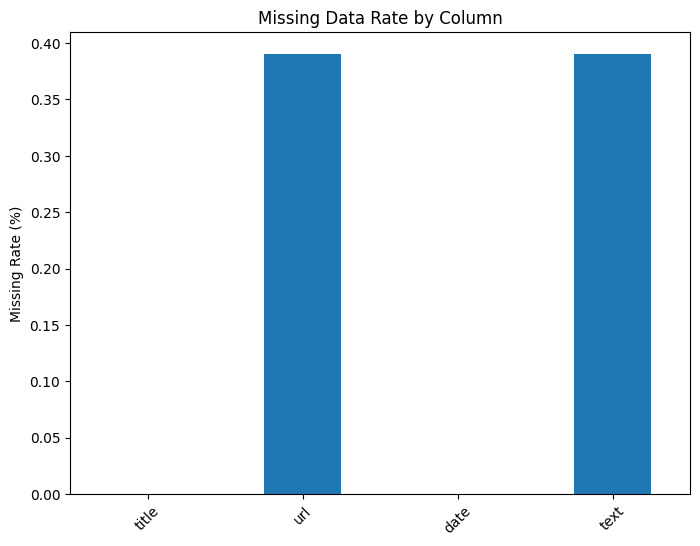

In [21]:
missing_rates = news_df.isnull().mean() * 100
# Plotting
plt.figure(figsize=(8, 6))
missing_rates.plot(kind='bar')  # This assumes 'missing_rates' is a Series with one value per column
plt.ylabel('Missing Rate (%)')
plt.title('Missing Data Rate by Column')
plt.xticks(rotation=45)  # Rotate the column names for better readability
plt.show()

### 2. Google api Translate, `Require_Translate` column show English translation require or not.
`Require_Translate` is scrpaed from translate tag. Show whether the observed review should be translated in English or not

In [2]:
# example
translator = Translator(service_urls=['translate.googleapis.com'])
text_to_translate = 'Mañana, último día de la cuenta al 2,89% TAE y depósito al 3,44% TAE de Renault Bank'
translated = translator.translate(text_to_translate, dest='en')
print(translated.text)

Tomorrow, last day of the account at 2.89% APR and deposit at 3.44% APR from Renault Bank


In [5]:
translator = Translator(service_urls=['translate.googleapis.com'])

def translate_text(df, column_name):
    # Initialize count
    count = 0
    # Iterate over the DataFrame with tqdm for progress tracking
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        text = row[column_name]
        print("Text:", text)
        try:
            # Translate text to English
            translated = translator.translate(text, dest='en')
            print("Translated:", translated.text)
            # Update the DataFrame with the translated text
            df.at[index, column_name] = translated.text
            count += 1
            print("Translated Num:", count)
        except Exception as e:
            print(f"Error translating text: {e}")
            # Keep the original text if translation fails
            df.at[index, column_name] = text
    return df

In [10]:
translated_df = translate_text(news_df, 'text')
print(translated_df)

  0%|          | 2/1025 [00:00<01:38, 10.39it/s]

Text: Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The French entity has already extended 5 times without changes since January 2024, when it made the first cut in recent years and affected exclusively the 2-year deposit, which fell from 3.85% APR to 3.44% APR.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even more likely.
As for your savings account, it leads to 2.89% APR from November 2023 without changes:

The characteristics of your 2-year deposit currently are:
Offer valid until April 24, 2024.
And the Account With You:
Offer valid until April 24, 2024.


Renault Bank has once again extended the contracting period for its products without changing its profitability: Account at 2.89% APR and deposit for 2 years and at 3.44% APR.
We congratulate our users who have been correct in their prediction with 67% of the votes (see here) stating th

  0%|          | 4/1025 [00:00<02:00,  8.46it/s]

Translated: Since its launch, Bitcoin has seen positive and negative changes. However, most of the improvements related to Bitcoin resonate with the interest of investors around the world. Bitcoin currently has a significant lead in the cryptocurrency sector, the main reason behind its popularity. With the year 2023 here, experts predict that Bitcoin will continue to impact the financial industry in several ways. Understanding Bitcoin trends is vital to ensuring usage and successful businesses.
With the growing demand for cryptocurrencies around the world, a simultaneous growth in the number of analytical tools is notable. In this case, platforms like Trader AI are indispensable as they allow Bitcoin traders and investors to make informed decisions. Furthermore, such tools provide people with a clear projection of future expectations. Here are some Bitcoin predictions for the next five years:
In particular, Bitcoin has shown significant value growth since its launch. It is the only cry

  1%|          | 7/1025 [00:00<02:03,  8.24it/s]

Translated: We already saw that N26 or Celetem could be good replacements for Orange Bank which will close its doors on June 17, 2024. Today we want to analyze the B100 offer.
Unfortunately, we will lose the Orange Bank account which was very good for all the services it offered and there is no offer that gives everything.
In the case of B100, we miss immediate transfers, which are at a cost, and cash withdrawals at any ATM.
As we have said, immediate transfers have a cost, in this case, of €1.5 for each one compared to the "0" cost of Orange Bank.
This is a minor problem, when you have Bizum, you could use it to transfer money immediately and for free even between your own accounts (see here).
On the other hand, you have to withdraw cash at their own ATMs (Abanca's) whenever you want, and they allow you to withdraw twice a month at no cost at the following ATM networks:
Yes, there are many ATMs, but Orange Bank allowed you to withdraw from any ATM and 3 times a month at no cost.
B100 

  1%|          | 9/1025 [00:01<02:23,  7.06it/s]

Translated: We must assume that Orange Bank will no longer exist and we must decide to go to another entity.
The alternatives that we have proposed, none are as good as Orange Bank (see here), perhaps N26 is one of the best offers (see here). But what about Cetelem?
As we saw with N26, its shortcomings were:
But it also has some extra advantages over Orange Bank:
The big drawback of Cetelem is that it charges commissions (€1.99 per month from 2025), in addition to lacking the Bizum service (see the comparison here).
Instead, it offers other advantages, such as 3.25% APR of account profitability instead of 2% APR, and deposits of up to 4% APR or that the money is under the Spanish FGD.
So what does that €1.99 per month commission mean? We must compare the remuneration against the cost.
Conclusions:
In addition, until 2025 you are exempt from commissions on the account, we believe that Cetelem's offer is good.


Due to the disappearance of Orange Bank, and the transfer of clients to Cete

  1%|          | 11/1025 [00:01<02:26,  6.91it/s]

Translated: Cetelem offers a "welcome plan" to Orange Bank customers by giving them a checking account that will be remunerated at 3.25% APR with no balance limit and a debit card with no fees.
This offer is available from today, April 15, although we have not yet been able to access this link from the Orange Bank APP.
Now we give you the bad news: analyzing this offer in more depth, it is simply the Cetelem Premium Plan with slight improvements:
* Premium Plan has an initial cost of €1.99 until June 30, 2024.
* Welcome Plan is free of charge until December 31, 2024.
If you are an Orange Bank customer, you must unsubscribe before June 17, 2024, and if you want, you can also contract this Cetelem Welcome Plan.


Due to the disappearance of Orange Bank, and the transfer of clients to Cetelem, the first "unknown" problems of this entity appear.
Today we echo a complaint from one of our users and new Cetelem client who complains about the maximum limit that the entity allows in daily trans

  1%|▏         | 13/1025 [00:01<02:16,  7.44it/s]

Translated: Today we give voice to Mercedes, a user of our website, who complains about Banco Sabadell for withdrawing her friend plan early, according to its announcement and without informing customers.

The promotion was valid until April 30, and stopped working ten days ago.
The bank did not contact the client to indicate that said promotion was cancelled. That's called false advertising.
I hope you can disclose how the entity works, lying to its clients.
Thank you for your portal, your seriousness and effectiveness. Kind regards
Banco Sabadell gave €50 to its existing clients for each new client they brought to the bank, up to a maximum of 5, that is, a bonus of €250.
New customers also received a welcome €50.
This promotion, according to its announcement, would be valid from March 1, 2024 to April 30, 2024 (both inclusive). However, there is no longer any trace of this offer on the Sabadell website and our user is complaining because it has stopped working for more than 1 week.
A

  1%|▏         | 15/1025 [00:02<02:28,  6.82it/s]

Translated: A couple of days ago we tried to find a good alternative to Orange Bank, and it was an almost impossible task (see here). No offer equals that of Orange Bank, much less improves it.
All the products we compared had shortcomings and we missed 1, 2 or even more advantages of Orange Bank:
And there were many offers that we analyzed: Orange Cetelem, Myinvestor, Pibank, Ing, Openbank, Bankinter, Banco Santander, BBBVA, Banco Sabadell and Money Go.
But once the article was published, one of our users made us aware of the N26 offer, and yes, we believe it is one of the most similar to Orange Bank.
It is without commissions, without conditions. Everything is free: card, transfers, Bizum, cash withdrawals at any ATM. Basically almost everything that Orange Bank offers.
However, something is still missing:
But it also has some extra advantages over Orange Bank:
All in all, if things change at Orange Bank, N26 is a great alternative to consider.


ING is the online bank that has captu

  2%|▏         | 17/1025 [00:02<02:28,  6.81it/s]

Translated: Renault Bank has once again extended the contracting period for its products without changing its profitability: Account at 2.89% APR and deposit for 2 years and at 3.44% APR.
We congratulate our users who have been correct in their prediction with 67% of the votes (see here) stating that the bank would do that.
The new contracting period for these products will be until April 24, 2024, that is, 2 more weeks.
Therefore, we have had 5 extensions since the bank decided in January to make the first cut since September 2021.
This rate drop only affected your 2-year deposit, which fell from 3.85% APR to 3.44% APR.
On the other hand, his savings account has yet to take a cut. Its current rate was set at 2.89% APR in November 2023.

The characteristics of your 2-year deposit currently are:
Offer valid until April 24, 2024.
And the Account With You:
Offer valid until April 24, 2024.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and

  2%|▏         | 19/1025 [00:02<02:22,  7.05it/s]

Translated: Orange Bank has closed the account contracting process after selling it to BNP Paribas, and existing clients will be migrated to Cetelem.
A statement appears on its website indicating that "at this time it is not possible to become an Orange Bank customer."
In addition, it reports that "both entities will work together to support clients in their transition during 2024 to Cetelem's digital banking solutions."
Until they are migrated, "customers can continue to use their Orange Bank accounts and services as normal."
It is not known yet. The bank has not yet communicated anything to customers. However, we can speculate knowing the existing offers.
To begin with, if it no longer allows you to sign up for an account at Orange Bank, it means that it is headed to its end. The bank already indicates that clients will be transferred to Cetelem.
If we compare the conditions of Orange Bank, Cetelem and MoneyGo (from Yoigo/Xfera with Cetelem support), we see that Cetelem loses.
On the

  2%|▏         | 21/1025 [00:02<02:20,  7.13it/s]

Translated: EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been valid since February 15 and initially had a marketing period until March 1, but as we say, it will continue until further notice.
The big problem with your deposits is that early cancellations are not allowed:
EBN, since October 1, 2023, offers its Remunerated Account at 3% APR and for all clients. Too bad it's only for the first €10,000:
The characteristics of your account are:
NOTE: If you put, for example, €60,000 in the bank: the first €10,000 is remunerated at 3% APR; The next €40,000 is remunerated at 1.5% APR and the rest (€10,000 is not remunerated).
This account is without commissions, without demands. It is a savings account so it does not accept direct debits, debits, or payment operations using credit or debit cards.


EBN Banco flat offer, gives you 3.1% APR for any term you choose: 3, 6, 9, 12, 18, 24 or 36 months, and also

  2%|▏         | 23/1025 [00:03<02:13,  7.51it/s]

Translated: Haitong Bank has slightly lowered the profitability of its deposits for 6 and 9 months, but maintains the maximum profitability of 3.55% APR that it offers in a fixed term of 1 year.
Specifically, the decrease is 0.1 percentage points, from 3.5% APR to 3.4% APR. The rest of the products have not changed.
This entity, which was at the top of the ranking of the most profitable deposits, has been losing steam in 2024.
In January it lost the 4% APR level, remaining at 3.95% APR, then up to 3.75% APR and in February up to 3.55% APR.
In 2023, it clearly surpassed Renault Bank in its 2-year fixed term, but its current 3.49% APR is practically the same as what Renault Bank offers, which is without intermediaries.
Haitong is a Portuguese entity (Portuguese FGD), which markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit in Haitong is as if you were doing it at ING or Orange Ba

  2%|▏         | 25/1025 [00:03<02:08,  7.79it/s]

Translated: Starting today, you can file your 2023 income tax return. Before doing anything, you must verify if you are obliged to do so. If not, you should also check if your return is returnable, if so, you should present it to recover what is yours.
To know whether or not a person is exempt from making the Declaration, his or her sources of income must be taken into account, since there are limits that must not be exceeded. These limits are identical for individual and joint taxation.
People who have only obtained income from the following sources are exempt from personal income tax and, therefore, are not required to submit an Income Tax Return:
1. WORK PERFORMANCE
The general rule is that those people who do not earn more than €22,000 annually are exempt from filing the Tax Return, so that:
1.- Taxpayers who have obtained income from work up to the limit of €22,000 per year will not have to declare when they come from a single payer.
Or if the taxpayer had income from more than on

  3%|▎         | 27/1025 [00:03<02:07,  7.81it/s]

Translated: This time it was necessary to lower the profitability of the deposits of the bank's clients, from a maximum of 3.5% APR to 3.25% APR.
The previous time, at the beginning of March, the bank lowered welcome deposits from 4.25% APR to 4.1% APR.
The new conditions of these products are as follows:
The welcome deposit, which suffered a decrease last month from 4.25% APR to 4.1% APR, remains as is, unchanged.
The previous changes made by the bank are:
It is a great offer, high profitability, allows early cancellations, it is a shame that it is only for 6 months and only for new customers.
The characteristics of these deposits are:
The bank has not yet established a marketing period for this product.
Banco BIG offers in its Big BIG Account at 1.5% APR:
The Banco Big paid account is commission-free and has a Spanish IBAN, but under the Portuguese FGD. It is ING-style, but its headquarters are in Portugal.


Banco BIG remodels its deposit offer with slight increases, and offers 2 de

  3%|▎         | 29/1025 [00:03<02:07,  7.80it/s]

Translated: In the wide universe of online gaming, Nomini Casino shines as an oasis of fun and excitement. In an environment where the daily routine can be tedious, having a trustworthy and entertaining space to relax is essential.
With a wide variety of games ranging from the most popular slots to classic table games, this online casino offers a unique gaming experience for every type of player.
Imagine a place where you can immerse yourself in exciting table games, colorful slot machines and live action without leaving home. Nomini Casino offers just that, becoming the preferred destination for gaming lovers. With a wide selection, from classic card games to innovative slots, there is something for every player. But what really sets Nomini apart is not just its variety, but its ability to bring together an international community of gaming enthusiasts in an environment of respect and fun.
The Nomini Casino platform has been carefully designed to offer intuitive and hassle-free naviga

  3%|▎         | 31/1025 [00:04<02:01,  8.19it/s]

Translated: BBVA Italia has lowered the profitability of its Flexible Deposit from 4.25% APR to 3% APR, but increases the term from 12 to 24 months. On the other hand, you keep your account at 4% APR.
Despite this drop, we would like BBVA Spain to offer them to us here, but the bank does not even allow us to contract them on the BBVA Italy website if we do NOT have nationality and residence in Italy: it requires, Italian telephone number, NIF Italian, etc.
In this regard, in January, OCU filed a complaint with the Customer Ombudsman, as well as with the Bank of Spain to take action on the matter, since it discriminates against users and calls into question the free circulation of capital. the European Union. We don't think it will have any effect.
The only thing we have left is to denounce these situations and bring shame to these banks. We already warned of this shameful mistreatment in November 2023 (see here).
The truth is that the "Flexible Deposit" is quite interesting, especially

  3%|▎         | 33/1025 [00:04<02:14,  7.37it/s]

Translated: The entry of CA Auto Bank deposits in Spain has suffered strong fluctuations in just a few months.
Its initial offer, starting in January 2024, was so good (4.12% APR), that it saturated its hiring process in a couple of weeks, and forced the entity to suspend new registration applications.
When they reactivated it, the supply fell drastically (3.45% APR), and the interest of savers too, and now it seems that the bank is trying to find the balance between supply and demand, slightly increasing the profitability of its products ( up to 3.55% APR).
The problem with the previous rates was that it did not even exceed the offer from Renault Bank (3.44% APR), which does not need the 720 model, but it corrects that problem with this slight increase, although we believe it is insufficient.
The bank has also increased the minimum investment from €10,000 to €20,000, leaving its characteristics as follows:
We remind you that hiring a deposit at Auto Bank, your money is in Italy, prote

  3%|▎         | 35/1025 [00:04<02:24,  6.86it/s]

Translated: All of you who have had more than €50,000 as of December 31, 2023 have to present form 720 and you have until April 1 to do so.
If you do not present it or present it after the deadline, having the obligation, you will be exposed to fines from the Tax Agency.
Taxpayers who own any of the following groups of assets abroad that total more than 50,000 euros as of December 31, 2023 will be required to submit this informative return:
In short, if the total of each of the 3 previous groups of assets does not exceed 50,000 euros as of December 31 of each year, you are not required to present form 720.
Once Form 720 is presented for the first time, in subsequent years, it will only be mandatory when any of the joint balances of the three different blocks of assets mentioned above have experienced an increase of more than 20,000 euros compared to those that determined the presentation of the last statement.
As an example of affected savers, they are people who had contracted Raisin 

  4%|▎         | 36/1025 [00:04<02:15,  7.32it/s]

Translated: Cajamar continues to offer its liquidity raising deposit, called Depósito Hola, at a decent profitability of 3.03% APR and a term of 12 months.
If you already have the money in the bank, the entity offers a 2% APR and also a 12-month duration.
In addition, it has an account paid at 2.52% APR, but only for balances of €6,000 to €12,000.
The deposit money must come from the payment of transfers issued from other banks or from the deposit of checks issued by other financial entities, during the 15 business days prior to the creation of the deposit.
The entity offers a savings account of up to 2.52% APR depending on the balance, and requires conditions:
The advantages of the account are:
This account is only a savings account, it does not allow direct deposit of receipts, cards, or checks, nor can it be a support account for other products such as insurance or securities accounts.


Cajamar offers a liquidity raising deposit, called Depósito Hola, at a decent profitability of 3

  4%|▎         | 38/1025 [00:05<02:34,  6.40it/s]

Text: With just over 1 month left until the start of the 2023 income campaign, the Treasury has already made the “Renta WEB Open” program available to taxpayers.
This online program is a simulator that allows you to file an income tax return without having to identify yourself, or having tax data, etc., and before the start of the income tax campaign.
If you know your income for 2023 in some detail, you could compare the result of your tax return with more or less precision and anticipate in case a scare comes or, in the opposite case, if you get a refund, the sooner you present it, the sooner you will get paid
With this application it will not be possible to submit the income tax return. It is a simple simulator.
To definitively submit the declaration, it is necessary to use Renta WEB, which will be made available to taxpayers starting April 3.
The identification data of the person: NIF, name and surname entered, is not validated against the Tax Agency census, thus leaving this simula

  4%|▍         | 40/1025 [00:05<02:21,  6.96it/s]

Translated: Casinos have been a very popular means of entertainment for years in Spain, so much so that it is possible to visit not only physical establishments to play slots and table games, but we can also do so through web portals in what are known as casinos. online.
However, when we talk about these online operators, there are so many options that choosing the best one according to our tastes can be quite an odyssey, and that is where this reading comes in. Here we will discuss the 5 elements that differentiate a mediocre casino from a great one. Don't leave your screen!
There are dozens of portals on the Internet dedicated to analyzing online betting platforms with the purpose of allowing readers to compare them and choose their favorites according to their criteria.
If you want to know one of the best, then visit online-casino-espana.es, a portal where you can compare some of the best Spanish online casinos and find out the type of games they contain.
Let's be honest; Playing sl

  4%|▍         | 42/1025 [00:05<02:15,  7.23it/s]

Translated: MyInvestor deposits at 3% APR have a marketing expiration date set for next Wednesday, March 27, 2024.
The current offer is from February 22, 2024, when the bank set its 3 fixed terms at 3, 6 and 12 months at 3% APR.
They are interesting offers, but when trying to capture the same customer niche as Banco Big (3.5% APR) or Cuenta Facto (3.8% APR), we believe it falls behind; but it is always good to have one more alternative:
During the month of November 2023, MyInvestor raised its savings account from 2% APR to 2.5% APR and for a maximum remuneration that goes from €50,000 to €70,000.
The account characteristics are:
You can earn 2.5% APR indefinitely if you invest in:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some

  4%|▍         | 44/1025 [00:06<02:26,  6.72it/s]

Translated: Arquia has reduced its 6-month deposit for new clients registered from January 1, 2024 by half a point, to 3.5% APR.
It has also modified the maximum investment limit, rising from €30,000 to €50,000. In this way, the final reward is greater, but at the expense of having to invest more money.
The characteristics of this deposit, called "Ven a Arquia deposit" has lost some appeal with the decline, but is still quite interesting:
The bad thing is that the bank requires links, you must meet one of the following 2 conditions:
These links must be met in the month prior to expiration, and if not, the deposit would be paid at 1% APR, normal, downwards.
As this is an offer only for new customers, existing customers who meet the conditions cannot take advantage of the offer. So whoever wants the 4% APR deposit will necessarily have to make a new connection with the bank.
This offer will be valid until March 31, 2024.


Arquia continues to offer its deposit for a 6-month term and at 4

  4%|▍         | 45/1025 [00:06<03:04,  5.30it/s]

Translated: The BBVA promotion, which launched in January, in which it pays you all your bills domiciled in the entity for 1 year with a maximum of €60 per month (€720 per year), will end on March 31, 2024 .
You still have a little more than 2 weeks to take advantage of this offer aimed at new customers who open an Online account without commissions or expenses with the promotion code "RECIBOS720" and who also meet the following conditions:
These are very easy conditions to meet to obtain bonuses on direct debit receipts for 12 months:
The “Bonus Period” of 12 calendar months will begin on the 1st of the following calendar month to the date on which the registration process is completed.
Furthermore, the promotion does not require permanence, nor will there be penalties. Simply, if one month you do not meet the conditions, that month you will not get the bonuses, but you can continue receiving them in the following months or simply leave the bank, closing the account.
As an additional 

  4%|▍         | 46/1025 [00:06<04:13,  3.85it/s]

Translated: Banca March's Avantio Flexible deposit with a 12-month term and 3% APR for new digital clients will be available for 1 more month.
The bank set the marketing deadline for this product until April 12, 2023.
The previous offer, when the marketing deadline expired, the bank reduced its profitability by 0.3 percentage points, and the same will possibly happen within 1 month.
The bank does not require large capital to hire, from €10,000; and allows early cancellations. In this case, furthermore, the bank continues to compensate you for your money, at 1% APR instead of 3%.
This product is exclusively for new customers who open the Avantio account through digital channels.
The characteristics of this fixed term are:
The offer will be valid until April 12, 2024 or until the set quota is reached.
This product has a dark side, the Avantio Account. It is free only if you have €10,000 invested in a bank product; in addition to other conditions that are easy to meet.
The entity accepts 

  5%|▍         | 47/1025 [00:07<04:26,  3.67it/s]

Translated: To file your income tax return you need a series of documents and information that are essential for its preparation.
It is especially important to have it available if you request an appointment so that a Tax Agency manager can help you, both in person or by telephone, in preparing the income tax return.
The most important thing is that the taxpayer must have the reference number (how to obtain it here) and the documents and data that must be provided depends on the circumstances, people and income they have.
In general, they are the following:
1.- DNI (personal original and copy of that of the family members to be included in the Declaration)
2.- Draft Declaration and tax data
They can be obtained through the new AEAT Renta Web system (available before the start of the rental campaign, on April 3, consult the 2023 rental calendar here)
3.- Income Tax Return from the previous year
4.- Account number (for payment or deposit of the amount resulting from the Declaration)
5.- 

  5%|▍         | 48/1025 [00:07<04:33,  3.57it/s]

Translated: Evo Banco now offers its clients 2 deposits per balance increase at 2.85% APR and 2.95% APR depending on the term, 6 or 3 months.
The 2 products can be contracted for new money that you take to the bank and you can constitute it from the first euro and up to 1 million euros.
These are offers, slightly lower than the previous campaign, which offered 4, 6 and 12 month terms at 3.1% APR, 2.85% APR and 2.85% APR respectively.
The characteristics of this deposit are:
This product has no commissions of any kind. It is only contractable for money coming from another entity other than Evo Banco.
The offer is valid until April 30, 2024.
To new customers who sign up for the Smart Account, the bank offers a return of 2.85% APR until January 31, 2025.
This is an extra bonus for at least 1 year, but limits this profitability to a maximum of €30,000. In addition, you must have €4,000 in the unpaid account.
The Smart account is about 2 linked accounts:
What the bank does is that on the 15

  5%|▍         | 49/1025 [00:07<04:28,  3.63it/s]

Translated: Bankinter has launched its Business Plan Account 0, through which the bank offers its small and medium-sized business (SME) clients a remuneration of 3% APR during the first year and 1.5% APR the second year, with a maximum balance on which to remunerate 50,000 euros and without commissions.
This account, which allows you to obtain a remuneration of up to 2,225 euros for the first two years, is available within Plan 0 of the “Bankinter Business Plan”.
“Bankinter Business Plan” establishes 3 pricing levels:
To access Plan 0 it is necessary to carry out a minimum operation between these six possible options:
All plans have an account, cards, personal tutor, SEPA transfers, check deposits, SEPA debits; in addition to electronic payments: POS with a discount rate of 0.45%; o International Business services: currency account and access to the currency broker with real-time quotes.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity

  5%|▍         | 50/1025 [00:07<04:31,  3.59it/s]

Translated: As you already know and we have commented on this website, BNP Paribas has bought Orange Bank's business and will transfer its clients to Cetelem, but for now the two coexist.
On the other hand, Cetelem is supporting Yoigo/Xfera and its MoneyGo Account, an account very similar to that of Orange Bank. What will happen? Let's compare the products and figure out how the 3 accounts could end up.
At the moment, in our opinion, a saver could have all 3 accounts contracted without problems.
Orange Bank, for now, remains independent from Cetelem and with a different IBAN, in fact they are under a different FGD: Orange Bank, French FGD; and Cetelem, FGD Spanish. This will be the case until it integrates Orange Bank services into Celetem, which will be done throughout 2024. At the moment, clients have not yet received any communication from the bank.
If you go to Orange Bank, the process of contracting the Orange Bank Account is still in force and is, therefore, compatible with that 

  5%|▍         | 51/1025 [00:08<04:31,  3.58it/s]

Translated: Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its deposits to 3% APR.
Specifically, the bank increases shorter-term deposits, 12 months up to 3% APR and 18 months up to 2.75% APR, a fairly considerable increase: 1 point and 0.65 percentage points respectively.
The bank has left longer-term deposits unchanged:
The rest of the features are:
This offer will be valid until May 6, 2024.
>> More information about deposits here
Recently, Wizink put its Savings Account at 2.3% APR, but only for newly contracted accounts or old accounts that were contracted not linked to a deposit.
The accounts, which were linked to deposits, have also increased in profitability from 0.5% APR to 1% APR:
The entity has extended the contracting period for this account also until May 6, 2024.


Wizink deposits were due on February 29, 2024, but the bank has decided to extend it, but o

  5%|▌         | 52/1025 [00:08<04:30,  3.60it/s]

Translated: Banco BIG has slightly lowered the profitability of its 6-month large welcome deposit from 4.25% APR to 4.1% APR.
This product was in force until May 2023 and at 4% APR, and the bank relaunched it in October 2023 at 4.25% APR, now it suffers a small cut to 4.1% APR .
It is a great offer, high profitability, allows early cancellations, it is a shame that it is only for 6 months and only for new customers.
The characteristics of these deposits are:
The bank has not yet established a marketing period for this product.
Banco BIG offers in its Big BIG Account at 1.5% APR:
The Banco Big paid account is commission-free and has a Spanish IBAN, but under the Portuguese FGD. It is ING-style, but its headquarters are in Portugal.


Banco BIG remodels its deposit offer with slight increases, and offers 2 deposits combined with investment funds of up to 5.06% APR.
In reality it is not an increase as such in normal deposits, it has simply adjusted the TIN and APR of the products.
This ti

  5%|▌         | 53/1025 [00:08<04:29,  3.61it/s]

Translated: We still do not know how Orange Bank will end up with Cetelem, but B100, an Abanca online entity, wants to be its replacement and offers a very similar product in certain aspects and in others, improved.
It will offer an account, the B100 account, without commissions, with a card and all the services, the same as Orange Bank.
If you want to save, it gives you a paid account at 2.7% APR in the Save account, better than Orange Bank (2% APR), and is a short distance from the Renault Bank Account (2.89% APR).
If you also take care of yourself, it gives you a 3.4% APR on the Heath account. For that, you have to meet some physical well-being goals.
As an additional advantage of B100, it is from Abanca, a 100% Spanish entity, and therefore is under the Spanish FGD, unlike Orange Bank or Renault Bank which are under the French FGD.
Opening is simple, you only need a mobile phone to download an app and a DNI or NIE that shows that you are of legal age and that you reside in Spain.
I

  5%|▌         | 54/1025 [00:09<04:33,  3.55it/s]

Translated: Pibank has improved its Payroll Account, if you have at least €5,000, and if you have more than €10,000 in the account, it even surpasses its remunerated account.
Starting March 1, the bank will remunerate the first €5,000 at 1.51% APR, the same as until now, but if you have more than €5,000, each euro you add will be remunerated at 2.53% APR, without limit maximum.
This means that if you have at least €10,000 in Pibank, it is better that you transfer it all to the Payroll Account, instead of leaving your money in the Remunerated Account which is at 2.02% APR; you will get more interest.
The overall profitability will grow the more money you put in the Payroll Account:
The rest of the account features are:
The paid account is at 2.02% APR with the following characteristics:
The new features of this product will be:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cet

  5%|▌         | 55/1025 [00:09<04:30,  3.59it/s]

Translated: ING has again cut the profitability of its Orange deposits. It now offers a maximum of 2.55% APR instead of the 2.75% APR it had been offering.
The decrease affects all terms and investment amounts and by 0.2 percentage points in all products, except for 6 months and for investments of more than €100,000, which has been 0.3.
You can access your deposits from €1, yes, the profitability will be lower, but without any further demands, which are normal in this bank, as a new customer or new money.
These products, which were launched in November, have been progressively reduced to the current rates:
The rest of the characteristics of this deposit are:
ING offers its Orange Account up to 1.5% APR if you also have the Payroll Account:


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 welcome.
Before they gave you the bonus directly if you direct deposited your income in the bank, now, in addition, you mu

  5%|▌         | 56/1025 [00:09<04:26,  3.63it/s]

Translated: Wizink deposits were due on February 29, 2024, but the bank has decided to extend it, but only for 4 days, until March 4, 2024. Will there be a new drop?
The current offer, of up to 2.5% APR, was established in October, preceded by another decrease in July.
The current movement of giving only 4 more days to contract these products is something atypical of this bank and we fear the worst, a new cut will come.
Wizink's current offer is:
The characteristics of the products, subject to changes, are:
This offer will be valid until March 4, 2024.
Recently, Wizink set its Savings Account at 2.3% APR, but only for newly contracted accounts or old accounts that were contracted not linked to a deposit.
The accounts that were linked to deposits have also increased in profitability from 0.5% APR to 1% APR:
The marketing period for the account is until March 31, 2024.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new dro

  6%|▌         | 57/1025 [00:09<04:19,  3.72it/s]

Translated: Banco de Sabadell ends the campaign in which it offered a 6% TIN during the first 3 months for a maximum of €20,000 to new customers.
The offer was launched in December, and the bank made 3 extensions: on January 2, for almost 1 month, then on January 30, for 15 more days, and in mid-February, until February 29.
Starting today, both new clients who sign up for this account, as well as existing clients, will obtain a 2% APR for an indefinite period, and the paid balance limit remains €20,000.
The current account characteristics are:
The current offer has no marketing expiration date.


Today we give voice to Mercedes who complains about Banco Sabadell for withdrawing her friend plan early, according to her announcement and without informing clients.
Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not 

  6%|▌         | 58/1025 [00:10<04:31,  3.56it/s]

Translated: Cetelem begins to capture deposits, launching 4 fixed terms from 3 to 18 months and up to 4% APR. They are quite interesting products except for one "but."
They are deposits that do not require anything, only that you sign up for a Celetem account, which is where the catch lies, which we will detail below.
The profitability is quite good, especially for short terms:
In addition, it allows early cancellations, losing only the interest generated and the amount of the investment can be any, from the first euro.
In summary:
Cetelem currently charges commissions for its checking account. It offers 2 plans with different commissions and different returns:
As you can see in the table, Orange Bank appears, and it is because during 2024, Orange Bank clients will switch to Cetelem.
Which offer will prevail? Orange Bank or Cetelem? If it is Orange Bank, the offer will be very good.
On the other hand, if Cetelem prevails, you already know that on this website we do not like commissions

  6%|▌         | 59/1025 [00:10<04:26,  3.62it/s]

Translated: CA Auto Bank, which suspended the contracting of its deposits at the beginning of February due to the "high number of requests", reactivates its contracting, but at a significantly lower profitability.
That 4.12% APR that it offered at its launch in January 2024 quickly disappeared. Now, at most, the bank offers 3.45% APR for 6 or 12 months and 2 years at 3.34% APR, with which we do not believe it will saturate the entity with requests again.
It is even less than what Renault Bank gives (3.44% APR), which does not need intermediaries and has been working well for quite some time in Spain.
In less than 2 months it has been collecting deposits in Spain and it is almost like night and day:
The characteristics of these deposits are:
We remind you that hiring a deposit at Auto Bank, your money is in Italy, protected by the Italian FGD and you have some obligations with the Tax Agency:
Furthermore, just by having the money abroad and obtaining interest without withholding in Spai

  6%|▌         | 60/1025 [00:10<04:19,  3.72it/s]

Translated: Haitong Bank lowers the profitability of its deposits one more step, now offering a maximum of 3.55% APR over a 1-year term.
In January it lost the 4% APR level, remaining at 3.95% APR, then up to 3.75% APR and now up to 3.55% APR.
For 2 years, the bank offers 3.49% APR, practically the same as what Renault Bank offers, which is without intermediaries.
Haitong is a Portuguese entity (Portuguese FGD), which markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit in Haitong is as if you were doing it at ING or Orange Bank. You will have personal income tax withholdings and your data will be communicated to the Tax Agency like any other Spanish bank.
Another issue is whether or not you trust the bank. Haitong is the former Banco Espirito Santo that was acquired by the Chinese group Haitong Securities and which now markets deposits through Raisin.
Its deposits are:
The rest 

  6%|▌         | 61/1025 [00:10<04:32,  3.54it/s]

Translated: This year we have decided to make a basic guide on income tax returns, which we believe will be useful for many savers who visit us (thank you, by the way).
You can consult here the articles that we publish chronologically. Later we will make a better organized index page.
As you already know, the income campaign begins on April 3, 2024, but before that, in about 2 weeks, the tax data that the Tax Agency collects from us will be available.
In order to consult this data, and subsequently access the Web Rent, the first step, in most cases, is to obtain the reference number.
This number can be obtained through the REN0 program which, logically, requires identity verification.
The simplest way, without the need for electronic certificates or registration in the Treasury authentication system, Cl@ave PIN, is through a box for the previous year's declaration that is available to everyone:
There are special cases that the program will automatically detect and ask you for other inf

  6%|▌         | 63/1025 [00:11<03:57,  4.06it/s]

Translated: Finally, it has been confirmed that BNP Paribas has bought the business of Orange Bank in both Spain and France.
In this way, Orange Bank clients in Spain will become Cetelem clients.
According to the statement, the commercial agreement they have reached will offer a "continuity solution" to Orange Bank clients in Spain, and they will work throughout 2024 to make the transition to Cetelem's digital banking solutions.
We'll see how it turns out definitively, but currently, there are quite a few things we don't like about Celetem, and we fear it will get worse:
As you can see, Orange Bank's offer is clearly better than the Cetelem Plan, and many will even like it more than the Premium plan as it has no commissions even if it rents a little less.
We will see what decisions they will make about the products. But we can predict that if they change, even very significantly, the Orange Bank savings account, the stampede will be monumental.


Due to the disappearance of Orange Bank

  6%|▌         | 64/1025 [00:11<03:55,  4.09it/s]

Translated: In just over 1 month, the 2023 income campaign will begin, which must now be presented during the spring of 2024.
April 3, 2024 will be the first day that taxpayers will be able to submit their income tax return, and July 1 will be the last day to complete this procedure:
In case your declaration is due to be paid and you want to direct the payment, June 26 will be the last day you can do so.
If you direct the payment of your tax return, the receipts will be sent to you:
If you want to make an appointment in advance, you can do so via the Internet or by calling the following telephone numbers: 91 535 73 26 / 901 12 12 24 or 91 553 00 71 / 901 22 33 44. It is the only way that the Treasury will assist you.
Starting today, you can file your 2023 income tax return. Before doing anything, you must verify if you are obliged to do so. If not, you should also check if your return is returnable, if so, you should present it to recover what is yours.
We indicate the conditions.
Toda

  6%|▋         | 65/1025 [00:11<03:50,  4.16it/s]

Translated: Banco Santander continues until April 2024 with its offer of €400 in bonus cash for bringing a payroll and 2 receipts to the bank.
Of course, the €400 is for payroll or large pensions, €2,500 per month, but it still gives you €300 if your payroll does not reach that amount, but does exceed €600 per month.
All in all, the demands are:
The bank accepts payroll, pension or recurring income to give you the promotion:
>> See details of the promotion
The account is without commissions and without conditions:
This offer is exclusively for new clients of the bank and without the need to direct deposit the payroll or anything. Only if you want the €300 or €400 bonus, you must direct deposit the income and the 2 receipts, and it is valid until April 5, 2024.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have no

  6%|▋         | 66/1025 [00:12<03:47,  4.22it/s]

Translated: At the beginning of February, Openbank offered an Exclusive Deposit, with a 12-month term and 3.15% APR, but today we tested it again and the offer has been deflated to a paltry 2% APR, the same profitability as its widespread supply for new money.
This deposit appears when you try to take the money from the bank by initiating the transfer process to another bank (see below).
If we compare it with what it was giving at the end of 2023, which offered up to 3.5% APR, it is clear that the bank has lost interest in retaining money from its clients or perhaps will continue to do so, without paying anything extra for it. .
In any case, it is better to offer little, than to offer nothing. This exclusive deposit is for the money that is already in the bank and does not require payroll or anything. He just wants you not to take the money to another bank.
According to the pre-contractual document, the offer is valid from February 20, 2024 and there is no expiration date.
>> See offer

  7%|▋         | 67/1025 [00:12<03:46,  4.23it/s]

Translated: Novum Bank is offering Spanish savers 2 high-yield deposits with a term of 6 and 12 months and at 3.5% APR and 3.9% APR respectively.
These are bank deposits that can be contracted from €10,000 and up to a maximum of €100,000; always covered by the Deposit Guarantee Fund (FGD), in this case of Malta.
Novum Bank is an entity based in Malta and has permission to market banking products in Spain.
However, they have not opened a branch here, so your money will be outside our borders, and if you had more than €50,000 you would have to file form 720, in addition to having to declare the interest earned on your own.
Another drawback that we see is that it does not allow early cancellations, so if you invest, you should know that you would not be able to have those funds until maturity.
The characteristics of its deposits are:
The bank does not require creating a bank account or contracting another financial product to contract the deposit.
For more information, you can call any bu

  7%|▋         | 68/1025 [00:12<04:02,  3.94it/s]

Translated: BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable, with an extra return of 0.35 percentage points compared to an investment of less than €50,000.
The characteristics of this deposit are:
This deposit will be available until March 17, 2024.
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The deposits offered are valid until February 25, 2024.


BFS has cut, for another week, the profitability of its deposits. This time, it has affected its shorter terms: 12 and 18 months, and they are in fact the most profitable products, up to 3.15% APR.
The rest of the terms remain the same, and are offered below 3% APR.
BFS cuts its deposits a little more, now the maximum that can be obtained in this entity is 3.25% APR for 12 months in a non-cancelable fixed term.
The decrease affects practically all of its deposits, except for the 36-month cancelable deposit, which will continu

  7%|▋         | 69/1025 [00:12<04:22,  3.64it/s]

Translated: In 2024, after overcoming a sea of ​​challenges, technology stocks are making a strong comeback, with a significant year-to-date increase. Leaders like Microsoft and Amazon exemplify resilience in the face of rising interest rates and geopolitical tensions. This article will dissect these influences on performance, offering insights into successful investment strategies and what drives growth in this dynamic sector.
You're navigating an investment landscape in 2024 where geopolitical tensions cast a shadow over tech stocks. Look at relations between the US and China: they are fundamental in shaping data policies and the availability of technological pieces, affecting giants listed on exchanges like NASDAQ or Shanghai. However, not everything is gloomy. U.S. initiatives like the Reduce Inflation Act and the CHIPS Act are strengthening economic stability and domestic chip production—think of them as your safety net against market volatility. For astute investors like you, und

  7%|▋         | 70/1025 [00:13<04:29,  3.55it/s]

Translated: According to statements by Ludovich Pech, CEO of Orange in our country, the negotiations are progressing "very well" and that it is most likely that Orange Bank will end up in the hands of BNP Paribas and that in Spain it will be part of Cetelem.
We say that it is good news because among the other candidates was Deutsche Bank, with many commissions, or Morgan Stanley, a total unknown.
On the other hand, Cetelem has a commercial strategy very similar to Orange Bank, oriented towards an operational and savings account and consumer loans.
Of course, there are quite a few things we don't like about Celetem, and we fear that they will get worse:
As you can see, Orange Bank's offer is clearly better than the Cetelem Plan, and many will even like it more than the Premium plan as it has no commissions even if it rents a little less.
We will see if BNP finally buys it and what decision it makes about its account, which has more than 200,000 clients.
But we can predict that if the Or

  7%|▋         | 71/1025 [00:13<04:18,  3.68it/s]

Translated: BFS has cut, for another week, the profitability of its deposits. This time, it has affected its shorter terms: 12 and 18 months, and they are in fact the most profitable products, up to 3.15% APR.
The rest of the terms remain the same, and are offered below 3% APR.
The interest rate offered by this bank depending on the term is a faithful example of how deposits could evolve in the coming months.
Seeing this panorama, we advise you that perhaps it is time to invest for the long term and with high profitability, for what may come, which will surely be more declines.
You already know that it is very difficult for banks to overpay you, but to underpay you, they react much faster:
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The deposits offered are valid until February 25, 2024.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 perce

  7%|▋         | 72/1025 [00:13<04:12,  3.77it/s]

Translated: MyInvestor slightly increases the profitability of its 3-month deposit, from 2.9% APR to 3% APR, matching what it had been offering for its 6 and 12-month deposits.
It also extends the contracting period until March 27, 2024, products that were launched in May 2023, and since then the rates had not been touched.
As we have pointed out on other occasions, the MyInvestor offer is good, but when trying to capture the same customer niche as Banco Big (3.5% APR) or Cuenta Facto (3.8% APR), we believe that it is is left behind.
Only the 12-month deposit offers the same profitability as the other 2 banks:
During the month of November 2023, MyInvestor raised its savings account from 2% APR to 2.5% APR and for a maximum remuneration that goes from €50,000 to €70,000.
The account characteristics are:
You can earn 2.5% APR indefinitely if you invest in:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the client

  7%|▋         | 73/1025 [00:13<04:07,  3.84it/s]

Translated: Yes, the usual shit... deposit rates drop and banks begin to take advantage of people's misinformation to sneak in products they don't want attached to supposedly high-profit deposits.
This is how Banco BIG has been for a few days with its deposit at 5% APR and now MyInvestor with its deposit at 4% APR.
As you can imagine, that 5% APR is only given if you also invest in another product, and not exactly savings.
It is a 6-month deposit linked to an investment fund: 50% in the deposit, and 50% in the fund.
You already know how this works, right? It puts that 5% APR in large numbers, and the investment fund in small letters.
>> See details here
MyInvestor gives you a deposit at 4% APR and for 3 months if you hire an automated portfolio (roboadvisor) from 150 euros.
It should be prohibited to link a deposit with a high-risk investment product, but it appears to be legal.
This offer will be valid from tomorrow, February 22nd until March 27th.
>> See details here



Banco BIG rem

  7%|▋         | 74/1025 [00:14<04:12,  3.76it/s]

Translated: We feared that Renault Bank would apply a new cut to the profitability of its products today, after 2 weeks ago it extended its products without changes, but finally the bank gives us 2 more weeks without reductions.
Thus, we have until March 6, 2024, to contract your 2-year deposit at 3.44% APR, and the savings account at 2.89% APR.
The bank made the first decrease 4 weeks ago, after many months of constant increases (since May 2022), and that affected its deposit, which lost 0.41 percentage points, to the current 3.44% APR.
This cut was greater than we expected, placing it below June 2023.

The characteristics of your 2-year deposit are as follows:
Offer valid until February 20, 2024.
The entity still does not touch, for the moment, the profitability of its Savings Account, which is at 2.89% APR, the interest rate set in the month of November 2023.
Offer valid until March 6, 2024.
>> See more details of the products


Tomorrow, April 24, 2024, the marketing period for the

  7%|▋         | 75/1025 [00:14<04:16,  3.70it/s]

Translated: Banco Pichincha offers deposits similar to its online channel, Pibank, but at a lower profitability in the case of the 12-month deposit (3% APR) and the same profitability in the remunerated account (2% APR).
Unlike Pibank, which has lowered the profitability of its 12-month deposit from 3.34% APR to 3.14% APR last week, Banco Pichincha maintains, at least for the moment, its 12-month deposit unchanged.
In this way, the difference between the online channel and the physical bank has been greatly shortened, and we know that the bank prefers to redirect its clientele to the online channel, because, among other things, the bank has very few offices and rather reserves for remittances from Ecuadorian citizens working in Spain.
Specifically, there are only 12 offices with a presence in only 6 Spanish cities: Alicante, Barcelona, ​​Madrid, Murcia, Valencia and Zaragoza.
The 2 savings products currently offered by the bank are:


Banco Pichincha offers deposits similar to its onli

  7%|▋         | 76/1025 [00:14<04:26,  3.55it/s]

Translated: BAI Europe entered our bay on January 25 with deposits of up to 4.2% APR, the most profitable at that time, in less than 1 month, it has fallen to 3.6% APR and only 6 and 12 months term.
Longer-term deposits, 2, 3 and 5 years, have gone down the drain, only offered at 0.5% APR. Who is going to contract these products? Absolutely nobody.
In this way, the only ones that are somewhat interesting are the first ones, and due to their deadline, they are not very advisable. Too short term for our taste.
The characteristics of BAI Europe deposits are:
The entity is Portuguese, with no office in Spain, so if you request, it will make reduced withholdings of 15% in Portugal, deductible later due to the issue of international double taxation.
You must declare the interest and apply the withholding deductions on your own.
Also, do not exceed €50,000 abroad or you will have to make the 720 model (see here).
Banco BAI Europa S.A. was originally founded in Portugal in 1998 as a branch of 

  8%|▊         | 77/1025 [00:15<04:40,  3.38it/s]

Translated: Bank Norwegian increases the profitability of your account up to 3.7% APR and is the most profitable on the market, without asking for demands, conditions and without commissions.
It surpasses Renault Bank (2.89% APR) by almost 1 point or EBN Banco (3% APR for €10,000) and even surpasses the accounts offered by some collaborating banks on the Raisin platform, such as Klarna (3.29% APR) , Distingo (3.20% APR) or CKV (3.14% APR)
It falls behind the Trade Republic account (4% APR), but the latter is not a savings account, but a Cash Account.
The evolution of Norwegian's account has been spectacular, from 0.5% APR, in January, 1.25% APR, in March, 2% APR, in June, 2.5% APR, in November, 2 changes, 3.3% APR and 3.4% APR, in December at 3.5% APR, and now at 3.7% APR.
3.7% APR, liquid money, is a great deal; But lately we must look at the long terms, lately we are seeing many rate cuts.
This account is a Savings Account in the style of the ING Orange Account. You will not have any

  8%|▊         | 78/1025 [00:15<04:31,  3.49it/s]

Translated: The new Wizink Savings Account at 2.3% APR is now available and can be contracted by all savers. It is without demands, without commissions and well paid. It seems very juicy, but is it really worth it? Is this offer competitive?
We have always criticized the operation of this bank. We have been clients of the bank for years and for the successive deposits that we have contracted, it has created an account for each of them, and ALL are now remunerated at 1% APR instead of the 2.3% APR that it offers to new hires .
But hey, it's not a big problem, because if we want the 2.3% APR we just have to sign up for a new account, but it is a hassle as you can imagine.
Some clients have been lucky, and already have the Savings Account at 2.3% APR, and it is because they contracted it independently, without being linked to a deposit. What sense does this have? None, in our opinion.
The characteristics of this product are as follows:
The truth is that currently only 2 banks exceed Wizin

  8%|▊         | 79/1025 [00:15<04:22,  3.61it/s]

Translated: EBN Banco flat offer, gives you 3.1% APR for any term you choose: 3, 6, 9, 12, 18, 24 or 36 months, and also reduces the minimum investment from €10,000 to €5,000 on the day of Valentine's Day.
However, this means a drop in rates for most terms: from 9 months, and a slight increase for short terms.
These products will be in force until March 1, 2024 and the characteristics are as follows:
EBN, since October 1, 2023, offers its Remunerated Account at 3% APR and for all clients. Too bad it's only for the first €10,000:
The characteristics of your account are:
NOTE: If you put, for example, €60,000 in the bank: the first €10,000 is remunerated at 3% APR; The next €40,000 is remunerated at 1.5% APR and the rest (€10,000 is not remunerated).
This account is without commissions, without demands. It is a savings account so it does not accept direct debits, debits, or payment operations using credit or debit cards.



EBN Banco has extended its deposits at 3.1% APR indefinitely to 

  8%|▊         | 80/1025 [00:15<04:10,  3.77it/s]

Translated: Yesterday, February 14, the European Parliament adopted new rules to ensure that bank transfers reach the accounts of individuals and companies in the EU immediately.
The most significant thing for clients is that banks cannot charge higher than normal transfers.
Currently, many banks, such as Openbank (among others) and, offer their customers free normal transfers, but charge for immediate transfers. Since the entry into force of the new rule, this will no longer be possible.
The bank can make 2 decisions:
The new standard has been published in the Official Journal of the European Union on February 14, 2024, and will begin to be applied in 20 days.
EU banking entities and payment services have up to 9 months to prepare their systems for the instant transfer and up to 18 months for these to be carried out.
>> Consult the original text of the standard
Most banks have immediate transfers, but few offer it for free:
The most expensive without a doubt and by far is Bankinter.
I

  8%|▊         | 81/1025 [00:16<04:16,  3.68it/s]

Translated: Banco de Sabadell has once again extended the contracting of its Online Account without commissions and remunerated at 6% TIN during the first 3 months if you are a new customer of the bank.
This time, the new deadline given by the bank is until February 29, 2 more weeks, and it is the third extension by the bank. The first time, on January 2, for almost 1 month, then on January 30, for 15 more days and now for another 15.
As we say, this high profitability can only be enjoyed by the bank's new clients during the initial period of 3 months. Former customers or once the bonus period has ended, the account will have a 2% APR.
The bank limits the amount paid to the first €20,000 both during the bonus period and afterwards.
In this way, the real bonus for new clients is €200 of extra profitability at most. Obtaining during the 3 months for €20,000, €300 gross in interest, instead of €100.
The account characteristics are:
This offer will only be valid until February 29, 2024.
Yo

  8%|▊         | 82/1025 [00:16<04:21,  3.61it/s]

Translated: BFS cuts its deposits a little more, now the maximum that can be obtained in this entity is 3.25% APR for 12 months in a non-cancelable fixed term.
The decrease affects practically all of its deposits, except for the 36-month cancelable deposit, which will continue at 2.6% APR.
In addition, it has eliminated the non-cancelable 36-month fio term at 2.75% APR.
The interest rate offered by this bank depending on the term is a faithful example of how deposits could evolve in the coming months.
Seeing this panorama, we advise you that perhaps it is time to invest for the long term and with high profitability, for what may come, which will surely be more declines.
You already know that it is very difficult for banks to overpay you, but to underpay you, they react much faster:
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The deposits offered are valid until February 18, 2024.


BFS has launched a deposit at 3.6% APR and a 12-month term for large inv

  8%|▊         | 83/1025 [00:16<04:37,  3.40it/s]

Translated: If you have a Savings Account opened in Wizink without it being linked to a deposit, starting tomorrow, February 15, it will be remunerated at 2.3% APR, the same as the bank gives for a 25-month deposit. term.
Accounts that were contracted by opening a deposit will also increase, but only up to 1% APR, as we indicated yesterday.
In this sense, the bank has communicated to its clients, and leaves us wondering if the bank will allow new openings of the Savings Account at 2.3% APR.
If it were affirmative, it would not make any sense to have these 2 accounts with such a difference in profitability. If anyone would be interested, they will open a new account to get 2.3% APR instead of 1% APR.
In fact, even if this were not the case, this discrimination is too great just because of how you contracted the account. Can someone explain to us what the meaning of these 2 accounts is? Any commercial/strategic advantages for the bank?
Thus, starting tomorrow, the Savings Account will be

  8%|▊         | 84/1025 [00:17<04:34,  3.43it/s]

Translated: ING has eliminated its welcome deposit and balance increase at 2.75% APR and a 4-month term that it had been offering since September 2023.
This product, which was initially valid only during the month of September 2023, was extended several times until February 11, 2024, but as of today, it has disappeared from the bank's offer.
Thus, the product lasted more than 5 months, and it was the bank's most interesting offer and most attractive to its customers:
Now clients can opt for medium or long-term deposits of up to 2.75% APR, as long as you make a large investment (€100,000).
As we can see, the bank has slightly reduced the profitability of these products:
The rest of the characteristics of this deposit are:
Today the new interest rate for the Orange Account comes into effect, which will pay up to 1.5% APR if you also have the Payroll Account:


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 wel

  8%|▊         | 85/1025 [00:17<04:39,  3.36it/s]

Translated: Wizink raised its Savings Account to 1% APR in April 2023, but only for new hires. The old accounts have continued at the 0.5% APR since then. It didn't make any sense, because these same customers could sign up for a new account, and it would be at 1% APR.
It has taken 10 months to realize and correct this discrepancy, and as of February 15, 2024, the old accounts will move to 1% APR, according to a statement from the bank to its clients.
Thus, starting the day after tomorrow, all the entity's Savings Accounts will be as follows:

Wizink has kept the profitability of its deposits unchanged in the month of February, but its profitability is far from what it had been offering.
After its last snip in the month of October, its products were no longer of great interest to the majority of savers, since it offered a maximum of 2.5% APR:
The rest of the features are:
This offer will be valid until February 29, 2024.


Wizink's strange move at the beginning of March to extend its d

  8%|▊         | 86/1025 [00:17<04:33,  3.44it/s]

Translated: Banco Pichincha offers deposits similar to its online channel, Pibank, but at a lower profitability in the case of the 12-month deposit (3% APR) and the same profitability in the remunerated account (2% APR).
As we know, Pibank will lower rates in 2 days (see here), and it is to be expected that these Pichincha products will do so in the same way, or maybe not?
This bank's strategy has always been to redirect its clientele to the online channel, because, among other things, the bank has very few offices and reserves it more for remittances from Ecuadorian citizens working in Spain.
Specifically, there are only 12 offices with a presence in only 6 Spanish cities: Alicante, Barcelona, ​​Madrid, Murcia, Valencia and Zaragoza.
The 2 savings products currently offered by the bank are:


Banco Pichincha offers deposits similar to its online channel, Pibank, but at a lower profitability in the case of the 12-month deposit (3% APR) and the same profitability in the remunerated acco

  8%|▊         | 87/1025 [00:18<04:28,  3.49it/s]

Translated: Pibank will lower the profitability of its 12-month deposit from 3.34% APR to 3.14% APR next Wednesday, February 14.
You still have today and tomorrow to contract it at the current interest rate, which is 0.24 percentage points more than what it will offer.
This product had been unchanged for 7 months and breaks a bullish streak that dates back to April 2022 (see here).
The bank informed clients almost 1 month ago of this decrease, as we indicated in our publication at that time.
The new features of this product will be:
Pibank has not yet communicated anything about its Savings Account, which has been at 2.02 APR since August 2023.
The characteristics of the Remunerated Account are:
The Payroll Account will also remain unchanged:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer 

  9%|▊         | 88/1025 [00:18<04:22,  3.56it/s]

Translated: Haitong Bank takes another snip at its deposits, once again cutting the profitability of all its products.
In January it lost the 4% APR level, remaining at 3.95% APR, with this drop, the maximum profitability remains at 3.75% APR and is for a 1-year term.
At 2 years, the bank offers 3.63% APR, the second most profitable of the bank, and which, in our opinion, are the most interesting.
Haitong is a Portuguese entity (Portuguese FGD), which markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit in Haitong is as if you were doing it at ING or Orange Bank. You will have personal income tax withholdings and your data will be communicated to the Tax Agency like any other Spanish bank.
Another issue is whether or not you trust the bank. Haitong is the former Banco Espirito Santo that was acquired by the Chinese group Haitong Securities and which now markets deposits through R

  9%|▊         | 89/1025 [00:19<06:48,  2.29it/s]

Translated: Deutsche Bank has 2 mutually compatible offers in which it gives new clients a 2% APR return on their money during the first year, and €360 net in cash if you domiciliate a payroll, pension or unemployment benefit.
In addition, the account has many advantages:
And now comes the catch, you must meet one of the following 2 conditions:
It also entails requirements to benefit from the €360 and/or 2% APR:
The bank will pay you €30 net per month for 12 months if you domiciliate a payroll, pension or SEPE benefit of at least €2,000 per month.
Keep in mind that the bank offers bonuses for the first 12 months from the opening of the account, so you must direct your payroll from the beginning if you want to receive the entire €360.
The €30, as we indicated, are net, since the bank is in charge of depositing the corresponding withholdings into the Tax Agency without affecting the client.
You are given this 2% APR return, as long as you have €50,000 or more in the account, and up to a 

  9%|▉         | 90/1025 [00:19<05:56,  2.62it/s]

Translated: In June 2023, Orange Bank began exclusive negotiations with BNP Paribas for its sale, but in November the bank decided to sell its business in Spain separately.
Today we learned that BNP, Deutsche Bank and Morgan Stanley are the entities that could take over Orange Bank's business.
The loan business of this entity is especially interesting for them, which has a balance of 680 million euros pending payment from more than 1 million customers who requested to finance the purchase of a mobile phone.
The competitive process that began in November, and which was scheduled to close in mid-February, is running late. There are no binding offers yet.
If you are an Orange Bank customer, you don't have to worry. Orange Bank is NOT closing, or going bankrupt, or anything like that.
What happens is that Orange, the company on which it depends, no longer wants to continue in the retail banking adventure and is going to sell it.
For many, it is even good news, because Orange scares many ma

  9%|▉         | 91/1025 [00:19<05:50,  2.67it/s]

Translated: We thought that Renault Bank would apply a new cut to the profitability of its products, and more specifically to its savings account, but in the end this was not the case.
The bank only extends its products for 2 more weeks, until February 20, leaving its deposit with a 2-year term at 3.44% APR, and the savings account at 2.89% APR.
2 weeks ago, the bank made the first decrease after many months of constant increases (since May 2022), and that affected its deposit, which lost 0.41 percentage points.
This cut was greater than we expected, placing it below June 2023.

The characteristics of your 2-year deposit are as follows:
Offer valid until February 20, 2024.
The entity still does not touch, for the moment, the profitability of its Savings Account, which is at 2.89% APR, the interest rate set in the month of November 2023.
Offer valid until February 20, 2024.
>> See more details of the products


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR 

  9%|▉         | 92/1025 [00:19<05:25,  2.86it/s]

Translated: Evo Banco has removed its 2 deposits with a 4 and 12 month term at 3.1% APR and 2.85% APR respectively, and launches one with a 6 month term and 2.85% APR.
This is a fixed period for raising liquidity, allowing all clients to be hired to bring new money to the bank.
It is a very similar offer to the Evo Banco Smart Account savings account, but it is a deposit with a fixed term and without the hassle of whether or not you have to put €4,000 in the current account.
The characteristics of this deposit are:
This product has no commissions of any kind. It is only contractable for money coming from another entity other than Evo Banco.
The offer is valid until April 30, 2024.
To new customers who sign up for the Smart Account, the bank offers a return of 2.85% APR until January 31, 2025.
This is an extra bonus for at least 1 year, but limits this profitability to a maximum of €30,000. In addition, you must have €4,000 in the unpaid account.
The Smart account is about 2 linked acco

  9%|▉         | 93/1025 [00:20<05:15,  2.96it/s]

Translated: Many taxpayers avoid the annual procedure of submitting the income tax return if they are within certain income limits and types of income, because the Treasury considers that adequate withholdings have been applied to these people.
However, if you have had any deposits from the Raisin platform, except for Haigton Sucusal in Spain, you will have obtained interests that have NOT been declared to the Spanish Tax Agency, and therefore, you have the obligation to file your income tax return and add said interests obtained abroad.
Logically, the same will happen if you have had other deposits in foreign banks contracted outside of the Raisin platform.
If you do not comply with this obligation, you will have a double penalty:
You must add it in the “Interest on accounts, deposits and financial assets” section, in previous years, in boxes 027.
What we have to do is add the interest obtained in Spain to the gross interest obtained abroad in the Complete Income box and nothing in wi

  9%|▉         | 94/1025 [00:22<14:10,  1.09it/s]

Translated: "Due to the high number of applications received by CA Auto Bank, new applications will temporarily not be accepted." This is how it appears on the Raisin website dedicated to the products of this entity.
In this way, the Auto Bank offer goes on standby in less than 2 weeks after its launch. The truth is that the interest rate offered by this bank was very attractive.
It offered terms from 6 months with a 4% APR, passed by 1 (4.1% APR), 2 (the most profitable at 4.12% APR), 3 (3.94% APR), 4 (3.78 % APR) and a maximum of 5 years (3.63% APR).
These rates have been lowered today and now the maximum offered when it reopens to new applications will be 4% APR for 6 months, the only one that has not been cut, and the rest of the terms no longer reach 4 % APR:
The characteristics of these deposits are:
We remind you that hiring a deposit at Auto Bank, your money is in Italy, protected by the Italian FGD and you have some obligations with the Tax Agency:
Furthermore, just by having 

  9%|▉         | 95/1025 [00:22<11:04,  1.40it/s]

Translated: Openbank once again offers its Exclusive Deposit, in this case, with a 12-month term and 3.15% APR to certain clients who are threatening to transfer their money to another entity.
It is a lower offer than the bank had been offering, giving up to 3.5% APR at the end of 2023.
In any case, 3.15% APR and 12 months is a much higher offer than what is generally offered:
Keep in mind that the exclusive deposit is for the money that is already in the bank and does not require payroll or anything. He just wants you not to take the money to another bank. You can see the comparison below.
The document with the conditions of the product indicates that the validity of the offer is until April 24, 2024.
It consists of starting the process of a transfer to another entity:
By doing these steps, the bank shows you the exclusive deposit offer:

Try it, and tell us below if it has worked for you too.
>> See offer details
NOTE: This offer came to us, but it may not work for all bank customers

  9%|▉         | 96/1025 [00:23<08:49,  1.75it/s]

Translated: Banco BAI Europa snips the profitability of its deposits and loses the psychological level of 4% APR, now the maximum it offers is 3.8% APR.
The cuts affect the terms of 6 and 12 months, and which were the bank's most profitable.
A little over 1 week ago, when we published our first post about this bank's products, we indicated that they were the most profitable on the Raisin platform. Well, with this change, it is no longer so.
It is now clearly surpassed by Auto Bank, which has also cut the interest rate on its deposits, but not by as much. It offers up to 4.12% APR, above the aforementioned psychological mark.
BAI Europe's fixed terms range from 6 months to 5 years and shorter terms (6 and 12 months) continue to be more profitable:
NOTE: Auto Bank is currently not allowing new hires due to strong demand for applications.
The characteristics of BAI Europe deposits are:
The entity is Portuguese, with no office in Spain, so if you request, it will make reduced withholdings 

  9%|▉         | 97/1025 [00:23<07:13,  2.14it/s]

Translated: MyInvestor extends, for another month, the term of contracting its deposits: 2.90% APR for 3 months and 3.00% APR for 6 and 12 months.
The entity launched these products in the month of May, but it was not until October that it began to set a marketing deadline, initially until October 31, 2023, and has subsequently been extended monthly.
Thus, today, February 1, the bank sets February 29 as the last day that allows these products to be contracted.
MyInvestor's offer is good, but when trying to capture the same customer niche as Banco Big (3.5% APR) or Cuenta Facto (3.8% APR), we believe it falls behind.
During the month of November, MyInvestor raised its savings account from 2% APR to 2.5% APR and for a maximum remuneration that went from €50,000 to €70,000.
The account characteristics are:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have trie

 10%|▉         | 98/1025 [00:23<06:22,  2.43it/s]

Translated: Third cut by Banco Big in just over 1 month on its bank deposits.
At the end of December he lowered his 6 and 12 month deposits (see here) and at the beginning of January he made his 3 month deposit (see here), now he applies a cut and affects his 3 deposits without conditions.
As we always say, banks have a hard time paying us more, but to pay us more, they are quick as lightning.
Specifically, the reduction has been 0.25 points in each of the deposits:
Of course, at least it does not lower your welcome deposit to a 6-month term, which remains at 4.25% APR.
In this way, your offer is as follows:
The bank has not yet established a marketing period for this product.


Banco BIG remodels its deposit offer with slight increases, and offers 2 deposits combined with investment funds of up to 5.06% APR.
In reality it is not an increase as such in normal deposits, it has simply adjusted the TIN and APR of the products.
This time it was necessary to lower the profitability of the d

 10%|▉         | 99/1025 [00:23<05:40,  2.72it/s]

Translated: ING has extended until February 11, 2024, its deposit at 2.75% APR and 4 months for both new clients and existing clients who increase their balance with the entity.
This product was launched at the beginning of September and only for that month, but it has already been extended several times, although this latest extension is the shortest time, less than 2 weeks.
It is an offer that attracts many savers, but it is not a big deal if we compare it with entities like Facto (see here) or Banco Big (see here) that offer a 3.75% APR for 3 months without asking you for anything in return.
However, ING is still the favorite of many clients, which we do not understand very well (see here), but it is their choice.
The characteristics of this product are:
Today the new interest rate for the Orange Account comes into effect, which will pay up to 1.5% APR if you also have the Payroll Account:
In mid-January, ING cut the interest rate on all these products, except the 6-month term.
The 

 10%|▉         | 100/1025 [00:24<05:13,  2.95it/s]

Translated: OCU, in its monthly magazine of January 2024, denounces that BBVA offers new Italian clients a 1-year deposit at 4.25% APR and a commission-free savings account at 4% APR, while here, nothing at all .
We already warned of this shameful mistreatment of Spanish clients by Spanish banks in general by Spanish banks, and specifically by BBVA in the month of November (see here).
Furthermore, BBVA does not even allow Spanish clients to contract these products with the Italian subsidiary, since they not only request an Italian telephone number, an Italian NIF, etc., but also ask that you be a resident of that country.
«OCU has filed a complaint with the Customer Ombudsman of the aforementioned entity, as well as with the Bank of Spain to take action on the matter, putting a stop to these discriminatory practices that not only call into question the free movement of capital of the European Union, but they discriminate against Spanish users.
The products mentioned are:
>> See more de

 10%|▉         | 101/1025 [00:24<04:46,  3.22it/s]

Translated: BluOr Bank AS, a Latvian entity, which offers deposit via Raisin, has increased the profitability of its 1-year deposit from 3.45% APR to 3.80% APR.
It keeps the rest of your deposits unchanged giving a maximum of 4% APR over a fixed term of 6 months.
Specifically, all the deposits offered by this bank are:
The characteristics of these fixed terms are:
These fixed terms slightly exceed Haitong Bank, another entity that offers deposits in Raisin, in some terms:
We believe that Haitong Bank is better, because BluOr Bank has some disadvantages compared to the first, by NOT having a branch in Spain:


BluOr Bank AS or Blue Orange as we knew it before, is an entity that offers its deposits through the Raisin platform, has increased the profitability of its 6-month deposit to 4.11% APR.
This profitability, which is the most profitable on the market, exceeding the 4.06% APR of the Facto Account, is not yet listed on the Raisin website, but will be soon. One of our affiliate compan

 10%|▉         | 102/1025 [00:24<04:34,  3.36it/s]

Translated: Banco de Sabadell has extended its Online Account without commissions and remunerated at 6% TIN for the first 3 months until February 14, 2024 if you are a new customer of the bank.
It is the second time that the bank has extended this offer, the first time, on January 2, 2024, for almost 1 month and now for another 15 days.
As we say, this high profitability can only be enjoyed by the bank's new clients during the initial period of 3 months. Former customers or once the bonus period has ended, the account will have a 2% APR.
The bank limits the amount paid to the first €20,000 both during the bonus period and afterwards.
In this way, the real bonus for new clients is €200 of extra profitability at most. Obtaining during the 3 months for €20,000, €300 gross in interest, instead of €100.
The account characteristics are:
This offer will only be valid until February 14, 2024.
You would get that APR if you leave the money throughout the year:
The 3.039% APR would be the average

 10%|█         | 103/1025 [00:24<04:34,  3.36it/s]

Translated: The marketing deadline for some of the best offers for savers has been set in the coming days: Sabadell, ING and MyInvestor.
In the case of Banco Sabadell and its Online Account at 6% APR for 3 months for new customers, it ends today.
You have until Wednesday, January 31 to contract the ING money raising deposit at 2.75% APR and deposits of up to 3% APR from MyInvestor.
Will they extend it? Will rates go up or down? Or will they eliminate their products? We'll see...
Banco de Sabadell offers its online account without commissions and remunerated at 6% TIN during the first 3 months if you are a new customer of the bank for a maximum of €20,000.
This represents €300 gross in interest, which is €200 more than what the account normally earns.
This offer will only be valid until January 29, 2024.
MyInvestor offers 3 deposits at 2.90% APR for 3 months and 3.00% APR for 6 and 12 months until January 31, 2024 for investments from €10,000 to €100,000.
It is an interesting offer, but

 10%|█         | 104/1025 [00:25<04:25,  3.47it/s]

Translated: Wizink will maintain the profitability of its deposits unchanged in the month of February, but its profitability is far from what it had been offering.
After its last snip in the month of October, its products were no longer of great interest to the majority of savers, since it offered a maximum of 2.5% APR.
It is too low a profitability if we were to buy it with other entities that easily exceed 3% APR: Haitong (3.95% APR), Facto (3.75% APR), BFS (3.45% APR) or Pibank (3. 34% APR).
Wizink's new offer is:
The characteristics of the products, subject to changes, are:
This offer will be valid until February 29, 2024.
The savings account continues at 1% APR, but it only applies to recently contracted accounts, the old ones that were at 0.5% APR remain unchanged:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality t

 10%|█         | 105/1025 [00:25<04:16,  3.58it/s]

Translated: Banco BAI Europa, a Portuguese entity, which offers deposits through the Raisin platform, is the bank that gives the most profitability at the moment, up to 4.2% APR, surpassing the new offer from Auto Bank (see here).
BAI Europe offers deposits from 6 months to 5 years like Auto Bank, but focuses more on shorter terms (6 and 12 months), where it offers more profitability (4.2% APR).
However, at longer terms, the profitability is not as good, below 3.5% APR. On the other hand, Auto Bank offers more than 4.1% APR for 2 and 3 years.
The characteristics of BAI Europe deposits are:
The entity is Portuguese, with no office in Spain, so if you request, it will make reduced withholdings of 15% in Portugal, deductible later due to the issue of international double taxation.
You must declare the interest and apply the withholding deductions on your own.
Also, do not exceed €50,000 abroad or you will have to make the 720 model (see here).
Banco BAI Europa S.A. was originally founded 

 10%|█         | 106/1025 [00:25<04:11,  3.66it/s]

Translated: Auto Bank, the subsidiary of Crédit Agricole, begins to offer high-yield deposits in Spain. Up to 4.2% APR.
The entity, based in Italy, has opened a website in Spain to provide information to its clients, but the contracting of its products is carried out on the Raisin platform.
The terms range from 6 months with a 4% APR, passed through 1 (4.1% APR), 2 (the most profitable at 4.2% APR), 3 (4.1% APR), 4 (4% APR) and a maximum of 5 years (3.90% APR).
Furthermore, the investment limits are not very demanding, from €10,000, and a maximum of €100,000.
Deposit characteristics:
Crédit Agricole Auto Bank belongs to the Crédit Agricole group, the tenth banking group in the world and the leader in Europe in terms of number of clients.
With operations in 19 European countries, Crédit Agricole Auto Bank is positioned as one of the leading providers of vehicle financing, leasing and mobility services.
Founded in 1925, the bank has almost a century of experience in the European automobi

 10%|█         | 107/1025 [00:25<04:06,  3.73it/s]

Translated: BBVA has launched a promotion in which it pays you all your bills direct debited to the entity for 1 year with a maximum of €60 per month (€720 per year).
This offer is for new customers who sign up for an online account without commissions or expenses and who also meet the following conditions:
BBVA will give you bonuses for 12 months as follows:
The “Bonus Period” of 12 calendar months will begin on the 1st of the following calendar month to the date on which the registration process is completed.
Of course, not all receipts are valid, only those from the companies participating in the promotion.
The services whose direct debits give rise to the right to the bonus must be provided by:
The offer is valid until March 31, 2024.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that

 11%|█         | 108/1025 [00:26<04:01,  3.80it/s]

Translated: CBNK, the new entity resulting from the merger of Banco Caminos and Bancofar, has launched a deposit with a 6-month term and a 3.29% APR.
This is the "Transparent Deposit" that allows all clients who bring new money to the bank to contract it.
It is a fairly flexible product, as it does not require minimums or maximums, in addition to allowing you to have your money in advance. Even in that situation, the bank would pay you part of the interest generated.
In summary, the characteristics of this deposit are:
Offer valid until March 31, 2024.


Banco Caminos, also BancoFar, tries to attract new money by offering a 12-month deposit at a 3.29% APR.
It is a deposit with a not very long term and has the advantage that it is cancelable, although the interest rate is not one of the highest on the market (up to 4% APR), but 3.29% APR is Pretty decent, especially for the bank's existing customers.
Banco Camino rewards more profitability if you deposit more money. How things have chan

 11%|█         | 109/1025 [00:26<04:01,  3.80it/s]

Translated: The Norwegian Bank, Bank Norwegian, increases the profitability of its account by one tenth of a point more, to 3.7% APR, 0.2 percentage points more.
The evolution of this account has been spectacular:
It is one of the most profitable on the market, with no demands, no conditions, no limits and no commissions.
It pays more than Renault Bank (2.89% APR) or EBN Banco (3% APR for €10,000) and even exceeds the accounts offered by some collaborating banks on the Raisin platform, such as CKV (3.3% APR), Klarna ( 3.29% APR) or Distingo (3.20% APR).
After the latest reductions by Facto and Banco Big, Bank Norwegian is almost on par in profitability with its short-term deposits (3.75% APR).
However, it falls behind the Trade Republic account (4% APR), but this is not a savings account, but a Cash Account.
Norwegian has some disadvantages as a foreign entity:
Furthermore, we do not know how long this high profitability will last, and since it is a Savings Account, in the style of the

 11%|█         | 110/1025 [00:26<04:06,  3.71it/s]

Translated: Finally, Haitong Bank has cut the profitability of absolutely all its deposits, in addition to the 1-year term announced by Raisin.
With this reduction, the bank loses the 4% APR level that it had been offering for months. Specifically, since July 2023.
Now the maximum that the bank offers is 3.95% APR for a 1-year term and 3.78% APR for a 2-year term, which, along with the 1-year term, are the most interesting due to the downward trend in The types.
Haitong is a Portuguese entity (Portuguese FGD), which markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit in Haitong is as if you were doing it at ING or Orange Bank. You will have personal income tax withholdings and your data will be communicated to the Tax Agency like any other Spanish bank.
Another issue is whether or not you trust the bank. Haitong is the former Banco Espirito Santo that was acquired by the Chinese

 11%|█         | 111/1025 [00:27<04:12,  3.62it/s]

Translated: You have 1 week to sign up for the Banco de Sabadell Online Account without commissions and paid at 6% TIN for the first 3 months if you are a new customer of the bank.
The promotion had an expiration date of January 2, 2024, but the entity decided to extend it until January 29, 2024.
If you are already a customer or after the first 3 promotional months, the account will continue to pay, but at 2% APR.
This offer would be very good if deposits continued to rise, but all signs point to the opposite. Therefore, it is only interesting for the money that you want to have it liquid.
If you put €20,000 for 3 months at 6% TIN, it means €300 gross in interest, that is, €200 more than what the account normally earns.
Thus, a new client would receive €200 interest bonus for €20,000 in the account in those initial 3 months.
If you left the money for 1 whole year, you would receive €600 in interest; €200 initial bonus for the first 3 months, and €400 in normal interest for the 12 month

 11%|█         | 112/1025 [00:27<05:46,  2.64it/s]

Translated: ING has today cut the profitability of Orange deposits in which it paid up to 3% APR for large investments.
These products were launched in the month of November, whose profitability depends on the amount of your investment, without requiring you to be a new customer or bring new money to the bank.
The entity has cut the interest rate of all these products, except for the 6-month term.
The maximum return it gave was 3% APR, and it has been lowered to 2.85% APR for terms of 12 and 18 months and for investments of at least €100,000.
You can access their deposits from €1, however, the profitability will be lower:
The rest of the characteristics of this deposit are:
As we have recently commented (see here), ING offers a deposit of up to 3.1% APR for 6 months if you threaten to transfer your money to another bank.
In any case, we believe that ING's offer is not that good, there are banks that offer better deposits such as Renault Bank or Cuenta Facto.
If you are a new customer o

 11%|█         | 113/1025 [00:27<05:25,  2.81it/s]

Translated: Raisin is once again transferring to its clients a new Haitong drop scheduled for next Monday, January 22, 2023.
This time it will affect your 1-year deposit, which will lose the 4% APR level, remaining at 3.95% APR. It will mean a reduction of 0.15 percentage points.
If you are in the process of opening a deposit, you must complete any submission of documentation required by the bank and that the funds you wish to invest are in your Raisin Account before Monday.
If you do not do so, the deposit will be formalized at the new interest rate of 3.95% TIN.
Haitong is a Portuguese entity (Portuguese FGD), which markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit in Haitong is as if you were doing it at ING or Orange Bank. You will have personal income tax withholdings and your data will be communicated to the Tax Agency like any other Spanish bank.
Another issue is whethe

 11%|█         | 114/1025 [00:28<05:15,  2.89it/s]

Translated: During the first months of the year, savers and investors usually consider different financial instruments in order to improve their personal accounts and start what is to come on the right foot. In that sense, in the following article we have considered some more than interesting alternatives to take into account for our investment portfolio. Which one do you think can give better results throughout 2024? Let's get started.
Without any doubt, the financial world has evolved greatly in recent years thanks to new technologies. The possibility of operating with Tesla stocks or cryptocurrencies, among other instruments, seemed unthinkable for millions of people and today it is within reach. In that sense, the beginning of the year offers a large number of possibilities when it comes to putting together an investment portfolio.
That is why, below, we have compiled some alternatives that we believe can be profitable for this year, resulting in above-average benefits and returns.

 11%|█         | 115/1025 [00:28<04:50,  3.14it/s]

Translated: 2 days ago we made public an offer that ING gave to certain customers if they started the process of transferring their money from ING to another bank.
It was a 6-month deposit at 3% APR, which, unlike the general offer, does not require an investment of €100,000 or more.
We also asked you to prove if you are a customer and had money in the bank. The feedback received is diverse:
And the offer has not been the same for everyone:

We don't know what strategy ING has followed, but it has always done things like this.
The detailed characteristics, as they have indicated to us, are:
This offer surpasses that offered to new clients or customers who bring new money to the bank and eliminates the requirement to invest €100,000 from the other general offer deposits (see below).
WE REPEAT: we know of the existence of this deposit from the information sent by our users. It is not an offer for everyone, nor do we know the bank's criteria for offering this product.
ING has deposits at 

 11%|█▏        | 116/1025 [00:28<04:43,  3.21it/s]

Translated: Openbank has launched a new range of deposits with different objectives: to capture regular income, to capture liquidity or for clients who already have their money in the bank.
Until now, the bank only offered a 6-month deposit to raise new money and with different returns depending on whether you direct deposit any income into the bank (3.07% APR) or not (2.01% APR).
Also another 12-month term for money from other banks and if you direct debit a payroll it gives you 3.05% APR and without a payroll, 2% APR.
Additionally, it has launched 4 fixed terms, 12, 18, 24 and 36 months, for all clients and without the need for new money, with returns from 1.25% APR to 2.44% APR.
They are not great offers, but for those people who are reluctant to change banks and want to stay with Openbank, they now have more offers to choose from.
In summary:
The rest of the characteristics of the deposits are:
Income is considered to be a payroll, pension, unemployment benefit or monthly income of

 11%|█▏        | 117/1025 [00:29<04:31,  3.34it/s]

Translated: According to what several users of our website have told us, the feint trick works again in ING. The counteroffer so that you don't take money from the bank is a deposit at 3% APR and a 6-month term.
This product was already offered in the month of July and later in the month of October, so it was a 12-month term. Now it apparently works again, but only offering 6 months.
Please, if you are an ING customer and have money in the bank, try to start a process of transferring your money to another entity and tell us in the comments below if it offers you anything. The offer goes out before you confirm the transfer.
We have tried with different amounts (up to €6,000) and it has not offered us anything.
The detailed characteristics, as they have indicated to us, are:
This offer beats the one offered to new customers or customers who bring new money to the bank.
WE REPEAT: we know of the existence of this deposit from the information sent by our users. We do not know if it is an o

 12%|█▏        | 118/1025 [00:29<04:33,  3.31it/s]

Translated: Partly expected, and partly we did not want to see it, according to the survey launched a few days ago, but Renault Bank has cut the profitability of its 2-year deposit from 3.85% APR to 3.44% APR.
46% of the votes received thought that it would extend its products without changes, and 41% thought that it would cut it, finally, the latter are right.
The cut has been 0.41 percentage points, almost half a point, to 3.44% APR, a profitability that falls very short if we compare it with the offer of Haitong Bank or Banca Sistema de Raisin, which give around 4% APR for that same term.
The entity had been uploading its products non-stop since May 2022. In recent months, we were seeing a maximum being reached, and today we confirmed the change in trend.
In addition, the cut is greater than we expected, placing it below June 2023. As we always say, it is difficult for banks to pay you more, but to lower you, they hurry.
The next stop, on February 6, 2024. On the 7th, will there be 

 12%|█▏        | 119/1025 [00:29<04:50,  3.12it/s]

Translated: Pibank is informing its clients that starting February 14 it will reduce their 12-month deposit from 3.34% APR to 3.14% APR.
It will be a slight cut (0.24 percentage points) after 7 months without changes and breaks a bullish streak that dates back to April 2022 (see here).
By saying it so far in advance, almost 1 month, both new customers and existing customers can take advantage of the current offer.
A 12-month deposit at 3.34% APR is quite interesting, but if you can, opt for 2-year deposits. The offer from Renault Bank (3.85% APR for 2 years), among others, seems much more interesting to us. Everything indicates that there will be more and more declines.
The characteristics of this product will be:
Pibank has not yet communicated anything about its Savings Account, which has been at 2.02 APR since August 2023.
The characteristics of the Remunerated Account are:
The Payroll Account will also remain unchanged:


Anyone who has not had an Orange Bank account does not know 

 12%|█▏        | 120/1025 [00:30<04:34,  3.30it/s]

Translated: Next Monday, January 15, 2024, the marketing period for the Account at 2.89% APR and the deposit at 3.85% APR from Renault Bank ends. Will there be changes the next day?
The bank has not touched its products since November, when it slightly raised the profitability of its account from 2.73% APR to the current 2.89% APR.
The entity has been raising its products non-stop since May 2022, although in recent months it has been seen that it has reached the top of the mountain and we would not be surprised if it begins to go down. Your competition is already doing it.
If I were Renault Bank, I would make a final increase and take away all the free liabilities of the customer profile of these entities. What will the bank decide? We'll see it next Tuesday.
What do you think? Respond to the following survey and leave us a comment below.
What will Renault Bank do with its products?
Total Voters: 719
Offer valid until January 15, 2024.
Offer valid until January 15, 2024.
>> See more de

 12%|█▏        | 121/1025 [00:30<04:36,  3.27it/s]

Translated: Raisin has conveyed to its clients Haitong's intention to lower the profitability of its 2-year deposit to 4% TIN, compared to the current 4.25% TIN tomorrow, January 12, 2024.
If you are in the process of opening a deposit, you must make sure that throughout today you send any documentation that the bank has required and that the funds you want to invest are in your Raisin Account.
If you do not do so, the deposit will be formalized at the new interest rate of 4% TIN.
Haitong is a Portuguese entity (Portuguese FGD), which markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit in Haitong is as if you were doing it at ING or Orange Bank. You will have personal income tax withholdings and your data will be communicated to the Tax Agency like any other Spanish bank.
Another issue is whether or not you trust the bank. Haitong is the former Banco Espirito Santo that was acqu

 12%|█▏        | 122/1025 [00:30<04:32,  3.32it/s]

Translated: One of the reasons why savers do not put money in foreign banks, which normally give more interest than Spanish banks or even foreign banks with a branch in Spain, is the fear of the 720 model.
In recent years, there has been a lot of talk about this model with terrible sanctions, but after the intervention of the CJEU (Court of Justice of the European Union), it is now normal, similar to doing your income tax return wrong.
On the other hand, most savers have done a tax return from time to time or at least checked a draft of the tax return and confirmed it.
On the other hand, the 720 model is something new for them, and new things are sometimes scary; but it is as simple as filling out a simple form and below we will tell you how to do it.
In this article we will focus on people who only have deposits or accounts in foreign banks like Raisin and it is also the easiest to fill out.
We remind you that before you start presenting this model, you must check whether you are obli

 12%|█▏        | 123/1025 [00:30<04:21,  3.45it/s]

Translated: Since last January 1, the deadline for submitting form 720, the declaration of assets abroad, was opened, if you have had money of a certain amount in foreign banks in 2023.
You have until April 1 to carry out this procedure or you will be exposed to fines from the Tax Agency.
Some think that since it was declared illegal by the Court of Justice of the European Union (CJEU), it should no longer be presented.
But what really happened is that the CJEU indicated that the fines were "disproportionate" and undermine the free movement of capital in the European Union.
So the Spanish Government approved a new sanctioning regime, avoiding the illegality declared by the CJEU:
Taxpayers who own any of the following groups of assets abroad that exceed a total of more than 50,000 euros will be required to submit this informative return:
In short, if the total of each of the 3 previous groups of assets does not exceed 50,000 euros as of December 31 of each year, you are not required to 

 12%|█▏        | 124/1025 [00:31<04:17,  3.50it/s]

Translated: Self Bank takes months to make changes to its savings products. We have to go back to the month of October, when I set the profitability of its 4 term deposits that are available to all clients.
This fact contrasts with its activity in the post-summer months:
Your longest-term deposit, the 24-month term, and the one with the lowest profitability (2.75% APR), can be contracted with money that is already in the bank. The other 3, more profitable (up to 3.3% APR), require new money.
It would not be surprising if the entity soon made changes to its products, and it would surely be downward. For now, they are decent offers:
* 1) In the event of early cancellation of the DPF during the first year of its duration, the Client will not receive any remuneration and only the main amount of the deposit will be refunded.
In case of early cancellation during the second year, the interest corresponding to the second year of duration of the DPF will not accrue and, in addition, a penalty o

 12%|█▏        | 125/1025 [00:31<04:20,  3.45it/s]

Translated: BFS relaunches its NON-cancellable deposits, the bank's most profitable, but at a lower interest rate. It also cuts cancelable deposits.
The disappearance of NON-cancellable deposits has been a hit and miss, but seeing the difference in profitability between NON-cancelable and cancelable deposits, right now, it is not worth leaving your money trapped without the possibility of recovery.
In mid-2023, NON-cancelable deposits could have interest, since they offered half a point of extra profitability. Now the maximum difference is only 0.15 percentage points.
The interest rate offered by this bank depending on the term is a faithful example of how deposits could evolve in the coming months.
Seeing this panorama, we advise you that perhaps it is time to invest for the long term and with high profitability, for what may come, which will surely be more declines. You already know that it is very difficult for banks to overpay you, but to underpay you, they react much faster:
*In R

 12%|█▏        | 126/1025 [00:31<04:14,  3.54it/s]

Translated: Given the first signs of rate cuts, which the ECB has not yet confirmed, banks have already begun to cut the profitability of their deposits.
The banks on the Raisin platform, Cuenta Facto, Banco BIG, and BFS are doing it and surely more and more will come.
We believe it is time to change strategy. Unlike in recent months, when we told you that short-term or liquid products are better, now it's time to choose long-term.
Everything that comes will surely be less profitable and if it exceeds what is now, it will be just barely.
Today we want to highlight Haitong products with returns of more than 4% APR in terms of 1 and 2 years.
They are the best deposits that currently exist in our opinion: the most profitable and terms long enough to guarantee good profitability while rates fall.
Haitong is a Portuguese entity that markets its products via the Raisin platform, but unlike the rest of the banks, it has a branch in Spain, which gives it a great advantage.
Taking out a deposit

 12%|█▏        | 127/1025 [00:32<04:12,  3.55it/s]

Translated: Facto has informed its clients that as of January 6, 2024, a new decrease in the profitability of all their deposits will come into effect.
This decrease will especially affect the longer terms, starting at 1 year, with a cut of 0.5 percentage points.
Meanwhile, the shorter terms, those of less than 1 year, will see their profitability cut by 0.25 percentage points.
This would be the third rate reduction in the Italian entity in less than 1 month.
Seeing this panorama, from www.tucapital.es we recommend that you look for long terms to put your money. Things will get worse.
Some interesting deposits are:
The evolution of Facto rates in recent months has been:
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Facto for anything, it is that it keeps its account unpaid. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers be

 12%|█▏        | 128/1025 [00:32<04:08,  3.61it/s]

Translated: In the month of December, BFS stopped short the successive increases in the profitability of its deposits, to make the first decrease in years.
This week the bank deals a hard blow to its fixed terms, eliminating its most profitable deposits, those NOT cancelable, and slightly lowering the others, those that do allow early cancellations.
As we indicated last time, the article we wrote about the signs of lower rates (see here), has been like the starting signal for banks to begin reducing what they pay to savers, without the ECB having previously modified the rates, but that the banks already take it for granted. Just look at the drop in the Euribor for the month of December (see here).
Seeing this panorama, we advise you that perhaps it is time to invest for the long term and with high profitability, for what may come, which will surely be more declines. You already know that it is very difficult for banks to overpay you, but to underpay you, they react much faster:
*In RED

 13%|█▎        | 129/1025 [00:32<04:08,  3.61it/s]

Translated: Banco BIG, after lowering its 6 and 12 month deposits (see here), now cuts the profitability of its 3-month deposit, from 4% APR, to 3.75% APR.
Banks are anticipating a future drop in interest rates, and are reducing the profitability of long terms. This is what Facto or BFs has already done, and Banco BIG is the second time it has done it.
Last time, it lowered 6 and 12-month deposits by 0.25 and 0.5 percentage points, and now it applies a reduction of 0.25 percentage points to 3-month deposits.
Of course, it leaves your welcome deposit unchanged for 6 months and at 4.25% APR.
In this way, your offer is as follows:
The bank has not yet established a marketing period for this product.


Banco BIG remodels its deposit offer with slight increases, and offers 2 deposits combined with investment funds of up to 5.06% APR.
In reality it is not an increase as such in normal deposits, it has simply adjusted the TIN and APR of the products.
This time it was necessary to lower the pr

 13%|█▎        | 130/1025 [00:32<04:10,  3.58it/s]

Translated: Banco de Sabadell extends its online account without commissions and remunerated at 6% TIN for the first 3 months for new customers until January 29, 2024.
If you are already a customer or after the first 3 promotional months, the account will continue to pay, but at 2% APR.
The promotion had an expiration date yesterday, January 2, 2024, but the entity has decided to extend it.
For savers who believe that deposit profitability will continue to rise a little more in the coming months, this is a great option to consider: 6% TIN for 3 months.
What is most limiting about this product is that it pays a maximum of €20,000; but you will not get more profitability for that money anywhere else during those 3 months, and the bank does not ask you for anything in return: no commissions, no conditions, no permanence.
During this time or after 3 months you can decide whether to take out a high-profit, long-term deposit to protect yourself from future rate drops, which you will do (see 

 13%|█▎        | 132/1025 [00:33<03:30,  4.24it/s]

Translated: MyInvestor extends again, for 1 more month, the contracting period for its deposits: 2.90% APR for 3 months and 3.00% APR for 6 and 12 months.
The entity first set the end of marketing date to October 31, 2023, and then it has been extended month after month.
It is an interesting offer, but when trying to capture the same customer niche as Banco Big or Cuenta Facto (4% APR), we believe it falls behind.
In short, between Big and Facto, MyInvestor has nothing to do if we compare only the issue of profitability.
During the month of November, MyInvestor raised its savings account from 2% APR to 2.5% APR and for a maximum remuneration that went from €50,000 to €70,000.
The account characteristics are:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Ban

 13%|█▎        | 133/1025 [00:33<04:58,  2.99it/s]

Translated: If you are a saver who believes that the profitability of deposits will continue to rise a little more in the coming months, a great offer is the Banco Sabadell Online Account, which will give you a 6% TIN for 3 months.
This way, you have 3 months to decide whether to take out a high-yield, long-term deposit to protect yourself from future rate drops (see here), while your money will be renting at the highest possible profitability.
It is the most profitable account on the market and also surpasses all deposits, and the bank does not ask you for anything in return: no commissions, no conditions.
Of course, the offer is only for new customers and you have 1 more week to sign up, until January 2, 2024.
The normal profitability of the account, and after the bonus period, is 2% APR.
If you put €20,000 for 3 months at 6% TIN, it means €300 gross in interest, that is, €200 more than what the account normally earns.
Thus, a new client would receive €200 interest bonus for €20,000 

 13%|█▎        | 134/1025 [00:34<04:43,  3.14it/s]

Translated: Openbank continues to give a €120 net bonus to both new clients and current clients who have a domicile with the entity.
It serves both payroll, pension and unemployment benefit, as long as it is greater than €900 net per month and a stay of 12 months.
In the case of an unemployment benefit, this permanence is not necessary; in exchange, the client must make recurring income of €900 for 12 months from the first direct debit of the benefit.
In case of non-compliance with the permanence, a penalty will be applied to the client that will be calculated by multiplying the payment of €120 by the days remaining until the end of the permanence period and dividing it by 365 days.
The process to get this bonus is as follows:
Openbank expressly excludes those who have had their payroll, pension or unemployment benefit direct deposited between April 1, 2023 and November 19, 2023 (both included)
for amounts over €500.
Also excluded are those who have benefited in the last 5 years from a

 13%|█▎        | 135/1025 [00:34<04:18,  3.45it/s]

Translated: All banks are anticipating a future drop in interest rates, and are cutting the profitability of long terms. This is what Facto or BFs has already done, and also Banco BIG.
In this case, Banco BIG has reduced the profitability of its 6- and 12-month deposits, cutting 0.25 and 0.5 percentage points respectively, from the 3.75% APR it had been offering.
Leave unchanged your deposit with a 3-month term and 4% APR and your welcome deposit with a 6-month term and 4.25% APR.
In this way, your offer is as follows:
The bank has not yet established a marketing period for this product.


Banco BIG remodels its deposit offer with slight increases, and offers 2 deposits combined with investment funds of up to 5.06% APR.
In reality it is not an increase as such in normal deposits, it has simply adjusted the TIN and APR of the products.
This time it was necessary to lower the profitability of the deposits of the bank's clients, from a maximum of 3.5% APR to 3.25% APR.
The previous time, 

 13%|█▎        | 136/1025 [00:34<03:58,  3.73it/s]

Translated: In June, Orange Bank began exclusive negotiations with BNP Paribas for its sale, but in November we learned that the French entity has decided to sell its business in Spain separately.
In this way, the entity launched a competitive process through which it hopes to receive offers from interested banks.
Potential buyers have the entire month of December to submit their offers, and we will know more next year when the sales process is scheduled to be finalized.
If you are an Orange Bank customer, you don't have to worry. Orange Bank is NOT closing, or going bankrupt, or anything like that.
What happens is that Orange, the company on which it depends, no longer wants to continue in the retail banking adventure and is going to sell it.
For many, it is even good news, because Orange scares many many people. The bad thing is the uncertainty of the new commercial strategy that the entity that acquires Orange Bank will apply.
The only thing we should worry about is the future comme

 13%|█▎        | 137/1025 [00:34<03:58,  3.73it/s]

Translated: Haitong, Spain branch, increases the profitability of its deposits with a term of 3, 6 and 9 months to almost 4% APR (3.95% APR).
The largest increase affects the 3-month deposit, which goes from 2.8% APR to 3.75% APR. The other 2 rose 0.14 percentage points.
From what some web users tell us, the bank will soon lower the rates on longer-term deposits, although the drop will be slight, but it is already setting a trend: more profitability in the short term and less profitability in the long term. They are, as it were, anticipating a future rate cut.
Its products are very interesting, since it is a Portuguese entity with a branch in Spain. Although you have to contract your deposits at Raisin, the final result is similar to a deposit at ING.
The bank will withhold income tax from you and will communicate your data to the Tax Agency and your money is covered by the Portuguese FGD and of course, you do NOT have to file form 720.
Raisin is a simple intermediary, he has no other 

 13%|█▎        | 138/1025 [00:35<03:51,  3.83it/s]

Translated: Caixa Guissona has increased the profitability of all its fixed-term deposits to 3% APR.
They are products with a not very long term: 3, 6, 9 and 12 months. Allow early cancellations, in which case the bank would continue paying you for your money at 1% APR.
The interest rate for each of the terms are:
The rest of the characteristics of these deposits are:
In order to contract these deposits, you need a checking account. The entity has the Multiaccount that has no commissions and is now remunerated:


Caixa Guissona increases the profitability of all its fixed-term deposits, reaching a maximum of 2.75% APR.
They are products with a not very long term: 3, 6, 9 and 12 months and which also have the advantage of allowing you to cancel early; and even if you cancel, the bank would continue paying you for your money at 1% APR.
Caixa Guissona offers 4 deposits, Term Deposits Plus, with a term of up to 1 year and a return of up to 2.5% APR.
They are not the most profitable on the 

 14%|█▎        | 139/1025 [00:35<03:47,  3.90it/s]

Translated: Facto has informed clients of the reduction from 4% APR to 3.75% APR on deposits from 93 to 179 days starting tomorrow.
Thus, it will only leave the terms of 90, 91 and 92 days at 4% APR, more specifically at 4.06% APR (4% TIN).
Last week the entity already made a half-point reduction in almost all of its fixed terms.
Facto was one of the fastest to increase the profitability of its products and is also proving to be the fastest to lower them.
Every day we find long-term deposits more and more interesting:
The evolution of Facto rates in recent months has been:
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Facto for anything, it is that it keeps its account unpaid. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers before February 2020.
The entity has already removed the remuneration for new accounts contracted sin

 14%|█▎        | 140/1025 [00:35<03:56,  3.74it/s]

Translated: There are increasing signs that deposits will decline, and therefore we must get ahead of events and prepare for what may come. We tell you what products are on the market to protect you from possible rate drops.
The ECB has already announced that it will lower interest rates in spring 2024, if inflation modeling is confirmed.
The banks are anticipating this fact via Euribor, which fell slightly in November, but in December it will remain below 4%, dropping almost half a point. The current average value for December is 3.742% and will be even lower than that of May 2023 (3.862%).
Some entities are already transferring this to deposits:
We think there are 2 solutions and depending on what you think how the types will evolve:
You must have the money available in case a good opportunity arises to invest long term and ensure a good return in the coming years.
In addition to some promotional accounts such as Sabadell, Openbank or MyInvestor, balance increase deposits such as ING

 14%|█▍        | 141/1025 [00:35<03:58,  3.71it/s]

Translated: Until now, Openbank offered its exclusive deposit at 3.5% APR and a 12-month term via email to clients, but recently it is also doing so by telephone.
You already know that the month of December is the month of closing the status of the accounts of the financial entities, and as always, the banks want to have beautiful numbers, and it seems that Openbank is lacking liquidity or at least, not as it would like. .
Hence, their persistence with their clients to bring new money to the bank or try to retain what is already there.
One of our users tells us that the bank is already being annoying, sending him multiple emails and recently calling him by phone to convince him.
Others tell us that when he tries to withdraw money from the bank, if it exceeds a certain amount, the bank "blocks" the operation until he speaks with an operator who counteroffers him with this deposit (see here).
A 3.5% APR and 12 months at Openbank represents a substantial improvement with respect to its ge

 14%|█▍        | 142/1025 [00:36<04:03,  3.63it/s]

Translated: Bank Norwegian increases the profitability of your account up to 3.5% APR and is the most profitable on the market, without asking for demands, conditions and without commissions.
It surpasses Renault Bank (2.89% APR) by more than half a point or EBN Banco (3% APR for €10,000) and even surpasses the accounts offered by some collaborating banks on the Raisin platform, such as CKV (3.3% APR ), Klarna (3.29% APR) or Distingo (3.20% APR).
It falls behind the Trade Republic account (4% APR), but the latter is not a savings account, but a Cash Account.
The evolution of Norwegian's account has been spectacular, from 0.5% APR, in January, 1.25% APR, in March, 2% APR, in June, 2.5% APR, in November, 2 changes, 3.3% APR and 3.4% APR, and now in December at 3.5% APR.
Of course, we see that the latest increase is much lower than previous times, but 3.5% APR, liquid money, is a great offer; But lately we must look at the long terms, in case the evolution of rates reverses.
Very short-te

 14%|█▍        | 143/1025 [00:36<04:01,  3.65it/s]

Translated: BFS stops short the successive increases in its deposits of the last 2 years. This week the entity has decided to lower the profitability of its products, especially those with longer terms.
Thus, the 3-year term suffers a drop of 0.8 percentage points, while the shorter terms almost do not decrease; in fact, the 12-month cancelable term rises by 0.1 points.
Our article on signs of rate cuts (see here) has been like the starting signal for banks to begin reducing what they pay to savers, without the ECB having previously modified rates.
First it was Cuenta Facto (see here), which also chained 2 years of increases, and now BFS another of those that has offered the most during this entire period.
As we already indicated during the last week, it is increasingly interesting to move our money to some long-term and highly profitable product.
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The deposits offered are valid until December 24, 2023.


BFS h

 14%|█▍        | 144/1025 [00:36<04:12,  3.48it/s]

Translated: Trade Republic has obtained a complete banking record from the ECB, so it will be able to start trading and bank deposits throughout the euro zone.
Its star product in Spain is its securities account, which is not a savings account, which pays 4% per year for uninvested cash and up to a maximum of €50,000.
The features of this account are very good:
The only thing that had a dark point that we did not know about and now we have been informed and we can tell you that everything is OK; and it has nothing to do with your bank account.
We doubted the guarantee of €100,000 per client when its website indicated that the money was kept in a global account in one of its associated banks.
Now we can tell you, which is correct, that account is an Omnibus account, a global account where the operations of one or several clients are recorded, a normal thing in foreign investments.
The important thing is that each client's investments, which are recorded in the Omnibus account, are cover

 14%|█▍        | 145/1025 [00:37<04:45,  3.08it/s]

Translated: The gaming world has seen transformative development in recent years, especially in the online sector. One platform that epitomizes this trend is https://www.casino777.es/, one of the leading online gambling websites. In this dynamic context, the question arises: is it worth investing in shares of gambling providers? This question goes beyond a purely financial perspective and requires a thorough analysis of economic, regulatory and ethical aspects.
The gaming sector has not stopped growing for years. The growing acceptance of online gambling, the liberalization of legislation in several countries and the increase in demand for gambling products contribute to this trend. As a result, many gaming companies have significantly increased their turnover and profits, which in turn has attracted the interest of investors.
Globalization and market liberalization have allowed gaming companies to expand their activities beyond national borders. Many countries have relaxed their gambl

 14%|█▍        | 146/1025 [00:37<04:32,  3.23it/s]

Translated: Renault Bank extends its products without changes until January 15, 2024, although some were already thinking that it could go down.
Your 2-year deposit at 3.85% APR looks more attractive every day due to signs of possible drops in deposits. Something that is already happening on the Raisin platform (see here), and Facto, which announced it yesterday, and comes into effect today (see here).
In fact, we can see in the graph of the evolution of Renault Bank's own products how it has been rising and now it has flattened, and that point could be the maximum, to begin to turn around.
In the long term it is only surpassed by Haitong (see here), up to 4.22% APR and is similar to the BFS offer (see here), up to 3.85% APR.
As for your account, at 2.89% APR, it is still very competitive, after the latest hike. It is a very interesting offer if you still want to spend a little more, and wait for higher rates, or you simply need to have liquid money.
EBN Banco (see here) is more profit

 14%|█▍        | 147/1025 [00:37<04:16,  3.43it/s]

Translated: ING will offer, 1 more month, until January 31, 2024, its welcome deposit at 2.75% APR and a 4-month term.
The entity's existing clients have, at the moment, only until the end of the year, December 31, to take advantage of this offer if they have new money.
This product was launched at the beginning of September and only for that month, but it has already been extended several times.
It is an offer that attracts many savers, but it is not a big deal if we compare it with entities like Facto (see here) or Banco Big (see here) that offer a 4% APR for 3 months without asking you for anything in return.
ING has gained such a reputation that now, without giving great offers, they attract a huge amount of money and clients that sometimes we do not explain (see here).
The characteristics of this product are:
Today the new interest rate for the Orange Account comes into effect, which will pay up to 1.5% APR if you also have the Payroll Account:
The profitability of your deposits d

 14%|█▍        | 148/1025 [00:37<04:08,  3.54it/s]

Translated: Openbank has raised its Welcome Savings account from 1.76% APR to 2.27% APR during the first year and for a maximum of €100,000.
It is an increase (not bad) of half a percentage point, up to 2.27% APR, in a savings account of a subsidiary of Banco Santander, which does not require anything, neither payroll, nor receipts, nor income.
In any case, it is only a welcome bonus that lasts for 12 months and is one-time use. There are other entities that give more than 2% APR and without asking you to be a new customer.
Additionally, Openbank allows you, if you have a payroll, to sign up for the Welcome Payroll Savings account. The interest rate on this account is much more interesting: 5.12% APR. But it limits the maximum remuneration to only €5,000.
In this way, you could have: €5,000 at 5.12% APR and another €100,000 at 1.75% APR.
The characteristics of both accounts are:
In the event that you direct debit your payroll, you additionally receive a 0.5% bonus on the bills you dire

 15%|█▍        | 149/1025 [00:38<04:12,  3.47it/s]

Translated: If yesterday we said that there are signs of lower rates (see here), today Facto confirms it with a significant drop in all its fixed-term deposits.
In this sense, it is communicating to its clients and the new rates will come into force tomorrow, December 13, 2023. The previous rates still appear on its website.
It is a decrease of half a point in almost all its fixed terms, and it loses the maximum limit of 4% APR, remaining at 3.75% APR, which offers it between 180 and 209 days of term.
Be careful, tomorrow it's time to renew rates at Renault Bank, which is a very good option for people who think long term: 3.89% APR for 2 years. Haitong also has interesting long-term deposits: 4.22% APR for 2 years.
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Facto for anything, it is that it keeps its account unpaid. It has been like this since June 2

 15%|█▍        | 150/1025 [00:38<04:28,  3.26it/s]

Translated: More than 350 million euros has been captured by Revolut in its Flexible Account among Spanish savers according to a press release issued by the bank itself.
In fact, our country is where it has raised the most money, ahead of 21 other countries where it has a presence.
It is that its "account" that "pays interest daily, and up to 3.9% yield" and "withdraws funds when you need it", makes many not resist the temptation.
Plus, now, it has a new friend plan style promotion. They use existing clients to attract new clients by giving them an incentive of €150.
In this way, more and more people will invest in this product and will not know that they are investing in an investment, not a savings product.
To begin with, it is NOT a bank account and is not covered by the FGD. It is an investment product, more specifically a Monetary Fund.
Therefore, the money you invest in that "account" does not remain in Revolut as liquid money, but in securities referenced to assets that will flu

 15%|█▍        | 151/1025 [00:38<04:33,  3.20it/s]

Translated: Over the last 2 years we have seen how the profitability of deposits has been rising non-stop.
This has not been seen in large entities such as Santander or BBVA, but the rest of the banks, a little or a lot, have been increasing their offers to capture money from savers in exchange for higher profitability or bonuses.
This upward movement was seen before in Raisin's collaborating entities: foreign banks that offer deposits to Spanish residents; and unfortunately, we are now seeing the opposite movement: announcements of rate cuts week after week.
In short, there are signs that we are reaching the maximum rates on deposits and it may be advisable, at some point in the near future, to take out a long-term deposit to guarantee good profitability in the coming months/years.
We are subscribed to a partner platform (FinancialAds) that sends us the changes made by Raisin's collaborating entities.
Through these emails we can track the changes made to all these banks on the platfor

 15%|█▍        | 152/1025 [00:39<04:51,  2.99it/s]

Translated: How often or how much you win from online betting depends entirely on the game you choose. In slot games, it is mainly the win multipliers that repeatedly provide free spins or additional cash prizes. However, in sports betting in particular, probabilities can be actively modeled.
At bet777 sports betting, you can only select single bets on the most popular sporting events. It is also possible to place matched bets, which pay much larger sums to winners if all conditions are met.
One of the best tactics to win big at online sportsbooks and other games of chance is to first come up with a plan to win. There are successful players who rely on getting big jackpots, which are always offered in the online casino. Other real money players prefer to win money constantly with many small bets, although then the winnings are smaller. The size of the round bet can also influence the amount of money you win. In poker, for example, the conversion factor is 35 if a single number from the

 15%|█▍        | 153/1025 [00:39<04:30,  3.23it/s]

Translated: Bankinter increases the profitability of its Digital Current Account up to 1.5% APR for new customers as long as you put more than €50,000 in the account.
Otherwise, the profitability will be lower:
In this way, for accounts with amounts less than €25,000 the profitability does not change, but if the balance is higher, the new offer offers slightly more monthly interest.
However, despite this change, the offer is not good, without going outside the bank, its subsidiary, Evo Banco, offers much more (see here).
And if we compare it with the best offers, Bankinter's is a joke:
In any case, for a Bankinter, it is not bad at all. The big banks, except Sabadell, are not offering anything.
The Sin account is an online account that can be contracted by new clients and that remunerates you from 1% APR and up to 1.5% APR, without limits and for an indefinite period.
The characteristics of this account are:
Offer available until December 31, 2023 for new customers who sign up for the 

 15%|█▌        | 154/1025 [00:39<04:14,  3.42it/s]

Translated: Banco Sabadell gives another twist to its Online Account. Since December 1, the bank offers new customers a 6.16% APR for 3 months and for a maximum of €20,000.
In this way, the bank once again offers an extra bonus to new clients, when in November it established the same conditions for everyone: 2% APR for a maximum of €20,000 for an indefinite period.
It becomes the most profitable account on the market without asking for anything in return, although, as we have already said, limited in time: 3 months. It sounds like the offers from many years ago (around 2010).
After this bonus period, the profitability drops to 2% APR as for the bank's current clients.
If you put €20,000 for 3 months at 6% TIN, it means €300 gross in interest, that is, €200 more than what the account normally earns.
Thus, a new client would receive €200 interest bonus for €20,000 in the account in those initial 3 months.
If you left the money for 1 whole year, you would receive €600 in interest; €200 in

 15%|█▌        | 155/1025 [00:40<04:21,  3.32it/s]

Translated: MyInvestor extends the contracting period for its deposits: 2.90% APR for 3 months and 3.00% APR for 6 and 12 months, until the end of the year.
The entity first set the end of marketing date to October 31, 2023, and then it has been extended month after month.
It is an interesting offer, but when trying to capture the same customer niche as Banco Big or Cuenta Facto (4% APR), we believe it falls behind.
In short, between Big and Facto, MyInvestor has nothing to do if we compare only the issue of profitability.
During the month of November, MyInvestor raised its savings account from 2% APR to 2.5% APR and for a maximum remuneration that went from €50,000 to €70,000.

The account characteristics are:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange 

 15%|█▌        | 156/1025 [00:40<04:13,  3.43it/s]

Translated: EBN bank changes the interest rate of the entity's 2 longer-term deposits. The maximum return drops to 3.4% APR after the brief period at 3.6% APR offered during Black Friday.
That 3.4% APR is pretty decent, but not as much as the best offers on the market at 4% APR from Facto (see here) or Banco Big (see here).
The curious thing is that the entity has increased the profitability of its 3-year fixed term, which was at 3.2% APR, now it will give 0.2 percentage points more, up to 3.4% APR.
The rest of the features are:
EBN, since October 1, 2023, offers its Remunerated Account at 3% APR and for all clients. Too bad it's only for the first €10,000, and hence the possible interest on your deposit over 3 months and at 3% APR:
The characteristics of your account are:
NOTE: If you put, for example, €60,000 in the bank: the first €10,000 is remunerated at 3% APR; The next €40,000 is remunerated at 1.5% APR and the rest (€10,000 is not remunerated).
This account is without commissio

 15%|█▌        | 157/1025 [00:40<04:11,  3.46it/s]

Translated: Openbank launches a campaign to attract liquidity from its clients like last year, in which it says: "Save and get up to €500 in your current account!"
This offer consists of giving you cash, from €35 to €500, if you increase the balance in your account between November 29, 2023 and February 19, 2024:
Well, it looks good until you read the fine print:
We are going to analyze considering that we contracted your deposit for 6 months that is remunerated at 2% APR or 3% APR depending on whether you domiciliate the payroll.
The extra bonus would be added to the profitability of the deposits, and we will calculate the APR taking everything into account, and in the best case:
Extra APR per maximum bonus:
The base profitability of the 6-month deposit:
Profitability with bonus:
Worth? It's a milonga and a headache. Whatever you do wrong, you will not achieve that indicated profitability. Why doesn't the interest rate increase and that's it?
Why all the fuss and stories, if other ban

 15%|█▌        | 158/1025 [00:40<03:51,  3.74it/s]

Translated: Some users of our website have asked us to analyze Bankinter's Ibex 35 Structured Deposit.
At the outset we tell you that these products are usually misleading and normally the customer does not win.
The characteristics of this specific product are, as they have sent it to us and based on that we will comment:
The profitability of the product depends on the behavior of the Ibex 35 Index shares over a period of 1 year and 6 months.
If on the expiration date, the final price of the Ibex 35 Index is greater than or equal to 100% of its Initial Price:
Data that is misleading or could lead to confusion:
In short, if I put the conditions in the following way, savers would last longer if they invested:
The structured ones are a bet with the bank to obtain more or less profitability. A saver cannot go betting on his interests, at least in our opinion.
Furthermore, this product is not more profitable than the most profitable deposits on the market such as Banco Big or Facto: 4% APR 

 16%|█▌        | 159/1025 [00:41<03:50,  3.75it/s]

Translated: ING wants to capture large amounts of capital in its deposits and it doesn't matter if you are a new customer or an existing customer or if the money is already in the bank.
It now offers deposits of up to 3% APR if you make a deposit of more than €100,000, but it does not leave out the most modest ones either.
You can access your deposits from €1, however, the profitability will be lower: starting from the 2.1% APR, passing the 2.35% APR and 2.6% APR, up to that 3% APR mentioned.
It all depends on the term chosen: 6, 12 or 18 months and the money you are going to invest:
The rest of the characteristics of this deposit are:
In November 2020, the bank decided to charge commissions starting in April 2021 for customers without a payroll account and to deposit more than €30,000 in the orange account. Come on, I didn't want your money (see here).
In November 2022 (see here), the bank eliminated these commissions and timidly returned to remunerate its orange account and a little 

 16%|█▌        | 160/1025 [00:41<05:13,  2.76it/s]

Translated: The Norwegian Bank, Norwegian increases the profitability of its account by a tenth of a point to 3.4% APR and is the most profitable on the market without asking for demands, conditions and without commissions.
It surpasses Renault Bank (2.89% APR) by more than half a point and even surpasses the accounts offered by some collaborating banks on the Raisin platform, such as Klarna (3.20% APR) or Distingo (3.14% APR).
Its evolution has been spectacular, from 0.5% APR, in January 1.25% APR, in March, 2% APR, in June, 2.5% APR, in November, 3.3% APR, and now 3 .4% APR.
Of course, we see that the latest increase is much lower than previous times, but 3.4% APR, liquid money is a great offer.
In any case, we continue to prefer very short-term deposits (3 months) from Banco Big or Facto at 4% APR. In addition, Norwegian has some disadvantages:
It is just a Savings Account, similar to the ING Orange Account. You will not have any additional services.
Account opening can be done both

 16%|█▌        | 161/1025 [00:42<04:57,  2.91it/s]

Translated: Not only is BBVA, which pays more in other countries, up to 4.25% APR for a 12-month deposit in Italy for just opening a commission-free account (see here), Banco Santander is also offering better rates outside from Spain, much better, up to 5% APR or more.
Santander, which has a presence in 4 European countries: the United Kingdom, Poland, Portugal and Spain, offers more in all of them than in Spain for Savers' money.
The most striking cases are those of the United Kingdom and Poland, where the bank gives 5% APR or more for deposits. It is true that its currency is not that of the EU (Euros). But we can be objective if we look at the interest rate on these currencies and what the bank gives savers for their money:
I wish they offered 4% or similar in Spain. The case that is closest to us is Portugal (Euros), there it is giving more than 2% APR, half the price of money, even so, we would like it.
Surely there will be fine print in all the offers from those countries that we

 16%|█▌        | 162/1025 [00:42<05:00,  2.87it/s]

Translated: Casinos are popular places for those looking for excitement and entertainment, but they are also known for their mathematical advantage in all online casino or sportsbook games.
However, understanding how the probability of winning is calculated at a casino can give players an advantage in making informed decisions and enjoying their gaming experience more intelligently at vulkanbet peru or another online casino.
Casinos offer a wide variety of games, from slot machines to blackjack and roulette tables. The basis of all these games is chance and probability. In essence, probability refers to the possibility of an event occurring. In a casino, this translates to the probability of winning or losing in a particular game.
One of the key concepts in the gaming industry is the “house edge.” This refers to the mathematical advantage that the casino has over players in the long term. Each game has a different house edge, meaning that the casino has a higher chance of winning compa

 16%|█▌        | 163/1025 [00:42<04:37,  3.10it/s]

Translated: Yesterday we told you about an offer that BBVA offered to customers who threatened to take the bank's money (see here).
Today we give you more details about this product. It is a 12-month deposit and at 2.75% APR which, in principle, from what we have seen, could be contracted by everyone.
We leave you below the website of the bank where this product appears, whose characteristics are:
>> See contractual information
According to what users of our website and clients of the bank have told us, if you initiate a transfer (without confirming it), of around €5,000 or €10,000, during the process, the bank offers you this deposit.
In addition, one of our users has sent us the BBVA website where he redirects you for hiring.
We don't know if he will allow anyone to hire him, but he looks pretty good. It offers the possibility to both clients and new clients.

>> Go to the recruitment website
You'll tell us, leaving us a comment below, if you try it.


Anyone who has not had an Orang

 16%|█▌        | 164/1025 [00:43<04:59,  2.87it/s]

Translated: That the banks want liquidity is a fact, because among other things, they only have to put it in the ECB and they obtain 4% annual interest. Anything that means paying less than that is profit for the bank, and there are few entities that offer that.
So why are there no offers? The reason or fault lies with the savers themselves and the connivance of the big banks not to start a deposit war.
In the first case, people are too lazy to move their money, to which is added the distrust of putting their money in small or less prestigious banks or with apparently less solvency/reliability, which are the most profitable.
A great example is how ING has evolved: in the beginning, offering a lot and being distrusted by many, it grew with difficulty; Now, with prestige, it offers the normal and attracts like the most (see here).
In the second case, the big banks: BBVA, Santander, Sabadell, CaixaBank (we can even put ING in this group) have a lot of liquidity from their clients just bec

 16%|█▌        | 165/1025 [00:43<04:47,  2.99it/s]

Translated: Renault Bank extends the contracting period until December 12 for its Contigo Account and its Tú+ Deposit without changes.
The French entity set its savings account at 2.89% APR on November 8 and fixed its bank deposit at 3.85% APR on September 13, 2023, and will continue like this until next December.
Both the account and the deposit are good options. The first for liquid money and the second for people who think that rates are already peaking and want to ensure a good return on their money in the next 2 years.
However, the offers from Banco Big or the short-term offers from Facto, both at 4% APR for 3 months, must be making things difficult for Renault Bank, especially for the Contigo Account.
A fixed term of 3 months is so short that we could practically consider it as savings accounts, and Banco Big also allows you to make early cancellations, risking only the interest generated.
2.89% APR versus 4% APR is a lot of money in 3 months:
The positive evolution of Renault Ba

 16%|█▌        | 166/1025 [00:43<04:47,  2.99it/s]

Translated: Openbank launches an offer to attract payroll, giving a €120 net bonus to both new clients and current clients who domicile one with the entity.
It serves both payroll, pension and unemployment benefit, as long as it is greater than €900 net per month and a stay of 12 months.
In the case of an unemployment benefit, this permanence is not necessary; in exchange, the client must make recurring income of €900 for 12 months from the first direct debit of the benefit.
In case of non-compliance with the permanence, a penalty will be applied to the client that will be calculated by multiplying the payment of €120 by the days remaining until the end of the permanence period and dividing it by 365 days.
The process to get this bonus is as follows:
Openbank expressly excludes those who have had their payroll, pension or unemployment benefit direct deposited between April 1, 2023 and November 19, 2023 (both included)
for amounts over €500.
Also excluded are those who have benefited in

 16%|█▋        | 168/1025 [00:44<03:57,  3.61it/s]

Translated: Facto puts 3.55% APR on deposits from 720 days to 1079 days (2 to 3 years).
Their best deposits, and they are also the most profitable, in our opinion, continue to be the short terms: between 180 days and 209 days and at 4.32% APR, which is similar to what Banco Big offers (4.25% APR at 6 months)
Facto stands out over Banco Big, by being more flexible, letting you choose the days of duration of your deposits within given limits and does not require you to be a new customer.
Their 3-month to 6-month deposits are also very good, at 4.06% APR. Being so short-term, it is as if they were a savings account, but much more profitable than these.
There are some who believe that it is time to take something long-term, because rates are reaching their ceiling. In this sense, Facto can also be a good option, although there are better offers such as Renault Bank (3.89% APR for 2 years) or Haitong (4.22% 2-year APR).
The characteristics of its products are:
These products are covered by 

 16%|█▋        | 169/1025 [00:44<03:51,  3.70it/s]

Translated: The mistreatment that banks subject Spanish savers to is shameful. BBVA is offering in Italy a deposit at 4.25% APR and a 12-month term, and even if you cancel the deposit early, the entity would continue paying you 1% APR for your money.
This is the "Flexible Deposit", which can be accessed by opening the "BBVA Current Account without commissions forever", very similar to the online account that it sells here in Spain:
The characteristics of the deposits are:
>> See more details of this deposit
As we said, it offers an online account without commissions and without remuneration for new clients.
It also offers a 13-month deposit, but you need to invest at the same time in an investment fund (minimum 30% in fund), in exchange the bank rewards the deposit with an "extraordinary" 0.65% APR.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to

 17%|█▋        | 170/1025 [00:44<03:56,  3.62it/s]

Translated: Virtual education and online learning have become fundamental elements of the modern educational experience.
As more students turn to the web to access educational content and collaborate on online projects, the need to protect online privacy and security arises.
It is normal for doubts to arise in different circumstances about what a VPN is. This is a Virtual Private Network, for its acronym in English.
It is a tool that makes users connect securely to the Internet by encrypting their data traffic and routing it through remote servers. This hides the user's IP address and protects their information from potential online threats.
A VPN allows students to access online content that might be geographically restricted.
This is especially useful when you need to consult specific academic resources from other countries. With a VPN, you can bypass these restrictions and make the most of the educational resources available around the world.
Online security is essential, especially

 17%|█▋        | 171/1025 [00:45<04:05,  3.48it/s]

Translated: NN Bank or NN España will close the Savings Account of all its clients in the week of November 20. An account that at a time of negative rates was a worthy successor to ING, has disappeared with the rate increase and will soon come to nothing.
In 2018, when ING did not give anything, NN Bank offered 0.3% APR on its account (see here), and while the rest of the banks continued to lower the remuneration of their accounts, and even charged for our money, NN Bank offered 0.5% APR (see here), and even had a friendly plan in the style of its "partner", ING, offering a welcome bonus of €20.
In fact, it was one of the most profitable accounts for months (see here), but with the rise in the price of money in the Euro Zone, NN Spain was left behind.
A little less than 1 year ago we wondered what was happening to the bank (see here), since the rest of the banks raised rates, NN Bank did not react.
Months later, in May, the bank posted a sign stating that the savings account cannot be 

 17%|█▋        | 172/1025 [00:45<03:59,  3.56it/s]

Translated: EBN bank increases the profitability of several of its deposits for Black Friday, which will last between November 16 and 27.
This extra profitability, of up to 3.6% APR, affects fixed terms of 4, 12 and 24 months and will be very close to the best offers on the market at 4% APR from Facto (see here) or Banco Big ( see here).
The biggest increase is experienced by the 4-month deposit, which rises from 2.5% APR to 3% APR, matching what your Savings Account offers.
The 12-month rate rises from 3.2% to 3.35% APR and the 2-year rate rises from 3.15% APR to 3.6% APR.
The rest of the features are:
Looking at its characteristics, its most profitable deposit, the 2-year one and the 3.6% APR of the promotion, it is not so interesting as it does not allow early cancellations.
EBN, since October 1, 2023, offers its Remunerated Account at 3% APR and for all clients. Too bad it's only for the first €10,000, and hence the possible interest on your deposit over 3 months and at 3% APR:
The

 17%|█▋        | 173/1025 [00:45<03:59,  3.55it/s]

Translated: ING also extends until December 31 its deposit at 2.75% APR and a 4-month term for bank clients who bring new money from today.
Thus, for the remainder of the year, whether you are a new customer or an existing customer of the bank, you can access this deposit, which was launched in September and has already been extended several times.
The entity considers new income:
We know that the entity has many loyal customers, who will benefit from this product, but as always, we have to tell them that there are better offers such as Facto (see here) or Banco Big (see here) that offer a 4% APR to 3 months without asking you for anything in return.
The characteristics of this product are:
This offer will be available until December 31, 2023 for customers who increase their balance and new customers of the bank
Today the new interest rate for the Orange Account comes into effect, which will pay up to 1.5% APR if you also have the Payroll Account:
It remains unchanged. It will continue

 17%|█▋        | 174/1025 [00:45<03:53,  3.64it/s]

Translated: NN Bank or NN Spain will close the Savings Account of all its clients next week. An account that at a time of negative rates was a worthy successor to ING, has disappeared with the rate increase and will soon come to nothing.
In 2018, when ING did not give anything, NN Bank offered 0.3% APR on its account (see here), and while the rest of the banks continued to lower the remuneration of their accounts, and even charged for our money, NN Bank offered 0.5% APR (see here), and even had a friendly plan in the style of its "partner", ING, offering a welcome bonus of €20.
In fact, it was one of the most profitable accounts for months (see here), but with the rise in the price of money in the Euro Zone, NN Spain was left behind.
A little less than 1 year ago we wondered what was happening to the bank (see here), since the rest of the banks raised rates, NN Bank did not react.
Months later, in May, the bank posted a sign stating that the savings account cannot be contracted tempora

 17%|█▋        | 175/1025 [00:46<04:18,  3.29it/s]

Translated: Openbank is offering its clients an "exclusive deposit" with a 12-month term and 3.5% APR, which is not bad at all.
The entity is insistently sending this offer to its clients via email. In fact, it has been offering deposits of this style since the summer.
Logically, the interest rate has varied over the months. Initially, it was at 2.75% APR, then it rose to 3.15% and now to 3.5% APR.
For those who have not received this email, it is possible that if you try to transfer your money to another entity, the bank will offer you a counteroffer with this product or a similar one, as we saw a couple of weeks ago (see here).
This deposit does not ask for anything in return:
It is a clearly superior offer to the general one (2% APR for new money), and offers even more than the deposit required by direct debit of a payroll (3% APR).
Looking at both products, we can say that Openbank's general offer is completely outdated and out of the market.
This exclusive offer is much better, al

 17%|█▋        | 176/1025 [00:46<04:08,  3.41it/s]

Translated: ING will offer its welcome deposit at 2.75% APR and a 4-month term until December 31, 2023; However, existing clients of the entity have until tomorrow, November 15, to take advantage of this offer if they have new money.
This product was launched at the beginning of September and only for that month, but it has already been extended every time it expires. We do not know if tomorrow ING will decide to extend it again for bank customers.
In any case, it is not a great offer, since Facto (see here) or Banco Big (see here) offer a 4% APR for 3 months without asking you for anything in return.
The characteristics of this product are:
This offer will be available until November 15, 2023 for customers who increase their balance and until December 31 for new customers.
Today the new interest rate for the Orange Account comes into effect, which will pay up to 1.5% APR if you also have the Payroll Account:
It remains unchanged. It will continue to reward those who invest the most mo

 17%|█▋        | 177/1025 [00:46<04:21,  3.24it/s]

Translated: Today we echo an email received that denounces "what is hidden in the conditions of the current promotion of Deutsche Bank's DB Account."

I send you this message to share with you, as well as with all of us who follow your website, what the conditions of the current Deutsche Bank DB Account promotion hide. After reading it, you can see that it is actually practically impossible to get the 360 ​​euros they say, since to direct a payroll the first thing you have to do is open the account itself and, only once we have it open and know With the same number we can proceed to direct debit the payroll, which is not always achieved in the same month. Therefore, as the bonus only applies "until the end of the twelve (12) month period from opening the account (not 12 months from the receipt of payroll/pension/SEPE benefit)" (taken literally from the document published by said entity), it is literally impossible to obtain more than 11 monthly incentives of 30 e. each, which amounts t

 17%|█▋        | 178/1025 [00:47<04:06,  3.43it/s]

Translated: ING is offering €70 to new clients who deposit a payroll with the entity with the help of a bank client until November 30, 2023.
This is the Plan Amigo campaign, in which the new client, godson, gets a bonus of €70 and the godfather client gets €50, if the new client opens the payroll account and direct deposits a payroll, pension or unemployment benefit equal to or greater than 700 euros.
If you have several jobs, the bank accepts it as long as yours from all of them exceed €700.
You must open the account before November 30 and direct deposit the payroll before January 31, 2024.
The promotion amount will be credited to the account one week after the indicated conditions have been met.
To be a sponsor, the ING client must have a PAYROLL Account with active conditions. If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
>> See the bases of the promotion
Both accounts have the following notable advantages:


ING now asks, in addi

 17%|█▋        | 179/1025 [00:47<04:01,  3.50it/s]

Translated: Cajamar offers a liquidity raising deposit, called Depósito Hola, at a decent profitability of 3.03% APR and a term of 12 months.
It is far from the best offers, but it is an interesting option for bank clients who do not want to leave the bank.
Additionally, for the money that is already in the bank, the entity offers online deposit at 2.01% APR and a term of 12 months.
The deposit money must come from the payment of transfers issued from other banks or from the deposit of checks issued by other financial entities, during the 15 business days prior to the creation of the deposit.
The entity offers a savings account at 1.76% APR without commissions or conditions.
This account is only a savings account, it does not allow direct deposit of receipts, cards, or checks, nor can it be a support account for other products such as insurance or securities accounts.


Cajamar continues to offer its liquidity raising deposit, called Depósito Hola, at a decent profitability of 3.03% AP

 18%|█▊        | 180/1025 [00:47<03:54,  3.60it/s]

Translated: Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with money that is already in the bank, the interest rate drops to 1.78% APR.
This offer has been in force since the summer with the peculiarity that it pays the interest in advance, 2 days after establishing the fixed term.
If you are a client of the entity and you are too lazy to move, a 3.1% APR is an interest rate in the range of those we consider already interesting and the 12-month term is not excessively long.
If you have not received the offer, perhaps if you contact the bank they will also offer you. Request it here.
The characteristics of this product are:
This offer is valid outside of Galicia and will be valid until December 31, 2023.


Abanca made the purchase of Targobank on October 6, and it is already having some effects such as the chang

 18%|█▊        | 181/1025 [00:47<04:03,  3.47it/s]

Translated: The Norwegian Bank, Norwegian, increases the profitability of its account to 3.3% APR from 2.5% APR and is the most profitable accounts on the market.
It is more profitable than Renault Bank (2.89% APR) and even surpasses the accounts offered by some collaborating banks on the Raisin platform, such as Klarna (3.03% APR) or Collector (3.05% APR).
Its evolution has been spectacular, from 0.5% APR, in January 1.25% APR, in March 2% APR, in June 2.5% APR and now, 3.3% APR.
As we said about the Renault Bank offer, we continue to prefer very short-term deposits (3 months) from Banco Big or Facto at 4% APR. In addition, Norwegian has some disadvantages:
It is just a Savings Account, similar to the ING Orange Account. You will not have any additional services.
Account opening can be done both from your APP and from the entity's website.
The account characteristics are:
The money is guaranteed by Sweden's FGD, which is the same as in Spain: €100,000 per bank and per client.
At the b

 18%|█▊        | 182/1025 [00:48<04:03,  3.47it/s]

Translated: Renault Bank, after remaining unchanged throughout the month of October, slightly increases the profitability of its savings account to 2.89% APR.
This is an increase of 0.15 percentage points, and places it as one of the most profitable Spanish IBAN accounts on the market, only behind some promotional and linked or limited accounts.
The previous changes made by the bank were in the month of September after the holiday period:
With this increase, the difference with respect to EBN Banco (see here) at 3% APR is minimal, and the limitation of only €10,000 as the maximum remuneration from EBN will prevent money from leaking to this entity.
However, the biggest problem is facing the Facto Account or Banco BIG. Both entities offer a 3-month deposit at 4% APR.
Already. You will say that they are a deposit, not an account. True, but a 3-month period is so short that we could practically consider it as accounts.
In addition, Banco Big's offer allows you to make early cancellations,

 18%|█▊        | 183/1025 [00:48<03:53,  3.60it/s]

Translated: If Facto increased its deposits after Banco Big took out its deposit at 4.25% APR for 6 months for new clients, now Big reacts to Facto and gives a 4% APR to everyone and for a 3-month term.
Facto offered 3 months at 3.25% APR and raised it to 4.06% APR. Banco Big, which offered that term at 2.25% APR, now offers it at 4% APR.
In this way, it becomes the 2 entities that give the best profitability to your savings in the short term. The duration of the deposit is so short that you have practically liquid money.
In addition, Banco Big allows you early cancellations (an advantage over Facto), and as a penalty you are left without the interest generated:
NOTE: Facto allows you to contract the deposit from 90 days to 179 days.
Banco Big offers 2 other deposits to all clients with 6 and 12 month terms, with the same characteristics as the 3 month deposit:
The bank has not yet established a marketing period for this product.
Recently, Big Bank raised its Big Big Account from 0.1% 

 18%|█▊        | 184/1025 [00:48<03:58,  3.53it/s]

Translated: ING continues and adds, it already has more than 2.5 million clients in the Payroll Account, and half a million in the NoCuenta account, in total, more than 4 million, 3.8% more than 1 year ago.
These are data that we do understand, because ING has built a very high level of loyalty and a good reputation in terms of operation and good image.
What we do not understand is its growth in the Orange Account. In this period it has attracted almost twice as many accounts as it did 1 year ago (180%), when what it offers is laughable if we compare it with the most profitable ones: it gives less than half.
The number of deposits has also increased, up to 46,639 million euros, 10% more than 1 year ago. Of which, 34,420 million are remunerated in the Orange account or in deposits.
Already in the first 6 months, ING stood out among online banks, both in attracting liquidity and in the total amount of deposits, but with a big difference:
ING went from charging clients commissions for hav

 18%|█▊        | 185/1025 [00:48<03:48,  3.68it/s]

Translated: Renault Bank has not made changes to its savings offer for more than 1 month, so we believe that it is due for a new increase, especially due to the movements made by the competition.
The last changes made by the French entity were in the month of September after the holiday period:
Since then it has only extended the marketing deadlines that end tomorrow, meanwhile, we have had quite a few new developments in its competition, highlighting the following:
And let's not forget the Haitong Bank offer that gives up to 4.22% APR. Has money flowed to these entities? Will the bank react? What is your opinion? We'll see it on Wednesday.

Offer valid until November 7, 2023.
Offer valid until November 7, 2023.
>> See more details of the products


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even

 18%|█▊        | 186/1025 [00:49<03:54,  3.58it/s]

Translated: Our previous article on the Banco Sabadell Online Account has created some confusion among our readers; Let's make some clarifications.
Whoever has contracted the Online Account with the current promotion of 2.5% APR or whatever rate, will continue to charge at that rate during their bonus period. It is a contract and the bank cannot change it.
Once your bonus period has passed, the conditions in force in the Online Account will apply, which is currently 2% APR.
New clients who sign up for the account now go directly to the 2% APR.
In our article we made a comparison between the previous offer and the current one. It's what we always do, compare different offers.
And the changes made to the offer given to savers by Banco Sabadell on November 1 were:
At no time have we indicated to existing clients who are in their bonus period that it will change. They will continue with the conditions they contracted.
In fact, the bank is communicating to its customers with this informatio

 18%|█▊        | 187/1025 [00:49<04:05,  3.41it/s]

Translated: MyInvestor raises your savings account from 2% APR to 2.5% APR and for a maximum remuneration that goes from €50,000 to €70,000.
This profitability will be given to you for 12 months to all new clients and already clients who increase their balance compared to October 31, 2023.
They also offer it to clients who contract or transfer a pension plan to MyInvestor O Finanbest until December 27.
Additionally, clients who invest €300 per month in automated portfolios, MyInvestor brand funds and plans, or Top Sales Fund Selection, will have that 2.5% APR indefinitely.
The characteristics of the account are as follows:
MyInvestor extends the contracting period for its deposits until November 30, 2023.
These are 3 fixed deadlines:
Although these products are not as competitive as deposits are 4% APR or more at those Facto and Banco Big terms.
Yes, it is true that Banco Big's 4.25% APR is for new customers and lasts only 6 months (see here), but if we compare the rest of the products

 18%|█▊        | 188/1025 [00:49<04:05,  3.40it/s]

Translated: A user of our website wrote to us who wanted to share a bad experience: «Orange Bank playpen«. Our only way to help him is by echoing his complaints.
One of the problems of this entity is that it does not have a telephone service for customers. This service is only for canceling cards.
Hello, I am a follower of your website and I like your articles.
I want to share my recent experience with Orange Bank.
Yesterday, the 1st, I tried to log into my account and without having had any prior communication I had to provide some information, account email, validation of my ID, phone number and validation of the same, it is at this moment that I have I have to receive an SMS from them that never arrives (well, it did arrive about 12 hours later at one in the morning).
I tried with multiple phone numbers and turning off spam protection. When no SMS arrived, I sent an email to customer service from which I have not received a response (except for the automatic response if I had receiv

 18%|█▊        | 189/1025 [00:50<03:55,  3.55it/s]

Translated: The new Banco Sabadell account since yesterday remunerates at 2% APR for a maximum of €20,000 to all clients and for an indefinite period. It has no commissions, nor does it make demands; just that you are a new customer of the bank.
In addition, it gives you a 3% bonus on the amount of direct debit bills for electricity and gas, without limits.
It is, from the data point of view, a good alternative. The 2% APR return is not the most profitable, but it is close:
It offers all the necessary services of an operating account:
Comparatively, we believe that Orange Bank (2% APR up to €200,000) or Pibank (without limits) is better, and like Sabadell you have all the services.
But if you are looking for profitability, Renault Bank at 2.73% APR should be your option. But if you want to get even more, you could hire one of the following products:
Furthermore, when we read the conditions of the new Banco Sabadell Online account, it sounded a bit like the old Account 123 of Banco Sant

 19%|█▊        | 191/1025 [00:50<03:46,  3.68it/s]

Translated: During the month of October, ING tried to retain its clients' liquidity by offering them a deposit with an extra rate, at 3% APR and with a 12-month term.
A similar offer was offered in the month of July, and it is given during the process of transferring the money you have in ING to other banks.
We think that nothing has changed and it is possible that the bank will continue to offer it. If you are clients and have money in the bank, you could try it and tell us in the comments below.
We only have €90 in an account and there was no counteroffer when we made the threat.
The detailed characteristics of the offer for the month of October were:
NOTE: We know of the existence of this repository from information submitted by our users. We do not know if it is an offer for everyone, nor do we know the bank's criteria for offering this product. Of course, try it, nothing is lost, and tell us in the comments.


ING now asks, in addition to direct debiting a payroll, to spend money 

 19%|█▊        | 192/1025 [00:50<03:41,  3.76it/s]

Translated: Facto raises its deposits from 6 months to 7 months to 4.32% APR and offers 4.06 APR from 3 months to 6 months, without a doubt they are unbeatable in the short term.
It is a clear reaction to Banco Big's 4.25% APR deposit and 6-month term (see here).
The good thing about Facto is that it offers more possibilities by allowing you to choose the days of duration of your deposits, in addition to not requiring you to be a new customer like the Portuguese entity.
It has been an increase of 0.75 percentage points for the shorter terms, and 0.25 percentage points for those of 6 months.
The rest of the terms, from 9 months, remain unchanged, but we believe that their most interesting products are the short-term ones and they are the ones for which the interest rate has increased.
A 3-month term is practically a savings account, and at 4% APR it is great. Even those from 6 months to 9 months. They are short enough that we don't have to worry about the impossibility of early cancella

 19%|█▉        | 193/1025 [00:51<03:43,  3.73it/s]

Translated: Self Bank launches another term again, this time for 24 months, but less profitable than the existing ones, at 2.75% APR, which is added to the list of the 3 deposits that the bank had already been offering, which give up to 3 .3% APR.
The lower profitability of the new 2-year deposit is due to the fact that the bank also allows it to be contracted with money that the client already has in the bank, unlike the other 3 that require new money.
This entity has been quite active in recent months in terms of deposits:
Thus, your offer is as follows:
* 1) In the event of early cancellation of the DPF during the first year of its duration, the Client will not receive any remuneration and only the main amount of the deposit will be refunded.
In case of early cancellation during the second year, the interest corresponding to the second year of duration of the DPF will not accrue and, in addition, a penalty or commission for early cancellation of 2.20% will be applied to the principa

 19%|█▉        | 194/1025 [00:51<03:38,  3.80it/s]

Translated: In the month of May, we were one of the clients whose Banco BIG did not manage to open their account and take advantage of their then deposit at 4% APR and a 6-month term (see here).
With the new launch of the 6-month deposit, but now at 4.25% APR, we contacted the bank via email, and surprisingly they answered us, and in less than 24 hours, that we can take advantage of the new offer, if our account opening was not completed last time.
So, we proceeded to the opening:
That's how it stayed last time and we didn't hear anything again; but this time, the next day, the bank already sent us an email saying that the account is already open, it tells us the IBAN number, and we could verify it by entering its APP.
We proceeded to deposit the money by making a transfer from another bank and once the money arrived, we registered the deposit at 4.25% APR:
Everything fast and without errors. Is this also your experience? We thought we would have more problems, because of everything th

 19%|█▉        | 195/1025 [00:51<03:46,  3.67it/s]

Translated: In various digital media you can find news about the launch of a deposit at 5% APR from MyAndBank, the digital channel of AndBank, from the same group as MyInvestor.
It would be the first deposit at 5% APR, yes, but not for Spaniards. If you go to their website and read the information carefully, it requires you to sign up for an account and to do so it requires that you be a resident of Andorra.
In addition, it has more drawbacks:
With this deposit, at most, you will get €815 in gross interest, which is not bad for only 2 months, but €100,000.
This offer will be valid until November 10, 2023.
The rest of the products are very similar to those of MyInvestor: Account at 2% APR, deposits at 3% APR for 6 and 12 months. Free Bizum, free international transfers.
We will see if they transfer that deposit at 5% APR to MyInvestor and, therefore, contractable by Spanish residents.


Users and clients of the former entity, Inversis, which was acquired by AndBank, are reporting to us 

 19%|█▉        | 196/1025 [00:52<03:48,  3.63it/s]

Translated: In times of economic uncertainty, many people in the United States are looking for quick and affordable financial solutions. Car title loans have emerged as a popular option, offering individuals the opportunity to get cash quickly, using their vehicle as collateral.
Unlike other types of loans, car title loans offer a more streamlined and accessible process, even for those with less than favorable credit history.
Car title loans are a type of quick credit where the applicant puts their vehicle as collateral to obtain a loan.
The loan amount generally depends on the value of the vehicle and the applicant's ability to pay. What makes this option unique is the speed and flexibility it offers, allowing users to access the funds they need in a short period of time, without the long procedures or excessive requirements that other types of loans usually entail.
Car title loans offer a series of advantages that make them especially attractive. One of the main benefits is the speed

 19%|█▉        | 197/1025 [00:52<03:48,  3.62it/s]

Translated: Cetelem has increased the profitability of its Savings Account up to 3% APR and without an amount limit, improving the offer of some of the most profitable on the market:
The downside of Cetelem is that to have its products you have to choose one of its 2 plans and in both it charges you commissions.
The plan that offers the 3% APR on the Savings Account is the Premium Plan, which has a monthly commission of €2.99, with an initial bonus until June 30, 2024 of €1.99.
With that you get:
To begin with, we don't like an account that charges commissions, but let's analyze its opportunity cost (see here) compared to, for example, Renault Bank.
Most of you who read us know that Renault Bank works quite well, pays interest on time and is continually raising its rates and is always among the most profitable on the market.
Currently, the French entity gives 2.73% APR (2.70% TIN) without commissions and nothing strange, compared to Celetem's 3% APR (2.96% TIN) with a commission of €3 

 19%|█▉        | 198/1025 [00:52<03:55,  3.51it/s]

Translated: Seriously, we couldn't resist putting that ironic Wow. ING is sending its clients an email in which it tells them that:
«It has been 24 years since we arrived in Spain (which is said soon!). During all this time, if there is something that we have not forgotten, it is that we came, above all, to be next to savers like you. And, although a thousand things have changed since then, there is one that remains the same as the first day: our desire to continue taking care of your savings.
«Precisely for that reason, today we have something to celebrate. We make our commitment to your savings even bigger with good news.
«We are raising the remuneration of your ORANGE Account again. This time, up to 1.00% APR.”
But what rubbish is this, 1% APR and we have to celebrate it! ING forgot about savers many years ago. Seriously, whoever is still at ING, we don't understand them. Not even those who are in Santander, BBVA, Openbank and a long etc.
Furthermore, the increase does not apply imm

 19%|█▉        | 199/1025 [00:52<04:03,  3.40it/s]

Translated: Openbank is seen trying to retain its clients' money through a deposit at 3.15% APR and 12 months, and if it is NOT competitive, it appeals to its "reputable and large financial institution."
It's the same old story, playing with customers' fear... but you can shut them up by asking them if Openbank's FGD is better or maybe the other bank doesn't have FGD.
That is what happened to one of our users who today decided to take the step and contract the Deposit at 4.25% APR from Banco Big with the funds he had in Openbank.
During the process of moving the money there were all impediments:
Openbank has increased its "exclusive offer", which a few days ago was 2.75% APR, up to 3.15% APR for a 12-month term.
It is a deposit that comes out during the process of transferring your money from Openbank to other entities and has no requirements:
It is a clearly superior offer to the general one (2% APR for new money), and offers even more than the deposit required by direct debit of a pa

 20%|█▉        | 200/1025 [00:53<04:01,  3.41it/s]

Translated: Renault Bank makes a new extension of the deadline of 2 weeks for the contracting of its 2 savings products: Tú+ Deposits at 3.85% APR and the Contigo Account at 2.73% APR.
Therefore, there will be no changes during the month of October, since its current offer, which has been in effect since September, will last until November 7, 2023:
Of the 2 products, the most interesting is its savings account: it is a great offer to have liquid money at 2.73% APR.
EBN offers something similar (3% APR), but limits that profitability to €10,000 (see here), while Renault Bank could say that it has no limits (up to €1 million).
On the other hand, your deposit at 3.85% APR and a 2-year term is somewhat short, as it is a very long term and non-cancelable.
There are more profitable offers on the market that offer more than 4% APR such as Facto: 4.06% APR or Haitong: 4.10% APR, and the new Bango Big offer at 4.25% APR.

Offer valid until November 7, 2023.
Offer valid until November 7, 2023.
>

 20%|█▉        | 201/1025 [00:53<04:01,  3.41it/s]

Translated: Starting on October 27, Banco Sabadell will make its Online Account, without conditions and without commissions, at an indefinite return of 2% APR for a maximum of €20,000 and for all clients.
In this sense, the bank has communicated through a press release in which it also indicates that there will be a 3% discount on electricity and gas bills that are direct debited to the account and without an amount limit.
Additionally, you will be given a debit card and a credit card free of charge, with which you can withdraw cash free of charge throughout the Banco Sabadell ATM network.
It will become a universal account, free of charge, without demands, paid and for an indefinite period. It's a shame that the 2% APR is not one of the best, but it would be the first major bank to offer good profitability indefinitely.
It would be double what Bankinter offers in its Online account with similar characteristics (see here), and it is not so far from the most profitable ones such as Rena

 20%|█▉        | 202/1025 [00:53<04:11,  3.28it/s]

Translated: Evo Banco increases the profitability of its Smart Account from 2.5% APR to 2.85% APR, and guarantees that interest rate for more than 1 year; but only for new clients.
That 2.85% APR will be given to you until January 31, 2025, and only starting in February 2025, the bank will apply the general conditions of all clients, which is currently not competitive at all.
This is an extra bonus for at least 1 year, but limits this profitability to a maximum of €30,000. In addition, you must have €4,000 in the unpaid account.
The Smart account is about 2 linked accounts:
What the bank does is that on the 15th of each month, it checks the balance of the unpaid account. All balances exceeding €4,000 will be transferred to the term account at 2.85% APR for a period of 4 months, automatically renewable and with full availability without commissions.
Thus, the real profitability of the account will always be less than 2.85% APR, by having money in the checking account without remuneratio

 20%|█▉        | 203/1025 [00:54<04:07,  3.32it/s]

Translated: Today a user sent us an email with all the details of a counteroffer from Openbank during their money transfer process to EBN Banco.
Specifically, I am starting today, around 9:15 a.m., a transfer of €9,000 (with balance in the account), to EBN Banco, to take advantage of their 3% APR offer for a maximum of €10,000 from your savings account (see EBN Bank offer).
When entering the data and the amount of the transfer, on the same screen you will see the possibility of contracting a deposit at 2.75% APR and for a 12-month term:

Looking at the details of the offer, the bank does not demand anything:
It is a clearly superior offer to the general one (2% APR for new money), and it is almost the same as what they offer to those who direct a payroll (3% APR).
NOTE: the user has an active payroll account in Openbank.



Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.

 20%|█▉        | 204/1025 [00:54<04:08,  3.31it/s]

Translated: MyInvestor limits its deposit offer, 2.90% APR for 3 months and 3.00% APR for 6 and 12 months, only until October 31, and we think so, because then it should raise it.
Who will go to MyInvestor if you have Banco Big at 4.25% APR? Because the customer profile of both entities is similar.
Yes, it is true that Banco Big's 4.25% APR is for new customers and lasts only 6 months (see here), but if we compare the rest of the products, Banco Big wins in almost everything.
Only the 3-month deposit is better than MyInvestor, but for that there would also be the Facto Account offers (see here) which surpasses both entities, since it offers 4% from 6 months to a year and a half of term.
They also beat them in the 3-month term by offering 3.25% APR.
In short, between Big and Facto, MyInvestor has nothing to do if we compare only the issue of profitability.
MyInvestor deposits can be contracted if you have an account:
>>Sign up the account here


With what has happened in recent weeks/mo

 20%|██        | 205/1025 [00:54<03:51,  3.54it/s]

Translated: Banca March will continue to offer 12-month deposit terms and 3.3% APR until December 31, 2023.
This deposit, which was scheduled to end its marketing period on October 31, 2023, will be available to savers during the rest of the year.
The profitability of 3.3% APR was raised in the month of August from the 2.6% APR that it had been offering.
We believe that the entity should have raised profitability somewhat, because it is insufficient to compete with the best offers on the market that reach up to 4% APR or more:
The good thing about Banca March is that it allows early cancellations, both total and partial. If you do, not only does it not charge you any commissions, but it will continue to pay you interest, yes, at 1% APR, which is not bad at all.
This product is exclusively for new customers who open the Avantio account through digital channels.
The characteristics of this fixed term are:
This product has a dark side, the Avantio Account. It is free only if you have €10,

 20%|██        | 206/1025 [00:55<04:01,  3.40it/s]

Translated: Banco Sabadell extends the contracting period for its Online account for 1 more week at 2.5% APR during the first year, and if you also domiciliate your payroll, it gives you €200 in cash.
Sabadell has been offering this return in its account since April without commissions and without conditions, and it will currently last until October 26, 2023.
It's a pretty good offer, only surpassed by Renault Bank (see here) and now also by EBN (with limitations).
Furthermore, if you direct a payroll of at least 700 euros, the bank will reward you with €200 in cash.
The profitability of 2.5% APR is limited:
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until October 26, 2023
If you open the account and direct deposit a payroll, pension or unemployment benefit for an amount of at least €700, the bank will give you a cash bonus of €200.
The payment of the 200 euros will be made, for registrations in the month of October, during

 20%|██        | 207/1025 [00:55<03:51,  3.53it/s]

Translated: Banco Big relaunches its Great Welcome Deposit with a 6-month term and now at 4.25% APR.
This product was in force until May, offering new customers a 4% APR, and now the entity is bringing it back, but at 4.25% APR, 0.25 percentage points more.
It is a very good offer, because it is a short term (6 months) and excellent profitability, in addition to allowing early cancellations. The only downside is that it is only for new customers.
The characteristics of these deposits are:
The bank has not yet established a marketing period for this product.
Their deposits are more interesting, whose profitability is close to the most profitable on the market, reaching up to 3.75% APR.
The characteristics of these deposits are:
Account at 1% APR
Recently, Big Bank raised its Big Big Account from 0.1% APR to 1% APR.
The account characteristics are:
The Banco Big paid account is commission-free and has a Spanish IBAN, but under the Portuguese FGD. It is ING-style, but its headquarters are

 20%|██        | 208/1025 [00:55<03:45,  3.63it/s]

Translated: BFS rises a small step further in the profitability of its deposits, but still does not reach 4% APR. It remains at 3.85% APR as the maximum rate.
It is a very very slight increase, only 0.1 percentage points in its maximum profitability that affects non-cancellable deposits of 25 months and 36 months.
But the increase is greater in the other terms and for deposits that allow early cancellation, whose rates were lower.
The increase for the 12-month cancelable deposit is especially interesting, from 3% APR to 3.4% APR. But, despite this increase, it remains behind Banco Big (3.75% APR), although it surpasses Pibank (3.34% APR).
As for the 12-month NON-cancelable deposit at 3.85% APR, it is close to Facto (4% APR) or Haitong (4.10% APR).
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
The deposits offered are valid u

 20%|██        | 210/1025 [00:56<03:22,  4.02it/s]

Translated: Tomorrow, October 18, 2023, the term of the offer from Banco Sabadell ends, which offers its Online account at 2.5% APR for the first year, and if you also domiciliate your payroll, it will give you €200 in cash.
As an account, without commissions and without conditions, that 2.5% APR is still very good, only surpassed by Renault Bank and some Raisin entities.
Furthermore, if you direct a payroll of at least 700 euros, the bank will reward you with €200 in cash.
The 2.5% APR return is limited:
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until October 18, 2023
If you open the account and direct deposit a payroll, pension or unemployment benefit for an amount of at least €700, the bank will give you a cash bonus of €200.
The payment of the 200 euros will be made, for registrations in the month of October, during the first 10 days of February 2024.
The bonus is net. The bank is in charge of paying you the personal i

 21%|██        | 211/1025 [00:56<03:26,  3.95it/s]

Translated: Abanca made the purchase of Targobank on October 6, and it is already having some effects such as the change of logo on the Targobank website.
Targobank has nearly 150,000 clients, who will be affected in some way by this acquisition, but they should not worry, just be aware of possible changes.
At the moment, its Next Account at 2.53% APR and its Impulse Deposit of up to 3% APR are still in force, although the entity has already announced that it will abandon the brand "gaining momentum", of course, the future of the 2 products.
Current deposits and accounts do not change when conditions are entered. As we indicated above, the bank still continues to offer the same products.
Once deposits have expired, the money will return to your associated account and by then you have to decide whether to contract again and at the current rate or move it to another bank.
Accounts may undergo changes in conditions with 2 months' notice. You must be attentive to emails or communications v

 21%|██        | 212/1025 [00:56<03:30,  3.87it/s]

Translated: According to a survey by the Consumer Organization (OCU), the best-rated banks are in the following order: Caixa Guissona, Pibank, N26, Revolut, Orange Bank and ING.
They are the 6 most valued banks, according to the survey carried out with 28,000 users, taking into account the transparency of the products, the ease of operating, customer service, commissions and the most recurring problems.
The top 10 according to this survey are:
Self Bank is in position 14 with 74 points out of 100.
Evo Banco is in 17th position with 74 points.
Bankinter is the first traditional entity to appear on the list with 69 points and in position 18.
You can already imagine that the positions of the large entities will not be very good.
BBVA is in 32nd place out of 44, with 59 points.
Santander obtained 54 points and is in 39th position.
Sabadell with 53 points moves to 40th position.
Caixa Bank suspends with 49 points, occupying the penultimate position.
Unicaja also does the same with 45 points

 21%|██        | 213/1025 [00:56<03:58,  3.41it/s]

Translated: On the Raisin platform there are more than 20 bank deposits that offer a profitability of at least 4% APR, reaching up to 4.4% APR. Are they worth it?
There are a total of 9 entities (Banca Sistema, Banca Progetto, Haitong, BluOr Bank, Younited, Klarna, Coop Park, LHV and Bfjord) that come from 6 different countries in the Euro Zone (Italy, Lithuania, Estonia, Portugal, France and Sweden ) and offer 21 deposits with a profitability between 4% APR and 4.4% APR, and with terms as short as 6 months and as long as 10 years.
All entities are of foreign origin, without headquarters in Spain, so the FGD is from their country of origin.
There is only one bank that has opened a branch in Spain, and therefore, the advantages are evident: You do not have to file form 720 under any circumstances, they make withholdings and communicate your data to the Treasury. This entity is Haitong.
Absolutely, all products do not allow early cancellations. So in our opinion, deposits with a term of 

 21%|██        | 214/1025 [00:57<04:04,  3.31it/s]

Translated: Orange Bank once again has technical problems in its APP, today it does not even show an error message.
The App keeps thinking and thinking once you enter your password, and if you wait any longer, at the end it tells you: "You don't connect with the bank? It's probably our thing, but just in case, check your connection, thanks!
Yesterday, the entity had another incident, although it did not last long: Just over 1 hour: between 11 a.m. and 12:30 or so.
Today, as yesterday, the bank has not communicated anything to its clients about the problem. These incidents are serious when dealing with an online bank, and it is especially serious in Orange Bank, as they do not even have a telephone number to call, they only give you an email: "teayudamos@orangebank.es."
Failures:
NOTE: 10:30. We were able to access the account.
Since September 1, Orange Bank has been giving 2.0% APR in its savings account for customers with an Orange line or former customers (before November 10, 2022) a

 21%|██        | 215/1025 [00:57<03:49,  3.53it/s]

Translated: Renault Bank only extends the contracting period for its 2 savings products for 2 weeks: Tú+ Deposits at 3.85% APR and the Contigo Account at 2.73% APR.
The bank has made two increases in its two products after the holiday period:
Of the 2 products, the most interesting is its savings account: it is a great offer to have liquid money at 2.73% APR.
EBN offers something similar (3% APR), but limits that profitability to €10,000 (see here), while Renault Bank could say that it has no limits (up to €1 million).
On the other hand, your deposit at 3.85% APR and a 2-year term is somewhat short, as it is a very long term and non-cancelable. There are more profitable offers on the market that offer 4% APR such as Haitong and Facto.

Offer valid until October 24, 2023.
Offer valid until October 24, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we alre

 21%|██        | 216/1025 [00:57<03:51,  3.49it/s]

Translated: Banco Big increases its remunerated account from 0.1% APR to 1% APR, the Big Account, however, remains uncompetitive compared to the most profitable on the market such as Renault Bank (2.73% APR), N26 (2 .26% APR), Pibank (2.02% APR) or Orange Bank (2% APR).
The Banco Big paid account is commission-free and has a Spanish IBAN, but under the Portuguese FGD. It is ING-style, but its headquarters are in Portugal.
The account characteristics are:
Their deposits are more interesting, whose profitability is close to the most profitable on the market, reaching up to 3.75% APR.
The characteristics of these deposits are:
For a 12-month term, they are not at the levels of Haitong (4.1% APR) or Facto (4.06% APR), but they are third on the list of the most profitable and have the advantage that they are cancelable, unlike the other 2.


Banco BIG remodels its deposit offer with slight increases, and offers 2 deposits combined with investment funds of up to 5.06% APR.
In reality it is n

 21%|██        | 217/1025 [00:58<03:48,  3.53it/s]

Translated: Caixa Guissona increases the profitability of all its fixed-term deposits, reaching a maximum of 2.75% APR.
They are products with a not very long term: 3, 6, 9 and 12 months and which also have the advantage of allowing you to cancel early; and even if you cancel, the bank would continue paying you for your money at 1% APR.
They are deposits that are far from the most profitable on the market, which reach up to 4% APR, but they are alternatives especially for the bank's existing clients.
The new returns depending on the term are:
The rest of the characteristics of these deposits are:
In order to contract these deposits, you need a checking account. The entity has the Multiaccount that has no commissions and is now remunerated:


Caixa Guissona has increased the profitability of all its fixed-term deposits to 3% APR.
They are products with a not very long term: 3, 6, 9 and 12 months. Allow early cancellations, in which case the bank would continue paying you for your money 

 21%|██▏       | 218/1025 [00:58<03:44,  3.59it/s]

Translated: That is the headline that you can read in the digital newspaper «elconfidencial.com«.
Oh really? Bankinter in the last decade has offered that (see here), even when ING charged commissions because people left too much money in the Orange Account (see here).
In fact, Ibercaja has been offering that 5% APR for many months (see here).
Let's compare what has changed in relation to profitability:
Regarding the requirements, it has relaxed the minimum payroll amount:
These requirements also apply to the second year, which previously was:
Our conclusion is that something has improved, but from that to breaking the market... What do you think? Leave us a comment below.
To have all this, you must meet the following requirements:
This offer is valid until March 31, 2024.


Ibercaja, in the style of Account 123 that has already gone down in history, offers a 5% APR during the first year and a 3% APR during the second year. Excellent returns, and endless buts.
Ibercaja extends its offe

 21%|██▏       | 219/1025 [00:58<03:54,  3.44it/s]

Translated: Orange Bank is having problems with its application that leaves its customers without access to their accounts.
We have been receiving reports for about 1 hour from clients trying to access the bank's APP and the only message they are shown is that: "We have had a problem and we cannot continue."
We have verified this problem ourselves, we will see how long the incident lasts.
At the moment, the bank has not commented, but it is especially serious, because clients have no other means to access their money. You don't even have access to technical support, because this service is provided by the App itself.
The only means of contact is an email: “teayudamos@orangebank.es.”
NOTE: At 12:00 on Monday, October 9, 2023, the Orange Bank Application is still not working.
At 12:29 p.m. on Monday, we were able to access the account normally
Since September 1, Orange Bank has been giving 2.0% APR in its savings account for customers with an Orange line or former customers (before Novem

 21%|██▏       | 220/1025 [00:58<03:54,  3.44it/s]

Translated: Evo Banco launches an ING-style money deposit, with a 4-month term and a 3.05% APR for money from other entities.
In this sense, the bank is communicating this to its clients via email today.
It is an offer somewhat higher than that offered by the Dutch entity (at 2.75% APR) and everyone knows that it has done well with its strategy in the first 6 months of the year (see ranking below or more detail here).
On the other hand, Evo Banco was the only online bank that closed the month of June with liabilities coming out of its accounts. It lost 90.3 million euros in deposits from January to June, a percentage decrease of 2.4%.
The characteristics of this deposit are:
This promotion is valid until January 31, 2024
The second online entity with the most deposits is Openbank, but like ING it is not because its offer is the best.


Evo Banco now offers its clients 2 deposits per balance increase at 2.85% APR and 2.95% APR depending on the term, 6 or 3 months.
The 2 products can be 

 22%|██▏       | 221/1025 [00:59<03:50,  3.49it/s]

Translated: Banco Santander has considerably improved its payroll capture offer, which now pays up to €400 compared to €100 a year ago.
Of course, the €400 is for payroll or large pensions, €2,500 per month, but it still gives you €300 if your payroll does not reach that amount, but does exceed €600 per month.
How many payrolls and clients left this bank due to its policy of changing commissions on Account 123, and how much money is being spent to be able to recover part of those clients! Many of them will never, ever return.
The current offer is significantly better than the previous one, especially for normal payrolls:
As requirements:
The bank accepts payroll, pension or recurring income to give you the promotion:
>> See details of the promotion
The account is without commissions and without conditions:
This offer is exclusively for new clients of the bank and without the need to direct deposit the payroll or anything. Only if you want the €300 or €400 bonus, you must direct deposit

 22%|██▏       | 222/1025 [00:59<03:53,  3.45it/s]

Translated: ING once again tries to retain the liquidity of its clients by offering them a deposit with an extra rate, at 3% APR and with a 12-month term.
A similar offer was offered in the month of July, which, like now, is to retain clients who went to ING for the liquidity raising offer with an extra 4-month term.
This "feint" deposit is offered by the bank when you have already decided to take the money elsewhere, during the process of transferring your money to another bank.
The current profitability, 3% APR, is 0.5 percentage points more than in July, and 0.25 points more than the deposit deposit, but with a much longer term, 12 months instead of 4.
It's not bad, but as we always tell you, there are better offers, which currently reach up to 4% APR (See here)
Detailed features are:
NOTE: We know of the existence of this repository from information submitted by our users. We do not know if it is an offer for everyone, nor do we know the bank's criteria for offering this product. O

 22%|██▏       | 223/1025 [00:59<03:57,  3.38it/s]

Translated: We are in the digital age, which has some important implications. Overall, there is a growing shift towards the digital world. More and more people are finding opportunities in this new space, which has proven to have enormous potential, more than we can imagine. When cryptocurrencies were launched, there was massive growth in terms of users, applications, and platforms.
Non-fungible tokens (NFTs) are the new block in this crypto space. NFTs emerged recently, but have surged in that short time. The number of people who have moved into NFTs has grown exponentially. This has resulted in similar growth in NFT sales volumes. For example, NFT sales reached $100 million in July 2020. Today this figure has grown a lot.
Following recent trends, investment in NFTs is likely to continue for the foreseeable future. That is due to the attractiveness and advantage of this market. Unlike the cryptocurrency market, which is quite limited, the NFT market has more potential than we can imag

 22%|██▏       | 224/1025 [01:00<03:44,  3.57it/s]

Translated: ING extends for 1 more month its money-raising deposit at 2.75% APR and a 4-month term that it launched in September.
The offer, which is valid until October 31, is for both new customers and existing customers who bring new money to the bank.
In addition, early cancellation is allowed, with a reduction in the interest rate of up to 1.36% TIN (1.37% APR) for the days in which the canceled amount has been kept in the deposit.
The characteristics of this product are:
This offer will be available until October 31, 2023.
It remains unchanged. It will continue to reward those who invest the most money in the bank (€50,000):
1. Term of 12 months:
2. Term of 18 months
This offer will be available until October 31, 2023.
Without changes:


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 welcome.
Before they gave you the bonus directly if you direct deposited your income in the bank, now, in addition, you 

 22%|██▏       | 225/1025 [01:00<03:39,  3.64it/s]

Translated: Self Bank launches 2 new deposits with a term of 6 and 12 months with returns of up to 3.3% APR and extends the 3-month deposit at 3.05% APR that it had been offering since July.
The 3 deposits do not ask for anything, neither payroll nor linked products, you just have to deposit new money into the bank and it gives you:
Furthermore, the investment limits are for all budgets: from €1,000 to €1 million
They are good products, they do not reach the profitability of Facto (up to 4% APR, see here), but it is another option to consider, especially because they are cancelable.
The characteristics of the products are:
Self Bank considers new income, in addition to transfers and income in the bank, the net amounts from the cancellation or maturity of other time deposits contracted with the entity since January 1, 2023.
Of course, as is normal, the bank requires you to have the current account Self Account without commissions:
The current account characteristics are:


Self Bank tak

 22%|██▏       | 226/1025 [01:00<03:45,  3.54it/s]

Translated: It is the second consecutive time that Wizink lowers the profitability of its deposits (it already did so in the month of July), and now it pays a maximum of 2.5% APR.
As a novelty, it launches a deposit with a 25-month term and a profitability of 2.3% APR.
Who is going to contract their products, if, for example, Renault Bank offers you a 2.73% APR on a savings account and with the money available?
In fact, its 3% APR was not a stratospheric offer, because there are other entities that exceeded it by more than 1 percentage point such as Haitong (4.22% APR), Facto (4.0% APR), BFS (3. 5% APR) or Pibank (3.34% APR).
Wizink's new offer is:
The characteristics of the products, subject to changes, are:
This offer will be valid until October 31, 2023.
The savings account continues at 1% APR, but it only applies to recently contracted accounts, the old ones that were at 0.5% APR remain unchanged:
This account can be opened independently or when you take out a deposit.


Wizink's s

 22%|██▏       | 227/1025 [01:00<04:06,  3.23it/s]

Translated: The beginning of October will come with some quite important news: rate increases on some accounts, expiration and/or renewal of offers. The market is on the rise and will continue to do so, we believe, at least until the end of the year.
Some of the most recent news announced is the increase in rates for Trade Republic and EBN Banco accounts with rates as impressive as 4% APR or 3% APR.
But there will also be expiration of products such as the ING money deposit, and others that have already been renewed ahead of time such as MyInvestor.
Trade Republic will double the profitability of your account up to 4% APR indefinitely and for a maximum of €50,000 for new and existing clients on October 1, 2023.
It will become the most profitable account on the market, and by far, it almost even equals the most profitable deposits.
We have some concerns about the FGD on this account (see here), but it's certainly a great deal.
>>See more details of the offer here
EBN will increase the p

 22%|██▏       | 228/1025 [01:01<03:59,  3.33it/s]

Translated: Evo Banco was the only online bank that closed the month of June with liabilities coming out of its accounts. It lost 90.3 million euros in deposits from January to June, a percentage decrease of 2.4%.
The reason for this departure was logically its uncompetitive offer, which it is now trying to remedy with the launch of a deposit at 2.85% APR and a 12-month term.
The new offer is decent, but far from the best deposits on the market that already exceed 4% APR; but perhaps it will be enough to retain the liabilities, but we do not believe it will capture much.
This product is aimed at both bank clients and new clients and you do not have to join, nor does it require anything to contract it, only the Smart Account without commissions and paid up to 2.5% APR (see here).
The characteristics of this deposit are:
This deposit will be valid until January 31, 2024.


Evo Banco now offers its clients 2 deposits per balance increase at 2.85% APR and 2.95% APR depending on the term, 6

 22%|██▏       | 229/1025 [01:01<03:59,  3.32it/s]

Translated: We do not know what happened, but at 9:30 we entered the Renault Bank website and the previous rates were listed: Contigo Account at 2.63% APR and Tú+ Deposit at 3.85% APR, and the date of the campaign until October 10.
But now, it appears that the Contigo Account has gone to 2.73% APR, a small increase of 0.1 percentage points (We think we entered just when the bank was editing its website.)
2 weeks ago the Tu+ Deposit also increased from 3.65% APR to 3.85% APR, after the summer break.
They are minimal and unimportant increases, but the bank is little by little getting closer to the 4% APR of other entities: Haitong and Facto.

As always, the increase applies to both new and current customers and a 2.73% APR with liquid money is very good.
Offer valid until October 10, 2023.
Offer valid until October 10, 2023.
This appeared at 9:30 a.m.:

This is what appears since 10:15



Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3

 22%|██▏       | 230/1025 [01:01<03:55,  3.38it/s]

Translated: Renault Bank leaves its 2 savings products as is and will remain so until at least October 10, 2023.
NOTE: after publishing the article, the Renault Bank website has been updated (or we don't know what happened), but now the Contigo Account is listed at 2.73% APR.
>>See article update here.
The French entity, which slightly raised the profitability of its Tú deposit 2 weeks ago (to 3.85% APR) after the summer break, this time does not react to the changes in the competition.
Some of our users thought that the Tú Account would increase, which is at 2.63% APR, since it has been unchanged since June; But it has not been that way. We will have to wait at least 2 weeks.
Its deposit at 3.85% APR is behind the 2 banks that offer just over 4% APR: Haitong and Facto.

Offer valid until October 10, 2023.
Offer valid until October 10, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extens

 23%|██▎       | 231/1025 [01:02<04:07,  3.21it/s]

Translated: Trade Republic will also increase the profitability of its account from October 1, 2023, but double it, up to 4% annually, as announced on its website and will pay up to €50,000 at that interest rate.
Will it be worth moving money from Renault Bank's Contigo Account to Trade Republic this time? The question could be extended to the rest of the accounts that give much less than Renault Bank.
The answer, from a profitability point of view alone, is a resounding, YES. It will be a 1.4% TIN difference, which if you invest €50,000, the interest difference is very large:
In addition, the features of the Trade Republic account are not bad:
It seems strange to us that a "broker" offers these rates for savings. Its function is to earn from commissions on the purchase and sale of securities, not to raise money and lend (traditional banking).
A possible explanation could be that the entity wants to make itself known with this promotion, and attract customers and hope that they invest 

 23%|██▎       | 232/1025 [01:02<04:01,  3.28it/s]

Translated: As of October 1, 2023, the EBN Banco Remunerated Account will begin to pay 3% APR for the first €10,000 as long as the investment is at least €3,000.
It will surpass Renault Bank's Contigo Account by almost half a point, and many will wonder if it is worth moving money from Renault Bank to EBN Banco.
The answer would be a resounding yes, if EBN had not set that maximum limit of €10,000 to remunerate at 3% APR. But this is not the case, since the interest rate that EBN pays is as follows:
Therefore, moving more than €10,000 from Renault Bank to EBN is foolish; But is it worth moving €10,000? Let's calculate the difference:
That is, by making that move, you would obtain €37 gross (€30 net) more per year, or in other words, €2.5 net more per month.
Is it worth it to you? It's not a lot of money. If you are not an EBN client, well, I would directly say NO.
But if you already have EBN, then for a few mouse clicks, you can earn €2.5 every month (a free beer or coffee), well, it m

 23%|██▎       | 233/1025 [01:02<03:49,  3.45it/s]

Translated: Openbank continues with its “exclusive offers.” It has already launched the one for the month of September for certain clients. In this case, a deposit at 3% APR and a 12-month term.
This product, the bank, is sent to its clients via email, at least that is how we as clients have received it. And of course, we wanted to know how "exclusive" the offer was.
…And, we were left with our eyes wide open. It is a worse offer than the one in August that was offered at 3.25% APR (see here).
If we compare it with its generalized offer, it is the same profitability, at 3% APR, but instead of 6 months, it is a 12-month term. What exclusivity!
Furthermore, to obtain this return you must direct deposit a payroll, pension, unemployment benefit or monthly income of at least €600 for at least 10 months. Otherwise, it is remunerated at 2% APR, like the general offer.
In order to contract this deposit, you must bring new money to the bank that represents an increase in your balance in Openban

 23%|██▎       | 234/1025 [01:03<04:04,  3.24it/s]

Translated: With the interest rate at 4.5% in the Euro Zone, the Euribor at more than 4% and above all, the deposit facility, what the ECB pays to the banks that park their money there, is at 4 %; We would all think that it would be relatively easy to find deposits or accounts at 4% APR.
Well, the harsh reality of Spain is that this is not the case, unlike other Euro countries. Here to find a 4% APR you must go to small entities, very recently created and of course, online banks, and none based in Spain.
Unfortunately, and this is what the banks count on, it is that in Spain it is difficult for people to move their money. An example is that ING is the bank that captures the most money and has the most funds from savers, but its offer is not even one of the best, rather mediocre (See here).
From here we encourage you to move your money and it is the way that will cause you to have to pay more to receive our money.
Having said all this, yes, you can find a handful of offers that give 4% 

 23%|██▎       | 235/1025 [01:03<03:58,  3.31it/s]

Translated: SME Bank debuts on Raisin as a new collaborating bank, offering the most profitable deposits on the platform, only equaled by Banca Sistema, at 4.4% APR and 1 year term.
SME Bank is a Lithuanian entity, and under the Lithuanian Deposit Guarantee Fund, which protects €100,000 per client and offers 4 fixed terms from 6 months to 2 years:
The characteristics of this deposit are:
The opening request, as well as the renewal of the term deposit, will be carried out 100% online.
Banca Sistema also offers 4.4% APR for 1 year term, but being an Italian bank and the money would be protected by the FGD of Italy.
The rest of the terms of this entity are of longer term and lower profitability. So they are not worth it.
Speaking of Raisin, we must always mention Haitong, branch in Spain.
This entity offers a deposit at 4.1% APR for 12 months, only a little less profitable than the other 2, but it has the advantage of having a presence in Spain.
This bank makes personal income tax withhol

 23%|██▎       | 237/1025 [01:03<03:41,  3.56it/s]

Translated: ING is the online bank that has captured the most deposits, and by far, during the first half of 2023 (3,348 million), according to data from the Bank of Spain.
In fact, it is the online bank with the most money on deposit from savers and with a very large margin. Do you understand now why ING does not increase its deposits more?
The Dutch entity started the year with its 2 deposits with 12 and 18 month terms at 0.6 and 0.85% APR and its account at 0.5% APR and 0.7% APR if you have a payroll, and it ended in June , at 1.3 and 1.5% APR for your deposits and the account at 0.85% APR and 1.25% APR with payroll.
Also note that before the end of June, the bank launched a promotion to attract new money for 3 months and at 2.5% APR.
Thus, ING went from charging clients commissions for having more than €30,000 in the Orange account if they did not have the payroll account until November 1, 2022 to remunerating your money in the account or offering you a deposit at 2.5% APR in June 

 23%|██▎       | 238/1025 [01:04<03:54,  3.35it/s]

Translated: EBN Banco increases the profitability of its fixed-term deposits to a maximum of 3.5% APR, which is offered for 18 months, and forgets whether you are a new customer or an existing customer. The new offer is for everyone.
But the best of all is that your Remunerated Account increases up to 3% APR starting October 1, 2023. It will be the most profitable account on the market, surpassing Renault Bank (2.63% APR) by more than a quarter points percentages.
The bank announces on its website that, as of October 1, 2023, its Remunerated Account will go from 1.25% APR to 3% APR and it will be for all clients, a devastating increase that would have made its competition tremble. if it weren't for the "but."
The bank will limit the amount of money to be paid at 3% APR to a maximum of €10,000, compared to the current €50,000. We believe too little:
The characteristics of your account are:
NOTE: If you put, for example, €60,000 in the bank: the first €10,000 is remunerated at 3% APR; Th

 23%|██▎       | 239/1025 [01:04<03:47,  3.45it/s]

Translated: NN Bank or NN España will close the Savings Account of all its clients on November 20. An account that at a time of negative rates was a worthy successor to ING, has disappeared with the rate increase and will soon come to nothing.
In 2018, when ING did not give anything, NN Bank offered 0.3% APR on its account (see here), and while the rest of the banks continued to lower the remuneration of their accounts, and even charged for our money, NN Bank offered 0.5% APR (see here), and even had a friendly plan in the style of its "partner", ING, offering a welcome bonus of €20.
In fact, it was one of the most profitable accounts for months (see here), but with the rise in the price of money in the Euro Zone, NN Spain was left behind.
A little less than 1 year ago we wondered what was happening to the bank (see here), since the rest of the banks raised rates, NN Bank did not react.
Months later, in May, the bank posted a sign stating that the savings account cannot be contracted t

 23%|██▎       | 240/1025 [01:04<04:20,  3.02it/s]

Translated: Non-fungible tokens, or NFTs, are still new and few people understand them. For this reason, it is even more difficult to determine whether you should invest in them. However, for those already familiar with NFTs, they can be a great profitable investment. Some entities have made millions of dollars selling NFTs.
NFTs are gaining popularity as an attractive investment option. Now more and more people are willing to invest in NFTs due to the perception that they have a high value. But how do you decide which NFT to buy? Of course, the value of the NFT must be considered as one of the criteria. So how do you determine this value?
Before we focus on how you can determine the value of an NFT before purchasing it, perhaps the first thing to consider is the reason for purchasing the NFT. For most investors, the high monetary value of NFTs is the reason for purchasing. But NFTs have other non-monetary uses, including gaming or gaining exclusive access to communities or events.
So 

 24%|██▎       | 241/1025 [01:05<04:13,  3.10it/s]

Translated: Bitcoin has an underlying technology and built-in infrastructure known as blockchain technology. This blockchain is a distributed public ledger that contains transaction records and is managed by thousands of computing nodes. It is quite difficult to manipulate or interfere with blockchain technology. Any suggested change to blockchain technology requires the support of 51% of computing nodes. Therefore, it is quite difficult to propose changes to the blockchain.
Bitcoin was the first currency to popularize blockchain technology and now other companies are applying this technology. Companies can use blockchain technology to track any transaction, allowing the sharing of documents, personal information, and this same electronic currency. Blockchain is distributed across the network, therefore, it is difficult to corrupt.
The product of each commercial establishment that reaches an end user represents the collective effort of many organizations and stakeholders, collectively 

 24%|██▎       | 242/1025 [01:05<04:09,  3.14it/s]

Translated: Trade Republic will double the profitability of your account up to 4% APR indefinitely and for a maximum of €50,000 for new and existing clients in October.
It will become the most profitable account on the market, and by far, it almost even equals the most profitable deposits.
This is a direct consequence of the increase in interest rates to 4.5% in the euro zone, according to the entity.
The characteristics of this account are:
How does an investment entity give so much interest for your liquid money? We already said on a previous occasion, we don't understand this offer very well, but it makes some sense.
Their business is a broker that allows you to invest in different products. Thus, its function is not to raise money and lend, but to collect commissions from the purchase/sale of shares, securities...
A possible explanation could be that the entity wants to make itself known with this promotion, and attract customers and hope that they invest in its products.
Either wa

 24%|██▎       | 243/1025 [01:05<03:56,  3.30it/s]

Translated: Where are those bankers who in times of negative rates came out vehemently saying that if the ECB charges them for putting money in the central bank, they should pass those costs on to clients (see here)
In fact, ING was one of the banks that did it and charged at least 14,000 clients for having €30,000 or more in the Orange account and who did not have the payroll account, which will be more because the data we have is February 2022 (see here) and the bank continued with the policy of collecting until the end of October 2022.
Well, now the situation is completely the opposite. Yesterday the ECB raised the interest rate for the tenth consecutive time, up to 4.5%, and the deposit facility, which pays banks to park their money at the ECB, by 4%.
That is, your money that is in the bank, and the bank has not invested it elsewhere, puts it in the ECB, and earns 4%.
Santander, BBVA, CaixaBank among others, are real crooks who pocket millions of euros with your savings without doi

 24%|██▍       | 244/1025 [01:06<03:53,  3.34it/s]

Translated: Banco Pichincha has increased the profitability of both its Remunerated Account and your 12-month deposit. However, it is still far behind what its Pibank online branch offers.
Specifically, the entity has raised the Remunerated account from 1% APR to 1.51% APR, half a point of what Pibank gives: 2.02% APR.
A similar difference has been found in the 12-month deposit, which has risen from 2% APR to 2.75% APR, compared to Pibank's 3.34% APR.
The strategy of the entity that prefers to redirect all its clientele to the online office is clear, since among other things, the bank has very few offices and reserves them more for remittances from Ecuadorian citizens who work in Spain.
There are only 12 offices with a presence in only 6 Spanish cities: Alicante, Barcelona, ​​Madrid, Murcia, Valencia and Zaragoza.
With the increase, Banco Pichincha begins to remunerate your liquid money at 1.51% APR, as we already said, half a point less than Pibank, which is giving at 2.02% APR.
The r

 24%|██▍       | 245/1025 [01:06<03:57,  3.29it/s]

Translated: Today you can read in the press that Revolut has reached 2 million customers in Spain and in addition, all new customers are being given a Spanish IBAN, since the bank has obtained a banking file in our country and will function as a branch of its Lithuanian parent company.
Old clients will also be gradually migrated to Spanish IBAN. Of course, the FGD is Lithuanian, but it covers, like the Spanish one, €100,000 per person.
By having a branch in Spain, the entity will allow you to carry out Bizum, receive direct debits of receipts or payrolls, pay taxes, etc.
So, all good and good news for customers, but be careful! The product that catches the attention of most savers is its “Flexible Account.”
If you go to their website, on the cover you can read: «Increase your savings with up to 3.7% savings«, which together with the news of the Spanish IBAN, many of you will say: «come on..., it seems interesting«.
It only seems that way, because at first glance we believe that it is a

 24%|██▍       | 246/1025 [01:06<03:43,  3.49it/s]

Translated: Renault Bank slightly increases the profitability of its 24-month deposit, the Tú Deposit, to 3.85% APR, from 3.65% APR.
It is an increase of 0.2 percentage points after more than 1 month without changes, and it falls behind the 2 entities that offer the 4% APR: Haitong and Facto.
This change is not yet reflected on the entity's website at the time of publication of this article, but it is in a PDF of "RATES, COMMISSIONS AND REPRESENTABLE EXPENSES" of these products. See here.
The Contigo Account continues at 2.63% APR. This interest rate has been in force since June; However, this product remains the most interesting.
The deposit, much more profitable, but the term is too long for a non-cancellable product, and that is a drawback currently with the prospect of more increases.

Offer valid until September 26, 2023.
Offer valid until September 26, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Ban

 24%|██▍       | 247/1025 [01:06<03:44,  3.46it/s]

Translated: Wizink finally makes a profit after several years in a row of losses. He earned €53,000 net in the first quarter of this year, according to the accounts released by the financial institution.
In recent years, the entity's results were not very good, always with losses:
However, all these losses are due to the fact that the bank made provisions in order to strengthen its balance sheet or to cover possible litigation over revolving cards.
Thus, in 2022 it supplied 29 million euros, in 2021 with 213.3 million euros, in 2020 61 million or in 2019 with 209 million.
Wizink has been in the hole of revolving cards for years, and hence his losses. If we take that fact out of the equation, the bank has made profits.
On the other hand, as you all know, the money in Wizink is guaranteed by the Spanish FGD. If it goes bankrupt, each client will receive up to €100,000 from the FGD.
Furthermore, since it is a small entity, there would be no problems for the FGD to cover all the clients' m

 24%|██▍       | 248/1025 [01:07<03:43,  3.48it/s]

Translated: Today, September 11, the new interest rate, at 3% APR, for the MyInvestor 3-month deposit is now in force. It has been a slight increase from the 2.75% APR.
Is this a good deposit? Is it a good interest rate? What other similar offers are there? The answer is: yes, yes and yes, but few.
A short-term fixed term is good if you think that rates will continue to rise and from what we are seeing month after month, it seems that it will continue to do so.
Furthermore, 3 months is very good, since it would end in the month of December, and the bank has the habit of wanting to reach the balance of its accounts with each quarter closing and even more so with the annual closing.
As for the interest rate, 2.9% APR, it is one of the highest for that term. Although there are more profitable deposits that reach up to 4% APR, but they would be longer term: 6, 12 months or more (Haitong, Facto, Banco BIG, BFS...).
With a 3-month term, there are not many offers with that profitability:
Ther

 24%|██▍       | 249/1025 [01:07<03:32,  3.66it/s]

Translated: Arquia offers a 6-month deposit and a 4% APR for new clients and with the possibility of early cancellation.
Anyone who reads that will say that these are 3 very interesting features for a fixed term currently, and the others are not bad either:
The topic is the big BUT with which we titled the post. The entity requires compliance with one of the following obligations:
These links must be met in the month prior to expiration, and if not, the deposit would be paid at 1% APR, normal, downwards.
As this is an offer only for new customers, existing customers who meet the conditions cannot take advantage of the offer. So whoever wants the 4% APR deposit will necessarily have to make a new connection with the bank.
This offer will be valid until September 30, 2023.


Arquia has reduced its 6-month deposit for new clients registered from January 1, 2024 by half a point, to 3.5% APR.
It has also modified the maximum investment limit, rising from €30,000 to €50,000. In this way, the

 24%|██▍       | 250/1025 [01:07<03:30,  3.68it/s]

Translated: The large banks have resisted, but finally, one of them, Caixa Bank, takes the step and begins to offer a "somewhat decent" return on savings: A 12-month deposit at 2% APR.
It is nothing extraordinary, since if we compare it with the best offers, it is half of what they offer and it also comes with a catch.
The profitability is not just 2% APR, it only gives you 1% APR, and if you want the 2% APR you have to join:
Life and home insurance require a minimum annual premium of 120 euros to reduce the interest rate to 0.25%.
The characteristics of this deposits are:
This product can be contracted by both new clients and current clients of the bank.


CaixaBank will carry out the technological integration with Bankia between Friday, November 12, and Sunday, November 14, 2021.
There will also be more commissions for Bankia customers: for the card and for the On Account
As we said a few days ago, Caixa Bank will eliminate the Bankia On Account and all its conditions and they will b

 24%|██▍       | 251/1025 [01:07<03:16,  3.94it/s]

Text: 
EBN Banco durante el verano (meses de julio y agosto) ha ofrecido alguno de sus depósitos con extra tipos para clientes y nuevos clientes, cuya vigencia terminaba el 31 de agosto de 2023.
Sin embargo, la entidad lo ha prorrogado por 1 semana, hasta el 8 de septiembre de 2023. Esta ampliación de tan corto plazo hace pensar que habrá novedades o al menos se lo están pensando.
Por lo que sabemos, el banco está mandando mailing desde ayer a los posibles clientes que algún día se interesaron por sus productos. Aunque la oferta es la misma que figura en su web y para los plazos más cortos:
Vemos que el banco se muestra interés, pero, ¿Subirá? ¿Lo prorrogará? O ¿Volverán los tipos anteriores? Veremos qué pasa después del día 8.
EBN al inicio del mes de julio ofreció a los clientes extra tipos en los depósitos de 4, 6, 9 y 12 meses de plazo.
Posteriormente, también ofreció 2 de esos depósitos con extra tipo a los nuevos clientes. Los de 9 y 12 meses de plazo.
Así, su oferta actual hasta

 25%|██▍       | 252/1025 [01:08<03:37,  3.56it/s]

Translated: EBN Banco during the summer (July and August) has offered some of its deposits with extra rates for clients and new clients, whose validity expired on August 31, 2023.
However, the entity has extended it for 1 week, until September 8, 2023. This short-term extension suggests that there will be news or at least they are thinking about it.
As far as we know, the bank has been sending mailings since yesterday to potential clients who were interested in its products one day. Although the offer is the same as what appears on their website and for shorter terms:
We see that the bank is showing interest, but will it go up? Will you extend it? Or will the previous guys come back? We'll see what happens after day 8.
EBN at the beginning of July offered clients extra rates on deposits of 4, 6, 9 and 12 months.
Later, it also offered 2 of those deposits with an extra rate to new customers. Those with 9 and 12 month terms.
Thus, their current offer until September 8 is:
The rest of the

 25%|██▍       | 253/1025 [01:08<03:35,  3.59it/s]

Translated: ING has launched a deposit to attract money at 2.75% APR and a 4-month term and increases the profitability of its deposits with a 12 and 18-month term.
In addition, it links the profitability of these last 2 fixed terms depending on the amount invested: more than €50,000 or less.
The product will have a 4-month term (the summer offer was 3 months) and at 2.75% APR, improving the previous offer of 2.5% APR.
This deposit can be contracted by clients and new clients who make deposits from September 6 to 30.
This product allows early cancellation, in which case, the interest rate you will receive will be 1.36% TIN (1.37% APR) for the days in which the canceled amount has been kept in the deposit.
The characteristics of this product are:
This offer will be available until September 30, 2023.
As we have said, ING rewards those who invest the most money in the bank (€50,000), and compared to what it offered it is a considerable increase.
Until now it offered a 1.3% APR for 12 mon

 25%|██▍       | 254/1025 [01:08<03:45,  3.43it/s]

Translated: Banco BIG has increased the profitability of its 2 deposits with 6 and 12 month terms from 3% APR to 3.75% APR, becoming serious candidates for our savings.
Its 2 welcome deposits at 4% and 3.5% APR at 6 and 3 months were very successful, and we believe that these too, and it has the advantage that it is for everyone: New or old clients.
They are not at the levels of Haitong or Facto, but they are the third on the list of the most profitable and have the advantage that they are cancelable, unlike the other 2.
This entity offers a third deposit, but not very interesting, for 3 months and at 2.25% APR:
The characteristics of these deposits are:
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This account is in the style of the ING Orange Account:


Banco BIG remodels its deposit offer with slight increases, and offers 2 deposits combined with investment funds of up to 5.06% APR.
In reality it is not an increase as such in no

 25%|██▍       | 255/1025 [01:09<03:55,  3.27it/s]

Translated: ING is offering bank clients who do not yet have their payroll domiciled in the entity €100 to do so.
In its bases, it limits the offer to the recipients of said communication, which can be via email or in the personal area of ​​the ING website or notification of the ING APP.
We do not know if it is generalized or only to selected clients. You should consult the indicated means if you are one of the "lucky" ones.
Non-customers have the Friend Plan campaign, in which the new customer, godson, gets a bonus of €70 and the godfather customer gets €50.
It is an offer that will last until October 31, 2023 in which the bank gives you €100 (gross) welcome for direct debiting a payroll, pension or unemployment benefit equal to or greater than €700.
If you have several jobs, the bank accepts it as long as yours from all of them exceed €700.
You must open the account before October 31 and direct debit the payroll before December 31.
The promotion amount will be credited to the account

 25%|██▍       | 256/1025 [01:09<04:06,  3.12it/s]

Translated: The offer of the Banco Sabadell Online Account at 2.5% APR ended yesterday, September 4, but the bank has extended it until October 31, 2023, almost 2 more months.
This time, the offer has been extended as is, unlike the extension in July, which added purchase bonuses.
The current offer is still quite interesting:
Of course, it also has its buts:
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until October 31, 2023
If you open the account and direct deposit a payroll, pension or receive recurring income, the bank will give you a cash bonus of €200.
The payment of the 200 euros will be made:
The bonus is net. The bank is in charge of paying you the personal income tax withholdings that will be deposited into the Treasury. In reality, the bonus paid by the bank is almost €250.
The offer is exclusively for new clients of the entity and will be valid until October 31, 2023
>> See promotion conditions
All purchases made 

 25%|██▌       | 257/1025 [01:09<03:47,  3.38it/s]

Translated: Openbank extends the contracting period until October 9, 2023, for a 6-month deposit with a profitability of 2% APR, which rises to 3% APR if you domiciliate your income for at least 4 months during the validity of the product .
This product was launched on July 24, 2023, and was initially going to last until September 4, and now the bank extends the product for 1 more month.
Consider the bank as income, payroll, pension, unemployment benefit or monthly income of at least €600 per month.
A deposit right now at 2% APR falls short, 3% APR could attract some savers, but if they demand income, they lose all interest, at least for those who do not yet have income in this entity.
The characteristics of this deposit are:
This deposit will be in effect until October 9, 2023.
>> See more details of the offer


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we h

 25%|██▌       | 258/1025 [01:10<03:53,  3.28it/s]

Translated: After more than 1 month of waiting, finally, the Orange Bank account is at 2% APR. It was an increase announced on July 25, 2023 and comes into effect today.
With so much waiting time, it has allowed other entities such as Pibank to react accordingly, and the launch of other offers, such as Facto, totally eclipses its marketing effect. Furthermore, every time he has done it, customers have been quite annoyed: "If he wants to upload, upload him already."
The increase is 0.2 percentage points for Orange customers and Former customers, from 1.8% APR to 2% APR; and 0.3% percentage points for Non-Orange customers, from 1.5% APR to 1.8% APR.
This 2.0% APR will only be for customers with an Orange line, and those who signed up for the account before December 19, 2022.
Thus, the profitability of this account will be as follows:
The rest of the features remain unchanged:
Orange Bank launched its account at 1% APR and for a maximum of €20,000 in November 2019. It was a profitable acc

 25%|██▌       | 259/1025 [01:10<03:42,  3.44it/s]

Translated: Pibank will increase tomorrow, September 1, 2023, the profitability of its Remunerated Account to 2.02% APR, matching the increase announced weeks ago by Orange Bank.
This offer will be for all clients of the entity, unlike Orange Bank, which will only be for old or new clients, as long as they are also a client of the Orange mobile company (see Orange Bank offer here).
It was an increase that was already desired, the bank has not updated the rates of this product since April, but the wait has been worth it. It will be an increase of half a percentage point, from 1.51% APR to 2.02% APR.
Despite the increase, it remains behind Renault Bank, which offers a 2.63% APR.
The characteristics of the Remunerated Account are:
Pibank offers a 1-year deposit and a 3.3% APR. This profitability was set in the month of June and we believe that it will not take long to update it:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close 

 25%|██▌       | 260/1025 [01:10<03:46,  3.38it/s]

Translated: BluOr Bank AS or Blue Orange as we knew it before, is an entity that offers its deposits through the Raisin platform, has increased the profitability of its 6-month deposit to 4.11% APR.
This profitability, which is the most profitable on the market, exceeding the 4.06% APR of the Facto Account, is not yet listed on the Raisin website, but will be soon. One of our affiliate companies has notified us of this (NOTE: They have already updated the Raisin website).
The most striking thing about this increase is that it rises from 0.15% APR to 4.11% APR. A full-fledged rise and it becomes one of the most interesting deposits in Raisin.
Another entity that offers a good interest rate for that term in Raisin is Haitong (3.81%), with the advantage that it has a branch in Spain.
But if we have to choose, we are left with Facto, which now offers 4.06% at 6 months, and you do not have Raisin as an intermediary with a branch in Spain.
The characteristics of this deposit are:
>> See more

 25%|██▌       | 261/1025 [01:11<04:02,  3.15it/s]

Translated: In the last year, the profitability of deposits has only gone up and up. Right now we can find 3% deposits without problems, and there are offers that have reached 4% APR and even more.
This bullish rally began in August 2022, and Facto was precisely one of the banks that started this rate hike.
It was then, (see here) when we wrote an article and said "wow" about the rise in Facto to 2.25% APR for the terms that the bank offers right now, 4.06% APR.
Having said all this, what is the most profitable deposit currently? The answer is not just 1 deposit, there will be some parameters to take into account
In absolute terms, and among the deposits that are on our radar, we have a deposit at 4.4% APR, and it is offered by Banca Sistema through the Raisin platform.
In addition, it offers it for a not excessively long term, 1 year, with interest payment at maturity.
The investment limits are not very demanding: between €20,000 and €100,000.
In addition to the drawback that it is no

 26%|██▌       | 262/1025 [01:11<04:40,  2.72it/s]

Translated: Facto has already made available to all clients the new interest rates, of up to 4.06% APR, which came into force on August 27 and could only be consulted by the bank's clients.
The entity has also updated its calculator, in addition to the rest of its website, adapting it to the new profitability of its products.
It has been an expected increase, even deposits with a term of 6 to 12 months have exceeded the expectations of many people, including us.
The 6-month deposit, the term that we feel most comfortable with because it is a non-cancellable deposit and due to the upward evolution of the rates that you can see in the table below, is currently the most profitable on the market.
The next on the list of the most profitable 6-month deposits is Haitong, which gives 0.25 percentage points less (3.81% APR), and the third on the list goes to 3% APR.
As a criticism, the bank should start paying the Savings Account again. He has been unpaid since June 28, 2021.
In fact, all clien

 26%|██▌       | 263/1025 [01:11<04:15,  2.98it/s]

Translated: Facto increases its deposits up to 4% APR, and also offers it from very short terms: only 6 months; but if you want for longer, you can too.
The bank offers this interest rate from 180 days to 449 days.
It has also increased the terms from 3 months to 6 months, 0.25 percentage points more, as well as those from 450 days to 719 days.
The longest terms have remained as they were, at 3% APR; but it is indifferent, because we do not recommend these products for 2 reasons: the entity does not allow early cancellations, and we believe that rates will continue to rise.
It was an expected increase, the last change made by the bank was in the month of May, and it has not disappointed. At 6 months it is the most profitable deposit on the market and we believe it is the most appropriate for these times.
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Fac

 26%|██▌       | 264/1025 [01:12<03:55,  3.23it/s]

Translated: Abanca has been offering a deposit for selected clients for a few weeks with a return of 3.1% APR and a 12-month term.
The most peculiar thing about this product is that it pays the interest in advance, 2 days after establishing the fixed term.
A 3.1% APR is an interest rate within the range of those we consider already interesting and the 12-month term is not excessively long.
The problem we have with this product is that it discriminates between some customers and others. It's the bank's way of pissing off the staff, because in this digital age, eventually we all find out about the existence of these offers.
The characteristics of this product are:
This deposit can be contracted by selected clients from outside Galicia and for money from other entities.
If the money is already in Abanca, the interest rate will be 1.78% APR (1.75% TIN).
This offer will be valid until September 30, 2023.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1%

 26%|██▌       | 265/1025 [01:12<03:45,  3.37it/s]

Translated: Pibank is only the online office of Banco Pichincha. For all intents and purposes it is the same bank, with the peculiarity that you must operate online.
The only disadvantage of Pibank is not having the offices of Banco Pichincha. But taking into account that Pichincha only has 12 offices and is present in only 6 Spanish cities: Alicante, Barcelona, ​​Madrid, Murcia, Valencia and Zaragoza; It is not a great advantage to be from Pichincha.
However, for savers, there is a big difference between the online office and physical offices. The profitability of the paid account is 50% more in Pibank and almost the deposit.
Pibank offers a 1.51% APR for the savings account, compared to Banco Pichincha's 1% APR. This is the only difference. The rest all the same:
The same thing happens to the Remunerated account. The only difference is the profitability: 3.34% APR of Pibank compared to 2% APR of Banco Pichincha.
Who is still at Banco Pichincha? Leave us your comment on the reason for

 26%|██▌       | 266/1025 [01:12<03:35,  3.52it/s]

Translated: Openbank is sending certain clients by email a deposit with "exclusive conditions", although looking at the characteristics, it is not so exclusive, just a little better.
It is a 12-month deposit with a base profitability of 2.25% APR and if you also domiciliate a payroll, you will get one more percentage point, up to 3.25% APR.
The entity actually accepts payroll, pension or unemployment benefit or makes recurring income of min. €600/month for min. 10 months.
We say that it is not so exclusive, because the same bank offers a 6-month deposit with a profitability of only 0.25 percentage points less.
And above all, if you compare it with other entities such as Facto, Haitong, BFS or Pibank, they offer around 3.5% APR and without asking you for anything.
The characteristics of this deposit are:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have trie

 26%|██▌       | 267/1025 [01:12<03:32,  3.56it/s]

Translated: The Banco Sabadell Online Account at 2.5% APR ends next September 4, so you have 2 weeks left to take advantage of this offer.
We don't know if they will extend it. The last time, in the month of July, the entity not only expanded the pre-existing offer, but also offered an extra: a discount on purchases.
The current offer is quite interesting:
Of course, it also has its buts:
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until September 4, 2023
If you open the account and direct deposit a payroll, pension or receive recurring income, the bank will give you a cash bonus of €200.
The payment of the 200 euros will be made:
The bonus is net. The bank is in charge of paying you the personal income tax withholdings that will be deposited into the Treasury. In reality, the bonus paid by the bank is almost €250.
The offer is exclusively for new clients of the entity and will be valid until September 4, 2023
>> See promoti

 26%|██▌       | 268/1025 [01:13<03:26,  3.66it/s]

Translated: Banco BIG withdrew its 2 welcome deposits at 4% and 3.5% APR for 6 and 3 months in May, which were very well received.
In fact, it overwhelmed their hiring system, and even more than one client was unable to complete the hiring process.
By stopping offering these products, the bank stopped being interesting for savers, because the other 3 deposits that remained were basically unappetizing.
They offered quite little: from 1% APR for 3 months, to 1.75% APR for 6 months and at most, 2.25% APR for 1 year.
But recently the bank has made a large increase in the profitability of these products:
They are not the most profitable deposits on the market, but they are quite decent, and infinitely better than what they were offering a few months ago.
The characteristics of these deposits are:
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This account is in the style of the ING Orange Account:


Banco BIG remodels its deposit offer wi

 26%|██▌       | 269/1025 [01:13<03:25,  3.68it/s]

Translated: MyInvestor has set a marketing deadline for its 3 deposits at 3, 6 and 12 months and a fairly decent profitability: 2.75% APR for the shortest term and 3% APR for the other two.
The 3 IPFs can be canceled in advance at any time, returning the invested capital. That is, you do not charge interest of any kind.
It can be hired for both clients and new clients of the bank, and it does not require money from outside, you can do it with money that is already in the bank.
The interest payment will be due and allows you to contract it from €10,000 to €100,000.
Summary:
Other features:
This product can be contracted until August 31, 2023, and the only requirement is to have an account:
>>Sign up the account here


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Ora

 26%|██▋       | 270/1025 [01:13<03:42,  3.40it/s]

Translated: ING increases the profitability of its 2 Orange deposits by a quarter of a percentage point, up to 1.75% APR, so it is still very little.
It also begins to offer information about these deposits on its public website. Until now we could only access the details of this product in the private area of ​​the electronic banking of the Dutch entity.
From now on the profitability of your 2 deposits are:
It is less than half of what the most profitable deposits on the market give, which reach up to 4% APR. It is even less profitable than Openbank which offers up to 2% APR (see here).
Although it allows early cancellations, why invest in these deposits, if there are accounts on the market that pay 2% APR and with the money completely available?
Either way, how things have changed in just a few months. At the beginning of the year, ING charged commissions for the Orange Account because its clients left "too much" money in the account...
The rest of the features are:
From today the ac

 26%|██▋       | 271/1025 [01:14<03:40,  3.43it/s]

Translated: At first glance, if you go to RenaultBank.de (the German website of Renault Bank), it seems that the bank discriminates against Spanish clients compared to German ones, which would not surprise us at all.
On this website, you can read that the entity offers its savings account at 3.55% APR (compared to 2.63% APR in Spain) and deposits with a term of 1 to 5 years of up to 3.75% APR (Spain only 2 years and 3.65% APR).
As you can see, there is a big difference in liquid money, almost 1 percentage point. But if you look more closely, you will realize that these are different offers; and we could not describe it as "discriminating."
Actually, the savings account at 3.55% APR; The product with the greatest difference with that of Spain (2.63% APR), is a welcome savings account. An account attracts clients.
That profitability of 3.55% APR only lasts 3 months and then it begins to remunerate, even less than in Spain, at 2.55% APR.
As little as we like being mistreated here, as bank

 27%|██▋       | 272/1025 [01:14<03:35,  3.49it/s]

Translated: EBN Bank will continue until August 31 with the extra interest rates on its deposits of 4 to 12 months for the bank's clients.
In this sense, the bank has communicated to its clients. Your deposits will be paid from 2.5% APR to 3.2% APR and it initially lasted until July 17, but will finally be at least until August 31, 2023.
They are quite good rates for not very long terms, although far from the 4% APR that Haitong offers (see here):
Initially, these extra rates were only for clients, but the bank subsequently decided to offer the same profitability for new clients, but only with terms of 9 and 12 months.
The rest of the features are:
The characteristics of your account are as follows:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a marketing period until March 1, but as we say, it will continue indefinitely until further notice.
EBN

 27%|██▋       | 273/1025 [01:14<03:30,  3.57it/s]

Translated: TargoBank continues to offer its Amigo Plan, in which the client (sponsor) and the new client (sponsor) can each get €30 for signing up for the Next Account, a PRIME Subscription Account and/or a fixed-term deposit.
The Targo Bank Next Account has a very interesting interest rate, 2.53% APR, an interest rate set in the month of June.
The clients, sponsors, who can participate in this promotion are:
New clients, godchildren, can be:
The €30 bonus will be paid after 90 days from the opening of the contract.
What we like is that this promotion is limited to the first 500 recommendations made. Who guarantees that you are included in the promotion? 500 recommendations is too low a number.
It is one of the most profitable on the market and is for any amount of money, as long as you leave €100 in the payment account and with no upper limit.
In addition, it offers additional services: payment accounts, cards, bizum, cash withdrawals at ATMs...
The account characteristics are:
NOTE:

 27%|██▋       | 274/1025 [01:14<03:37,  3.45it/s]

Translated: Haitong, Spain branch, increases the profitability of its 6 and 9 month deposits to 3.81% APR.
This is a minor increase, only 0.2 percentage points, but it already places it very close to the 4% APR for such short terms.
Deposits at 12 and 24 months have also increased slightly. But in this case only 0.1 percentage points, up to 4.1% and 4.22% APR respectively.
Its products are increasingly interesting, it is now a Portuguese entity with a branch in Spain. Although you will need to hire your deposits at Raisin, the end result is similar to a deposit at ING.
The bank will withhold income tax from you and will communicate your data to the Tax Agency and your money is covered by the Portuguese FGD and of course, you do NOT have to file form 720.
Raisin is a simple intermediary, he has no other involvement.
Its deposits are:
The rest of the features are:
The downside is that these products, like Facto or Renualt Bank, are not cancelable in advance or may imply relevant losses a

 27%|██▋       | 275/1025 [01:15<03:41,  3.39it/s]

Translated: We cannot believe when reading ING's income statement for the first 6 months. Savers have 46,345 million euros in the bank, which represents an increase of 9% compared to the previous year.
Of which, 33,567 were in accounts or paid deposits, the rest: payroll account, non-account account...
We do not understand how there are still so many people and so much money in an entity that has mistreated its clients in recent years, even charging them for having the money in the bank. Also, for the record, we can say the same about Santander, BBVA,…
They do not know how much money they are losing and the opportunity cost of putting the money in ING versus, for example, putting it in Renault Bank (see here)
However, we can give a certain explanation for the increase in balance in deposits and accounts, since on the same dates in 2022, the bank could charge you a commission for storing your money in the entity and this year, the bank at the close of June offered up to 2.5% APR.
Still,

 27%|██▋       | 276/1025 [01:15<03:49,  3.26it/s]

Translated: One of the main advantages that in-person casinos have is that payments made within the premises are executed immediately. That is, players can acquire the casino's currency or chips quickly and, if they win, they can request the exchange of their chips or credits into real money instantly.
This possibility that each user has to manage their funds immediately is, without a doubt, an attraction that many miss in online casino platforms. For some it may even seem somewhat unfair that deposits at these online casinos are practically instantaneous, but withdrawal requests involve a much longer waiting time.
The truth is that there is little to do in these cases, as they are online platforms, they must meet minimum security requirements and carry out verifications to confirm each transaction. And be careful, this is perfectly logical, since the company does not have the user face to face and must ensure that everything is in order.
Although, on the other hand, if these withdrawa

 27%|██▋       | 277/1025 [01:15<03:43,  3.35it/s]

Translated: We made it clear in our previous post that the 3.4% Revolut account is NOT a bank account and not covered by the FGD. It is an investment product, more specifically a Monetary Fund.
Therefore, the money you invest in that "account" does not remain in Revolut as liquid money, but in securities referenced to assets that will fluctuate.
The bank itself clearly warns that "the value of investments can fluctuate and you may receive less than the original investment or lose the full value of the initial investment."
Furthermore, "past performance and forecasts are not a reliable indicator of future results."
Revolut's solvency affects the Revolut Account, which is a traditional bank account.
The money we put in that account, the bank invests in whatever it considers, leaving a small reserve for reimbursements.
In case the bank does it wrong, and goes bankrupt, the money deposited in this account is guaranteed up to €100,000 per person by the FGD, in this case the Lithuanian one.


 27%|██▋       | 278/1025 [01:16<03:58,  3.13it/s]

Translated: The world of gambling has grown tremendously in recent years, largely because it offers a convenient and entertaining way to try your luck from the comfort of home, offering many hours of fun to people around the world. However, it is essential to remember that gambling in casinos involves money and that is why you must act responsibly and with caution to avoid possible risks and financial losses.
In this article, we will explore effective strategies to reduce the risks when betting online, so you will have a great gaming experience wherever you are, without jeopardizing your winnings or financial stability.
Gambling, such as casino or sports betting, can be attractive, with the promise of exciting wins and immersive gaming experiences. However, it carries inherent risks that must be recognized. For example, whenever you bet money, you have an equal chance of winning or losing everything, and those risks are even greater in certain games, where the house edge is greater tha

 27%|██▋       | 279/1025 [01:16<03:51,  3.22it/s]

Translated: Revolut, or Revolut Bank, is a mobile bank or neobank in the style of Orange Bank that offers banking services (current account and payment card) through an APP.
The striking thing about this entity is that it offers an "account" at 3.4% APR, it would be the most profitable on the market, and some wonder if it is really an account and everything that comes with being a checking account.
Be careful, the Revolut Account IS a bank account, with a Spanish IBAN, with FGD and under all the necessary regulations and supervisions, but the account that gives that 3.4% APR, NO.
As the bank explains, the Revolut account “is a payment account and we consider the money you deposit in it a deposit. These types of accounts are often called “checking accounts,” a type of bank account where you can deposit and withdraw money and make payments.
Furthermore, as the entity has a branch in Spain, you will have an account with a Spanish IBAN (personal income tax withholdings and communication to

 27%|██▋       | 280/1025 [01:16<03:39,  3.40it/s]

Translated: Banca March has just raised the profitability of its 12-month deposit to 3.3% APR from the 2.6% APR it had been offering.
It does not become the most profitable deposits that are around 4% APR, but it is quite decent considering that it is only 12 months.
At that term, it is only surpassed by a handful of entities such as Haitong (4% APR), BFS (3.5% APR), Facto (3.5% APR) or Pibank (3.34% APR).
It also has the advantage that it can be canceled in advance, both totally and partially. If you do, not only does it not charge you any commissions, but it will continue to pay you interest, yes, at 1% APR, which is not bad at all.
This product is exclusively for new customers who open the Avantio account through digital channels.
The characteristics of this fixed term are:
This product has a dark side, the Avantio Account. It is free only if you have €10,000 invested in a bank product; in addition to other conditions that are easy to meet.
The entity accepts the €10,000 deposit so 

 27%|██▋       | 281/1025 [01:16<03:22,  3.68it/s]

Translated: Banco Caminos, also BancoFar, tries to attract new money by offering a 12-month deposit at a 3.29% APR.
It is a deposit with a not very long term and has the advantage that it is cancelable, although the interest rate is not one of the highest on the market (up to 4% APR), but 3.29% APR is Pretty decent, especially for the bank's existing customers.
The detailed characteristics of the product are:
This offer is valid until September 30, 2023.
This deposit is associated with a commission-free account as long as you meet one of the following conditions each quarter, otherwise you will have to pay €35 quarterly:
The debit card is also commission-free if the same conditions are met, otherwise it will be €15.
>> See account commission details


CBNK, the new entity resulting from the merger of Banco Caminos and Bancofar, has launched a deposit with a 6-month term and a 3.29% APR.
Banco Camino rewards more profitability if you deposit more money. How things have changed compared 

 28%|██▊       | 282/1025 [01:17<03:16,  3.78it/s]

Translated: At the beginning of July, EBN Banco launched 4 deposits with extra interest only for the bank's clients.
These were 4 fixed terms whose profitability exceeds those offered to new clients:
It is strange that a bank offers more to existing customers than to new ones. In any case, we believe that discriminating some clients against others always generates controversy.
Now the bank solves part of that problem, increasing the terms to 9 and 12 months at the same interest rate for existing clients.
In this way, the interest rate on your deposits is as follows for new clients:
*Cancellable in advance by the client.
The rest of the features are:
The characteristics of your account are as follows:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a marketing period until March 1, but as we say, it will continue indefinitely until further notice.
EB

 28%|██▊       | 283/1025 [01:17<03:13,  3.83it/s]

Translated: No news was expected at Renault Bank and so it has been. We were only surprised by the long deadline that the bank has set for a possible review of its products, until September 12, 2023.
It will be the longest term that the bank has set for its products, it has always been about 15 days and this time it will be a month and a half. The most likely thing is because the month of August is the holiday period par excellence in Spain and if we do not have this month, the period would be as always.
The latest increases: in July the Contigo Account up to 2.63% APR and in June, the Tú Deposit up to 3.65% APR.
Of the 2 products, the most interesting is the Contigo Account, because its 2-year deposit does not allow early cancellations, and that is currently a drawback with the prospect of more increases.
Your account Offers more than Banco Sabadell (2.5% APR), MyInvestor (2.5% APR), Targo Bank (2.5% APR)... It even stays close to Facto's 3-month fixed terms (3 .03% APR) or Haitong (2

 28%|██▊       | 284/1025 [01:17<03:04,  4.01it/s]

Translated: No news was expected at Renault Bank and so it has been. We were only surprised by the long deadline that the bank has set for a possible review of its products, until September 12, 2023.
It will be the longest term that the bank has set for its products, it has always been about 15 days and this time it will be a month and a half. The most likely thing is because the month of August is the holiday period par excellence in Spain and if we do not have this month, the period would be as always.
The latest increases: in July the Contigo Account up to 2.63% APR and in June, the Tú Deposit up to 3.65% APR.
Of the 2 products, the most interesting is the Contigo Account, because its 2-year deposit does not allow early cancellations, and that is currently a drawback with the prospect of more increases.
Your account Offers more than Banco Sabadell (2.5% APR), MyInvestor (2.5% APR), Targo Bank (2.5% APR)... It even stays close to Facto's 3-month fixed terms (3 .03% APR) or Haitong (2

 28%|██▊       | 285/1025 [01:18<03:16,  3.76it/s]

Translated: Orange Bank once again announces an increase in futures for its savings account. This time the announcement is more than 1 month in advance, because it will not apply until September 1, 2023.
The increase will be 0.2 percentage points for Orange customers and Former customers, up to 2% APR; and 0.3% percentage points for Non-Orange customers, up to 1.8% APR.
This 2.0% APR will only be for customers with an Orange line, and those who contracted the account before December 19, 2022. Before that date, the account was only contractable by savers with an Orange line, even if it later ceased to have a contract. with the mobile company.
Thus, the profitability of this account will be as follows:
The rest of the features remain unchanged:
Orange Bank launched its account at 1% APR and for a maximum of €20,000 in November 2019. It was a profitable account at a time when no one offered anything for your money, they even wanted to charge you for lending to them.
On December 1, 2021, t

 28%|██▊       | 286/1025 [01:18<03:12,  3.85it/s]

Translated: Openbank launches a 6-month deposit with a profitability of 2% APR, which rises to 3% APR if you direct deposit your income for at least 4 months during the validity of the product.
Consider the bank as income, payroll, pension, unemployment benefit or monthly income of at least €600 per month.
A deposit right now at 2% APR falls short, 3% APR could attract some savers, but if they demand income, they lose all interest, at least for those who do not yet have income in this entity.
The characteristics of this deposit are:
This deposit will be in effect until September 4, 2023.
>> See more details of the offer


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires pay

 28%|██▊       | 287/1025 [01:18<03:05,  3.98it/s]

Translated: Abanca continues to offer its online account with a €300 bonus and 2% APR profitability in exchange for payroll until December 31, 2023.
2% APR
€300 net cash:
Offer valid until December 31, 2023.
The Clara Online Account is a pack with the following services:
This online account supports up to two account holders. And each client can have a maximum of two Clara Online Accounts in ABANCA.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with money that is already in the bank, the interest rate drops to 1.78% APR.
Abanca made the purchase of Targobank on October 6, and it is already having some effects such as the change of logo on the Targobank website.
Targobank has nearly 150,000 clients, who will be affected in some way by this acquisition, but they should not worry, just be aware of possible chang

 28%|██▊       | 288/1025 [01:18<03:03,  4.01it/s]

Translated: One of the fastest growing subsectors of the entertainment industry in recent years is online gambling, which has seen an incredible surge in popularity. In accordance with the needs of the sector, technology is beginning to advance rapidly.
Game innovation seeks to offer customers of the best online casinos the most comfortable gaming environment. As a result, many of today's technological trends have permanently altered the way we view gambling. Let's examine some recent changes that have occurred at the highest paying online casino. What technological advances have influenced online gambling?
Many players around the world prefer slot machines to other types of gambling. Online slots have appeared as a result of current trends, bringing the simple idea and traditional style of traditional slots to the online environment. In this case, 3D animation helped significantly.
Modern real money casinos incorporate a lot of animation into their games, and there is often a narrativ

 28%|██▊       | 289/1025 [01:19<03:10,  3.87it/s]

Translated: Self Bank offers a deposit with a 3-month term and a 3% APR for new money, becoming the most profitable deposit on the market for that term, along with the Facto Account.
The drawback is that the term is somewhat short for a bonus offer. It only lasts 3 months and then you have to opt for less profitable deposits: 1 year at 2% APR or 2 years at 2.75% APR.
Thus, for example, Facto allows you to contract your deposit over and over again at 3% APR. Of course, Self Bank allows you to cancel early, losing only the interest generated. But in a period of 3 months, it is not so important.
We must also consider the Renault Bank savings account, you put the money there, and it gives you 2.63% APR for an indefinite period, it is only a "little" less profitable than Self Bank.
Having said all this, we do not believe that it will attract many new clients, rather we believe in an offer that will be worth it to the bank's existing clients and that has some savings outside the entity.
The 

 28%|██▊       | 290/1025 [01:19<03:17,  3.71it/s]

Translated: It has been a long time since we talked about BBVA, because this entity, like Santander or CaixaBank, refuses to remunerate our money. But everything will come.
Its only interesting product: the Online Account without commissions and without conditions (it only requires that you be a new customer), now offers up to €210 if you direct debit a single receipt at the bank.
Specifically, the bank offers:
In return he demands:
Receipts from companies valid for the promotion:
This offer, as stated in the terms and conditions, is not compatible with other offers. So you must choose between this offer or the Amigo Plan that we talk about below.
>> See details of the promotion
BBVA offers its friend plan to attract clients to its Online Account without commissions (TIN 0%, APR 0%) in which it gives cash to both the client (godfather) and the new client (godson).
Specifically, BBVA offers:
This offer was activated on February 1, 2022 and has been in effect intermittently. This time, i

 28%|██▊       | 291/1025 [01:19<03:39,  3.34it/s]

Translated: ING has extended the marketing period of its liability collection deposit to 2.5% APR and a period of 3 months until July 31, 2023.
It only offers 0.5 percentage points more than the previous offer, which was 3 months ago, in March (see here).
It is a fairly low offer keeping in mind that there are savings accounts at that rate and deposits of almost 4% APR and without asking for it to be new money.
Of course, a strictly 3-month deposit is the third most profitable deposit, after Facto (3.0% APR), Haitong (2.8% APR) and MyInvestor (2.75% APR)
The characteristics of this product are:
To be able to contract this product you must bring money to ING until July 31, 2023, which represents an increase in any of your accounts (ORANGE Account, PAYROLL Account or NoAccount Account).
According to ING, the new income for your deposit is:
The great advantage of this offer is that it allows you to cancel early, and in addition, you will always charge at least 1.5% APR.
In short, any offe

 28%|██▊       | 292/1025 [01:19<03:30,  3.48it/s]

Translated: This time nothing was expected other than that Renault Bank would extend the contracting period of its account to 2.63% APR and its deposit to 2 years and 3.65% APR.
And so it has been. The bank has extended these products for 2 weeks, until July 26, 2023. By then there may be some change.
The entity raised its Contigo Account to 2.63% APR 3 weeks ago and the Tú Deposit was raised to 3.65% APR a little over 1 month ago.
Of the 2 products, the most interesting is the Contigo Account, because its 2-year deposit does not allow early cancellations, and that is currently a drawback with the prospect of more increases.
Your account Offers more than Banco Sabadell (2.5% APR), MyInvestor (2.5% APR), Targo Bank (2.5% APR)... It even stays close to Facto's 3-month fixed terms (3 .03% APR) or Haitong (2.8% APR).
It is only surpassed by accounts such as Bankinter Payroll and Openbank (5% APR) surpassing the profitability of Renault Bank.

Offer valid until July 12, 2023.
Offer valid un

 29%|██▊       | 293/1025 [01:20<03:27,  3.53it/s]

Translated: If you have a deposit in EBN and decide not to renew, the bank can offer you a 2.9% APR for 4 months, 0.4% APR more than what it offers on a generalized basis.
EBN is a somewhat different entity, it offers higher rates to clients than to non-clients, but this counter offer is something new, and we don't like it, as we already said in the case of ING.
We do not know if it will offer this to all clients who threaten, but we do know of cases where they have done so. We also do not know if there are other offers and at other terms. Everyone should try if they are interested.
In this case it is a slight improvement of its general offer for clients:
The rest of the features are the same as deposits for new customers.
However, it is still behind Facto or Haitong.
The atypical thing happens in this bank. Treat existing customers better than new ones, with a difference of up to half a percentage point:
*Cancellable in advance by the client.
The rest of the features are:
The characte

 29%|██▊       | 294/1025 [01:20<03:53,  3.13it/s]

Translated: Banks, like many people, do not value what they have until they see that they are going to lose it. In this case, ING, when they see that they are going to lose liabilities, try to retain it, offering something similar to their selected VIP clients.
Nobody likes to be treated like second-class people, and ING is doing it, which added to their bad generic offers, people are deciding to take their money elsewhere.
At this point, and not always, the bank makes you an offer to stay. The proposal is varied, but the most generic is a 12-month deposit and 2.5% APR for any amount up to €100,000.
Perhaps, at that point it is already too late. The client who has decided to look for another bank already knows that the competition offers up to 4% APR.
In any case, for a customer who wants to continue with ING and has not obtained the VIP offer, they could try the trick: "feign to take the money" and wait for them to offer this product.
You must start a process to transfer your money fr

 29%|██▉       | 295/1025 [01:20<03:50,  3.17it/s]

Translated: For ING there are VIP clients, normal clients, and clients whose money is worth nothing.
That's what we understand from ING's latest offer that offers 2.75% APR on a 12-month deposit only for selected customers.
It was normal for this bank to treat the money that is in other banks as something more valuable, giving it extra rates; now, it also discriminates against some clients over others.
The lucky ones are receiving the offer via email whose characteristics are:
The unlucky ones must settle for the following offer:
Lower profitability and above all, for much, much shorter term.
To be able to contract this product you must bring money to ING until July 31, which represents an increase in any of your accounts (ORANGE Account, PAYROLL Account or NoAccount Account).
Still unchanged:
With the following features:
And Orange Account:


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 welcome.
Before th

 29%|██▉       | 296/1025 [01:21<03:44,  3.24it/s]

Translated: Haitong, Spain branch, breaks the 4% APR barrier and offers it with a term of 12 months or more.
The profitability of shorter terms also increases: 3-month terms at 2.8% APR or 6 months at 3.61% APR.
Haitong Bank is a Portuguese entity with a branch in Spain, whose products can be purchased through the Raisin platform.
Taking out a deposit in this bank would be similar to ING: You will have personal income tax withholdings and the bank will communicate your data to the Portuguese Tax Agency and FGD. The only addition is that you must use Raisin as an intermediary.
Its deposits are:
The rest of the features are:
The downside is that these products, like Facto or Renualt Bank, are not cancelable in advance or may imply relevant losses as indicated by the bank.
>> See more information here
The Spanish branch of Haitong Bank S.A. is part of Haitong Securities, one of the leading investment banks with securities businesses in China. The European headquarters is located in Lisbon

 29%|██▉       | 297/1025 [01:21<03:42,  3.27it/s]

Translated: Wizink has dropped, you read it correctly, it has lowered the profitability of its 12-month deposit from 3.3% APR to 2.75% APR, while yesterday the Euribor reached a high of 4.164%.
And it was not because it is a stratospheric offer, because there are other entities that surpassed it in that same term such as Haitong (4% APR), Facto (3.55% APR), BFS (3.5% APR) or Pibank (3. 34% APR).
Thank goodness, the bank has kept the other 2 deposits unchanged:
The 12-month term was the most interesting, and still is, but as we say, there are better offers in other banks.
The characteristics of the products, subject to changes, are:
This offer will be valid until August 31, 2023.
Recently, the bank raised the profitability of its savings account from 0.5% APR to 1% APR. But this increase only applies to new accounts.
If you already had an account, it will continue at 0.5% APR:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginni

 29%|██▉       | 298/1025 [01:21<03:41,  3.29it/s]

Translated: Bitcoin has an underlying technology and built-in infrastructure known as blockchain technology. This blockchain is a distributed public ledger that contains transaction records and is managed by thousands of computing nodes. It is quite difficult to manipulate or interfere with blockchain technology. Any suggested change to blockchain technology requires the support of 51% of computing nodes. Therefore, it is quite complicated to propose changes to the blockchain.
Bitcoin was the first currency to popularize blockchain technology and now other companies are applying this technology. These companies can use blockchain technology to track any transaction, allowing documents, personal information, and this electronic currency to be shared. Blockchain has a distribution across the network. Therefore, it is difficult to corrupt.
The product of each commercial establishment that reaches an end user represents the collective effort of many organizations and stakeholders, known as

 29%|██▉       | 299/1025 [01:22<03:36,  3.36it/s]

Translated: Don't be scared. Orange Bank is NOT closing, or going bankrupt, or anything like that.
What happens is that Orange, the company on which it depends, no longer wants to continue in the retail banking adventure and is going to sell it after only 3 and a half years.
It has entered into exclusive negotiations with BNP Paribas for its sale. This entity already has Banco Cetelem in Spain.
For many, it is even good news, because Orange scares many many people. The bad thing is the uncertainty of BNP's commercial strategy that it will apply to Orange Bank clients.
Nothing should worry the bank's 200,000 clients at the moment. We have had similar cases and we have told them on this website such as that of Ibanesto, Oficina Directa or COINC.
At the moment nothing is known about when it will be sold. Only that the entity has started negotiations for the sale to BNP Paribas.
Even if it is sold, the bank will tell us about the process and the changes. We will have time to make decisions

 29%|██▉       | 300/1025 [01:22<03:22,  3.58it/s]

Translated: EBN Banco offers until July 17 extra profitability on its deposits to the bank's existing clients: quite good rates, between 2.5% APR and 3.2% APR; and not very long terms, from 4 to 12 months.
The Remunerated Account also increases to 1.25% APR. It is an increase of 0.25 percentage points, but it is still insufficient to compete with the most profitable: 1.75% APR and above.
Deposits for new customers remain unchanged.
Specifically, it offers 4 deposits exclusively for bank clients:
The rest of the features are the same as deposits for new customers.
It is close to Facto or Haitong, but does not surpass them. Thus, it remains the third most profitable option for terms of 12 months or less.
The atypical thing happens in this bank. Treat existing customers better than new ones, with a difference of up to half a percentage point:
*Cancellable in advance by the client.
The rest of the features are:
The characteristics of your account are as follows:


EBN Banco has extended it

 29%|██▉       | 301/1025 [01:22<03:29,  3.45it/s]

Translated: Banco Sabadell has extended the term for contracting its Online Account at 2.5% APR until September 4.
The end of the campaign was scheduled for July 31, 2023, but the decision on what to do with this offer will not be made until after the holiday month par excellence.
This account offers a 2.5% APR on an account with no conditions and no commissions, and if you also domiciliate a payroll, you get a bonus of €200 net in cash.
As an addition, the bank offers its clients a 3% bonus on the amount of purchases made from the date of account registration until September 30 with the debit card linked to the Sabadell Online Account.
This account has 2 buts:
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until July 31, 2023
If you open the account and direct deposit a payroll, pension or receive recurring income, the bank will give you a cash bonus of €200.
The payment of the 200 euros will be made:
The bonus is net. The ban

 30%|██▉       | 303/1025 [01:23<02:47,  4.32it/s]

Translated: Unicaja markets its Online Account paid with and without payroll, being a hybrid between the Online Account of Banco Sabadell and Bankinter.
It is an offer for new clients, like those of other banks, rewarding them via remuneration.
The account characteristics are:
Valid Unicaja offer will last until December 31, 2023.
Taking into account profitability and maximum remuneration, both banks are more or less on par during the first year. Unicaja gives a little more interest, but asks you for three times as much money.
During the second year, Bankinter gives you more interest for less money.


UnicajaBanco now offers in its "Unpaid Online Account", what a name by the way, a 2% APR for 1 year if you domiciliate your payroll, and if not, at 1% APR.
This profitability is offered to you for a maximum of €30,000. Look what a coincidence, the same as Banco Sabadell.
But we must also say that Unicaja, starting in the second year, does remunerate your money, at 0.5% APR, unlike Sabadel

 30%|██▉       | 304/1025 [01:23<02:52,  4.17it/s]

Translated: Banca March raised the profitability of its 12-month deposit to 2.6% APR from the 2.3% APR it had been offering.
However, right now there are quite a few products that exceed 3% APR and are close to 4%. In fact, Renault Bank offers the same (2.63% APR) in its savings account, and you have the liquid money.
An advantage of this deposit is that it can be canceled in advance, both totally and partially. Furthermore, if you do so, not only does it not charge you any commissions, but it will continue to pay you interest, yes, at 1% APR, which is not bad at all.
This product is exclusively for new customers who open the Avantio account through digital channels.
The characteristics of this fixed term are:
This product has a dark side, the Avantio Account. It is free only if you have €10,000 invested in a bank product; in addition to other conditions that are easy to meet.
The entity accepts the €10,000 deposit so that you do not pay commissions on the account. So the problem would

 30%|██▉       | 305/1025 [01:23<03:03,  3.93it/s]

Translated: Renault Bank is winning the deposit war with some clarity. In addition to offering good interest rates, without requirements, without conditions and it is for ALL clients.
Many of us hate that a bank gives you good things when you are not a customer, and when you already are, it treats you like second class. This is the case in MyInvestor and its savings account (2% APR) or Sabadell and its online account (2.5% APR).
For other banks, the money they already have in the entity has less value, and they offer their deposits only for new money. This is, for example, the ING offer and its 3-month deposit at 2.5% APR or Openbank's 12-month deposit and 1.75% APR.
At Renault Bank it is as simple as opening the Contigo Account, transferring the money and collecting interest. You know that if rates rise, it will be applied automatically and the change will always be communicated to you by email.
The last change, yesterday, in which the bank raised its savings account to 2.63% APR, and

 30%|██▉       | 306/1025 [01:23<03:13,  3.72it/s]

Translated: Renault Bank has increased the profitability of its Contigo Account to 2.63% APR and becomes the most profitable account on the market, surpassing the barrier of 2.5% APR of several accounts.
Now, only accounts such as Bankinter Payroll or Openbank (5% APR) exceed the profitability of Renault Bank.
It offers more than Banco Sabadell (2.5% APR), MyInvestor (2.5% APR), Targo Bank (2.5% APR)... It is even close to Facto's 3-month fixed terms (3.03 % APR) or Haitong (2.7% APR).
It is undoubtedly Renault Bank's most interesting product, because its 2-year deposit and 3.65% APR does not allow early cancellations, and that is currently a drawback with the prospect of more increases.

Offer valid until July 12, 2023.
Offer valid until July 12, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it i

 30%|██▉       | 307/1025 [01:24<03:13,  3.70it/s]

Translated: MyInvestor will launch next Friday, June 23, a short-term deposit, 3 months, with a profitability of 2.75% APR.
It will join the other deposits that the bank was already marketing, those with 6 and 12 month terms and at 3% APR.
This deposit will be cancelable in advance at any time, returning the invested capital. That is, you do not charge interest of any kind.
It can be hired for both clients and new clients of the bank, and it does not require money from outside, you can do it with money that is already in the bank.
The interest payment will be due and allows you to contract it from €10,000 to €100,000.
Summary:
This product will be available from June 23 to July 31, 2023.
MyInvestor offers a 3% APR for both 6 and 12 month terms, both deposits being cancelable:
To contract it, like the 3-month deposit, you only need to have an account, as is normal:
>>Sign up the account here


Anyone who has not had an Orange Bank account does not know what we are going to lose. The ent

 30%|███       | 308/1025 [01:24<03:18,  3.62it/s]

Translated: Cuenta Facto has launched a new website, as before, focused on collecting deposits, in addition to no longer using its own domain, but that of BFF (cuentafacto.bff.com), the bank behind Facto (BFF Banking Group).
If you try to access www.cuentafacto.es, it will redirect you to the new website, perhaps a little more modern, you will like it more or less, that will depend on each person.
It took us a while to find the document with the interest rate for all its fixed terms. It is now in “privacy”. There are also other important PDFs of the entity:
Your electronic banking continues in the domain of www.cuentafacto.es.
Facto raised the interest rate on May 16, 2023 to 3.5% APR from just a 6-month term. Offers from 3 months at 3% APR.
The downside to these deposits is that they do not allow early cancellations, so we do not recommend long terms.
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal

 30%|███       | 309/1025 [01:25<04:57,  2.41it/s]

Translated: The value of this digital money has increased tremendously since the cryptocurrency was introduced in 2009, it has also seen significant ups and downs. This electronic money reached its highest value in April 2021, when the value of this virtual currency was $60,000, however, the value of this virtual money decreased greatly in 2022 and has not yet recovered. Despite the drastic price swings, some investors like Bitcoin's volatility. These investors believe that the value of Bitcoin will increase in the long term.
This digital money does not have any assets to back its value, while, on the other hand, shares or securities represent the ownership and value of a company. This digital money has only been around for over a decade, making it difficult to determine its value.
But what qualities make this digital currency considered money? Below is a guide on these qualities that make Bitcoin considered money.
This electronic asset is believed to be the largest and most traded cry

 30%|███       | 310/1025 [01:25<04:28,  2.67it/s]

Translated: This digital currency has been on the rise since its creation in 2009 by Satoshi Nakamoto. This electronic currency has been around for thirteen years and the Bitcoin network has seen rapid growth from a digital currency to a trillion-dollar industry. This virtual currency has an underlying technology known as blockchain, a publicly distributed ledger that records and validates transactions. Thanks to this blockchain technology, transactions are fast and less expensive.
The use of this digital money varies from country to country. For example, El Salvador and the Central African Republic have legalized this virtual currency as legal tender. Panama is still in the process of converting this digital money into legal tender. Likewise, there is an immense increase in the use and price of this virtual asset for several reasons. Here's why the Bitcoin market is about to explode.
Nowadays people consider this virtual currency to be a haven against market volatility and inflation. 

 30%|███       | 311/1025 [01:25<04:11,  2.84it/s]

Translated: Haitong, Spain branch, slightly increases the profitability of its 12-month deposit, up to 3.8% APR and its most profitable deposit is close to 4% APR (3.98% APR).
It also offers terms from 3 months, with very good profitability: 3-month terms at 2.7% APR or 6 months at 3.35% APR.
We already said last time that since Banco BIG (see here) withdrew its 6-month deposit at 4% APR, Haitong became the most profitable of the banks with a branch in Spain.
Haitong Bank is a Portuguese entity with a branch in Spain, whose products can be purchased through the Raisin platform.
Taking out a deposit in this bank would be similar to ING: You will have personal income tax withholdings and the bank will communicate your data to the Portuguese Tax Agency and FGD. The only addition is that you must use Raisin as an intermediary.
Its deposits are:
The rest of the features are:
The downside is that these products, like Facto or Renualt Bank, are not cancelable in advance or may imply relevant 

 30%|███       | 312/1025 [01:26<03:56,  3.02it/s]

Translated: Openbank has raised its Welcome Savings account from 1.25% APR to 1.75% APR during the first year and for a maximum of €100,000.
The account does not require anything, no payroll, no receipts, no income. Just if you are a new customer. However, it is a fairly weak offer compared to what is on the market: more than 2% APR and without asking you to be a new customer.
Additionally, if you have a payroll, you can sign up for the Welcome Payroll Savings account. The interest rate on this account is much more interesting: 5.12% APR. But it limits the maximum remuneration to only €5,000.
In this way, you could have: €5,000 at 5.12% APR and another €100,000 at 1.75% APR.
The characteristics of both accounts are:
In the event that you direct debit your payroll, you additionally receive a 0.5% bonus on the bills you direct debit for electricity, gas, telephone, mobile phone and Internet.
These welcome offers are not even the shadow of what it offers to its existing clients who want t

 31%|███       | 313/1025 [01:26<03:39,  3.25it/s]

Translated: ING launches a deposit for new money with a profitability of 2.5% APR and a term of 3 months.
It only offers 0.5 percentage points more than the previous offer, which was 3 months ago, in March (see here).
It is a fairly low offer keeping in mind that there are savings accounts at that rate and deposits of almost 4% APR and without asking for it to be new money.
Of course, a strictly 3-month deposit is the third most profitable deposit, after Facto (3.0% APR) and Haitong (2.7% APR).
The characteristics of this product are:
To be able to contract this product you must bring money to ING between June 14 and July 3 that represents an increase in any of your accounts (ORANGE Account, PAYROLL Account or NoAccount Account).
According to ING, the new income for your deposit is:
The great advantage of this offer is that it allows you to cancel early, and in addition, you will always charge at least 1.5% APR.
In short, any offer is welcome, and that ING is launching promotions like 

 31%|███       | 314/1025 [01:26<03:23,  3.49it/s]

Translated: Deutsche Bank launches an offer to capture payroll, of at least €2,000 per month, with a bonus of €360 and a return of 2% APR on the account for 1 year.
As we can see, it tries to capture large payrolls (€2,000 net per month), and it is also for large capitals, because it requires keeping at least €50,000 in the account to give you that 2% APR.
The bonus payment will be made monthly, €30 net euros per month for 1 year, which adds up to a total of €360.
As a requirement for the €360 bonus:
To obtain the 2% APR on the account you must also:
If the conditions are not met for three or more consecutive months, the customer loses the right to participate in the promotion.
This promotion will be valid until July 31, 2023.


Deutsche Bank has improved its offer to capture a payroll, now giving €360 in cash, as before, and at 2.5% APR for an amount from €10,000 to €100,000.
Profitability has increased by 0.5 percentage points, from 2% APR to 2.5% APR during the first year.
As for th

 31%|███       | 315/1025 [01:26<03:06,  3.80it/s]

Translated: Deutsche Bank launches an offer to capture payroll, of at least €2,000 per month, with a bonus of €360 and a return of 2% APR on the account for 1 year.
As we can see, it tries to capture large payrolls (€2,000 net per month), and it is also for large capitals, because it requires keeping at least €50,000 in the account to give you that 2% APR.
The bonus payment will be made monthly, €30 net euros per month for 1 year, which adds up to a total of €360.
As a requirement for the €360 bonus:
To obtain the 2% APR on the account you must also:
If the conditions are not met for three or more consecutive months, the customer loses the right to participate in the promotion.
This promotion will be valid until July 31, 2023.


Deutsche Bank has improved its offer to capture a payroll, now giving €360 in cash, as before, and at 2.5% APR for an amount from €10,000 to €100,000.
Profitability has increased by 0.5 percentage points, from 2% APR to 2.5% APR during the first year.
As for th

 31%|███       | 316/1025 [01:27<03:09,  3.74it/s]

Translated: N26 launched a savings account at 2.26% APR in mid-May, being one of the most profitable on the market and it does so without asking for anything: without a new client, without payroll or income, and it offers it for an indefinite period of time.
As a drawback, even though there are no client restrictions, the account does not appear to everyone in the APP. The bank has established a progressive scheme for contracting this account, which has caused outrage among clients who still do not have this product available.
The account features are excellent:
In addition, the associated checking account has most of the services and free of charge:
Furthermore, your account has a Spanish IBAN, even though the bank is German. That is, it will apply personal income tax withholdings and everything the same as if it were a Spanish bank, but the FGD is German. It's ING style.
Its website informs that the N26 Savings account is for "eligible" customers and that they can contract it via the

 31%|███       | 317/1025 [01:27<03:02,  3.88it/s]

Translated: The Norwegian Bank, Norwegian, increases the profitability of its account to 2.5% APR and is one of the most profitable accounts on the market.
It offers the same as Targo Bank, Banco Sabadell or Evo Banco and slightly higher than Renault Bank (2.27% APR), and much more (more than half a percentage point or more) than MyInvestor, Orange Bank or Pibank.
Its evolution has been spectacular, from 0.5% APR, in January 1.25% APR, in March 2% APR and now 2.5% APR.
However, there are short-term deposits (3 months) with rates of up to 3% APR and having some peculiar aspects of this entity, it should be considered:
It is just a Savings Account, similar to the ING Orange Account. You will not have any additional services.
Account opening can be done both from your APP and from the entity's website.
The account characteristics are:
The money is guaranteed by Norway's FGD, which is the same as in Spain: €100,000 per bank and per client.
At the beginning of February, in your Client Area,

 31%|███       | 318/1025 [01:27<03:30,  3.36it/s]

Translated: Month after month, the most profitable deposits are approaching 4% APR, those with 2% APR no longer seem so good to us and those with 3% APR already seem normal.
Some entities that stood out in recent years when no one offered anything like Orange Bank or EBN Banco are being left behind, even entities that stood out at the beginning of this deposit war are losing steam, as is the case of Pibank and at times Renault Bank .
Banco Big has been like a shooting star, offering an incredible deposit at 4% APR, but between operational problems and the large number of requests it has left many people in the lurch (see here). Now their deposits are mediocre.
Banco Sabadell continues to provide a good return on its online account, at 2.5% APR for 12 months for new customers, see here, but it is missing something more.
Something similar happens to Evo Banco and its Smart account at 2.5% APR for new customers (see here).
Note: We do not include some entities with welcome deposits or lin

 31%|███       | 319/1025 [01:27<03:32,  3.33it/s]

Translated: Renault Bank has increased the profitability of its 2-year deposit to 3.65% APR, 0.3% percentage points and has extended its savings account to 2.27% APR for 2 more weeks.
It was time for an increase as we have been demanding and the new offer will last 2 weeks, until June 21, 2023.
The previous change was made in the month of April, just over 1 month without changes, but finally, today we received the good news.
This 3.65% APR is among the most profitable, but is surpassed by BFS and Haitong. We also find 12-month deposits from Wizink or Facto or MyInvestor more interesting. Less profitable, but shorter and more appropriate and even conceivable terms.
Your savings account at 2.27% APR, as an account, is still at the top of the ranking, but there are very short-term deposits at 3% APR or almost, and some accounts at 2.5% APR, well, they are no longer It's so attractive.

It was a necessary increase due to everything that happened in the last month or so:
Offer valid until J

 31%|███       | 320/1025 [01:28<03:21,  3.50it/s]

Translated: Haitong Bank is a Portuguese entity with a branch in Spain, and is part of Haitong Securities, whose products can be purchased through the Raisin platform.
The money deposited in this entity is covered by the Portuguese FGD, and since it has a branch in Spain, the entity applies personal income tax withholdings and the interest generated appears in the income draft, since the bank communicates your data to the Tax Agency.
In June 2016, the bank announced that it had a core capital ratio of 10.7%, a number that exceeds the legally required level.
Haitong Bank has slightly lowered the profitability of its deposits for 6 and 9 months, but maintains the maximum profitability of 3.55% APR that it offers in a fixed term of 1 year.
Specifically, the decrease is 0.1 percentage points, from 3.5% APR to 3.4% APR. The rest of the products have not changed.
Haitong Bank lowers the profitability of its deposits one more step, now offering a maximum of 3.55% APR over a 1-year term.
In Ja

 31%|███▏      | 321/1025 [01:28<03:29,  3.36it/s]

Translated: Evo Banco has increased the profitability of its Smart Account to 2.5% APR, but it will only be for new customers and for a maximum of €30,000.
Clients will continue with the 1.1% APR that the bank has been offering since April 3 and always conditional on meeting any linkage requirement. Otherwise, the profitability drops to 0.7% APR.
Be careful, this profitability is for amounts deposited in Evo Banco that exceed €4,000. The first €4,000 will remain in the checking account without remuneration.
New customers who register until July 31, 2023, will have the account at 2% APR until July 31, 2024, when it will be readjusted to the current rate for all customers.
This is an extra bonus for at least 1 year, although the investment is very limited, less than €30,000.
Remuneration is given without requiring ties, and with liquid money.
Evo Banco remunerates the Smart Account of the bank's clients with a 1.1% APR as long as you meet 1 of the following 2 requirements:
Otherwise, the

 31%|███▏      | 322/1025 [01:28<03:28,  3.38it/s]

Translated: Haitong, Spain branch, has increased its deposits to almost 4% APR, offering 3-month terms at 2.7% APR or 6 months at 3.35% APR.
Specifically, its most profitable deposit, the 2-year one, which we believe is too long, offers a profitability of 3.98% APR, the highest of the banks with a branch in Spain after the withdrawal of Banco BIG's offer ( see here).
Haitong Bank is a Portuguese entity with a branch in Spain, whose products can be purchased through the Raisin platform.
Taking out a deposit in this bank would be similar to ING: You will have personal income tax withholdings and the bank will communicate your data to the Portuguese Tax Agency and FGD. The only addition is that you must use Raisin as an intermediary.
Its deposits are:
The rest of the features are:
The downside is that these products, like Facto or Renualt Bank, are not cancelable in advance or may imply relevant losses as indicated by the bank.
For our taste, the most interesting deposits are those with a

 32%|███▏      | 323/1025 [01:29<03:32,  3.30it/s]

Translated: Increase in the profitability of the Targo Bank Next Account, up to 2.53% APR, surpassing Renautl Bank (2.27% APR), N26 (2.26% APR) and similar to Banco Sabadell (2.5% TAE).
That 2.53% APR is for any amount of money, as long as you leave €100 in the payment account and without an upper limit.
In addition, it offers, as we indicated, additional services: payment accounts, cards, bizum, cash withdrawals at ATMs...
From now on, without a doubt, it will be one of the preferred accounts for savers, as long as it does not change its characteristics or add requirements:
NOTE: You must always have at least €100 in your payment account. Otherwise, the bank will automatically transfer money from the savings account up to €500 in the payment account. That is, €100 is not remunerated.
As a downside, the bank asks that you meet one of the following 3 requirements to NOT pay commissions:
If you use the account for savings, you will not have to pay commissions, just depositing €10,000 is 

 32%|███▏      | 324/1025 [01:29<03:26,  3.40it/s]

Translated: How the deposit landscape has changed in just 1 year! BFS is a good reflection of what has happened. With this latest rate increase, some of its products have multiplied by 7 what the bank offered in June 2022.
Now the most profitable deposit in BFS reaches up to 3.75% APR, which by removing the deposit at 4% APR from Banco Big, BFS becomes the entity with the most profitable deposits on the market (we always talk about entities with a branch in Spain), along with Haitong.
BFS therefore surpasses Wizink (3.3% APR at 12 months cancelable), Facto (3.5% APR from 6 months non-cancelable) or Renault Bank (3.34% APR at 2 years non-cancelable).
However, the most interesting deposit for us is the 12-month term: at 3% cancelable APR or at 3.5% non-cancelable APR. If we had to choose, maybe we would choose the 6-month Facto and the 12-month Wizink.
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the

 32%|███▏      | 325/1025 [01:29<03:30,  3.32it/s]

Translated: ING, in addition to the expected increase in profitability in its Orange Account, has also increased the interest rate on its 2 fixed-term deposits.
It was a more than predictable increase, by putting the Orange Account at 1.25% APR, matching the profitability of the deposits that it had been marketing.
The increase is 0.25 percentage points in both terms:
However, it is still not competitive, when there are accounts without requirements at 2% APR or even more; and short-term deposits of more than 3% APR.
Either way, how things have changed in just a few months. At the beginning of the year, ING charged commissions for the Orange Account because its clients left "too much" money in the account...
The rest of the features are:
From today the account is remunerated at 1.25% APR, but only for clients with a payroll account, otherwise it will be paid at 0.85% APR


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive

 32%|███▏      | 326/1025 [01:29<03:26,  3.39it/s]

Translated: Wizink has eliminated its deposit with a 3-month term and 3% APR and has extended the other fixed terms of up to 3.3% APR for 1 month plus.
The 3-month deposit was a very interesting product as it was a very short term. It was practically like a current account, but with a profitability that exceeds the most profitable accounts on the market: Sabadell at 2.5% APR or Renault Bank at 2.21% APR.
Now there is only Facto that continues to give 3 months at 3% APR. In fact, this Italian entity reacted to Wizink's new products by increasing the profitability of its fixed terms, including 3 months (see here).
The other fixed deadlines will continue for 1 more month, until June 30, 2023:
The most interesting being the 12-month deposit, a not very long term and being the most profitable that the bank offers.
The characteristics of the products, subject to changes, are:
Recently, the bank raised the profitability of its savings account from 0.5% APR to 1% APR. But this increase only ap

 32%|███▏      | 327/1025 [01:30<03:20,  3.48it/s]

Translated: Banco Sabadell only extends for 2 months (until July 31) the contracting period of its offer that expired yesterday and that had been in force since the end of April.
It will continue to give 2.5% APR in your Online account without conditions and without commissions, and if you also direct a payroll, it will bonus you with €200 net in cash.
This account has 2 buts:
Having 2.5% APR and liquid money, especially at this time, is interesting due to the expectations of more increases. So it is a good candidate to consider if you don't have a phobia of Banco Sabadell, of course.
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until July 31, 2023
If you open the account and direct deposit a payroll, pension or receive recurring income, the bank will give you a cash bonus of €200.
The payment of the 200 euros will be made:
The bonus is net. The bank is in charge of paying you the personal income tax withholdings that will be

 32%|███▏      | 328/1025 [01:30<03:18,  3.51it/s]

Translated: Banco BIG has removed its 2 welcome deposits of up to 4% APR and leaves thousands of savers without processing their requested deposit for days.
The entity had extended the marketing period until today, May 31, 2023, but today there is no longer a trace of these products on its website.
In this sense, some customers have complained:
We requested more than 1 week ago to contract your deposits, and we have still not received absolutely anything from the bank; and so we assume that there are many people.
We still don't know if the bank will respect the offer of all those we request, but things don't smell very good.
NOTE: those who are pending hiring, today the bank still allows them to do so through the mobile APP.
The deposits in question are:
The deposits currently available in this entity are:
The characteristics of these deposits are:
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This account is in the style of the ING

 32%|███▏      | 329/1025 [01:30<03:23,  3.43it/s]

Translated: For tomorrow, June 1, the rate hike is scheduled for ING and Orange Bank, and there will also be news at Banco Sabadell and Wizink, which ends their respective offers today: will they cancel, extend or improve?
ING announced 1 week ago for June 1 the increase in the profitability of its Orange Account to 1.25% APR, as long as you have the Payroll Account and meet the conditions, or to 0.85% APR otherwise.
In this way, the characteristics of this account will be:
Orange Bank announced almost 1 month ago a rate increase on your account starting June 1 up to 1.8% APR.
This will be your account:
Banco Sabadell raised its online account to 2.5% APR at the end of April, and its marketing deadline expires today.
What will you offer starting tomorrow? Will you cancel, extend or improve the offer?
In our opinion, the bank will expand it or even improve the offer. During the validity of the last promotion, the deposit war has intensified and banks are increasingly offering more and m

 32%|███▏      | 330/1025 [01:31<03:09,  3.66it/s]

Translated: A couple of months ago Self Bank came back to life offering an account at 1% APR, and today the bank launches 2 quite interesting deposits: 2% APR for 1 year and 2.75% APR for 2 years.
They are not the best deposits on the market, but they have the advantage that they allow early cancellations and are contractable by all clients.
As the only requirement, the bank asks to have the Self Account current account without commissions:
The current account characteristics are:


Self Bank takes months to make changes to its savings products. We have to go back to the month of October, when I set the profitability of its 4 term deposits that are available to all clients.
This fact contrasts with its activity in the post-summer months and it would not be surprising if it makes changes soon, but it will surely be for the worse.
Self Bank launches another term again, this time for 24 months, but less profitable than the existing ones, at 2.75% APR, which is added to the list of the 3 d

 32%|███▏      | 331/1025 [01:31<03:05,  3.74it/s]

Translated: N26 GmbH is a German entity with a branch in Spain and therefore has a Spanish IBAN.
Your money is protected by the German FGD up to €100,000 per person.
The bank will apply personal income tax withholdings and will communicate your data to the Tax Agency. The interest generated will appear in the draft of the Income.
A couple of days ago we tried to find a good alternative to Orange Bank, and it was an almost impossible task (see here). No offer equals that of Orange Bank, much less improves it.
N26 could be a great alternative that we didn't look at a couple of days ago.
ING is the online bank that has captured the most deposits during the first half of 2023 (3,348 million), according to data from the Bank of Spain.
In fact, it is the online bank with the most money on deposit from savers and with a very large margin. Do you understand now why ING does not increase its deposits more?
Where are those bankers who in times of negative rates came out vehemently saying that if

 32%|███▏      | 332/1025 [01:31<03:01,  3.81it/s]

Translated: Are you interested in a 3% APR for 6 months from Openbank, but the bank does not offer it to you? Well, don't worry, MyInvestor gives you that and without the nonsense of personalized offers. It offers it to all clients and in a generalized way.
I don't know what Openbank intends to gain from these stories... Anger customers who don't receive the offer? (see here).
MyInvestor offers a 3% APR for both 6 and 12 month terms, both deposits being cancelable:
To contract it you only need to have an account, as is normal:
>>Sign up the account here
At 6 months it is only surpassed by Banco BIG (new clients) and Facto and equaled by Wizink:
None of these banks have stories like Openbank.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fa

 32%|███▏      | 333/1025 [01:31<03:03,  3.78it/s]

Translated: Openbank continues doing its thing. Instead of taking out decent deposits directly for everyone, it is in the shadows offering to its clients to prevent them from leaving for other banks.
It is the typical practice from many years ago: personalized offers, counter-offers, but in the end we all end up finding out, and, therefore, if in the end, you as a client, do not receive a similar offer, you end up sending them away.
Currently, the bank offers 2 such terms:
This offer is without ties, far exceeding the offer for increasing balance and with a 12-month term:
The rest of the conditions are the same as the general offer:
You can see its detailed conditions by clicking here.
The big banks do not want to give in, but in the current situation with the Euribor skyrocketing, people are not stupid.
Why leave the money in Banco Santander or BBVA or CaixaBank if Wizink or Renault Bank or MyInvestor give you at least €200 in interest for every €10,000?
NOTE: This offer is personaliz

 33%|███▎      | 334/1025 [01:32<03:03,  3.76it/s]

Translated: EBN Banco extended the term of the promotion until May 31, in which it gives away a €15 Amazon check if you contract a fixed term of 12, 18, 24 or 36 months.
This promotion was launched on May 3 and would initially last until May 17, 2023, but on Monday it announced that it was extending it until the end of the month.
We already talked on one occasion about these checks. It seems like a miracle with which a bank can sell everything (see here), but the reality of this bonus is that it is just crumbs, a rubbish gift.
You see, if you put €10,000 in 1 year at 2.9% APR, that means €290 in interest: 20 times more. And we are talking about the minimum investment and the minimum term.
We savers who look for deposits want to be given interest, the more the better and not stories and checks. But in the end, it doesn't matter a stone...
The EBN interest rate is interesting, but the bad thing is that it does not allow early cancellations, a big drawback for the current situation of inc

 33%|███▎      | 335/1025 [01:32<03:01,  3.80it/s]

Translated: ING will once again increase the profitability of your Orange Account, now up to 1.25% APR, as long as you have the Payroll Account and meet the conditions, or 0.85% APR otherwise.
This increase will come into force from June 1, 2023 and will be the fourth increase since November, when the entity returned to remunerate this account at 0.3% APR.
In this sense, the bank is communicating to its clients, and on its website you can also see the promotion of this new offer for next week.
The last time the account profitability changed was on April 1, 2023 and it will soon increase again:
However, it is still not competitive, when there are accounts without requirements at 2% APR or even more; and short-term deposits of more than 3% APR.
Either way, how things have changed in just a few months. At the beginning of the year, ING charged commissions for the Orange Account because its clients left "too much" money in the account...
The bank offers 2 fixed terms of 1 year and a year a

 33%|███▎      | 336/1025 [01:32<03:10,  3.62it/s]

Translated: A week ago we said that Renault Bank should react because the competition had surpassed it, and they didn't do it, they only extended their products for 1 week.
Today we thought that there would almost certainly be an increase, but instead, the bank has extended the deadline again and this time for 2 weeks, until June 7, 2023.
Its deposit at 3.34% is now clearly surpassed by several entities such as Banco BIG, facto or Wizink.
Your savings account at 2.27% APR, as an account, is still at the top of the ranking, but having very short-term deposits at 3% APR or more, well, it is no longer so attractive.
This offer is already 1 month old and during this time an infinite number of things have happened:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already

 33%|███▎      | 337/1025 [01:32<03:05,  3.71it/s]

Translated: Banco Big has extended the marketing period until May 31, 2023 of its deposit at 4% APR, the most profitable on the market currently.
In principle it ended today, but we will have 1 more week to hire it.
It is a great offer with an interest rate that we have not seen for many years, and for a not excessively long term: 6 months.
The offer is in principle for new clients of the bank, but if you are already a client you can call the bank and they will give it to you, at least that was the case when they launched this product (see here).
Banco Big also sells a 3-month term, but it is at 3.5% APR, much less interesting. Less time and less profitability, being a welcome bonus product.
The characteristics of these deposits are:
The contracting period is until May 31, 2023.
Banco Big offers you 3 deposits, whose interest rates have been raised by the bank:
The characteristics of these deposits are:
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IB

 33%|███▎      | 338/1025 [01:33<03:08,  3.65it/s]

Translated: Today we echo an email from one of our users who wanted to contract the 12-month deposit at 3.3% APR from Wizink, and that after 1 week it is still not consolidated.
The deposit in question is one of the best on the market and the best in our opinion, the most appropriate term within the bank's offer:
And the features are:
A 3.3% APR is actually a very good offer, but of course, if the operation is normal.
In this case it is less serious, since it is 1 deposit for 12 months, and 1 week or 2 weeks more or less; but it is not reasonable, but Yes it would be extremely serious in the 3 month deposit.
In this sense, our user tells us:
Good morning,
Last 05-15 I requested to open a 12-month deposit at 3.30% tae in wizink.
Correct balance in account to do so, all papers signed that same day the 15th, in short, all requirements met.
Today, the 23rd, 8 days after requesting it, the deposit remains unopened, so the announced profitability is already in question.
In customer service, 

 33%|███▎      | 339/1025 [01:33<03:15,  3.52it/s]

Translated: MyInvestor already announces on its website its new deposits with a good profitability: 3% APR and adequate terms: 6 and 12 months, in addition to being cancelable.
These products will be available starting next Wednesday, May 24, and the bank advises customers that you can take the money to the account now to have it ready and contract it on the 24th.
In the same way, new interested clients are encouraged to open an account as soon as possible, and in this way, speed up the entire process.
These new deposits will make it difficult for Renault Bank, which will have to say what to do on May 25. Its 2-year deposit at 3.34% APR is increasingly less attractive due to the 2-year term and because it is not cancelable.
Although not so much to the following banks, among others:
Your new deposits will be contractable for all clients and with the following characteristics:
MyInvestor increased the profitability of its savings account to 2% APR in the month of February and increased t

 33%|███▎      | 340/1025 [01:33<03:16,  3.49it/s]

Translated: ING has become archaic. Such a dynamic entity for savers, now goes and offers, on its website and on the cover, a 3-year investment fund with a return objective of 2.4% APR.
It was not even attractive during the previous years (2018 or 2022), but now, it is an insult to savers who, without any risk and expense, can get 3% APR and in much shorter terms.
Gentlemen of ING, which is a fund with which it "intends" that your clients earn 2.4% APR, which may not be achieved. In fact, even you say it yourself because the law obliges you: "Investment funds carry the risk of capital loss."
Furthermore, you advertise that they are available. Yes, of course, but at what price?
Do you know who wins with these funds? The bank, that is, ING. The fund takes 0.6% for the management and deposit of the fund.
Well, little compared to the most profitable ones on the market that reach up to 4% APR. But it is slightly better than the big banks that give nothing.
It gives 1% APR to your Orange acc

 33%|███▎      | 341/1025 [01:34<03:23,  3.37it/s]

Translated: Haitong, Spain branch, offers good deposits to take into account with profitability from 2.25% APR and up to 3.71% APR and terms from 3 months to 3 years.
Haitong Bank is a Portuguese entity with a branch in Spain, whose products can be purchased through the Raisin platform.
Taking out a deposit in this bank would be similar to ING: You will have personal income tax withholdings and the bank will communicate your data to the Portuguese Tax Agency and FGD. The only addition is that you must use Raisin as an intermediary.
Its deposits are:
The downside is that these products, like Facto or Renualt Bank, are not cancelable in advance or may imply relevant losses as indicated by the bank.
Its most interesting deposits, the 6, 9 and 12 month term at 3.1%, 3.2% and 3.6% APR, only surpassed by:
It will exceed MyInvestor's future offer at 3% APR for 6 and 12 months, although in this case it is cancelable.
It is also better than what Wizink offers at 12 months, which is at 3.3% APR,

 33%|███▎      | 342/1025 [01:34<03:36,  3.15it/s]

Translated: MyInvestor will enter the deposit market by launching next week, May 24, 2 terms of 6 and 12 months and a profitability of 3% APR.
These products can be contracted by both new clients and existing clients and can be accessed from €10,000 and up to a maximum of €100,000.
In addition, it will allow early cancellations. There will be 2 deposits that will only be surpassed by Wizink (3.3% APR at 12 months or 3% APR at 3 months), Facto (3.5% APR at 6 months and 12 months) and Banco BIG (4% APR at 6 months).
The characteristics of your deposits will be:
MyInvestor increased the profitability of its savings account to 2% APR in the month of February and increased the maximum remuneration to €50,000.
At the moment it is not known if their rates will rise soon, and right now it has the following characteristics:
>>Sign up the account here


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be tra

 33%|███▎      | 343/1025 [01:34<03:22,  3.36it/s]

Translated: Renault Bank does not react, as many of us expected, to the latest changes from its competition and only extends its offer for 1 week, until May 24, 2023: deposit at 3.34% and account at 2.27% APR.
Since the launch of Renault Bank's latest offer, important things have happened that directly affect the competition of the French entity's products:
The following offers are worth highlighting:
Next week, May 26, you will have to improve your offer or many will begin to move money to other sites, surely you are already noticing the effect of these products. What is your opinion? Leave us a comment below.
The big drawback of your deposit is that it does not allow early cancellations within 2 years.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even more likely.
Renault Bank has once again ex

 34%|███▎      | 344/1025 [01:35<03:18,  3.43it/s]

Translated: N26 bursts into the liabilities market with the launch of a Savings Account at 2.26% APR and for a maximum of €50,000.
It is an account without commissions and without conditions and well remunerated, comparable to the Renault Bank account (2.27% APR).
The offer is aimed at all the bank's clients, but under some selection criteria (Eligible clients must have an N26 personal bank account with Spanish IBAN, have a registered local tax identification number and be a resident of Spain, in addition to others criteria).
According to its website, if you are a customer before May 15, 2023, and you do not see the product in the APP, do not worry, the bank is gradually offering the Savings Account in Spain
Try updating the APP to the latest version and check back in the coming weeks.
The account characteristics are:
The bank's headquarters are German and with a Spanish IBAN. That is, it will apply personal income tax withholdings and everything the same as if it were a Spanish bank, 

 34%|███▎      | 345/1025 [01:35<03:13,  3.51it/s]

Translated: New increase in Facto deposits to combat the new offers Wizink (3.3% APR), BFS (3.4% APR), Renault Bank (3.3% APR) or Banco BIG (4% APR).
It now offers from 3 months to 3% APR and 3.5% APR from just 6 months of term for all the bank's clients.
Facto offers that 3.5% APR for up to almost 2 years of term, letting you even choose the day you want the deposit to expire.
These new rates already appear in the calculator on their website, although the old interest rates still apply in the particular conditions.
The downside to these deposits is that they do not allow early cancellations, so we do not recommend long terms.
The most appropriate are those with a term of 3 to 6 months, with 180 days being, we believe, more interesting.
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Facto for anything, it is that it keeps its account unpaid. It has been 

 34%|███▍      | 346/1025 [01:35<03:09,  3.59it/s]

Translated: A reader of our website and a client of Banco BIG tells us that the entity is also offering the 6-month deposit at 4% APR or the 3-month deposit at 3.5% APR even if you have been a client for more than 3 months.
This is "a commercial detail aimed at former customers who call" 910012010, interested in the product. They will activate these deposits whenever you bring new money.
The characteristics of these deposits are:
Banco Big offers you 3 deposits, whose interest rates have been raised by the bank:
The characteristics of these deposits are:
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This account is in the style of the ING Orange Account:
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This account is in the style of the ING Orange Account:
Banco Big offers an account with Spanish Iban, but it is not under Spanish FGD, but rather Portuguese. It is in the style of IN

 34%|███▍      | 347/1025 [01:35<03:24,  3.31it/s]

Translated: Among the favorite games in an online casino is roulette. Classic game that has managed to adapt to new ways to enjoy on mobile devices. However, after the euphoria, many participants evaluate the best way to win.
According to Casino HEX España specialist, Maya Duarte Alvarado, players seek to obtain important information and data that could help them win. And this is possible by knowing which numbers appear most frequently in roulette. For this reason, below, we invite you to learn how to identify the numbers that appear the most times. To build a better strategy when playing.
But, before knowing the hot and cold numbers of a roulette wheel, we invite you to understand certain details and technicalities, such as the randomness of the numbers. Since, the randomness of the numbers is a factor that, according to mathematical analysts, designates a common standard of deviation in the game of roulette. And, to evaluate this factor, the characteristics of the roulette wheel are 

 34%|███▍      | 348/1025 [01:36<03:22,  3.34it/s]

Translated: Mining is an activity that has managed to develop and provide profitability to those who carry it out, but it had a great limitation, which lies in the high cost of the hardware equipment necessary for its operation. For more information enter bitqt-app.com/es/
Little by little this panorama was changing, as the number of people with the intention of becoming miners increased but without the capital to acquire the necessary ASIC equipment.
Hardware creation companies have currently focused on producing equipment with great operating and processing power at lower costs so that all interested parties can have access to them.
When mining bitcoin, the capacity and effectiveness of the hardware equipment used is very important, since the solution of the algorithms and mathematical problems carried out in this activity are very complex, currently the ASIC brand is giving the size proving to be the most capable.
This characteristic makes them favorites for miners, who are looking 

 34%|███▍      | 349/1025 [01:36<03:15,  3.46it/s]

Translated: It seemed that Bankinter lived in another world and was unfazed by the competition. It had been offering the same thing for more than a decade in attracting clients for its Payroll Account.
But the rapid rise in rates in recent months has meant that Bankinter has to give double the bonus to attract new payrolls: It raises the maximum remuneration from €5,000 to €10,000.
Therefore, the bonus will be double (up to €680 instead of €340), logically, the money deposited is also double:
If we take into account, for example, Banco Big that gives you a 4% APR for 6 months, only asking you to be a new customer or Renault Bank that gives a 2.27% APR without asking you for anything. What Bankinter gives is not that big of a deal, since it asks for much more:
If you do not have a payroll, you can also benefit from this offer by fulfilling the following obligations:
Be careful, this offer is also aimed at existing Bankinter customers, of course, if it meets the following 2 points:
This 

 34%|███▍      | 350/1025 [01:36<03:13,  3.49it/s]

Translated: Banco Mediolanum offers a deposit at 4% APR for 6 months for new clients, the same as Banco Big, but it has a big "but".
This entity requires that you have managed assets of at least €3,000 as of the deposit expiration date or have a payroll or pension deposited directly (minimum €700) at the end of the month prior to the deposit expiration.
It would be a great offer if Banco Big hadn't launched its own (see here). But for existing Banco Big clients it is a good alternative.
It really asks that you have a payroll the month before the deposit closes, but it does not indicate that you have to maintain the payroll for a certain time (without permanence).
The characteristics of the deposit are:
This offer will be valid until June 30, 2023 or until the availability of 15 million euros for new bank customers is exhausted.
>> More details about the deposit


Banco Mediolanum has increased the profitability of its Accounts to 2% APR, but like its deposit at 2% APR, it is not worth 

 34%|███▍      | 351/1025 [01:37<03:07,  3.60it/s]

Translated: With what has happened in recent weeks/months we can now say that the deposit war has returned, but only for small entities. The big ones like Santander, BBVA or Caixa Bank remain on the sidelines.
The only exception is Banco Sabadell, which has long been offering one of the most profitable accounts on the market (2.5% APR for 12 months for new customers, see here), but nothing more.
Bankinter continues with its Payroll Account at 5% APR. It's been doing the same thing for more than a decade. It only timidly appears with an account at 1% APR without commissions and without conditions (see here)
Before entering into the comparison, we want to review the 2 Banco Big deposits at 4% APR and 3.5% APR for 6 and 3 months respectively.
We left their offer out of the comparison as they are welcome deposits, but they are interesting products to take into account if you are not yet a customer of the bank. They are the most profitable on the market and the 6-month one is especially int

 34%|███▍      | 352/1025 [01:37<03:16,  3.42it/s]

Translated: We commented a few months ago that NN Bank seemed to have lost its way, because it was one of the most profitable in recent years, but it did not react with the rate increases, and now, it no longer allows you to contract your account.
In 2018, NN Bank fully began attracting customers with savings accounts, offering a return of 0.3% APR, without commissions and without limits.
Its profitability is only surpassed by Banco Pichincha (0.5% APR) and some foreign entity such as FerratumBank (0.6% APR) and few others, and equals what Wizink and COINC offer.
It seemed that it wanted to be the successor of ING, with whom it went hand in hand, offering what ING no longer provided; but it takes time, which is surpassed by ING's offer, which is not at all good.
Today we have seen on its website that it is "temporarily" off-market. Will it be to return more aggressive or will it be for its definitive closure? We will see.
The characteristics of your account until recently were:
Unlike 

 35%|███▍      | 354/1025 [01:37<02:55,  3.81it/s]

Translated: TargoBank increases the profitability of its 3 fixed-term deposits of 12, 18 and 24 months to 3.0% APR.
The increase has been 0.2, 0.3 and 0.4 percentage points in the respective deposits, until reaching the 3% APR bar.
These products are aimed at new customers or money coming from other entities.
We could have highlighted this new offer more, but it has been somewhat overshadowed by Wizink's increase in its cancelable deposits, reaching up to 3.3% APR and in shorter terms.
Also by Banco Big, which from today offers a 4% APR for 6 months. Of course, it plays in a different league, because it is only for new clients. However, TargoBank allows clients to contract it with external money.
But it is undoubtedly a great offer, one more alternative for savers, especially those who do not like Wizink or other offers. That is your choice.
The other characteristics of these deposits are:
In order to contract these deposits you need to open an account at TargoBank.
>> See more informa

 35%|███▍      | 355/1025 [01:38<03:02,  3.67it/s]

Translated: Until last Friday, May 4, the Facto offer was the preferred option of many savers or at least the most profitable.
Between their 2.5% APR at 3 months to wait for more increases or their deposits from 12 months to 36 months at 3.25% APR, to guarantee good profitability for a long time, they stood out in our ranking.
But something has changed recently.
Facto offers its deposit for 3 months and at 2.5% APR since March. Only with the passing of the days, the rest of the banks have become closer.
It was more profitable than the Renault Bank Savings account, at 2.27% APR. He hasn't been offering this for long. He uploaded it recently at the end of April; Before it was at 1.81% APR.
There is also Sabadell, but it did not offer the 2.5% APR until the end of April, and furthermore, it is a product only for new customers.
Others further behind are: MyIvestor at 2% APR, Orange Bank at 1.6% (they will raise it on June 1 to 1.81% APR), Pibank at 1.51% APR.
Some of you will say that they

 35%|███▍      | 356/1025 [01:38<02:56,  3.78it/s]

Translated: BFS also increases the profitability of its deposits, and does so on all its fixed terms, especially on deposits that allow early cancellation, reaching up to 3.4% APR.
In addition, it has launched a non-cancelable 36-month fixed term. Thus, the bank has 4 fixed terms: 12, 18, 25 and 36 months and in 2 modalities: cancelable and non-cancellable.
Its most profitable products, those that DO NOT allow early cancellation, which reaches up to 3.4% APR.
These deposits have a premium of between 0.5 and 0.6 percentage points more than those that can be canceled for the same term, which give up to a maximum of 2.8% APR.
We don't really like non-cancelable deposits, especially if we have terms of more than 1 year. Too long given how rates are evolving. We believe it will still continue to rise.
Despite this increase, it is still in the deposits:
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the pr

 35%|███▍      | 357/1025 [01:38<03:10,  3.51it/s]

Translated: Orange Bank is informing its clients that on June 1 it will increase the profitability of their savings account to 1.8% APR from 1.5% APR.
We believe that an increase is insufficient, as there are other banks such as Renault Bank that gives 2.27% APR or Wizink that offers 3-month deposits at 3% APR.
Furthermore, it is an increase that will not take effect for another 1 month. Many will have left the bank before that date.
This 1.8% APR will only be for customers with an Orange line, and those who contracted the account before December 19, 2022. Before that date, the account was only contractable by savers with an Orange line, even if it later ceased to have a contract. with the mobile company.
New customers without an Orange line will have to settle for a 1.6% APR, compared to the current 1.3% APR.
Thus, the account will have the following characteristics starting next month:
Orange Bank launched its account at 1% APR and for a maximum of €20,000 in November 2019. It was a 

 35%|███▍      | 358/1025 [01:38<03:00,  3.69it/s]

Translated: Today, May 4, the new wizink deposits of up to 3.3% APR come into force and become the most profitable on the market.
However, different areas of the Wizink website show different things.
On Wizink's main public website (www.wizink.es) it shows that it markets 4 deposits:

On the website that normally advertises deposits (depositowizink.com), the bank shows 3 deposits:

But most importantly, in the customer area, the bank continues to show the old 3 deposits:

As always, the operation of the Wizink websites and its product contracting system have been and continue to be deficient.
Let's hope they correct this disparity soon. The bank has been generating this expectation for 2 weeks, and they are not able to have the deployment of their website ready with all the offer correctly.
NOTE: Today, May 8, the 3 websites already show the same 4 deposits that we have commented on in the last articles.


Wizink's strange move at the beginning of March to extend its deposits for only 

 35%|███▌      | 360/1025 [01:39<02:49,  3.92it/s]

Translated: EBN Banco increases its deposits again, although very slightly. As a novelty, if you contract a fixed term for 12, 18, 24 or 36 months, the bank will give you a €15 Amazon check.
However, the largest rate increase affects terms of less than 1 year. Specifically, for 6 and 9 months, with an increase of 0.45 and 0.40 percentage points.
The 12-month term has also experienced a good increase, of 0.35 percentage points, and also benefits from the €15 Amazon check.
The bad thing about this bank, like others, is that it does not allow early cancellations of its deposits, so we have to forget about its long terms; Therefore, the 12-month period is especially interesting.
As a criticism, we savers who look for deposits want to be given interest, the more the better and not stories and checks. But in the end, it doesn't matter a stone...
The offer is valid until May 17, 2023:
*Cancellable in advance by the client.
The rest of the features are:


EBN Banco has extended its deposits at

 35%|███▌      | 361/1025 [01:39<02:52,  3.84it/s]

Translated: Starting tomorrow there will be a new Wizink offer on your deposits with the launch of 2 terms of 3 and 12 months with excellent returns of 3% APR and 3.3% APR respectively, but there are some doubts that we want to clarify here.
The current 18, 25 and 36 month deposits will remain unchanged, at 3.00% APR, 2.30% APR and 2.50% APR respectively.
All these deposits will be contractable by all clients: new and old, but it must be "formalized from the Web, not from the App."
You must access the Customer Area of ​​the entity's website, in the "global position", clicking on the section that indicates "My Savings", "Do you want to Save?" Start now".
The origin of the capital to be deposited can be from an account outside of Wizink (the bank is responsible for debiting the indicated amount) or from a Wizink Savings account.
Once your request is confirmed, you will receive an email to proceed with signing the contract, indicating the steps you must follow.
If no additional informatio

 35%|███▌      | 362/1025 [01:40<02:56,  3.75it/s]

Translated: There are 2 days left until the launch of new deposits with very good profitability from Wizink, even in the short term: 3 months at 3% APR and 12 months at 3.3% APR.
Wizink announced these deposits 2 weeks ago and they will come into effect on May 4, 2023, and despite the changes of other entities at this time, for example Renault Bank, they will continue to be the most profitable deposits on the market.
The 3-month deposit is a very short-term deposit, practically like a checking account, but with a much higher profitability, up to 3% APR. It even surpasses Facto's offer, which gives that term at 2.5% APR, and the most profitable accounts: Sabadell at 2.5% APR or Renault Bank at 2.21% APR.
The 12-month deposit, a not very long term and for which Wizink lacked an offer, will be the most profitable for that term, surpassing Facto, BFS, EBN….
If the entity maintains the current offer and adds the new announced deposits, on Thursday its deposit portfolio will have 5 deposits:

 35%|███▌      | 363/1025 [01:40<02:59,  3.68it/s]

Translated: In a loan application, employment verification is a process in which the lender verifies the applicant's employment information. This process helps lenders evaluate the risk of granting a loan to a given individual. If a lender requires verification of employment, the applicant will generally be asked to provide detailed information about their current or previous employer, including length of employment and income.
For those who are currently unemployed, it may seem difficult to obtain a loan. However, there are online loan options in Spain that do not require employment verification. These loans can be obtained quickly and without the need to provide employment documentation.
In this article, we will explore how these loans work and how to qualify for them. We will also discuss some alternatives to online loans without employment verification for those who may not qualify.
When applying for a loan, one of the first things traditional lenders typically ask for is employmen

 36%|███▌      | 364/1025 [01:40<03:03,  3.60it/s]

Translated: Evo Banco is informing clients of a new 6-month deposit that they can contract and at 2% APR, the same interest rate offered to new clients in the Smart Account.
This deposit, which can be canceled in advance, whose minimum investment starts at €5,000 and has no maximum limit, eliminates, to a certain extent, the discrimination that clients could feel due to the lower interest rate on the Smart Account.
The characteristics of this deposit are:
This offer is valid until May 31, 2023 or until reaching a maximum of €50 million.
Evo Banco also offers a 12-month deposit, but less interesting, paying only 1.5% APR.
It has the same characteristics as the 6-month deposit. Longer term and less profitable, not at all convenient.
New customers who register from April 14 to July 31, 2023 will have the Smart Account at 2% APR until July 31, 2024, when it will be readjusted to the current rate for all customers.
This is an extra bonus for at least 1 year, although the investment is very 

 36%|███▌      | 365/1025 [01:40<02:53,  3.79it/s]

Translated: Renault Bank raises its savings account to 2.27% APR from the 1.81% APR it had been offering.
It falls behind Banco Sabadell (2.5% APR), but the good thing is that Renault Bank is for everyone and for any amount of money.
Your 2-year deposit remains unchanged, it remains at 3.34% APR, also one of the most profitable on the market, the bad thing is the long term.
This offer is established for 3 weeks, valid until May 16, 2023.
This entity is showing itself to be very dynamic, with monthly changes and returns much higher than the competition:

The characteristics of your account are as follows:
The characteristics of your deposit remain the same:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid until May 19, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then t

 36%|███▌      | 366/1025 [01:41<03:04,  3.57it/s]

Translated: Since the beginning of this year 2023, bitcoin, which is the most prominent and influential cryptocurrency in the respective market, has increased its value by more than 40%, an aspect that has once again awakened the interest of a large part of the population. world that leans towards this digital cryptoasset as an investment method.
Coming out of a terrible scenario experienced last year, digital currencies have managed to adopt an upward trend currently, to the point of once again managing to regain more than a billion in market capitalization, which had vanished after the fall. from the FTX exchange platform.
BTC is the cryptocurrency that has managed to lead the way in the price increases of digital currencies, with the intention of positioning itself in the best culmination of the beginning of the year with a very high percentage value, after spending more than 10 years without any type. such a significant rebound.
According to expert analyzes and their conclusions, s

 36%|███▌      | 367/1025 [01:41<02:59,  3.67it/s]

Translated: Abanca offers an online account similar to Banco Sabadell, but with some small differences and one that changes everything.
But what changes the most is that Abanca requires payroll for everything, both for the account paid at 2% APR and for the cash bonus.
Sabadell gives you 2.5% APR for €30,000 just by opening your online account, without further ado. This is the big difference.
2% APR
€300 net cash:
Offer valid until June 30, 2023.
The Clara Online Account is a pack with the following services:
This online account supports up to two account holders. And each client can have a maximum of two Clara Online Accounts in ABANCA.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with money that is already in the bank, the interest rate drops to 1.78% APR.
Abanca made the purchase of Targobank on October 6

 36%|███▌      | 368/1025 [01:41<03:04,  3.55it/s]

Translated: It's not a big deal, 1% APR, which Bankinter offers in its "without" account; But since Bankinter remunerates your money and gives you an account without conditions and without commissions, it is a symptom of something.
In fact, its subsidiary, Evo Banco, has been more aggressive and has raised its Smart account to 2% APR, yes, for a maximum of €30,000 and you must have €4,000 in the unpaid checking account.
But it is nothing comparable to what Banco Sabadell and its Online Account are giving at 2.5% APR, which has broken the market. Will we see Santander and BBVA move soon? Hopefully.
The Sin account is an online account that can be contracted by new clients and that remunerates you at 1% APR, without limits and for an indefinite period.
The characteristics of this account are:
Offer available until June 30, 2023 for new customers who sign up for the account through bankinter.com.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The 

 36%|███▌      | 369/1025 [01:41<03:04,  3.56it/s]

Translated: Sabadell takes a step forward and increases profitability up to 2.5% APR in its Online Account without conditions and without commissions.
It therefore becomes the most profitable account on the market. MyInvestor, Sabadell, Evo Banco, Facto, and even Wizink's future 3% APR 3-month deposit will have to reconsider their offer in view of this change by Sabadell.
In any case, we have to point out that this account has 2 buts:
Additionally, if you keep a payroll, the bank gives you €200 (previously it was €250). It no longer requires that you be one of the first 20,000 new customers, it gives it to all new customers.
Having 2.5% APR and liquid money, especially at this time, is very appropriate due to the expectations of further increases. So it is a good candidate to consider if you don't have a phobia of Banco Sabadell, of course.
The account characteristics are:
The offer is exclusively for new clients of the entity and will be valid until May 31, 2023
If you open the accoun

 36%|███▌      | 370/1025 [01:42<03:03,  3.57it/s]

Translated: MyInvestor is also offering a 2% APR return on its savings account for the money of existing clients.
What is clear is that if the ECB pays the banks for the money deposited in it (deposit facility), 3%, everything it can capture for less is a great deal for the bank.
This is being done by small and medium-sized entities in Spain that try to raise money via deposits and bank accounts, unlike large banks, such as Santander and BBVA, which seem to receive the money as punishment and without paying anything in return. .
In this case, MyInvestor is sending an email to its clients offering them 2% APR for 1 years:
The bank clarifies that:
The total remuneration of the account is applied up to a maximum of 50,000 euros at the rate corresponding to each tranche (what was until January 31, 0.3% APR, and the new, 2% APR) From this amount , will not be remunerated.
NOTE: Only new money that you have added to the account in the months of February and March benefit from this promotion.

 36%|███▌      | 371/1025 [01:42<03:00,  3.62it/s]

Translated: Wizink has announced in a statement that it will launch on May 4 a 3-month deposit at 3% APR and another 12-month deposit at 3.3% APR, surpassing any offer on the market.
The 3-month deposit is a very short-term deposit, practically like a checking account, but with a much higher profitability, up to 3% APR. It even surpasses Facto's offer, which gives that term at 2.5% APR.
Another weakness that Wizink had is that it lacked a 12-month deposit, but it will correct this, and will give a 3.3% APR, and will be the most profitable at that term, surpassing Facto, BFS, EBN….
So, in a couple of weeks, your offer will look like this:
The characteristics of Wizink deposits are:
Recently, the bank raised the profitability of its savings account from 0.5% APR to 1% APR.
This account can be opened independently or when you take out a deposit.



Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality 

 36%|███▋      | 372/1025 [01:42<03:08,  3.47it/s]

Translated: MyInvestor, Sabadell and Evo Banco currently offer their savings account at 2% APR for a term of 12 months to new customers.
This profitability is extraordinary, since the most profitable deposits only exceed it by a little more than 1 percentage point, in exchange for blocking your money for 1 year or more.
Plus, he doesn't ask for anything in return. No payroll, no ties. Just sign up, everything is free and 2% APR for your money.
The downside, to put some to these accounts, is that they limit the maximum to be paid:
Oh, and also, after this initial period, what it offers is little, but everything can change within 1 year:
Thus, MyInvestor and Evo Banco have, so to speak, life after the initial period of high profitability. Sabadell only offers profitability to new customers.
Initially, we wrote that one of the negative points of Evo Banco is that you had to put €4,000 in the checking account, so that the rest of the money would go to the savings account.
But after reading

 36%|███▋      | 373/1025 [01:43<03:07,  3.48it/s]

Translated: TargoBank increases the profitability of its 3 fixed-term deposits of 12, 18 and 24 months to 2.6% APR.
The increase has been 0.1 percentage points in all deposits, now offering 2.4%, 2.5% and 2.6% APR.
This good profitability is accompanied by the option of allowing early cancellations if necessary, the penalty for which is limited to the interest generated, making it very interesting for savers.
These products are aimed at new clients or money coming from other entities:
To put it in perspective, other cancelable and very profitable deposits are those of Wizink:
Targo Bank wins except for the 18-month deposit. Although really the product we recommend is the 12 month one. In that case, Targo Bank at 2.4% APR is a very good deal.
The other characteristics of these deposits are:
In order to contract these deposits you need to open an account at TargoBank.
>> See more information about deposits
Recently, TargoBank raised the profitability of Cuenta Próxima to 1% APR:
The bad 

 36%|███▋      | 374/1025 [01:43<03:06,  3.50it/s]

Translated: Cetelem, the commercial brand of BNP Paribas, has launched an account at 2% APR for new clients without conditions, without limits, for an indefinite period and totally liquid.
This is how its CEO in Spain explained it (see video here). Just for having the account they give you 2% APR.
It represents an improvement in conditions with respect to MyInvestor or Banco Sabadell, since it gives that 2% APR for an indefinite period of time and without an investment limit, in addition to offering services.
Your objective with this account is to raise liquidity to finance your loans. Try to raise money from citizens instead of the wholesale market.
Additionally, it offers you a free checking account and debit card and allows you to make free transfers, direct debit of bills, payroll or pension at no cost.
You can make free withdrawals at more than 7,000 ATMs from networks with an agreement (Grupo Caja Rural, Cajamar, Euro Automatic Cash and Cardtronics).


Due to the disappearance of

 37%|███▋      | 375/1025 [01:43<03:08,  3.45it/s]

Translated: Tomorrow, April 14, Evo Banco will increase the profitability of its Smart Account up to 2% APR, but it will only be for new customers and for a maximum of €30,000.
Clients will continue with the 1.1% APR that the bank has been offering since April 3 and always conditional on meeting any linkage requirement. Otherwise, the profitability drops to 0.7% APR.
New customers who register from April 14 to July 31, 2023 will have the account at 2% APR until July 31, 2024, when it will be readjusted to the current rate for all customers.
This is an extra bonus for at least 1 year, although the investment is very limited, less than €30,000.
Remuneration is given without requiring ties, and with liquid money.
Evo Banco remunerates the Smart Account of the bank's clients with a 1.1% APR as long as you meet 1 of the following 2 requirements:
Otherwise, the account is remunerated at 0.7% APR.
We remind you that the Smart Account is 2 accounts:
The rest of the features are:
It is the bank

 37%|███▋      | 376/1025 [01:44<03:11,  3.38it/s]

Translated: Bango Big has increased the profitability of its term deposits for its existing clients, now offering up to 1.85% APR for 1 year term.
Their most profitable products are for new clients, to whom they offer 2% APR for 3 months and 2.5% APR for 6 months, which have remained unchanged since the beginning of March.
The increase in customer deposits has been quite considerable, but they are still not very attractive if we have competition (Fact for example: 2.5% APR from a 3-month term).
Specifically, these products remain as follows:
The characteristics of these deposits are:
Banco Big offers 2 products to new customers, a fixed term of 6 months and another of 3 months with a higher profitability than customer deposits:
The other features are the same as customer deposits. Limits between €10,000 and €75,000, with interest payment due and early cancellation permitted.
Banco Big maintains its “Big Account” unchanged, a commission-free and remunerated account (Spanish IBAN) at 0.1

 37%|███▋      | 377/1025 [01:44<03:07,  3.46it/s]

Translated: Renault Bank increases its 2-year deposit to 3.34% APR from the 3.03% APR it had been offering.
It becomes the most profitable in that term, exceeding the 3.25% APR of the Facto Account.
His savings account remains unchanged at the 1.81% APR, the rate at which he set it after a slight increase in March.
This offer is for 2 weeks, valid until April 25, 2023.
This entity is showing itself to be very dynamic, with monthly changes and returns much higher than the competition:

The characteristics of your deposits are as follows:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
The characteristics of your account are:
This offer is valid until March 29, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even more likely.
Renault Bank has once a

 37%|███▋      | 378/1025 [01:44<03:18,  3.26it/s]

Translated: Currently, the most profitable deposits that can be contracted in Spain slightly exceed 3% APR, however on the Raisin platform, they go beyond 4% APR. Worth?
Specifically, Raisin offers deposits of up to 4.14% APR through Banca Sistema, but it is a fixed term of 5 years. Not advisable. It lasts forever and is not cancelable.
Continuing with what we have been indicating, that the longest term that we must contract at this time is 1 year (see comparison). Raisin offers a maximum of 3.45% APR from Banca Sistema for this term, followed by Haitong at 3.32% APR.
Well, we want to highlight Haitong's products, because it offers little less than Banca Sistema, but this bank has a branch in Spain.
Haitong only uses Raisin as an intermediary, but the deposit will be in a branch in Spain, it will withhold personal income tax and the interest generated will appear directly on the income tax return.
In short, it is as if you contracted a deposit at ING or if you have an account at Orange

 37%|███▋      | 379/1025 [01:44<03:20,  3.22it/s]

Translated: The 1% APR on a savings account is becoming widespread. Several entities have put their accounts at this profitability or even higher.
Since the last ranking of best accounts we did, there have been important changes:
Thus, the Sabadell and MyInvestor accounts continue to dominate the market with a 2% APR (with restrictions), and a third party has emerged, Norwegian (with its drawbacks).
The only one that is clean of dust and straw is Renault Bank, and its 1.81% APR. It is for an indefinite period and without any requirement or restriction. We could even name you as the winner of the comparison.
Pibank, after its last rise (it's about time), is in the middle table.
Without further ado, we leave you the comparison of the 6 best accounts. Evo Banco has not been included because it requires payroll, and Norwegian because it does not have a branch in Spain and some other entities that we will review below.
*1: It is for an indefinite period and at 1.5% APR if you invest €300 pe

 37%|███▋      | 380/1025 [01:45<03:14,  3.32it/s]

Translated: Finally, Wizink increases the profitability of its Savings Account from 0.5% APR to 1% APR, but it is still little if we compare it with other entities.
It has been giving 0.5% APR since November 2022, leaving Pibank, Orange Bank, RenaultBank, MyInvestor or Sabadell far behind.
With this increase, it is still one step behind, taking into account that these entities offer more than 1.5% APR, half a percentage point more.
In any case, this increase is appreciated and the account remains as follows:
Customers who already have an account, in the private area, continue to be charged at 0.5% APR. They should update it, because they would not understand that if they sign up for a new account they would be given a 1% APR and if they maintain their old accounts, at 0.5% APR.

A few days ago Wizink raised its shortest-term deposit to 3% APR, the most profitable of its products:
The characteristics of Wizink deposits are:
This profitability continues to be surpassed by Facto, but Wizi

 37%|███▋      | 381/1025 [01:45<03:07,  3.44it/s]

Translated: Pibank has raised its savings account from the 1% APR that it had been offering to 1.51% APR, only surpassed by Sabadell (2% APR), MyInvestor (2% APR) and RenaultBank (1.81% APR).
Your deposit, which was raised in March, remains unchanged at 2.52% APR, also one of the most profitable on the market.
The good thing about this entity is that it does not ask for anything extra and its deposit is cancelable.
In March when the bank made the increase in his deposit, we indicated that his account was falling behind and it seems that the bank "has listened to us."
With this increase it is among the best accounts, only a little behind 3 entities and 2 requesting extra demands (Sabadell and MyInvestor), and only cleanly surpassed by RenaultBank.
It also leaves behind Openbank (1.25% APR), Self Bank (1% APR), Money Go Account (1% APR), ING (1.0% APR) or Evo Banco (1.5% APR with buts, see here).
The characteristics of the Remunerated Account are:
This increase also affects the payroll a

 37%|███▋      | 382/1025 [01:45<03:02,  3.53it/s]

Translated: Last month BFS touched 3% APR, but it has already surpassed that limit this week, putting 2 of its deposits at 3% APR or higher.
These are its 18 and 25 month deposits that it offers from this week at 3% APR and 3.10% APR respectively.
The bad thing about these products is that they cannot be canceled in advance and for very long periods; a big problem because of how the types are evolving.
BFS has eliminated the 14-month deadline, which didn't make much sense. It was a deadline that was set when BdE limits (see here) on the profitability of deposits, but that was an eternity ago.
The entity has also increased the profitability of cancelable deposits by 0.2 percentage points and exceeds Renault Bank's offer, which will surely react.
If we compare it with other offers from other banks, it falls behind both in its deposits:
The difference is greater in cancelable deposits and they are the most recommended at this time. We would not take a deposit for more than 1 year and NOT 

 37%|███▋      | 383/1025 [01:46<03:01,  3.55it/s]

Translated: Banca March has increased the profitability of its 12-month deposit to 2.3% APR from the 2% APR it had been offering.
It is only surpassed, at a 12-month term, by a few banks such as Facto (3.25% APR) or EBN (2.55% APR) and Openbank (2.75% APR), but the latter asks for links.
This deposit can be canceled in advance, both totally and partially, like Pibank's and unlike Facto or EBN, which are not cancelable.
If you cancel early, the bank not only does not charge you any commissions, but it will continue to pay you interest, yes, at 1% APR, which is not bad at all.
This product is exclusively for new customers who open the Avantio account through digital channels.
The offer will be valid until April 30, 2023 or until the issuance volume is completed (20 million).
The characteristics of this fixed term are:
Everything looks pretty nice, but the problem is in the Avantio Account. It is free only if you have €10,000 invested in a bank product; in addition to other conditions tha

 37%|███▋      | 384/1025 [01:46<03:07,  3.42it/s]

Translated: Evo Banco started 2023 offering only 0.2% APR in its Smart Account. 3 months later, the bank has raised it to 1.5% APR.
The previous increase was applied by the bank on January 5, 2023, putting it at 0.6% APR and now it almost triples it.
However, this offer has 3 buts:
If you arrive late and are not one of the first 50,000, the bank offers you (what it offers current clients as of today):
And current clients will receive something intermediate starting April 3 according to a statement from the bank: at 1.1% APR if they meet the requirements, and at 0.6% APR if not. Perhaps these conditions will also apply to new customers who arrive late to the promotion? We will see…
In any case, this hodgepodge of offers will anger more than one. Furthermore, no one likes linking profitability with payroll, in the style of ING or Openbank.

The conditions of your savings account are as follows:
The best thing this entity has is its account, without commissions and without conditions and 

 38%|███▊      | 385/1025 [01:46<02:55,  3.65it/s]

Translated: This time there were no changes at Renault Bank. The entity has only extended its 2 products until April 11: Account at 1.81% APR and 2-year deposit at 3.03% APR.
The entity 1 week ago raised its savings account from 1.61% APR to 1.81% APR and left its deposit, unchanged, at 3.03% APR and which was updated in mid-February from 2 .83% APR up to 3.03% APR.
This entity is proving to be very dynamic, with changes every so often (almost monthly) and returns much higher than the competition.

Of their 2 products, we chose their savings account at 1.81% APR, since their 2-year deposit, as it does not allow early cancellations, does not seem so interesting to us despite that 3% APR.
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid until April 11, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3

 38%|███▊      | 386/1025 [01:46<02:55,  3.64it/s]

Translated: Openbank raises its 12-month deposit for new money to 2.75% APR, but yes, you have to enter your payroll, pension, unemployment benefit or monthly income of at least €600.
If you do not do so, the bank remunerates you at 1.75% APR which is not bad either, taking into account the entity it is or if we compare it with ING (see here), in addition to the fact that the deposit continues to be remunerated even if you cancel. in advance.
The characteristics of this product are:
This deposit is exclusively for money from other entities that represents an increase in balance compared to February 28, 2023.
The income must be there for at least 10 months, and it is worth, payroll, pension or unemployment benefit and also serves as recurring income. The minimum amount is 600 euros per month.
The marketing period is until May 12, 2023.
>> see more details of the deposit
NOTE: Openbank can cancel the deposit if it sees fit, just like EBN deposits. It is undoubtedly a very bad banking pra

 38%|███▊      | 387/1025 [01:47<02:50,  3.74it/s]

Translated: Wizink increases its shortest-term deposit by 1 percentage point and up to 3% APR, 18 months, and it is also cancelable. Good profitability, not too bad term, and if things change a lot, we can rectify them.
This profitability continues to be surpassed by Facto, but Wizink's is cancelable unlike the Italian entity. But Facto is definitely for a much shorter term, since it gives 2.5% APR from 3 months.
On the other hand, it surpasses Pibank by half a point, although Pibank's deposit duration is better: 12 months.
On the other hand, the bank leaves its other fixed terms unchanged: 25 months at 2.3% APR and 36 months at 2.5% APR.
Your offer is as follows:
The characteristics of Wizink deposits are:
Wizink savings account remains unchanged:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of 

 38%|███▊      | 388/1025 [01:47<03:01,  3.51it/s]

Translated: ING will once again increase the profitability of your Orange Account, now up to 1% APR, as long as you have the Payroll Account and meet the conditions, or 0.7% APR otherwise.
This increase will come into effect from April 1, 2023 and will be the third increase since November, when the entity returned to remunerate this account at 0.3% APR.
The last time the account profitability changed was on January 1, 2023 and it will shortly increase again on April 1:
It is an interesting increase and is placed at the level of Pibank, but requiring the payroll account to give you the 1% APR will not sell very well among clients without it.
In addition, although it is a future increase, we believe that when it comes into force, its competition may have taken measures to leave ING far behind. It already happened to Orange Bank (see here)
Either way, how things have changed in just a few months. Not even 4 months ago, ING was charging commissions for the Orange Account because its client

 38%|███▊      | 389/1025 [01:47<03:00,  3.53it/s]

Translated: The Norwegian Bank, Norwegian, has increased the profitability of its account to 2% APR, competing with the most profitable accounts on the market.
Its evolution has been spectacular, from 0.5% APR, in January 1.25% APR and now, 2% APR.
It therefore offers more than Orange Bank or Pibank or Renault Bank; the same as MyInvestor or Sabadell.
But there are some aspects that must be taken into account:
It is just a Savings Account, similar to the ING Orange Account. You will not have any additional services.
Account opening can be done both from your APP and from the entity's website.
The account characteristics are:
The money is guaranteed by Norway's FGD, which is the same as in Spain: €100,000 per bank and per client.
At the beginning of February, in your Client Area, the entity will provide you with the annual declaration of your account for what you take into account in the income tax return.
Each one must value. Some think that the FGD of European countries is better than

 38%|███▊      | 390/1025 [01:48<03:06,  3.40it/s]

Translated: Incredible, but true: that ING announces a deposit and that it is news. How this bank has changed.
The entity has been forever, since April 2020 (see here), without offering deposits, any type of deposits.
Orange deposits, the normal ones, did not return until December, with interest rates also very normal.
At the beginning of March, the bank again launched the cash collection deposit, 2% APR for 3 months, in the style of a decade ago.
Both products were not visible in the public area of ​​their website, only in the customer area. It was now that the bank announced it in its public area, and it did so on the front page.
A deposit to increase balance with the following characteristics:
The offer is valid until March 27, 2023.
>> See detailed conditions
Something is brewing in banking when you can read news like "The ECB is monitoring bank deposits daily to detect if any bank is experiencing customer departure."
They are on guard to prevent the problems that have been experie

 38%|███▊      | 391/1025 [01:48<03:07,  3.38it/s]

Translated: Banco Santander has extended until June its promotion that gives away €150 in cash in exchange for direct debit of a payroll.
The offer is somewhat higher than when they initially launched it in November (€100), but the requirements remain the same, except for permanence.
In the event that your income is greater than €2,500 per month, the bonus is €350 according to its bases.
The bank accepts payroll, pension or recurring income to give you the promotion:
>> See details of the promotion
The account is without commissions and without conditions:
This offer is exclusively for new clients of the bank and without the need to direct deposit the payroll or anything. Only if you want €150, you must domiciliate income.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpa

 38%|███▊      | 392/1025 [01:48<03:05,  3.41it/s]

Translated: New Flash offer from Openbank, this time at 2% APR and a term of 12 months for customers who have received an email from the bank.
The entity already offered something similar during the month of March, with a 6 and 12 month term, but then it offered a 1.5% APR, now it has risen to 2% APR.
This deposit is much better than the welcome deposit offered to new customers (1.25% APR) and to balance increase customers, which gives up to 1.5% APR.
The current offer will only last until next Friday, March 24 and the product characteristics are:

The entity offers new clients a deposit with a profitability of 1.25% APR and a 12-month term with the same characteristics as the previous deposit.
It can be contracted online by first registering in an Open current account or by calling 91 177 33 37 or 900 36 53 66.
You will also be given an Open Debit Debit Card at no cost.
It is an account for new clients with a profitability of 1.25% APR for 1 year and, yes, there is a limit to the maxi

 38%|███▊      | 393/1025 [01:48<03:04,  3.42it/s]

Translated: Facto rise and becomes the most competitive offer on the market. High profitability (up to 3.25% APR) and short term, very short term (from 3 months).
With this offer, we can forget about accounts at 2% APR, if you can get 2.5% APR within 3 months. As much as it is not cancelable.
Just look at ING's ridiculous offer and its thousands of balance increase conditions to give you 2% APR for 3 months (see here). In fact, it gives it to you, and it doesn't matter if the money was already in the bank or not, and you can chain one deposit after another.
As for the medium term, if 2 days ago we made a comparison of 12-month deposits (see here), and even then Facto stood out for its 2.83% APR, now with 3.25% APR it is a very good offer.

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Facto for anything, it is that it keeps its account unpaid. It h

 38%|███▊      | 394/1025 [01:49<03:00,  3.50it/s]

Translated: On March 15, EBN raised the profitability of its deposits to 3.15% APR; however, this offer was only accessible from the bank's customer area; the previous offer continued on its public website.
In fact, not even all customers saw the new interest rates in EBN electronic banking.
Today, finally, the bank has eliminated any doubt, publishing the new offer on its public website and has sent emails to all customers about the change.
With this increase, it slightly surpasses Renault Bank which offers 3%. But of course, Renault Bank does it for a term of 2 years, and for that term, EBN gives the same profitability: 3% APR.
EBN, like Renault Bank, does not allow early cancellations of its deposits, so we have to forget about its long terms.
If we focus on the short terms, they are not bad at all: 1.8% APR for 4 months or 2.55% APR for 12 months.
*Cancellable in advance by the client.
The rest of the features are:


EBN Banco has extended its deposits at 3.1% APR indefinitely to a

 39%|███▊      | 395/1025 [01:49<02:59,  3.51it/s]

Translated: Renault Bank increases this time only the profitability of its savings account, from 1.61% APR to 1.81% APR. The 2-year term deposit remains at 3.03% APR.
In addition, it establishes a very short marketing period, only for 1 week, until March 29, 2023. More changes soon or commercial strategy?
This entity is proving to be very dynamic, with changes every so often and profitability much higher than the competition:
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid until March 29, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even more likely.
Renault Bank has once again extended the contracting period for its products without changing its profitability:

 39%|███▊      | 396/1025 [01:49<03:08,  3.33it/s]

Translated: We have been saying for some time that given the trend of deposits, it is not advisable to take out long-term deposits, especially because the most profitable ones do not allow early cancellations.
We consider that the 1-year terms are on the limit of being appropriate for these times and that they already offer good profitability and a time that is not excessively long.
But before opting for any of the deposits that we will show later, we remind you that there are several high-profit accounts, even more profitable than many deposits, and you have the luxury of having your money with total liquidity.
These accounts are for example:
>> See comparison of the best accounts here.
There are 2 big ones absent from the comparison: Renault Bank and Wizink.
Renault Bank is one of the few that exceeds the 3% APR limit on its deposits, but it offers it for a 2-year term. A lot of profitability but too much time and, on top of that, it is not cancelable.
Wizink's shortest term is 18 mo

 39%|███▊      | 397/1025 [01:50<03:00,  3.49it/s]

Translated: Openbank is offering 3 liquidity collection deposits with terms of 6, 12 and 18 months, and returns of 0.5%, 1% and 1.5% APR.
The bank allows you to contract these deposits for the increase in balance compared to February 28, 2022, without requiring a minimum investment amount.
In addition, these deposits can be canceled in advance; however, if you do so, the bank will pay you only 0.2% APR instead of the promised interest rate.
In summary, the characteristics of these deposits are:
It is an account for new clients with a return of 1.25% APR for 1 year and a maximum investment of €100,000.
The savings account or the welcome deposit are associated with a checking account that is also commission-free and has all the services:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that eq

 39%|███▉      | 398/1025 [01:50<02:58,  3.51it/s]

Translated: BFS has made a new, although slight, increase in the profitability of all its deposits, cancelable and NON-cancelable and is close to 3% APR.
The highest rate it offers now is on its non-cancellable deposit with a 25-month term and 2.9% APR. As for cancelables, it reaches up to 2.1% APR for a 36-month term.
The strongest increase has been within a 14-month, non-cancelable period, from 2.2% APR to 2.5% APR.
As a novelty, the bank has taken out an 18-month, non-cancelable deposit at 2.7% APR, somewhere between 14 and 25 months.
If we compare it with the offer of other entities, it falls behind, although just barely, both in its deposits:
The difference is greater in cancelable deposits and they are the most recommended at this time. We would not take a deposit for more than 1 year and NOT cancelable given the trend in rates.
In fact, you can see this trend in the deposits of the BFS bank itself, which we show in the following table:
*In RED, NON-cancelable deposits.
The chara

 39%|███▉      | 399/1025 [01:50<03:05,  3.38it/s]

Translated: This time Banco Sabadell does come with news. After 3 extensions of the Online account promotion at 2% APR and €175 per payroll that it has been offering since November, the bank has decided to improve it.
The entity has increased, but only the part of the bonus for direct debit of the payroll up to €250, those who do not want to take the payroll to the bank will be able to contract the account online, but at 2% APR, without changes.
Furthermore, the €250 is only for the first 20,000 new customers, if you arrive late, you will only get €175 as before.
A 2% APR, despite the changes by other banks (raises or new offers at that rate), is still very good, the highest on the market. Of course, Sabadell limits the money paid: €30,000; and the term: 1 year.
Having 2% APR and liquid money, especially at this time, is very appropriate due to the expectations of more increases. So it is a good candidate to consider if you don't have a phobia of Banco Sabadell, of course.
The account 

 39%|███▉      | 400/1025 [01:50<02:54,  3.58it/s]

Translated: EBN increases the profitability of all its term deposits, offering 3 years at 3.15% APR or 12 months at 2.35% APR.
It thus surpasses Renault Bank, which offers 3%. But of course, Renault Bank does it for a term of 2 years, and for that term, EBN gives the same profitability: 3% APR.
EBN, like Renault Bank, does not allow early cancellations of its deposits, so we have to forget about its long terms.
If we focus on the short terms, they are not bad at all: 1.5% APR for 4 months or 2.35% APR for 12 months.
This offer does not yet appear on the entity's public website, but it does appear in the customer area. We do not know if it is exclusively for clients or is also extensible to new ones. We imagine so.
*Cancellable in advance by the client.
The rest of the features are:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a marketing period u

 39%|███▉      | 401/1025 [01:51<03:11,  3.26it/s]

Translated: UnicajaBanco now offers in its "Unpaid Online Account", what a name by the way, a 2% APR for 1 year if you domiciliate your payroll, and if not, at 1% APR.
This profitability is offered to you for a maximum of €30,000. Look what a coincidence, the same as Banco Sabadell.
What Unicaja has not looked at well is that Sabadell gives it to everyone, without having to domiciliate the payroll, and if you domiciliate the payroll, it gives you another €175 extra. Be careful, Sabadell's offer ends today, March 15, we will see what it does tomorrow.
But we must also say that Unicaja, starting in the second year, does remunerate your money, at 0.5% APR, unlike Sabadell, which does not.
To join this promotion, the bank requires:
NOTE: Being a new customer means that in the previous 12 months you have not intervened under any conditions in any product and/or service at Unicaja Banco.
The account characteristics are:
Free cash withdrawal:
>>See more details of the promotion


Unicaja mark

 39%|███▉      | 402/1025 [01:51<02:59,  3.48it/s]

Translated: Finally ING launches a decent product, and we would even say very good: a fixed term of 3 months and 2% APR.
Good profitability and a short term. It is especially good for people who think that interest rates on deposits will still rise.
It is a fixed period exclusively for bank clients who increase their balance between March 13 and 27.
The characteristics of this product are:
The offer is valid until March 27, 2023.
ING says on its website: With your money always available. You will be able to use your money whenever you want without it costing you anything.
Lie. The deposit does have an early cancellation fee, and it assumes that the interest rate paid to you is 1% APR instead of 2% APR.
Come on, you lose half of the interest generated; that's the cost. If it had no cost, it would pay you the interest generated up to that point and that's it.


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 we

 39%|███▉      | 403/1025 [01:51<03:03,  3.40it/s]

Translated: TargoBank enters the deposit market strongly with the launch of 3 deposits with 12, 18 and 24 month terms, with very good returns, from 2.3% APR to 2.5% APR.
The 3 deposits allow you to cancel early (with penalties) and are aimed exclusively at new clients or money from other entities:
This offer surpasses the Wizink deposits that until now were the most profitable and cancelable:
TargoBank offers more profitability and shorter terms.
The other characteristics of these deposits are:
In order to contract these deposits you need to open an account at TargoBank.
>> See more information about deposits
Recently, TargoBank raised the profitability of Cuenta Próxima to 1% APR:
The bad thing is that the bank asks that you meet one of the following 3 requirements to NOT pay commissions:
If you do not meet one of these 3 requirements, you will have to pay €8 per month in account maintenance fees.
The bank gives you a few months of grace, the account being exempt from commissions: the

 39%|███▉      | 404/1025 [01:52<02:55,  3.55it/s]

Translated: Evo Banco has launched a 12-month deposit with a profitability of 1.25% APR, a "half-decent" profitability if we consider that it is Evo Banco and that they are cancelable.
Logically, it is light years away from the most profitable deposits that reach up to 3% APR, even some cancelable ones like Wizink that offers 2.5% APR.
In any case, it is good news that more and more banks are trying to capture liquidity, and it could be interesting for the bank's clients.
Precisely, this offer is being sent to its clients, who can hire it if they carry money from other banks.
The characteristics of this deposit are:
The promotion is valid until May 31, 2023 or until reaching a volume of 50 million euros.
The entity also offers shorter term deposits:
On January 5, 2023, Evo Banco increased the profitability of its Savings account to 0.6% APR, from 0.2% APR.
That 0.6% is achieved if you meet certain conditions, otherwise it is 0.3% APR:
The conditions of your savings account are:
The bes

 40%|███▉      | 405/1025 [01:52<02:51,  3.61it/s]

Translated: Openbank has increased the term of the initial profitability of 5% TIN (5.12% APR) from its Welcome Savings Account with Payroll from 6 to 12 months.
It is a very good return, but it limits the maximum investment to €5,000. That is, a total bonus of €250 gross or, in other words, just over €200 net, in exchange requires:
The profitability of the savings account after the promotional period will depend on whether you continue to domiciliate your payroll:
The account is commission-free:
In addition, the Payroll Account offers a 0.5% bonus on direct debit bills for electricity, gas, telephone, mobile and Internet.
All of these accounts are non-permanent, so if you want to take your payroll once the first 6 bonus months have passed, you can do so.
>> See more account details
Openbank offers new customers without having to direct a payroll a savings account at 1% APR for 1 year.
The maximum limit is €100,000, an amount that we do not recommend anyone exceed, since it is what the

 40%|███▉      | 406/1025 [01:52<02:48,  3.67it/s]

Translated: Renault Bank has only renewed the marketing term of its deposit to 2 years and at 3.02% APR and savings account at 1.61% APR for 15 more days.
These products were due to expire today, and the bank has simply extended it until March 23, 2023.
The entity raised these products on February 22: Account from 1.41% APR to 1.61% APR and the deposit from 2.83% APR to 3.03% APR.
Therefore, it will be at this profitability for at least 1 month, and based on its history a new increase is possible in 2 weeks:
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid until March 23, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even more likely.
Renault Bank has once again 

 40%|███▉      | 407/1025 [01:52<02:49,  3.64it/s]

Translated: Haitong Bank, a Portuguese entity with a branch in Spain, offers deposits of up to 3.52% APR through the Raisin platform, it is even more profitable than Cuenta Facto (see here) or Renault Bank (see here).
It offers deposits from 3 months in term at 1.95% APR (this is the only one that is surpassed by Facto, 2.25% APR), and up to 3 years in term at 3.52% APR.
The most interesting could be the 1-year term and 3.1% APR or perhaps the 6-month term and 2.71% APR. Both have very good returns and relatively short terms.
The good thing about this bank is that it works the same as ING for Treasury purposes. You will have personal income tax withholdings and the bank will communicate your data to the Tax Agency. The only difference is that you must hire it through Raisin.
The entity, as we said, is Portuguese, so the FGD that covers your money is from Portugal, but by having a branch in Spain you save the following obligations that you do have with other foreign banks without a bran

 40%|███▉      | 408/1025 [01:53<02:48,  3.65it/s]

Translated: Banco Big has improved its welcome offer by launching a new deposit at 2.5% APR and for 6 months for new customers. It has also improved its offer for its existing clients with deposits of up to 1.25% APR.
In November 2022, the bank raised its welcome offer to 2% APR, but it was only for 3 months and afterward there was practically nothing for savers.
With this latest change, a 2.5% APR and cancelable for 6 months, it is now attractive for a saver to take the step and contract a product at Banco Big.
The entity also offers a deposit at 2% APR and a term of 3 months, also cancelable for new clients.
6-month welcome deposit:
3-month welcome deposit:
Customer deposits:
In this section, the bank has made a good increase in its 3 products, giving up to 1.25% APR, allowing early cancellations:
It has the same characteristics as the welcome deposit, only that the maximum investment limit is €500,000 (they have also raised it from €250,000).
Banco Big maintains its “Big Account” un

 40%|███▉      | 409/1025 [01:53<02:46,  3.71it/s]

Translated: Ibercaja, in the style of Account 123 that has already gone down in history, offers a 5% APR during the first year and a 3% APR during the second year. Excellent returns, and endless buts.
These returns are very limited:
And also ask for a thousand and one story so they can give it to you:
First year:
Second year:
So, at first, you might think that it would be fine for clients who meet the requirements... but NO. This offer is exclusively for new customers.
To have all this, you must meet the following requirements:
This offer is valid until December 31, 2023.


That is the headline that you can read in the digital newspaper «elconfidencial.com«.
Oh really? Bankinter in the last decade has offered that (see here), even when ING charged commissions because people left too much money in the Orange Account (see here).
Ibercaja extends its offer of cash until December 31, 2021 in exchange for the direct debit of a payroll of at least €1,500 to the entity in the Vamos Account.
T

 40%|████      | 410/1025 [01:53<02:48,  3.65it/s]

Translated: After many months and many changes in the competition, Pibank finally raises the profitability of its 12-month deposit to 2.52% APR, although not when we thought (see here).
It is an increase of half a percentage point, from the 2% APR with the good advantage that it allows early cancellations, both total and partial.
As we commented a few days ago, this is the same profitability that it has been offering to some clients of the bank, and that it now makes it available to everyone.
The bank needed this increase, because its deposit, despite being cancelable (a good feature for these times), was equal in profitability by several savings accounts (MyInvestor and Sabadell, near Renault Bank and Orange Bank) and having your money completely liquid .
With this "small" increase, you get rid of all these accounts, and it gives an extra if you leave the money "semi-blocked" for 12 months.
In fact, it becomes the most profitable deposit that is cancelable early. and among the non-can

 40%|████      | 411/1025 [01:54<02:54,  3.52it/s]

Translated: Accounts and deposits only increase month after month, and in a short time it leaves our comparisons outdated. Very good news for savers.
Right now on the market there are already 2 accounts at 2% APR and the 1% APR of some accounts are no longer so attractive.
They are Banco Sabadell and MyInvestor, although both entities establish restrictions for that 2% APR.
The next on the list is Renault Bank, which offers an indefinite period at 1.6% APR and then Orange Bank at 1.5% APR.
Pibank is falling behind in this race, which is even seeing competition… Openbank (1.25% APR), Self Bank (1% APR), Money Go Account (1% APR), ING (0.7% APR) or Evo Banco (0.7% APR).
In this way, the comparison is as follows:
*1: It is for an indefinite period and at 1.5% APR if you invest €300 per month in indexed portfolios (roboadvisor), funds and plans.
*2: Does not have an office network. Only a few or with limited operations.
*3: If you want a card in Pibank you must open the payroll account.
*4

 40%|████      | 412/1025 [01:54<02:48,  3.65it/s]

Translated: EBN Banco said that its extra offer on its deposits was until February 28 and it has been. The profitability of its deposits has decreased to what it was in the month of January, offering a maximum of 2.55% APR.
On the other hand, the profitability of its savings account has increased from 0.3% APR (it was excessively low), to 0.7% APR, which continues to be uncompetitive compared to the most profitable accounts on the market that reach up to 2% APR.

EBN raised its savings account in October 2022 to 0.3% APR, and now it is raising it again to more than double, to 0.7% APR.
However, as we have said, it is very far from many accounts that give from 1% APR and up to 2% APR:
>> See comparison
The account characteristics are:
Its contract is automatic if you make a deposit in the bank, or you can exclusively contract the account here.
During the month of February, EBN has offered up to 2.75% APR on its deposits, with an increase of 0.2 percentage points in almost all fixed term

 40%|████      | 413/1025 [01:54<02:45,  3.70it/s]

Translated: In addition to raising the Savings Account up to 1% APR (see here), the bank launches a 12-month deposit at 2% APR and allows early cancellations, matching Pibank's offer.
Thus, Self Bank's offer is practically the same as Pibank both in account and deposit.
The deposit has a relatively adequate term (not very long), 12 months, and a fairly decent profitability: 2% APR.
However, as we said about Pibank, both the account and the deposit are surpassed by other offers on the market. But unlike Pibank, Self Bank was dead in recent years, and Pibank was struggling to be among the most profitable.
On the other hand, we found a big drawback that will be insurmountable for many small savers in the Self Bank deposit: It requires a minimum investment of €50,000.
The detailed characteristics of the deposit are:
In order to contract this deposit it is necessary to contract the Self current account, without commissions.
The bank has not established a marketing period.


Tomorrow, April 

 40%|████      | 414/1025 [01:54<02:53,  3.52it/s]

Translated: The Self Bank Savings Account stopped being attractive to savers when on March 1, 2020 it lowered the profitability to 0.07% APR (see here).
Now, 3 years later, it seems that the bank wants to come back to life and attract customer money again, suddenly raising the profitability of its Savings account to 1% APR.
The bad thing is that right now, the 1% APR is no longer so attractive, considering that it is surpassed by Orange Bank (1.5% APR), Renault Bank (1.6% APR), MyInvestor (2% APR) or Sabadell (2% APR).
In any case, we welcome you back to Self Bank, because it will be another alternative. In addition, it now no longer requires links.
We consider it very good news, especially for the bank's clients. From 0.07% APR to 1% APR is a really substantial increase.
The current account characteristics are:
Self Bank continues to have its friend plan in force in which new customers can get up to 150 euros as a bonus as a bank customer, depending on what they do with the account in

 40%|████      | 415/1025 [01:55<02:48,  3.61it/s]

Translated: Banco Sabadell has once again extended the offer of its online account with a profitability of 2% APR for new customers and an extra bonus of €175 in cash if you also direct your payroll until March 15, 2023.
With this there would be 3 extensions: January 10, January 31, 2023, and now, March 1, 2023.
The account offers one of the highest remuneration on the market, at 2% APR, but limits the money remunerated: €30,000; and the term: 1 year.
If we forget that it is Banco Sabadell (it has many detractors), it is the most profitable account on the market and a great offer, exceeding most deposits and with the advantage of having liquid money.
The account characteristics are:
> See details of all account fees
If you open the account between March 1 and March 15, 2023 and domiciliate a payroll within 2 months of registration, in addition to the 2% APR on the account, you will obtain a credit of €175 in cash.
This time, it has to be a payroll. According to the bank: "the payroll w

 41%|████      | 416/1025 [01:55<03:02,  3.33it/s]

Translated: The forex market is a global market where traders from all over the world can trade currencies. The market operates 24 hours a day, five days a week, with a daily trading volume close to $10 trillion, making it the largest financial market in the world.
With the large forex market, there are many opportunities for beginner traders to improve their knowledge. It may seem like a daunting market for newcomers, but here are some key tips to keep in mind to ensure you start your journey the right way.

There are different types of operators in the world, so it is important to find out which one you are. Fundamental traders prefer to place trades based on current events and ongoing political and financial news. Technical traders use technical analysis tools to understand price movements and their possible forecasts. Most traders use a combination of both to gain a complete understanding of the market. Regardless of which style you prefer, using the tools available is always impor

 41%|████      | 417/1025 [01:55<03:06,  3.26it/s]

Translated: Openbank launches a deposit with a very short contract term and for bank clients at 1.5% APR and a 12-month term, improving what it offers to new clients.
The bank is communicating this offer to its clients yesterday, February 27, 2023, and describes it as a "flash opportunity", because it will only last until tomorrow (inclusive) March 1. Only 3 days valid.
This offer is better than the one offered to new customers by 0.25 percentage points in profitability. The rest of the features are the same.
The characteristics of this deposit are:
NOTE: Users and clients of the bank are not informed that there is another Flash offer: 6 months and 1% APR. The rest the same.

A few days ago the bank launched a deposit for new clients with a profitability of 1.25% APR.
It can be contracted online by first registering in an Open current account or by calling 91 177 33 37 or 900 36 53 66.
You will also be given an Open Debit Debit Card at no cost.
It is an account for new clients with a p

 41%|████      | 418/1025 [01:56<03:06,  3.26it/s]

Translated: Successful Pibank clients tell us that the entity has offered them a deposit at 2.5% APR and a 12-month term.
This is the same deposit that they offer to all clients, but with 0.5 percentage points more profitability: 2.5% APR instead of 2% APR.
We believe that this entity is already taking its time to move its chips and offer at least the same personalized offer to everyone. It has been unchanged since October.
So it was one of the most profitable deposits on the market and with the good feature of being cancelable. But right now it is equaled in profitability by several savings accounts (MyInvestor and Sabadell, near Renault Bank and Orange Bank) having your money completely liquid.
Savers expect more and more rate increases. Who takes out a 12-month deposit, even if it is cancelable, if you can have it in an account and the money is completely liquid? No matter how cancelable it may be, if you do so, you lose the interest generated.
And those who do not want to be on top

 41%|████      | 419/1025 [01:56<03:05,  3.27it/s]

Translated: Openbank launches a welcome deposit for new clients with a profitability of 1.25% APR and a term of 12 months.
It only slightly improves the profitability of your Welcome Savings Account (1% APR), but you sacrifice liquidity. The deposit has penalties for early withdrawal.
It is good that Openbank (of the Santander group) begins to offer something for our money, but it is "light years away" from what other entities that already offer deposits of up to 3% APR and accounts at 2% APR, such as the cases of Renault Bank, Facto Account, MyInvestor…
But we highlight, for example, that it is already a considerably better offer than what ING is giving, which seems to be still in hibernation.
The characteristics of this deposit are:
This product is exclusively for new clients that can be contracted online by first signing up for an Open current account or by calling 91 177 33 37 or 900 36 53 66.
You will also be given an Open Debit Debit Card at no cost.
It is an account for new clie

 41%|████      | 420/1025 [01:56<02:59,  3.36it/s]

Translated: Orange Bank once again announces an increase in its futures account, for March 1, 2023, and up to 1.5% APR from the current 1% APR, of 0.5 percentage points.
This new profitability will be exclusively for customers with an Orange line or customers prior to December 19, 2022.
New customers without an Orange line will obtain 0.2 percentage points less, 1.3% APR, which also implies an increase of 0.5 percentage points.
The bank has also increased the maximum remuneration from €100,000 to €200,000. We do not recommend anyone put more than €100,000 in a single bank due to the FGD issue, which only covers €100,000 per person and bank.
It is an increase that we believe has taken time to make... but it will continue to lag behind Renault Bank, MyInvestor or Banco Sabadell.
The new features will be:
Orange Bank launched its account at 1% APR and for a maximum of €20,000 in November 2019. It was a profitable account at a time when no one offered anything for your money, they even wan

 41%|████      | 421/1025 [01:56<03:02,  3.31it/s]

Translated: BFS has increased the profitability of its 25-month deposit by half a percentage point, to 2.8% APR.
Unfortunately, this deposit cannot be canceled in advance. Banks try to ensure liquidity in the coming months, and the most profitable products are these.
The increase has been 0.5 percentage points, from 2.3% APR, and the other non-cancellable deposit with a 14-month term remains unchanged at 2.2% APR.
Nor has it modified its deposits that allow early cancellations, in fact it has been like this for months now:
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
The deposits offered are valid until February 26, 2023, and are exclusively for new contributions.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35

 41%|████      | 422/1025 [01:57<03:01,  3.33it/s]

Translated: Renault Bank has not disappointed. Break the 3% APR bar on your 2-year deposit and also increase the profitability of your account.
Since January 19, the bank has been offering its account at 1.41% APR and its 24-month deposit at 2.83% APR. It has lasted just over 1 month.
Starting today, the bank gives a 1.61% APR for your liquid money in a savings account, the Contigo Account, and a 3.03% APR for your money in a fixed term of 24 months, the Tú+ Deposit. Be careful, the deposit is not cancelable.
Thus, the bank continues more or less at the rate of 1 change per month:
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid until March 8, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates c

 41%|████▏     | 423/1025 [01:57<02:49,  3.54it/s]

Translated: Banca March offers a 12-month deposit at 2% APR, only surpassed by a few banks such as Facto (2.83% APR) or EBN (2.15% APR) and equals the profitability of Pibank (2% APR ).
This deposit can be canceled in advance, both totally and partially, like Pibank's and unlike Facto or EBN, which are not cancelable.
The early cancellation fee is the same as Pibank, the bank does not pay interest on the canceled amount.
This product is exclusively for new customers who open the Avantio account through digital channels.
The offer will be valid until April 30, 2023 or until the issuance volume is completed (20 million).
The characteristics of this fixed term are:
Everything looks pretty nice, but the problem is in the Avantio Account. It is free only if you have €10,000 invested in a bank product; in addition to other conditions that are easy to meet.
The entity accepts the €10,000 deposit so that you do not pay commissions on the account. So the problem would come after the expiration.

 41%|████▏     | 424/1025 [01:57<02:49,  3.54it/s]

Translated: It will arrive, late, but it will arrive, you will see... Banco Santander in Portugal has launched 5 deposits giving up to a maximum of 2% APR.
This offer is to compete with Bankinter, which offers a 1.75% APR for a period of 12 months and for an amount between €5,000 and €100,000.
Santander's offer is more limited, because that 2% APR is only for an amount between €500 and €2,500. It's a small thing, but we're talking about Banco Santander.
This is your 6-month deposit, “Pequena Poupança”, linked to having contracted a credit or debit card and not exceeding 10,000 euros in all accounts at the entity.
In 2008, when the ECB's deposit facility paid 2%, bank deposits reached up to 4% APR without problems. Of course, back then there was a lot of lack of liquidity and the banks were fighting to raise money from clients.
Now, the ECB pays 2.5%, and it is expected to rise next month, the most profitable deposits do not reach the 3% APR, and deposits that offer more than what the E

 41%|████▏     | 425/1025 [01:58<02:53,  3.46it/s]

Translated: The "unexpected" rise in the profitability of the MyInvestor account at the beginning of February has caused a significant change in our ranking of the most profitable accounts.
Its 2% APR and for a maximum of €50,000 (he raised it from €30,000) and during the first year, it becomes the most profitable account.
From being in the middle position of the 5 accounts that offer the most remuneration to clients, it moves to the first position, even beating Banco Sabadell, by offering that profitability for more money (€50,000 compared to €30,000 for Sabadell).
The bad thing, as we have said, is that it is only for 1 year. MyInvestor allows you to extend that period if you are linked to investments, but for pure deposits, it is only for 12 months.
Renault Bank continues to stand out for its deposit, but as we already said in the comparison of the best deposits (see here), it offers little more than Facto, but for a much longer term.
Orange Bank, Pibank has not changed its products

 42%|████▏     | 426/1025 [01:58<02:46,  3.59it/s]

Translated: Openbank once again releases the customer acquisition offer from its online account, raising the bonus to €50 as it did years ago
Specifically, since January 2019, it did not offer €50, but rather €40 in cash or Amazon check. In fact, there was a long time when Openbank stopped launching this offer, but it returned in May 2022.
This offer is exclusively for the first 2,000 new customers to meet the conditions. This condition does not seem serious to us.
The process to join the offer is simple:
The entity has also finally eliminated the clause of offering a bonus only to the first 1,000 or 2,000 new customers. This time it's for EVERYONE.
>> See details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternat

 42%|████▏     | 427/1025 [01:58<02:47,  3.58it/s]

Translated: Month after month we are seeing how small entities are increasing the profitability of their deposits, currently giving up to 2.83% APR.
We are always talking about deposits in Spain or with a Branch in Spain, because otherwise you have, for example, Banco Progetto that gives up to 3.43% APR (see here).
However, the big banks, the same ones who were full of mouths saying that if the ECB charged for deposits (that was a lie, not all the money we put in the bank they deposit in the ECB, see here), they They had to pass it on to their clients.
Now, that the ECB pays well for the money that banks deposit in it (2.5%), in addition to being completely safe and with daily liquidity, they do not pass on that interest to clients.
Right now, any bank, without any risk, can raise money at 1% or 2%, for example, put it in the ECB and earn the difference without breaking a sweat.
In addition, everything indicates that rates will rise, and, therefore, if they raise money now with a 12-mo

 42%|████▏     | 428/1025 [01:58<02:48,  3.55it/s]

Translated: EBN Banco increases the profitability of all its deposits by offering a 1.5% APR for 4 months up to 2.75% APR for a 3-year term.
The increase is 0.2 percentage points in almost all fixed terms, except for 9 months, which is 0.1 percentage points.
These products have a big drawback, they are deposits that do not allow early cancellations.
This fact, together with the upward evolution (which has changed in just over half a year) of interest rates, the most interesting term may be 1 year (even the bank itself highlights this) or perhaps even less. .
*Cancellable in advance by the client.
The rest of the features are:
This offer is valid until February 28, 2023.
>> See more details of the deposit
EBN is the first bank we have seen that does not allow customers to cancel their deposits, but the bank can do so.
EBN establishes this clause in the “Other information” point of the EBN SinyCon deposit contract (see page 8).
It is a condition to protect against future changes in strat

 42%|████▏     | 429/1025 [01:59<02:50,  3.50it/s]

Translated: Openbank has launched 2 liquidity collection deposits offering up to 1% APR.
These are 2 fixed terms of 12 and 18 months with a profitability of 0.75% APR and 1.00% APR exclusively for money from other entities.
These products are cancelable early, but at a cost: you will be paid only 0.2% APR on your money, instead of the promised interest rate.
The detailed characteristics of these deposits are:
This offer is valid until February 28, 2023 (inclusive).
It is good news that Openbank, from the Santander group, is beginning to have an interest in liquidity, but this offer is still very green if we compare it with the best on the market: Renault Bank, BFS, Facto, Pibank to name a few.
We believe that these products have been launched to compete with ING, which has recently raised its 2 deposits with the same terms:
They are practically the same.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the client

 42%|████▏     | 430/1025 [01:59<02:53,  3.43it/s]

Translated: Let's see, a 1% APR is quite good, and better than most Spanish banks, but it is "outrageous" from what we are going to tell you.
In recent years, Orange Bank offered more profitability than anyone else and in a savings account. But for months, that 1% APR has been surpassed and even doubled by some market offer.
These are the cases of MyInvestor or Banco Sabadell that give a 2% APR and without any requirements.
On the other hand, Orange Bank, which pretends to be a bank, does the foolish thing of giving more to its Orange customers: 1% APR compared to the 0.8% APR of those who do not have an Orange mobile line.
By the simple fact of being related to Orange, it scares away many potential clients, as well as linking them.
On the other hand, there is also Renault Bank, with a branch in Spain, which offers 1.41% APR for your money and without limits... and does not ask you to have a Renault car. Or Pibank that gives a flat 1% APR.
But the most pathetic thing is that Orange Ban

 42%|████▏     | 431/1025 [01:59<02:58,  3.32it/s]

Translated: Caixa Guissona offers a 12-month deposit at 1.5% APR with the feature that it is cancelable unlike other more profitable products.
There are few high-yield deposits that allow early cancellation, one of them is Caixa Guissona, although it is surpassed by Wizink, which gives up to 2.5% APR, of course, for longer terms (see here).
But looking with perspective, there are accounts that give up to 2% APR such as MyInvestor or Banco Sabadell or close to 1.5% APR as is the case of Renault Bank. Do deposits interest at a lower return?
The answer would be YES; Yes, there is a downward trend in the remuneration of savings products, but this is not the case right now. In any case, it is one more alternative for savers.
The characteristics of this product are:
The entity has the Multiaccount that has no commissions:


Caixa Guissona has increased the profitability of all its fixed-term deposits to 3% APR.
They are products with a not very long term: 3, 6, 9 and 12 months. Allow early c

 42%|████▏     | 432/1025 [02:00<02:58,  3.33it/s]

Translated: A few days ago we were optimistic and thought that Renault Bank would increase its savings products today, but that was not the case. The bank has only extended them for 2 weeks.
The current offer was established on January 19, 2023: Account at 1.41% APR and deposit at 2.83% APR, and will last at least until February 21, 2023, just over 1 month. We'll see what he does on the 22nd.
The entity had uploaded its products in terms of less than 1 month, except for the previous one, which lasted more than 1 month and this time it seems that it will continue along the same path:
Since the last change at Renault Bank, 4 important events have happened in the competition:
The change of the Facto Account was made yesterday, and perhaps Renault Bank has not had time to digest that offer and react accordingly.
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid 

 42%|████▏     | 433/1025 [02:00<02:51,  3.45it/s]

Translated: Facto deserves this "wow", because it has increased the profitability of practically all deposits, especially short-term ones. In just 3 months it gives you 2.27% APR.
At 3 months, it is so short that it could be considered almost like a savings account, but gaining in profitability over MyInvestor (2% APR), Sabadell (2% APR) or Orange Bank (1% APR).
But at 6 months, the bank gives you 2.63% APR, reaching a maximum of 2.83% APR, for a term as reasonable as 12 months.

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
If we can criticize Facto for anything, it is that it keeps its account unpaid. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers before February 2020.
The entity has already removed the remuneration for new accounts contracted since February 24, 2020, but had maintained this profitability for the old accounts.


Facto 

 42%|████▏     | 434/1025 [02:00<03:08,  3.14it/s]

Translated: ING has recently slightly increased the profitability of its 2 Orange deposits that it markets.
These are 2 fixed terms of 12 and 18 months and their profitability has gone from 0.6% APR to 0.75% APR and from 0.85% APR to 0.95% APR respectively.
These products are only available in the clients' private area. The bank still does not offer information about the existence of these deposits on its public website.
The characteristics of these deposits are:
They are not a big deal if we compare them with what other banks offer, because they do not even exceed the profitability of some savings accounts with liquid money (see here).
The offer is valid only until March 31, 2023.
Since February 1, ING decided to increase the profitability of its Orange account, which depends on whether or not you have the Payroll Account:
The rest of the features are:
Today we have seen that the bank requires new clients to sign up for the Orange Account to previously have a Payroll Account or NoCuen

 42%|████▏     | 435/1025 [02:01<03:02,  3.23it/s]

Translated: Next Wednesday, February 8, 2023, is set as the last day of the current Renault Bank offer, established on January 19, 2023: Account at 1.41% APR and deposit at 2.83% APR . Will there be changes on Thursday?
The last time the bank left it unchanged for 1 month, something that surprised us due to its history, and this latest offer will not reach that month yet, but for only 10 days.
The difference this time is that an important competitor has emerged, MyInvestor, which now offers a 2% APR on your account for 1 year, both for new clients and clients who increase their balance in the bank (see here).
In addition, there is also Banco Sabadell, which will continue for another month giving its account at 2% APR for 1 year for new clients (see here)
Will Renault Bank react? We think so, or perhaps we are being optimistic. What is your opinion? Leave us a comment below.
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does

 43%|████▎     | 436/1025 [02:01<02:59,  3.28it/s]

Translated: It is clear that MyInvestor raised its paid account up to 2% APR and for a maximum of €50,000 for new clients and clients who invest in its Rodavidsor.
But what about former clients? Analyzing the PDF with the account conditions, we drew the conclusions that we indicated in yesterday's article, which was only for former clients who are still in their initial bonus period (see here); that is, clients less than 1 year old.
But as our users tell us, that was not correct according to an email that the bank had sent them. So we investigated more about it and this is what we have received from the entity:
Promotion news:
This is how the promo works:
In this way, clients of more than 1 year, for balance increases and up to a maximum of €50,000 in the account, are also given a 2% APR.
We believe that it is more or less what we indicated in yesterday's post.
For point 1, all accounts that are promoted increase up to 2% APR and up to €50,000, both new and those that have been opened 

 43%|████▎     | 437/1025 [02:01<02:51,  3.43it/s]

Translated: MyInvestor takes another leap and increases the profitability of its account from 1.25% APR to 2% APR, matching Banco Sabadell, and increases the amount paid from €30,000 to €50,000.
This profitability, like Banco Sabadell, is only for 1 year from registration, but with some differences:
The characteristics of the account are as follows:
>>Sign up the account here
Its legal bases say (see here):
(*1)Until September 30, 2022, the maximum paid balance is €20,000; From October 1 to November 30, the maximum balance amounts to €30,000 at 1%; From December 1, 2022 to January 31, 2023, the maximum balance amounts to €30,000 at 1.25% APR. As of February 1, 2023, the maximum balance amounts to €50,000 at 2.00% APR.
Example: I opened an account on September 15, 2022:
If there are no further changes, this customer will receive that 2% APR until September 14, 2023.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and

 43%|████▎     | 438/1025 [02:01<02:48,  3.48it/s]

Translated: Banco Sabadell has extended the offer of its online account with a profitability of 2% APR for new customers and an extra bonus of €175 in cash if you also direct your payroll until February 28, 2023.
There have already been 2 extensions of this offer: January 10 and yesterday, January 31, 2023.
The account offers one of the highest remuneration on the market, at 2% APR, but limits the money remunerated: €30,000; and the term: 1 year.
If we forget that it is Banco Sabadell (it has many detractors), it is the most profitable account on the market and a great offer, exceeding most deposits and with the advantage of having liquid money.
The account characteristics are:
> See details of all account fees
If you open the account between February 1 and February 28, 2023 and direct debit a payroll within 2 months of registration, in addition to the 2% APR on the account, you will obtain a credit of €175 in cash.
This time, it has to be a payroll. According to the bank: "the payroll

 43%|████▎     | 439/1025 [02:02<02:50,  3.44it/s]

Translated: The 185,000 clients and 300 million in deposits that Orange Bank has captured in 3 years is not anything, and Yoigo wants to enter this business, and for us, the savers, we are delighted.
Unlike Orange, which took out its own banking file and opened a branch in Spain, Yoigo has taken a shortcut and uses Cetelem's financial services, and has only created a mobile application (MoneyGo).
That is, opening the Yoigo account is opening an account at Cetelem, although you will not have any relationship with Cetelem. You will do all the management through your application.
In fact, Cetelem itself markets the same account and with the same 2 modalities: 0.5% APR and 1% APR, but the bad thing is that it charges monthly commissions of €0.99 and €2.99 respectively.

With Yoigo you get rid of those commissions, but to obtain the 1% APR it requires a Yoigo telecommunications contract, which will also get you a 5% APR for the first €5,000.
As for Orange Bank, recently it also allows anyon

 43%|████▎     | 440/1025 [02:02<02:44,  3.56it/s]

Translated: The Norwegian Bank, Norwegian, has increased its account profitability since the last time we published an article about it in August.
We have not followed this entity closely, but today, after an email from a user, we have seen that the entity has more than doubled since then: from 0.5% to 1.25% APR.
It therefore offers more than Orange Bank or Pibank; the same as MyInvestor, although it falls somewhat behind if we compare it with Renault Bank or Banco Sabadell.
In addition, there are other aspects that must be taken into account:
It is just a Savings Account, similar to the ING Orange Account. You will not have any additional services.
Account opening can be done both from your APP and from the entity's website.
The account characteristics are:
The money is guaranteed by Norway's FGD, which is the same as in Spain: €100,000 per bank and per client.
At the beginning of February, in your Client Area, the entity will provide you with the annual declaration of your account fo

 43%|████▎     | 441/1025 [02:02<02:37,  3.71it/s]

Translated: Yoigo, the mobile company, is launching to attract banking customers in the Orange style, offering a profitability of 5% APR in the MoneyGo Account, the highest on the market.
Now comes the buts:
These are excellent conditions for a Yoigo customer. It also does not leave out non-Yoigo customers, unlike Orange Bank, which took years to move forward in this regard. But the profitability drops to 0.5% APR for all the money.
Use the same trick as Orange Bank to attract customers for Yoigo's other products (mobile, fiber...). We have reviewed their rates above, the cheapest, €10 per month.
Is it worth signing up for your account and getting a receipt? Leave us your opinion below in the comments.
In short, Yoigo offers the following (it looks a lot like Orange Bank):
Yoigo does not have a bank account, but the support is provided by Banco Cetelem.
Yoigo simply provides you with the MoneyGO application, where you can contract the products and their subsequent management.


ING now

 43%|████▎     | 442/1025 [02:02<02:34,  3.78it/s]

Translated: Banca Progetto, an Italian entity, resumes contracting its 3.43% APR deposits that it had temporarily suspended.
The bank, which markets its fixed terms through the Raisin platform, stopped accepting new applications due to "the high number of applications pending opening", and apparently has already solved this problem.
The message that was displayed in Raisin has disappeared and according to what users of our website tell us, the bank has confirmed the acceptance of new applications.
The products of this bank are very good types due to their high interest rate. The most interesting in our opinion, those of 6 and 12 months at a profitability of 2.5% APR and 3% APR respectively:
The most characteristic of these deposits are:
It is a high-profit deposit, better than Wizink or Renault Bank due to the term/profitability issue. But Wizink stands out for allowing early cancellations. (See comparison here).
On the other hand, it has the disadvantage of being a foreign entity, Ita

 43%|████▎     | 443/1025 [02:03<02:38,  3.66it/s]

Translated: ING already advertises on its website the next increase in the interest rate of its Orange Account and it will be for all clients.
However, the bank still does not offer information about its deposits on the public website, it is only available in the clients' private area.
The increase in the Orange Account interest rate was already known last week, when the bank communicated it to clients, and we all assumed that it would be an increase for everyone, as has finally been demonstrated.
In this way, the Dutch entity will pay the money deposited in the Orange Account at 0.5% APR starting on February 1. This remuneration would rise to 0.7% APR if the client also has a payroll account.

But the bank still does not offer information on its public website about its 2 deposits that it has been marketing since December.
These are 2 fixed terms of 12 and 18 months and at 0.6% APR and 0.85% APR respectively with the following characteristics:
They are not a big deal if we compare the

 43%|████▎     | 444/1025 [02:03<02:38,  3.67it/s]

Translated: The history of Banco Santander and its Payroll Account is similar to the commissions of the ING Orange Account. To earn a few commissions he did giant damage to his bank's image.
In the case of ING we have already mentioned it several times. A bank that lost that pristine condition of no commissions for earning just over 1 million euros for 1 year. How much will a bank spend to improve its image? (see here)
In the case of Banco Santander, which we deal with in this article, its image, in itself, is not very good; but he won a lot with Account 123. It offered a 3% APR, discounts and other advantages, when the rest offered nothing or almost nothing.
He even made some entities imitate him and tried to stop the departure of clients, such as Banco Sabadell and its Expansión Account.
Account 123 was launched to great fanfare in 2015 and it really was a good account. They attracted millions of customers.
But the good things gradually faded away, as did the clients, but it was not 

 43%|████▎     | 445/1025 [02:03<02:47,  3.46it/s]

Translated: Last week, Renault Bank raised the profitability of its savings account to 1.41% APR, for any amount, for everyone and for an indefinite period.
It only falls behind Banco Sabadell's offer, which offers a 2% APR for new customers, for a maximum of €30,000 and for a maximum of 1 year.
In addition, it comes with a super-profitable deposit of 2.83% APR for 2 years. The bad thing is that it cannot be canceled in advance (see here).
For the first year, the best offer is still that of Banco Sabadell, which additionally offers €175 in cash and tax free if you direct a payroll. This offer from Sabadell will be valid until January 31, 2023.
Orange Bank, Pibank has not changed its products for a long time (September and October 2022 respectively). We think they should react.
MyInvestor rose from 1% APR to 1.25% APR in the month of December, and we believe that it is the fundamental reason for Renault Bank to make the recent increase.
In this way, your products are as follows:
*1: It 

 44%|████▎     | 446/1025 [02:04<02:35,  3.72it/s]

Translated: ING informs clients that starting February 1, the entity's Orange accounts will be remunerated at 0.5% APR.
Additionally, if you have a payroll account, then the Orange account will be paid at 0.7% APR.
We imagine that these conditions will also apply to new hires from that date.
ING, which charged commissions for the Orange Account because its clients left "too much" money in the account, stopped doing so and returned to paying interest since last November 1 at 0.3% APR.
In just over 1 week it will rise to 0.5% APR or 0.7% APR if you also have the Payroll account.
Yes, the commission-free bank began charging its orange account clients €120 commission since November 2021 if you did not meet any of the following 2 conditions:
A stupid decision that tarnished the name of the bank, because when we talk about ING we always talk about NO COMMISSIONS, but that is no longer the case.
It was only 1 year. We do not know how much money he would charge in commissions, but we do not be

 44%|████▎     | 447/1025 [02:04<02:27,  3.93it/s]

Translated: Renault Bank informs all its clients that from today, January 19, 2023, their accounts will be remunerated at 1.41% APR like new hires.
There were some doubts among our users, but with this statement from the entity, it is clear that all Renault Bank accounts will be remunerated from today at 1.41% APR:
Regarding your deposit, as we have already indicated, it has experienced a significant increase from 2.32% APR to 2.83% ATE (see here)



ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 welcome.
Before they gave you the bonus directly if you direct deposited your income in the bank, now, in addition, you must spend money in a series of supermarkets that they indicate to receive those €120
We already saw that N26 or Celetem could be good replacements for Orange Bank which will close its doors on June 17, 2024. Today we want to analyze the B100 offer.
Unfortunately, we will lose the Orange Bank accou

 44%|████▎     | 448/1025 [02:04<02:29,  3.87it/s]

Translated: We have had no changes at Renault Bank since November 18, but finally there is a substantial improvement in its 2 products.
Increase your Deposit You, from 2.32% APR, set in the month of October 2022, to 2.83% APR. Half a percentage point more profitability.
The Contigo Account also increases, from 1.21% APR, set in the month of November 2022, to 1.41% APR. An increase of 0.2 percentage points.
The last changes made by this entity on the account were in November, and on the deposit in the month of October:
The current features of your account are:
And from your deposit:
The big drawback of your deposit is that it does not allow early cancellations within 2 years.
This offer is valid until February 8, 2023.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is even more likely.
Renault Bank has

 44%|████▍     | 449/1025 [02:04<02:31,  3.79it/s]

Translated: As you have read, Orange Bank, a branch in Spain, offers deposits of more than 3% APR through the Raisin platform, Dutch version, and for clients in the Netherlands.
We were shocked when one of our users sent it to us via email and you can check it out on the Dutch Raisin website (raisin.nl).
Specifically, the French bank, Spain branch, offers 5 deposits starting from 3 months in duration and a minimum profitability of 1.8% APR:
The rest of the features are:
While here in Spain they are going around with idiotic things like offering 0.2 percentage points less to customers without an Orange line.
The only product available in Spain is a savings account at 1% APR for customers with an Orange line and 0.8% APR for customers who do not.
This is less than half or almost half depending on the type of client compared to the 3-month deposit in the Netherlands.
It seems that the money of the Spanish is worth less than the Dutch, because in addition to the difference in interest, we 

 44%|████▍     | 450/1025 [02:05<02:38,  3.63it/s]

Translated: Banco Progetto, an Italian entity, which offers deposits of up to 3.43% APR, has announced that it is temporarily not accepting new applications.
This entity, which allows you to contract your deposits through the Raisin platform, has published the following message: "Due to the high number of applications pending opening, Banca Progetto will temporarily not accept new applications."
The truth is that the entity offers very good interest rates on its deposits. The most interesting in our opinion, those of 6 and 12 months at a profitability of 2.5% APR and 3% APR respectively:
The most characteristic of these deposits are:
It is a high-profit deposit, better than Wizink or Renault Bank due to the term/profitability issue. But Wizink stands out for allowing early cancellations. (See comparison here).
On the other hand, it has the disadvantage of being a foreign entity, Italy. In addition to the fact that the FGD is not Spanish (Italy), the investor will have to do extra thing

 44%|████▍     | 451/1025 [02:05<02:36,  3.66it/s]

Translated: BFS markets another deposit with a more acceptable term of 14 months as it is a non-concellable product. The profitability is very good, at 2.2% APR.
It is undoubtedly better than the other non-cancellable product, at 25 months and only 0.1 percentage points more remuneration, at 2.3% APR.
In November, its products were even better: It gave 2% APR for 6 months and 2.2% APR for 12 months, compared to 2.2% APR for 14 months and 2.3% APR for 25 months. months from now.
Cancelable deposits have not changed their conditions.
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
The deposits offered are valid until January 15, 2023, and are exclusively for new contributions.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return

 44%|████▍     | 452/1025 [02:05<02:46,  3.45it/s]

Translated: Renault Bank leaves its products unchanged for the third time; but this time it only extends for 1 week.
At the beginning of and mid-December it extended the contracting period and now it is doing so again, but only for 7 days. Something is surely brewing in the entity.
Since July 2022, Renault Bank has been making some increase in the profitability of its deposit or savings account in the middle of the month; but it was not like that in the month of December...
Will you do it in 1 week? Will it be reaching the limit of profitability it can offer or perhaps it is enough due to the competition?
The bank's track record of change has been impressive, but it appears to have hit a screeching halt:
The truth is that the competition has not done anything in the second half of December either:
And before:

0.25% APR

0.30% APR

1.80% APR

0.50% APR

0.65% APR

1.85% APR*

0.70% APR
*BFS terms are 14 and 25 months instead of 12 and 24 months.
The characteristics of your account are:

 44%|████▍     | 453/1025 [02:06<02:46,  3.44it/s]

Translated: Banco Sabadell has extended the offer of its online account with a return of 2% APR for new customers and an extra bonus of €175 in cash if you also direct your payroll until the end of the month.
The offer ended yesterday, January 10, 2023, but the bank has finally decided to continue with the promotion until January 31, which is one of the best offers on the market for savings.
The account offers one of the highest remuneration on the market, at 2% APR, but limits the money remunerated: €30,000; and the term: 1 year.
If we forget that it is Banco Sabadell (it has many detractors), it is the most profitable account on the market and a great offer, exceeding most deposits and with the advantage of having liquid money.
The account characteristics are:
> See details of all account fees
If you open the account between November 10 and January 10, 2023 and direct deposit a payroll within 2 months of registration, in addition to the 2% APR on the account, you will obtain a cash p

 44%|████▍     | 454/1025 [02:06<03:01,  3.14it/s]

Translated: The cryptocurrency market never loses momentum. It is full of profit opportunities, even if you want to focus on less prominent altcoins.
You have probably heard a plethora of times that you need a proper strategy in place to trade cryptocurrencies successfully. True, but on the other hand, there are great ways to achieve success even without a strategy.
The thing is, over the last decade, the Internet has been fertile ground for the spread of cutting-edge trading technology. One of these technologies is an auto trading system like BitiCodes Iplex, which allows cryptocurrency traders to enter this lucrative market and start trading using their auto trading software.
If you are wary of the usefulness of this type of software, you can be sure that it is very effective and has several advantages. We will show you this with the example of the very popular automatic crypto trading platform Bitodes Iplex. Find out more details about this platform, as well as cryptocurrency tradin

 44%|████▍     | 455/1025 [02:06<02:54,  3.27it/s]

Translated: Today, January 10, 2023, one of the best savings offers on the market ends.
This is the Banco Sabadell online account that offers a return of 2% APR and a maximum of €30,000 for 1 year.
If we forget that it is Banco Sabadell (it has many detractors), it is the most profitable account on the market and a great offer, exceeding most deposits and with the advantage of having liquid money.
Additionally, if you deposit a payroll into the account, the bank will give you €175 in cash.
The account characteristics are:
> See details of all account fees
If you open the account between November 10 and January 10, 2023 and direct deposit a payroll within 2 months of registration, in addition to the 2% APR on the account, you will obtain a cash payment of €175.
This time, it has to be a payroll. According to the bank: "the payroll will be deemed to be direct debited at the time a payment for payroll is received in the Sabadell Online Account."
The payment of the 175 euros will be made b

 44%|████▍     | 456/1025 [02:06<02:47,  3.39it/s]

Translated: Novum Bank, an entity from Malta, and WITHOUT a branch in Spain, offers a deposit at a high interest, 2.5% APR, and a one-year term.
It would be similar to Wizink, Facto or EBN, but much shorter term. The bad thing is that the money would be abroad and what it entails.
It would be the same as Trade Republic (see here), but in this case it would be in Malta, and it would also have another negative point. The deposit is not cancelable:
>> More product information
Novum Bank is not new in Spain, it has been operating for some time but for personal loans and through the Cashper website.
Novum Bank indicates that it is a credit institution authorized and regulated by the Malta Financial Services Authority under the Banking Act (Chapter 371 of the Laws of Malta) and with its registered office at The Emporium, C De Brocktorff Street, Msida, MSD 1421, Malta.
The Bank is authorized to provide a range of banking services to its customers, including deposit taking, payment services an

 45%|████▍     | 457/1025 [02:07<03:03,  3.10it/s]

Translated: The Trade Republic account, which offers a return of 2% APR for a maximum of €50,000 and for an indefinite period, has caught the attention of many users of our website.
As we said yesterday, the depository entity for the cash (the money that you put in the account and that is not invested in shares or securities) is Citibank Europe plc. A German entity.
Therefore, it is a foreign entity and has certain implications or precautions to take into account, if you decide to put your money in this "bank":
Perhaps this is what worries people the most. Have to present Form 720.
But if you are only going to have money in Trade Republic, you can easily avoid it. You must not have €50,000 in the entity on December 31 of each year and the problem has been solved.
If you are a client of more foreign banks such as NN Bank or deposits on the Raisin platform, you would have to ensure that the sum of all the amounts does not exceed €50,000.
If you have an obligation and do not present it, t

 45%|████▍     | 458/1025 [02:07<02:55,  3.23it/s]

Translated: The Trade Republic broker offers a paid account at 2% APR for an indefinite period and for a maximum of €50,000 for new and existing clients.
In this way, it becomes the most profitable account on the market, only equaled by Banco Sabadell, which has a finite duration of 1 year.
How can a broker offer so much? The truth is that we don't understand this offer very well.
The business of a broker is not to raise money and lend, but to collect commissions for the purchase/sale of shares, securities...
A possible explanation could be that the entity wants to make itself known with this promotion, and attract customers and hope that they invest in its products.
So, why also give that profitability to existing customers? What do you think? Leave us a comment below.
It is defined as a German securities institution, supervised by the German Federal Bank and BaFin and has been operating in Spain since October 2021.
It says that the money is under the deposit guarantee system (SGD), s

 45%|████▍     | 459/1025 [02:07<02:58,  3.18it/s]

Translated: Wizink is once again giving away €60 in an Amazon check for signing up with its credit card, this time, the Me card or the Click card. The Now card is excluded from the offer.
In addition, with the Me card you will have 3% cashback on your purchases in 2 categories that you choose: fashion, leisure, travel, food. You can get up to €72 per year (max. €6 per month).
It is a promotion for new customers who, in addition to registering, must spend €300 during the first 3 months.
This expense is considered purchases or cash withdrawals with your card.
Once compliance has been verified, the customer will receive via email or SMS with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case 

 45%|████▍     | 460/1025 [02:08<02:46,  3.40it/s]

Translated: Deutsche Bank has removed the information on its Solidez DB Deposit of up to 1.85% APR from its website, and now anyone interested should contact the bank.
This entity was one of the first to launch deposits with a certain profitability (up to 0.6% APR) in the month of May 2022.
But it was not until 1 month ago that the bank raised the profitability of these products to 1.85% APR and now hides the information from the general public and will be a personalized offer for each client who contacts the bank.
The 3 fixed terms that the bank had been offering were:
And the characteristics were:
Its offer was surpassed by Wizink or Pibank and also by EBN and Renault Bank, although the latter two are not cancelable, and similar to BFS.
In addition, we have to add the liquid money to the Banco Sabadell Online Account at 2% APR, yes, only for €30,000 and during the first year, and for new clients.
If we talk about non-cancelable deposits, it is undoubtedly Facto Account, although its 

 45%|████▍     | 461/1025 [02:08<02:42,  3.48it/s]

Translated: Next January 10, 2023, in 2 weeks, one of the best savings offers on the market will end.
This is the Banco Sabadell online account that offers a return of 2% APR and a maximum of €30,000 for 1 year.
If we forget that it is Banco Sabadell (it has many detractors), it is the most profitable account on the market and a great offer, exceeding most deposits and with the advantage of having liquid money.
Additionally, if you deposit a payroll into the account, the bank will give you €175 in cash.
The account characteristics are:
> See details of all account fees
If you open the account between November 10 and January 10, 2023 and direct deposit a payroll within 2 months of registration, in addition to the 2% APR on the account, you will obtain a cash payment of €175.
This time, it has to be a payroll. According to the bank: "the payroll will be deemed to be direct debited at the time a payment for payroll is received in the Sabadell Online Account."
The payment of the 175 euros 

 45%|████▌     | 462/1025 [02:08<02:49,  3.32it/s]

Translated: Bitcoin was one of the first cryptocurrencies to be created and remains one of the most prominent and leading cryptocurrencies in the world. Like any other asset, Bitcoin has many advantages and at the same time some disadvantages. The value of this digital currency is highly volatile, meaning it is not a stable currency. As a result, Bitcoin is a perfect store of value and a means to facilitate transactions.
Even though experts claim that these virtual money transactions are fast, they are extremely slow. Bitcoin's underlying technology, Blockchain, ensures that transactions are more secure and transparent. However, there is a limit on the total number of transactions that users can complete daily on the blockchain. As a result, it takes days to execute even the simplest transaction. On the contrary, Bitcoin provides anonymity to its users, thus contradicting itself by being a global currency due to the slowness of transactions and volatility.
As a result of the various dr

 45%|████▌     | 463/1025 [02:09<02:55,  3.20it/s]

Translated: As reported by MyInvestor, starting in 2023, the entity will have its own banking license, so it will have its own bank file, entity code and FGD.
Currently, MyInvestor is a trademark of AndBank as bank code 1544, so in a few days its 150,000 clients will undergo changes in 2023.
The entity has a balance of 600 million euros in its remuneration without commissions and of "high profitability."
Specifically, the bank recently increased the profitability of its savings account from 1% APR to 1.25% APR for new customers and during the first year for a maximum of €30,000.
Additionally, if you invest €300 per month in products from MyInvestor's indexed portfolios (roboavisor), it will give you 1.5% APR for an indefinite period.
The base profitability of this account is 0.3% APR. This type applies to existing clients and new clients after 12 months and who do not meet the previous linkage condition.
Thus, the account has been left as follows:
>> See account details
With this incre

 45%|████▌     | 464/1025 [02:09<02:51,  3.28it/s]

Translated: Facto has informed its clients that it will cut the profitability of their deposits starting tomorrow, December 27, 2022.
The changes will especially affect deposits between 3 and 6 months, which will be paid in half: from 2% APR to 1% APR.
The 6 to 7 month and 12 to 15 month terms will be cut slightly from 2.5% APR to 2.25% APR.
The rest of the products will remain unchanged and will continue to give a maximum of 2.5% APR, but it will be from a 15-month term.
This is the first reduction in profitability for 9 months:

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings. Similar to ING.
The entity maintains its account without remuneration. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers before February 2020.
The entity has already removed the remuneration for new accounts contracted since February 24, 2020, but had maintained this p

 45%|████▌     | 465/1025 [02:09<02:48,  3.32it/s]

Translated: Openbank continues to invent nonsense, like the previous milonga of €60 per balance increase, which we criticized at the beginning of December (see here).
This time, the entity offers a deposit with a fairly normal profitability (0.75% APR), but as if to make it excellent or attract attention, it gives you €20 in an Amazon check, if the deposit is €10,000 or more.
To join the promotion, which is for all customers and only once per customer, you must follow the following steps:
At the outset we will say that we have never understood those limits to the number of 1,000 clients. It should tell you directly in the registration process whether they will give it to you or not and you decide whether to continue, but that is not the case here.
On the other hand, those €20 in Amazon checks increase the profitability of your deposit from 0.75% APR to 1.00% APR. In this calculation we have already taken into account the €20 of the check and that the bank is responsible for the persona

 45%|████▌     | 466/1025 [02:09<02:38,  3.52it/s]

Translated: Banco Camino rewards more profitability if you deposit more money. How things have changed compared to 1 year ago, when they wanted to charge us for lending them our money!
The entity offers a base profitability of 1.5% APR for all deposits up to €100,000, but if you put more, up to €200,000 it gives you 1.7% APR, and if you put even more, the bank gives you a 1, 81% APR.
This is what the new Transparent deposit from Banco Caminos offers for a term of 12 months and which allows total or partial early cancellations.
As we always indicate, it is not advisable to put more than €100,000 per person and entity, which is what is covered by the FGD.
The detailed characteristics of this deposit are:
This offer will be valid until January 31, 2023


CBNK, the new entity resulting from the merger of Banco Caminos and Bancofar, has launched a deposit with a 6-month term and a 3.29% APR.
Banco Caminos, also BancoFar, tries to attract new money by offering a 12-month deposit at a 3.29% A

 46%|████▌     | 467/1025 [02:10<02:49,  3.30it/s]

Translated: Banca March has launched a deposit, the Plus II Deposit, with a profitability of 1.9% APR for new clients who sign up for the Avantia account, which has commissions or conditions.
We are glad that every day there are more and more deposits on the market, but this offer is clearly inferior to Wizink, Facto, Renault Bank...
The profitability is good, 1.9% APR is among the most profitable, and its term, 18 months and non-cancelable, is not so popular anymore, but the worst thing is its associated account, the Avantia Account.
This account has commissions of €75 per semester unless you meet the following linking conditions:
The characteristics of the deposit are:
The offer will be valid until January 27, 2023 or until the established issuance volume is reached (150 million).


Banca March increases the profitability of its 12-month Flexible Avantio deposit to 3.1% APR for new digital clients.
It is a slight increase, of 0.1 percentage points, from the 3% APR. But given the down

 46%|████▌     | 468/1025 [02:10<02:43,  3.42it/s]

Translated: In recent days, we have been receiving emails from our users about offers and promotions that are not enough for a detailed article, but you didn't want to waste them... so we leave them all to you in this one.
D.P sends us a personalized offer from Openbank. The most the entity offers is a 1% APR to new customers on its website:
Good morning,
A friend and I have contacted Openbank by telephone and they have offered us 2 fixed-term deposits based on the following considerations:
Greetings.
A.M sends us the Cetelem offer and its account at 1% APR. The bad thing is that the account has commissions.
Other more notable emails, with an offer that we have published or will be pending publication, are:
Do you have anything to add? Please leave us a comment below.
Happy Holidays to all!!


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 welcome.
Before they gave you the bonus directly if you direct deposi

 46%|████▌     | 469/1025 [02:10<02:41,  3.44it/s]

Translated: Orange Bank is now available from today, Monday, December 19, 2022, for any customer of any telecommunications operator, according to a statement from the bank.
But those who are not from Orange will not receive 1% APR, but only 0.8% APR, for a maximum of €100,000, the same limit for everyone.
This change will NOT affect current customers who are no longer Orange, and will maintain the 1% APR, and in this sense the bank is communicating to its customers.
We have been waiting for this news for quite some time, in fact the entity said that by the end of 2021 (see here), but it has finally arrived.
However, we believe that it is truly stupid to link your profitability to whether or not you belong to their mobile company. If I were the bank, I would try to disassociate myself as much as possible from Orange, which many have had problems with and do not even want to see in painting.
In this way, the characteristics of the account are as follows:

Orange Bank launched its account

 46%|████▌     | 470/1025 [02:11<02:39,  3.49it/s]

Translated: Bankinter continues to do its thing and has extended until March 31, 2023 the term for contracting its Payroll and Non-Payroll Accounts in which they offer a return of 5% APR during the first year, and 2% APR during the second year for a maximum of €5,000.
This entity has been providing this product for more than a decade (we published it for the first time in 2012) without changes in the promotion: neither with the stratospheric rates of 2012, nor with the pyrrhic rates of these years ago, nor now that banks are once again encouraged to offer decent rates.
Throughout this time, the bank offered clients at most:
In exchange, the bank demands: in the case of the Payroll account:
If you do not have a payroll, you can also benefit from this offer by fulfilling the following obligations:
Be careful, this offer is also aimed at existing Bankinter customers, of course, if it meets the following 2 points:
Bankinter offers until June 30, 2023 its friend plan in which it gives €50 t

 46%|████▌     | 471/1025 [02:11<02:41,  3.42it/s]

Translated: BFS has increased the maximum profitability of its deposits to 2.3% APR from the 2.2% APR it had been offering.
This increase, however, for us has been a worsening of conditions given the evolution of rates and the condition of not allowing early cancellations.
Before BFS gave 2% APR for 6 months and 2.2% APR for 12 months, now it offers 2.3% APR for 25 months.
Cancelable deposits have not changed their conditions.
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
The deposits offered are valid until December 26, 2022, and are exclusively for new contributions.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 percentage points on an investment of less than €50,000.
BFS has cut, for another week, the profi

 46%|████▌     | 472/1025 [02:11<02:48,  3.28it/s]

Translated: Renault Bank leaves its products unchanged in the second section of the month. Something that has not happened since June 2022.
The entity, since July, always made some increase in the profitability of its deposit or savings account in the middle of the month.
Will it be reaching the limit of profitability it can offer or perhaps it is enough due to the competition?
In addition, the bank has directly extended the validity period of its offer until mid-December (11 to be exact). The normal thing was an offer at the beginning of the month and another in the middle.
Observe the bank's changes:
What has the competition done lately?
As you can see, Except Facto (2.5% APR) and the offer already exist from Wizink and the Sabadell account (it was there before), the rest cannot handle the offer from Renault Bank.

0.25% APR

1.70% APR

0.30% APR

0.50% APR

0.65% APR

0.70% APR
*2%: 2% penalty for the period between the cancellation date and the deposit expiration date. The penalty 

 46%|████▌     | 473/1025 [02:12<02:44,  3.37it/s]

Translated: A user of our website wrote to us who wanted us to echo his problem with Wizink and the additional 3% promotion because you return from Wizink.

I have been complaining to Wizink since September 20 because they did not comply with the conditions of the card of an additional 3% if purchases outside of CEPSA exceeded €300.
I made the claim through the Wizink page and they immediately responded with an automatic message that they would respond within 5 to 7 days.
After 10 days I made another claim to say that they had not responded. After 15 days of not answering I called them and they told me that they were business days. I called again within 12 days and they told me they had a 30 day deadline. A month later I called them again and all they do is apologize and talk to the department that resolves it and they give good words but 0 actions. I called at 60 days and 80 days and it's still the same.
You can publicize the case, because I think that is the only thing that hurts the

 46%|████▌     | 474/1025 [02:12<02:37,  3.51it/s]

Translated: Openbank relaunches its offer to attract customers from its online account, giving a €40 welcome bonus, now for the Christmas holidays.
The entity went for a long time without launching this offer, but this is the fourth time the bank has launched it since May for different reasons.
This offer is exclusively for the first 2,000 new customers to meet the conditions. This condition does not seem serious to us.
The process to join the offer is simple:
Before January 23, 2022, the entity will deposit €40 into your account, if you are one of the first 2,000, of course.
>> See details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: 

 46%|████▋     | 475/1025 [02:12<02:46,  3.31it/s]

Translated: MyInvestor has increased the profitability of its savings account from 1% APR to 1.25% APR for new clients and during the first year for a maximum of €30,000.
Additionally, if you invest €300 per month in products from MyInvestor's indexed portfolios (roboavisor), it will give you 1.5% APR for an indefinite period.
The base profitability of this account remains at 0.3% APR. This type applies to existing clients and new clients after 12 months and who do not meet the previous linkage condition.
Thus, the account has been left as follows:
>> See account details
With this increase, MyInvestor surpasses Renault Bank, OrangeBank, Pinbank and Cuenta Primera de TargoBank, being only behind Banco Sabadell.
The big difference between this account and Renault Bank, Orange Bank and Pibank is that it is for a limited time (1 year) and for a limited amount (€30,000).
These are the same limits imposed by Banco Sabadell, but giving significantly more profitability, at 2% APR.
*1: It is fo

 46%|████▋     | 476/1025 [02:12<02:36,  3.50it/s]

Translated: TargoBank has increased the profitability of its Next Account from 0.7% APR to 1% APR to match Orange Bank, Pibank or MyInvestor.
It is good news, although this product has a small defect, and that is that it requires certain conditions to be exempt from commissions unlike Orange Bank or Pibank (see comparison of the best accounts).
This new profitability applies to all new customers and customers retroactive to November 1, 2022.
What this bank really offers are 3 connected products: a checking account, a savings account and a debit card, very similar to what Orange Bank offers:
And the but, is that the bank asks that you meet one of the following 3 requirements to NOT pay commissions:
If you do not meet one of these 3 requirements, you will have to pay €8 per month in account maintenance fees.
The bank gives the bank a few months of grace, the account being exempt from commissions: the month of contracting and the following 3, even if you do not meet any of the conditions.

 47%|████▋     | 477/1025 [02:13<02:36,  3.51it/s]

Translated: The deposit market has turned upside down. If at the beginning of the year it was difficult to find any deposit close to 1% APR, now they offer more than double that.
The most active banks in recent months are: Renault Bank, Pibank and EBN Banco. But Pibank, Wizink, Cuenta Facto or Deutsche Bank have also considerably improved their offers, and even ING has once again offered its Orange deposit (up to 0.85% APR), but its profitability is still low in comparison (see here).
The most significant changes that have occurred since the last comparison are the following:
So we proceed to compare the best entities, also including remunerated accounts, after all they are demand deposits.
However, we have left out Orange Bank (1% APR), MyInvestor (1% APR) and Banco Sabadell (2% APR). The 3 entities offer good profitability in their accounts, but they do not sell deposits, and if you want to see a comparison of their accounts with the rest, you can see it here.

0.25% APR

1.70% APR



 47%|████▋     | 478/1025 [02:13<02:45,  3.30it/s]

Translated: ING, after a long, long time, is once again offering deposits to its clients. But with uncompetitive profitability and a too long term.
The only good thing is that it allows early cancellations in its 2 fixed terms of 12 and 18 months and at 0.6% APR and 0.85% APR respectively. If you withdraw money before maturity, you will not be paid anything.
These products, Orange deposits, appear only in the entity's customer area and are valid until December 31, 2022.
The question is: Who would contract these deposits with Pibank and Orange Bank giving 1% APR or 1.21% APR in RenaultBank in a liquid account, where you can use your money whenever you want and without questions or costs?
The characteristics of these products are:
ING does not charge fees for the associated Orange Account, but it is only a savings account.
It also does not charge a commission for the NoCuenta Account (see here).
Your payroll account, if you do not meet its requirements, will charge you 3 euros in commiss

 47%|████▋     | 479/1025 [02:13<02:45,  3.30it/s]

Translated: We only have to go back 1 or 2 years to read news from important people in Spanish banking, who came on stage and vehemently said that "if the Central Bank of Europe (ECB) charged them interest for keeping their money in it, they should to pass that cost on to customers.
This idea caught on with some entities such as ING, which began to charge interest to its clients, which had a certain amount of money saved in the Orange account, and which has been in force until recently.
Well, now the situation is the other way around. Since September 14, 2022, the ECB increased the deposit facility's remuneration to 0.75%. That is, banks can put our money that we lend them in the ECB with total liquidity, and it gives a 0.75% annual return.
Which banks give that profitability now? Does ING do it? Santander?… There are a handful of banks that offer that or something else, and absolutely no one says anything about clients having to be remunerated because the ECB pays them. Everyone very 

 47%|████▋     | 480/1025 [02:14<02:37,  3.47it/s]

Translated: The offer is not a total deception, but you could stop playing Openbank games, and launch a deposit at a certain profitability, period.
The entity is sending an email to its clients that tells them that: «get up to €60 for increasing your balance in Openbank«.
To do this, the bank says that you have to follow these steps:
The bank will reward you with:
Excellent? Well no. You have to read the fine print that indicates that you must keep at least 50% of your savings until 6 months from the end of the promotion (July 16, 2023).
Come on, it is as if it were a 6-month deposit, which in the best of cases:
In short, 2 deposits with maximum profitability equivalent to:
They are not bad at all, but be careful, this will be less if you do not strictly comply with what we have indicated. It is a milonga, because more than one will be deceived and for various reasons:
By the way, the offer is also for new clients of the bank.
>> See more details of the promotion


Anyone who has not h

 47%|████▋     | 481/1025 [02:14<02:35,  3.50it/s]

Translated: Renault Bank maintains its products unchanged at the beginning of December. This has happened in the last 3 months;
If you want to see any improvement, you have to wait until the middle of the month. We imagine that the bank wants to know what the rest of the banks do first to make a decision about their products.
This entity has been very active for a few months and offers one of the most profitable accounts (1.21% APR) and one of the deposits (2.32% APR) on the market:
Your account, at 1.21% APR, stands out compared to the other accounts at 1% APR (see here), but it is still one step away from Banco Sabadell (see here).
As for, your 24-month deposit remains at 2.32% APR, it is very good, except for the burden that it is not cancelable.
Would you bind yourself for 2 years at 2.32% APR, having an account at 2% APR with liquid money? We don't see it seeing how the profitability of deposits increases month after month.
The characteristics of your account are:
And from your de

 47%|████▋     | 482/1025 [02:14<02:29,  3.64it/s]

Translated: Pibank maintains another month without changes. It will continue to offer its 12-month deposit in December, up to 2.01% APR, and account at 1% APR.
The last time, in October, you almost doubled the profitability of your deposit and savings account. Since then many things have happened:
The characteristics of your deposit remain:
Your savings account is falling behind (see here):
And the payroll account:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires payroll or income.
Pibank has improved its Payroll Account, if you have at least €5,000, and if you have more than €10,000 in the account, it even surpasses its remunerated account.
Starting March 1, the bank wil

 47%|████▋     | 483/1025 [02:14<02:44,  3.30it/s]

Translated: Bitcoin has performed remarkably for over a decade. In addition to being the most successful cryptocurrency, Bitcoin is the most valuable in the world today. This digital currency is enjoying increasing global acceptance, with several merchants endorsing it. Furthermore, Bitcoin remains one of the most attractive payment options for international businesses.
Bitcoin technology has also paved the way for many lower class people to earn a living and enjoy various financial services. This cryptocurrency changes the rules of the game because it knows no barriers. You can use Bitcoin regardless of your region or country. Cryptocurrency is immune to government regulations because it does not depend on intermediary entities.
Mining has been essential in ensuring the stability of various digital currencies such as Bitcoin. Although it is an expensive and demanding process, its benefits are excellent.
Mining is one of the lucrative ways to invest in the Bitcoin cryptocurrency. Howev

 47%|████▋     | 484/1025 [02:15<02:41,  3.35it/s]

Translated: On the Caixa Guissona website it indicates that the entity offers a deposit at 1% APR and a term of 12 months.
It had been a long time since we had heard from this entity, and it was a surprise to find a deposit as decent as that.
It does not indicate any requirements, nor does it charge any fees for the deposit. Logically, it is not as interesting, due to its profitability, as other deposits such as those of Renault Bank or Pibank or Wizink...
The characteristics of this product are:
The entity has the Multiaccount that has no commissions:
NOTE: Our thanks to Z., a user of our website, who continually sends us information about deposit updates. Honestly, you make our job much easier. Thank you.


Caixa Guissona has increased the profitability of all its fixed-term deposits to 3% APR.
They are products with a not very long term: 3, 6, 9 and 12 months. Allow early cancellations, in which case the bank would continue paying you for your money at 1% APR.
Caixa Guissona increas

 47%|████▋     | 485/1025 [02:15<02:36,  3.45it/s]

Translated: EBN Banco slightly lowers the profitability of its longer-term deposits and those labeled with “black Friday.” We imagine that it must justify it being an extra offer.
The reduction is insignificant, only 0.15 percentage points in the terms of 18, 24 and 36 months, which will return to what was paid before "black Friday."
It is the same interest rate that was given in the month of October, and as we have indicated a few times, they are not at all interesting due to their excessively long term in a scenario of continuous rate increases.
Especially when dealing with deposits, early cancellations are not allowed.
The term that is perhaps most interesting is 1 year (even less), and it is more indicative to see how the bank has evolved.
*Cancellable in advance by the client.
EBN's YES deposits that can be canceled early have not been modified since July and offer, at most, 0.7% APR.
There are other entities that give much more, even in demand accounts (Sabadell, Orange Bank, Pib

 47%|████▋     | 486/1025 [02:15<02:33,  3.51it/s]

Translated: Deutsche Bank was one of the first to launch deposits with a certain profitability (up to 0.6% APR) in the month of May 2022.
As an indicative example, Reanult Bank then offered its 24-month deposit at 0.7% APR.
However, it was something specific, because since then it had remained unchanged despite the movements of the other banks (Renault Bank has been repeatedly raising its fixed term, up to 2.32% APR).
Today we have realized that this entity has made an increase in those same products, multiplying its profitability by up to 10.
These are 3 fixed terms, called Solidez DB Deposit, which have undergone the following changes:
Seeing its features:
It is surpassed in profitability by Wizink or Pibank and also by EBN and Renault Bank, although the latter two are not cancelable, and similar to BFS.
In addition, we have to add the liquid money to the Banco Sabadell Online Account at 2% APR, yes, only for €30,000 and during the first year, and for new clients.
If we talk about no

 48%|████▊     | 487/1025 [02:16<02:28,  3.63it/s]

Translated: These are already bigger words. Giving you 2% APR for a term as short as 3 months or 2.5% APR for 6 months and all terms longer than 1 year are interest rates worth mentioning.
In relation to the 3-month offer, it is double what the bank had been giving.
While the terms between 6 and 12 months have decreased slightly, but we believe that no one is interested, except those of 3 or 6 months (2% APR and 2.5% APR respectively).
Not even those of 1 year or more, which are the same as 6 months, because we believe that the market will improve.
This new offer comes into effect now and will last until December 23, 2022.

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
The entity maintains its account without remuneration. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers before February 2020.
The entity has already removed the remuneration

 48%|████▊     | 488/1025 [02:16<02:31,  3.55it/s]

Translated: In 2018 we wrote that «NN Bank is fully committed to attracting customers with savings accounts, offering a profitability of 0.3% APR, without commissions and without limits. Its profitability is only surpassed by Banco Pichincha (0.5% APR) and some foreign entity such as FerratumBank (0.6% APR) and few others, and equals what Wizink and COINC offer.»
The Dutch insurer Nationale Nederlanden, which was renamed NN Bank, and ING went hand in hand, but since 2018 it began to raise money in exchange for profitability when no one offered anything, and even less so ING, which went so far as to charge for having the money of the clients.
It seemed like it was going well, but in 2022, things have changed, banks are already giving 1% APR or more on accounts, and ING has returned to remunerating its clients' money at 0.3% APR.
In this scenario, NN Bank remains anchored in that 0.2% APR that was set in August 2021, more than 1 year ago.
Furthermore, if you take into account that it is 

 48%|████▊     | 489/1025 [02:16<02:36,  3.43it/s]

Translated: We have been talking for months about accounts without commissions and without conditions with a profitability of 1% APR. Openbank could be included in this list of banks.
We are talking about the Openbank Welcome Savings account that now offers 1% APR from the first euro up to €100,000 for 12 months to new customers who register.
But we have to say that, comparatively, it falls far behind: 2 right now already offer higher rates (Sabadell and Renault Bank) and another 2 offer for all clients and without time limitations (Orange Bank and Pibank).
It is only slightly better than MyInvestor by offering that 1% APR for an amount up to €100,000 (€30,000 in MyInvestor).
In any case, we are not going to complain either, the more offers of this style will push interest rates up.
The account does not carry any commission, it does not ask you for anything in return. Only if you are a new customer of the bank and you register with the code “WELCOME”.
The summary of the account is:
The

 48%|████▊     | 490/1025 [02:16<02:32,  3.51it/s]

Translated: The last time Openbank offered a €40 welcome bonus for opening your online account without commissions was in August.
Now it is relaunching it on the occasion of Black Friday. This year it would be four times that it offers this promotion. It had been a long, long time without this promotion that the bank offered again in the month of May.
The bank limits the offer to the first 2,000 new clients to meet conditions. This condition does not seem serious to us. You open the account blindly whether or not they will give you the bonus.
The process to join the offer is simple:
Before December 16, 2022, the entity will deposit €40 into your account, if you are one of the first 2,000, of course.
>> See details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to C

 48%|████▊     | 491/1025 [02:17<02:35,  3.44it/s]

Translated: The month of November we started with 5 accounts as the most profitable on the market, all giving 1% APR. But that 5-5 tie would not last long.
A few days before the beginning of November, Banco Sabadell decided to modify its online account, offering a 2% base APR without ties and if you also direct debited a payroll, it would give you €175 in cash. In addition, it sets the marketing deadline until the end of the year.
Already, in mid-November, Renault Bank made a slight increase in its savings account, from 1% APR to 1.2% APR. Although it sets its validity until November 30, we will hardly see it lowered.
Thus, the month of December will begin with at least 3 accounts at 1% APR, one at 1.2% APR and another at 2% APR.
*1: It is for an indefinite period if you invest €300 per month in indexed portfolios (roboadvisor), funds and plans.
*2: They have Banco Pichincha offices (there are not many), and operations are limited.
*3: If you want a card in Pibank you must open the pay

 48%|████▊     | 492/1025 [02:17<02:36,  3.41it/s]

Translated: Ebn Banco says that Black Friday is coming to the Bank, but we believe that it is an offer that is here to stay and will even soon be surpassed by the bank itself, unlike the Black Friday offers, which are something super temporary and the prices return to what they were. past this date.
In any case, it will mean a slight increase in the profitability of deposits in this entity, from 2.4% APR to 2.55% APR.
This is nothing more than another change, for the better, of the entity in recent months, but the pace of growth is slowing down:
The changes only affect deposits with a term of more than 1 year, the rest remain unchanged. We especially point out that in recent months 1-year deposits have risen sharply, this time it has not been like that, it remains at the same rate:
And as we always say, the bad thing about these deposits is that they are NOT cancelable in advance and in a few days (starting November 2) Wizink will give up to 2.5% APR, and that they are cancelable:
EBN'

 48%|████▊     | 493/1025 [02:17<02:41,  3.29it/s]

Translated: We expected an increase in Renualt Bank for today, but we believed that it would be in the deposit and not in the account as has happened.
The entity has increased the remuneration of its account from 1% APR to 1.21% APR, standing out compared to the other accounts at 1% APR (see here), but continues behind Banco Sabadell (see here).
As for, your 24-month deposit remains at 2.32% APR, with the burden that it is not cancelable.
Would you bind yourself for 2 years at 2.32% APR, having an account at 2% APR with liquid money? We don't see it seeing how the profitability of deposits increases month after month.
In summary, the new features of the account are as follows:
Your deposit remains unchanged:
This offer is valid until November 30, 2022.


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks, and if we already thought then that rates could be lowered, now it is

 48%|████▊     | 494/1025 [02:18<02:34,  3.43it/s]

Translated: Banco Big doubles the profitability of its customer acquisition deposit, offering right now at 2% APR.
It represents a great improvement, in addition to eliminating the need to combine it with other products, simply if you are a new customer, you benefit from this deposit with an extra rate.
The bad thing, as we say, is that the bonus period is very short: only for 3 months, however, the paid limit is decent: €50,000.
With this product a new client can get €250 gross interest during the 3 months if they deposit €50,000
It has a certain similarity to the offer from Banco Sabadell. Both give 2% APR and during an initial period:
The features are:
The profitability of the other 3 deposits available to existing clients has also increased slightly:
It has the same characteristics as the welcome deposit, except that the maximum investment limit is €250,000.
Banco Big maintains its “Big Account” unchanged, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This a

 48%|████▊     | 495/1025 [02:18<02:33,  3.45it/s]

Translated: Tomorrow the marketing period for the savings account at 1% APR and the 24-month deposit at 2.32% APR ends.
We do not doubt that the entity will continue to offer these products at least at that profitability, the question is whether the bank will raise the interest rate on these products.
As background we have the month of October, which the bank maintained unchanged at the beginning of the month and raised it in the middle.
We opt for this option as the most likely, that is, that on the 18th there will be an increase, especially due to the latest movement by Banco Sabadell that offers its savings account at 2% APR (see here).
If you can have the liquid money at 2% APR, why put it for 2 years and without the possibility of cancellation at 2.32% APR.
Do you have your opinion? We leave you a little help with the bank's change history in recent months:
Thus, your deposit is as follows:
The big "but" of this offer, and it is the majority opinion of all savers, is that the bank

 48%|████▊     | 496/1025 [02:18<02:52,  3.07it/s]

Translated: We had had no news for a few weeks in the most profitable accounts on the market, until Sabadell decided to up the ante by offering a return of 2% APR on its account; becoming the most profitable account, but limited in amount and time.
Meanwhile, Orange Bank, Reanult Bank and Pibank offer 1% APR for all your money and indefinitely; Sabadell limits it to €30,000 and for 1 year. Orange Bank also limits it to €100,000, but it is not advisable to put more in the same bank due to the FGD issue, so that limit would not matter.
MyInvestor also limits its 1% APR for 12 months and for €30,000. Being able to extend the term of that profitability if you meet some conditions:
*1: It is for an indefinite period if you invest €300 per month in indexed portfolios (roboadvisor), funds and plans.
*2: They have Banco Pichincha offices (there are not many), and operations are limited.
*3: If you want a card in Pibank you must open the payroll account.
*4: One owner at the opening and another

 48%|████▊     | 497/1025 [02:19<02:49,  3.12it/s]

Translated: Evo Banco will increase, starting January 5, 2023, the profitability of its Savings account to 0.6% APR, from the 0.2% APR it currently offers.
In this sense, the bank has communicated to its clients. For new customers, it seems that these new conditions apply now, as we have been able to see on their website.
This entity is not precisely characterized by the profitability of its account, but because it is an account without conditions and without commissions.
In any case, this increase is appreciated, but it is minimal. It actually offers a 0.3% base APR, and if you meet the following conditions it gives you a 0.6% APR:
The actual increase is 0.1% percentage points and offers an extra bonus of 0.3% APR if you meet the links.
Evo Banco limited the profitability of its savings account to 0.2% APR and for a maximum of €30,000 in 2019. The previous changes were:
The conditions of your savings account are as follows:
The best thing this entity has is its account, without commis

 49%|████▊     | 498/1025 [02:19<02:47,  3.15it/s]

Translated: 2 days ago we indicated that the bank had already announced its offer of 1% base APR + 1% APR if you domiciliate the payroll, well today, the bank has upped its ante.
It directly gives a 2% APR of base profitability, and if you direct a payroll, you will receive €175 in additional bonus cash.
And if you add the 1% extra APR for the friend plan, you get up to 3% APR for €30,000 for 1 year + €175.
In this way, the maximum you could obtain would be €900 gross of interest, that is, €729 clean. If we add the €175, in total, you could get €904.
> See details of all account fees
If you open the account between November 10 and January 10, 2023 and direct deposit a payroll within 2 months of registration, in addition to the 2% APR on the account, you will obtain a cash payment of €175.
This time, it has to be a payroll. According to the bank: "the payroll will be deemed to be direct debited at the time a payment for payroll is received in the Sabadell Online Account."
The payment of

 49%|████▊     | 499/1025 [02:19<02:38,  3.31it/s]

Translated: Openbank will continue to give €150 bonus to both new clients and current clients who deposit a payroll with the entity until December 12, 2022.
The initial deadline was set for November 4, but the bank has decided to extend it for just over 1 month.
It serves both payroll, pension and unemployment benefit, as long as it is greater than €1,000 net per month or €600 if your age is between 18 and 31 years.
In addition, it requires a 12-month stay.
The process to get this bonus is as follows:
The entity allows those who domiciliate a benefit, if they stop receiving it, to make recurring payments or domiciliate the payroll or pension in Openbank with a stay of at least 12 months from the first domiciliation due to unemployment.
>> See details of the promotion


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we 

 49%|████▉     | 500/1025 [02:20<02:41,  3.25it/s]

Translated: Since the month of August we knew that Banco Sabadell gave you an extra 1% APR on its Online account with a base profitability of 1% APR if you direct debit your payroll.
This offer was communicated to the client once the account was opened via email, which generated some uncertainty among clients because some did receive the email and others did not.
Now the bank has taken a step forward and for the better, publishing this offer directly on its website, and setting the deadline until December 31, 2022.
In order for the bank to grant you this extra 1% APR, you must direct debit a payroll of €700 or 3 receipts. The 3 domestic bills can be for electricity, gas or mobile or landline telephones (they can be from your partner).
In this way, this offer coincides in terms with the friend plan with which you can obtain 1% more APR, up to 3% APR for 1 year and for a maximum of €30,000.
If you sign up for the online account on the recommendation of a friend and bank client, you recei

 49%|████▉     | 501/1025 [02:20<02:32,  3.43it/s]

Translated: I don't know if you expected more, but Renault Bank has only extended the marketing period for its 2 star products for savers.
These are your savings account at 1% APR and your 24-month deposit at 2.32% APR. Two of the best savings products on the market that currently exist.
The entity has extended it until November 17, 2022, when it will be 1 month into the current offer. Perhaps by then, there will be a possibility of a new rise, or at least that could be inferred from its change history:
Thus, your deposit is as follows:
The big "but" of this offer, and it is the majority opinion of all savers, is that the bank does not allow you to draw your money in advance in case of need.
This offer is valid until November 17, 2022.
And your account:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposi

 49%|████▉     | 502/1025 [02:20<02:38,  3.29it/s]

Translated: As you saw yesterday, the comparison between the most profitable deposits includes the new BFS products with a profitability of up to 2.2% APR over a period of just 12 months.
The but is that its 2 most profitable deposits: 6 and 12 months and 2% and 2.2% APR, are deposits without the possibility of early cancellation.
As for the rest of the deposits, which are cancelable early, the interest rate has been slightly increased: between 0.2 and 0.25 percentage points.
*In RED, NON-cancelable deposits.
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
The deposits offered are valid until November 6, 2022, and are exclusively for new contributions.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 percentage points on an investment of less than 

 49%|████▉     | 503/1025 [02:20<02:34,  3.38it/s]

Translated: The deposit market has turned upside down. If at the beginning of the year it was difficult to find any deposit close to 1% APR, now they offer more than double that.
Even savings accounts that improve the profitability of practically all of those deposits.
The most active banks in recent months are: Renault Bank, Pibank and EBN Banco. But Pibank, Wizink or Cuenta Facto have also considerably improved their offers.
In this comparison we have also included interest-bearing accounts; after all, they are demand deposits.
However, we have left out Orange Bank, MyInvestor and Banco Sabadell. All 3 entities offer accounts at 1% APR; but they do not sell deposits, and if you want to see a comparison of their accounts with the rest, you can see it here.

0.25% APR

1.70% APR

0.30% APR

0.50% APR

0.65% APR

0.70% APR
Observations:
Given the evolution of deposits, we believe that it is not necessary to take out deposits beyond 12 months. The profitability over this term is very sim

 49%|████▉     | 504/1025 [02:21<02:23,  3.63it/s]

Translated: In the month of October, Pibank almost doubled the profitability of its 12-month deposit, up to 2.01% APR, and raised the profitability of its account to 1% APR. But now, at the beginning of the month of November, it does not make any changes despite the increases made by several entities:
The product has only been extended until November 30 with the following characteristics:
Nor has he made any changes to his savings account, which remains one of the 5 most profitable accounts on the market (see here):
And the payroll account:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires payroll or income.
Pibank has improved its Payroll Account, if you have at least €5,

 49%|████▉     | 505/1025 [02:21<02:18,  3.76it/s]

Translated: Next Thursday, November 3, the term of the Renault Bank offer ends, in which it gives 1% APR on your Savings Account and 2.31% APR on your 24-month deposit. What will you offer on November 4?
The current offer is from October 18, which was a pleasant surprise due to the increase in your deposit above 2% APR.
In recent months, Renault Bank has been determined to capture market liquidity with rate increases every month:
What will be happening at the beginning of November? Everything points to a renewal of its products without changes. Maybe they will surprise us? What do you think? Leave us a comment below.
Thus, your deposit is as follows:
This offer is valid until November 3, 2022.
And your account:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The las

 49%|████▉     | 506/1025 [02:21<02:26,  3.55it/s]

Translated: EBN Banco increases the profitability of its deposits to 2.4% APR, momentarily becoming the most profitable under the Spanish FGD. But it will be surpassed by Wizink in a few days (2.5% APR, see here).
The changes in this entity have been a true reflection of what is happening with interest rates:
The most interesting thing is the movement of 1-year deposits, which has taken a leap in quality:
The bad thing about these deposits is that they are NOT cancelable in advance and in a few days (starting November 2) Wizink will give up to 2.5% APR, and that they are cancelable:
EBN's YES deposits that can be canceled early have not been modified since July and offer, at most, 0.7% APR.
*Cancellable in advance by the client.
The rest of the features are the same:
These deposits currently have no set marketing deadline.
EBN is the first bank we have seen that does not allow customers to cancel their deposits, but the bank can do so.
EBN establishes this clause in the “Other informat

 49%|████▉     | 507/1025 [02:22<02:33,  3.37it/s]

Translated: Next week the return to remuneration and commission-free status of the ING Direct Orange Account and the increase in profitability of Wizink deposits are scheduled.
It is something more than strange, but lately it seems to be "fashionable", to schedule future increases. What will the banks gain from this?
Orange Bank did something similar and it came out "frog." It had to be rectified before the program increase came into effect (see here).
ING will return to remunerate the money in the Orange Account, but only at 0.3% APR from November 1, 2022.
Likewise, it will eliminate the meaningless commissions that it had been applying to the Orange Account.
In the month of November 2021, ING decided to charge its clients €120 commission on the Orange Account unless you meet 1 of the following 2 conditions:
A stupid decision that tarnishes the name of the bank, because when we talk about ING we always talk about NO COMMISSIONS, but that is no longer the case.
ING has been against the

 50%|████▉     | 508/1025 [02:22<02:39,  3.23it/s]

Translated: Banco Mediolanum has increased the profitability of its Accounts to 2% APR, but like its deposit at 2% APR, it is not worth it.
They are temporary profitability, exclusively for new clients and for a limited amount.
In addition, the accounts have commissions, once the grace period has passed, unless you meet a series of conditions. There are better offers on the market (see here).
There are 3 accounts, the Single Account, Freedom and Evolution. The most interesting and least linked is the Single Account, which we will talk about below.
The Single Account is a customer acquisition account that offers a bonus in the form of profitability during the first 2 months.
Before, the bank gave 1.75% APR and has raised it to 2% APR and for a 2-month period for new clients.
The characteristics of this product are:
The entity will charge a fee of 5 euros/month if you do not meet the following conditions:
This product is contractable until December 31, 2022.
Banco Mediolanum launched a c

 50%|████▉     | 509/1025 [02:22<02:58,  2.89it/s]

Translated: In recent days, we have only received emails like:
… And so on. What's going on?
They tell us about cases of clients who tried to open an account in the month of July, but due to delays, they opened in the month of August and supposedly, they should have paid the interest at the latest on October 15 and they still have not been paid.
Many have suffered delays, but finally they tell us that they have been paid, but that the treatment has been painful.
Of those who have not been paid, some have contacted the bank, and after giving many detours, not at all clear, they tell them that they will pay on November 15, ignoring the contract and customer complaints.
Those who are having the most problems are those who have accepted the promotion of the payroll account, which increased profitability by an extra 1% APR.
In such cases they tell us that the interest settlement is quarterly, when the conditions of their product clearly indicate that the payment is monthly and on the 15th o

 50%|████▉     | 510/1025 [02:23<02:48,  3.06it/s]

Translated: EBN Banco communicates, today, October 24, via email to its clients that it has increased the remunerated amount from €30,000 to €50,000 as of October 1, 2022.
When reading the statement, we said, good for EBN that it seems to be retracting a change for the better and not like others (Orange Bank, ING or Wizink) with a view to the future.
But digging a little… the bank already communicated this fact in the month of September (see here). It doesn't report anything new.
Same amount paid, and same profitability: 0.3% APR. At the moment it is scarce, the same as what ING will offer (see here), since other entities offer up to 1% APR (see comparison), more than triple what EBN Banco or ING offers.

These are the characteristics of the account:
Its contract is automatic if you make a deposit in the bank, or you can exclusively contract the account here.
EBN Banco has risen for 3 consecutive months (July, August and September) but has maintained profitability in the month of Octob

 50%|████▉     | 511/1025 [02:23<02:43,  3.15it/s]

Translated: Openbank raised the profitability of its savings account at the beginning of October, but only to 0.2% APR and on top of that it asks for links. If not linked, it will give you only 0.05% APR.
It is very little if you compare it with the 5 most profitable accounts on the market, at 1% APR (see here) or with some others like Wizink at 0.5% APR (see here) and it will even be less than ING: 0. 3% APR (see here).
The account characteristics are:
It is a fairly poor deposit, only 0.5% APR which if we compare it with Orange Bank, Renault Bank or Pibank... it is light years away.
It can only boast in front of ING, which we do not know if it will once again offer the famous Orange deposits that have been off the market for years.
In addition, it is only for new income and a 12-month term:
Logically, the product has no commissions and the offer will be valid until October 31, 2021


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity wil

 50%|████▉     | 512/1025 [02:23<02:47,  3.06it/s]

Translated: Renault Bank has not disappointed and has increased the profitability of its 24-month deposit to 2.32% APR.
It clearly beats Wizink (2% APR as of November 2), but is surpassed by Cuenta Facto (2.50% APR) at that time.
But the Italian entity offers a 2.25% APR (a little less than Renault Bank), from 6 months, a much more appropriate term in these times than 2 years. Especially if we talk about non-cancellable deposits.
On the other hand, it maintains the savings account at 1% APR like the other 4 accounts (Orange Bank, Pibank, MyInvestor and Sabadell) at that profitability (see comparison here).
Thus, your deposit is as follows:
This offer is valid until November 3, 2022.
And your account:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension

 50%|█████     | 513/1025 [02:24<02:39,  3.20it/s]

Translated: Today, October 18, the term of the Renault Bank offer ends, in which it gives 1% APR on your Savings Account and 1.81% APR on your 24-month deposit. What will you offer tomorrow?
The last update, on October 4, was somewhat disappointing. Renault Bank, after learning that Orange Bank matched its offer, did not make any changes.
The entity's current offer is from September 20, and since then quite a few things have happened:
Not even 1 month has passed, and what was an impressive offer is now one more, and as some users say in the comments: whoever offers more and sooner will win the day.
Offer an account at 1% APR so that you have liquid money without conditions:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
It is a good account, the most profitable on the market along with 4 other accounts: Orange Bank, Pibank, Sabadell and MyInvestor (see comparison).
And a deposit with a 24-mont

 50%|█████     | 514/1025 [02:24<02:36,  3.26it/s]

Translated: Increase in Wizink: increase your 18-month deposits up to 2% APR (current 1.1% APR), 25-month deposits up to 2.3% APR (now 1.2% APR) and the 36-month term, up to 2.5% APR (from 1.3% APR).
The savings account also increases, from 0.05% APR to 0.5% APR.
This increase will be applied from November 2, according to a statement from the entity. Why are banks now announcing increases in futures? What will it cost you to put it in from now on? Who will hire anything in this bank until then?
It will match the current Facto Account offer that gives up to 2.5% APR for terms from 2 years (see here).
Thus, in 2 weeks the deposit offer of this entity will be as follows:
The characteristics of Wizink deposits are:
Wizink will also increase the profitability of your account in November from 0.05% APR to 0.5% APR:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the wo

 50%|█████     | 515/1025 [02:24<02:37,  3.23it/s]

Translated: Since the last increase, Facto Account deposits are the most profitable on the market after 6 months.
Up to 6 months it is equaled by the 5 savings accounts (see here) that remunerate your money liquidly at the same interest rate as the Italian entity.
Their offer ranges from 1% APR to a 6-month term; and up to 2.5% APR for a term of 2 years or more.
The downside of this entity is that it does not allow early cancellations, but giving you a 2.25% APR for 6 months, we do not think it will be a problem.
It is, without a doubt, at this time, the entity that offers the most for your money in all terms, it is a shame that its savings account is still at 0% APR.

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
The entity maintains its account without remuneration. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers before February 2020.
T

 50%|█████     | 516/1025 [02:24<02:32,  3.35it/s]

Translated: EBN Banco offered its deposits as if it were a Flash offer, which did not last long; but in the end it was not like that, and it was extended for an indefinite period.
In fact, we thought that the profitability of their products would even increase, because that is what it has been like in the last 3 months:
The most interesting thing is the movement of 1-year deposits, which has taken a leap in quality:
The bad thing about these deposits is that they are NOT cancelable in advance; So the most interesting ones are short-term, such as 4 months at 0.9% APR.
YES deposits that can be canceled early have not been modified since July and offer a maximum of 0.7% APR.
*Cancellable in advance by the client.
The rest of the features are the same:
These deposits currently have no set marketing deadline.
EBN is the first bank we have seen that does not allow customers to cancel their deposits, but the bank can do so.
EBN establishes this clause in the “Other information” point of the E

 50%|█████     | 517/1025 [02:25<02:25,  3.48it/s]

Translated: Openbank launches a liquidity collection deposit after years without offering anything.
But this offer is quite poor, only 0.5% APR compared to Orange Bank, Renault Bank or Pibank. But it is good news just for the fact of going out to the market to raise money.
The entity has informed its clients of the availability of this deposit with 12-month terms for new income.
The characteristics of this deposit are:
Logically, the product has no commissions and the offer will be valid until October 31, 2021.
This product is not one of the most profitable on the market. Currently, we have accounts with a profitability of 1% APR, and for all amounts of money in Orange Bank, Renault Bank or Pibank (see here).
As for deposits, there are offers of 2% APR as in Pibank or 1.8% APR in Renault Bank. Very much superior to what Openbank offers.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transfer

 51%|█████     | 518/1025 [02:25<02:44,  3.07it/s]

Translated: Banco Sabadell has launched a friend plan for its online account that is remunerated at 1% base APR.
If you sign up for the account on the recommendation of a friend and bank client, you receive an extra 1% APR; That is, it will be remunerated at 2% APR.
Each bank customer can only invite a single friend who will benefit from this promotion. The customer also receives an extra 1% APR.
Additionally, if the new client directs a payroll or 3 receipts, they will receive another 1% APR extra, that is, up to 3% APR for a maximum of €30,000 and for a period of 1 year.
In this way, during the first year and the first €30,000 it will be much more profitable at Banco Sabadell than the other entities that offer an account with a profitability of 1% APR, the same as Sabadell's base profitability (see here).
A client, combining the 3 offers, could get €900 in interest in that year, which without taxes, you would get €729 net.
The settlement for this promotion will be carried out on a mo

 51%|█████     | 519/1025 [02:25<02:36,  3.24it/s]

Translated: With the increase to 1% APR of the Pibank Remunerated Account we currently have 5 accounts with a profitability of 1% APR.
Three of the accounts are really good, because they do not require anything and give you that 1% APR for an indefinite time and the other two require requirements and/or are for a limited time.
The first 3 are: Renault Bank, Orange Bank and Pibank, which are logically the most interesting.
Of these 3, only Orange Bank limits the money paid to €100,000, but taking into account that this is what is covered by the FGD, it doesn't really matter. We do not recommend putting more than that in the same bank.
The second are: MyInvestor and Banco Sabadell, which were once great offers, but now not so much.
*1: It is for an indefinite period if you invest €300 per month in indexed portfolios (roboadvisor), funds and plans.
*2: They have Banco Pichincha offices (there are not many), and operations are limited.
*3: If you want a card in Pibank you must open the pay

 51%|█████     | 520/1025 [02:26<02:35,  3.24it/s]

Translated: Pibank almost doubles the profitability of its 12-month deposit, surpassing the barrier of 2% APR, and also raises its remunerated account to 1% APR to match the other 2 accounts without commissions and without conditions: Orange Bank and Renault Bank.
Already in the month of September, it made a large increase in both products, leaving them right now as one of the most profitable deposits and the account, along with 4 others, the most profitable on the market.
The bank has informed clients who have contracted deposits with the entity the following:
For all clients who have contracted a 12-month Pibank Deposit from September 1, the remuneration will automatically become 2.01% APR 1 from October 7.
If you contracted a deposit before September 1, 2022 and want them to be remunerated at the new rate (2.01% APR), you can make a total or partial cancellation of your deposits and contract a new one by following these steps (remember that, as a penalty , the interest accrued will 

 51%|█████     | 521/1025 [02:26<02:33,  3.29it/s]

Translated: There has been no surprise at Renault Bank. The French entity has allowed Orange Bank to match the profitability of its savings account.
This time, the bank has only extended its offer for 2 weeks, until October 18: account at 1% APR and deposit at 1.81% APR.
Your account continues with the following features:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
And your deposit:
*It is for an indefinite period if you invest €300 per month in indexed portfolios (roboadvisor), funds and plans.
*Sabadell could be giving an extra 1% APR if you direct debit a payroll or 3 receipts
Renault Bank and Orange Bank are the clear winners and with little difference, if we take into account that we do not recommend putting more than €100,000 per person and entity so that the FGD covers our money.
We slightly opted for Renault Bank for savings because it has a deposit at 1.81% APR. On the other hand, 

 51%|█████     | 522/1025 [02:26<02:36,  3.21it/s]

Translated: Banco Santander has improved its payroll capture offer, now offering the same as Openbank, €150 instead of the €100 it had been giving.
The demands are similar to Openbank and the same as the previous campaign:
Your offer will be valid until December 2, 2022, and may be extended according to its bases.
This entity has been trying to capture payrolls since November 2021 after losing thousands and thousands of them. All because of his "greed" by imposing commissions on his Santander One account that replaced Account 123.
All this has happened in 2021:
>> More information about the promotion
Something has changed, the accounts of the usual banks (those that charge for everything): BBVA, Santander and Sabadell, are now WITHOUT CONDITIONS AND WITHOUT COMMISSIONS.
On the other hand, ING requires conditions or you will have broken services, and on paper it is the worst:
The best account on PAPER right now is undoubtedly Sabadell. It gives you a return of 1% APR for 12 months for a

 51%|█████     | 523/1025 [02:27<02:36,  3.21it/s]

Translated: Openbank launches an offer to attract payroll, giving €150 bonus to both new clients and current clients who domicile one with the entity.
It serves both payroll, pension and unemployment benefit, as long as it is greater than €1,000 net per month or €600 if your age is between 18 and 31 years.
In addition, it requires a 12-month stay. The offer will be valid until November 4, 2022.
The process to get this bonus is as follows:
The entity allows those who domiciliate a benefit, if they stop receiving it, to make recurring payments or domiciliate the payroll or pension in Openbank with a stay of at least 12 months from the first domiciliation due to unemployment.
>> See details of the promotion
The entity has increased the profitability of its savings account to 0.2% APR (4 times more) for its clients with payroll, and to 0.05% (instead of 0.01%) for those without.
It is a large increase in percentage, but compared to what other entities offer: Orange Bank (1%), Renault Bank 

 51%|█████     | 524/1025 [02:27<02:36,  3.20it/s]

Translated: We had been saying for some time now that what is wrong with Wizink, because their deposit offer was ridiculous, since they have already reacted, going from 0.35% APR to 1.3% APR on their deposits.
It has been a good increase, but taking into account that several banks offer your liquid money at 1% APR (see here), who is going to put it at 1.1% for 18 months or 1.2% for 24 months or at 1.3% APR for 36 months, given the upward trend of these products?
If you already want deposits... Why hire Facto, which offers 2.5% APR from 24 months (see here) or similar offers?
This increase is good, but we believe that it will not change things much.
Its current deposit offer is:
The characteristics of Wizink deposits are:
Wizink maintains its savings account at 0.05% APR for all the entity's clients, an interest rate that is laughable at the current time.
The characteristics of this account are:
This account can be opened independently or when you take out a deposit.


Wizink's strange 

 51%|█████     | 525/1025 [02:27<02:30,  3.32it/s]

Translated: Currently, there are 4 accounts that offer a return of 1% APR. But between them they have nothing to do with the conditions of access to that remuneration.
Thus, for example, Renault Bank's 1% APR for any client, for an indefinite period and with no investment limit, is far from Sabadell's 1% APR, which has limited duration and amounts, only for new clients and requiring other links.
Without a doubt the most interesting are those of Renault Bank and Orange Bank as you can see in the following comparison.
*It is for an indefinite period if you invest €300 per month in indexed portfolios (roboadvisor), funds and plans.
*Sabadell could be giving an extra 1% APR if you direct debit a payroll or 3 receipts
Renault Bank and Orange Bank are the clear winners and with little difference, if we take into account that we do not recommend putting more than €100,000 per person and entity so that the FGD covers our money.
We slightly opted for Renault Bank for savings because it has a de

 51%|█████▏    | 526/1025 [02:27<02:31,  3.29it/s]

Translated: Banco Sabadell removes the €50 net welcome fee for opening your Online Account, but at least maintains the profitability of 1% APR and for a maximum of €30,000 and for 1 year.
The offer was launched at the beginning of August and has been extended several times, but the bank has decided to end the campaign now, in the month of October.
Now, when new customers register, they will only get the account paid at 1% APR, which is not bad at all, although there are better offers: Renault Bank or Orange Bank.
A client could obtain a maximum of €300 in interest, which without withholdings would be around €240.
The settlement for this promotion will be carried out on a monthly basis starting on November 1, 2022 and payment on the 15th of the following month.
The duration of the promotion is until October 31, 2022.
>> See promotion conditions
In recent months, the entity offered an extra 1% APR on the profitability of the account if you direct deposited a payroll of €700 or 3 receipts

 51%|█████▏    | 527/1025 [02:28<02:31,  3.29it/s]

Translated: Before the increase announced by Orange Bank of up to 0.7% APR is applied tomorrow, October 1, today it has announced that it will be at 1% APR.
We already said that this deferred increase does not work, because before it came into effect, Renualt Bank (1%) had already stepped on that increase.
How much money will be going from Orange Bank to Renault Bank? Keep in mind that it is liquid money in both entities, and once you move the money, why go back if it doesn't matter to you?
Perhaps Orange Bank thinks that with these deferred increases it will retain liquidity from its clients? What do you think? Leave us a comment below.
Thus, for now, starting tomorrow, October 1, both Orange Bank and Renault Bank will remunerate your liquid money at 1% APR.
You could match these offers only for 3 days, because Renault Bank plans an update on October 4.
Taking into account how active Renault Bank is and that it knows where it can steal liabilities and clients, which are those of Orang

 52%|█████▏    | 528/1025 [02:28<02:29,  3.32it/s]

Translated: A user of our website writes to us who contracted a deposit at Renualt Bank at 1.4% APR and who is encountering problems requesting withdrawal from the contract within the period accepted by the General Law for the Defense of Consumers and Users (LGDCU) .
He tells us that on September 6 he contracted a deposit at 1.4% APR in the entity for a period of 2 years.
On September 13, within the legal deadline, he wants to exercise his right to withdraw from the contract using the form available in the private area.
The entity contacts the client and asks them to make the request via signed letter, accompanied by a copy of the DNI, and does so immediately (that same day), using a digital certificate.
Since then he has contacted the bank on numerous occasions and through different means and has not received another response that is "in process" and no date has been set.
On September 23 he receives an email from the bank that says:
Logically, our user feels frustrated and helpless in

 52%|█████▏    | 529/1025 [02:28<02:32,  3.26it/s]

Translated: We have been informed by one of Wizink's marketing companies that as of October 3, the bank will begin a new campaign for your cards in which it will give away a round-trip flight (Spain / Europe / Morocco) for 2 people to new clients who register to use their card.
This implies that the current campaign, €100 in Amazon check, will end tomorrow, September 30, as the bank had set, at most until Sunday, October 2.
NOTE: Amazon confirms that the €100 promo will be in effect until Sunday, October 2. In any case, you should always verify with the bank the validity of the promotion. We can only guarantee this at the time of publication of the articles.
What changes is the prize, the conditions for accessing the bonus will remain practically the same:
We believe that the €100 Amazon check is more flexible, because it allows you to use it to buy anything from the online store.
On the other hand, the round trip flight is only if you were planning to take a trip that requires a fligh

 52%|█████▏    | 530/1025 [02:29<02:33,  3.23it/s]

Translated: MyInvestor will make 2 changes starting October 1, which will benefit all clients: there will be more profitability in the account and more money that will be remunerated.
Specifically the changes are:
In this way, the account will be as follows starting next Saturday, October 1:
>> See account details
Minors can also open this account and deposit €30,000, which is remunerated at the same interest rate.
To open the account you need:
And the legal guardian/representative must be or become a client of the entity previously.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires payroll or income.
MyInvestor extended the marketing period until April 30, 2024, its depos

 52%|█████▏    | 531/1025 [02:29<02:26,  3.38it/s]

Translated: Today, many people, I would say the majority, read news about Bitcoins specifically or cryptocurrencies in general and think that it is something fictitious, something intangible, the stuff of geeks who want to make easy money (or lose).
In a way they are somewhat right, because cryptocurrencies are not something physical with which you can go to a store and pay, although it is not completely crazy, they are already talking about Bitcoin ATMs. But in the end it is just like using a credit card, your smartphone or your smart watch to pay in stores, with crypto you can also pay for some of your purchases. Logically, it is still a very limited option.
There are several alternatives to make payments with cryptocurrencies:
There are applications that allow you to create an electronic wallet with which to make payments such as:
Each one accepts different cryptocurrencies and is accepted by different companies as a form of payment.
Some companies use cryptocurrencies as a form of 

 52%|█████▏    | 532/1025 [02:29<02:21,  3.48it/s]

Translated: EBN Banco has also decided to increase the profitability of its remunerated account to 0.3% APR, but it will be from October 1.
In this sense, it has communicated via SMS to its clients and has made the information available to everyone on its website.
The entity lowered the interest rate on this account in January 2022 to 0.05% APR from the 0.15% APR that it had been offering.
The new profitability will be the same as that offered by the bank in 2020.
Thus, the account has the following characteristics as of October 1:
Its contract is automatic if you make a deposit in the bank, or you can exclusively contract the account here.
EBN Banco has increased the profitability of its deposits for 3 consecutive months:
The most interesting thing is the movement of 1-year deposits, which has taken a leap in quality:
*Cancellable in advance by the client.
The rest of the features are the same:
These deposits will be valid until October 12, 2022.


EBN Banco has extended its deposits 

 52%|█████▏    | 533/1025 [02:30<02:21,  3.47it/s]

Translated: Do you feel captivated by the stock market, but don't know how to invest in it? Worry no more, because you are in the right place. In this article we explain in a simple way everything you need to know to get started in this exciting world. Keep reading!
The first impression we usually have of the stock market is that it is an exclusive place for millionaires, but the reality is very different! It is true that it originated in the palace of a noble family in Bruges, Belgium, in the 16th century. However, the business concept that inspires it has changed a lot since then.
Currently, the stock market is a large market that brings together both bidders and buyers of capital. Its main form of negotiation is the purchase/sale of shares through intermediaries. Although debts are also negotiated. In any case, it is a very good opportunity to do business, even with a low investment.
Stock markets are vitally important to the global economy. Because they facilitate the carrying out 

 52%|█████▏    | 534/1025 [02:30<02:28,  3.31it/s]

Translated: Targo Bank has launched a campaign to attract new customers for its Next Account (0.7% APR) offering a welcome bonus of €40.
To obtain this bonus you just have to follow the following steps:
Don't try to look for this promo on their website, because it doesn't appear, at least it has been impossible for us to find it.
Even if you follow the indicated steps, the bank tells you to give it to you, but if you enter the wrong code, the bank notifies you that it is not correct.
This campaign is from an affiliate program aimed at websites like ours and if you use the link provided (click here) and the promotional code (BACK), you will have €40.


The payment of the €40 (net, the bank is responsible for the IRPF withholdings), will be made over the 3 months following its opening by means of a credit in the same as “NEXT ACCOUNT – €40 ACTION ”.
NOTE: The promotion period is until October 16, 2022 and is subject to change. Check the validity of the promotion and the account condition

 52%|█████▏    | 535/1025 [02:30<02:32,  3.22it/s]

Translated: New rise in the profitability of BFS deposits. This time it affects short and long terms, ranging from 1.6% APR at 6 months to 1.7% APR at 3 years.
The most significant increase has been the 6-month term, and it has eliminated 2 fixed terms: the shortest, 3 months, and the longest, 5 years.
The current rates are several times what the bank was giving just half a year ago. The thing is that liquidity is at a premium lately and there are several banks that are fighting for it.
The fixed terms of this entity are as follows:
The characteristics of these products are:
The 6-month deposit does not allow early cancellation.
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
The deposits offered are valid until October 2, 2022, and are exclusively for new hires.
These products have 2 disadvantages:
The entity is a Portuguese entity, it operates in Spain as an ING-style branch, with personal income tax

 52%|█████▏    | 536/1025 [02:31<02:29,  3.26it/s]

Translated: Facto Account makes a real increase in the profitability of deposits, offering 1% APR from 3 months of term, through 2.25% APR from 6 months and up to 2.5% APR and from only 24 months of term.
In this way it becomes the entity that offers the most profitability for your money from very short term to very long term.
The downside of this entity is that it does not allow early cancellations, but giving you a 2.25% APR for 6 months, we do not think it will be a problem.
It is, without a doubt, at this time, the entity that offers the most for your money in all terms, it is a shame that its savings account is still at 0% APR.

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
The entity maintains its account without remuneration. It has been like this since June 28, 2021. Then it gave 0.2% APR to customers before February 2020.
The entity has already removed the re

 52%|█████▏    | 537/1025 [02:31<02:34,  3.16it/s]

Translated: ING informs its customers that it is once again giving more for savings. Yes, it's true, but it was easy, too easy. They only gave you 0.01% APR and as long as you have a payroll account, because if you don't have it and you put in more than €30,000, they would give you a commission of €10 per month.
Well, all that is over. Starting November 1, these accounts will be remunerated at 0.3% APR and there will be no balance limits or conditions.
Did ING really benefit from this policy? Was it really worth the little commission he charged during this short period of time?
We have said "no" from day one, but ING will know what it is doing. A bank that was commission-free, but if the time comes, it does charge commissions. The end of a myth.
These conditions, as we already mentioned, will come into force as of November 1. Couldn't you have applied it already?

The ING payroll account continues with commissions (€3 per month) if you do not meet one of the following 2 conditions:
Tho

 52%|█████▏    | 538/1025 [02:31<02:29,  3.26it/s]

Translated: Wizink plans to end the campaign in which it gives away €100 in an Amazon Check for signing up for one of its cards on September 30, 2022.
This campaign was scheduled to end on August 31, but the bank decided to extend it for 1 more month. We don't know if he will do it again.
The campaign has been in effect since June with significantly better conditions than previous campaigns (€60).
The requirements of the current campaign are:
Therefore, in addition to signing up, you must spend €450 in 3 months, which does not seem like much to us and the prize, €100, is worth it.
These cards are free and do not involve any cost to the customer, as long as they make sure NOT to finance their purchases, but rather pay in full at the end of the month.
Once the requirement has been met, and the entity has verified it, you will receive via email or SMS in a few days with instructions to redeem the €100 Amazon.es gift voucher.
This check can be used to purchase products included in your onl

 53%|█████▎    | 539/1025 [02:31<02:34,  3.14it/s]

Translated: ING will return to remunerate the money in the Orange Account, but only at 0.3% APR from November 1, 2022.
Another bank like Orange Bank announcing something in the future. The day you start applying it it will be an obsolete offer, although ING's really is already obsolete if we compare it with the 1% APR of MyInvestor, or the 1% APR of Renault Bank or the 0.7% APR of Orange Bank or even 0.6% APR from Pibank.
Likewise, it will eliminate the meaningless commissions that it had been applying to the Orange Account.
ING has been against the current in its latest movements such as the collection of commissions in the Orange account, the collection of commissions in the Payroll Account...
In the month of November 2021, ING decided to charge its clients €120 commission on the Orange Account unless you meet 1 of the following 2 conditions:
A stupid decision that tarnishes the name of the bank, because when we talk about ING we always talk about NO COMMISSIONS, but that is no longe

 53%|█████▎    | 540/1025 [02:32<02:28,  3.26it/s]

Translated: Banco Santander has set the deadline for its offer of €100 in exchange for direct debiting a payroll to the entity until September 30, 2022.
There is therefore just over 1 week left to take advantage of this offer which requires the following conditions:
This campaign was launched in November 2021 and was initially set to expire on December 31, 2021 and was extended for periods of 3 months.
>> More information
All of these offers are valid today.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires payroll or income.
The Banco Santander promotion in which they give away €400 in cash, direct debit of a payroll and 2 receipts, will last for 2 more weeks.
If you are 

 53%|█████▎    | 541/1025 [02:32<02:33,  3.15it/s]

Translated: Renault Bank now offers its Savings Account at 1% APR and its 2-year deposit at 1.81% APR.
It will be the most profitable account and deposit on the market, and it has left us speechless.
This offer will last for 2 weeks, until October 4, 2022.
Your account now has the following characteristics:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
And your deposit:
Increases the profitability of your deposit from 0.5% APR to 0.7% APR.
It offers an extra return on its savings account, 0.5%, instead of 0.3%, to new customers.
It raises its deposit to 1.1% APR, which is more than what it offered when the bank was launched in Spain.
Your savings account changes to 0.45% APR for all customers without differentiation.
New increase in your deposit, this time up to the current 1.4% APR.
Also raise your savings account up to 0.55% APR, to beat Orange Bank which gives 0.5% APR
Vacation month, the 

 53%|█████▎    | 542/1025 [02:32<02:42,  2.98it/s]

Translated: Orange Bank already announces that the profitability of its savings account will be at 0.7% APR starting next October 1, leaving the maximum remunerated amount unchanged: €100,000
This announcement is already known to the bank's clients who received an email on September 5 with this information.
It is one of the few banks that we are aware of that makes announcements in this regard: a futures rate increase. This is done when you decide to lower or remove an offer.
In this way, starting October 1, both Orange Bank and Renault Bank will remunerate your money at 0.7% APR, unless tomorrow, Renualt Bank makes changes to its offer, which is its turn.
Thus, Orange Bank's new offer may be out of the picture even before it comes into force.
Renault Bank, which has been very active in recent months, knows where it can steal liabilities and clients, and they are those of Orange Bank and its changes in recent months are oriented in that direction.
In the month of July, Renault Bank rai

 53%|█████▎    | 543/1025 [02:33<02:41,  2.98it/s]

Translated: BFS increases the profitability of its deposits, especially in terms of 12, 18 and 25 months, which will become the entity's most profitable deposits, more than its 5-year term.
It is a boost, because for these terms, the bank will offer around double what it has been giving.
These offers are not yet listed on the bank's website, but as one of our regular users (Kotxka) told us, to whom we are eternally grateful and who has spoken with the bank, they will be updated in the coming days.
The fixed terms of this entity are as follows:
The characteristics of these products are:
The bank accepts investments from €25,000. In this case, the profitability is 0.1 percentage points less than those indicated above.
These products have 2 disadvantages:
The entity is a Portuguese entity, it operates in Spain as an ING-style branch, with personal income tax withholdings, but under the Portuguese FGD.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from

 53%|█████▎    | 544/1025 [02:33<02:35,  3.09it/s]

Translated: Banco Sabadell extends for another 15 days its offer in which it offers €50 net for opening an Online Account remunerated with 1% APR for a maximum of €30,000 and for 1 year.
Additionally, if you direct deposit a payroll or 3 receipts, you will receive an extra 1% APR of profitability in the account during that time.
The bonus and its conditions are:
This offer is for all new customers who sign up for the account before September 30, 2022.
The bank gives you a welcome bonus and cash of €50 net.
In addition, you can deposit up to €30,000 in the account that will be remunerated at 1% APR.
If you direct a payroll of €700 or 3 receipts, the bank gives you an extra 1% APR on the profitability of the account.
That is, you would get 2% APR + €50 net if you are new customers, open the account and direct debit a payroll of €700 or 3 receipts.
This offer is not public. It is not listed on their website, but the bank sends you an email after opening the Online Account.
Other users hav

 53%|█████▎    | 545/1025 [02:33<02:27,  3.25it/s]

Translated: Next Monday, September 19, the offer of 0.7% APR on your savings account and 1.4% APR on your 24-month deposit expires at Renault Bank. What will you offer the next day?
The entity has been very active since May with consecutive increases in the profitability of its savings products:
Increases the profitability of your deposit from 0.5% APR to 0.7% APR.
It offers an extra return on its savings account, 0.5%, instead of 0.3%, to new customers.
It raises its deposit to 1.1% APR, which is more than what it offered when the bank was launched in Spain.
Your savings account changes to 0.45% APR for all customers without differentiation.
New increase in your deposit, this time up to the current 1.4% APR.
Also raise your savings account up to 0.55% APR, to beat Orange Bank which gives 0.5% APR
Vacation month, the bank does not make any changes.
As soon as the month of September starts, the bank increases the profitability of its account to 0.7% APR.
To this, Orange Bank reacts and 

 53%|█████▎    | 546/1025 [02:34<02:21,  3.37it/s]

Translated: Banco Mediolanum launches a customer acquisition deposit, offering a 2% APR for 6 months to the entity's new customers.
It becomes the most profitable deposit of Spanish banks, surpassing EBN Banco (1.75% APR, see here); However, it has a big BUT.
If it weren't for this BUT, it would be even better, because it is a short term, 6 months, given the trend in the profitability of savings products.
But the bank requires that at the time of maturity, at least one of the deposit holders must be part of the MEDIOLANUM A TU MEDIDA program. And that makes it a deposit combined or linked to a lot of things (see below).
The entity allows a maximum investment of up to €50,000, so a new client could get €500 gross interest in that time in half a year, which is not bad at all.
This offer is exclusively for new customers starting August 1, 2022 and will last until December 31, 2022.
The characteristics of this deposit are:
The bank has limited the maximum deposits to 30 million euros.
That

 53%|█████▎    | 547/1025 [02:34<02:15,  3.53it/s]

Translated: Tomorrow the banking offer from Banco Sabadell ends, offering €50 net for opening an Online Account remunerated with 1% APR for a maximum of €30,000 and for 1 year.
Additionally, if you direct deposit a payroll or 3 receipts, you will receive an extra 1% APR of profitability in the account during that time.
We don't know what the bank will do, but it shouldn't get much worse, unless it has already attracted enough clients or spent the allocated budget.
To do? The current offer is very attractive, waiting for something much better, we do not think it is very likely. It is under your decision.
The history of the entity's offers in recent months in relation to this account have been:
In this second part of the promotion, there is a little mess. It is not a public offer that appears on its website, but rather the bank sends you an email after opening the Online Account.
Other users have told us that they have not been sent the email, but that by contacting the bank they have be

 53%|█████▎    | 548/1025 [02:34<02:15,  3.51it/s]

Translated: EBN Banco has increased the profitability of its deposits for 3 consecutive months:
We do not know what is happening in the entity, but if it makes so many increases it is because the previous offers have not been so attractive. In any case, it seems determined to capture all the liquidity possible.
The most interesting thing is the movement of 1-year deposits, which has taken a leap in quality:
Even shorter-term deposits are interesting: at 0.9% APR for a term as short as 4 months.
It was already the bank that offered the most interest on its deposits, now it is even better, and without such long terms.
The changes made affect all fixed terms, the shame is that these products are NOT cancelable in advance, but since they are already short terms, it may not matter as much.
YES deposits that can be canceled early have not been modified since July and offer a maximum of 0.7% APR.
*Cancellable in advance by the client.
The rest of the features are the same:
These deposits will

 54%|█████▎    | 549/1025 [02:34<02:16,  3.49it/s]

Translated: BBVA launches a payroll campaign, offering a €150 bonus for opening an account.
This offer is better than Santander, which offers €100 per payroll (see here), although it is far from Abanca, which offers up to €300 (see here).
This campaign is NOT compatible with your friend plan and requires the following conditions:
The bonus is €150 gross (€121.5 net) which will be deposited into the account once compliance with the conditions has been verified.
In addition, the bank will help you with the BBVA Bank Exchange Service, so that you don't have to do anything. They will be in charge of moving your payroll, receipts or whatever you want.
The Va Contigo Account is commission-free:
As long as you meet one of the following conditions (if you meet the promotion requirements, you also meet the commission-free requirements):
If you do not meet these requirements, the account maintenance fee will be €160 per year in quarterly payments of €40.
BBVA offers new clients who open an accou

 54%|█████▎    | 550/1025 [02:35<02:14,  3.53it/s]

Translated: ING has launched a campaign to collect payroll from its clients who do not yet have it domiciled in the entity, offering them a welcome €120.
In this sense, it is communicating via email to its clients and requests the following points to give those €120 gross:
The €120 is gross, subject to withholding that the entity will credit to the account 1 week after the indicated conditions have been met.
NOTE: This promotion is only for ING clients without an open PAYROLL Account and who have also received the corresponding communication, either in their personal area of ​​the ING website, via email or push notification in their mobile app.

If this is not your case, you could try calling them and asking about this offer.
Yesterday we commented that ING is no longer what it was (see here), but this offer is somewhat similar to what it was.
Both accounts have the following notable advantages:


ING now asks, in addition to direct debiting a payroll, to spend money with your debit ca

 54%|█████▍    | 551/1025 [02:35<02:18,  3.43it/s]

Translated: The European Central Bank (ECB) has raised the interest rate by 0.75%, the largest increase in history, to 1.25%.
It will directly impact mortgage holders, because the Euribor has not stopped rising and of course; and also about savers who are already seeing how every week there are better offers on accounts or deposits.
When we commented in April that the end of free money was approaching due to inflation (see here), we did not expect it to last so long.
Interannual inflation in the euro zone stood at 9.1% in August and a price increase of 8.1% is expected this year and 5.5% in 2023 and 2.3% in 2024.
It represents the largest price increase in the entire historical series and more than four times the ECB's price stability goal of 2%.
The Euribor has been rising and rising since December, when it was -0.5%.
The month of August ended at 1,249%, the highest in a decade. An average mortgage of €150,000 and a 30-year term will mean an extra cost of €120 per month.
But that has 

 54%|█████▍    | 552/1025 [02:35<02:20,  3.37it/s]

Translated: ING is launching its Amigo Plan again during the month of September with which it aims to attract new clients for its Payroll Account with the help of its existing clients.
Offers a €40 bonus to both the new customer (godson) and the existing customer (godfather).
The Dutch entity had been giving €50 for years with the Amigo Plan, but in 2022, it has cut the prize to €40, which after taxes is removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion.
ING allows its clients to sponsor up to 10 people, so they can get a total of 400 euros gross.
Clients with active condit

 54%|█████▍    | 553/1025 [02:36<02:37,  3.00it/s]

Translated: In recent years, mobile technology has only advanced. With this, new options appear to fully enjoy each device, such as mobile applications. Entertainment is one of the most requested areas and is where we can see some of the most fun games referred to online casinos. If you are one of those who like to play, then you will love to know these applications to download on your mobile.
Types of mobile applications for online casino games
Whether you have an iPhone or an Android phone, you will find different applications to entertain you. It is as if you were going to an online site like this that you can see by looking at the link here where you will access what an online casino is with all its qualities. It is not new that the transition from in-person to online causes an endless number of different options to appear than the ones you had in mind or the ones we were used to.
Some of the applications that you can download to enjoy on your mobile phone are the following:
Casino

 54%|█████▍    | 554/1025 [02:36<02:37,  2.98it/s]

Translated: If you are a fan of roulette then you will know that there are professionals who are dedicated to it and who apply different strategies. That is the way to control the amount they bet and the profits they obtain from them. If you are starting out, we are going to tell you some of the best-known strategies and how to use them so that you can start applying them today.
Strategies that work for roulette
Before starting with the strategies, the first thing you will have to do is determine where you are going to play. As you well know, there are countless online rooms today. To play live roulette you have to register at one of the many online casinos available in your country. And then, choose the type of roulette where you are going to bet, whether it will be an American, European, etc. style roulette. They are the same ones you find in a face-to-face casino as in the Las Vegas casinos.
After all this, here are some strategies to apply that will help you achieve success:
Martin

 54%|█████▍    | 555/1025 [02:36<02:28,  3.17it/s]

Translated: Wizink was one of the few banks that during the last few years of bank deposit drought offered something for our money, but now, it has fallen asleep. What happens?
It was together with Orange Bank, Pibank, MyInvestor, EBN Banco, BFS, Cuenta Facto... a refuge during or at some point in recent years for savers, where they could get some return on their money.
Everyone has updated their products:
But Wizink continues with its deposits:
And your savings account at 0.05% APR is totally outdated. If you continue like this for a long time, your accounts will remain at 0.
The only thing they hold back is that they do offer interesting types. If a deposit is going to expire, request non-renewal and try to take it to another entity, there will surely be a counteroffer.
We also miss an update in entities such as NN Bank, Openbank...


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank 

 54%|█████▍    | 556/1025 [02:37<02:20,  3.33it/s]

Translated: TargoBank offers its Next Account with a profitability of 0.7% APR. Another account at 0.7% APR such as Orange Bank or Renault Bank.
More specifically, it tries to emulate Orange Bank, since it offers a checking account, a savings account and a debit card, with very similar messages: "A 3 in 1" from TargoBank to "3 solutions in 1 single pack" from Orange Bank.
The account has many advantages, nothing out of the ordinary or that Orange Bank does not offer:
However, the Account Próxima offer has several dark points, unlike Orange Bank which does not have one. Of course, Orange Bank requires an Orange line to register, which many do not like at all (see here).
The most important is that in order for you to NOT have to pay commissions, you must meet one of the following 3 requirements:
If you do not meet one of these 3 requirements, you will have to pay €8 per month in account maintenance fees.
The bank gives the bank a few months of grace, the account being exempt from commiss

 54%|█████▍    | 557/1025 [02:37<02:10,  3.60it/s]

Translated: Starting October 1, Orange Bank will raise its savings account to 0.7% APR, the same as what Renault Bank now offers.
It is a strange way to react to Renault Bank, which raised its account from 0.55% APR to 0.7% APR on September 1, 2022.
What is clear is that Renault Bank, which has been very active in recent months, knows where it can steal liabilities and clients, and they are those of Orange Bank.
In the month of July, Renault Bank raised its account to 0.55% APR, to beat Orange Bank and apparently they fell somewhat short, and on September 1 it raised it again to 0.7% APR, which along with its deposit at 1.4% APR, it is the clear winner.
Of course, Orange Bank offers a series of services that Renault Bank does not have: cards, direct debits, Bizum, instant transfers...
Orange Bank launched its account at 1% APR and for a maximum of €20,000 in November 2019. It was a profitable account at a time when no one offered anything for your money, they even wanted to charge you 

 54%|█████▍    | 558/1025 [02:37<02:16,  3.42it/s]

Translated: Wizink has finally decided to extend its €100 Amazon Check offer for signing up for one of its cards to the month of September.
In this sense, one of the promotional companies of the Wizink campaign has informed us: "The 100 EUR Amazon check promo for the Wizink Cards program will remain active in September until further notice."
And it reminds us that "to make the promo effective, the user must make purchases for a minimum amount of 450 EUR during the first 3 months."
The campaign has been in effect since June with significantly better conditions than previous campaigns (€60).
The conditions of the current campaign are:
Therefore, in addition to signing up, you must spend €450 in 3 months, which does not seem like much to us and the prize, €100, is worth it.
These cards are free and do not involve any cost to the customer, as long as they make sure NOT to finance their purchases, but rather pay in full at the end of the month.
Once the requirement has been met, and the ent

 55%|█████▍    | 560/1025 [02:38<01:52,  4.14it/s]

Translated: Renault Bank was another of the great offers for savers during the month of August 2022, and will continue to be so in the month of September.
The entity has increased the profitability of its Contigo Account from 0.55% APR to 0.7% APR and for an indefinite period, only surpassed by MyInvestor or Banco Sabadell (1% APR), whose offers are for a limited duration to 1 year.
Renault Bank has been very active since May, when it raised its account to 0.45% APR and its deposit to 1.1% APR.
Later, it went up one level, more. The account at 0.55% APR and your deposit at 1.4% APR, and it is now when the account rises again to 0.7% APR.
In this way, your account has the following characteristics:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
And your deposit at 1.4% APR in a fixed term of 2 years:
These conditions are valid until September 19, 2022.


Tomorrow, April 24, 2024, the marketing 

 55%|█████▍    | 561/1025 [02:38<01:56,  4.00it/s]

Translated: Pibank increases its 12-month deposit from 0.5% APR to 1.2% APR and also its Remunerated Account and Payroll account from 0.2%/0.3% APR to 0.6% APR. triple and it is more than what was given in their deposits.
In fact, the 0.5% APR profitability is more or less recent, since April 2022, before it was only 0.25%. In this way, in less than half a year, it has gone from 0.25% APR to 1.2% APR, multiplying by almost 5.
With these numbers, it enters the ranking of the best remunerated accounts, and among the most profitable deposits on the market.
The current characteristics of your deposit are:
Offer valid only until October 6, 2022.
The characteristics of the paid Account are:
And the payroll account:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Ba

 55%|█████▍    | 562/1025 [02:38<01:57,  3.93it/s]

Translated: 2 entities have set the end of their savings product promotion campaign for today, August 31, 2022.
These are the cases of the Banco Sabadell savings account at 1% APR or 2% APR if you have payroll and the Renault Bank account and deposits of up to 1.4% APR.
Both entities are the most active in recent months in terms of attracting customers based on the good profitability of their products.
In fact, we would almost bet on an improvement in the offer that they remove their promotions after the campaign ends today.
The best banking offer of the month of August is without a doubt that of Banco Sabadell, which offers €50 net for opening an Online Account remunerated with 1% APR for a maximum of €30,000 and for 1 year.
Additionally, if you direct deposit a payroll or 3 receipts, you will receive an extra 1% APR of profitability in the account during that time.
The payroll required is €700 and the 3 household bills can be for electricity, gas or mobile or landline telephones (the

 55%|█████▍    | 563/1025 [02:38<02:02,  3.78it/s]

Translated: Openbank relaunches its offer to attract customers from its online account, giving a €40 welcome bonus, now for back to school.
The entity went for a long time without launching this offer, but since May, they have already launched 3 times. Especially since it has launched this offer twice in the month of August. It is noticeable that customer acquisition/liquidity is moving again.
This offer is exclusively for the first 2,000 new customers to meet the conditions. This condition does not seem serious to us.
The process to join the offer is simple:
Before October 15, 2022, the entity will deposit €40 into your account, if you are one of the first 2,000, of course.
>> See details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tri

 55%|█████▌    | 564/1025 [02:39<02:12,  3.48it/s]

Translated: The Renault Bank customer website and app has been out of service since at least yesterday, Sunday, and according to the bank, due to an update to its system.
But we believe that it is a simple excuse, it is not normal that if the bank was planning to make an update, it does not notify its clients in advance. We are clients of the bank and we have not received any notification.
NOTE: At the time of writing this article, their website was still out of service.
Before the publication of this article, around 10:15, we checked again, and the bank had already fixed the problems. We were able to access electronic banking and as we said, there is no visible news.
Renault Bank, after its latest modifications to the profitability of its savings account, is now one of the best (see comparison).
Her CARACTERISTICS:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
The account only allows a singl

 55%|█████▌    | 565/1025 [02:39<02:13,  3.44it/s]

Translated: It seems incredible, but during the month of August we have had 4 super profitable accounts: from 0.5% APR to 2% APR.
These are the accounts of Orange Bank, MyInvestor, Renault Bank and Banco Sabadell.
Orange Bank (0.5% APR) and MyInvestor (1% APR) have been 2 very profitable accounts for a long time when no one was giving anything for your money.
And not long ago, Renault Bank (0.55% APR) and especially Banco Sabadell (1% APR, and up to 2% APR) came in strongly, offering very interesting returns.
MyInvestor raised its remunerated limit to 1% APR from €15,000 to €20,000 and allows its clients to extend this profitability indefinitely after the initial 12 months if they invest at least €300 per month in the entity's investment products. : indexed portfolios (roboadvisor), funds and plans.
The 4 accounts give much more than most deposits and with the great advantage of having liquid money, super important at this time when the savings market is on a growing trend.
During the 

 55%|█████▌    | 566/1025 [02:39<02:16,  3.37it/s]

Translated: The best banking offer of the month of August is without a doubt that of Banco Sabadell, which offers €50 net for opening an Online Account remunerated with 1% APR for a maximum of €30,000 and for 1 year.
Additionally, if you direct deposit a payroll or 3 receipts, you will receive an extra 1% APR of profitability in the account during that time.
This promotion is scheduled to end in a week, August 31, 2022, but who knows. In recent maturities the bank has been offering other promotions, even better ones.
Either way, there's a bit of a mess with the second part of your offer. It is not a public offer that appears on its website, but rather the bank sends you an email after opening the Online Account.
Other users have told us that they have not been sent the email, but that by contacting the bank they have been granted it.
The payroll required is €700 and the 3 household bills can be for electricity, gas or mobile or landline telephones (they can be from your partner). These

 55%|█████▌    | 567/1025 [02:40<02:02,  3.74it/s]

Translated: The best banking offer of the month of August is without a doubt that of Banco Sabadell, which offers €50 net for opening an Online Account remunerated with 1% APR for a maximum of €30,000 and for 1 year.
Additionally, if you direct deposit a payroll or 3 receipts, you will receive an extra 1% APR of profitability in the account during that time.
This promotion is scheduled to end in a week, August 31, 2022, but who knows. In recent maturities the bank has been offering other promotions, even better ones.
Either way, there's a bit of a mess with the second part of your offer. It is not a public offer that appears on its website, but rather the bank sends you an email after opening the Online Account.
Other users have told us that they have not been sent the email, but that by contacting the bank they have been granted it.
The payroll required is €700 and the 3 household bills can be for electricity, gas or mobile or landline telephones (they can be from your partner). These

 55%|█████▌    | 568/1025 [02:40<02:04,  3.67it/s]

Translated: Mexico is one of the countries with the largest number of users of online gaming sites and casinos in Latin America. Online casinos have understood the tastes of Mexican players.
In almost all the casinos that operate in Mexico, we can see how they seek to highlight these characteristics so that players continue betting real money on their platforms.
To let you know what the main preferences and tastes of the Mexican market are for casino games, at PrivateCasinos we wrote this review so that you understand a little better how the betting markets work in Mexico, check out our site with information on online poker Mexico .
The best new online casinos have taken advantage of the different types of bets that you can find on their portals. The best casinos have the two important sectors of online betting. Sports betting is one of the most sought after by Mexican players; and online casino games in different types of games, in addition to the various titles and providers on the m

 56%|█████▌    | 569/1025 [02:40<02:11,  3.46it/s]

Translated: Wizink plans to close its promotional campaign in which it gives away €100 in an Amazon check if you sign up for a Wizink card, completely free, and use it on August 31.
You have 1 week, in addition to the remainder of today, to take advantage of this offer and we do not know if it will finally be extended.
The campaign has been in effect since June with significantly better conditions than previous campaigns (€60).
The previous €60 cash campaign lasted a long time, but between the current campaign and that one, another promotion that was much worse in our opinion was in force, in which it only offered cashback (it means that you have to spend) as a bonus.
We believe that the bank will exchange both campaigns.
The conditions of the current campaign are:
Therefore, in addition to signing up, you must spend €450 in 3 months, which does not seem like much to us and the prize, €100, is worth it.
These cards are free and do not involve any cost to the customer, as long as they m

 56%|█████▌    | 570/1025 [02:41<02:12,  3.43it/s]

Translated: The 2021 income campaign ended on June 30, but there are still many taxpayers who have not received their refund.
The Treasury has until December 30 to pay you, and it could even be delayed longer, however, from that date it will pay you late payment interest.
If you are impatient or if you want to know what is happening, you can check the status of your refund on the Tax Agency's website, but be careful, not because you filed early or late has any influence on how quickly you would collect the refund; It is random.
The different phases are 5:
The declaration has been submitted, but the Crushing Agency has not yet reviewed it.
In this phase, the Treasury is verifying your details and checking if there are any errors.
It does not mean that you have found any discrepancy. You are simply checking it, and it is the status of most of the unreturned returns.
There is something wrong with the statement. You should contact them to correct the error.
The statement has been verified 

 56%|█████▌    | 571/1025 [02:41<02:09,  3.50it/s]

Translated: First was the defunct COINC that offered a 4% discount for the purchase of an Amazon Check.
Then Evo Banco, which has been intermittently offering a similar offer, currently offers a 2.5% bonus.
Now, Openbank is also launching an offer of this type. Specifically, it offers you a 2% discount on the purchase of these checks through its "Open Markets."
If you buy a check for €100, you will pay €98. It's not a big deal, but it's free.
The way to make the purchase is simple and can be through your Website or App:
By accepting, you will receive in your email the Check code and instructions to redeem it.
By accepting, you will receive the Check code and instructions to redeem it in your email.
The bank limits Amazon Gift Certificates to €5,000 per year.
Evo Banco offers a 2.5% bonus until December 1, 2022 to its clients who purchase an Amazon Check through the entity.
If you buy a check worth €100 (it costs you €100), Evo Banco will give you a check worth €102.5.
The process is ve

 56%|█████▌    | 572/1025 [02:41<02:13,  3.40it/s]

Translated: The Norwegian Bank, Norwegian, has recently offered a savings account at 0.5% APR and for a maximum of €100,000, very similar to what Orange Bank offers.
However, there are important differences:
It is just a Savings Account, in the style of the ING Orange Account, with the difference that it is among the most profitable on the market:
Account opening can be done both from your APP and from the entity's website.
The characteristics of the account are;
It is not surprising that the IBAN begins with NO. We have already mentioned that it does not have a branch in Spain and therefore, the account is from Norway.
The money is guaranteed by Norway's FGD, which is the same as in Spain: €100,000 per bank and per client.
At the beginning of February, in your Client Area, the entity will provide you with the annual declaration of your account for what you take into account in the income tax return.
Until recently it offered only 0.25% APR and we did not consider it interesting to com

 56%|█████▌    | 573/1025 [02:41<02:16,  3.31it/s]

Translated: Twyp, ING's payment service, will close tomorrow, Thursday, August 18. Customers have just over 1 month, until September 19, to withdraw their money from the application.
Today will be the last day that users of this application, not all of whom are ING clients, will be able to send, receive and share expenses only using their mobile number.
In this way, tomorrow, it will end a service that has lasted 7 years (since 2015) and that ING was a pioneer.
This is an example of how a service that was better from a theoretical point of view fails in favor of another because it had much more support. As ING continues doing nonsense... (see here)
That other application is Bizum, a similar platform, but created by the majority of Spanish banks and 1 year after Twyp, in 2016.
Both applications have coexisted throughout this time, but the end of Twyp was clear since the entity itself, ING, under pressure from its clients, allowed them to use Bizum in 2020.
The reception of Bizum by its 

 56%|█████▌    | 574/1025 [02:42<02:22,  3.16it/s]

Translated: On November 12, 2020, a statement from ING said that: “we are living in an unusual economic time in which interest rates (which set the price of money) are falling relentlessly. So much so that they have been in the negative for years. A situation that forces us to make some changes in our ORANGE Account.
The bank justified itself in this way by charging clients commissions for depositing certain amounts of money in the Orange Account if they do not meet one of the following conditions:
The Orange Account will continue without commissions, without limits and is remunerated at 0.01% APR:
The bank lets you deposit up to €30,000 in the Naranaj Account and does not charge you anything. If you exceed the amount and do not have the Payroll Account, they charge you a €10 commission per month.
The Euribor is rising unstoppably since December 2022 when it reached a minimum of -0.502% (similar to 2020 when ING commissions were applied) to the current almost 1%, at the levels of July 

 56%|█████▌    | 575/1025 [02:42<02:16,  3.30it/s]

Translated: If you sign up for the Banco Sabadell Online Account during the month of August, the bank gives you €50 in cash and 1% APR for €30,000 for 1 year.
But if you also direct deposit a payroll of more than €700 or 3 domestic receipts before September 30, 2022, the bank will pay you an extra 1% APR. That is, the account is remunerated at 2% APR for the entire 1 year.
This is what the bank is communicating via email to customers who have recently signed up for the Online Account.
It is a very interesting offer, because you don't even have to have income in the bank, just 3 receipts are enough.
In this way, your offer is as follows:
Please note that the remuneration applies to the average monthly account balances from September 1, 2022 to August 31, 2023, inclusive, and will be settled monthly.
In total, it would be about €300 in interest, which without withholdings would be around €240 and €50 (net) welcome. In total, €290 net.
If you direct debit payroll or 3 receipts, you will c

 56%|█████▌    | 576/1025 [02:42<02:12,  3.40it/s]

Translated: Openbank relaunches its offer to attract customers from its online account, giving a €40 welcome bonus.
It had been without this offer since May, and previously we would have to go back to December 2021 (then only €20) and December 2020.
This offer is exclusively for the first 1,000 new customers to meet the conditions. In May it was for the first €2,000. This condition does not seem serious to us.
The process to join the offer is simple:
Before October 31, 2022, the entity will deposit €40 into your account, if you are one of the first 1,000, of course.
>> See details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATM

 56%|█████▋    | 577/1025 [02:43<02:11,  3.41it/s]

Translated: BBVA offers its friend plan to attract clients to its Online Account without commissions (TIN 0%, APR 0%) in which it gives cash to both the client (godfather) and the new client (godson) until the month of October of 2022.
It is a much less aggressive offer than Banco Sabadell's offer (€50 and 1% APR for 1 year, see here), but at the end of the day it gives you money for something that is free.
Specifically, BBVA offers:
This offer was activated on February 1, 2022 and has been in effect intermittently. This time, it will be until October 31, 2022.
All BBVA customers can join the plan and start inviting their friends and get a bonus of up to €350.
>> See legal bases of the promotion
During the registration process, the new client must indicate the promotional code given by his sponsor.
Godparents can obtain this code in the entity's electronic banking.
If you don't have a friend with an account or if you are a customer with an account, you can request a code in the comment

 56%|█████▋    | 578/1025 [02:43<02:07,  3.51it/s]

Translated: Facto Account returned in June to offer profitability on its deposits (previously at 0.1% APR), reaching up to 1.4% APR. Then we said that its “high profitability” was only for the long term.
In the short term, their offer was still ridiculous. Thus, at 1 year it gave only 0.25% APR. Well, the bank has corrected that in a certain way yesterday.
Now, starting with terms of 180 days, the bank offers a profitability of 0.5% APR, which we still don't like, especially since its deposits do not allow early cancellation.
In addition, you can have liquid money and at that profitability in Orange Bank or Renault Bank. But it is a symptom that this entity does not want to be left behind in this new stage of rate hikes.
It has also slightly improved the intermediate terms from between 1 year to 3 years:

Days
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.
The entity mainta

 56%|█████▋    | 579/1025 [02:43<02:18,  3.22it/s]

Translated: Starting today, August 8, the minimum expense that the new customer must make to get the €100 Amazon check will be at least €450, instead of €300.
In this way, the conditions to access the promotion are as follows:
It didn't seem like that much of a problem for us to spend the €300 we used to, or the €450 now for 3 months. And the prize, €100, is worth it.
We also remind you that Wizink has set August 31 as the end date of its promotional campaign.
The campaign has been in effect since June with a significantly better bonus than previous campaigns (€60).
The previous €60 cash campaign lasted a long time, but between the current campaign and that one, another promotion that was much worse in our opinion was in force, in which it only offered cashback (it means that you have to spend) as a bonus.
We believe that the bank will exchange both campaigns.
This card is free and does not involve any cost to the customer, as long as they make sure NOT to finance their purchases, but 

 57%|█████▋    | 580/1025 [02:44<02:12,  3.36it/s]

Translated: Since the beginning of July, EBN has been marketing 2 ranges of deposits: one with the possibility of early cancellation, less profitable; and another without that possibility, but more profitable.
The difference in profitability between both deposits is considerable, and is increasingly trending higher. It is clear that the bank wants to have your money for a long time for whatever may come.
It is a safe bet for the bank, because it forces its clients to have their money in the bank for a long time, but at the same time if interest rates do not rise as they think, it has the power to cancel these deposits.
In this way, for example, for the same 12-month term, EBN gives only 0.3% APR if you want to have the possibility of early cancellation, and if not, 1% APR. Much difference:
*Cancellable in advance by the client.
The rest of the features are the same:
EBN is the first bank we have seen that does not allow customers to cancel their deposits, but the bank can do so.
EBN es

 57%|█████▋    | 581/1025 [02:44<02:11,  3.37it/s]

Translated: Wizink sets August 31 as the end date of its promotional campaign in which it gives away €100 in an Amazon check if you sign up for its Wizink Now card, completely free, and use it.
In this sense, we have been informed and we do not know if it will finally be extended.
The campaign has been in effect since June with significantly better conditions than previous campaigns (€60).
The previous €60 cash campaign lasted a long time, but between the current campaign and that one, another promotion that was much worse in our opinion was in force, in which it only offered cashback (it means that you have to spend) as a bonus.
We believe that the bank will exchange both campaigns.
The offer is aimed at new card customers, who must register and make purchases or cash withdrawals with your card for a minimum amount of €300 during the first 3 months from the date of granting.
We don't think it's that much of a problem to make expenses of €300 in 3 months, and the prize, €100, is worth 

 57%|█████▋    | 582/1025 [02:44<02:12,  3.33it/s]

Translated: In the month of July, EBN raised the profitability of its deposits to 1.15% APR and it seems that it is not enough to attract liquidity, and the bank decides to raise it to 1.5% APR.
In this way, it becomes the Spanish entity that offers the highest interest rate for our savings, perhaps a little long in time: 3 years.
The interesting thing is that it offers a 1% APR for a term of 1 year, and even gives a good interest rate (0.6% APR) for a term as short as 3 months.
The changes affect almost all of your deadlines. The bad thing about these products is that they cannot be pre-ordered.
The entity is informing its clients of this increase via SMS and the interest rates are already listed on its website.
*Cancellable in advance by the client.
The rest of the features are the same:
Yesterday we commented on their cancelable deposits, which were not sufficiently profitable, looking at the products of Renault Bank (see here) or Orange Bank (see here).
Today, after the relaunch, E

 57%|█████▋    | 583/1025 [02:44<02:14,  3.29it/s]

Translated: We talk about Wizink, because we still believe and have hope that this entity will be among the favorites of savers to make their money profitable.
I could have put ING in the headline, but this entity has not given anything in recent years and its trend is even worse:
1. Commission for saving your money
It is one of the few banks that has charged a commission because a customer has deposited money in the bank.
Specifically, if you deposit more than €30,000 in the Orange Account and you do not have a payroll account, you have to pay €10 per month.
As we learned, as of February 2022, 14,000 clients paid commissions for this concept (see here), we imagine that this number will have grown since then.
2. Commissions in online account
When the rest of the large banks (online and offline) and not to mention the small ones, market or begin to market online accounts without commissions and without conditions, ING makes its online accounts with almost no services or with conditions 

 57%|█████▋    | 584/1025 [02:45<02:12,  3.34it/s]

Translated: In the last 2 months, the landscape of savings accounts has changed a lot.
Some entities continue to maintain their "pre-war" offers from Ukraine (to give a name) and they are embarrassing if you compare it with the new offers.
Now we have again 2 banks that offer your money at 1% APR and another 2 have improved their offers.
These are MyInvestor and Banco Sabadell that give 1% APR for your money, however, it limits it to 1 year and for a money limit: €20,000 (before €15,000) and €30,000 respectively. In addition, Sabadell gives you €50 as a welcome gift.
Orange Bank has also improved, allowing you to put up to €100,000 (previously €50,000) at 0.50% APR.
Renault Bank raised its offer to 0.45% APR, and then to 0.55% APR (from 0.3% APR).
If you compare the profitability of these banks, compared to those that still maintain the offers of yesteryear, the difference is big, very big.
The other 4 banks in the comparison, 2 have improved their bank deposits and another 2 have done

 57%|█████▋    | 585/1025 [02:45<02:17,  3.20it/s]

Translated: We did not expect it, but Banco Sabadell has even improved its offer for acquiring your online account.
Now it offers new clients who hire it, €50 welcome and remunerates them at 1% APR for 1 year for a maximum of €30,000.
The history of this promotion that has only been in effect for 3 months has been:
Will it continue to improve? Nothing is going to surprise us anymore.
To benefit, you just have to be a new Banco Sabadell customer and register, you have until August 31, 2022, and deposit up to €30,000 in the account so that it begins to produce interest.
Please note that the remuneration applies to the average monthly account balances from September 1, 2022 to August 31, 2023, inclusive, and will be settled monthly.
In total, it would be about €300 in interest, which without withholdings would be around €240 and €50 (net) welcome. In total, €290 net.
The payment of €50 will be made within 5 days after opening the account.
>> See details of the promotion
This offer and its

 57%|█████▋    | 586/1025 [02:45<02:13,  3.28it/s]

Translated: The Abanca Friendly Plan and the payroll campaign will remain in force until December 31, 2022.
If you are a client of the entity and you bring a friend who directs a payroll, you earn €50.
Bank clients can get a code that they can share with their friends so that they can enter it in the process of contracting their Clara Account online and subsequently direct debit their payroll.
The new client, whether invited by a friend or on their own, will receive up to €300 bonus when direct debiting the payroll. The bank asks:
After entering the first payroll, the entity pays €50 to the client who has recommended their friend (if it was through the friend plan) and the new client will receive €300 or €150 depending on their salary in their account.
The ATMs available are Euro 6000, Bankia, Sabadell, Bankinter, Caja de Arquitectos and Caja Ingenieros, except in Galicia, where you can do it as many times as you want at any ABANCA ATM.


Abanca continues to offer the Now deposit to it

 57%|█████▋    | 587/1025 [02:46<02:13,  3.28it/s]

Translated: The Banco Sabadell promotional campaign in which it offers its online account at 1% APR for 1 year for a maximum of €30,000 will last only until next Sunday, July 31, 2022.
The previous campaign that offered €100 for opening an account and using your card once was only valid in the month of June, and we do not know if the campaign will be extended next Monday.
It is a good offer and if you do not have an "allergy" to Banco Sabadell you still have time to take advantage of the promotion.
To benefit, you just have to register, you have until July 31, 2022, and deposit up to €30,000 in the account so that it begins to produce interest.
In total, it would be about €300 of interest, which without withholdings would be around €240.
>> See details of the promotion
This offer is a clear sign that liquid money is no longer free. Sabadell's campaign was even better than Orange Bank or MyInvestor in recent years.
>> See more details of the comparison
>> See details of all account fees

 57%|█████▋    | 588/1025 [02:46<02:26,  2.99it/s]

Translated: Are you looking for new cryptocurrencies to make an investment in? With the progressive rise of the world of cryptocurrencies, today the options are diverse.
This sometimes leads many to invest in currencies that are not in a good moment or even to lose the opportunity to invest in one that is about to take a significant leap.
That is why we tell you what are 3 investment options with cryptocurrencies so that you have a more specific filter and can put your money in a more promising project.
Let's get into three main currencies. Now, the coins we will talk about will not be the usual hidden gems but will be something different from what everyone probably already owns and knows about.
The reason we recommend them is because these coins have stood the test of time and have proven that they can survive a cryptocurrency winter. Continue reading this article and learn about these 3 options that we have analyzed for you and your next investment.
KuCoin is a cryptocurrency platfor

 57%|█████▋    | 589/1025 [02:46<02:17,  3.17it/s]

Translated: Getting €100 in an Amazon check is as simple as requesting the Wizink Now card, completely free, and using it. Of course, you must be a new card customer.
The other condition that is asked of you is that you must make purchases or cash withdrawals with your card for a minimum amount of €300 during the first 3 months from the granting of the card.
We don't think it's that much of a problem to make expenses of €300 in 3 months, and the prize, €100, is worth it.
This card is free and does not involve any cost to the customer, as long as they make sure NOT to finance their purchases, but rather pay in full at the end of the month.
Once the requirement has been met, and the entity has verified it, you will receive via email or SMS in a few days with instructions to redeem the €100 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Once the bonus h

 58%|█████▊    | 590/1025 [02:47<02:15,  3.22it/s]

Translated: Through the Raisin platform, Banco Progetto already offers a 3-year deposit with a profitability of 2.09% APR, an interest rate that we have not seen for a long time.
This is an Italian entity based in Milan and Rome that offers Spanish Raisin users to contract their deposits, whose funds are protected by the Italian FGD.
Just 3 months ago, in April 2022, this entity offered this product at 1.25% APR, which subsequently rose to 1.84% APR and now to 2.09%.
In addition to the 3-year deposit, the entity offers 1 and 2-year deposits, as well as a savings account:
The rest of the characteristics of the deposits are:
Contracting is carried out through the Raisin Electronic Platform.
Most Raisin banks are foreign entities without a bank record in Spain and, therefore, you have additional tasks:
Starting today, you can file your 2023 income tax return. Before doing anything, you must verify if you are obliged to do so. If not, you should also check if your return is returnable, if 

 58%|█████▊    | 591/1025 [02:47<02:08,  3.37it/s]

Translated: The European Central Bank (ECB) has suddenly raised the interest rate to 0.5%, double what was expected.
It will directly impact mortgage holders, because the Euribor has not stopped rising and of course; and also about savers who are already seeing how every week there are better offers on accounts or deposits.
When we commented in April that the end of free money was approaching due to inflation (see here), we did not expect it to last so long.
Year-on-year inflation in the euro zone stood at 8.6% in June, compared to 8.1% in May. It represents the largest price increase in the entire historical series and more than four times the ECB's price stability goal of 2%.
The Euribor has been rising and rising since December, when it was -0.5%, and the average for the month of July is already close to 1% (0.943%). If it closes like this, it would be the largest registration since July 2012.
People who renew their mortgages now will see that the interest rate on their mortgage has

 58%|█████▊    | 592/1025 [02:47<02:06,  3.43it/s]

Translated: A little over a week ago we published a comparison of these 4 accounts and it is already obsolete, because 2 of the accounts have updated their conditions (for the better) in this short period of time.
These are the accounts of Orange Bank, MyInvestor, Renault Bank and Banco Sabadell.
Orange Bank (0.5% APR) and MyInvestor (1% APR) have been 2 very profitable accounts for a long time when no one was giving anything for your money.
Recently, Renault Bank and especially Banco Sabadell (1% APR) have entered strongly, offering very interesting returns.
Renault Bank, which had been offering 0.45% APR since June, has increased by 0.1 percentage points, and is now offering 0.55% APR.
MyInvestor raised its remunerated limit to 1% APR from €15,000 to €20,000 and allows its clients to extend this profitability indefinitely after the initial 12 months if they invest at least €300 per month in the entity's investment products. : indexed portfolios (roboadvisor), funds and plans.
The 4 a

 58%|█████▊    | 593/1025 [02:47<02:05,  3.46it/s]

Translated: MyInvestor has increased the maximum remuneration of their account to 1% APR for new clients from €15,000 to €20,000 for 12 months.
But if you invest at least €300 per month in their indexed portfolios (roboadvisor), funds and plans, you can continue enjoying that 1% APR indefinitely.
With the change now, MyInvestor pays €13.5 net per month for 12 months (€162), €42 more for opening an account and putting €20,000 in it.
If you also invest, you will have those €13.5 “forever”.
The current account characteristics are:
Minors can also open this account and deposit €20,000 and get €13.5 per month in net interest.
To open the account you need:
And the legal guardian/representative must be or become a client of the entity previously.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer tha

 58%|█████▊    | 594/1025 [02:48<02:06,  3.41it/s]

Translated: First, BBVA, then Santander, then Sabadell and now ING launches an online account without commissions and without conditions. Which is the best? Let's compare them.
These are the 3 banks that charge the most commissions to clients (BBVA, Santander and Sabadell), and the bank that has always been characterized as the commission-free bank (ING).
BBVA always marketed a free account on Uno-e, but since it ceased to exist, BBVA sells it directly. Santander copied it, and then Banco Sabadell, and a few days ago ING.
We already said that it was strange every time one of these banks launched one of these accounts. An account that asks for nothing and gives you everything for free.
ING has always given everything for free and with practically no conditions. But they have launched an account that they say is "without conditions and without commissions."
Yes that's how it is. It doesn't ask for anything and gives you the bill without commissions, but with many covered services. Your p

 58%|█████▊    | 595/1025 [02:48<02:04,  3.46it/s]

Translated: Renault Bank (0.55% APR)  slightly increases the profitability of its account to be ahead of Orange Bank (0.50% APR).
The increase has been 0.1 percentage points, from 0.45% APR, to 0.55% APR.
With this change, Renault Bank becomes the most profitable entity for an indefinite period.
It had been with that 0.45% APR since May, when it made the first increase, from 0.3% APR.
It would still be below the introductory offer in November 2020, which gave 0.65% APR.
The new features are:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
The account only allows a single owner.
These conditions are valid until August 31, 2022.
We update the comparative table of the 4 entities with the most profitable accounts.
>> See more details


Tomorrow, April 24, 2024, the marketing period for the account at 2.89% APR and 2-year deposit and 3.44% from Renault Bank ends.
The last extension was only 2 weeks,

 58%|█████▊    | 596/1025 [02:48<02:00,  3.55it/s]

Translated: ING begins to charge commissions on its Payroll Account from now to new clients and from November to current clients.
The cost will be €3 per month or €36 per year, but not everyone will have to pay it, only those who do not comply with the entity's requirement to have the account.
That requirement is one of the following:
That is, the same as until now. The difference is that those who had the Payroll Account and stopped earning income continued to maintain the account and the bank did not charge them anything. From now on, they will have to put in 3 euros a month.
It is especially important for those who have a free account for making a monthly transfer of €700. The month you forget, the cost will be 3 euros.
The alternative is the NoCuenta Account, but as we have said, it has many shadows (see here).
Both accounts have the following notable advantages:


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up 

 58%|█████▊    | 597/1025 [02:49<01:59,  3.58it/s]

Translated: ING launches its NoCuenta Account and says that it is "the account that does not ask you for anything", and immediately adds an *, the first.
Next, it indicates that it is "without commissions" and the second *. Thus, up to a total of 10* to detail all its characteristics.
The only thing that improves this account with respect to your Payroll Account is that it does not require you to direct deposit or payroll, or pension, or monthly transfers. But everything else is buts and more buts:
We believe that the account is limited to €30,000, but we don't know how they are going to do it.
Or maybe it's like the Orange Account, if you put in more than €30,000 you have to pay €12 in commission per month?
The reason is that from now on for new clients and as of November 2022 for existing clients, the entity will begin to charge commissions in its Payroll Account, which will be called Star Account.
Yes, commissions. €3 per month or €36 per year, if you DO NOT direct deposit a payroll

 58%|█████▊    | 598/1025 [02:49<01:54,  3.71it/s]

Translated: Banco Santander extended the term of its offer of €100 until September 30, 2022 in exchange for direct debiting a payroll at the entity.
This campaign was launched in November 2021 and was initially set to expire on December 31, 2021 and was extended for periods of 3 months.
As a requirement, the bank asks:
This bonus was obtained by the bank after having kicked out thousands of clients with their commissions from the Santander One account that replaced Account 123.
Many left and the bank, in order to stop the bleeding, backed down, and returned to previous conditions. But the damage had already been done and now he has no choice but to offer €100 to regain payroll.
All this has happened in 2021:
The payment of the promotion will be made to the client's account once the direct debit of the payroll or pension has been verified (on the 7th of each month).
>> More information
The current fees for the Santander One Account are €20 per month, but they will be exempt if one of th

 58%|█████▊    | 599/1025 [02:49<01:51,  3.83it/s]

Translated: Orange Bank (0.5% APR) and MyInvestor (1% APR) have been 2 very profitable accounts for a long time when no one was giving anything for your money.
Recently, Renault Bank (0.45% APR) and especially Banco Sabadell (1% APR) have entered strongly, offering very interesting returns.
The 4 accounts give much more than most deposits and with the great advantage of having liquid money, super important at this time when the savings market is on a growing trend.
During the first year of being a customer, the clear winner is Banco Sabadell and its recent offer at 1% APR and for up to a maximum of €30,000.
MyInvestor also offers a 1% APR, but limits it to €15,000 of investment.
Starting in the second year, the offer that stands out is Orange Bank, which offers 0.5% APR for an indefinite period and for the newly updated limit of up to €100,000.
Renault Bank offers its account at 0.45% APR without limits, it is the least profitable, but the most interesting thing about this bank is that

 59%|█████▊    | 600/1025 [02:49<01:54,  3.72it/s]

Translated: Banco Sabadell now offers its online account at 1% APR for 1 year for a maximum of €30,000.
This offer replaces the €100 offer for opening an account and using your card 1 time. The bank has realized that with the previous campaign it did not retain customers, who could take the €100 and go somewhere else.
To benefit from the current offer, you only have to register between today, July 11, 2022 and July 31, 2022, and deposit up to €30,000 in the account so that it begins to produce interest.
In total, it would be about €300 of interest, which without withholdings would be around €240.
>> See details of the promotion
This offer is a clear sign that liquid money is no longer free. Sabadell's campaign was even better than Orange Bank or MyInvestor in recent years.
>> See details of all account fees


Today we give voice to Mercedes who complains about Banco Sabadell for withdrawing her friend plan early, according to her announcement and without informing clients.
Anyone who h

 59%|█████▊    | 601/1025 [02:50<01:56,  3.64it/s]

Translated: Openbank offers all customers who domiciliate their payroll, pension or unemployment benefit with the entity, a €40 cash bonus.
Of course, it requires a minimum. Specifically, it requests that the income be at least 1,000 euros net per month or 600 euros net per month in the case of clients between the ages of 18 and 31.
The process is simple:
Once done, the bank will pay you the €40 net within a maximum period of 2 months. The bank is responsible for making the deposit of the corresponding withholdings.
The offer will be valid until October 31, 2022 (inclusive).
>> See more details of the promotion
If you are a new customer, you have a better offer, the Welcome Account with Payroll that offers a return of 5% APR is only for 6 months and for a maximum of €5,000.
That is, a total bonus of €125 gross or, in other words, just over €100 net, in exchange requires:
The profitability of the savings account after the promotional period will depend on whether you continue to domicil

 59%|█████▊    | 602/1025 [02:50<01:55,  3.67it/s]

Translated: Banco Sabadell's offer will last only until this Sunday, July 10, when it offers €100 to new customers who open an online account without commissions and make a purchase or payment with the associated debit card, which is also free.
We consider it to be a great offer, since it does not entail any cost for the customer, who simply wins €100.
The conditions are:
The bank will pay the €100 bonus on July 25, 2022 into the Sabadell Online Account.
Yes, the bank pays €100 (net) to the client's account, since Sabadell is responsible for paying another €23.46 to the Treasury as personal income tax withholdings.
>> See details of the promotion
The account characteristics are:
>> See details of all account fees


Today we give voice to Mercedes who complains about Banco Sabadell for withdrawing her friend plan early, according to her announcement and without informing clients.
Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close

 59%|█████▉    | 603/1025 [02:50<01:59,  3.54it/s]

Translated: Online games turn out to be a great attraction, as they provide entertainment and the possibility of creating new friendships.
Online Games: Entertainment vs. Interaction
It is true that the majority of people who turn to online games through online casinos or network games such as Genshin Impact, Minecraft, Roblox, Fortnite, Sea of ​​the Thieves, among others; It is usually for the main purpose of entertainment, although these games allow the user to interact with other players.
This interaction takes place during the online game, where plays are discussed, triumphs are celebrated, game strategies are planned and little by little the player generates affinity with some of the other players in the room.
Now, the purpose of playing online goes far beyond just entertainment and the user wants to create bonds of friendship, there are strategies for this intention, and today you will learn some of them.
Online friendship beyond social networks
For many, turning to online games 

 59%|█████▉    | 604/1025 [02:50<01:56,  3.62it/s]

Translated: Yesterday we reported that EBN Banco had converted all its deposits into Yes cancelable with a profitability of up to 0.7% APR.
Today the bank has sent via SMS to its clients the relaunch of the SinyCon Plus deposit, NOT Cancelable in advance, with a profitability of up to 1.15% APR.
It offers the same terms as cancelable deposits, but with a much higher profitability: from 0.6% APR to 1.15% APR.
Detailed information about this product is in the private area of ​​the EBN Banco website.
*Cancellable in advance by the client.
The rest of the features are the same:
Yesterday we commented on their cancelable deposits, which were not sufficiently profitable, looking at the products of Renault Bank (see here) or Orange Bank (see here).
Today, after the relaunch, EBN remains close in profitability, but not being able to cancel and the bank being able to do so, is not liked at all, but not at all among savers.
EBN is the first bank we have seen that does not allow customers to canc

 59%|█████▉    | 605/1025 [02:51<01:57,  3.58it/s]

Translated: The big problem with EBN deposits is that they were not cancelable in advance by clients; however, the bank DID have the power to terminate the contract before expiration.
At the beginning of June, the bank launched 2 deposits with 3 and 6 month terms that did allow early cancellation, although due to its short term, it was not of much interest whether or not it allowed early withdrawal.
The bank, we believe, has realized this, and now allows the rest of its deposits the possibility of using the money before maturity. Of course, you still maintain your right to early cancellation.
Thus, it now has 6 cancelable deposits from 3 to 36 months and with returns from 0.20% APR to 0.70% APR:
*Cancellable in advance by the client.
The rest of the features are:
However, after recent events and seeing how the deposit market is evolving, a 0.7% APR for 3 years already seems too low profitability. Note that Renault Bank already offers a 1.4% APR for its 2-year deposit (see here) or that

 59%|█████▉    | 606/1025 [02:51<02:00,  3.47it/s]

Translated: RenultBank once again raises the profitability of its 2-year deposit, which it now offers at 1.4% APR, not seen for a long, long time.
On the 27th, the bank decided to raise it to 1.1% APR and it seems that it was not enough and the bank raised it again to 1.4% APR.
The current offer exceeds the initial 1% APR that the entity offered when it launched it in Spain.
Its history has been all cuts, except the last 2 months: In April 2021 it was cut to 0.85% APR, in June 2021 to 0.75% APR, and so on to 0.7% APR.
As a downside, the bank insists on requiring clients to comply fully with the deadline, not allowing early cancellation.
The current account characteristics are:
These conditions are valid until July 14, 2022.
Renault Bank recently increased the profitability of its Savings Account from 0.3% APR to 0.45% APR and applies it to all customers.
Until now, new customers could enjoy an initial period of 2 months at 0.5% APR, which has disappeared, but will reward you more indef

 59%|█████▉    | 607/1025 [02:51<02:02,  3.42it/s]

Translated: Orange Bank will remunerate starting tomorrow, July 1, 2022, at 0.5% APR, the same as now, but up to €100,000 maximum.
In this sense, the bank is communicating to its clients and we imagine that it will also apply to new clients.
The current conditions of 0.5% APR and up to €40,000 still appear on their website.
It is yet another movement by banks to hoard liquidity in view of the rise in rates and the rapid rise of the Euribor, in the face of runaway inflation.
On December 1, 2021, Orange Bank reduced the profitability of its account from 1% APR to 0.5% APR, but increased the maximum remuneration from €20,000 to €40,000.
Now that maximum will be raised to €100,000, so a client could get €500 in annual interest from this entity, or €41 per month.
The current features of the account will be starting tomorrow:
Release:



We already saw that N26 or Celetem could be good replacements for Orange Bank which will close its doors on June 17, 2024. Today we want to analyze the B100

 59%|█████▉    | 608/1025 [02:52<01:55,  3.60it/s]

Translated: Getting €100 in an Amazon check is as simple as requesting the Wizink Now card and using it.
Wizink re-launched this improved offer at the beginning of June for new customers.
Specifically, the Bank asks that you be a new customer, register and make purchases or cash withdrawals with your card for a minimum amount of €300 during the first 3 months from the granting of the card.
We don't think it's that much of a problem to make expenses of €300 in 3 months, and the prize, €100, is worth it.
This card is free and does not involve any cost to the customer, as long as they make sure NOT to finance their purchases, but rather pay in full at the end of the month.
Once the requirement has been met, and the entity has verified it, you will receive via email or SMS in a few days with instructions to redeem the €100 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amaz

 59%|█████▉    | 609/1025 [02:52<01:52,  3.71it/s]

Translated: Through the Raisin platform, Banco Progetto already offers a 3-year deposit with a profitability of 1.84% APR, an interest rate that we have not seen for a long time.
This is an Italian entity based in Milan and Rome that offers Spanish Raisin users to contract their deposits, whose funds are protected by the Italian FGD.
Just 2 months ago, in April 2022, this entity offered this product at 1.25% APR. That is, an increase of 0.59 percentage points.
In addition to the 3-year deposit, the entity offers 1 and 2-year deposits, as well as a savings account:
The rest of the characteristics of the deposits are:
Contracting is carried out through the Raisin Electronic Platform.
Most Raisin banks are foreign entities without a bank record in Spain and, therefore, you have additional tasks:


Banco Progetto offers through the Raisin platform the most profitable deposit on the market: 1.25% APR for 3 years.
This is an Italian entity based in Milan and Rome that offers Spanish Raisin u

 60%|█████▉    | 610/1025 [02:52<01:51,  3.73it/s]

Translated: At the beginning of June, EBN Banco launched 2 deposits that WERE cancelable by customers, the great drawback of their products.
However, we said then that the interest rate was low and the term was too short. These were 2 deposits with a term of 3 and 6 months and with returns of 0.2% and 0.3% APR.
But not even 2 weeks have passed, the bank has decided to cut the profitability of one of them, leaving it as follows:
Do you think it will be received? We doubt it, having offers such as the Renault Bank account at 0.45% APR, Orange Bank at 0.5% APR or MyInvestor at 1% APR (only for 1 year).
To contract this deposit, you must have previously opened a checking account at EBN Banco.
That's how it is. EBN deposits, the most profitable, are not cancelable by clients, and the bank also reserves the right to cancel them if it deems appropriate.
EBN establishes this clause in the “Other information” point of the EBN SinyCon deposit contract (see page 8).
It is a condition to protect a

 60%|█████▉    | 611/1025 [02:52<01:50,  3.75it/s]

Translated: Banco Sabadell offers €100 to new customers who open an online account without commissions and make a purchase or payment with the associated debit card, which is also free.
It is one of the best offers we have seen in a long time, because it does not involve any cost to the customer, who simply wins €100.
The conditions are:
The bank will pay the €100 bonus on July 25, 2022 into the Sabadell Online Account.
Yes, the bank pays €100 (net) to the client's account, since Sabadell is responsible for paying another €23.46 to the Treasury as personal income tax withholdings.
>> See details of the promotion
The account characteristics are:
>> See details of all account fees


Today we give voice to Mercedes who complains about Banco Sabadell for withdrawing her friend plan early, according to her announcement and without informing clients.
Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be tr

 60%|█████▉    | 612/1025 [02:53<01:55,  3.57it/s]

Translated: We already said it about Wizink, and now it is Banco Big's turn, which continues without changing its offer despite the latest events.
Banco Big opened its doors at the end of 2020, with negative interest rates and a perpetual drop in the profitability of deposits.
So it offered that 1% APR for 3 months for new customers which had a certain appeal. But things have changed since then.
Currently the 12-month Euribor (interest rate at which banks lend money) is skyrocketing. The daily value is already above 1%, and several banks are raising their rates or launching new deposits:
In this scenario, the fact that Banco Big intends to attract new clients with only 1% APR for 3 months and now demands to combine it with a fund, seems like a small thing to us, very little, in the case of a bank with still little penetration in the Spanish market.
The features are:
With this product a new client can get €125 gross interest during the 3 months if they deposit €50,000
NOTE: This offer n

 60%|█████▉    | 613/1025 [02:53<01:58,  3.47it/s]

Translated: ING was a pioneer by launching an application to send, receive and share expenses only using the mobile number, back in 2015, but it will close on August 17, 2022.
It has been clearly surpassed by Bizum, a similar platform, but created by the majority of Spanish banks and 1 year after Twyp, in 2016.
Both applications have coexisted throughout this time, but the end of Twyp was clear since the entity itself, ING, under pressure from its clients, allowed them to use Bizum in 2020.
The reception of Bizum by its clients was such that in just 3 months, 400,000 of its clients signed up, which was more than 15% of all ING clients at that time.
Despite the closure of Twyp, ING customers could continue to enjoy this service, because this functionality will be integrated directly into the ING application.
It will therefore be even more convenient for ING customers. The downside, always, is that they force you to make a purchase in these stores, tobacconists and other establishments (

 60%|█████▉    | 614/1025 [02:53<01:56,  3.52it/s]

Translated: Renault Bank increased the profitability of its products on May 27, but limited it to 1 month, until June 28, 2022.
According to the bank, the reception has been very good among savers and even suggests that they have gone too far by offering so much remuneration.
What will happen when the date arrives? Due to the movements of the other banks, Renault Bank's offer has been the most aggressive, but it has a big but: and that is that its deposit does not allow early cancellation during the entire 2-year period.
Therefore, we would not be able to tell you if the bank will maintain it at the end of the term, extend it or lower the interest rate. Raising it even more we almost ruled it out.
To do? We believe that this is going to go up; and block your money for 2 years… but 1.1% APR is a very good interest rate compared to other entities that do not even reach half of that.
The current offer exceeds the initial 1% APR that the entity offered when it launched it in Spain, it is a

 60%|██████    | 615/1025 [02:54<01:56,  3.52it/s]

Translated: Bankinter extends until December 31, 2022 the term for contracting its Payroll and Non-Payroll Account in which they offer a return of 5% APR during the first year, and 2% APR during the second year for the money you deposit in the account. same.
But there is a little trick, as everyone should know by now, and that is that this profitability is not for all the money you want, only the first €5,000 is remunerated (Bk young, only €3,000).
A client could get at most:
It is a good offer considering that it is the same (even improved in terms of requirements) as what was offered at least 10 years ago (We published it for the first time in 2012). And since then the landscape of accounts and deposits has changed radically.
The requirements to obtain these interests are in the case of the Payroll account:
If you do not have a payroll, you can also benefit from this offer by fulfilling the following obligations:
Be careful, this offer is also aimed at existing Bankinter customers, b

 60%|██████    | 617/1025 [02:54<01:38,  4.13it/s]

Translated: The ING Friendly Plan campaign, which was scheduled to end on May 31, 2022, was extended by the bank until June 30, like the previous occasion in the month of January and February.
With this plan, the bank aims to attract new clients for its Payroll Account with the help of its already clients.
Offers a €40 bonus to both the new customer (godson) and the existing customer (godfather).
The Dutch entity had been giving €50 for years with the Amigo Plan, but in 2022, it has cut the prize to €40, which after taxes is removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion

 60%|██████    | 618/1025 [02:54<01:41,  4.02it/s]

Translated: Due to inflation, the ECB will stop adding to its balance of debt purchases and will raise the price of money to 0.25% in July and will raise it again in September. It will be the first increase in 1 decade.
Right now, the interest rate is at 0%. The deposit facility at -0.5%. The marginal credit facility at 0.25%.
Since Russia invaded Ukraine, eurozone inflation has run amok. It is expected that in 2022 it will end at 6.8% and in 2023 at 3.5%.
We remind you that the main objective of the ECB is to maintain price stability in the euro zone, thus protecting the value of the euro. The ECB establishes that price growth should not exceed 2% annually for the euro zone as a whole.
With inflation in sight, it must act and the way is to raise the price of money and eliminate liquidity.
The banks are already anticipating these increases seeing the evolution of the Euribor, which is already positive (and those with mortgages, paying more). It is the average price paid by one bank to 

 60%|██████    | 619/1025 [02:55<01:42,  3.96it/s]

Translated: Pibank doubled the profitability of its 12-month deposit 2 months ago, giving up to 0.5% APR, but now, it is already so attractive to us.
After its rise, several entities have made better offers: Deutsche Bank (0.6%), BFS (0.9%), Renault Bank (1.1%) and Facto (1.4%). Will there be changes in July?
The summer months do not usually see many movements, but with the current situation, with inflation skyrocketing and the Euribor rising, who knows?
This deposit has been remunerated at 0.25% APR since September 2021, when they lowered it from 0.4% APR.
The current characteristics of your deposit are:
Since January 13, 2022, the Remunerated account is paid at 0.2% APR and your payroll account at 0.3% APR.
The characteristics of the paid Account are:
And the payroll account:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternati

 60%|██████    | 620/1025 [02:55<01:46,  3.80it/s]

Translated: The Wizink Now card once again offers an Amazon check to new customers who sign up for it. But this time he gives €100, but change also requires something more.
Not only is it worth hiring it and that's it, but it also asks you to use it: you must make purchases or withdraw cash with your card for a minimum amount of €300 during the first 3 months from when the card is granted.
We don't think it's that much of a problem to make expenses of €300 in 3 months, and the prize, €100, is worth it.
This card is free and does not involve any cost to the customer, as long as they make sure NOT to finance their purchases, but rather pay in full at the end of the month.
Once the requirement has been met, and the entity has verified it, you will receive via email or SMS in a few days with instructions to redeem the €100 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amaz

 61%|██████    | 621/1025 [02:55<01:47,  3.77it/s]

Translated: One of the problems with EBN deposits is that they are not cancelable in advance by clients, and perhaps hence the bank's interest in advertising these products exclusively for the entity's clients.
These are 2 deposits with a term of 3 and 6 months that allow early cancellation if the client wishes. The bad thing, the low interest rate, at 0.2% and 0.3% APR.
In the event that the client requests to have the money before maturity, a penalty equivalent to the interest generated is applied. Come on, you get back the money invested and that's it.
The characteristics of this product are:
To contract this deposit, you must have previously opened a checking account at EBN Banco.
>> See product details.
That's how it is. EBN deposits, the most profitable, are not cancelable by clients, and the bank also reserves the right to cancel them if it deems appropriate.
EBN establishes this clause in the “Other information” point of the EBN SinyCon deposit contract (see page 8).
It is a co

 61%|██████    | 622/1025 [02:55<01:53,  3.56it/s]

Translated: Facto Account is back and now offers deposits of up to 1.4% APR. Yes, 1.4% APR, exceeding the profitability of any other entity such as Renault Bank, which gives up to 1.1% APR.
Since March 2021, it had not offered anything interesting, only 0.01% APR for all its products.
The bad thing is that this 1.4% APR is for 5-year terms, and in the short term, the bank continues to offer ridiculous profitability. Thus, at 1 year it gives only 0.25% APR.
The profitability is decent after a period of 3 years. It still seems like too much time for that remuneration:

Days
Facto stopped paying your account since June 28, 2021. It then gave 0.2% APR to clients prior to February 2020.
The entity has already removed the remuneration for new accounts contracted since February 24, 2020, but had maintained this profitability for the old accounts.
Currently it remains unchanged.


Facto has informed its clients that as of January 6, 2024, a new decrease in the profitability of all their deposi

 61%|██████    | 623/1025 [02:56<01:52,  3.57it/s]

Translated: It seems that the deposit market is moving: There are already 5 banks, including BFS, that have raised their deposit rates or have launched new ones on the market with an interesting remuneration.
These are the cases of Pibank, EBN, Deutsche Bank and Renault Bank and now BFS. All in the month of May.
In this case, BFS informed us that since May 30, its deposits have been remunerated up to 0.9% APR, 0.25 percentage points more than until now.
The fixed terms of this entity are as follows:
The characteristics of these products are:
As a novelty, it has launched a growing deposit:
These products have 2 disadvantages:
The entity is a Portuguese entity, it operates in Spain as an ING-style branch, with personal income tax withholdings, but under the Portuguese FGD.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 percentage points on an investment of less than €50,00

 61%|██████    | 624/1025 [02:56<01:53,  3.55it/s]

Translated: Deutsche Bank, which launched paid deposits in the month of May after years, continues to offer them during the month of June.
These products are even more profitable than those offered by Pibank or Wizink and even the Orange Bank account.
These are fixed terms to raise liquidity. Is it because there is an upward trend (see here) or is it perhaps because the bank needs liquidity to face its problems? (See here)
Specifically, Deutsche Bank has launched 3 fixed terms called Depósito Solidez DB with the following returns:
The characteristics of these products are:
As we have said, it is for new clients or new money.


Deutsche Bank has improved its offer to capture a payroll, now giving €360 in cash, as before, and at 2.5% APR for an amount from €10,000 to €100,000.
Profitability has increased by 0.5 percentage points, from 2% APR to 2.5% APR during the first year.
As for the paid balance, it is now more flexible, from €10,000 instead of €50,000. Of course, the upper limit has

 61%|██████    | 625/1025 [02:56<01:45,  3.79it/s]

Translated: ING's Plan Amigo campaign is scheduled to end today, May 31, 2022, unless it is extended at the last minute.
Last time it was initially launched for 1 month and then they extended it for 1 more month. Will he do the same this time? Nobody knows, so if you plan to take advantage of this bonus, do it better beforehand.
With this plan, the bank aims to attract new clients for its Payroll Account with the help of its already clients.
Offers a €40 bonus to both the new customer (godson) and the existing customer (godfather).
The Dutch entity had been giving €50 for years with the Amigo Plan, but in 2022, it has cut the prize to €40, which after taxes is removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROL

 61%|██████    | 626/1025 [02:56<01:45,  3.80it/s]

Translated: In recent weeks, several banks have increased the profitability of their deposits, even doubling the profitability of Wizink, which thus leaves it among the most profitable deposits on the market.
At the beginning of the year we lamented precisely this fact, that their products of up to 0.35% were among the most profitable:
How long will it take for this online entity to raise rates while offering Deutsche Bank at 0.6% APR or BFS at 0.65% APR or EBN up to 0.7% APR and even better, Renault Bank at 1.1% APR? ? What do you believe? Leave us a comment below.
The characteristics of Wizink deposits are:
Since September 1, the savings account is remunerated at 0.05% APR for all the entity's clients and with the following characteristics:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its de

 61%|██████    | 627/1025 [02:57<01:48,  3.66it/s]

Translated: Surprise at Renault Bank that raises the profitability of its Tú+ deposit to 1.1% APR, which is even more than what the bank offered when it was launched in Spain (1% APR).
It also remodels its Savings Account, which now offers 0.45% APR (previously 0.3% APR) for all customers and indefinitely.
As we say, it exceeds the initial 1% APR that the entity offered when it launched it in Spain, it is a considerable increase: from 0.7% APR to 1.1% APR.
Especially if we see his history. Just cuts and cuts: In April 2021 it was cut to 0.85% APR, in June 2021 to 0.75% APR, and so on to 0.5% APR.
The current characteristics of the account are:
It is a big drawback that they do not allow early cancellations.
These conditions are valid until June 28, 2022.
RenaultBank increases the profitability of its Savings Account from 0.3% APR to 0.45% APR and applies it to all customers.
Until now, new customers could enjoy an initial period of 2 months at 0.5% APR, which has disappeared, but will 

 61%|██████▏   | 628/1025 [02:57<01:49,  3.64it/s]

Translated: How many clients would Banco Santander have in its Account 123 and how many did it lose by demanding conditions that were unaffordable for those who left?
How many clients will Banco Sabadell have in its Expansión Account and how many will they lose?
We do not know the numbers of the first, but we do know its consequences. The bank backed down and is now paying for them to come back. Specifically €100 for each payroll.
But there are banks that pay much more, such as Abanca, up to €350 for each payroll. Will the change from Sabadell really be a success? We highly doubt it.
Abanca offers new clients who bring payroll to the entity a €300 bonus.
Furthermore, if you are recommended by a friend who is already a customer of the bank, they also get €50 within the Abanca Amigo Plan program.
What the bank customer has to do is get a code that they must share with their friend, who must enter it in the online Clara Account contracting process and subsequently direct debit their payro

 61%|██████▏   | 629/1025 [02:57<01:45,  3.75it/s]

Translated: As indicated on the ING website, the Orange Account is "the account with which our PAYROLL Account customers save." «To open your NARANJA Account you only need one thing: have a PAYROLL Account.
In this way, if you want exclusively the Orange Account, it is not possible, you have to pay the toll of contracting the Payroll Account.
Former clients continue to keep their Orange Accounts, without the bank having asked them to contract the Payroll Account.
Nothing or almost nothing. You just have to enter a payroll, pension or unemployment benefit into the entity and you will have the Payroll Account at no cost.
If you don't have any of the above, nothing happens, you just have to make a monthly transfer of €700 to the account and that's it.
If not having commissions means saving, then yes. As in Openbank or Evo Banco…
But what it means to pay you money for your savings, forget about it, it gives you a paltry 0.01% APR on your balance.
That is, €1 if you put €10,000 in for 1 yea

 61%|██████▏   | 630/1025 [02:58<01:54,  3.45it/s]

Translated: The Galilea Group is advertising via email that it offers a Current Account at 1.2% net annually and a 5-year deposit at 1.75% net annually.
These are interest rates significantly higher than what the market offers, but of course, it is not a current or a bank deposit, since Grupo Galinea is not a financial entity, but rather an insurance company and, therefore, the Invested money is NOT covered by the Deposit Guarantee Fund (FGD).
In the email you will read several times what says insured, guaranteed. And yes, it is true, but the security and guarantee is given by the solvency of the insurer, in this case Grupo Galilea.
If it fails, as is the case of a bank, there is the support of the FGD. There is nothing here. Of course, the DGS (General Directorate of Insurance) supervises the solvency of insurers, such as the Bank of Spain (BdE), that of banks.
But neither the BdE guarantees that a bank will not fail, and that is why the FGD exists, nor will the DGS do the same for in

 62%|██████▏   | 631/1025 [02:58<01:47,  3.66it/s]

Translated: Deutsche Bank is informing its clients that starting July 4, new commissions will apply to transfers.
These fees will apply to the demand account, and may also affect other accounts. If you are clients, you must have received an email during the month of May.
But rest assured, the issuance of transfers online will continue to be free. But the immediate ones will have a cost:

It also indicates the commissions for transfers. DO NOT KNOW:


The applicable commission is calculated as a percentage of the nominal amount of the transfer as long as the resulting amount is higher than the minimum amount of the commission, otherwise the minimum amount would apply.


Deutsche Bank has improved its offer to capture a payroll, now giving €360 in cash, as before, and at 2.5% APR for an amount from €10,000 to €100,000.
Profitability has increased by 0.5 percentage points, from 2% APR to 2.5% APR during the first year.
As for the paid balance, it is now more flexible, from €10,000 instead

 62%|██████▏   | 632/1025 [02:58<01:45,  3.71it/s]

Translated: Many months have passed since the previous campaign in which Openbank gave away cash for signing up for its online account without commissions.
It was in mid-December 2021 when it launched the latest offering of this style. Then he offered only €20 to new customers. In fact, the previous campaign we would have to go back to December 2020.
This time, the bank offers €40, as in 2020 and the campaign will last until May 31, 2022.
But be careful, the offer is exclusively for the first 2,000 new customers to meet the conditions (this condition does not seem serious to us).
Oh yes, the process is simple:
And during the month of July 2022, the entity will deposit €40 into your account, if you are one of the first 2,000, of course.
>> See details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and

 62%|██████▏   | 633/1025 [02:58<01:46,  3.69it/s]

Translated: Banco Sabadell is behind schedule. It was the second bank, after Banco Santander, to copy BBVA's Online Account without commissions and for new clients, and now it copies Santander in charging commissions in its Expansión Account (it will be called Sabadell Account).
The Expansión Account, like Account 123, was exempt from commissions if the client direct deposited the payroll, some receipts and used their cards.
Now Sabadell has decided that as of June 24, 2022, clients must take out insurance or make an investment in the bank if they do not want to pay, the same as Banco Santander.
The curious thing is that Banco Santander ALREADY (months ago) realized that it was a WRONG strategy, and backed down, and is now offering €100 for anyone who wants to return to the bank.
If you join the first 3, the cost is €120 per year.
Currently, if you have those 3 links, you do not have to pay commissions.
The only way to have the account without commissions is to be under 30 years old or

 62%|██████▏   | 634/1025 [02:59<01:45,  3.72it/s]

Translated: BBVA offers new customers who register with the entity a refund of the subscription fee for one of the most popular streaming services in Spain.
The promotion is available both in offices and online, but we recommend the second option, so you can sign up for the Online account and the Aqua card at no cost.
The entity will return the fee for the first service charged to the account and up to a maximum of €9.99 per month for 6 months.
If the customer has used the Aqua debit card to subscribe to more than one platform, BBVA will only pay the subscription for the first charge issued and always up to a maximum amount of 9.99 euros per month.
The platforms included in the offer are: Netflix, HBO Max, Disney +, Spotify, DAZN and PlayStation Plus.
This offer will be valid until June 30 at 12:00 p.m.
BBVA is one of the banks that imposes a lot of commissions on its clients or many links (see here)
But there is an exception in this entity, and it is the online account that does not c

 62%|██████▏   | 635/1025 [02:59<01:46,  3.67it/s]

Translated: According to an article published in merca2, Deutsche Bank Spain is taking on the face of Banco Popular, alluding to its current situation; it is too similar to that of Popular before its sale to Banco Santander.
It indicates that the Dutch subsidiary has 2 serious problems: high delinquency (13%) and the drop in capital, which leads to a low coverage rate (46%).
And he describes it as "dangerously", because the data is similar to that of Popular on December 31, 2016, shortly before being intervened.
The bank's balance sheet (Deutsche Bank España) is not good either. In 2019 was the last year that the entity made profits (20.49 million), but in 2020, it made 4.78 million losses and even worse in 2021 (12 million).
When a bank starts to have a problem, the normal thing is to start capturing liquidity for what is coming, the same thing that other banks did in a similar situation.
In this way, we would not be surprised if this is the reason why Deutsche Bank has recently launc

 62%|██████▏   | 636/1025 [02:59<01:45,  3.69it/s]

Translated: Renault Bank has also increased the profitability of its savings products; so our hypothesis (see here) that free money has ended is confirmed with each piece of news.
Specifically, it increases the Deposit You from 0.5% APR to 0.7% APR.
It also improves the Contigo Account for new clients, giving them 0.5% APR during an initial period, but maintains the base profitability of 0.3% APR.
Although still far from the initial 1% APR that the entity offered when it launched it in Spain, it is a considerable increase: from 0.5% APR to 0.7% APR.
Especially if we see his history. Just cuts and cuts: In April 2021 it was cut to 0.85% APR, in June 2021 to 0.75% APR, and so on to 0.5% APR.
In recent days, the bank has increased the remuneration of this product, which is as follows:
It is a big drawback that they do not allow early cancellations.
These conditions are valid until May 26, 2022.
The bank offers a bonus to new customers, giving them a 0.5% initial APR until July 14, 2021 (2

 62%|██████▏   | 637/1025 [02:59<01:43,  3.75it/s]

Translated: Deutsche Bank had not offered a paid deposit for years, but it has launched deposits that are even more profitable than those offered by Pibank or Wizink and even the Orange Bank account.
Furthermore, these products are for raising liquidity, so with each movement what we have been indicating is confirmed more and more: the free money thing has ended or is ending (see here)
Specifically, Deutsche Bank has launched 3 fixed terms called Depósito Solidez DB with the following returns:
The characteristics of these products are:
This deposit can only be contracted for new clients or if you are already a client, you must bring money from outside the bank, as we indicated, it is to capture liquidity.


Deutsche Bank has improved its offer to capture a payroll, now giving €360 in cash, as before, and at 2.5% APR for an amount from €10,000 to €100,000.
Profitability has increased by 0.5 percentage points, from 2% APR to 2.5% APR during the first year.
As for the paid balance, it is 

 62%|██████▏   | 638/1025 [03:00<01:42,  3.77it/s]

Translated: The news is not the new 0.7% APR profitability offered by EBN Banco, which is still low, although it is one of the highest; but it goes up.
Is it a change in trend? Is it the end of free money? (see here) With inflation through the roof, and the Euribor already positive, can we be optimistic?
It is the second bank to increase the profitability of its products. The first was Pibank (see here), which doubled the remuneration of its 12-month deposit.
In fact, EBN Banco has been allowing the opening of new deposits in its SinyCon deposits since last March 10. Until then, it only allowed the renewal of products that were expiring.
We believe that it is a good sign for them to return to paying us properly for our money.
The changes made affect the terms of 18, 24 and 36 months with increases of between 0.5% APR and 1.5% APR:
The rest of the features are:
EBN Banco offers from January 1, 2022 a 0.05% APR on its Remunerated Account with the following characteristics:


EBN Banco ha

 62%|██████▏   | 639/1025 [03:02<06:11,  1.04it/s]

Translated: In 2 months, Banco Sabadell will give its Expansion Account clients a good deal: comply with the new conditions or pay commissions.
Specifically, the majority of these clients who meet the current commission-free conditions, if they do nothing, will have to pay €20 commission each quarter or €80 per year.
In the worst case, if you do not meet any of the new conditions, the cost of the account will be €240 per year. Still a real robbery.
The solution is easy and the most damage is done to the bank is to request the cancellation of the account or better yet, make a portability to another entity (see here): You go to the bank where you want to go, tell them everything you want to contract and bring and they take care of everything.
There are many entities that continue to offer everything for free without asking for anything in return, which are the ones we are going to talk about here. If you want to join, there are banks that give you up to €350 (read here).
Without further 

 62%|██████▏   | 640/1025 [03:03<04:47,  1.34it/s]

Translated: The Expansion Account will be called Sabadell Account as of June 24, 2022 and its clients will have a difficult time if they do not want to pay commissions.
The entity is communicating to its clients via digital email from its electronic banking the changes in conditions/commissions that will come into effect from the aforementioned date.
Most current clients will be charged a commission of €20 per quarter because some of the commission bonuses from the Expansion Account coincide with the new Sabadell Account.
The new Sabadell Account will have quarterly fees of €60 (€240 per year) if you do not have a connection with the bank.
The only way to have the account without commissions is to be under 30 years old or have a financing/investment or insurance product. Specifically, you must meet 1 of the following 4 requirements:
The account will have a commission of €40 per year (quarterly settlements: €10) if it meets one of the following 2 requirements:
The account will have a co

 63%|██████▎   | 641/1025 [03:03<03:51,  1.66it/s]

Translated: ING relaunches its Plan Amigo campaign, after a 2-month break, with which the entity aims to attract new clients for its Payroll Account with the help of its existing clients.
Offers a €40 bonus to both the new customer (godson) and the existing customer (godfather).
This is the entity's second campaign to capture payrolls during 2022. The previous time lasted 2 months: January and February.
This time, the entity sets the end date as May 31 (just like in January), will it be extended by 1 more month like in February?
The Dutch entity had been giving €50 for years with the Amigo Plan, but in 2022, it has cut the prize to €40, which after taxes is removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL A

 63%|██████▎   | 642/1025 [03:03<03:09,  2.02it/s]

Translated: Openbank, together with Bankinter, continues to offer an account at 5% APR if you direct a payroll to the entity.
This offer has its limitations: it is only for new customers, the 5% APR return is only for 6 months and for a maximum of €5,000.
That is, a total bonus of €125 gross or, in other words, just over €100 net, in exchange requires:
The profitability of the savings account after the promotional period will depend on whether you continue to domiciliate your payroll:
The account is commission-free:
In addition, the Payroll Account offers a 0.5% bonus on direct debit bills for electricity, gas, telephone, mobile and Internet.
All of these accounts are non-permanent, so if you want to take your payroll once the first 6 bonus months have passed, you can do so.
>> See more account details


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried

 63%|██████▎   | 643/1025 [03:03<02:42,  2.35it/s]

Translated: It is hard for us to believe that ING is not the bank with the most fans, but this is what a study carried out by EMO Insights shows.
The bank with the most fans is Banco Mediolanum with 54.4% of its clients who declare themselves admirers of the entity.
It is even more surprising that it is a world ahead of the second, ING, with only 28.9% of its clients and closely followed by Bankinter, 23.7%.
ING is also the second entity with the fewest angry customers, 3.5%, with Triodos Bank being the leader with only 2.9% of customers.
We are also surprised that neither Banco Santander nor BBVA is on the opposite side.
The bank with the fewest fans is Unicaja, with only 7.1% of customers and more dissatisfied customers: 32.4%.
It is followed by CaixaBank, which has 27.4% angry customers and 13.4% admirers.
Banco Santander is in the top 3 entities with the most angry customers, although in the ranking of fans, it is a little higher.
Banco Mediolanum is the bank that generates the gre

 63%|██████▎   | 644/1025 [03:04<02:23,  2.66it/s]

Translated: Abanca's Friend Plan, like its payroll promotion, will remain in force until December 31, offering €50 for each friend you convince to take the payroll to the entity, who in turn will take €300 bonus.
Bank clients can get a code that they can share with their friends so that they can enter it in the process of contracting their Clara Account online and subsequently direct debit their payroll.
In exchange, the bank asks:
After receiving the first payment from the payroll, the entity pays €50 to the client who has recommended his friend and he will receive €300 or €150 depending on his salary.
The ATMs available are Euro 6000, Bankia, Sabadell, Bankinter, Caja de Arquitectos and Caja Ingenieros, except in Galicia, where you can do it as many times as you want at any ABANCA ATM.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via e

 63%|██████▎   | 645/1025 [03:04<02:13,  2.85it/s]

Translated: When you sign up for the Playstation Debit Card, free and commission-free, and spend your first €20, it gives you 3 months of PS Plus or €25 in PSN credit.
It is an ideal card for PlayStation fans, in which you can choose the design from around twenty options.
You can choose the bonus for hiring and spend the first €20:
It's €25 credit on PlayStation Network.
This option is only available if you select any of the Assasins Creed, Metro Exodus or Resident Evil 3 card models during the contracting process.
It gives you 3 months of free subscription to PlayStation Plus. If you are already subscribed, it extends you for 3 more months.
The card, as we say, has no cost:
The process is fairly simple:
With this card you could have cash, free of charge and without conditions in:
For amounts of at least €120 also free at:
NOTE: Review the conditions of the promotion, as well as their validity before proceeding to hire it.
If you are a new client of the entity (Unicaja Banco) get €150 

 63%|██████▎   | 646/1025 [03:04<02:00,  3.15it/s]

Translated: Banco Progetto offers through the Raisin platform the most profitable deposit on the market: 1.25% APR for 3 years.
This is an Italian entity based in Milan and Rome that offers Spanish Raisin users to contract their deposits, whose funds are protected by the Italian FGD.
In addition to the 3-year deposit, the entity offers deposits with a term of 1 and 2 years (also with an increase of around 0.5 percentage points), as well as a savings account (unchanged):
The rest of the characteristics of the deposits are:
Contracting is carried out through the Raisin Electronic Platform.
If you are a new Raisin customer, you can benefit from its customer acquisition campaign in which it offers up to €200 depending on the amount of the investment.
The double bonus is currently not in effect, but will return:
The minimum investment period for all products is 6 months and the bonus will be deposited:
Most Raisin banks are foreign entities without a bank record in Spain and therefore you h

 63%|██████▎   | 647/1025 [03:04<01:49,  3.44it/s]

Translated: Since last March 10, EBN Banco has allowed the opening of new deposits in its SinyCon deposits in addition to the renewal of products that are expiring.
Thus, new clients can contract these deposits with an interest rate higher than the market average and which can then be renewed upon maturity at the current interest rate.
The interest rates offered by the entity are somewhat lower than those it had been offering in 2021 and it has eliminated some terms and added others:
The rest of the features are:
EBN Banco offers from January 1, 2022 a 0.05% APR on its Remunerated Account with the following characteristics:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a marketing period until March 1, but as we say, it will continue indefinitely until further notice.
EBN Banco flat offer, gives you 3.1% APR for any term you choose: 3, 6, 9, 12, 1

 63%|██████▎   | 648/1025 [03:05<01:58,  3.19it/s]

Translated: Bitcoin is an electronic currency that serves as a payment method and store of value. It allows users to transfer and receive money across international borders electronically. Unlike fiat money, the existence and use of Bitcoin occurs in the digital space. On the other hand, mobile money refers to a wide range of electronic payment methods made through mobile devices.
Like Bitcoin, mobile money platforms offer various value-added services, including virtual payment for goods and services. However, Bitcoin and mobile money have deep disparities. This is how Bitcoin differs from mobile money.
While Bitcoin and mobile money exhibit some similarities, they serve unique applications. Bitcoin is a currency accepted as payment for goods and services by merchants around the world. Businesses and individuals can also use Bitcoin to trade and invest on stock markets and cryptocurrency exchange platforms, such as immediatebitcoin.app.
Unlike Bitcoin, mobile money is a service that fa

 63%|██████▎   | 649/1025 [03:05<01:59,  3.14it/s]

Translated: BFS deposits continue to be among the most profitable on the market, giving up to 0.65% APR also during the month of April 2022.
The but is that it requires large investments. To offer you this profitability you have to invest at least €50,000, an amount that not all savers have.
If you have at least €25,000, the bank also gives you the option of investing in its deposits, but the interest rate will be 0.1 percentage points less.
Its profitability is surpassed by few banks, such as MyInvestor, which offer a 1% APR on their savings accounts with limitations (see here):
The characteristics of these products are:
These products have 2 disadvantages:
The entity is a Portuguese entity, it operates in Spain as a branch in the style of ING, with personal income tax withholdings but under the Portuguese FGD.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 percentage po

 63%|██████▎   | 650/1025 [03:05<01:57,  3.20it/s]

Translated: In the end it was a disappointment. The announcement by the General Director of Orange Bank has not been fulfilled: he assured that before the end of 2021, the account could be contracted by all clients without needing to have an Orange line.
We are already in April 2022 and the bank continues to say that it is only available for customers with an Orange mobile line.
It is the entry toll that you have to pay, since it requires, to get the account at 0.5% APR and everything for free: having a prepaid mobile line or an Orange contract.
But we have already said many times, the Orange mobile line is necessary only in the registration process. Once you are a customer, you can remove yourself as an Orange customer.
In this sense, the "we help you" team at Orange Bank has spoken: "the entity requires that you be an Orange customer to register, but if you later change companies you can continue being an Orange Bank customer, with the only drawback being that you would not be able t

 64%|██████▎   | 651/1025 [03:06<01:45,  3.55it/s]

Text: 
Myinvestor, al igual que a los adultos, ofrece a los más pequeños de la casa una cuenta al 1% TAE durante el primer año. Se trata de la Cuenta Junior.
Esta cuenta tiene las mismas condiciones que el de los adultos, y se exige que el menor sea nuevo cliente de la entidad. Los padres pueden y deben ser clientes previamente.
La rentabilidad del 1% TAE dura sólo durante 12 meses desde la contratación y es exclusivamente para los primeros 15.000€.
En definitiva, MyInvestor paga al menor 10€ netos durante 12 meses (120€) por abrir cuenta y poner 15.000€ en la misma.
Las características de la cuenta son:
Para abrir la cuenta se necesita:
Y el tutor legal / representante debe ser o hacerse cliente de la entidad previamente.


Quien no haya tenido una cuenta de Orange Bank, no saben lo que vamos a perder. La entidad echará cierre en 2024 y los clientes serán traspasados a Cetelem.
Hoy hemos tratado de buscar una alternativa, y no hemos dado con ninguna oferta que iguale o supere a Orange

 64%|██████▎   | 652/1025 [03:06<01:41,  3.67it/s]

Translated: Myinvestor, like adults, offers the little ones in the house an account at 1% APR for the first year. This is the Junior Account.
This account has the same conditions as that of adults, and the minor is required to be a new client of the entity. Parents can and should be clients beforehand.
The 1% APR return lasts only for 12 months from the date of contract and is exclusively for the first €15,000.
In short, MyInvestor pays the minor €10 net for 12 months (€120) for opening an account and putting €15,000 in it.
The account characteristics are:
To open the account you need:
And the legal guardian/representative must be or become a client of the entity previously.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some opera

 64%|██████▎   | 653/1025 [03:06<01:43,  3.61it/s]

Translated: EBN offers its Remunerated Account at 0.05% APR, but if you contract an investment product the entity raises the profitability of that account to 0.2% APR.
3 months ago, this account was remunerated at 0.2% APR without the need for anything extra, and now you can get this remuneration as long as you contract €10,000 in investment products.
In this sense: "your Remunerated Account of 0.05% APR can be 0.20% APR", the bank is communicating to its clients and which in turn announces it on the entity's website.
As requirements, EBN details it in the email:
The account paid at 0.05% APR (0.05% TIN) will automatically go to 0.20% APR (0.20% TIN), at no cost. It will be applied to accounts with a minimum average daily balance from €3,000 to €30,000 during the calendar quarter with quarterly settlement.
Additionally, the bank indicates that you can benefit from a free investment course.
The account characteristics are:
No, if you are going to hire the investment product just for tha

 64%|██████▍   | 654/1025 [03:06<01:41,  3.64it/s]

Translated: Pibank doubles the profitability of your 1-year deposit, up to 0.5% APR, precisely and curiously when we have published an article talking about the end of free money (see here).
This deposit has been remunerated at 0.25% APR since September 2021, when they lowered it from 0.4% APR.
The current characteristics of your deposit are:
Since January 13, 2022, the Remunerated account is paid at 0.2% APR and your payroll account at 0.3% APR.
The characteristics of the paid Account are:
And the payroll account:


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires payroll or income.
Pibank has improved its Payroll Account, if you have at least €5,000, and if you have more 

 64%|██████▍   | 655/1025 [03:07<01:41,  3.64it/s]

Translated: Inflation began to pick up in 2021 with the end of the COVID lockdown and a return to more or less normality.
But ever since Russia decided to invade Ukraine, the CPI has spiraled out of control. The latest data is 9.8%.
It is true that the data for our country is very bad, compared to countries like Germany (7.6%), France (5.1%), Italy (7.0%) or Portugal (5.5%), but The truth is that it is not much above the Euro zone average.
Therefore, the ECB must act. Let us remember that its primary objective is the maintenance of price stability in the euro zone.
That is, controlling inflation, thus protecting the value of the euro. The ECB establishes that price growth should not exceed 2% annually for the euro zone as a whole.
At its meeting at the beginning of March, it kept interest rates at 0%, and did not touch bank deposit rates or the liquidity available to banks.
However, it is going to accelerate the withdrawal of stimuli that it has been injecting for years – multiplied du

 64%|██████▍   | 656/1025 [03:07<01:42,  3.59it/s]

Translated: Almost 3 years ago, specifically, on June 6, 2019, Evo Banco eliminated the immediate transfer service, which was free for its clients due to technical adjustments, as indicated at the time by the bank.
These instant transfers did not last even 1 year (since August 2018) and were eliminated, we believe, by Bankinter when it bought Evo in June 2019.
So, we published a news item indicating this and criticized Bankinter because it had withdrawn this service without prior notice.
After the criticism, the Consultant from the Technology Department of Evo Banco contacted us, telling us that it will be "ONLY temporarily out of service due to some technical adjustments and that in the coming days it will be reestablished as normal."
That, as we say, was almost 3 years ago. The last thing we have learned from this same person (September 2019) is that "the reactivation of the free immediate transfer service has been delayed more than initially planned" and that they are "working on a 

 64%|██████▍   | 657/1025 [03:07<01:43,  3.54it/s]

Translated: "ING becomes a free ATM" for EVO customers and they will be able to "withdraw free debit money at any of its national ATMs" without limits or conditions.
This is how the entity is communicating to its clients, although the change is small, given ING's limited network, in addition to the extensive ATM networks that the entity already allows to withdraw cash, at no cost and without limits.
In total there are just over 18,000 national ATMs where you can withdraw money at no cost, with no minimums and as many times as you want.
These ATMs are those of:

But you can also do it at any other ATM, as long as you withdraw at least €200 or more. In this case, Evo will assume the commission charged by the entity that owns the ATM up to a maximum of €2, which is the majority.
If an ATM charges more than €2, you have to pay it. So you must pay attention to the information on the cashier's screen.
There it will tell you if you have to pay something, if so, you can cancel the operation an

 64%|██████▍   | 658/1025 [03:07<01:41,  3.63it/s]

Translated: Banco Santander has extended until June 30, 2022 the term of its offer of €100 in exchange for direct debiting a payroll at the entity.
This campaign was launched in the month of November and was initially set to expire on December 31, 2021 and was extended until March 31 and now until June 30, 2022.
As a requirement, the bank asks:
This bonus was obtained by the bank after having kicked out thousands of clients with their commissions from the Santander One account that replaced Account 123.
Many left and the bank, in order to stop the bleeding, backed down, and returned to previous conditions. But the damage had already been done and now he has no choice but to offer €100 to regain payroll.
All this has happened in 2021:
The payment of the promotion will be made to the client's account once the direct debit of the payroll or pension has been verified (on the 7th of each month).
>> More information
The current fees for the Santander One Account are €20 per month, but they w

 64%|██████▍   | 659/1025 [03:08<01:36,  3.79it/s]

Translated: Abanca extended the offer of €300 in exchange for payroll or pension to all of Spain in the month of March and during the month of March. Previously, this offer was only for the Communities of Madrid and Asturias and the rest could only aspire to €150.
Now, the entity extends the offer period until December 31, 2022; Of course, it requires that the amount of the payroll or domiciliated pension be at least €1,200.
If you do not reach €1,200 but it is more than €600, the bank gives you a €150 welcome bonus.
Abanca's other demands are:
For more information, call 91 090 07 97.
The account allows up to 2 holders with the following advantages:
If you want a credit card, it will be free for the first year.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with money that is already in the bank, the interest 

 64%|██████▍   | 660/1025 [03:08<01:45,  3.46it/s]

Translated: The European Central Bank (ECB) considers it "disproportionate" to limit the limit of cash payments to €1,000 in which a company or professional intervenes as one of the parties.
This law came into force in July 2021 and the ECB warns that it causes an "adverse and undesirable" impact on the legal tender status of Euro banknotes.
It is not the first time that Europe sees a Spanish law such as the model 720 sanctions as "disproportionate" and that the Government has had to change (see here).
Additionally, the ECB points out that limiting the payment of non-residents to 10,000 euros is discriminatory.
Furthermore, he sees fines of 25% of the amount paid as "excessive", and that "member states must ensure that the measures adopted comply with the principle of proportionality."
It points out that the Government has not provided clear evidence that establishing this limit will achieve the intended goal and has not even indicated whether other alternative measures could be adopte

 64%|██████▍   | 661/1025 [03:08<01:39,  3.67it/s]

Translated: BFS deposits are still quite profitable when compared to deposits from other entities. It offers up to 0.65% APR, but for large investors.
To offer you this profitability you have to invest at least €50,000, an amount that not all savers have.
If you have at least €25,000 or more, the bank also gives you the option of investing in its deposits, but the interest rate will be 0.1 percentage points less.
Its profitability is surpassed by few banks, such as MyInvestor, which offer a 1% APR on their savings accounts with limitations (see here):
The characteristics of these products are:
These products have 2 disadvantages:
The entity is of Portuguese origin, but for the moment it continues to appear on the list of the Spanish FGD. The bank announced its merger with its Portuguese parent company (Portuguese FGD), but we do not yet have confirmation from the bank if it has taken place.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,00

 65%|██████▍   | 662/1025 [03:09<01:40,  3.61it/s]

Translated: ING communicated yesterday by email that "We have a reason to make you smile", when launching its new website, which according to them will be a "new digital experience, simpler, more your way."
After what happened years ago, when the entity withdrew its classic website and there were "widespread complaints", we all fear a new change (see here).
According to ING, “it knows that the simpler we make things, the more freedom you have to do what you want. For this reason, we launched a new design and a new space so that having everything at hand is much easier for you.

Our first experience with the website did not seem very different to us from the previous one, and the changes have not been as radical as the transition from the classic website to the new website, but what do you think?
We have already received some opinions about the new website:
«They already changed it years ago and it got much worse, you commented on the issue here. Now they have changed it again and it is

 65%|██████▍   | 663/1025 [03:09<01:42,  3.52it/s]

Translated: The security of Bitcoin is critical, and for that, you need a digital wallet that is reputable and secure. When looking for the best digital wallet, you have to take care of so many things that it is not an easy task for the new investor. At first, the options were fewer, but safe; Now, the options are many in number, but they are not certain. It is challenging to find the best digital wallet to secure digital currency. You will have to do a lot of research and after that there is no guarantee that the platform is safe, so you should always take your time and then make a decision. It is one of the most important parts of investing in this digital currency because if you do not have the best high-quality digital wallet, your account can be hacked easily.
That is why one should never be negligent in selecting the digital wallet and put in a lot of effort while doing research. If you think that your cryptocurrency is safe enough on the exchange platform, you are wrong. It will

 65%|██████▍   | 664/1025 [03:09<01:53,  3.17it/s]

Translated: Digital wallet is one of the essential things required to protect your digital currencies, but you must also protect your digital wallet. Because if there is no security in the digital wallet, how can you make sure your bitcoins are safe enough? One should always keep in mind that their digital wallets should be reputable and there should also be good working experience of the company. The security of the digital wallet should never be neglected. If someone does this, they will have to bear a significant loss and will ruin their investment in no time. That is why the new investor must follow proper precautions and avoid hackers. If you are interested in bitcoin trading, check how many Spanish users are into bitcoin.
There is no other option to avoid hackers, and always keep in mind that the security of the wallet is in your hand. Nobody else can do anything. Several scams have been carried out due to lack of digital wallet security in recent years. If you do not follow all 

 65%|██████▍   | 665/1025 [03:10<01:56,  3.08it/s]

Translated: There is less than 1 week left (until March 31) to submit form 720, the declaration of assets abroad, if you have had money in foreign banks in 2021 or you will be exposed to fines from the Tax Agency.
This is so, despite the fact that on January 27, 2022, the Court of Justice of the European Union (CJEU) declared the obligation to present form 720 illegal, considering that the sanctions and fines are "disproportionate" and undermine the free movement of capital in the European Union.
It was clear that the Government was going to react and just 1 month later, the Congress of Deputies approved the new sanctioning regime of model 720 of the Tax Agency for the declaration of assets abroad, to avoid the illegality declared by the CJEU.
The sanctions have been reduced, but you will continue to be sanctioned, because:
Taxpayers who own any of the following groups of assets abroad that exceed a total of more than 50,000 euros will be required to submit this informative return:
In 

 65%|██████▍   | 666/1025 [03:10<01:50,  3.26it/s]

Translated: Last Thursday, EBN Bank relaunched its SinyCon deposits of up to 0.6% APR, contractable for both clients and new clients.
This time, as has been the case for some time, these deposits are NOT cancelable by the client, but the bank has the power to modify the conditions or even cancel them early. Is it legal?
The profitability of these deposits has been decreasing over time, like the rest of the banks; However, they are still fairly decent, always comparing with what other banks offer.
The characteristics of these deposits are:
The issue of the deposit not being cancelable by clients is something that they do not like, but also that it does allow the bank to cancel it already makes one's teeth grind.
EBN establishes this clause in the “Other information” point of the EBN SinyCon deposit contract (see page 8).
It is a condition to protect against future changes in strategy or even variation in the interest rate. Is it legal?

According to the Bank of Spain (BdE), "the cancell

 65%|██████▌   | 667/1025 [03:10<01:40,  3.58it/s]

Translated: Until now, Abanca gave €300 in exchange for payroll or pension only in the Communities of Madrid and Asturias and the rest could only aspire to €150.
But in the month of March, the entity has decided to offer a €300 bonus to everyone, although it requires that the amount of the payroll or direct deposit pension be at least €1,200.
If you do not reach €1,200 but it is more than €600, the bank gives you a €150 welcome bonus.
Abanca's other demands are:
For more information, call 91 090 07 97.
The account allows up to 2 holders with the following advantages:
If you want a credit card, it will be free for the first year.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with money that is already in the bank, the interest rate drops to 1.78% APR.
Abanca made the purchase of Targobank on October 6, and it 

 65%|██████▌   | 668/1025 [03:10<01:51,  3.19it/s]

Translated: Several financial entities that offer money, up to €350, in exchange for your salary, and end their promotional campaign at the end of March.
But some, like Bankinter, have already renewed their offer and extended it until the end of June.
Do they really offer money in exchange for a simple payroll direct debit? Yes, but like mobile or internet companies, they require a permanence and something more.
The Bank of Spain warned about this (see here), although we have always reminded you that you must read the fine print and accept its conditions.
If you do not meet their conditions, they will penalize you, but the cost never exceeds the benefits they provide, as long as you close the account when you no longer meet the conditions to not pay commissions.
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.
It's not that they give you the €350 directly, but that 

 65%|██████▌   | 669/1025 [03:11<01:47,  3.32it/s]

Translated: ING, since April 1, 2021, charges commissions to its clients who do not have a payroll account and deposit more than €30,000 in the entity.
According to data from the entity, as of February 2022, almost 1 year after said policy, only 14,000 clients have paid commissions.
This is because their clients have adapted to the new policy, contracting the Payroll Account or withdrawing cash from the bank to other entities.
In this sense, in 2021, ING has accelerated the acquisition of clients in the payroll account, with the entry of 307,000 new clients and now totals 4.2 million.
Yes, commissions at ING are a reality, if you do not meet certain conditions as we have indicated. It is something unheard of in the Dutch entity.
Non-compliant parties must pay €10 per month, but you can avoid it by fulfilling one of the following two conditions:
The Orange Account will continue without commissions, without limits and is remunerated at 0.01% APR:
The bank does not allow you to have €30,0

 65%|██████▌   | 670/1025 [03:11<01:48,  3.27it/s]

Translated: Evo Banco is communicating today via email to its clients that it is aware of the situation in Ukraine and allows its clients to make transfers to that country without commissions or costs.
Specifically, «At EVO we want to convey to you that we are totally aware of the situation in Ukraine. Therefore, we inform you that we are going to return all commissions derived from the transfers you make to this country.
In this way, there are now at least 4 banks that we know of that make it easier for people if you want to send money to Ukraine:
On March 3, ING informed its clients that it is eliminating commissions for its clients on transfers made to Ukraine, like BBVA and Openbank.
According to the bank, "if you want to send help, during the month of March", you will NOT pay commissions or expenses for transfers to Ukraine in any currency.
The entity also remembers that "transfers you make in euros to Poland, Romania, Hungary and Slovakia remain free from your PAYROLL Account (as

 65%|██████▌   | 671/1025 [03:11<01:40,  3.52it/s]

Translated: Evo Banco is sending an email to its customers to charge them €5 if they make an e-commerce purchase with Bizum.
The offer lasts from March 10, 2022 to March 31, 2022.
The process is very simple:
The €5 bonus is deposited into the Evo Banco account.
>> See more conditions of the promotion
Release



Evo Banco now offers its clients 2 deposits per balance increase at 2.85% APR and 2.95% APR depending on the term, 6 or 3 months.
The 2 products can be contracted for new money that you take to the bank and you can constitute it from the first euro and up to 1 million euros.
Evo Banco has removed its 2 deposits with a 4 and 12 month term at 3.1% APR and 2.85% APR respectively, and launches one with a 6 month term and 2.85% APR.
This is a fixed period for raising liquidity, allowing all clients to be hired to bring new money to the bank.
Evo Banco has launched 2 liquidity collection deposits with a decent profitability of 3.1% APR at 4 months and 2.85% APR at 12 months.
This prod

 66%|██████▌   | 672/1025 [03:12<01:37,  3.63it/s]

Translated: Bankinter extends until June 30, 2022 the term for contracting its Payroll and Non-Payroll Account in which they offer a return of 5% APR during the first year, and 2% APR during the second year for the money you deposit in the account. same.
But it has a little trick, and that is that this profitability is not for all the money you want, it only pays the first €5,000 (young Bk, only €3,000).
A client could get at most:
It is a good offer considering that it is the same (even improved in terms of requirements) as what was offered at least 9 years ago (We published it for the first time in 2012). And since then the landscape of accounts and deposits has changed radically.
The requirements to obtain these interests are in the case of the Payroll account:
If you do not have a payroll, you can also benefit from this offer by fulfilling the following obligations:
Be careful, this offer is also aimed at existing Bankinter customers, but if it meets the following 2 points:
Bankint

 66%|██████▌   | 673/1025 [03:12<01:33,  3.77it/s]

Translated: Openbank offers all Ukrainian refugees, who have left their country due to the Russian invasion, a basic account at no cost, as reported by the entity.
It is a NON-remunerating account, which will be available in all European countries in which the bank operates.
Among the free services: it allows you to make deposits, withdraw from ATMs in the Santander network and transfers, as well as have a debit card.
As the only requirement, Openbank requires the provision of the Ukrainian identity document or passport through the Openbank call center (91 270 57 01) or in one of the two branches that the bank has in Spain.
>> More information
On March 2, 2022, Openbank informed its clients that they will return issuance and currency exchange commissions for transfers from an Openbank account to accounts in Ukraine.
According to the bank, within approximately one week of the transfer, the entity will credit the amount of the commissions charged to your account and will be independent o

 66%|██████▌   | 674/1025 [03:12<01:34,  3.70it/s]

Translated: March 31, 2022 will end the term of Banco Santander's offer in which it offers €100 in exchange for direct debiting a payroll to the entity.
This campaign was launched in the month of November and was initially set to expire on December 31, 2021 and was extended until March 31.
As a requirement, the bank asks:
This bonus was obtained by the bank after having kicked out thousands of clients with their commissions from the Santander One account that replaced Account 123.
Many left and the bank, in order to stop the bleeding, backed down, and returned to previous conditions. But the damage had already been done and now he has no choice but to offer €100 to regain payroll.
All this has happened in 2021:
The payment of the promotion will be made to the client's account once the direct debit of the payroll or pension has been verified (on the 7th of each month).
>> More information
The current fees for the Santander One Account are €20 per month, but they will be exempt if one of

 66%|██████▌   | 675/1025 [03:12<01:41,  3.45it/s]

Translated: Starting next Thursday, March 10, EBN Banco will allow the opening of new deposits in its SinyCon deposits in addition to the renewal of products that are expiring.
This also opens the possibility for new clients to enter these deposits with an interest rate higher than the market average and which can then be renewed upon maturity at the current interest rate.
For now, according to the bank's statement, the interest rate will not change (It has finally reduced by 0.1 percentage points and has added a deposit at 0.6% APR for 3 years), it will remain the same as in October 2021, yes, the 3-month and 6-month impositions have stopped being marketed:
The rest of the features are:
EBN Banco offers from January 1, 2022 a 0.05% APR on its Remunerated Account with the following characteristics:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a m

 66%|██████▌   | 676/1025 [03:13<01:43,  3.38it/s]

Translated: On January 27, 2022, the Court of Justice of the European Union (CJEU) declared the obligation to present form 720 illegal, considering that the sanctions and fines are "disproportionate" and undermine the free movement of capital in the European Union.
Only 1 month later (they do hurry for this), the Congress of Deputies approved the new sanctioning regime of model 720 of the Tax Agency for the declaration of assets abroad, to avoid the illegality declared by the CJEU.
And it was approved unanimously, with only 70 abstentions, the rest voted in favor.
If you are obliged to present form 720, do it, you have nothing to hide, it does not mean paying more taxes; only what corresponds to you for the returns obtained.
You have until March 31, 2022.
Taxpayers who own any of the following groups of assets abroad that exceed a total of more than 50,000 euros will be required to submit this informative return:
In short, if the total of each of the 3 previous groups of assets does no

 66%|██████▌   | 677/1025 [03:13<01:36,  3.62it/s]

Translated: Yesterday afternoon, ING informed its clients that it is eliminating commissions for its clients on transfers made to Ukraine, as do BBVA and Openbank.
According to the bank, "if you want to send help, during the month of March", you will NOT pay commissions or expenses for transfers to Ukraine in any currency.
The entity also remembers that "transfers you make in euros to Poland, Romania, Hungary and Slovakia remain free from your PAYROLL Account (as long as they do not exceed €50,000)."
Like other banks, ING allows you to collaborate with organizations to help Ukraine.
ING says it has "donated €3 million" to UNICEF and encourages people to do so and that it will go towards protective measures, psychosocial support and to send emergency supplies such as:
The entity indicates that in the face of Urania ING's humanitarian emergency, a lot of help is needed and the bank wants to "make it easy for you so that, if you decide to do it, nothing will stop you."
ING now asks, in ad

 66%|██████▌   | 678/1025 [03:13<01:37,  3.57it/s]

Translated: Two financial entities, as far as we know, have launched a campaign that allows their clients to make free transfers to Ukraine in order to facilitate all those people who want to help those who need it most.
These are Openbank and BBVA.
Yesterday, March 2, 2022, Openbank informed its clients that they will return issuance and currency exchange commissions for transfers from an Openbank account to accounts in Ukraine.
According to the bank, within approximately one week of the transfer, the entity will credit the amount of the commissions charged to your account and will be independent of the currency in which the transfer is made.
The normal commissions are:
The validity period of this offer is from March 1 to March 31, 2022.
Openbank also allows you to collaborate with different organizations for humanitarian aid in Ukraine: Action Against Hunger, UNHCR, Red Cross, Doctors of the World and Save the Children.
Today, BBVA has announced that it will enable free transfers fro

 66%|██████▌   | 679/1025 [03:14<01:41,  3.40it/s]

Translated: Almost everyone knows that today online games are the favorite leisure alternative for many Internet users. People who prefer to stay in front of their mobile phone or computer screen rather than go for a walk with friends or play sports. Most people think that spending hours and hours immersed in the world of gaming or in a roulette casino has no health benefits, quite the opposite. But is that really true? In this article we show you some benefits of online games for your health.
These types of online games require players to concentrate much more than is necessary to carry out other types of daily tasks. Each level is a different challenge, and if you want to overcome them all without being eliminated first, you must develop an almost perfect attention span. That is why gaming constantly “forces” you to avoid distractions.
Saving the distance, online games could be compared to meditation. The purpose of meditating is to be in the here and now, avoiding all the mental noi

 66%|██████▋   | 680/1025 [03:14<01:40,  3.45it/s]

Translated: Orange Bank and MyInvestor have been 2 very profitable accounts and continue to be so.
They started in 2021 offering their savings accounts at 1% APR for an indefinite period, but that changed throughout 2021.
Orange Bank applied a snip to the profitability of its accounts. MyInvestor left that 1% APR only for new clients. Which offer is better in 2022?
The 2 banks continue without asking anything in return from their clients to offer them an account with a profitability above the market and with all services at no cost.
MyInvestor stopped offering its 1% APR indefinitely and only gives that return during the first year. Former customers receive only 0.1% APR. The bank leaves the maximum remunerated limit of money unchanged: €15,000
The Orange Bank change that will take effect from December 1, 2021 will be a reduction of that 1% APR to 0.5% APR. Of course, at 0.5% APR, it pays twice as much money as before, up to €40,000.
During the first year of being a customer, MyInvesto

 66%|██████▋   | 681/1025 [03:14<01:35,  3.60it/s]

Translated: The 3 big banks, famous for their high commissions (along with CaixaBank), sell an account, one online, No Commissions and No Conditions.
It's strange, but it makes sense: Santander already sells an account like this through its online affiliate OpenBank.
BBVA always marketed a free account on Uno-e, but since it ceased to exist, BBVA sells it directly.
Sabadell is recent, but it is at the expense of ActivoBank.
None of the 3 banks ask for anything in return and they give you an account without charges, a lot to say in these 3 entities.
They are accounts very similar to each other and similar to the accounts of online banks such as Openbank, ImaginBank...
It offers even better conditions than ING (which requires at least a monthly transfer).
If we look only at its characteristics, yes. As we have said, it would be the same as online bank accounts.
We always recommend that you look at the features and take advantage of the good offers.
But people have memories, and the 3 ban

 67%|██████▋   | 682/1025 [03:14<01:36,  3.54it/s]

Translated: ING launched its ING Friendly Plan campaign at the beginning of 2022 and was scheduled to end on January 31, 2022, but they extended it and it will end next February 28.
The Dutch entity does not usually have this promotion active for so long, so it will surely end on that date.
This offer, with which the entity aims to attract new clients for its Payroll Account with the help of its existing clients, offers a bonus of €40 to both the new client (godson) and the existing client (godfather).
The Dutch entity had been giving €50 for years to an ING client with a payroll account, who brings a friend to the entity and direct deposits a payroll or pension, with the friend also taking €50; but during this month of January ING cut the prize to €40, which after taxes are removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't h

 67%|██████▋   | 683/1025 [03:15<01:34,  3.62it/s]

Translated: EBN Bank is informing its clients via email that "you still have a few days to get your Amazon Check by making purchases in Funds or Portfolios."
The offer will last until the next day, March 2, 2022, and it really is a crappy gift, because other entities (recent campaigns from BBVA, ING, Ibercaja or Unicaja Banco) normally offer between 1% and 5% % bonus for the amount contributed. For €10,000 we are talking about €100 to €500.
The only good or semi-good thing about this offer is that the permanence requirement is low. "Only" until March 2, 2023. Other entities require years.
>> See details of the promotion
As we have always said, investing in a fund, you do NOT have to look at the gift (it is just an addition). The important thing is to choose the right fund, any fluctuation in its value or even in the commissions that the bank may charge makes this gift insignificant.
But EBN has gone one step further, it is believed that with a pittance of €25 in check Amazon will convi

 67%|██████▋   | 684/1025 [03:15<01:34,  3.61it/s]

Translated: Nickel was born in 2020 by BNP Paribas to revolutionize banking, and aims to be your neighborhood bank and avoid the financial exclusion of certain areas: medium and small towns.
Nickel allows you to operate through tobacconists and lottery administrations, where you can open current accounts (Spanish IBAN), deposit or withdraw cash or request credit cards.
Currently, it has 731 Nickel points spread throughout Spain.

The big problem with Nickel is that it charges commissions.
The most basic: account + card has an annual cost of €20. Those €20 include free SEPA transfers.
You can receive transfers for free. But if you want to deposit money at a Nickel point you have to pay 2% of the amount deposited.
If you want to withdraw money, you will also have to pay:
We see that there are more interesting alternatives such as Orange Bank or ING, which have no commissions and allow you to withdraw cash for free at most ATMs under certain conditions.
In fact, ING has an agreement with 

 67%|██████▋   | 685/1025 [03:15<01:34,  3.60it/s]

Translated: On January 27, 2022, the Court of Justice of the European Union (CJEU) declared the obligation to present form 720 illegal, considering that the sanctions and fines are "disproportionate" and undermine the free movement of capital in the European Union.
So we already pointed out that it does NOT declare illegal the fact of requiring the presentation of form 720, but rather illegal the sanctions imposed for not presenting it, which are considered disproportionate, which in cases even exceed the value of the undeclared asset.
Change the regulations that regulate model 720 and adapt it according to the CJEU ruling, that is, reduce the "disproportionate" sanctions, and the sanctions and deadlines contemplated in the General Tax Law will be applied:
If you are obliged to present form 720, do it, you have nothing to hide, it does not mean paying more taxes; only what corresponds to you for the returns obtained.
You have until March 31, 2022.
Taxpayers who own any of the following

 67%|██████▋   | 686/1025 [03:15<01:31,  3.71it/s]

Translated: The commission charged by banks, in this case Bankinter, for depositing cash over the counter into an account that you do not own has been declared void, as it is abusive, by the Provincial Court of Álava.
This ruling is the result of a complaint by the Association of Basque Consumers and Users (EKA/ACUV) against this entity.
According to the association, Bankinter, in order to kick customers out of their offices, penalized cash deposits over the counter into an account that you do not own with a commission of 2 euros.
On February 9, the Court declared said commission null and void and ordered the bank to stop collecting it and obliged to return the charges made to date.
«The charging of a commission for a cash deposit made at a Bankinter office does not satisfy the requirements of Directive 93/13, since it constitutes an obvious obstacle for the consumer who intends to make that deposit. "This obstacle is none other than the imposition of an additional obligation, which we

 67%|██████▋   | 687/1025 [03:16<01:31,  3.71it/s]

Translated: MyInvestor continues to offer its savings account at 1% APR, being the most profitable product for savers right now, but they have several buts.
The first and most important is that it is an offer exclusively for new customers.
The second is that this profitability lasts only for 12 months from the date of contracting.
And the third is that it is only for €15,000.
In short, MyInvestor pays €10 net to new clients for 12 months (€120) for opening an account and putting €15,000 in it.
In this sense, the bank announces itself: "We will pay you up to €10 per month just for the first year!"
The account characteristics are:
Minors can also open this account and deposit €15,000 and get €10 per month in net interest.
To open the account you need:
And the legal guardian/representative must be or become a client of the entity previously.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transf

 67%|██████▋   | 688/1025 [03:16<01:26,  3.90it/s]

Translated: Liberbank has been offering a commission-free online account for a long time, as has BBVA, and the recent Santander and Sabadell accounts.
This account that asks for nothing in return and gives you everything for free:
Additionally, if you domiciliate your payroll or pension, the bank will reward you with cash: €150 as long as the amount is equal to or greater than €600.
The only thing it requires is that you use only digital channels (See here): electronic banking, mobile or ATMs for the payment of bills and taxes, cash refunds, transfers and transfers, entry of checks, checkbook request and position queries, balance or statement.
You also have to give up postal mail. We are a 100% online customer.
The €150 promotion is aimed only at new payroll or pension direct debits and the process is very simple:


Several financial entities that offer money, up to €350, in exchange for your salary, and end their promotional campaign at the end of March.
But some, like Bankinter, have

 67%|██████▋   | 689/1025 [03:16<01:28,  3.78it/s]

Translated: Wizink gave a mega snip to the profitability of its deposits in the month of September 2021 and since then it has remained unchanged, up to 0.35% APR
The unfortunate thing is that it is one of the highest returns that currently exist, surpassed only by a few paid accounts.
This entity offers 3 deposits, and whose profitability depends on the investment term:
The rest of the characteristics of your deposits have not changed:
Since September 1, the savings account is remunerated at 0.05% APR for all the entity's clients and with the following characteristics:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its deposits to 3% APR.
Specifically, the bank increases shorter-term deposits, 12 months up to 3% APR and 18 months up to 2.75% APR, a fairly considerable increase: 1 point and 0.65 

 67%|██████▋   | 690/1025 [03:17<01:33,  3.59it/s]

Translated: In November we have up to 6 entities that offer money if you direct your payroll to their bank. Your salary has value, at least they spend it to get it from you, offering you up to €350 in cash.
Of course, they will ask you, like mobile or internet companies, for a permanence and some other demands.
The Bank of Spain warned about this (see here), although we have always reminded you that you must read the fine print and accept its conditions.
Logically, if you do not comply, you will be penalized, but the cost never exceeds the benefits they provide, as long as you close the account when you no longer meet the conditions to not pay commissions.
Without further ado, we leave you the current list of offers:
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.
It's not that they give you the €350 directly, but that they reward you all that money for leaving onl

 67%|██████▋   | 691/1025 [03:17<01:36,  3.44it/s]

Translated: Wizink maintains its campaign in force during the month of February in which it gives away €60 in Amazon checks for signing up for its free credit card.
This offer has been going on for months without a break, since April 2021, and many of our users have already cashed their check to spend in the Amazon online store.
To earn these €60, the entity only requires that you be a new customer of the card, sign up for it (free) and make the first use: any purchase or cash withdrawal.
There is no cost to the customer, as long as they make sure not to finance their purchases, but rather to pay in full at the end of the month.
Once the requirement has been met, and the entity has verified it, you will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Once the bonus has been col

 68%|██████▊   | 692/1025 [03:17<01:38,  3.38it/s]

Translated: Orange has discontinued the Llama rate, a prepaid rate at no cost to customers that users used to register with Orange Bank and take advantage of their account at 0.5% APR, one of the most profitable on the market.
Now, the cheapest rate, also prepaid, is the Go Walk, with an initial cost of €10.
Instead of making it easier for customers to register with Orange Bank, it is complicating it, the opposite of what was announced by its general direct at the beginning of 2021: allowing registration without having to be an Orange customer.
Therefore, from now on, if you want to be an Orange Bank customer you will have to pay an entry toll of €10. Once you are a customer, you can remove yourself as an Orange customer.
In this sense, the "we help you" team at Orange Bank has spoken: "the entity requires that you be an Orange customer to register, but if you later change companies you can continue being an Orange Bank customer, with the only drawback being that you would not be able 

 68%|██████▊   | 693/1025 [03:17<01:37,  3.40it/s]

Translated: BBVA, in addition to the Amigo Plan of the Online account (see here), also has the Amigo Payroll Account Plan in force in which it gives the new client €100 for direct debiting a payroll in the entity recommended by a current client of the bank.
The client also has a prize, receiving €50 for each client they recommend and who confirms the account, up to a maximum of 10 invitations (€500).
The promotion will last throughout 2022, until December 31 and requires the new customer to direct debit a payroll or pension of at least €800.
The account, since the payroll is direct debited, is commission-free.
All BBVA customers can join the plan and start inviting their friends and get a bonus of up to €500.
>> See legal bases of the promotion
During the registration process, the new client must indicate the promotional code given by his sponsor.
Godparents can obtain this code in the entity's electronic banking.
If you don't have a friend with an account or if you are a customer with

 68%|██████▊   | 694/1025 [03:18<01:35,  3.47it/s]

Translated: BBVA reactivates its friend plan to attract clients from its Online Account without commissions (TIN 0%, APR 0%) in which it gives cash to both the client (godfather) and the new client (godson).
BBVA is, along with Santander and Sabadell, one of the 3 entities that offer an online account without commissions and without any requirements (see here), but BBVA, by having this promotion, gives it a plus, in addition to being the original bank that launched this product and it has been on the market for a few years now.
Specifically, BBVA offers:
As you can see, BBVA offers much more bonuses to its clients this time (previously, until December, they were only €15).
This offer was activated on February 1, 2022 and will be valid until March 31, 2022.
All BBVA customers can join the plan and start inviting their friends and get a bonus of up to €350.
>> See legal bases of the promotion
During the registration process, the new client must indicate the promotional code given by his 

 68%|██████▊   | 695/1025 [03:18<01:37,  3.39it/s]

Translated: The ING Plan Amigo campaign that the entity launches at the beginning of 2022, was scheduled to end on January 31, 2022, but has extended it until February 28.
This promotion, with which the entity aims to attract new clients for its Payroll Account with the help of its existing clients, offers a bonus of €40 to both the new client (godson) and the existing client (godfather).
The Dutch entity had been giving €50 for years to an ING client with a payroll account, who brings a friend to the entity and direct deposits a payroll or pension, with the friend also taking €50; but during this month of January ING cut the prize to €40, which after taxes are removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYRO

 68%|██████▊   | 696/1025 [03:18<01:28,  3.71it/s]

Translated: The 3 big banks, famous for their high commissions (along with CaixaBank), sell an account, one online, No Commissions and No Conditions.
First it was BBVA, then Santander imitated it, and now Sabadell. No bank asks for anything in return and gives you an account without charges, a lot to say in these 3 entities.
They are accounts very similar to each other and similar to the accounts of online banks such as Openbank, ImaginBank...
It offers even better conditions than ING (which requires at least a monthly transfer).
If we look only at its characteristics, yes. As we have said, it would be the same as online bank accounts.
We always recommend that you look at the features and take advantage of the good offers.
But people have memories, and the 3 banks are famous for their commissions, their changes in conditions and much more.
Convince? From the first opinions of our readers, it seems not... but you never know. There is a reason why Santander, BBVA, and Sabadell accumulate

 68%|██████▊   | 697/1025 [03:19<01:27,  3.74it/s]

Translated: The 3 entities, Santander, BBVA and Sabadell, are feared for their commissions, and the 3 entities launch an online account without commissions and without conditions, a 100% digital account.
The first to launch this type of product was BBVA, which, lacking online banking, made a logical solution.
Then followed Santander, which despite having an online bank (Openbank) and millions of customers in its group, decided to open an online account.
But Sabadell has taken a step further: it limited the opening of accounts in its online office (Activo Bank), to launch this online account, whose characteristics are identical to those of its digital bank.
The characteristics of this account are:
If you go to an office to carry out regular operations such as cash withdrawals or transfers, you will have to pay a commission.
The opening is exclusively for new clients (current clients cannot contract this account) and a single owner. A second owner can be added, but you have to go to one 

 68%|██████▊   | 698/1025 [03:19<01:30,  3.60it/s]

Translated: Today the deadline for the ING Amigo Plan campaign ends, with which the entity aims to attract new clients for its Payroll Account, offering a bonus of €40 to each one.
The Dutch entity had been giving €50 for years to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and who deposits a payroll or pension with the friend also taking €50; but during this month of January it has been €40, which after taxes are removed, remains at €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion.
ING allows its clients to sponsor up to 10 people, so they can g

 68%|██████▊   | 699/1025 [03:19<01:29,  3.63it/s]

Translated: The Court of Justice of the European Union has declared, today, January 27, the obligation to present form 720 illegal, considering that the sanctions and fines are "disproportionate" and undermine the free movement of capital in the European Union.
In 2015, the European Commission opened a file against Spain for forcing residents in Spain to report their properties, bank accounts or assets abroad.
As there was no resolution, Brussels brought the case before the CJEU in June 2019 and today the ruling was issued.
It does not declare illegal the fact of requiring the presentation of form 720, but rather illegal the sanctions imposed for not presenting it, which are considered disproportionate, which in cases even exceed the value of the undeclared asset.
I don't think the Treasury wants to stop controlling assets abroad, so they will adapt the law and apply a penalty that is not disproportionate to save this sentence.
Taxpayers who own any of the following groups of assets ab

 68%|██████▊   | 700/1025 [03:19<01:28,  3.65it/s]

Translated: You only have until next Monday, January 31, to take advantage of the Orange Bank promotion in which they give away a welcome €20 for signing up for the account and making purchases with their card.
Of course, this offer is exclusively for new customers with an Orange contract mobile line.
The €20 is given to you if you perform the following actions:
Users have 30 days from when they become customers to get the €20 bonus.
Orange Bank will immediately credit your account every time you do any of the above actions, although its website indicates that it may take up to 30 days.
The bank will pay you up to a maximum of €16.67 in monthly interest if you deposit the maximum amount paid into the account.
Currently, you must put €20,000 in the savings account, which is remunerated at 1% APR, and from there comes €16.67 in interest, subject to withholding.
As of December 1, 2021, the account will remunerate at 0.5% APR, but the limit of remunerated money will double, up to €40,000. 

 68%|██████▊   | 701/1025 [03:20<01:31,  3.53it/s]

Translated: Fintech is essential to optimize the financial processes of large, medium and small companies. Thus, for example, in the online gaming industry, sites like Bethard can offer new alternatives to their users.
Also known as financial technology, today it plays a fundamental role in online transactions: speed, security, new infrastructure, application of cryptocurrencies, among others.
In that sense, we will mention the four fintech trends to take into account for 2022.
The well-known digital banking is already lagging behind in terms of innovations in financial institutions. Now the trend is open banking, or open bank in Spanish.
As its name indicates, it consists of sharing users' financial information with third parties, with the condition that it is secure and under the rules established by the client.
Basically, financial institutions must give access to a third party, authorized by the client, to carry out transactions on their behalf.
Now, many users refuse to use this t

 68%|██████▊   | 702/1025 [03:20<01:28,  3.65it/s]

Translated: ING has today announced a New Application and a New Website for all its clients. In addition, it will allow all its clients to withdraw money from their payroll accounts in stores, without the need for the Twyp application.
The previous time, more than 6 years ago, there were many complaints about the new website (the current one), and people preferred the classic website (see here). Let's hope this time he gets it right.
To begin with, we give you a positive vote if you allow your customers to withdraw cash in stores and supermarkets directly from the ING APP without the need for an extra APP, Twyp (see here), which in fact, initially, was Twyp Cash, another additional application (see here).
ING created the free Twyp APP, for use by everyone (without being an ING customer), with which you can send and receive money from your friends and also make payments and even withdraw cash in participating stores.
Now, with the new ING APP you can do it directly if you are clients of

 69%|██████▊   | 703/1025 [03:20<01:30,  3.57it/s]

Translated: If you have had money in 2021 in foreign entities without an office in Spain, such as Raisin or NN Bank deposits, you will have to present form 720 at the Tax Agency.
The deadline for submission began on January 1 and you have until March 31 to do so.
That, yes, does not affect absolutely all savers, only those who had more than €50,000 in foreign banks as of December 31, 2021.
If you are obliged and do not present it, you risk exorbitant fines.
Taxpayers who own any of the following groups of assets abroad that exceed a total of more than 50,000 euros will be required to submit this informative return:
In short, if the total of each of the 3 previous groups of assets does not exceed 50,000 euros, you are not required to present form 720.
Once Form 720 is presented for the first time, in subsequent years, it will only be mandatory when any of the joint balances of the three different blocks of assets mentioned above have experienced an increase of more than 20,000 euros com

 69%|██████▊   | 704/1025 [03:20<01:29,  3.60it/s]

Translated: Since last Wednesday, January 19 and until March 16, Raisin offers €200 welcome to new customers who sign up for a deposit or savings account.
This offer is similar to the “Double Welcome Gift” promotion that the entity has been offering on some occasions.
The bonus is based on the investment made, and we remember, it is only for new Raisin clients:
The minimum investment period for all products is 6 months and the bonus will be deposited:
This promotion will be available only for new customers until March 6, 2022.
We do not recommend anyone make a deposit in a single bank above what is covered by the FGD, which is €100,000 per entity (Raisin does not allow it either).
The welcome bonus must be requested within 6 months after purchasing the first product.
It will be enough to send an email with the subject “Welcome Bonus” toservicio@raisin.es.
In the case of term deposits, the promotion is generally remunerated in the Raisin Account within 14 days of applying.
In the case o

 69%|██████▉   | 705/1025 [03:21<01:30,  3.54it/s]

Translated: Renault Bank made a mistake in the settlement of interest for the month of December 2021, but not to all clients, and apparently, yesterday, the bank has already corrected the error.
Logically, there have been many customers angry at the bank's delay in carrying out the readjustment.
The problem is caused because this French entity paid interest semiannually and during this period there were several interest rate changes.
Specifically, the error was made in the settlement on December 15, 2021, corresponding to the period between June 15, 2021 and December 14, 2021.
The dates that must be taken into account are:
In this way, if you are a client before June 15, you would charge:
We have had an account since September (with a 0.5% APR rate) and we have made a calculation and the settlement was correct.
From what we have read online, many clients were charged a 0.3% APR during the period between September 30 and November 30.
In any case, the bank has executed an extra settlemen

 69%|██████▉   | 706/1025 [03:21<01:28,  3.62it/s]

Translated: The unemployed with the right to Unemployment Subsidy or Active Insertion Income (RAI) will receive €463 in January (payment is on February 10), €11 per month more than in 2021.
Unemployed people who are receiving the minimum contributory benefit will also receive more.
That is the effect of raising the IPREM by 2.5% and that the SEPE aid and limits are referenced to this index:
Amount of unemployment benefits and RAI:
Minimum amount of the benefit.
Maximum amount of the benefit.
The Multiple Effects Public Income Indicator (IPREM) is the reference index used in Spain to calculate the income threshold for the purposes of aid, scholarships, unemployment benefits, free legal assistance, subsidies...
It was the substitute for SMI that before 2004 was used as a reference for this aid.
The IPREM is updated annually and is established in the General State Budget Law.
Since its birth, the IPREM has suffered a progressive upward change and around or below the CPI. But if we compare

 69%|██████▉   | 707/1025 [03:21<01:28,  3.61it/s]

Translated: ING relaunches its Amigo Plan with which it intends to attract clients for its Payroll Account, but has reduced the bonus to €40 each, instead of the €50 it offered in 2021.
The Dutch entity had been giving €50 for years to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and who deposits a payroll or pension with the friend also taking €50; but from now on it will be €40, which after taxes are removed, is €32.4.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion.
ING allows its clients to sponsor up to 10 people, so they can get a total of 400 eur

 69%|██████▉   | 708/1025 [03:22<01:26,  3.65it/s]

Translated: The legal interest rate on money, the one used to settle debt between individuals or the one used by SEPE to allocate income to beneficiaries of subsidies, will remain at 3.00% for the seventh consecutive year according to the Budget Law project. State Generals for 2022.
In the same way, the late payment interest rate, the one used by the Treasury to claim an unpaid debt from you, will remain unchanged at 3.75% for 2022.
It is difficult to understand that the Treasury charges or that SEPE charges you income at these high interest rates, exaggeratedly high if we compare it with the price of money: 0% or the Euribor, reference for most mortgages, which is negative .
It is especially fragrant, because it has consequences in giving you a subsidy or not, that SEPE says that your money produces 3% of income, when it is impossible to obtain those interest rates.
The absurdity is such that the legal interest rate on money and the moral interest rate have been unchanged for 7 years,

 69%|██████▉   | 709/1025 [03:22<01:28,  3.59it/s]

Translated: Orange Bank offers new customers a €20 welcome bonus and gives up to €16.67 in interest per month to all customers of its Savings Account.
Its customer acquisition offer, €20 welcome, will last until January 31, 2022, however, it is exclusively for customers with an Orange contract mobile line.
In addition to signing up for the account, the bank requires you to use your debit card if you want to get the €20
Users have 30 days from when they become customers to get the €20 bonus.
Orange Bank will immediately deposit your account into your account every time you perform any of the above actions, although its website indicates that it may take up to 30 days.
The bank will pay you up to a maximum of €16.67 in monthly interest if you deposit the maximum amount paid into the account.
Currently, you must put €20,000 in the savings account, which is remunerated at 1% APR, and from there comes €16.67 in interest, subject to withholding.
As of December 1, 2021, the account will remun

 69%|██████▉   | 710/1025 [03:22<01:28,  3.55it/s]

Translated: Orange Bank and MyInvestor began 2021 by offering their savings accounts at 1% APR for an indefinite period…
But that changed throughout 2021. Orange Bank applied a snip to the profitability of its accounts. MyInvestor left that 1% APR only for new clients. Which offer is better in 2022?
The 2 banks continue without asking anything in return from their clients to offer them an account with a profitability above the market and with all services at no cost.
MyInvestor stopped offering its 1% APR indefinitely and only gives that return during the first year. Former customers receive only 0.1% APR. The bank leaves the maximum remunerated limit of money unchanged: €15,000
The Orange Bank change that will take effect from December 1, 2021 will be a reduction of that 1% APR to 0.5% APR. Of course, at 0.5% APR, it pays twice as much money as before, up to €40,000.
During the first year of being a customer, MyInvestor is undoubtedly better, paying twice as much as Orange Bank.
But f

 69%|██████▉   | 711/1025 [03:22<01:24,  3.70it/s]

Translated: Many of our users, who we have been able to verify, have already obtained their Amazon check worth €60 by signing up for the Wizink Credit Card, which is free.
This offer has been going on since April 2021, and in this time more than 100 users of our website have already received their check to spend in the Amazon online store.
To earn these €60, the entity only requires that you be a new customer of the card, sign up for it (free) and make the first use: any purchase or cash withdrawal.
There is no cost to the customer, as long as they make sure not to finance their purchases, but rather to pay in full at the end of the month.
Once the requirement has been met, and the entity has verified it, you will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Once the bonus h

 69%|██████▉   | 712/1025 [03:23<01:24,  3.71it/s]

Translated: Banco Santander extends the term of its offer: €100 in exchange for a salary, until March 31, 2022.
The entity launched this campaign in the month of November and initially had the validity date set until December 31, 2021, although it always indicated that it was extendable.
This bonus is obtained by the bank after having kicked out thousands of clients with their commissions from the Santander One account that replaced Account 123.
Many left and the bank, in order to stop the bleeding, backed down, and returned to previous conditions. But the damage had already been done and now he has no choice but to offer €100 to regain payroll.
All this has happened in 2021:
Are you one of those affected? Would you come back? Leave us a comment.
As a requirement, the bank requests the following requirements:
The payment of the promotion will be made to the client's account once the direct debit of the payroll or pension has been verified (on the 7th of each month).
>> More information

 70%|██████▉   | 713/1025 [03:23<01:21,  3.81it/s]

Translated: Starting next Thursday, January 13, 2022, your Remunerated account will be paid at 0.2% APR instead of the current 0.3% APR and your payroll account will drop to 0.3% APR instead of 0.5 % current APR.
The entity's deposit will continue at 0.25% APR. Rate set in the month of September 2021.
With exceptions: Orange Bank or MyInvestor (during the first year), few banks give more than that 0.3% APR.
Pibank communicated the change almost 2 months ago:
Hello xxxx,
We inform you of the following modifications of the products that make up the Framework Agreement that you have with Pibank:
If you do not agree with the new applicable conditions, you may cancel your Pibank Remunerated Account or your Pibank Payroll Account prior to the date of application. To do so, you will have to inform us of your decision within two months of receiving this communication, without prejudice to compliance with the obligations arising from the contract until the moment of its cancellation.
If you hav

 70%|██████▉   | 714/1025 [03:23<01:23,  3.73it/s]

Translated: Cajamar is extending its offer until February 28, 2022 in which it gives €200 in cash if you direct a new payroll to the entity for the first time.
But be careful, it is not an offer open to all clients, but it is only available to clients selected in the commercial action of “Offer Payroll Direct Debit” available in the offices of the Cajamar Cooperative Group Entities.
Furthermore, to get the €200 you need a salary of at least €1,200. If you don't reach it, but at least exceed €950, you will receive a bonus of €100.
The entity additionally requires that the payroll remain for 3 years in an account of the entity in which it is the owner or joint owner.
In case of non-compliance, the bank will penalize you depending on when you remove the payroll:
In the event of job loss, the bank will accept unemployment benefit as long as it is greater than €400.
The bank considers payroll when it comes from a payroll "master/issuer" (we understand payroll-type transfers), with (normal) 

 70%|██████▉   | 715/1025 [03:23<01:24,  3.65it/s]

Translated: Investing can sometimes seem bewildering and inaccessible. However, it is a very simple concept. A broker, or online stock broker, is the most appropriate way to buy shares. You can access to buy shares on the broker's website in a matter of minutes after creating your account and loading money into it. Also using a full-service stockbroker, or buying shares directly from the company are two other possibilities. Additionally, you can also check the AvaTrade reviews to review different options.
Below is a list of questions and their answers to help you familiarize yourself with the concept of stocks.
Investing in unlisted stocks requires experience and in-depth knowledge of the world of stocks. Unfortunately, beginners often lack this information and can suffer losses because of this. However, if you are only concerned about the future growth of the company, you should consider investing in unlisted stocks.
If you are trading rather than investing for the long term, you can 

 70%|██████▉   | 716/1025 [03:24<01:26,  3.57it/s]

Translated: Abanca extends its offer of up to €150 (or €300) until February 28, 2022 in exchange for the direct debit of a payroll or pension.
The entity has been successively expanding this offer that differentiates between the Community of Madrid and Asturias, compared to the rest of the Autonomous Communities, giving €300 to the former and €150 to the rest.
Is this difference justified? We understand that the bank has different targets or objectives depending on the residence of the people. However, many of our users consider it discrimination.
This "discrimination" is not so much if we compare it with the Deutsche Bank offer that was in force at the beginning of 2021, which excluded foreigners and those not born in Spain (see here).
The bank's requirements are:
For more information, call 91 090 07 97.
The account allows up to 2 holders with the following advantages:
If you want a credit card, it will be free for the first year.


Abanca continues to offer the Now deposit to its cli

 70%|██████▉   | 717/1025 [03:24<01:22,  3.71it/s]

Translated: Activo Bank has gone for years without any major news, and now it is because it seems that it is reaching the end of its life.
The entity reports on its website that its Active Account "cannot be contracted temporarily." Searching more online, the entity plans to migrate these clients to Banco Sabadell, in a new online account, in the style of BBVA or Banco Santander.
Activo Bank, which currently has 60,000 clients, 500 million euros of resources and 125 million of investment, had better times when the bank competed with the best to attract clients and deposits (see here) and was on the cover of www.tucapital. It is quite frequently.
The Active Account was (is, for those who already have it contracted) one of the accounts without commissions and without market conditions:
It was the first entity to launch immediate and free transfers (see here), but the joy for its clients did not last long, and the bank put a price on that operation (€0.9, see here).
We still do not know w

 70%|███████   | 718/1025 [03:24<01:29,  3.43it/s]

Translated: The dependent child benefit, or the “points” aid commonly called, is paid by law on July 16 and January 16. However, this year, Openbank has brought forward this payment to December 27, almost 3 weeks in advance.
We do not know if it is because Social Security has decided to advance the payment (we do not believe it, because many people are indicating that they have not received it yet) or if it has been at the will of Openbank (probably).
What we are clear about is that we have been able to verify first-hand that the payment has been made in this entity as you can see in the following screenshot that they have sent us.

The normal thing is that if you have already paid in Openbank, Banco Santander will also have done the same. More banks? Please leave us a comment below.
Last year, no one, absolutely no one received the aid until after the Christmas holidays. In fact, the first payment was on January 15, 2021, just 1 day before what was established by law.
2 banks came for

 70%|███████   | 719/1025 [03:25<01:35,  3.20it/s]

Translated: Banks increasingly demand more and more from their clients if they do not want to pay commissions, but there are still entities and offers in which clients, without giving anything in return, continue without having to pay anything.
Even the "most abusive" banks have accounts where they don't ask for anything and are free of charge. These are the cases of online accounts from Santander, BBVA or CaixaBank (ImagineBank).
Whoever pays commissions in 2022, unless things change a lot, will be because he wants to or because he is too lazy to change, there are offers, at the moment, for all tastes:
It offers everything for free in exchange for nothing (account, transfers, card, all ATMs 3 times a month), and is one of the few that offers free immediate transfers and also free Bizum.
In addition, it remunerates your money very well, at 0.5% APR for the first €40,000.
The buts:
Perhaps with these buts, many would remove it from this list and we would agree with them, but that 0.5% A

 70%|███████   | 720/1025 [03:25<01:34,  3.22it/s]

Translated: Getting €60 in an Amazon check is as simple as signing up for the Me credit card, which is free, and making the first use during the first month after approval.
This first use will not entail any cost or interest either. Simply make a purchase with it, making sure in advance that you have the card configured with full payment at the end of the month (without deferring). We understand that this is the default.
In addition, you will get 3% in cashback (up to €72 per year, €6 per month) in 2 categories that you decide: fashion, leisure, travel, food in stores covered by the program.
The bad thing is that the bank will not grant the card to everyone, it depends on the bank's risk assessment.
The entity, once compliance with the conditions has been verified, will send the customer via email or SMS, in a few days, with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any oth

 70%|███████   | 721/1025 [03:25<01:31,  3.33it/s]

Translated: Bankinter extends until March 31, 2022 the term for contracting its Payroll and Non-Payroll Accounts in which they offer a return of 5% APR during the first year, and 2% APR during the second year for the money you deposit in the account. same.
But it has a little trick, and that is that this profitability is not for all the money you want, it only pays the first €5,000 (young Bk, only €3,000).
A client could get at most:
It is a good offer considering that it is the same (even improved in terms of requirements) as what was offered at least 9 years ago (We published it for the first time in 2012). And since then the landscape of accounts and deposits has changed radically.
The requirements to obtain these interests are in the case of the Payroll account:
If you do not have a payroll, you can also benefit from this offer by fulfilling the following obligations:
Be careful, this offer is also aimed at existing Bankinter customers, but if it meets the following 2 points:
Banki

 70%|███████   | 722/1025 [03:26<01:27,  3.45it/s]

Translated: Calm, calm. ING has confirmed, and announced on its website, that it will close its retail business in France.
Come on, the same business that ING has here in Spain and of which we are clients, about 3 million.
ING has been in France since 2000 as an online bank and currently has around 1 million customers.
The reasons for its closure are due to its business status in the country. In 2020 it presented total losses (retail + wholesale) of profits before taxes of 43 million euros.
Its clients will continue to have banking services while the bank studies transferring it to another entity.
According to the French newspaper Les Echos, SocGen, Credit Agricole and Credit Mutuel were interested.
At the beginning of 2021, ING has already left Austria and the Czech Republic.
In Spain, ING's business is going from strength to strength. In 2020, the entity earned 157 million euros and broke a record in attracting new clients (200,000) from the Payroll Account, up to 2.5 million.
Its in

 71%|███████   | 723/1025 [03:26<01:42,  2.95it/s]

Translated: Openbank does have the immediate transfer service, the bad thing is that the bank charges you a €4 commission (€2 if it is from the payroll account). However, there is a way to avoid these fees.
We have already talked about using the Bizum service to make immediate transfers between our accounts, but today we tested it and yes, it worked for us, although with a small problem.
To be able to do this operation you must have 2 mobile lines at your disposal. Some circumstances come to mind such as:
The first thing to do is sign up for Bizum in each bank's application using 1 different phone number.
NOTE: if you have 2 accounts in the same bank, money movements between accounts are already immediate.
For this, the first thing you have to do is link the 2 mobile numbers to the 2 accounts. Each bank will be assigned a different number.
In Openbank you can easily do it in the personal data area in the bank's customer area.
It must be done this way, because when you go to register fo

 71%|███████   | 724/1025 [03:26<01:36,  3.11it/s]

Translated: Banco Santander first kicked out thousands of clients with their commissions from the Santander One account that replaced Account 123, then it backed down, leaving them as they were, and now it wants to attract clients again by offering them €100.
All this has happened in 2021:
This €100 offer will last until December 31, 2021, and as indicated on the entity's website, it will be extendable. So it is most likely that in 2022 we will continue to have this offer.
However, we doubt that it is an offer that will convince those who left.
Santander One was the culmination of the continuous changes in the conditions of the entity in recent years. You are one of them? Would you come back? Leave us a comment.
As a requirement, the bank requests the following requirements:
The payment of the promotion will be made to the client's account once the direct debit of the payroll or pension has been verified (on the 7th of each month).
>> More information
The current fees for the Santander

 71%|███████   | 725/1025 [03:27<01:32,  3.25it/s]

Translated: It took 1 year for Openbank to offer cash again in exchange for opening your online account.
The last time it launched a similar offer was on December 17, 2020, then it offered €40, now the bank will give half, €20.
The only thing the bank requires is that you are a new customer of the bank, sign up for a commission-free checking account and deposit at least €300, which must be kept in the account until the incentive is paid.
Of course, you must be one of the first 2,000 customers, since the bank will only give the €20 to the fastest ones.
The process is simple:
In January you will receive your €20 from the promotion, and it will be €20, because the bank is in charge of entering the corresponding income tax withholdings. Come on, it's €20 net.
>> More details of the promotion
The issuance and renewal of additional cards for other cardholders will cost €18 per card per year.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity w

 71%|███████   | 726/1025 [03:27<01:32,  3.23it/s]

Translated: The 2 big banks, which are famous for their high commissions (along with CaixaBank), sell an account, one online, No Commissions and No Conditions.
BBVA has been offering it for years, and Santander, after the failure of Santander One, recently launched it.
They are accounts very similar to each other and similar to the accounts of online banks such as Openbank, Activo Bank, ImaginBank...
Both accounts are outside the norm of BBVA and Banco Santander, which not only asks for your payroll, but also for more connections to be commission-free.
On the other hand, these accounts, without asking you for anything, give you all the services, even under better conditions than ING (which requires at least a monthly transfer).
… And in addition, BBVA gives away €15 (new client) + €5 (customer) in its friend plan to attract clients to its Online Account.
If we look only at its characteristics, yes. As we have said, it would be the same as online bank accounts.
We always recommend that 

 71%|███████   | 727/1025 [03:27<01:27,  3.39it/s]

Translated: Sign up for your Real Madrid card and direct deposit your income to Unicaja, and the entity will give you the official Real Madrid C.F. football shirt. of the 2021-2022 season.
As income the entity requires one of the following:
The campaign will last until January 15 or until 500 units are sold out.
To participate you must follow these steps:
Acceptance of the gift implies a retention period of 24 months.
The entity excludes the following clients who have had their income or social insurance direct deposited during the 12 months prior to the start of the promotional period (November 26, 2021).
Unicaja also offers €150 in cash in exchange for a salary of €600 and a 24-month stay.
The offer is available until December 31, 2021 and for the first 2,400 customers.
Excluded from this campaign are those clients who have taken advantage of previous promotions for direct debit of payroll and clients who, prior to the start date of the campaign, have had or have a payroll domiciled 

 71%|███████   | 728/1025 [03:27<01:23,  3.54it/s]

Translated: Facto Account, the online office of the Italian bank, Banca Farmafactoring, launched its Facto deposit in August 2015 with a profitability of up to 2% APR for all clients and without any requirements, when that interest rate was offered at most by some entities. for new clients.
However, we haven't heard from her for months, what happened?
Over the years, its offering became diluted. But its end (from our radar) was not until March 2021, when the bank decided to lower the profitability of all its deposits to a paltry 0.01% APR (previously 0.6% APR).
Our last news about this bank was when we announced that the bank would stop paying its savings account (previously 0.2% APR) in June 2021.
Since then, no change, no sign, nor have they released those Christmas offers with extra interest rates and we think that they will not return, at least this year.
This is not the only bank that has had a short-lived existence, we highlight 3 other banks:
Other entities that we miss and that

 71%|███████   | 729/1025 [03:28<01:19,  3.70it/s]

Translated: There is just over 1 month left for the profitability of Pibank's payroll and paid accounts to suffer a cut in its profitability.
Specifically, as of January 13, 2022, your Remunerated account will be paid at 0.2% APR instead of the current 0.3% APR and your payroll account will drop to 0.3% APR instead of 0. .5% current APR.
It was expected when the bank cut its deposits to 0.25% APR.
Pibank communicated the change 1 month ago:
Hello xxxx,
We inform you of the following modifications of the products that make up the Framework Agreement that you have with Pibank:
If you do not agree with the new applicable conditions, you may cancel your Pibank Remunerated Account or your Pibank Payroll Account prior to the date of application. To do so, you will have to inform us of your decision within two months of receiving this communication, without prejudice to compliance with the obligations arising from the contract until the moment of its cancellation.
If you have any questions or

 71%|███████   | 730/1025 [03:28<01:21,  3.64it/s]

Translated: We now only have MyInvestor offering a return at 1% APR, and it does not give it to all clients, only for new ones and for 1 year.
Orange Bank since December 1 offers all clients a 0.5% APR, which allows you to deposit double the amount of money. Clients continue to get just over €10 in interest per month.
Pibank has already announced that on January 13, 2021 it will lower the profitability of its account from 0.3% APR to 0.2% APR.
However, these offers are more profitable than most long-term deposits, which is strange indeed, but the banks DO NOT want to guarantee profitability for a long time.
The most profitable accounts on the market in force this December are:
*MyInvestor offers 1% APR only to new clients for 12 months, the rest at 0.1% APR
*Pibank will lower your account to 0.2% APR on January 13, and if you direct your payroll, it offers you a 0.3% APR
*EBN Banco will lower your account to 0.05% APR on January 1


Banco Pichincha offers deposits similar to its online

 71%|███████▏  | 731/1025 [03:28<01:18,  3.73it/s]

Translated: Ibercaja extends its offer of cash until December 31, 2021 in exchange for the direct debit of a payroll of at least €1,500 to the entity in the Vamos Account.
This promotion is aimed at new clients and requires a 24-month stay under penalties.
In this way, in the month of December we have 7 banks that give money in exchange for your payroll (see here).
The entity accepts both payroll and pension or unemployment benefits as income.
The bonus payment will be made to the account within the month following receipt of the first income, which will be subject to personal income tax withholding.
The entity advertises this account as commission-free. But of course, a series of conditions must be met:
The advantages are:
Conditions applicable for Vamos Accounts open until December 31, 2021 inclusive.


That is the headline that you can read in the digital newspaper «elconfidencial.com«.
Oh really? Bankinter in the last decade has offered that (see here), even when ING charged commis

 71%|███████▏  | 732/1025 [03:29<01:22,  3.57it/s]

Translated: Since yesterday, December 1, the Orange Bank account is remunerated at 0.5% APR, half of what the bank has been offering since it was established in Spain.
But it increases the maximum paid limit twice, from €20,000 to €40,000. The bank will pay you up to a maximum of €16.67 in monthly interest if you deposit the maximum amount paid into the account.
The end result is that you will pay a maximum of the same amount in interest to your clients, however, you have to leave twice as much money.
The current account characteristics are:
Orange Bank offers new customers a €20 welcome bonus and gives up to €16.67 in interest per month to all customers of its Savings Account.
Its customer acquisition offer, €20 welcome, will last until January 31, 2022, however, it is exclusively for customers with an Orange contract mobile line.
In addition to signing up for the account, the bank requires you to use your debit card if you want to get the €20
Users have 30 days from when they become 

 72%|███████▏  | 733/1025 [03:29<01:23,  3.50it/s]

Translated: The promotion of €60 in Amazon check from Wizink for signing up for your card is still in force. In fact, it has been going on for months without a break.
It has been on their website for a few days without announcing it, but only because they wanted to announce another promotion, but the campaign continued and you could get €60.
Today, the entity has once again promoted this offer on its website, in which it requires you to be a new customer of the card, contract it and make a first use: any purchase or cash withdrawal.
Once compliance is verified, the customer will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.

 72%|███████▏  | 734/1025 [03:29<01:25,  3.40it/s]

Translated: NN Bank applies a new cut to its Savings account, which remains at 0.2% APR, but will pay interest only on the first €50,000 that the client puts in.
The new interest rate (0.2% APR) set in July 2021 will not apply to anything that exceeds €50,000, which is not remunerated.
In this sense, the bank has communicated to its clients and indicates that these new conditions will apply from January 31, 2022.
The bank justifies this change by the "current situation regarding negative market interest rates."
In this way, the characteristics of the account will be as follows:
For us this change means nothing, because being a foreign bank (without a Spanish IBAN, without a branch in Spain), we no longer make sure not to put in more than that amount to avoid chores:
NN Bank has its Amigo Plan in force until December 31, 2021 in which it gives €25 to both the godfather and the godchild for the simple fact of opening (and little else) a savings account at 0.2% APR and without commissions

 72%|███████▏  | 735/1025 [03:29<01:27,  3.33it/s]

Translated: The real estate credit intermediary is a professional figure that arises after Law 5/2019, of March 15, regulating real estate credit contracts. This regulation, which leaves as a supplementary right the old Law 2/2009 of March 31, which regulates the contracting with consumers of mortgage loans or credits and intermediation services for the conclusion of loan or credit contracts, defines the figure of the real estate credit intermediary in its article 4. 5) as follows:
"Real estate credit intermediary": any natural or legal person who, not acting as a lender or notary public, develops a commercial or professional activity, in exchange for remuneration, pecuniary or any other form of agreed economic benefit, consisting of placing in contact, directly or indirectly, a natural person with a lender and also performing any of the following functions (...):
It would be a subtype of the more general mortgage intermediary (or mortgage broker in more popular terminology), which med

 72%|███████▏  | 736/1025 [03:30<01:23,  3.46it/s]

Translated: On September 30, Renault Bank informed all its clients that it would lower the profitability of their Contigo Account as of December 1 from 0.5% APR to 0.3% APR.
It remains, therefore, only today and tomorrow at 0.5% APR and starting Wednesday, all Contigo Accounts will be paid at 0.3% APR as for new customers.
It is the second cut by this entity on this product that was launched together with the creation of the entity less than 1 year ago and offered at 0.65% APR (see here).
The previous time was in the month of July when it established the interest rate of 0.5% APR.
The characteristics of the account will be like this for all clients starting Wednesday:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
The account only allows a single owner.
The entity maintains the Tú Deposit unchanged, which remains at 0.5% APR
It is a big drawback that they do not allow early cancellations.


To

 72%|███████▏  | 737/1025 [03:30<01:28,  3.26it/s]

Translated: In November we have up to 7 entities that offer money if you direct your payroll to their bank. Your salary has value, at least they spend it to get it from you, offering you up to €350 in cash.
Of course, they will ask you, like mobile or internet companies, for a permanence and some other demands.
The Bank of Spain warned about this (see here), although we have always reminded you that you must read the fine print and accept its conditions.
Logically, if you do not comply, you will be penalized, but the cost never exceeds the benefits they provide, as long as you close the account when you no longer meet the conditions to not pay commissions.
Without further ado, we leave you the current list of offers:
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.
It's not that they give you the €350 directly, but that they reward you all that money for leaving onl

 72%|███████▏  | 739/1025 [03:31<01:16,  3.76it/s]

Translated: Today we read a comment from a user of our website who says that it is not worth moving your money (€40,000) to Orange Bank for a pittance of €167 in interest per year, and we want to open a debate.
In reality, currently it would be moving €20,000 to obtain that interest and as of December 1, €40,000 will be required, but in this case it doesn't matter.
We already spoke once, and in reference to ING (see here), which is a bank that charges you absolutely nothing, however, we stated that it could cost you money. As? This is what is called opportunity cost in economics.
Let's imagine that you have €10,000 at the beginning of the year (and that you don't spend it, of course), because depending on where you put the money, at the end of the year you will have €10,000 (at ING) or €10,040 (at Orange Bank).
What happen? Well, Orange Bank gives you €40 of net interest and ING, €0. Or if we look at it another way, it is as if ING had charged you €40 in commissions.
What would you do 

 72%|███████▏  | 740/1025 [03:31<01:14,  3.80it/s]

Translated: Evo Banco helps you save during the next Black Friday on purchases on Booking.com and Amazon.es.
Specifically, it gives you a 3% bonus on Amazon Check purchases and reimburses you 4% on accommodation reservations on Booking.com in addition to getting up to 30% discount.
Evo Banco has been offering a discount on the purchase of Amazon checks for quite some time now and it will last until June 30, 2022.
The entity discounts your purchase with an extra 3%. If you buy a check worth €100 (it costs you €100), Evo Banco will give you a check worth €103.
Or looked at another way, if you want, for example, the final amount of the check to be €100, you must buy one for €97.08 (€100/103). You pay €97.08 and get a check for €100.
The bad thing is that Evo Banco does not allow you to do that, since it has to be in sections of €10 and for a minimum value of €20; So if you don't want to have money in Amazon, adjust the check to the closest price and pay the rest with another means of paym

 72%|███████▏  | 741/1025 [03:31<01:17,  3.68it/s]

Translated: The money in a bank account or deposit is at the top of the list of things to seize, and is the administration's main mechanism for collecting tax debts, fines, or fees, but also judicial rulings.
Of course, you cannot do it just any way, the bank must respect certain codes of good conduct:
NO, as soon as the seizure order is received, it is communicated to the client, and the balance (until the debt is covered) will be blocked and/or transferred to the administration or the court.
Your debt will continue (what remains to be paid) and at any time they can request a new seizure of the account, but it cannot be seized automatically.
If it were a tax debt, the bank will surely have orders to communicate any change in the account to the Treasury, which will request a new seizure.
It is advisable not to enter anything else into that account except for payroll, pension, benefits...
There is a minimum, necessary for you to survive and that depends on the SMI, the payroll or income

 72%|███████▏  | 743/1025 [03:32<01:09,  4.04it/s]

Translated: Wizink has been giving away for several months to everyone who signs up the Me credit card, which is free, €60 in a welcome Amazon check and 3% in cashback (up to €72 per year).
It is an interesting offer, because it gives you that money to spend on Amazon without asking you for practically anything in return, just contract it and make the first use of the card once it is approved by the entity.
This is an exclusive offer for new customers and is valid as a first use for any purchase or cash withdrawal.
Once compliance is verified, the customer will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.99% APR.
As we und

 73%|███████▎  | 744/1025 [03:32<01:11,  3.90it/s]

Translated: It's the world upside down, but yes, that's what EBN deposits are like, which the entity relaunched its marketing yesterday and aimed at all clients.
SinyCon Plus deposits do not allow their clients to cancel them early, however, the bank can modify or cancel the deposit before it expires.
This is established in point 8 of the "particular conditions" of the EBN SinyCon deposit contract and also in the bank's general conditions (end page 5, see here). Is it legal?

We believe that the bank wants to protect itself from future changes in strategy or even changes in the interest rate.
According to the Bank of Spain (BdE), "the cancellation of the fixed-term deposit before maturity can be carried out, in accordance with the agreement, at the request of the client. The entity may also do so, if this is provided for in the contract.
In this way, the answer is YES, but it is not usual. It is the first deposit that we see this clause.
Yesterday the bank relaunched these deposits for

 73%|███████▎  | 746/1025 [03:32<01:03,  4.40it/s]

Translated: EBN Banco relaunches its Sinycon Plus Deposit with a profitability of up to 0.6% APR contractable by all clients, not just deposit renewals.
It had not offered these products to non-customers of the bank for more than 1 year, but the current profitability is not even a shadow of what the entity offered.
In this sense, it has communicated to its clients via email and announces it on the entity's website.
What it offers is practically the same (3 and 6 month deposits are not available) to current clients who have been renewing their deposits since October:
The rest of the features are:
On January 1, 2022, EBN Banco will lower the profitability of its Remunerated Account from the current 0.15% APR to 0.05% APR.
The characteristics of the account will be:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a marketing period until March 1, but a

 73%|███████▎  | 747/1025 [03:32<01:05,  4.23it/s]

Translated: Pibank is informing its clients that as of January 13, 2022, their Remunerated account will be paid at 0.2% APR instead of the current 0.3% APR.
Which we expected because the entity reduced its deposits to 0.25% APR.
It also lowers the profitability of your Payroll Account from 0.5% APR to 0.3% APR on the same day.
Hello xxxx,
We inform you of the following modifications of the products that make up the Framework Agreement that you have with Pibank:
If you do not agree with the new applicable conditions, you may cancel your Pibank Remunerated Account or your Pibank Payroll Account prior to the date of application. To do so, you will have to inform us of your decision within two months of receiving this communication, without prejudice to compliance with the obligations arising from the contract until the moment of its cancellation.
If you have any questions or queries, you can contact us by phone at 91 111 00 00 or by email at clients@pibank.es
Thank you for trusting Pibank

 73%|███████▎  | 748/1025 [03:33<01:10,  3.94it/s]

Translated: Bankinter offers its friend plan until December 31, 2021 in which it gives €50 to both the godfather and the godson in addition to remunerating your money at 5% APR during the first year and 2% APR during the second year, in exchange for the domiciliation of a payroll.
As a requirement, the bank requires you to sign up for a Payroll Account (domiciliary payroll from €800) or Bk Payroll (young people, from €500 payroll).
The process is simple, when signing up for the account, the new client must enter a promotional code from the friend with an active Payroll Account and both benefit from a bonus of €50 gross for each one.
NOTE: If you don't have a friend with an account, you can request a sponsor in the comments below (enter the email correctly in case the sponsor/godson has to contact you).
The new client must direct the payroll within 3 months of contracting and maintain the account for 12 months (permanence).
The client can only be a sponsor for a maximum of 5 new clients

 73%|███████▎  | 749/1025 [03:33<01:13,  3.77it/s]

Translated: CaixaBank will carry out the technological integration with Bankia between Friday, November 12, and Sunday, November 14, 2021.
The process will last the entire weekend starting Friday afternoon, without specifying a time, and will return fully operational starting Monday, November 15, but it will now be as a single bank.
During this time clients will have limited some services:
The fundamental changes will be:
With all these changes, the client does not have to do anything with their accounts, cards and direct debits, since the data migration will be executed automatically.
As of November 12, the card contracts will be transferred to the bank resulting from the merger.
The debit card will have commissions (€36 commission per year) even if you comply with the Day to Day Account links.
Of course, clients who meet the requirements of the plan in the month of October: direct deposit of payroll and take out insurance, investment fund or use the credit card twice a month, will co

 73%|███████▎  | 750/1025 [03:33<01:13,  3.72it/s]

Translated: Ibercaja also offers cash to new customers who deposit a payroll of at least €1,500 with the entity in the Vamos Account.
This offer joins 6 other banks that also give money in exchange for your payroll (see here).
Specifically, this offer will be valid until November 30, 2021, requiring a 24-month stay under penalties.
The entity accepts both payroll and pension or unemployment benefits as income.
The bonus payment will be made to the account within the month following receipt of the first income, which will be subject to personal income tax withholding.
The entity advertises this account as commission-free. But of course, a series of conditions must be met:
The advantages are:
Conditions applicable for Vamos Accounts open until November 30, 2021 inclusive.


That is the headline that you can read in the digital newspaper «elconfidencial.com«.
Oh really? Bankinter in the last decade has offered that (see here), even when ING charged commissions because people left too much

 73%|███████▎  | 751/1025 [03:34<01:12,  3.77it/s]

Translated: Renault Bank informed its clients yesterday via email that their Remunerated Account will begin to pay monthly as of January 4, 2021.
Currently this account pays interest every 6 months, therefore we believe that the change is for the better for clients who will see their savings paid monthly.
The entity also informs its clients that from now on it will communicate any modification to its conditions and individually at least 2 months in advance of the date of entry into force.
Of course, if it is a change in favor of the client, it can be applied immediately and without prior notice.
Customers prior to September 30 continue to enjoy their Contigo Account at 0.5% APR, but only until November 30.
Starting in December, these accounts will be remunerated like new clients, at 0.3% APR.
It is the second cut by this entity on this product that was launched together with the creation of the entity less than 1 year ago and offered at 0.65% APR (see here).
The new features are:
Trans

 73%|███████▎  | 752/1025 [03:34<01:13,  3.71it/s]

Translated: On January 1, 2022, EBN Banco will lower the profitability of its Remunerated Account from the current 0.15% APR to 0.05% APR.
In this sense, the bank is communicated to its clients via email:

The account characteristics are:
EBN suspended the marketing of all its deposits almost 1 year ago, but its clients have been able to renew their deposits since then.
However, recently, in the month of October, the bank has considerably cut the profitability of these deposits and now it is not even a shadow of what it was.
Already in February 2021 the entity made a good cut in the remuneration of these products, currently it is even worse.
Their deposits were characterized by their "high profitability", their impossibility of early cancellation and the possibility of being canceled by the bank (see here).
The rest of the features are:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect 

 73%|███████▎  | 753/1025 [03:34<01:17,  3.51it/s]

Translated: In addition to Banco Santander, which offers €100 for your payroll (see here), there are 5 other banks that offer money if you deposit your payroll into their bank.
For financial institutions, your payroll is worth money, at least they spend it to get it from you, offering you up to €350 in cash.
Of course, they will ask you, like mobile or internet companies, for a permanence and some other demands.
The Bank of Spain warned about this (see here), although we have always reminded you that you must read the fine print and accept its conditions.
Logically, if you do not comply, you will be penalized, but the cost never exceeds the benefits they provide, as long as you close the account when you no longer meet the conditions to not pay commissions.
Without further ado, we leave you the current list of offers:
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.

 74%|███████▎  | 754/1025 [03:34<01:16,  3.53it/s]

Translated: How many clients did Banco Santander attract with its Account 123 and its then good conditions?
How many clients will the bank have lost with the terrible conditions of the Santander One account?
The initial conditions of the Santander One did not last even 6 months. The bank had to back down and return to conditions similar to Account 123 from the last period of its life (see here).
That change, at the beginning of 2021, was the final touch of a series of changes for the worse in Account 123, which scared away thousands and thousands of clients, and which we believe will never return.
Now the bank, to fix this mess, launches a promotion that gives away €100 (gross) to capture those payrolls again:
The payment of the promotion will be made to the client's account once the direct debit of the payroll or pension has been verified (on the 7th of each month).
The promotion will be valid until December 31, 2021.
>> More information
The current fees for the Santander One Account 

 74%|███████▎  | 755/1025 [03:35<01:15,  3.58it/s]

Translated: BFS deposits are still quite profitable when compared to deposits from other entities. It offers up to 0.65% APR, but for large investors.
To offer you this profitability you have to invest at least €50,000, an amount that not all savers have.
If you have at least €25,000 or more, the bank also gives you the option of investing in its deposits, but the interest rate will be 0.1 percentage points less.
Its profitability is surpassed by few banks, such as Orange Bank or MyInvestor, which offer a 1% APR on their savings accounts with limitations (see here) and Orange Bank is planning a cut in half (0.5% APR) from December 2021.
The characteristics of these products are:
These products have 2 disadvantages:
The entity is of Portuguese origin, but for the moment it continues to appear on the list of the Spanish FGD. The bank announced its merger with its Portuguese parent company (Portuguese FGD), but we do not yet have confirmation from the bank if it has taken place.


BFS has

 74%|███████▍  | 756/1025 [03:35<01:12,  3.73it/s]

Translated: If your bank does not offer you immediate transfers or charges you for them, you can use Bizum to do so.
Logically, the accounts involved must allow you to do a Bizum. This is the case in most bank accounts.
The buts, that you need 2 mobile lines and for movements of a small amount of money (within the limits of Bizum).
Keep in mind that Bizum associates an account with a mobile number. Once configured (from the bank's APP), you can send money from one of your accounts (Mobile No. 1) to another of your accounts (Mobile No. 2).
In addition, the change (associating number to account) is done instantly, you can configure it according to your needs at all times.
Bizum's general limits are:
Bizum is a service to send and receive money instantly and without needing to know the Current Account, just the recipient's phone number.
In this way, it is a faster, more agile and friendly service than a bank transfer.
It also allows you to make online payments, and also payments in physic

 74%|███████▍  | 757/1025 [03:35<01:14,  3.60it/s]

Translated: Orange Bank from October 1, 2021 until January 31, 2022 offers a €20 welcome bonus to new customers who sign up for their account at 1% APR (only until November 30, then at 0.5% APR) and use your debit card.
The catch is that this offer is exclusively for customers with an Orange contract mobile line.
The €20 bonus is distributed as follows:
Users have 30 days from when they become customers to get the €20 bonus.
Orange Bank will immediately deposit your account into your account every time you perform any of the above actions, although its website indicates that it may take up to 30 days.
As of December 1, 2021, Orange Bank will reduce the profitability of your account by half, to 0.5% APR, but will increase the limit of remunerated money by double, up to €40,000 (previously €20,000).
The end result is that you will pay a maximum of the same amount in interest to your clients, but they have to leave twice as much money.
The characteristics of the account will be as of Dece

 74%|███████▍  | 758/1025 [03:36<01:18,  3.40it/s]

Translated: A transfer is an operation by which a person (the payer) instructs his or her bank to send a certain amount of money from his or her account to the account of another person (the beneficiary of the transfer) in the same bank. or in another entity.
With the entry into force of the new Payment Service law, we make a transfer in euros and both the payer's entity and the beneficiary's entity are in the European Union, the payer's entity, after receiving said order, will ensure that the amount transferred is credited to the account of the beneficiary's entity, at the latest, at the end of the next business day.
This has been the case since January 1, 2012.

For the purposes of business days, all commercial opening days on which the TARGET payment system of the European Union operates are considered.
This excludes Saturdays, Sundays and national, regional and local holidays, as well as TARGET closing days (January 1, Good Friday, Easter Monday, May 1, December 25 and 26).
They ar

 74%|███████▍  | 759/1025 [03:36<01:15,  3.52it/s]

Translated: Wizink has been giving away for several months to everyone who signs up the Me credit card, which is free, €60 in a welcome Amazon check and 3% in cashback (up to €72 per year).
It is an interesting offer, because it gives you that money to spend on Amazon without asking you for practically anything in return, just contract it and make the first use of the card once it is approved by the entity.
This is an exclusive offer for new customers and is valid as a first use for any purchase or cash withdrawal.
Once compliance is verified, the customer will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.99% APR.
As we und

 74%|███████▍  | 760/1025 [03:36<01:15,  3.50it/s]

Translated: Banco Santander's new online account, an account with no fees and no ties, has surprised many.
It is an account similar to the BBVA Online Account. We would really say that it is a copy to compete with them.
It is an account that if you look at its characteristics you will like it, but if you know or if you look at which bank it is from, chances are that you will not even read its characteristics.
What happens is that there are many, millions of people, who had Account 123 and in the end it has become a rubbish account, and no matter how much the bank has tried to back down, a large part of the former clients have taken it « disgust” (see here).
We always recommend that you look at the features and take advantage of the good offers.
Account 123, in the end was crap as we say, but you must remember that while it lasted, many people, among us, took advantage of that account, and when things got ugly, we left as we came in, but with a few euros more What we win.
Both accounts 

 74%|███████▍  | 761/1025 [03:36<01:17,  3.43it/s]

Translated: Banks are increasingly demanding more from their clients to exempt them from commissions. It's a competition to see who charges their clients the most (up to €240, see here).
Some (Santander) have already realized that this is NOT viable and have made some changes to their Account 123 (see here) and launched an Online Account without commissions and without links in the style of the BBVA Online account (see here) .
Like that account, there are more alternatives without commissions and conditions.
NOTE: we have eliminated Pibank from the list, because if this bank does not direct deposit a payroll, it does not give you a card nor does it allow direct deposit of receipts. It would be a Remunerated account at 0.30% APR, but it would only be a savings account and there would be many more, such as Renaultbank (0.30% APR).
If you read us from your mobile phone, put it in landscape mode to see the following table, it will look much better. Thank you.
Entities that allow cash withd

 74%|███████▍  | 762/1025 [03:37<01:15,  3.47it/s]

Translated: The pandemic favored online commerce in Spain and more consumers are choosing some electronic means to make their purchases. Almost 80 percent of Spaniards say they buy online at least once a month; That is why more and more businesses are expanding their available payment gateways so that customers have more alternatives when making their purchases. These are the most popular online payment methods in Spain.
Credit and debit cards continue to be the favorites of Spaniards. MasterCard and Visa top the list of the most used. In the case of MasterCard, it is one of the most recognized brands worldwide that supports approximately 150 different currencies. In the case of Visa, this brand is, without a doubt, the most chosen by consumers, since it has a presence in almost 200 countries. When making online purchases, the banking entities that operate with the cards ask for user verification. This means that many consumers continue to trust this payment method.
Global payment plat

 74%|███████▍  | 763/1025 [03:37<01:14,  3.53it/s]

Translated: Yesterday we criticized EBN for its offer to raise investment funds in which it gave away €25 in an Amazon check in exchange for contracting a fund for €10,000 (see here).
So that you can see the difference a little, Openbank currently also has its fundraising campaign active, but offering much more incentive.
Openbank gives you up to €600 depending on the amount of investment you make:
In this case, the bonus is a check from Amazon, but rather cash that the bank deposits into your bank account.
As we said, as the prize is greater, so is the permanence. In this case it is 1 year in the position in Investment Funds.
That year begins to count from January 14, 2022, both in the funds transferred during the campaign and in those already existing. Of course, the bank allows you to make internal transfers between the funds marketed by Openbank.
This promotion will be valid until December 15, 2021.
>> See promotion bases
Although Openbank's offer is more decent, we reiterate the s

 75%|███████▍  | 764/1025 [03:37<01:14,  3.49it/s]

Translated: The topics we discuss on our website/blogs are financial products for savers, however we have hundreds of articles where we have reference to Amazon checks, a gift card with which you can buy most of the things that this gigantic store sells. on-line.
Banks use this company as a hook to sell their products in exchange for giving you an AMAZON CHECK. It has been a trend in recent years, replacing the common gifts of before: TVs, Smartphones, microwaves, pans and casseroles (hahaha).
But it has been useful for everything (they are offers that have been in force, but currently, NO, except for the Wizink card):
But what we have never seen is that a bank offers a bonus of a paltry €25 in an Amazon check for hiring an investment fund.
In this sense, EBN Bank is communicating to its clients via email in which it indicates that if they make a contribution for a minimum total amount of €10,000 and before October 31, 2021, the bank will give you those €25 in an Amazon check.
This is 

 75%|███████▍  | 765/1025 [03:38<01:19,  3.27it/s]

Translated: Pibank cut the profitability of its deposits to 0.25% APR on September 23, but allows you to renew your deposits at the previous interest rate (0.4% APR) until October 22.
If this is your case, set a reminder and do it within 10 days if you intended to keep your money in Pibank.
It represents almost double the profitability that it offers to new deposits, although it is no longer as good as a few months ago.
In the month of May, the bank offered 0.8% APR, and now renewals are only half that, and new ones are not even a third.
The current characteristics of your deposit are:
The paid account that offers 0.3% APR, we believe, has its days numbered before it will be cut. It is not normal to offer more in an account than in a deposit.
In fact, Banco Pichincha already announces its remunerated account at 0.1% APR. Most likely, that will be the interest rate for this account soon.
The current conditions are:
The bank gives you 3 months to direct deposit any payroll or pension. If

 75%|███████▍  | 766/1025 [03:38<01:18,  3.31it/s]

Translated: Yes, for banks, payroll is worth money, at least they spend it to get yours. In this month of October there are up to 5 offers that give up to €350 welcome bonus.
Of course, they will ask you, like mobile or internet companies, for a permanence and some other demands.
The Bank of Spain warned about this (see here), although we have always reminded you that you have to read the small print and accept its conditions.
Logically, if you do not comply, you will be penalized, but the cost never exceeds the benefits they provide, as long as you close the account when you no longer meet the conditions to not pay commissions.
Without further ado, we leave you the current list of offers:
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.
It's not that they give you the €350 directly, but that they reward you all that money for leaving only €5,000 in the account for 

 75%|███████▍  | 767/1025 [03:38<01:18,  3.27it/s]

Translated: The brain is the organ that is responsible for controlling all the functions of our body. Therefore, it is important to keep it healthy and the best way to do it is to exercise it. And for that, nothing better than some good games that put the neurons to work.
In this sense, here we want to talk to you about the best games that will put your brain in the best possible shape. Some of them may be playing bingo or doing puzzles.
But, it's not just these, below, we will leave you with the 7 best games to keep your brain active.
Mental health is just as important as physical health because by exercising your brain you keep it active and this translates into reducing the risk of suffering from mental illnesses. Furthermore, this ensures that in old age you will be able to maintain full control over your decisions.
Now, so that you can start exercising your brain now, here we leave you with a selection of games that you are going to enjoy.
1. The puzzles
You've probably been putti

 75%|███████▍  | 768/1025 [03:39<01:26,  2.96it/s]

Translated: Online casinos have a special charm that attracts players who want to try their luck and win money, especially with a classic like slot machines, which is one of the favorite games and has evolved over time to meet the expectations of users. .
Online casinos have multiple games ranging from the best known such as dice games that include Sic Bo, Baccarat, Poker, Bingo, Keno, lottery tickets, various types of roulette, card games such as Blackjack, Slots , so regardless of your experience in online casino games, you can explore various options from the comfort of your mobile phone, tablet or computer, without leaving home.
Among the most popular online games today are Blackjack, Craps, Let it Ride, Roulette, Three Card Poker, Pai Gow Poker, Baccarat, Caribbean Stud Poker, Ultimate Texas Hold'em, Sic Bo, Casino Hold'em, Perfect Pairs Blackjack, Ride'm Poker, American Blackjack Turbo, American Roulette, Casino War, Deal or Not Deal Roulette, Monopoly Roulette Hot Properties, Bl

 75%|███████▌  | 769/1025 [03:39<01:19,  3.22it/s]

Translated: BFS deposits are already under the Portuguese FGD, but that does not mean that your money is remunerated more, quite the opposite.
Since the entity announced its role with its Portuguese parent BFT (Banco Finantial S.A.) and therefore its deposits were under the Portuguese FGD, the bank has lowered the profitability of its deposits.
This change was applied from October 1, 2021, yes, the bank of a BFT branch in Spain where clients residing in Spain have remained.
For practical purposes, there will be no big changes for Spanish clients, except for the FGD that will protect their money. It will move to the Portuguese FGD.
There will be no implications for personal income tax, you will NOT have to do form 720.
The money will continue to be in Spain (Spanish Branch) and will apply personal income tax withholdings that will be communicated to the Tax Agency. In the same way as ING.
Since the bank announced the change, the entity has lowered the profitability of all its deposits b

 75%|███████▌  | 770/1025 [03:39<01:14,  3.44it/s]

Translated: Abanca extends its offer of up to €300 until December 31 in exchange for the direct debit of a payroll or pension.
This offer lasted until September 31, and the bank has extended it for 3 months, until the end of the year.
The €300 is only for those who reside in Madrid or Asturias, if you are in another community, it will only give you half, €150.
Is this difference justified? We understand that the bank has different targets or objectives depending on the autonomous communities. However, many of our users consider it discrimination.
This "discrimination" is not so much if we compare it with the Deutsche Bank offer that was in force at the beginning of 2021, which excluded foreigners and those not born in Spain (see here).
The bank's requirements are:
For more information, call 91 090 07 97.
The account allows up to 2 holders with the following advantages:
If you want a credit card, it will be free for the first year.


Abanca continues to offer the Now deposit to its clie

 75%|███████▌  | 771/1025 [03:39<01:13,  3.47it/s]

Translated: EBN suspended the marketing of all its deposits almost 1 year ago, but its clients have been able to renew their deposits since then.
However, these clients will be in for a surprise if they want to renew their deposits now, profitability is a shadow of what it was.
Already in February 2021 the entity made a good cut in the remuneration of these products, currently it is even worse.
Regarding your paid account, it remains unchanged, at 0.15% APR, the interest rate established in the month of May 2021.
Their deposits were characterized by their high profitability, their impossibility of early cancellation and the possibility of being canceled by the bank (see here).
The rest of the features are:
New customers can continue to subscribe to their savings account at 0.15% APR, the interest rate set in May 2021.
The account characteristics are:
Its contract is automatic if you make a deposit in the bank, or you can exclusively contract the account here.
It is one of the most prof

 75%|███████▌  | 772/1025 [03:40<01:13,  3.46it/s]

Translated: If you are looking for profitability in a savings product, right now you have to go, strangely, to a savings account.
Normally banks reward profitability when you take out a long-term deposit, but that does not happen now. Banks DO NOT want to guarantee profitability for a long time.
In any case, financial institutions are also cutting the remuneration of these products month after month.
The latest and most important changes are:
The most profitable accounts on the market in force this October are:
*OrangeBank will give 0.5% APR for a maximum of €40,000 from December 1, 2021
*MyInvestor offers 1% APR only to new clients for 12 months, the rest at 0.1% APR
*Renault Bank will continue to pay 0.5% APR to customers prior to November 30, 2021
The most prominent accounts are those of Orange Bank and MyInvestor, but not as much as it was before.
Now MyInvestor only gives 1% APR for 1 year and Orange Bank will only give 0.5% APR, yes, for €40,000 and for an indefinite period.
Piba

 75%|███████▌  | 773/1025 [03:40<01:13,  3.42it/s]

Translated: Deposits and interest-bearing accounts have plummeted in recent years. It has been falling for almost 10 years, since the end of 2012 when it reached the maximum rates.
However, there is one account that has not changed since then, it is the Bankinter Payroll Account that has been offering that 5% APR since then.
In reality, we are not telling the whole truth, it has changed, but for the better, now you can get that 5% without even directing your payroll.
In addition, it now offers a friend plan that gives you another €50 extra if you sign up as the help of a friend who is a customer of the bank.
Until December 31, 2021, Bankinter offers its offer to remunerate you at 5% APR during the first year, and a second year at 2% APR for the money you deposit in the Payroll Account.
But it has a little trick, and that is that this profitability is not for all the money you want, it only pays the first €5,000 (young Bk, only €3,000).
A client could get at most:
The requirements to ob

 76%|███████▌  | 774/1025 [03:40<01:13,  3.43it/s]

Translated: Orange Bank once again offers bonuses to new customers and the use of cards.
On this occasion, it will give €20 to new customers who open their savings account, deposit money for the first time and use the debit card up to 15 times.
The offer starts today, October 1, 2021, and will last until January 31, 2022. The catch is that it will only be for customers with an Orange mobile contract line.
The way to get a bonus is as follows:
These users will have 30 days from when they become customers to get the €20 bonus.
Orange Bank deposits you immediately into your account every time you perform any of the above actions, although its website indicates that it may take up to 30 days.
As of December 1, 2021, Orange Bank will reduce the profitability of your account by half, to 0.5% APR, but will increase the limit of remunerated money by double, up to €40,000 (previously €20,000).
The end result is that you will pay a maximum of the same amount in interest to your clients, but they

 76%|███████▌  | 775/1025 [03:41<01:12,  3.44it/s]

Translated: Wizink continues in the month of October by giving new customers of the free Me credit card €60 in a welcome Amazon check and 3% in cashback (up to €72 per year).
This is an exclusive offer for new customers who, in addition to registering, must make the first use of the card once it is approved by the entity.
Any purchase or cash withdrawal is considered use of the card.
Once compliance is verified, the customer will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.99% APR.
As we understand, the card defaults to full payment at the end of the month, but it is worth checking to avoid scares and not having to pay ast

 76%|███████▌  | 776/1025 [03:41<01:17,  3.20it/s]

Translated: Renault Bank once again lowers the profitability of its Contigo Account from 0.5% APR to 0.3% APR.
It is the second cut by this entity on this product that was launched together with the creation of the entity less than 1 year ago and offered at 0.65% APR (see here).
The previous time was in the month of July when it established the interest rate of 0.5% APR that current clients will continue to enjoy until November 30.
From that date they will go to 0.3% APR like the new accounts that are contracted from today.
Yesterday the entity issued a statement to its clients in which they only informed them of this decrease, without giving any explanation (see below).
The new features are:
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
The account only allows a single owner.
The entity maintains the Tú Deposit unchanged, which remains at 0.5% APR
It is a big drawback that they do not allow 

 76%|███████▌  | 777/1025 [03:41<01:15,  3.30it/s]

Translated: Cajamar has a campaign in which it gives away €200 in cash if you direct a new payroll to the entity for the first time.
But be careful, it is not an offer open to all clients, but it is only available to clients selected in the commercial action of “Offer Payroll Direct Debit” available in the offices of the Cajamar Cooperative Group Entities.
Furthermore, to get the €200 you need a salary of at least €1,200. If you don't reach it, but at least exceed €950, you will receive a bonus of €100.
The entity additionally requires that the payroll remain for 3 years in an account of the entity in which it is the owner or joint owner.
In case of non-compliance, the bank will penalize you depending on when you remove the payroll:
In the event of job loss, the bank will accept unemployment benefit as long as it is greater than €400.
The bank considers payroll when it comes from a payroll "master/issuer" (we understand payroll-type transfers), with (normal) transfers, cash receipts an

 76%|███████▌  | 778/1025 [03:42<01:17,  3.17it/s]

Translated: During the month of September, many banks continue trying to capture payroll from their clients by even offering them up to €350 as a welcome bonus.
The Bank of Spain (BdE) warned about these payroll raising offers (see here), but are they really bad or dangerous?
We don't believe it, you must read the fine print and accept its conditions.
Logically, if you do not comply, you will be penalized, but the cost never exceeds the benefits they provide, as long as you close the account when you no longer meet the conditions to not pay commissions.
Without further ado, we leave you the current list of offers:
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.
It's not that they give you the €350 directly, but that they reward you all that money for leaving only €5,000 in the account for 2 years is difficult to find these days.
This account can be contracted by bo

 76%|███████▌  | 779/1025 [03:42<01:14,  3.32it/s]

Translated: It has been encouraging to witness the widespread adoption of Bitcoin, especially over the past few years. While the rich and famous were among the first to trade Bitcoin, now anyone can do so using one of the several Bitcoin trading apps available. Despite the difficulties in predicting Bitcoin trends, people interested in the cryptocurrency remain optimistic. We will look at some of the many benefits of investing in Bitcoin in this article.
If you've been following the news recently, you'll know that Bitcoin adoption has been growing rapidly among several well-known firms that have openly endorsed the cryptocurrency. Furthermore, since 2019, the number of users who have used the Blockchain wallet has steadily increased. Bitcoin's rapid consumer adoption indicates that the cryptocurrency's popularity is unlikely to wane very soon in the euro markets.
According to estimates, the number of investors purchasing Bitcoin using services such as PayPal and Cash App is constantly 

 76%|███████▌  | 780/1025 [03:42<01:10,  3.46it/s]

Translated: BFS (Banco Finantial Spain) plans to merge with its Portuguese parent BFT (Banco Finantial S.A.) and if you have deposits, your money will be under the protection of the Portuguese FGD.
This change will be applied within 1 week, starting on October 1, 2021 according to the bank's forecast and if the operation is authorized by the competent authorities.
For practical purposes, there will be no big changes for Spanish clients, except for the FGD that will protect their money. It will move to the Portuguese FGD.
There will be no implications for personal income tax, you will NOT have to do form 720.
The money will continue to be in Spain (Spanish Branch) and will apply personal income tax withholdings that will be communicated to the Tax Agency. In the same way as ING.
Given that it is a unilateral change of conditions by the bank, clients have the right to terminate the contract, charging all interest until that moment and without applying the early cancellation conditions an

 76%|███████▌  | 781/1025 [03:42<01:10,  3.46it/s]

Translated: Pibank cuts the profitability of its deposit from 0.4% APR to 0.25% APR. This is announced on its website and in a communication to its clients.
In the statement, it indicates to current clients that the deposit "will have an interest rate of 0.25% APR for renewals of deposits maturing on or after October 23, 2021 (inclusive)."
That is, they have 1 more month to renew the deposit at 0.4% APR.
The new interest rate of 0.25% APR is applied to new deposits starting today, September 23.
A few months ago, the entity went from offering its deposit at 0.8% APR, in May, to the current 0.25% APR; to the third part.
The current characteristics of your deposit are:
The paid account that offers 0.3% APR, we believe, has its days numbered before it will be cut. It is not normal to offer more in an account than in a deposit.
In fact, Banco Pichincha already announces its remunerated account at 0.1% APR. Most likely, that will be the interest rate for this account soon.
The current condit

 76%|███████▋  | 782/1025 [03:43<01:05,  3.71it/s]

Translated: Both BBVA, which has been around for a long time, and the recently launched Santander, market an online account without commissions and without conditions.
A strange product for 2 banks that demand a lot or charge many commissions from their clients.
Both accounts are practically a carbon copy. That is to say, Santander has copied BBVA's online account point by point and has launched it on the market in the hope of recovering some of its clients lost due to the (super demanding and super expensive) mistake of its Santander One Account.
The only difference is the ATMs, which each use their own. Choosing one or the other only depends on which ATMs are best for you.
Oh, BBVA has a friend plan that gives €15 for signing up through a friend's recommendation until December 31 (see here)


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look f

 76%|███████▋  | 783/1025 [03:43<01:07,  3.56it/s]

Translated: Banco Big is one of the few banks that continue to offer a deposit at 1% APR. This is a welcome deposit, the “Big Deposit” for new clients and rewards up to a maximum investment of €50,000.
This offer has not been changed since its launch in Spain in October 2020, so it will soon be its anniversary.
The worst part of this product, along with the fact that it can only be contracted once, is its term, 3 months, a bit short of time. Too little.
The features are:
With this product a new client can get €125 gross interest during the 3 months if they deposit €50,000.
The entity currently offers 3 deposits:
It has the same characteristics as the welcome deposit, except that the maximum investment limit is €250,000.
Big offers the “Big Account”, a commission-free and remunerated account (Spanish IBAN) at 0.1% APR.
This account is in the style of the ING Orange Account:
Big is a Portuguese entity with a Portuguese bank account and a branch in Spain (Spanish IBAN and personal income 

 76%|███████▋  | 784/1025 [03:43<01:09,  3.49it/s]

Translated: How many clients will Banco Santander have lost by eliminating Account 123 and removing its Santander One!
In the month of July, after less than 6 months since the implementation of Santander One, the entity rectified and softened the conditions for no commissions in its Santander One account (see here) leaving it practically as it was in Account 123.
Now, the entity takes out an account WITHOUT COMMISSIONS and WITHOUT CONDITIONS in the style of the BBVA online account.
The downside is that no one trusts Santander and its continuous changes in conditions, and oh, just like BBVA requires that you be a new client of the bank.
The conditions at first seem very decent:
We will try to open the account having been a client of the bank with Account 123 and we unsubscribed in 2020. We will see what they tell us and we will tell you.
During these almost 6 months the bank established 3 groups of relationships:
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank 

 77%|███████▋  | 785/1025 [03:44<01:12,  3.33it/s]

Translated: We are not the first to have problems with Renault Bank accessing its website. Apparently it is something generalized and it is not that the bank is updating its system as indicated, it is a generic message when there is a failure.
Last Thursday we registered with Renault Bank and on Friday we already had the keys, and we wanted to start operating, but it was impossible. Every time we tried to log in it told us that the bank is updating its system.
But today, it is still the same and we are already trying to find out what was happening and following the instructions of one of our users who wrote to us this weekend following Friday's post.
We contacted them via chat. First of all, a machine gives us an automatic response. We told him that it was not the solution to our problem and he put us through to an operator:
And finally we enter the account.
Some users have described similar situations to us:
Good morning,
As a regular reader of your page, I am writing to you today reg

 77%|███████▋  | 786/1025 [03:44<01:09,  3.46it/s]

Translated: Yesterday we requested registration with Renault Bank and today we already have the password to access the account, but it is not possible due to a technical problem. We started badly.
The registration process (we'll tell you about it) was quick and simple, the downside is that he asked us for the income tax return (is this normal?) and we sent it to him by email and today he activated our account.
The bank sent us the initial password via SMS and when we tried to log in... technical problems. Ains…
This is NOT the first time that the bank has had problems; in August it was out of service for several days (see here).
This time the bank indicates that it is because it is updating the system. Bad day, a Friday to do those things.
NOTE: As of 12:08, this article's publication time is still not working.
Customers have complained quite a bit about the registration process and customer service when they have these problems.
In the month of February we already reported another sim

 77%|███████▋  | 787/1025 [03:44<01:12,  3.30it/s]

Translated: Orange Bank has sent a statement to customers saying that “it is getting older” and informs you that it will allow you to direct deposit your payroll and will cut your interest rate by half.
That is what happens with almost all banks when they have been established for a while and have attracted a sufficient mass of clients: they capture your income and make you more profitable for the bank and less profitable for you, lowering your remuneration.
But the news we expected does not arrive and it is the main impediment for many not to take the step and open an account at Orange Bank and it is that it is not known when they will eliminate the requirement of having an Orange number to be a customer of the bank.
The entity indicated at the beginning of 2021 that this possibility would be opened by the end of the year, but at the moment there is no news.
Oh, and when the bank says that it allows direct deposit of the payroll, it means that it only allows one payroll and it will be

 77%|███████▋  | 788/1025 [03:45<01:10,  3.34it/s]

Translated: Abanca offers until September 30 €300 in exchange for direct debit of a payroll if you live in Madrid or Asturias, but it will only be €150 if you live in other autonomous communities.
We can understand that the target or objective of the bank is to attract more clients in some communities compared to others, but many of our users consider this discrimination.
This "discrimination" is not so much if we compare it with the Deutsche Bank offer that was in force at the beginning of 2021, which excluded foreigners and those not born in Spain (see here).
The bank's requirements are:
For more information, call 91 090 07 97.
The account allows up to 2 holders with the following advantages:
If you want a credit card, it will be free for the first year.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with mo

 77%|███████▋  | 789/1025 [03:45<01:09,  3.38it/s]

Translated: Both entities had been offering their savings accounts at 1% APR for an indefinite period.
But not long ago, MyInvestor made a change that affects former customers and now, Orange Bank will apply a snip to all its accounts starting December 1, 2021. Which offer will be better?
The 2 banks continue without asking anything in return from their clients to offer them an account with a profitability above the market and with all services at no cost.
MyInvestor stopped offering its 1% APR indefinitely and only gives that return during the first year. Former customers receive only 0.1% APR. The bank leaves the maximum remunerated limit of money unchanged: €15,000
The Orange Bank change that will take effect from December 1, 2021 will be a reduction of that 1% APR to 0.5% APR. Of course, at 0.5% APR, it pays twice as much money as before, up to €40,000.
During the first year of being a customer, MyInvestor is undoubtedly better, paying twice as much as Orange Bank.
But from the sec

 77%|███████▋  | 790/1025 [03:45<01:09,  3.37it/s]

Translated: Orange Bank announces on its website that as of December 1, 2021, your account will be remunerated at 0.5% APR (previously 1% APR), half as much as now, but the limit of remunerated money will double, up to 40,000 € (before €20,000).
The end result is that you will pay a maximum of the same amount in interest to your clients, but they have to leave twice as much money.
Here those banks like ING (see here) or BBVA (see here) that charge commissions to their clients for leaving their money in their accounts and justify it because having their clients' money costs them would have something to say.
The entity launched its product, which has been one of the best paid accounts on the market, in November 2019 and will now make a change for the first time and it will be a cut that seems a little exaggerated to us by lowering it to half.
In any case, we believe that this decision is better for savers than MyInvestor, which left 1% APR only for the first year of new clients and the r

 77%|███████▋  | 791/1025 [03:45<01:08,  3.40it/s]

Translated: As we said a few days ago, Caixa Bank will eliminate the Bankia On Account and all its conditions and they will be transferred to the Day to Day Account with payment of up to €240 commission if you do not join (see here).
But that's not all, the debit card will also have commissions even if you comply with the Day by Day Account links. You will have to cancel it or you will pay €36 commission per year.
If you want to continue with Caixa Bank (we don't understand your reasons), you will have to cancel the debit card and sign up for a credit card (MyCard) associated with the Day by Day account, which is free.
This commission will begin to apply from January 1, 2022.
In this sense, the bank is informing former Bankia clients that as of November 12, their card contracts will be transferred to the bank resulting from the merger.
Of course, clients who meet the requirements of the plan in the month of October: direct deposit of payroll and take out insurance, investment fund or u

 77%|███████▋  | 792/1025 [03:46<01:06,  3.52it/s]

Translated: Wizink gives new customers of the Me credit card a free €60 welcome Amazon check and 3% cashback (up to €72 per year).
This is an exclusive offer (click here) for new customers who, in addition to registering, must make the first use of the card after approval by the entity.
Any purchase or cash withdrawal is considered use of the card.
Once compliance is verified, the customer will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.99% APR.
As we understand, the card defaults to full payment at the end of the month, but it is worth checking to avoid scares and not having to pay astronomical interest.
The granting of 

 77%|███████▋  | 793/1025 [03:46<01:07,  3.42it/s]

Translated: CaixaBank will give Bankia's online customers a good blow by requiring them to comply with the Day by Day program to be exempt from commissions (up to €240 per year).
From not having to comply with anything at all, to having to direct deposit the income in addition to receipts or use your cards to continue at no cost.
The solution is easy and the most damage is done to the bank is to request the cancellation of the account or better yet, make a portability to another entity (see here): You go to the bank where you want to go, tell them everything you want to contract and bring and they take care of everything.
There are many entities that continue to offer everything for free without asking for anything in return, which are the ones we are going to talk about here. If you want to join, there are banks that give you up to €350 (read here).
Without further ado, we leave you the list of all these banks. But if you want you can see here the comparative table of all these banks:

 77%|███████▋  | 794/1025 [03:46<01:09,  3.31it/s]

Translated: CaixaBank permanently eliminates the free online Bankia account, the On Account, and will convert it into the Day to Day Account that will require links if you do not want to pay commissions.
In this sense, the bank has communicated this to its clients and it will come into force on November 12, 2021, with a period of just over 2 months as established.
The change is brutal. If you do nothing about it, you will pay €240 in commission per year.
The On Account only required the following to have everything free:
The new Day by Day account to have everything free it is necessary to meet the following 2 conditions:

If you only meet the first condition, the bank will charge you €15 in commission quarterly (€60 per year).
If you do not meet any of the conditions, the commission amounts to €60 per quarter (€240 per year).
Oh, and be careful, you can only operate through their digital channels or at ATMs, since if you do it in their offices, they will charge you 2 euros per operati

 78%|███████▊  | 795/1025 [03:47<01:05,  3.52it/s]

Translated: If you have a payroll of €800 or a pension of €300, BBVA will give you €100 in cash if you open your Payroll account and direct debit your income there.
It is strange to talk about this bank and say no commissions, but if you domiciliate those income, both the account and the associated debit card have NO commissions, as well as the transfers...
The entity's website does not clarify the conditions of the promotion very well. But seeing how the last few times have been, it will surely require permanence (12 months?). In addition, surely request registration via mobile or web.
We believe that the ideal would be to first register as a bank customer via your free online account (Friend plan: €15) and then direct debit your payroll or pension.
In any case, before doing anything, make a call to the bank so that they can send you all the conditions.
The services provided by this account are:
On the previous occasion, once BBVA verifies that you meet the conditions, it will deposit

 78%|███████▊  | 796/1025 [03:47<01:04,  3.55it/s]

Translated: Deposits have already had continuous cuts for a decade. Currently, no deposit reaches 1% APR unless it is subsidized with payroll or deposits in foreign banks.
However, there are 2 exceptions, they are the Orange Bank and MyInvestor accounts, which remunerate your money at 1% APR.
Both accounts ask nothing in return (almost) from the client, remunerate at 1% APR and on top of that offer additional services at no cost.
Of course, both offers have their lights and shadows.
Yes, both banks give 1% APR. But with some limitations.
Orange Bank offers it for an indefinite period but for a maximum of €20,000.
MyInvestor is more limited, it offers this profitability only during the first year that you are a client and for a maximum of €15,000. Then at 0.1% APR.
The good thing about MyInvestor is that it guarantees 1 year of that profitability, and Orange Bank could give you more than 1 year or only for 2 months that 1%.
Both accounts have many similar advantages, but they have some 

 78%|███████▊  | 797/1025 [03:47<01:05,  3.50it/s]

Translated: BBVA has extended its Invite a Friend Plan until December 31, 2021, in which it gives a welcome €15 for opening the account (here) on the recommendation of a bank customer who also receives €15.
The godson will also have to use the Aqua card to pay for a purchase for an amount equal to or greater than 15 euros within a maximum period of 3 months from registration.
If you are a customer of the bank and want to check if you can be a sponsor of this promotion, you just have to enter your electronic banking, both website and mobile APP, where an "invite a friend" section should appear.
In this section you can see your promotion code to be a sponsor, which you must share with your friends and family so that they can use it during the process of registering the BBVA Online account, along with the Aqua card (register here).
Payment of bonuses will be made once compliance with the previous points is verified.
BBVA allows you to sponsor a maximum of 10 new clients, so you can earn a

 78%|███████▊  | 798/1025 [03:47<01:01,  3.67it/s]

Translated: A drop in profitability was expected in Wizink's savings products, but not the mega snip that the entity has hit its deposits.
The entity announced a reduction in the profitability of its savings account for today, September 1, to former clients and we hoped that it would also apply to new accounts and it has.
We also expected a cut in the profitability of their deposits, but not what they have done, to less than half:
The rest of the characteristics of your deposits have not changed:
Starting today, September 1, the savings account pays 0.05% APR for all the entity's clients: new and old:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its deposits to 3% APR.
Specifically, the bank increases shorter-term deposits, 12 months up to 3% APR and 18 months up to 2.75% APR, a fairly conside

 78%|███████▊  | 799/1025 [03:48<01:02,  3.63it/s]

Translated: CaixaBank will make Bankia customers pay €36 per year for their debit card starting January 1, 2022.
In this sense, the bank is informing former Bankia clients that as of November 12, their card contracts will be transferred to the bank resulting from the merger.
This card, which has been free and was linked through Bankia's Por Ser Tú program, will have an annual fee of 36 euros starting next year.
Of course, clients who meet the requirements of the plan in the month of October: direct deposit of payroll and take out insurance, investment fund or use the credit card twice a month, will continue with the debit card for free, and until June 2022.
From October 1, 2020, CaixaBank required compliance with the following 2 conditions:

If you only meet the first condition, the bank will charge you €15 in commission quarterly (€60 per year).
If you do not meet any of the conditions, the commission amounts to €60 per quarter (€240 per year).
Oh, and be careful, you can only operate

 78%|███████▊  | 800/1025 [03:48<01:03,  3.53it/s]

Translated: Wizink will lower the profitability of clients prior to August 1, 2020 to 0.05% APR from September 1, 2021.
Until now, these clients were enjoying 0.2% APR, double that of new clients (0.1% APR), and their remuneration will be reduced by a quarter in 1 month.
These accounts were lowered from 0.5% APR to 0.2% APR in the month of May 2021.
For new clients who sign up for the account now, the profitability is 0.1% APR, half of what old clients enjoy, but will it be double that of old clients or will they also lower it?
The entity communicated the change 2 months ago in which it did not even bother to explain the reason for the cut, it only reminded that its account is still commission-free.
In relation to the savings account(s) that you have contracted with WiZink, we want to inform you that, as of September 1, 2021, the interest rate on your WiZink savings account(s) will change to 0.05% APR1.
Remember that your WiZink savings account/s have no commissions and are remunerated

 78%|███████▊  | 801/1025 [03:48<01:01,  3.62it/s]

Translated: BFS (Banco Finantial Spain) plans to merge with its Portuguese parent BFT (Banco Finantial S.A.) and if you have deposits, your money will be under the protection of the Portuguese FGD.
This change will be applied from October 1, 2021 according to the bank's forecast and if the operation is authorized by the competent authorities.
Given that it is a unilateral change of conditions by the bank, clients have the right to terminate the contract, charging all interest until that moment and without applying the early cancellation conditions and any costs.
In this sense, the bank has informed clients, who have 3 months to make a decision from receipt of the communication (around July 22):

The Portuguese bank offers up to 0.85% APR on its fixed terms:
The characteristics of these products are:


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 percentage points on an in

 78%|███████▊  | 802/1025 [03:48<01:02,  3.56it/s]

Translated: The polygon token is an altcoin and protocol designed to connect blockchain networks within the Ethereum ecosystem. Its open source technology allows developers to work on an autonomous network based on the stability of the Ethereum network.
Created in October 2017 in India by Jaynti Kanani, Sandeep Nailwal and Anurag Arjun. At first it was called MATIC, but in February 2021 it assumed the name Polygon. The creative team used the first version of Plasma which later became one of its most surprising advances.
Since the beginning of this year, various cryptoasset projects were announced to strengthen the support of Polygon smartcontracts, allowing greater scalability, exceeding the limits established by the Ethereum network.
With the launch of the AAVE lending protocol, it considerably increased its activity on the network, catapulting its price to historic levels.
In principle, its consensus system is based on the proof-to-stake mechanism unlike Ethereum which is based on pr

 78%|███████▊  | 803/1025 [03:49<01:03,  3.52it/s]

Translated: The Bank of Spain (BdE) warned about the payroll raising offers that we published yesterday (see here).
But these offers are really bad or dangerous, or as a regular user (Kotxa) points out, the BdE is lending a hand to the usual banks so that the bleeding of clients who go to other banks does not continue.
We are going to analyze the current offers, as we have always done: permanence, requirements, etc.
Remind you that now, the exchange process is quite simple, fast and free, and without having to go to any office or speak to anyone from BBVA, with bank portability (see here).
Bankinter offers clients a 5% APR during the first year and a 2% APR in the second year for the first €5,000, which represents around €350 gross in interest over 2 years.
It's not that they give you the €350 directly, but that they reward you all that money for leaving only €5,000 in the account for 2 years is difficult to find these days.
This account can be contracted by both new clients and existi

 78%|███████▊  | 804/1025 [03:49<01:01,  3.61it/s]

Translated: Last July, the Bank of Spain (BdE) published a post regarding banks' payroll campaigns and their dangers on its banking client portal.
BdE warns that with these campaigns what banks aim to achieve is to get a loyal customer: payroll, receipts and possibly other products such as cards, etc., and long-lasting.
The way to achieve this is via the payroll, "from it, the bank will offer you other products and will try to be attentive to any need that arises so that the relationship with the entity is consolidated: a personal loan, a credit card , a deposit, a mortgage..."
For banks, "customer loyalty is a value, banks make an extra effort and, sometimes, they are willing to pay for it."
As we know, there are many offers, and as the BdE says, you must review all the conditions in detail, especially:
You must decide whether or not to change, not only looking at the "gift", but all the conditions:
If one gift is better than another, it does not mean that the account is better, you h

 79%|███████▊  | 805/1025 [03:49<01:01,  3.57it/s]

Translated: NN Bank has extended its Amigo Plan until December 31, 2021 in which it gives €25 to both the godfather and the godchild for the simple fact of opening (and little else) a savings account at 0.2% APR and without commissions .
This offer was valid until February 28, but was extended until June 30 and finally until the end of the year.
To get this bonus the bank requires:
As for the friend, it doesn't have to be a real friend of yours (if so, better), on the internet there are many people who offer to be your friend and you both win €25.
If you want, we could help you find a sponsor. We have codes, but if you want you can also organize among yourselves (leave comments below to be a godfather and/or godson).
The client's conditions are:
The conditions of the new client are:
Additionally, Guests who have canceled a Savings Account in the 12 months prior to the start of the promotion will not be able to participate in the promotion.
The Client will receive the €25 bonus at the e

 79%|███████▊  | 806/1025 [03:50<01:03,  3.47it/s]

Translated: MyInvestor and Orange Bank offer an account with a profitability that surpasses the rest of the offers.
1% APR is difficult to get right now, not even on long-term deposits. So there are 2 offers to take into account when investing your money.
Both entities offer the same profitability, at 1% APR. The problem is that MyInvestor does it only for the first 12 months that you become clients, while Orange Bank is for an indefinite period.
Thus, if you are a new MyInvestor client, and you are only looking to make your money profitable, perhaps this entity is better, because it guarantees you for 12 months at 1% APR, while Orange Bank can change the conditions at any day with a 2-month notice. .
If you are already a Myinvestor customer and you have already passed the 12 bonus months, the profitability it offers you is "garbage" (0.1% APR), Orange Bank is undoubtedly much more profitable.
Both accounts have many similar advantages, but they have some notable differences:
Many thin

 79%|███████▉  | 808/1025 [03:50<00:54,  3.96it/s]

Translated: Banco Santander, after surely a loss of clients, had to back down and change the conditions and commissions of its Santander One Account again.
These conditions did not last even 6 months, it began on February 15, 2021 and at the beginning of July it reversed and left Account 123 as it was.
The new commissions are very similar to those of the old Account 123. The bank charges €20 per month, but they will be exempt if one of the following conditions is met:
You would get a discount of €10 per month if the client meets one of the following conditions:
During these almost 6 months the bank established 3 groups of relationships:
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank shares)
Depending on the links, the following commissions were charged.
The bank establishes 3 possibilities:
Fulfilling one of the 2:
In short, the basic services that people usually have: payroll, receipts and cards were not enough.


ING now asks, in addition to direct debiting

 79%|███████▉  | 809/1025 [03:50<00:56,  3.80it/s]

Translated: NN Bank already remunerates all its clients at only 0.2% APR since last Monday, August 16, 2021.
This entity, a former collaborator of ING, offered up to 0.5% APR in 2018 and has been gradually lowering: Up to 0.4% APR, then up to 0.35% APR, then to 0.3% APR and now only 0.2% APR.
The bank alleges the cut due to "the current market situation" and that they are "forced to modify the interest rate."
Hello XXX XXXXX:
We are contacting you to inform you that due to the current market situation we are forced to modify the interest rate of the Online Savings Account that you have contracted with us. Therefore, as of August 16, 2021, the interest rate on your Online Savings Account will go from 0.30% APR to 0.20% APR.
We remind you that as stated in the terms and conditions of the account, the variable interest rate may be modified. If you do not agree with these new conditions, you can terminate the contract without any penalty for you, in line with the provisions of clause 19 of

 79%|███████▉  | 810/1025 [03:51<01:01,  3.49it/s]

Translated: Several users and clients of Renault Bank are informing us that the entity is having technical problems that prevent them from operating through its electronic banking.
This is a "widespread incident that they are trying to fix" as the bank has acknowledged and has been doing so since at least last Sunday.
Today we continue to receive complaints from customers about its poor functioning and therefore they cannot use their money.
Customers have complained quite a bit about the registration process and customer service when they have these problems.
In February we already reported a similar problem (see here).
In addition, they are not very strict on the date of interest payment. As far as we know, it has already been delayed twice. The last time, in the month of June (see here).
This entity is not new to us. Until now we have known it as RCI Banque, a French entity whose deposits could be contracted in Spain.
With this launch, the bank was supposed to facilitate the contract

 79%|███████▉  | 811/1025 [03:51<01:01,  3.46it/s]

Translated: BBVA has been fined again for an amount of 4 and another 2 million euros for 2 serious violations in the sale of its mortgage products.
The entity was already sanctioned twice in 2018 for issues related to the granting of mortgages.
Specifically, this time he has been fined for the commission of 2 serious infractions classified in article 15 of Royal Decree-Law 6/2012, of March 9, on urgent measures to protect mortgage debtors without resources:
4 Million fine for having "failed to comply with the obligations derived from article 5.9 of the aforementioned Royal Decree-Law, in relation to the information provided to clients about the existence and content of the code of good practices, as well as, in certain cases, on the information regarding the causes of denial of the requests or the documentation to be provided by the client.
2 Million fine for having "failed to comply with some of the obligations derived from article 5.4 of the aforementioned Royal Decree-Law, related t

 79%|███████▉  | 812/1025 [03:51<01:03,  3.36it/s]

Translated: BFS continues to offer “high” profitability deposits (up to 0.85% APR) during the month of August, but be careful, at the moment it is under the Spanish FGD, but it will change from October 1 and will be under the Portuguese FGD .
The bank informed its clients that as of October 1, once they obtain authorization from the authorities, BFS (Banco Finantial Spain) will merge by absorption with the Portuguese BFT (Banco Finantial S.A.), the parent company of BFS.
Of course, the entity will open a BFT branch in Spain where clients residing in Spain will remain.
For practical purposes, there will be no big changes for Spanish clients, except for the FGD that will protect their money. It will move to the Portuguese FGD.
There will be no implications for personal income tax, you will NOT have to do form 720.
The money will continue to be in Spain (Spanish Branch) and will apply personal income tax withholdings that will be communicated to the Tax Agency. In the same way as ING.
If 

 79%|███████▉  | 813/1025 [03:52<01:03,  3.35it/s]

Translated: In the month of August and September, Openbank offers both new and existing customers €40 for direct debiting your income to the entity.
As income, Openbank receives payroll, pension or unemployment benefit for the following amounts:
This promotion will last all summer, until September 30, 2021.
The process is simple:
If you are already a customer:
If you are not yet a customer:
In both cases:
Once the first deposit is received, your Open Current account becomes your Open Payroll account and within 2 months from then, the bank will pay you the €40.
>> More detail
The Welcome Savings Account offers 5% APR for 6 months and a maximum of €5,000.
The welcome bonus is €125 gross or just over €100 net, in exchange it requires:
In addition, the Payroll Account offers a 1% bonus on direct debit bills for electricity, gas, telephone, mobile and Internet.
All of these accounts are non-permanent, so if you want to take your payroll once the first 6 bonus months have passed, you can do 

 79%|███████▉  | 814/1025 [03:52<01:05,  3.23it/s]

Translated: Binary options are short-term limited risk contracts with two possible outcomes at expiration. When you place an order for a binary option contract, you are speculating on the market rather than purchasing a share of the underlying market. The price is always between $0 and $100.
You want to know more? Next, we will tell you more details about binary options and eToro's offer to carry out this type of investments.
Binary options: how do they work?
There are three key elements that make up a binary options contract. These are:
On the other hand, there are four markets where you can speculate on binary options contracts:
Contracts are available day and night. The eToro platform is designed simply, so at any time you can see what contracts are available for trading.
The eToro trading window has been designed to be simple and easy to use. The virtual wallet (demo account) opens to traders immediately, giving quick access for traders to get used to the platform before making any

 80%|███████▉  | 815/1025 [03:52<01:01,  3.44it/s]

Translated: BBVA offers until August 31 its Invite a Friend First Purchase Plan in which it gives a welcome €15 for opening the account (here) on the recommendation of a bank customer and making a first purchase with your Aqua card.
The friend, a bank customer, also wins a prize of €15.
The purchase with the Aqua card must be for an amount equal to or greater than 15 euros and must be made within a maximum period of 3 months from registration.
The process is simple, you have to go to the entity's website and "become a customer." During the process you must enter the code that your friend/sponsor gave you.
Once you are a customer and receive the card, you must pay any purchase of at least €15 with it and you will receive your money within 45 days.
>> More details of the promotion
If you are a customer of the bank and want to check if you can be a sponsor of this promotion, you just have to enter your electronic banking, both website and mobile APP, where an "invite a friend" section sho

 80%|███████▉  | 816/1025 [03:53<01:03,  3.31it/s]

Translated: Savings accounts, like deposits, are suffering continuous cuts and all banks justify this due to the current situation of low rates.
We have had low rates for years, and they are what creates the current situation of lower rates, but that is what it is.
So far this year, there have been quite a few snips.
The worst, in April, the decline of MyInvestor. I happen to give only 0.1% APR on your account. 1% will only be for new clients and during the first year.
Wizink, since May 1, gives only 0.2% APR to former customers who opened the account before August 2020, and from September, only 0.05% APR.
EBN maintained the interest rate of 0.3% APR for former clients, but since May 1 it has been cut to 0.15% APR.
Pibank cut its Remunerated Account to 0.3% APR on June 15, leaving only the Payroll Account at 0.5% APR.
RenaulBank lowered its Va Contigo Account from 0.65% APR to 0.5% APR in the month of July. Their former clients continue to charge at 0.65% APR until September 10.
NN Ban

 80%|███████▉  | 817/1025 [03:53<01:06,  3.11it/s]

Translated: The world of cryptocurrencies is very complex to understand, some cryptocurrencies may have a much more promising future than others. But, despite all the predictions that can be made, the truth is that, in this world, any detail can generate great variations.
However, there is one currency that has a very promising future. We are talking precisely about Tron (TRX). According to some experts, the future of this currency seems to be one of the best in the sector. Next, I will tell you a little more about Tron and what we can expect from it in the future.
Tron is a blockchain platform that has been operating since 2017 and is operated by the Tron Foundation. The main objective of this currency is to serve as a global digital content and entertainment system.
This platform was developed in such a way that it was scalable, private and, above all, secure. This allows not only the foundation token, the TRX, to run on it, but any other that users want to create. That is, it works 

 80%|███████▉  | 818/1025 [03:53<01:03,  3.25it/s]

Translated: Pibank maintains the offer of deposits and accounts unchanged, offering up to 0.5% APR on its Payroll Account.
Last May (the 14th), the entity cut the profitability of its deposit by up to half, from 0.8% APR to 0.4% APR.
In the month of June (the 15th) it lowered its remunerated account from 0.5% APR to 0.3% APR.
The only product that has not changed and is now the most profitable is its Payroll account which offers 0.5% APR.
The current characteristics of your deposit are:
The conditions of your paid account are:
The bank gives you 3 months to direct deposit any payroll or pension. If after this period you have not processed the direct debit, you will lose some of its advantages:
Internal transfers or transfers made by the account holder themselves are not considered payroll or pension.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried t

 80%|███████▉  | 819/1025 [03:54<01:08,  3.00it/s]

Translated: An Orange Bank user and client writes to us who has gone abroad and found that the Orange Bank APP does not work. As this client tells us, the bank told him that it is for security.
The problem is that this client was unaware of this limitation and is abroad with all of his money in the Savings Account, without being able to move it to the Checking account and be able to withdraw it with the card, which does work.
In short, he has money, but no. All you have to do is ask a friend/family member to deposit something into his checking account.
In order to go into more detail, we have contacted the bank and they tell us that, "The App works in Western Europe, the United States and Canada."
More specifically, in the following countries:
We asked him why it doesn't work in other countries, to which he replied that it is due to permit issues.
So if you are going to one of the countries that are not on the list, put money in the checking account if you plan to use your card to with

 80%|████████  | 820/1025 [03:54<01:04,  3.17it/s]

Translated: Wizink plans to cut the profitability of its Savings Account announced for the month of September, but for now they maintain the profitability of its products (deposits and accounts) for the month of August.
Thus, during this month it continues to offer the profitability of its deposits at a maximum of 0.8% APR and its Savings account continues at 0.1% APR
The profitability of deposits was established at the beginning of the month of June and the account since August 2020 and will possibly change in a short time.
Customers prior to that date enjoy 0.2% APR from May 1 (previously 0.5% APR), but from September 1 it will drop to 0.05% APR.
>> See more details here about the account
Wizink Deposits
The interest rate on your deposits was set in August 2020 with a substantial drop:

The characteristics of its deposits are:


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increa

 80%|████████  | 821/1025 [03:54<01:01,  3.32it/s]

Translated: Openbank is informing its clients that starting next October 4, the entity will cut the bonus on direct debit receipts by up to half.
Specifically, the bonus on the amount of electricity, gas, telephone, mobile and internet bills will drop from 1% to 0.5%.
According to the bank, this change is made to be able to continue maintaining their accounts without commissions.

Openbank launched a payroll campaign in the month of June in which it offers both new and existing clients €40 for direct debiting your income to the entity.
As income, Openbank receives payroll, pension or unemployment benefit for the following amounts:
This promotion will last all summer, until September 30, 2021.
The process is simple:
If you are already a customer:
If you are not yet a customer:
In both cases:
Once the first deposit is received, your Open Current account becomes your Open Payroll account and within 2 months from then, the bank will pay you the €40.
>> More detail
The Welcome Savings Accou

 80%|████████  | 822/1025 [03:54<00:57,  3.54it/s]

Translated: Wizink will lower the profitability of clients prior to August 1, 2020 to 0.05% APR from September 1, 2021.
Until now, these clients were enjoying 0.2% APR, double that of new clients (0.1% APR), and their remuneration will be reduced by a quarter in 1 month.
These accounts were lowered from 0.5% APR to 0.2% APR in the month of May 2021.
For new clients who sign up for the account now, the profitability is 0.1% APR, half of what old clients enjoy.
The entity communicated the change 1 month ago in which it did not even bother to explain the reason for the cut, it only reminded that its account is still commission-free.
In relation to the savings account(s) that you have contracted with WiZink, we want to inform you that, as of September 1, 2021, the interest rate on your WiZink savings account(s) will change to 0.05% APR1.
Remember that your WiZink savings account/s have no commissions and are remunerated from the first euro and with no limit on the maximum balance.
In addit

 80%|████████  | 823/1025 [03:55<00:58,  3.43it/s]

Translated: ING offers only until next Saturday, July 31, its Amigo Plan with which it aims to attract more and more payroll and a cost of €100 for each one.
There are therefore only a few days left to get a €50 bonus for both the ING client (godfather) with a payroll account, and his friend (godson) who deposits a payroll or pension on the recommendation of the former.
With the payroll account, it also exempts you from paying commissions on the Orange Account even if you have more than €30,000 and remunerates that account at 0.01% APR.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion.
ING allows it

 80%|████████  | 824/1025 [03:55<00:56,  3.56it/s]

Translated: If you plan to take out an Openbank mortgage, you can now save €300 net with the Amigo Plan and the help of a client friend of the entity.
Your friend also benefits from this promotion by taking €100 net prize.
This campaign has been in effect since 2020, and will currently last at least until September 30, 2021, although the prize has changed over time (unless).
The entity offers its clients to sponsor up to 10 godchildren who take out a mortgage, giving €100 for each of them. In total €1,000.
Surely you will have a friend or family member from Openbank who can sponsor you.
If you do not have it, we could help you find a sponsor by distributing the bonus (€50). We have codes for several users, but if you want you can also organize among yourselves (leave comments below to be a godfather and/or godson or contact us via contacto@tucapital.es).
If the Godson is an Openbank client:
If the Godson is not an Openbank client:
As a new Openbank customer you can take advantage of an

 81%|████████  | 826/1025 [03:55<00:53,  3.71it/s]

Translated: The new Winzik Me credit card has great advantages, in addition to being free, it gives €60 in a welcome Amazon check and 3% in cashback (up to €72 per year).
This is the new offer from Wizink aimed at new customers through this exclusive offer.
To get the €60, the new customer, in addition to registering, must make the first use of the card after approval by the entity.
Once compliance is verified, the customer will receive via email or SMS in a few days with instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.99% APR.
As we understand, the card comes with full payment at the end of the month by default, but it is worth checking to avoid scares and not having t

 81%|████████  | 827/1025 [03:56<00:57,  3.45it/s]

Translated: BFS (Banco Finantial Spain) will merge by absorption with the Portuguese BFT (Banco Finantial S.A.), the parent company of BFS, and will be a single Portuguese entity with implications for the FGD of customer deposits in Spain.
In this sense, the bank is communicating to its clients and it will become effective on October 1, once they obtain authorization from the authorities, and a BFT branch will be opened in Spain where clients residing in Spain will remain.
For practical purposes, there will be no big changes for Spanish clients, except for the FGD that will protect their money. It will move to the Portuguese FGD.
There will be no implications for personal income tax, you will NOT have to do form 720.
The money will continue to be in Spain (Spanish Branch) and will apply personal income tax withholdings that will be communicated to the Tax Agency. In the same way as ING.
The FGD is the entity that acts under private law and whose objective is to guarantee the money depo

 81%|████████  | 828/1025 [03:56<00:54,  3.60it/s]

Translated: Abanca continues to offer until July 31 more money (€300) to those who live in Madrid or Asturias in exchange for a payroll of €600, while to the rest of the Communities they only give €150.
The bank's requirements are:
This differential offer has bothered more than one user of our website, for example:
For more information, call 91 090 07 97.
The ATMs available are Euro 6000, Bankia, Sabadell, Bankinter, Caja de Arquitectos and Caja Ingenieros, except in Galicia, where you can do it as many times as you want at any ABANCA ATM.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being sent to its clients via email. If you contract it with money that is already in the bank, the interest rate drops to 1.78% APR.
Abanca made the purchase of Targobank on October 6, and it is already having some effects such as the change of logo on the Targobank website.
Targoba

 81%|████████  | 829/1025 [03:56<00:56,  3.49it/s]

Translated: In the last week we have received some comments that we have received on our blog indicating that Orange Bank NO longer allows you to subscribe to your account with an Orange prepayment number.
We have contacted the entity and it confirms that the bank DOES allow you to contract with both a Prepaid card and a contract card.
The bank has responded in this same sense on its Facebook wall.
In fact, the bank's direction is towards a registration process without the need for an Orange number.
At the beginning of 2021, the General Director of the entity has assured that before the end of 2021, it can be contracted by all clients.
We already published the registration process once (see here), which is quite simple. We tried it.
Afterwards, you do not need to continue being an Orange customer if you follow the following steps:
Once you finish the 3 steps, you can do what you want with the Orange card:
Logically, the most interesting option is the second. There is no cost, you don't

 81%|████████  | 830/1025 [03:57<00:59,  3.29it/s]

Translated: Liberbank extends its promotion until December 31, 2021 in which it gives away €150 in cash in exchange for a direct debit of a payroll or pension equal to or greater than €600.
In addition, it gives everything for free in the Sin Online Account, with the only link to the payroll and use of digital channels (See here).
That is, you have to use electronic banking, mobile banking or ATMs to pay bills and taxes, cash refunds, transfers and transfers, deposit checks, request a checkbook and query position, balance or statement.
You also have to give up postal mail. We are a 100% online customer.
The €150 promotion is aimed only at new payroll or pension direct debits and the process is very simple:
The bank requires a stay of 24 uninterrupted months; You have to have your payroll in Liberbank for 2 years in a row.
>> See more details of the promotion here
The advantages of the SIN Online account are:
The offer will be valid until June 30, 2021.


Several financial entities that

 81%|████████  | 831/1025 [03:57<00:55,  3.48it/s]

Translated: MyInvestor and Orange Bank offer an account with a profitability that surpasses the rest of the offers.
1% APR is difficult to achieve at the moment, not even on long-term deposits. So there are 2 offers to take into account when investing your money.
If you are a new MyInvestor client, and you are only looking to make your money profitable, perhaps MyInvestor is better, because it guarantees you for 12 months at 1% APR, while Orange Bank can change the conditions at any day with a 2-month notice.
But I would take advantage of Orange Bank first, until it changes its conditions (if it does) or for the excess money that Orange Bank does not compensate me (see below).
If you are already a customer, the 1% will last until April 1 or until you reach 12 months as a bank customer. From that date, you should think about going to another bank and Orange Bank is a good alternative.
Both accounts have many similar advantages, but they have some notable differences:
Many think that you

 81%|████████  | 832/1025 [03:57<00:55,  3.49it/s]

Translated: NN Bank will lower the profitability of your Savings Account again. This time up to 0.2% APR and will come into effect from next August 16, 2021.
The change will apply to all customers, both existing customers and new customers from this moment on.
NN Bank, a former ING collaborator, offered up to 0.5% APR in 2018 and has gradually lowered it: To 0.4% APR, then to 0.35% APR, then to 0.3% APR current and in August, up to 0.2% APR.
The bank alleges the cut due to "the current market situation" and that they are "forced to modify the interest rate."
Hello XXX XXXXX:
We are contacting you to inform you that due to the current market situation we are forced to modify the interest rate of the Online Savings Account that you have contracted with us. Therefore, as of August 16, 2021, the interest rate on your Online Savings Account will go from 0.30% APR to 0.20% APR.
We remind you that as stated in the terms and conditions of the account, the variable interest rate may be modified

 81%|████████▏ | 833/1025 [03:57<00:54,  3.54it/s]

Translated: BBVA has reactivated its Invite a Friend Plan until August 31, in which it gives a welcome €15 for opening the account (here) on the recommendation of a bank customer who also gets €15 (€10 more than the previous time ).
The godson will also have to use the Aqua card to pay for a purchase for an amount equal to or greater than 15 euros within a maximum period of 3 months from registration.
If you are a customer of the bank and want to check if you can be a sponsor of this promotion, you just have to enter your electronic banking, both website and mobile APP, where an "invite a friend" section should appear.
In this section you can see your promotion code to be a sponsor, which you must share with your friends and family so that they can use it during the process of registering the BBVA Online account, along with the Aqua card (register here).
Payment of bonuses will be made once compliance with the previous points is verified.
BBVA allows you to sponsor a maximum of 10 new 

 81%|████████▏ | 834/1025 [03:58<00:53,  3.56it/s]

Translated: Renault Bank also lowers the profitability of its Savings Account, the Account Va Contigo, a month after cutting the Tú+ Deposit.
Specifically, the entity has reduced the remuneration of the Va Contigo Account from 0.65% APR to 0.5% APR, which will be applied now to new clients, and to existing clients as of September 10, 2021.
This is how the bank has communicated to its clients via email. The botched thing about the case is that it is sent from an email from "cajarural.com" (infomail@cajarural.com)!!!
This is because Renault Bank uses the Caja Rural platform, but could have sent an email from its own domain.
Transfers (normal, immediate ones are not available at the moment) are also free, but only to an associated account (with you as the owner).
The account only allows a single owner.
It is a big drawback that they do not allow early cancellations.
Dear Customer:
At Renault Bank we inform you promptly and transparently about any modification of the conditions agreed in y

 81%|████████▏ | 835/1025 [03:58<00:50,  3.75it/s]

Translated: Openbank launches a payroll campaign in which it offers both new and existing clients €40 for direct debiting your income to the entity.
As income, Openbank receives payroll, pension or unemployment benefit for the following amounts:
This promotion will last all summer, until September 30, 2021.
The process is simple:
If you are already a customer:
If you are not yet a customer:
In both cases:
Once the first deposit is received, your Open Current account becomes your Open Payroll account and within 2 months from then, the bank will pay you the €40.
>> More detail
The Welcome Savings Account offers 5% APR for 6 months and a maximum of €5,000.
The welcome bonus is €125 gross or just over €100 net, in exchange it requires:
In addition, the Payroll Account offers a 1% bonus on direct debit bills for electricity, gas, telephone, mobile and Internet.
All of these accounts are non-permanent, so if you want to take your payroll once the first 6 bonus months have passed, you can do 

 82%|████████▏ | 836/1025 [03:58<00:49,  3.81it/s]

Translated: The loss of clients at Banco Santander must have been significant. The fees/conditions of your Santander One account have not even lasted 6 months.
It began to apply them on February 15, 2021 and we are at the beginning of the month of July and it has been reduced to leave Account 123 as it was.
But I fear that those who left will not return.
During these almost 6 months the bank established 3 groups of relationships:
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank shares)
Depending on the links, the following commissions were charged.
The bank establishes 3 possibilities:
Fulfilling one of the 2:
In short, the basic services that people usually have: payroll, receipts and cards were not enough.
The new commissions will be €20 per month, and will be exempt if one of the following conditions is met:
You would get a discount of €10 per month if the client meets one of the following conditions:
It would be like a return to Account 123.


Anyone who ha

 82%|████████▏ | 837/1025 [03:59<00:48,  3.90it/s]

Translated: Wizink changes the name of its credit card from Wizink Plus to Wizink Me, offering the same promotion and with some better ones.
The entity continues to offer €60 in an Amazon check to new customers requested through this exclusive offer.
The customer will receive via email or SMS a few days after you use the card for the first time the instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
Main advantages of the Wizink ME Card:
Additional services:
I never recommend deferring payments, because the interest rate in this case reaches up to 19.99% APR.
The card comes with deferred payment by default, change it to full payment at the end of the month so you don't have to pay interest.
The granting of the card depends on the entity's risk assessment.
NOTE: check if the promotion is in effect at the time of signing up. A

 82%|████████▏ | 838/1025 [03:59<00:51,  3.66it/s]

Translated: 1 week ago, Orange Bank informed its customers that they could now pay for their online purchases with Bizum, which is integrated into the entity's APP.
The 4-step process as indicated by the bank is simple:
Orange Bank allowed its clients to use Bizum at the beginning of 2021 by integrating it into its APP. It was what the mobile bank was missing (APP only).
In this way, the entity has many advantages: free immediate transfers, all ATMs free to withdraw cash (3 times a month) and rewards up to €20,000 at 1% APR.
The account offers a Spanish IBAN but under the French FGD and has a limited maximum amount to be paid:
It is also giving a €30 bonus to new customers who link their card with a payment application and use it (see here).
Orange Bank allows you to send money immediately through free immediate transfers for a maximum of €15,000 per operation.
The only difference with respect to Bizum is that it requires knowing the recipient's account number.
The entity allows you to

 82%|████████▏ | 839/1025 [03:59<00:51,  3.62it/s]

Translated: For Abanca, the payroll of those who live in Madrid or Asturias has a special value and offers a €300 welcome bonus to anyone who becomes a customer through the recommendation of a bank client, who also receives their prize, €50.
This offer will be valid until July 15, 2021 and you only have to indicate the ID of your friend, a bank customer, during the process.
Customers from other communities are not so lucky and have to settle for €150 welcome (without a friend plan), and the deadline to join the offer is until July 31, 2021.
In exchange, the bank asks:
This differential offer has bothered more than one user of our website, for example:
For more information, call 91 090 07 97.
The ATMs available are Euro 6000, Bankia, Sabadell, Bankinter, Caja de Arquitectos and Caja Ingenieros, except in Galicia, where you can do it as many times as you want at any ABANCA ATM.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term

 82%|████████▏ | 841/1025 [04:00<00:46,  3.95it/s]

Translated: ING has extended its Amigo Plan until July 31, relaunched in June, with which it aims to attract more and more payroll and a cost of €100 for each one.
The Dutch entity offers €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and who direct deposits a payroll or pension, with the friend also taking €50.
With the payroll account, it also exempts you from paying commissions on the Orange Account even if you have more than €30,000 and remunerates that account at 0.01% APR.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion.
ING allows its client

 82%|████████▏ | 842/1025 [04:00<00:47,  3.87it/s]

Translated: Wizink is informing its clients 2 months in advance that the profitability of their account will drop to 0.05% APR starting September 1, 2021.
The entity's website shows the unchanged profitability (at 0.1% APR), but we imagine that tomorrow, July 1, it will lower it to 0.05% APR?
Old customers (before August 1, 2020), until now enjoying the 0.2% APR, double that of new customers, will see their remuneration reduced by a quarter in 2 months.
These accounts were lowered from 0.5% APR to 0.2% APR in the month of May 2021.
In the statement, the bank no longer even bothers to explain the reason for the cut, only the cut and that your account remains commission-free.
In relation to the savings account(s) that you have contracted with WiZink, we want to inform you that, as of September 1, 2021, the interest rate on your WiZink savings account(s) will change to 0.05% APR1.
Remember that your WiZink savings account/s have no commissions and are remunerated from the first euro and w

 82%|████████▏ | 843/1025 [04:00<00:49,  3.64it/s]

Translated: EBN urges potential clients to take out their combined deposit at 1% APR.
The marketing period for this product ends next July 7, that is, there is one week left for its contract.
This product, combined as we say, offers a deposit at a good return (1% APR), but requires you to invest the same amount of money as the deposit in an investment fund of the entity.
What is the same if you want to make an investment, your money will be distributed as follows:
The information on profitability and term is somewhat confusing. The bank has sent an email indicating that it is 1% APR for a 12-month term, but its website indicates that it is 1.2% APR for a 24-month term and also for 12 months.
The minimum investment will be €20,000, €10,000 in the deposit and €10,000 in the investment fund.
The characteristics of the deposit that is under the Spanish FGD are:
The funds that EBN sells are 3:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12

 82%|████████▏ | 844/1025 [04:00<00:52,  3.43it/s]

Translated: As of April 1, 2021, the joy at MyInvestor ended and the bank stopped offering the 1% APR on its savings account to all customers.
Since then, only new customers enjoy that profitability and for 1 year.
Taking into account that the bank remunerates a maximum of €15,000 at that interest rate, it means €10 net per month for 1 year. In total, €120.
In this sense, the bank announces itself: "We will pay you up to €10 per month just for the first year!"
Okay, few banks offer this, but existing customers are not happy, they now charge only 0.1% APR.
The current account characteristics are:
Minors can also open this account and deposit €15,000 and get €10 per month in net interest.
To open the account you need:
And the legal guardian/representative must be or become a client of the entity previously.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tr

 82%|████████▏ | 845/1025 [04:01<00:53,  3.37it/s]

Translated: The POINTS aid, or family aid for children or benefit for dependent children, is officially collected on the 16th of July and January.
Last year, due to COVID, Social Security advanced the payment to June 26 from July 16, but in December they did not pay it until January 16, the official date.
The next official payment, as we say, will be on July 16, 2021 to all people who were entitled in 2020 and who in 2021 have made the annual income declaration and have not been beneficiaries of the Ingreso Mínimo Vita (IMV) aid. .
However, there are entities that have already advanced the payment of the aid as of June 25, 2021. We have been able to see the details of the payment from both Banco Santander and Openbank (see image).
Additionally, there are beneficiaries who are indicating that they have also collected money from different banks. We cannot confirm that information (see here):
The only thing you can do if you are clients of those banks is to check it.
You will be paid at t

 83%|████████▎ | 846/1025 [04:01<00:52,  3.44it/s]

Translated: Abanca continues to offer until June 30 the promotion of its payroll account in which it gives away a €150 or €300 welcome bonus, depending on where you live, to those who deposit a payroll or pension for a minimum amount of €600 per month.
The €300 offer is only for the Communities of Madrid, Asturias, the Basque Country, Navarra and Rioja, the rest have to settle for half, €150.
In exchange, the bank asks:
This differential offer has bothered more than one user of our website, for example:
This offer will be valid until June 30, 2021 and as long as it is new direct debits.
For more information, call 91 090 07 97.
The ATMs available are Euro 6000, Bankia, Sabadell, Bankinter, Caja de Arquitectos and Caja Ingenieros, except in Galicia, where you can do it as many times as you want at any ABANCA ATM.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being s

 83%|████████▎ | 847/1025 [04:01<00:51,  3.46it/s]

Translated: Following the article we published last Thursday about the extension of deadlines for Bankinter's Amigo Plan, we are receiving emails from our users requesting information.
According to these emails, the bank's telephone service is telling you that the Amigo Plan expired on May 31, 2021.
This date was effectively the end date of the previous Plan Amigo Campaign, but the bank has relaunched it with an end date of June 30 or December 31, 2021.
The new date indicated on the bank's website as you can see in the following screenshot is December 31, 2021.

On the other hand, the legal bases (see here) contain something else, until June 30, 2021.

In any case, as of today the Bankinter Amigo Plan would be in force, unless it has already covered the 1,000 new clients.
H5144:
TO P:
I just spoke with a Bankinter operator and they told me that the option does not appear on the website because the promotion is not available, it ended on May 31. Where did you get the information to put 

 83%|████████▎ | 848/1025 [04:02<00:50,  3.51it/s]

Translated: The Bank of Spain has issued a press release warning that the deadline to exchange pesetas for euros ends on June 30.
It also allows from tomorrow, Wednesday, June 23, to go to the offices of the Bank of Spain (any branch in Spain) without the need for an appointment.
Of course, people who have a prior appointment will have preferential attention.
The deadline to exchange peseta banknotes and coins for euros at the Bank of Spain ends on June 30. In order to facilitate the exchange for citizens who still have pesetas, as of Wednesday, June 23, it will no longer be essential to request an appointment to carry out this procedure, although people who have obtained said appointment will have priority.
To speed up the exchange and avoid waiting for the public, the Bank will offer a quick system for delivering pesetas for counting and subsequent payment to the current account indicated by the presenter.
The change can be made both at the central headquarters of the Bank of Spain i

 83%|████████▎ | 849/1025 [04:02<00:54,  3.25it/s]

Translated: Evo Banco has its Amazon Check promotion in force and is reminding its customers to take advantage of it during these 2 days of Prime Day on Amazon.
The campaign will last until October 20, 2021 and offers its customers who buy an Amazon Check through Evo Banco receive a 3% bonus.
If you buy a check worth €100 (it costs you €100), Evo Banco will give you a check worth €103.
Or looked at another way, if you want, for example, the final amount of the check to be €100, you must buy one for €97.08 (€100/103). You pay €97.08 and get a check for €100.
The bad thing is that Evo Banco does not allow you to do that, since it has to be in sections of €10 and for a minimum value of €20; So if you don't want to have money in Amazon, adjust the check to the closest price and pay the rest with another means of payment.
The process is very simple:
Additionally, the bank allows payment of said check in 2 ways:
You can buy checks for a minimum value of €20 and up to a maximum of €2,000, and

 83%|████████▎ | 850/1025 [04:02<00:52,  3.32it/s]

Translated: Bankinter extends its friend plan until December 31, 2021 in which it gives €50 to both the godfather and the godson in addition to remunerating your money at 5% APR during the first year and 2% APR during the second year, in exchange for the domiciliation of a payroll.
It is the big difference that exists between this bank and others such as Banco Santander, BBVA, Banco Sabadell or CaixaBank that having your payroll directly debited is not enough to have a commission-free account, and they force you to connect more.
These entities charge up to €240 in commission even with direct debit payroll (see here).
Bankinter has the friend plan in force until December 31, 2021 applicable to the contracting of a Payroll Account (from €800 in payroll) or Bk Payroll (young people, from €500 in payroll).
The process is simple, when signing up for the account, the new client must enter a promotional code from the friend with an active Payroll Account and both benefit from a bonus of €50 g

 83%|████████▎ | 851/1025 [04:03<00:50,  3.42it/s]

Translated: Despite being an activity that has been practiced for many years, in the world of trading there is still a lot of confusion on the part of the most novice users about how certain financial products work. To a large extent, the operation and etymology of a CFD or contract for difference is often confused, believing that it is related to another type of financial product.
CFDs (contract for difference) or contracts for difference are contracts where the broker and the client agree on a payment based on the success of the rise or fall in the prices of certain assets. To do this, tools such as FBS metatrader 5 are used, where users can know in real time the behavior of the price of stocks, goods, currencies, crypto assets and more.
These work as financial derivatives, and their operation is quite simple, their value is determined based on the price of another asset. And these are the 3 most important characteristics to know about its operation:
One of the great confusions that 

 83%|████████▎ | 852/1025 [04:03<00:50,  3.44it/s]

Translated: It has not even been operating in Spain for 1 year and the second cut is underway. It affects your Tú+ Deposit for a 24-month term from 0.85% APR to 0.75% APR.
The initial profitability of this product was 1% APR when the bank opened an office in Spain on November 12, 2020.
Its 2 star products, the Contigo Account at 0.65% APR and the Tú+ Deposit, whose profitability has been cut twice by the bank.
In any case, both the account and its deposit are among the most profitable on the market, the penalty is the registration process.
People are having a lot of problems and customer service is practically non-existent: avalanche of customers? lack of foresight? both?
This entity is not new to us. Until now we have known it as RCI Banque, a French entity whose deposits could be contracted in Spain.
With this launch, the bank facilitates the contracting of its products directly through a website in Spanish and offering specific products for our country.
In addition, it now has a bra

 83%|████████▎ | 853/1025 [04:03<00:49,  3.48it/s]

Translated: Renault Bank is once again late paying the interest on its account and/or deposits from the settlement for the month of June. Something similar already happened in December.
In this sense, some users have contacted us asking about the problem.
I wanted to share with you the fact that yesterday, 06/15, the interest settlement on the Renaultbank account with an income of 0.65% should have occurred and this has not happened. Yesterday throughout the day I called twice when I saw that said settlement was not reflected and they told me in both calls that the accounting calculation processes were being extended but throughout the day and as a deadline of 11:59 p.m. it would be reflected.
Not only has this not been the case, but at this time and on the 16th, said interest settlement still does not appear reflected.
Of course I have sent an email to Renault bank asking for explanations for all this.
This time it is your Contigo Account, which must pay interest on December 15 and Ju

 83%|████████▎ | 854/1025 [04:03<00:46,  3.64it/s]

Translated: ING is sending emails to its clients so that "this holiday, hackers don't have a blast."
The Dutch entity gives 5 safety tips "that will help you spend a calm and very safe summer":
Yes, we know that an open Wi-Fi network can be very tempting (especially when we are limited in megabytes). But be careful: not all of them have adequate protection and could cause the theft of your data, especially if you carry out some sensitive operation from them such as a payment or accessing your bank's app.
Wouldn't you have ever distrusted a (seemingly) innocent USB plug? Well, it's time to start doing it. For a few years now, it has been common to find charging points through USB ports in almost any public place. However, experts advise against using them since they can be subject to a computer attack through the port itself, from where malicious software is installed to access passwords and data.
Solution? Use your own charger in a normal outlet (pun intended).
On vacation it is normal

 83%|████████▎ | 855/1025 [04:04<00:45,  3.73it/s]

Translated: Banks are increasingly demanding more from their clients to exempt them from commissions. It seems like they are competing to see who will charge the most (up to €240, see here)
The worst of all is that banks like BBVA, which has worsened its conditions twice in 6 months, are attracting clients (see here).
However, there are alternatives, we have 13 entities in mind and we have made a comparison between them.
If you want to see the details of each bank, you can read the articles that talk about these banks (see here and here).
NOTE: we have eliminated Pibank from the list, because if this bank does not direct deposit a payroll, it does not give you a card nor does it allow direct deposit of receipts. It would be a Remunerated account at 0.3% APR (very interesting), but it would only be a savings account and there would be many more, such as Renaultbank (0.65% APR).
If you read us from your mobile phone, put it in landscape mode to see the following table, it will look much 

 84%|████████▎ | 856/1025 [04:05<01:31,  1.85it/s]

Translated: During the summer, Raisin offers the “Double welcome gift” promotion in which it gives you up to €200 welcome for making a deposit on this platform.
The promotion period will last until July 5, 2021 and is compatible with other promotions.
It is aimed at new clients who, depending on the amount of the investment they make, can obtain a bonus of up to €200.
The minimum investment period for all products is 6 months and the bonus will be deposited:
This promotion will be available only to new customers until July 5, 2021, after which the bonus will be halved.
We do not recommend anyone make a deposit in a single bank above what is covered by the FGD, which is €100,000 per entity (Raisin does not allow it either).
This platform currently has 19 collaborating entities from more than 10 countries with returns of up to 1.36% APR.
Some of the banks that offer the best profitability on the platform are:
We remind you that deposits are contracted in these banks, and that Raisin is a

 84%|████████▎ | 857/1025 [04:05<01:20,  2.08it/s]

Translated: BBVA attracted 241,243 clients in Spain from January to April 2021, 70% more than 1 year ago and setting a record in the month of March with almost 72,000 new clients.
How is this possible with all the changes made by the bank lately?:
We believe the key is your Online account, which is commission-free and is not affected by the changes made by the entity.
According to the bank, the growth rate of online customers is increasing, pointing out that 70% of its customers in Spain are already digital.
The bank attributes the arrival of new customers through digital channels to the wide range of digital services, the quality of its mobile banking app and the simplicity of the account opening process.
That may be, but we believe it is above all because it is totally free unlike their physical banking accounts that even charge you to say hello.
In fact, we think that some of their physical banking clients have switched to online banking.
The entity offers:
You will be charged commi

 84%|████████▎ | 858/1025 [04:07<02:33,  1.09it/s]

Translated: EBN Banco relaunches its deposit at a good profitability (1% APR), the bad thing is that you have to invest the same amount of money as the deposit in an investment fund of the entity.
What is the same if you want to make an investment, your money will be distributed as follows:
The information on profitability and term is somewhat confusing. The bank has sent an email indicating that it is 1% APR for a 12-month term, but its website indicates that it is 1.2% APR for a 24-month term and also for 12 months.
The minimum investment will be €20,000, €10,000 in the deposit and €10,000 in the investment fund.
The characteristics of the deposit that is under the Spanish FGD are:
The funds that EBN sells are 3:


EBN Banco has extended its deposits at 3.1% APR indefinitely to any term you choose: 3, 6, 9, 12, 18, 24 or 36 months.
This offer has been in effect since February 15 and initially had a marketing period until March 1, but as we say, it will continue indefinitely until fur

 84%|████████▍ | 859/1025 [04:07<01:58,  1.40it/s]

Translated: ING has once again launched its Amigo Plan, with which it aims to attract more and more payroll and a cost of €100 for each one.
The Dutch entity offers €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and who direct deposits a payroll or pension, with the friend also taking €50.
With the payroll account, it also exempts you from paying commissions on the Orange Account even if you have more than €30,000 and remunerates that account at 0.01% APR.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corresponding communication may be sponsors of this promotion.
ING allows its clients to sponsor up to 10 p

 84%|████████▍ | 860/1025 [04:08<01:35,  1.72it/s]

Translated: EBN Banco has been experiencing problems in its electronic banking all morning this Monday, June 7, and is not allowing its customers to access and manage their money.
In this sense, we have received messages from our users and clients and we have been able to verify that indeed at 2:00 p.m., it is still not working.
In the bank's brief statement, it indicates that "the service will soon be available again," but the truth is that nothing is known about how long this drop in service will last.
The only consolation is that this bank is a savings bank, and unless you have a deposit due today, there is practically nothing to do or operate.
EBN Banco cut the profitability in half (from 0.3% APR to 0.15% APR) of its savings account in the month of February, affecting new customers.
The old ones continued until April 30 at 0.3% APR, and from May 1 also at 0.15% APR
The account characteristics are:
Its contract is automatic if you make a deposit in the bank, or you can exclusively 

 84%|████████▍ | 861/1025 [04:08<01:18,  2.09it/s]

Translated: Evo Banco gives one of lime and another of sand. It is communicating to its clients that it is increasing the number of free ATMs without conditions. But it limits the rest of the ATMs more.
You can continue withdrawing money for free at all ATMs, but those that are not "friendly ATMs" will have to withdraw at least €200 (until now it was €120).
Evo Banco will assume the commission charged by the entity that owns the ATM up to a maximum of €2.
The "friendly ATMs" increase from 16,000 to 18,000 and are:
At the 954 Caja Rural ATMs and in the Post Offices, Evo Banco customers can make cash deposits free of charge into their Smart account.
Evo Banco eliminated any requirement or condition to have your smart account without commissions, like that basic payment account, but with many more services:
It will be an account with everything free without asking for anything in return.
His conditions were not that demanding, but he had conditions. One of the following had to be met to e

 84%|████████▍ | 862/1025 [04:08<01:07,  2.40it/s]

Translated: Wizink will keep your deposits unchanged until July 31, 2021. It will continue to offer a maximum return of 0.8% APR for 2 more months.
An extension that is out of the ordinary: they have always been monthly.
As for its paid account, it offers 0.1% APR to new clients since August 2020. Clients prior to that date enjoy 0.2% APR from May 1 (before 0.5% APR).
Wizink Deposits
The interest rate on your deposits was set in August 2020 with a substantial drop:

The characteristics of its deposits are:
The savings account also suffered a drop in the month of August 2020. But it affected only new accounts, from 0.5% APR to 0.1% APR.
The old accounts continued at 0.5% APR until April 30, but since May 1 they are remunerated at 0.2% APR, yes, double that of new clients:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality t

 84%|████████▍ | 863/1025 [04:08<01:00,  2.69it/s]

Translated: You can still get 60 euros in an Amazon Check for signing up for the Plus Card at Wizink and using it 1 time.
This offer is valid for new customers who request and contract the WiZink Gold card through this exclusive offer.
The customer will receive via email or SMS a few days after you use the card for the first time the instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
The advantages of the card are:
I never recommend deferring payments, because the interest rate in this case reaches up to 20.76% APR.
The card comes with deferred payment by default, change it to full payment at the end of the month so you don't have to pay interest.
The granting of the card depends on the entity's risk assessment.
NOTE: check if the promotion is in effect at the time of signing up. At the time of publication of this article, 

 84%|████████▍ | 864/1025 [04:09<00:53,  3.01it/s]

Translated: Liberbank offers its promotion until June 30, 2021 in which it gives away €150 in cash in exchange for a direct debit of a payroll or pension equal to or greater than €600.
In addition, it gives everything for free in the Sin Online Account, with the only link to the payroll and use of digital channels (See here).
That is, you have to use electronic banking, mobile banking or ATMs to pay bills and taxes, cash refunds, transfers and transfers, deposit checks, request a checkbook and query position, balance or statement.
You also have to give up postal mail. We are a 100% online customer.
It is a good offer for those who are tired of so many changes and so many commissions from Santander, BBVA, Sabadell, CaixaBank, Bankia...
The €150 promotion is aimed only at new payroll or pension direct debits and the process is very simple:
The bank requires a stay of 24 uninterrupted months; You have to have your payroll in Liberbank for 2 years in a row.
>> See more details of the promo

 84%|████████▍ | 865/1025 [04:09<00:51,  3.08it/s]

Translated: Bankinter says: "Earn up to €340 the first two years and without commissions." And yes, it is true, you can earn €340 during the first 2 years if you open your payroll account and meet its conditions.
It seems incredible that this account has been going on for more than 9 years (at least, we published it for the first time in 2012) without changing the conditions of your account, with everything that has happened since then.
This entity offers until June 30, 2021 its offer to remunerate you at 5% APR during the first year, and a second year at 2% APR for the money you deposit in the Payroll Account.
But it has a little trick, and that is that this profitability is not for all the money you want, it only pays the first €5,000.
A client could get at most:
In total, €341.76.
The requirements to obtain these interests are in the case of the Payroll account:
If you do not have a payroll, you can also benefit from this offer by fulfilling the following obligations:
Be careful, th

 84%|████████▍ | 866/1025 [04:09<00:48,  3.27it/s]

Translated: The government deals another blow to consumers by prohibiting them from paying in cash for purchases of more than €1,000.
Yesterday, Congress approved, with the vote in favor of all parties except the PP and VOX, the limitation on the use of more than €1,000 in cash also for private consumers.
Until now, and since a PP Government limited it, we could pay for purchases of up to €2,500 in cash, useful for purchasing, for example, appliances or furniture.
It is clear that governments, of any color, want to favor the banks. Because the extra cost of electronic payment methods charged by banks is reflected in the price of things.
Banks earn via POS terminals and via card commissions.
In 2012, a PP government limited the cash payment to €2,500 when one of the parties involved was a company or professional.
The current government (PSOE + Podemos) with the support of almost all parties, except PP and VOX, have approved in Congress to reduce this limit to 1,000 euros for all operati

 85%|████████▍ | 867/1025 [04:09<00:48,  3.24it/s]

Translated: Banco Pichincha lowers the profitability of its interest-bearing account to 0.1% APR, shortly after Pibank did so, but at 0.3% APR.
For many months, Pibank has offered more interest than Pichincha (0.5% APR compared to 0.3% APR), but things changed in April, when Pibank also lowered it to 0.3% APR.
But it did not last long, Pichincha has already reduced the paid account for new clients to 0.1% APR and has informed old clients that the reduction will apply from July 27.
It is a strategy that the entity follows, prioritizing its online office clients:
These are the conditions of your paid account:
It will be the same both in the physical office (Pichincha) and in its online office (Pibank) and with the same characteristics:
This account can only be contracted through Pibank, and continues to offer without change in conditions and at 0.5% APR.
The entity requires you to direct debit only a payroll or pension (without specifying the amount) and you will have the following advan

 85%|████████▍ | 868/1025 [04:10<00:48,  3.27it/s]

Translated: The new 2.0TD electricity rate will come into effect next Tuesday, June 1, which will be more expensive and will have time discrimination.
However, this change will NOT affect all households, only those families that have contracted the regulated PVPC rate (small consumer voluntary price, formerly TUR).
As we have already indicated on several occasions, the PVPC is the cheapest rate in most cases (up to €200 cheaper per year, see here), with the change it will continue to be the same, but you will have to pay something more.
According to Ingebau estimates, using the prices published by the government we will all pay more or less what those who do not have time discrimination pay right now.
Those who do not have time discrimination will pay more or less the same, but they will have that, time discrimination.
Here we have the result: pic.twitter.com/d3L5QgwEaq
— ingebau (@ingebau) February 26, 2021

The new 2.0TD electricity rate is a rate with time discrimination of 3 sectio

 85%|████████▍ | 869/1025 [04:10<00:45,  3.44it/s]

Translated: A reader of our blog writes to us telling us how he solved a problem that arose when he had to reinstall the Orange Bank APP.
He suspects that the problem may arise from the fact that he signed up with an Orange prepaid number and then changed it to his usual number.
He took advantage of what we mentioned, that it is not necessary to be an Orange customer to be an Orange Bank customer, it is only necessary during registration (see here).
When you go to reinstall the APP, it asks you again to validate as a client, via code and SMS; but he did not receive it and suspects that it is being sent to the Orange phone number that he no longer has.
He found the solution via email with the bank, which we now attach below.
In case you're wondering, I registered with Orange Bank and then changed my phone number to my regular one.
I recently had to reinstall the App and there was no way, it first sent a code to me and then to another device (I don't know which one it is because I never 

 85%|████████▍ | 870/1025 [04:10<00:41,  3.70it/s]

Translated: Orange Bank, the entity with the highest profitability in a savings account (1% APR), also offers a welcome bonus to its clients (up to €25).
Specifically, the bank offers up to €25 to new customers who open the account and carry out the following actions:
The bank pays the bonus immediately after the first deposit and for each payment, which may be delayed in cases of incident up to 48 business hours.
The offer has a big BUT. It is only for Orange contract mobile line customers. New customers who sign up with an Orange prepaid line cannot benefit from this offer.
This promotion will be valid until June 30, 2021.
It is the only account that is remunerated at 1% APR (the most profitable) and for an indefinite period currently on the market:
The Orange Bank account is exclusively for customers with an Orange mobile line (prepaid or contract).



We already saw that N26 or Celetem could be good replacements for Orange Bank which will close its doors on June 17, 2024. Today we 

 85%|████████▍ | 871/1025 [04:11<00:42,  3.66it/s]

Translated: In less than 1 month, BBVA's new conditions/commissions will come into effect. Other banks have already changed and are charging the new fees.
We have found good alternatives to these banks that offer everything for nothing (see here and here).
In total, there were 11 main banks and another 3 that our users contributed at the time that we also included.
The advantages of each bank were described there, which we collect in this article in a comparative table; much more intuitive and easier to see the good in each one.
NOTE: we have eliminated Pibank from the list, because if this bank does not direct deposit a payroll, it does not give you a card nor does it allow direct deposit of receipts. It would be a Remunerated account at 0.5% APR (very interesting), but it would only be a savings account and there would be many more, such as Renault Bank (0.65% APR).
If you read us from your mobile phone, put it in landscape mode to see the following table, it will look much better. T

 85%|████████▌ | 872/1025 [04:11<00:43,  3.52it/s]

Translated: Starting next Monday, May 24, the COINC Account will pay 0% APR (no remuneration).
Since Bankinter integrated the COINC account into its platform, the entity had maintained the 0.2% APR profitability for its clients, but that will change next Monday.
The bank communicated this decision to its clients 2 months ago and cited the current interest rate situation as the reason.
The account will no longer make sense, since it is a savings account that will soon be without remuneration.
The profitability history of this account is worth seeing.
It started at 4% APR in July 2012 and remained at that rate until January 2013.
The entity has been progressively lowering the interest rate to the current 0.2% APR, and in 2 months it will stop paying.
It has long been one of the most profitable products on the market, even more so than long-term deposits.
Dear Mr. xxx: We are contacting you to inform you that, due to the current situation of interest rates, we will proceed to eliminate th

 85%|████████▌ | 873/1025 [04:11<00:43,  3.50it/s]

Translated: There is less than 1 month left for BBVA to apply the new requirements to its clients if they do not want to pay the new commissions of up to €160 per year.
Starting June 15, the entity will charge €60 more commissions on its accounts if the new requirements are not met. 2 successive changes in half a year (see previous change).
The bank communicated the new conditions to those affected in a timely manner and justifies it by "the economic situation after the health crisis, as well as the evolution of the financial markets."
To continue without commissions, you will have to have direct debit income, receipts and credit card use at least per month (1 of the alternatives).
The new accounts will be renamed “Election Account” and the Goodbye Commissions Program will no longer apply to these accounts (The changes do not affect the Online Account).
Until now your contract included an Administration commission and a Maintenance commission:
Commissions are collected quarterly and on

 85%|████████▌ | 874/1025 [04:11<00:42,  3.54it/s]

Translated: If you have an account or deposit abroad, in addition to communicating its existence to the Bank of Spain and informing the Tax Agency, when filing your income tax return we must include the returns obtained from these products.
The declaration that must be made now, in 2021, corresponds to the income of 2010, so it only affects savers who have obtained interest during 2020 abroad.
This applies to all users with accounts on:
The normal thing is that the interest obtained from foreign banks does not appear in the tax data, because they are not obliged to communicate it to the Treasury.
In this way, we have to add it on our own in the income tax return.
These interests have the same treatment as the interests obtained in Spain, they must be included in the 2019 Income in Box 027.
What we have to do is add the interest obtained in Spain to the gross interest obtained abroad in the Complete Income box and nothing in withholdings and expenses.

If the income has been obtained fr

 85%|████████▌ | 875/1025 [04:12<00:43,  3.43it/s]

Translated: During the month of May, Bankinter offers its friend plan in which it offers €50 to both the godfather and the godson, in addition to remunerating your money at 5% APR during the first year and 2% APR during the second year, in exchange for the direct debit of a payroll.
It is the big difference that exists between this bank and others such as Banco Santander, BBVA, Banco Sabadell or CaixaBank that having your payroll directly debited is not enough to have a commission-free account, and they force you to connect more.
These entities charge up to €240 in commission even with direct debit payroll (see here).
Bankinter has the friend plan in effect until May 31, 2021 applicable to the contracting of a Payroll Account (from €800 of payroll) or Bk Payroll (young people, from €500 of payroll).
The process is simple, when signing up for the account, the new client must enter a promotional code from the friend with an active Payroll Account and both benefit from a bonus of €50 gros

 85%|████████▌ | 876/1025 [04:12<00:43,  3.45it/s]

Translated: In May we had 2 cuts, that of Wizink and EBN Banco, after suffering a more important one in the month of April by MyInvestor.
On April 1, former MyInvestor clients began to charge 0.1% APR on their account, unless they have not yet been with the entity for 1 year. In this case, it will continue at 1% APR until one year of being a bank customer.
Wizink, since May 1, gives only 0.2% APR to former customers who opened the account before August 2020.
EBN, which also maintained the interest rate of 0.3% APR for former clients, has been cut to 0.15% APR since May 1
Additionally, on June 15, Pibank will cut its Remunerated Account to 0.3% APR, leaving only the Payroll Account at 0.5% APR.
*MyInvestor offers 1% APR only to new clients for 12 months, the rest at 0.1% APR
*Wizink continues to offer its former clients at 0.2% APR
*Pibank will lower its Remunerated Account to 0.3% APR starting June 15.
It is the most profitable thing that can be achieved now in a savings account, the b

 86%|████████▌ | 877/1025 [04:12<00:42,  3.48it/s]

Translated: Renault Bank currently offers an account and one of the most profitable deposits on the market despite the recent rate cut.
The entity without completing 6 months in Spain made its first cut last month and affected its Tú+ Deposit with a 24-month term from 1% APR to 0.85% APR.
This entity has been operating in Spain since November 12, 2020 with 2 star products, the Contigo Account at 0.65% APR and the Tú+ Deposit.
As we have said, despite the drop, both the account and its deposit are among the most profitable on the market, the penalty is the registration process.
People are having a lot of problems and customer service is practically non-existent: avalanche of customers? lack of foresight? both?
This entity is not new to us. Until now we have known it as RCI Banque, a French entity whose deposits could be contracted in Spain.
With this launch, the bank facilitates the contracting of its products directly through a website in Spanish and offering specific products for our 

 86%|████████▌ | 878/1025 [04:13<00:40,  3.63it/s]

Translated: BFS continues to offer high-profit deposits compared to other entities. Being right now an option to take into account for our savings.
The Portuguese bank offers up to 0.9% APR on its fixed terms and under the Spanish FGD. Of course, the bank has been progressively lowering remuneration in recent years.
Currently the bank offers from 0.5% APR and requiring a large investment amount:
The characteristics of these products are:
The tranquility deposit can be contracted until May 22, 2020, but the bank extends this period weekly.
These products have 2 disadvantages:
The entity is of Portuguese origin, but is in Spain as a financial entity and under the Spanish FGD.


BFS has launched a deposit at 3.6% APR and a 12-month term for large investments: from €100,000.
It is a fixed term, non-cancelable with an extra return of 0.35 percentage points on an investment of less than €50,000.
BFS has cut, for another week, the profitability of its deposits. This time, it has affected its 

 86%|████████▌ | 879/1025 [04:13<00:38,  3.75it/s]

Translated: As of May 14, 2021, Pibank will only give 0.4% APR on both new and renewal APR deposits.
It will be half the profitability of what it currently offers. You have 1 week to contract at the current interest rate.
The current characteristics of your deposit are:
Starting next June 15, 2021, the bank will lower the profitability of its Remunerated Account from the current 0.5% APR to 0.3% APR.
These are the conditions of your paid account:
It will continue to pay 0.5% APR and will not change any of its conditions.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be transferred to Cetelem.
Today we have tried to look for an alternative, and we have not found any offer that equals or surpasses Orange Bank: either ATMs fail, or some operation is not available or with a cost, or it requires payroll or income.
Pibank has improved its Payroll Account, if you have at least €5,000, and if you have

 86%|████████▌ | 880/1025 [04:13<00:38,  3.76it/s]

Translated: If in the next 2 weekends you try to access NN Bank Electronic Banking and you can't, don't be surprised, the bank is making changes and that is why services are suspended.
In this sense the bank is communicating to its clients. As a reason, the bank is going to make changes to its system and will affect both its APP and its web client area.
The scheduled time for suspension will be:
During this time you will not be able to operate with your Online Savings Account or view any type of information about it.
NN Bank recently extended its Amigo Plan until June 30, in which it gives €25 to both the godfather and the godchild for the simple fact of opening (and little else) a savings account at 0.3% APR and no commissions.
Demands:
As for the friend, it doesn't have to be a real friend of yours (if so, better), on the internet there are many people who offer to be your friend and you both win €25.
If you want, we could help you find a sponsor. We have codes, but if you want you c

 86%|████████▌ | 881/1025 [04:13<00:36,  3.98it/s]

Translated: Wizink maintains its deposits unchanged in May 2021, offering a maximum profitability of 0.8% APR.
But since May 1, customer accounts from before August 2020 are remunerated at 0.2% APR, until now it was 0.5% APR.
New clients from that date are remunerated at 0.1% APR.
Wizink Deposits
The interest rate on your deposits was set in August with a substantial drop:

The characteristics of its deposits are:
The savings account also suffered a drop in the month of August 2020. But it affected only new accounts, from 0.5% APR to 0.1% APR.
The old accounts continued at 0.5% APR until April 30, but since May 1 they are remunerated at 0.2% APR, yes, double that of new clients:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its deposits to 3% APR.
Specifically, the bank increases shorter-term d

 86%|████████▌ | 882/1025 [04:14<00:36,  3.91it/s]

Translated: Not only BBVA that is charging more and more commissions to its clients unless they become more and more connected.
The easy solution is to leave the bank for commission-free alternatives, which there are (see here), but not everyone can because they have certain products contracted from the bank that are not easy to get rid of without cost, such as:
In any case, you have to evaluate the cost of the change: canceling the deposit, subrogating the mortgage, against the commissions that will be paid over the months.
There are 2 ways to act and depending on a date, April 29, 2012 and the issue is exclusivity.
You must leave the account for exclusive use of the link. If it is a mortgage, for example, an account only for the payment of installments with money deposited via transfer.
The bad thing is that if your mortgage requires or gives you a bonus, for example the direct debit of a payroll, you would fail to comply with the conditions or lose the bonuses.
1. Before April 29, 2

 86%|████████▌ | 883/1025 [04:14<00:37,  3.78it/s]

Translated: ING attracted 61,500 new Payroll Account clients in the first quarter, being the best quarter in the bank's history in Spain and has exceeded 2.5 million users.
These numbers are due to 2 factors that in our opinion: how badly the other banks are doing and how well (or at least, less badly) that ING is doing.
The others only know how to raise and raise commissions, see BBVA, Santander, CaixaBank, Sabadell... It seems that they are competing to see who charges their clients more. Logically, customers are not stupid and are looking for alternatives.
ING, on the other hand, has an excellent track record, has happy customers and during the first quarter the bank has activated its friendly plan to capture payrolls on several occasions.
Also, another move that the bank has made that gives it a bad image, but it has surely gotten more clients with payroll. Charge commissions on the Orange Account. This is exempt if you have a payroll account or do not deposit more than €30,000 in 

 86%|████████▌ | 884/1025 [04:14<00:37,  3.72it/s]

Translated: ING continues trying to capture more and more payroll and at a rate of €100 for each person through its Amigo Plan.
The Dutch entity offers €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and who direct deposits a payroll or pension, with the friend also taking €50.
On this occasion the campaign deadline is not set, at least we have not found it.
NOTE: The campaign is not active.
With the payroll account, it also exempts you from paying commissions on the Orange Account even if you have more than €30,000 and remunerates that account at 0.01% APR.
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client with active conditions and also those who have received the corr

 86%|████████▋ | 885/1025 [04:14<00:36,  3.84it/s]

Translated: Starting next June 28, 2021, Facto will stop paying its clients' accounts, which remained at 0.2% APR.
The entity has already removed the remuneration for new accounts contracted since February 24, 2020, but had maintained this profitability for the old accounts.
Well now, the bank has informed its clients that it will also stop remunerating them as of June 28.
We inform you that, starting next June 28, 2021, the interest rate on the current account (included in the Specific Conditions of the Facto Contract) will be 0.00% TIN (0.00% APR).
Keep in mind that this change does not affect the rest of the contractual conditions of the Facto Account Contract and, of course, nor the impositions that you have in force (which maintain their conditions until expiration).
Your Facto Account continues to have no administration and maintenance fees and transfers to the linked account remain free.
Facto Account does not accept any type of direct debit (among others, receipts or payrolls).

 86%|████████▋ | 886/1025 [04:15<00:36,  3.85it/s]

Translated: A couple of weeks ago we told you that both Unicaja and Orange Bank had lowered the limit of operations per month that will allow their Bizum clients from 150 to 60.
BBVA has also had that limit for some time.
Today we have received a statement from Evo Banco, in which it clearly tells us that it is BIZUM that "one of its conditions has changed" and that "as of June 15, the maximum limit of monthly operations received by identification document is reduced." at 60«.
In fact, if you consult the Bizum website in its frequently asked questions, it still states that the limit is 150, without indicating that in the coming months it will drop to 60.
In any case, we think they are enough for private people: 60 a month is like 2 a day, every day.
Another issue is for professionals and companies that may be using this payment system.
Bizum is a service to send and receive money instantly and without needing to know the Current Account, just the recipient's phone number.
In this way, 

 87%|████████▋ | 887/1025 [04:15<00:35,  3.92it/s]

Translated: If you sign up for the plus card at Wizink and when you use it for the first time, the bank will give you 60 euros in an Amazon Check.
This offer is valid for new customers who request and contract the WiZink Gold card through this exclusive offer.
The customer will receive via email or SMS a few days after you use the card for the first time the instructions to redeem the €60 Amazon.es gift voucher.
This check can be used to purchase products included in your online catalog and sold by Amazon.es or any other seller that sells through the Amazon.es platform.
The advantages of the card are:
I never recommend deferring payments, because the interest rate in this case reaches up to 20.76% APR.
The card comes with deferred payment by default, change it to full payment at the end of the month so you don't have to pay interest.
The granting of the card depends on the entity's risk assessment.
NOTE: check if the promotion is in effect at the time of signing up. At the time of publ

 87%|████████▋ | 888/1025 [04:15<00:39,  3.51it/s]

Translated: Bankinter offers until the month of May, its friend plan in which it offers €50 to both the godfather and the godson in addition to remunerating your money at 5% APR during the first year and 2% APR during the second year, in exchange for the direct debit of a payroll.
It is the big difference that exists between this bank and others such as Banco Santander, BBVA, Banco Sabadell or CaixaBank that having your payroll directly debited is not enough to have a commission-free account, and they force you to connect more.
These entities charge up to €240 in commission even with direct debit payroll (see here).
Bankinter has the friend plan in effect until May 31, 2021 applicable to the contracting of a Payroll Account (from €800 of payroll) or Bk Payroll (young people, from €500 of payroll).
The process is simple, when signing up for the account, the new client must enter a promotional code from the friend with an active Payroll Account and both benefit from a bonus of €50 gross 

 87%|████████▋ | 889/1025 [04:16<00:39,  3.41it/s]

Translated: BBVA offers its friend plan offer until June 30, 2021 in which it gives €5 to a bank customer who recommends a friend or family member to open an online account without commissions, receiving €15 as a welcome bonus.
If you are a customer and want to sponsor new accounts, you must enter your electronic banking, both web and mobile APP, in the "invite a friend" section.
In this section you can see your promotion code to be a godfather, which you must share with your friends and family so that they can use it during the process of registering the BBVA Online account, along with the Aqua card.
The godson will also have to use the Aqua card to pay for a purchase for an amount equal to or greater than 15 euros within a maximum period of 3 months from registration.
Payment of bonuses will be made once compliance with the previous points is verified.
BBVA allows you to sponsor a maximum of 10 new clients, so you can earn a total of €50.
NOTE: if you want to be a godfather or godson

 87%|████████▋ | 890/1025 [04:16<00:38,  3.53it/s]

Translated: We already published a similar article, but since then things have changed.
CaixaBank and Bankia have merged and BBVA will modify the conditions starting June 15 (see here).
How will the commissions be? Which bank is going to be the most "abusive" in terms of connection fees?
NOTE: There are other alternatives in several banks to be exempt from commission (click on each bank to see all the detailed conditions).
Unicaja is missing from this list, which is even more demanding (see here)
If you want a physical account in these entities and without links you have to pay, Santander and CaixaBank being the most expensive.
Of course, in all of them you have a loophole and that is to sign up for an online account:
All of these accounts are commission-free and unconditional (they only ask that you be an online customer).
As you can see, for Santander and BBVA, just linking you with payroll is useless, you will continue paying the same commissions. If you want to pay less, you have t

 87%|████████▋ | 891/1025 [04:16<00:41,  3.26it/s]

Translated: BBVA is going to change the conditions of its payroll account twice in 6 months: on December 15, 2020 (see here) and next June 15, 2021 (see here), raising the requirements and/or commissions. They do not value at all what it costs to attract clients and mistreat them.
Unfortunately, not all of your clients will leave: some because they have ties that are difficult to release and others for reasons we do not understand; but the rest, please, change banks.
There are other entities that are eager to attract you by offering you entry bonuses and/or better conditions.
Some give you everything without asking for anything (we published it a few days ago, see here) and others offer you €480 as a bonus, in exchange for payroll and some connection.
Logically, the second option requires a permanence in exchange for that bonus. If you're not willing to accept that, choose the first one.
Now, the exchange process is quite simple, fast and free, and without having to go to any office or

 87%|████████▋ | 892/1025 [04:16<00:40,  3.31it/s]

Translated: Uniaja and Orange will lower the limit of operations per month that Bizum allows from 150 to 60. BBVA also has that limit.
In this sense Orange Bank to its clients and the changes will be effective from June 15 (Unicaja the same).
We have consulted the Bizum website, and it does not seem that the limits have changed, the same as always appears:
In any case, we think they are enough: 60 a month is like 2 a day, every day.
Bizum is a service to send and receive money instantly and without needing to know the Current Account, just the recipient's phone number.
In this way, it is a faster, more agile and friendly service than a bank transfer.
It also allows you to make online payments, and also payments in physical stores (members).
Furthermore, at the moment no bank affiliated with Bizum is going to charge for this service, although you never know in the future. Each bank can set rates and commissions just like any other banking service.
Yes, you can transfer money between you

 87%|████████▋ | 893/1025 [04:17<00:39,  3.38it/s]

Translated: These days we have published about alternatives to large banks that offer everything for nothing (see here and here).
In total, there were 11 main banks and another 3 that our users contributed at the time that we also included.
The advantages of each bank were described there, which we collect in this article in a comparative table; much more intuitive and easier to see the good in each one.
NOTE: we have eliminated Pibank from the list, because if this bank does not direct deposit a payroll, it does not give you a card nor does it allow direct deposit of receipts. It would be a Remunerated account at 0.5% APR (very interesting), but it would only be a savings account and there would be many more, such as Renaultbank (0.65% APR).
If you read us from your mobile phone, put it in landscape mode to see the following table, it will look much better. Thank you.
Entities that allow cash withdrawals at all ATMs have limitations: number of times or require a minimum amount.
There 

 87%|████████▋ | 894/1025 [04:17<00:37,  3.45it/s]

Translated: Pibank will apply a snip to your remunerated account and your deposit in the months of June and May respectively; leaving the payroll account untouched.
In this sense, the bank is communicating to its clients through an email, which will reward clients with payroll domiciled in the bank, maintaining their current conditions.
Specifically, the changes to apply are:
Starting next June 15, 2021, the bank will lower the profitability of its Remunerated Account from the current 0.5% APR to 0.3% APR.
These are the conditions of your paid account:
Starting May 14, 2021, new deposits and renewals will be remunerated at 0.4% APR.
Logically, deposits contracted before said date maintain their conditions until maturity.
The current characteristics of your deposit are:
It will continue to pay 0.5% APR and will not change any of its conditions.


Anyone who has not had an Orange Bank account does not know what we are going to lose. The entity will close in 2024 and the clients will be t

 87%|████████▋ | 895/1025 [04:17<00:38,  3.39it/s]

Translated: On June 15, BBVA will apply new conditions and commissions (up to €160) to its clients, and as we have said, if it affects you you can change.
Yesterday we gave you 7 alternatives without commissions and without conditions, in addition to BBVA's own online account (see here):
Today we want to complete the list with 3 more equally valid:
A few months ago he made his account free for everyone, without any requirements (see here)
Its great advantages, in addition to no commissions and no ties, are:
The downside is that it has very few offices (but there are more than practically the rest of the banks that, even if they have offices, do not allow you to go unless you pay).
The Banco Sabadell online bank offers a free account and debit card with free cash withdrawals at a wide network of ATMs.
CaixaBank's online bank (yes, CaixaBank), without commissions and without ties.
It offers the typical: account, cards, transfers and free bizum.
Also interesting are:
Abanca Clara Account:

 87%|████████▋ | 896/1025 [04:18<00:41,  3.12it/s]

Translated: Lately we do nothing more than publish news about whether this or that bank raises its commissions or its conditions.
Yesterday it was BBVA's turn (see here), which starting June 15, 2021 will charge up to €160 in commissions unless you are linked: income, receipts and cards or loan or similar.
But don't think that there is no escape, and all banks are going to charge commissions unless you meet certain leonine conditions. Of course, you must forget about traditional banking and offices.
BBVA itself has a commission-free account, the Online Account, a digital account that does not allow you to go to an office or they charge you for the service (see more details here).
If you are going to comply with their new conditions, you must close that account and open at least your online account. But if you have tired of this bank, we leave you the alternatives without commissions, without any connection and also with other quite interesting advantages.
Furthermore, now the change is

 88%|████████▊ | 897/1025 [04:18<00:38,  3.30it/s]

Translated: BBVA once again toughens the requirements for its clients if they do not want to pay commissions of up to €160 per year, which represents an increase of €60.
These new requirements will come into force exactly 6 months after the previous increase, on December 15, 2021 (see here).
The bank is communicating the new conditions to those affected and justifies it by "the economic situation after the health crisis, as well as the evolution of the financial markets."
To continue without commissions, you will have to have direct debit income, receipts and credit card use at least per month (1 of the alternatives).
The new accounts will be renamed “Election Account” and the Goodbye Commissions Program will no longer apply to these accounts (The changes do not affect the Online Account).
Until now your contract included an Administration commission and a Maintenance commission:
Commissions are collected quarterly and on March 15, June, September and December. If it is a holiday, the 

 88%|████████▊ | 898/1025 [04:18<00:36,  3.43it/s]

Translated: The key to access all the services of the 2020 Income Tax Return, as every year, is the Reference Number.
To obtain this number it is done through the REN0 program using, for example, a box from the 2019 Income Tax return, which this year is 505, the same as last year.
In addition, it will require your DNI, and the expiration date of your DNI, and if permanent, the date of issue.
With the reference number we can obtain the tax data, obtain the draft income tax, modify it and file the income tax return.
The reference number is a 6-digit number. Keep this reference number safe.
Although if you lose it, you can request it again, up to 10 numbers a day. Of course, you always have to use the last number, since every time a new one is generated, the previous one is no longer valid.
Box 505 can be obtained in 2 ways:
This year it will be difficult to go to the Tax Agency, at least for now due to the coronavirus confinement, but there are 3 alternatives:
In the old DNI, the locatio

 88%|████████▊ | 899/1025 [04:19<00:38,  3.25it/s]

Translated: Openbank once again launches its Amigo Plan for taking out a new mortgage, offering a €300 net bonus to the new mortgagee, and €100 to the client friend.
If you are thinking of taking out a mortgage from Openbank, do not contract it directly, take advantage of this plan and get €300.
This campaign, which had ended on January 31, 2021, then gave €400, is again in effect until June 30, 2021.
The entity offers its clients to sponsor up to 10 godchildren who take out a mortgage, giving €100 for each of them. In total €1,000.
Surely you will have a friend or family member from Openbank who can sponsor you.
If you do not have it, we could help you find a sponsor with the distribution of the bonus. We have codes for several users, but if you want you can also organize among yourselves (leave comments below to be a godfather and/or godson or contact us via contacto@tucapital.es).
If the Godson is an Openbank client:
If the Godson is not an Openbank client:
As a new Openbank custome

 88%|████████▊ | 900/1025 [04:19<00:36,  3.46it/s]

Translated: Abanca continues to offer until April 30 the promotion of its payroll account in which it gives away a €150 or €300 welcome bonus, depending on where you live, to those who deposit a payroll or pension for a minimum amount of €600 per month.
The €300 offer is only for the Communities of Madrid, Asturias, the Basque Country, Navarra and Rioja, the rest have to settle for half, €150.
In exchange, the bank asks:
This differential offer has bothered more than one user of our website, for example:
This offer will be valid until April 30, 2021 and as long as it is new direct debits.
For more information, call 91 090 07 97.
The ATMs available are Euro 6000, Bankia, Sabadell, Bankinter, Caja de Arquitectos and Caja Ingenieros, except in Galicia, where you can do it as many times as you want at any ABANCA ATM.


Abanca continues to offer the Now deposit to its clients with a profitability of 3.1% APR and a 12-month term.
This deposit, exclusively for money from other banks, is being

 88%|████████▊ | 901/1025 [04:19<00:33,  3.68it/s]

Translated: Wizink maintains its deposits unchanged in April 2021, offering a maximum profitability of 0.8% APR.
This interest rate was set in the month of August with a substantial drop:
In the month of August, the entity also cut the profitability of its savings account from 0.5% APR to 0.1% APR.
The good thing is that accounts opened before August 1st continue at 0.5% APR but only until April 30th. Starting May 1, it will be remunerated at 0.2% APR (see here).
Wizink Deposits

The characteristics of its deposits are:
The current features of this account are:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its deposits to 3% APR.
Specifically, the bank increases shorter-term deposits, 12 months up to 3% APR and 18 months up to 2.75% APR, a fairly considerable increase: 1 point and 0.65 percenta

 88%|████████▊ | 902/1025 [04:19<00:33,  3.72it/s]

Translated: It hasn't even been running for 6 months and the first cut is underway. It affects your Tú+ Deposit for a 24-month term from 1% APR to 0.85% APR.
This entity has been operating in Spain since November 12, 2020 with 2 star products, the Contigo Account at 0.65% APR and the Tú+ Deposit, whose profitability has been cut by the bank.
In any case, both the account and its deposit are among the most profitable on the market, the penalty is the registration process.
People are having a lot of problems and customer service is practically non-existent: avalanche of customers? lack of foresight? both?
This entity is not new to us. Until now we have known it as RCI Banque, a French entity whose deposits could be contracted in Spain.
With this launch, the bank facilitates the contracting of its products directly through a website in Spanish and offering specific products for our country.
In addition, it now has a branch in Spain and therefore will apply personal income tax withholdings

 88%|████████▊ | 903/1025 [04:20<00:32,  3.70it/s]

Translated: We were interested in knowing how ING was going to sell its Orange Account starting April 1, which will have commissions if you do not meet its conditions.
Well, you can now see it on their website. It sells it as an account for its Payroll Account clients to save.
It also indicates that only one thing is needed: having a PAYROLL Account (Domiciling your payroll, pension or unemployment benefit or receiving income from another bank of at least €700 per month).
He says it is perfect for saving because:
All a bargain, but of course, it requires them to report everything, if you stop direct debiting your payroll, pension or unemployment benefit or receiving recurring income from another bank in your PAYROLL Account, you can continue with your ORANGE Account with some changes:
Be careful, clients who have a payroll account with monthly transfers... don't forget to carry out this operation every month if you have more than €30,000 in the Orange Account.
Compare with what the mos

 88%|████████▊ | 904/1025 [04:20<00:35,  3.45it/s]

Translated: ING and MyInvestor are giving away a stick to their clients or a portion of their clients for Easter. Both entities have agreed to make the changes on April 1, Holy Thursday.
In the case of ING, it will begin to charge commissions to 4% of its clients. Those who have more than €30,000 in the Orange Account and have not contracted their Payroll Account.
On the other hand, MyInvestor will slash the profitability of your account for former clients who have been with the bank for more than 1 year, which will drop from 1% APR to 0.1% APR.
ING will charge a commission for the Orange account if you do not meet certain conditions, something unheard of for the Dutch entity.
This change will affect 4% of its clients who will have to meet certain conditions or from April 1, ING will charge them €10 commission per month.
The way to avoid these commissions is easy, you just have to do 1 of the following 2 things:
The Orange Account will continue without commissions, without limits and i

 88%|████████▊ | 905/1025 [04:20<00:36,  3.31it/s]

Translated: Last Friday, Bankia merged with CaixaBank, with the CaixaBank name prevailing due to its prestige unlike Bankia.
But this predominance goes beyond its simple name, also in terms of marketing and product policy.
This weekend, the Bankia website has withdrawn the On Account, Bankia's online, commission-free account, the entity's most interesting account.
The information for this account is still in Google's cache, but on the entity's website it redirects you to the list of accounts for individuals.
The bank will have to notify existing clients at least 2 months in advance to make changes.
Most likely, they will become ImaginBank clients, which is also commission-free, but you will have to download their APP.
>> See more details of the possible changes
The characteristics of the ON account are:
Demands:
Of course, withdrawals over €600 can be made over the counter, as well as depositing checks without losing the benefits of the On Account.
If you do not maintain the digital pr

 88%|████████▊ | 906/1025 [04:21<00:36,  3.25it/s]

Translated: During the last few days we were receiving questions from our users about the Amigo Plan and that apparently it was no longer in force.
We have contacted the entity and that is how it is. The bank has closed the plan before the stipulated deadline, April 30, 2021. We do not know the reasons.
This promotion, whose conditions are clearly stated and could be consulted by all customers in their APP, began on March 3, 2021 and would last until April 30, 2021.
The only event that has interrupted this campaign that we know of is the update of its APP (see here).
We do not know what the cause-effect is: if said update caused the interruption or if you wanted to end the campaign by updating the application.
This is a campaign that offers a €20 bonus to new customers who open an account with the entity through the recommendation of a customer.
The existing client/sponsor does not leave empty-handed, he/she receives a €5 bonus.
Be careful, we say that you have to be a new customer of 

 88%|████████▊ | 907/1025 [04:21<00:37,  3.15it/s]

Translated: CONDITIONS OF THE MEMBER GET MEMBER PROMOTION
Promotion offered by ImaginTech, S.A. (“ImaginTech”), CaixaBank Electronic Money, EDE, S.L. (“MoneyToPay”) and CaixaBank, S.A. (“ImaginBank”) for the purpose of promoting the ImaginTech application (the “Application”) and the products and services of MoneyToPay and ImaginBank.
The participation period includes the following period, from 03/03/2021 to 04/30/2021, both included.
Users of the Application (the “Prescribing User”) may invite new users to the Application (the “Guest User”), using a numerical code that is made available to the first users in the same Application.
The invitation is made by the Prescribing User through their device, without the Application having access to identifying data of the Invited User.
The Guest User must download the Application, register in it, and enter, in the space provided for this purpose, the numerical code provided by the Prescribing User to begin the process of receiving the incentive.


 89%|████████▊ | 908/1025 [04:21<00:36,  3.25it/s]

Translated: Today the merger between Bankia and CaixaBank becomes effective, and the resulting bank will be CaixaBank. What is not known is whether all of CaixaBank's policies will be imposed, especially regarding the issue of commissions.
Bankia in this sense is less abusive (see here) in terms of what it charges clients and if CaixaBank's strategy is imposed you should prepare yourself.
These new conditions cannot apply to you if you live in one of the 86 locations where there are competition problems, although it is only temporary. They will maintain the conditions for 3 years and then they will give you the stick (see here).
As for the rest of the clients, the bank CANNOT change the conditions if it does not notify you at least 60 days in advance for individuals and the self-employed, and 30 days for the rest of the clients (companies, associations...).
It is not a lot of time so you have to be attentive and prepare everything for the change if necessary.
As of October 1, 2020, the

 89%|████████▊ | 909/1025 [04:21<00:34,  3.32it/s]

Translated: The merger between CaixaBank and Bankia will become a reality tomorrow, March 26, and will affect all its clients in one way or another, especially Bankia clients.
With the merger, according to the CNMC, there will be a risk of monopoly in 86 locations: 21 postal codes as the only bank present and 65 postal codes with a duopoly.
In this way, the supervisory body has imposed a series of conditions on the entity resulting from the merger:
Additionally, for all clients, the new bank must communicate the changes in commissions derived from the merger:
The merger also affects third-party clients, such as the clients of ING, banks with Euro 6000 and Banco Sabadell with which Bankia had an agreement to use ATMs:
The FGD covers €100,000 per person and entity. Until now, you could have €100,000 in Bankia and another €100,000 in CaixaBank; in total €200,000 under the umbrella of the FGD.
With the merger, by becoming a single bank, it will only cover €100,000 per person, and anything 

 89%|████████▉ | 910/1025 [04:22<00:38,  3.01it/s]

Translated: Bankinter is informing its COINC Account clients that within 2 months the profitability of said account will go to 0% APR (without remuneration).
Bankinter began the integration of the COINC Account into its platform in November 2019 and was completed in February 2020. Since then, it has maintained the profitability of 0.2% APR for its clients without changes.
Yesterday, the bank began sending a statement to its clients eliminating account profitability, which will take effect on May 24, 2021.
The entity justifies this decrease due to the current situation of interest rates, but that is not something new, we have been at 0 rate for years.
The account no longer makes sense, since it is a savings account that will now be without remuneration.
The profitability history of this account is worth seeing.
It started at 4% APR in July 2012 and remained at that rate until January 2013.
The entity has been progressively lowering the interest rate to the current 0.2% APR, and in 2 mon

 89%|████████▉ | 911/1025 [04:22<00:36,  3.11it/s]

Translated: As of April 1, 2021, it will be the date set for ING to stop being the commission-free bank. Because if you are not careful, you will have to pay €10 a month, that is, €120 a year.
We know that it is easy, very easy to avoid commissions at ING. You only have to meet one of the following 2 conditions:
But it charges commissions, and surely there are some clueless people who fall into the trap (4% of its clients will have to do something if they don't want to pay). But the worst thing is that it gets people used to that, that it may charge them commissions.
There have been such unthinkable things at ING that the bank has been subtly introducing that now seems normal to us:
Indeed, everything on the list had ING before. And what will come. Well, its CEO for Spain Ignacio Juliá said it, that we must get used to paying for services.
At the moment, they will charge the Orange Account if you deposit more than €30,000, as if that were a service... but they consider it that way.
The

 89%|████████▉ | 912/1025 [04:22<00:35,  3.18it/s]

Translated: The CEO of ING for Spain and Portugal, Ignacio Juliá, has said that clients must get used to paying for the value-added services provided by banking entities.
Oh my goodness, the same thing that big banks like Santander, BBVA, CaixaBank or Bankia say.
How ING has changed over time! From the bank without commissions, where your money only grows to what can come and will come from April 1.
We have been denouncing that ING was changing for years and every time we publish something, they attack us (see history of articles about ING)
One of the clearest times was when we talked about Germany beginning to charge for the account and deposits. Many said it was nonsense, but there you have it. From April 1, ING will charge €10 for the Orange Account if you do not have a payroll account and deposit more than €30,000 in the account.
Now one of the bosses at ING says that we should get used to the commissions, and that it will continue to "adapt to the environment", and what will come 

 89%|████████▉ | 913/1025 [04:23<00:37,  2.98it/s]

Translated: The coronavirus pandemic has been a hard blow for the population: loss of freedoms, changes in habits and customs, but also for the economy, especially affecting the tourism sector, commerce, restaurants, and the economy in general.
But it has not been negative for all sectors, and if you have been skillful in your investments you may have achieved great benefits, and in fact you can still take advantage of the situation for the future.
In 2020 it has been a race in the production of products to fight the coronavirus: masks, gloves, appropriate protective equipment for healthcare personnel, PCRs, antigen tests, vaccines...
Some investment funds such as Ibercaja Sanidad or Caixabank Multisalud obtained significant profits in 2020 and it seems that they will continue this path in 2021.
All of these companies will play an important role in the coming months and their evolution will continue to be positive as long as the pandemic lasts, and perhaps even beyond in time, because 

 89%|████████▉ | 914/1025 [04:23<00:35,  3.14it/s]

Translated: Oragen Bank has improved its Bizum service by now being able to make donations to NGOs and also send and request money from several users at the same time according to a statement that the bank has sent to its clients.
These features are included in the latest update of the Orange Bank APP that you can download from Google Play or the Apple Store.
Bizum is a system to send and receive money immediately from mobile to mobile without needing to know bank account numbers. (see here), which Orange Bank began to offer to its clients at the beginning of 2021, and 2 months later it receives its first improvement.
The entity seems to be here to stay, because in addition to offering good profitability, it provides many interesting services, all of which are free.
The account offers a Spanish IBAN but under the French FGD and has a limited maximum amount to be paid:
It is also giving a €25 bonus to new customers who link their card with a payment application and use it (see here).
Or

 89%|████████▉ | 915/1025 [04:23<00:33,  3.26it/s]

Translated: Starting next April 1, the accounts of the majority of former MyInvestor clients will begin to pay 0.1% APR, so many will consider moving to another bank.
When to do it? How to do it? Options? That is what we are going to tell you below.
It depends on your seniority. The bank guarantees all its clients 1 year at 1% APR. Thus, if on April 1 you have been a client:
If you decide to take the money the day after dropping to 0.1% APR. This way you take advantage of the 1% APR profitability all the time.
Some clients will be on April 1 and others later.
Don't try to leave that same day. You must wait for interest to be collected to avoid problems. We understand that it is the 10th of each month. In any case, the account has no fees, so there is no urgency to cancel the account.
The process is simple, now. Before, we had to send a postal letter, but the bank has informed us that it is not necessary, with an email to info@myinvestor.es with the following data/documents:
The email m

 89%|████████▉ | 916/1025 [04:24<00:31,  3.47it/s]

Translated: BBVA has limited its offer of the friend plan to June 30 in which it gives €5 to a bank customer who recommends a friend or family member to open an online account without commissions, receiving €15 as a welcome bonus.
The start period for the promotion began on February 23, 2021, and what was going to last until the end of the year, the bank has lowered it until June 30.
If you are a customer and want to sponsor new accounts, you must enter your electronic banking, both web and mobile APP, in the "invite a friend" section.
In this section you can see your promotion code to be a godfather, which you must share with your friends and family so that they can use it during the process of registering the BBVA Online account, along with the Aqua card.
The godson will also have to use the Aqua card to pay for a purchase for an amount equal to or greater than 15 euros within a maximum period of 3 months from registration.
Payment of bonuses will be made once compliance with the pre

 89%|████████▉ | 917/1025 [04:24<00:32,  3.33it/s]

Translated: Investing in currencies is an activity that is not suitable for all investors due to its high volatility, but if you are well instructed you can take advantage of the market fluctuations to achieve succulent profits.
There are many factors that can cause very large fluctuations in its price, as has happened in the last year with the coronavirus pandemic.
A political decision or influential economic news can cause important changes, which if you anticipate, you can achieve great rewards, and if you invest in Forex, the effects are multiplied by the leverage.
With Forex you can multiply the profits (also the risk) by allowing you to invest more money than you have and it is thanks to the fact that the brokers grant you a temporary loan that allows you to operate with funds greater than those that may be available at a specific time.
That doesn't mean you go into debt and lose your shirt. You simply invest any money, whatever you want. That will be all the risk you take. The B

 90%|████████▉ | 918/1025 [04:24<00:31,  3.38it/s]

Translated: ImaginBank had its friend plan in effect until December 31, 2020, but they have relaunched it.
This is a campaign that offers a €20 bonus to new customers who open an account with the entity through the recommendation of a customer.
The existing client/sponsor does not leave empty-handed, he/she receives a €5 bonus.
Be careful, we say that you have to be a new customer of both ImaginBank and CaixaBank.
The process is very simple:
In about 15 days you will receive your bonus (€20) in your account.
Don't worry, he doesn't have to be your real friend. There are many people on the Internet who offer to be your friend.
If you want with a code or if you are a customer and want to offer yourself as a friend, leave a comment below.
It's strange, but it is a CaixaBank Online office that has exactly the opposite of what the physical bank offers:
Furthermore, it has no permanence. So if you want to get the €20 and then close the account, you have no penalty.
Of course, you cannot go t

 90%|████████▉ | 919/1025 [04:25<00:29,  3.55it/s]

Translated: Yes, it seems incredible, but BBVA does offer an account without commissions and without conditions, which not even ING could boast of in a few days (April 1).
Although it is not entirely true, it is true that there are no commissions and no conditions. Ask for:
The bank offers you:
How to say, you should not go to their offices, because you will have to pay commissions. But hey, if you have a tight situation you can do it.
The account allows up to 2 holders, and the best thing is its card, one of the most advanced to avoid fraud (card fraud, see here):
This is the Aqua card.
Yes of course. It already has 1 drawback: according to its website, the account is only for new clients. Although we know that current clients have been able to sign up for the account. The bad thing is that they have to pay by card.
The other is not currently there, but knowing BBVA, the conditions of this account could change at any time. But hey, for now it's a good account.
>> See more information 

 90%|████████▉ | 920/1025 [04:25<00:29,  3.57it/s]

Translated: This will be the last month that all MyInvestor clients enjoy their 1% APR and up to €15,000.
The bank announced in January that this remuneration will be welcome only and will last 1 year (see here).
Former clients will be charged 0.1% APR starting in April, unless they have NOT been with the entity for 1 year. In this case, it will continue at 1% APR until one year of being a bank customer.
In the month of May there will also be changes for EBN and Wizink with cuts that will affect former clients of the entity.
That 0.1% is very little low compared to other entities.
*MyInvestor offers 1% APR only to new clients for 12 months, the rest at 0.1% APR
*Wizink continues to offer its former clients at 0.5% APR and starting in May at 0.2% APR
*EBN maintains 0.3% APR for former clients, and as of May 1, it will drop to 0.15% APR
It is the most profitable thing that can be achieved now in a savings account, the bad thing is that it can only be contracted by customers with an Orang

 90%|████████▉ | 921/1025 [04:25<00:29,  3.50it/s]

Translated: Facto has offered during 2020 one of the most profitable deposits on the market, reaching up to 1.25% APR.
In the month of November 202, things changed, profitability dropped and the maximum it offered was 0.6% APR and only for terms of up to 179 days, becoming a normal deposit with the competition offering more than double.
…and next Wednesday, the bank will cut the interest rate again and deposits will become irrelevant: at 0.01% APR.
In this sense, the bank is communicating to its clients, assuring them that the deposits already contracted will not change their conditions, as it could not be otherwise.
If you are interested in these products, you have today and tomorrow to contract your deposits at the current rates.

Days
The entity now offers a maximum of 0.6% APR up to 179 days and for longer terms, 0.42% APR.
The characteristics of its products are:
These products are covered by Italy's FGD. The entity has a branch in Spain and makes personal income tax withholdings.

 90%|████████▉ | 922/1025 [04:25<00:29,  3.46it/s]

Translated: As of April 1, 2021, ING will no longer be the bank without commissions and without conditions.
ING charges a commission for the Orange account if you do not meet certain conditions, something unheard of in the Dutch entity.
The orange entity will charge a €10 commission to its clients who have the Orange Account and who are not also clients of the Payroll Account and deposit more than €30,000 in the account.
The bank communicated this decision to its clients in November 2020, breaking an impeccable and benchmark record of NO COMMISSIONS.
If you are a client of the Orange Account, you can avoid these commissions through one of the following 2 conditions:
The Orange Account will continue without commissions, without limits and is remunerated at 0.01% APR:
The bank does not allow you to have €30,000 or more in the Orange account if you do not have the payroll account and meet the conditions.
If you have less, there are no commissions, nor does it require you to have a payroll

 90%|█████████ | 923/1025 [04:26<00:31,  3.21it/s]

Translated: Today, Banco Santander has charged up to €20 commission for the second time to customers who had the Day to Day Account and who were transferred to the Santander One Account.
Next, Monday, March 15, it will charge for the first time those who had Account Zero 123 and who are still in the entity.
In addition, on March 18, it will charge for the second time those who had Account 123, and have not accepted the new conditions of Santander One.
This is so, because the bank unified its accounts in 3 steps:
The entity has so far notified its clients of charging commissions for the first time in their new Santander One account.
It depends on the links you have with the bank. The bank defines 4 types of relationships/customer profiles for Santander One.
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank shares)
4. Select Clients or private banking.
Depending on your links, you will have to pay more or less:
The bank establishes 3 possibilities:
Fulfilling one 

 90%|█████████ | 924/1025 [04:26<00:30,  3.31it/s]

Translated: Wizink lost 35.64 million euros in 2020, which is a much better figure than the previous year with 210.23 million euros.
Given this circumstance, the entity has made extraordinary provisions of 61 million, in addition to the 200 million last year to face the Supreme Court ruling on revolving cards (see here).
In the accounts for 2020, the 14 million euros of ERE on 123 workers are included
The entity claims to have a high solvency ratio, highlighting its CET1 'phased-in' ratio of 18.1%, that is, 428 basis points above regulatory requirements.
It seems almost strange these days for a bank to say in a press release that they finance themselves with customer deposits.
Furthermore, it does not give just anything, but rather offers one of the most profitable deposits on the market, and others wanting to charge for deposits such as BBVA or ING (see here).
…And hence, in the second and third quarters of 2020, the entity increased the profitability of its deposits, offering up to 1

 90%|█████████ | 925/1025 [04:26<00:29,  3.34it/s]

Translated: Next Monday, March 15, 2021, Unicaja will begin to apply its new conditions or new commissions for its accounts.
Specifically, it will charge a flat rate of €10 per month, €120 per year in commission (previously €84) to clients less linked to their accounts.
It will be the third entity, along with Santander and Sabadell, that does not use payroll + receipts + use of cards (see here).
To be exempt from commissions, request an investment fund and/or pension plan and/or insurance.
1. €120 commission
No ties. €10 monthly commission for the account.
2. €60 commission
If you meet one of the following conditions:
3. No commissions (zero commission plan).
Meet the following 3 conditions:
It will also increase card fees if you are not in the Zero Fee Plan.
>> See zero commission plan
It is difficult for many savers to have the investment products that Unicaja requires to be exempt from commissions.
The most sensible decision will be to leave, and there are alternatives:



Unicaja m

 90%|█████████ | 926/1025 [04:27<00:29,  3.38it/s]

Translated: With the latest changes made by the big banks: asking for more links or paying more commissions (see here), many people have had no choice but to pay.
Because? Well, they require certain relationships that they are not willing to assume, such as taking out insurance, a pension plan or an investment fund.
…And they cannot leave either, and it is not because there are no alternatives, but because they have some product contracted with the bank that is not easy to get rid of without cost, such as:
In any case, you have to evaluate the cost of the change: canceling the deposit, subrogating the mortgage, against the commissions that will be paid over the months.
There are 2 ways to act and depending on a date, April 29, 2012 and the issue is exclusivity.
You must leave the account for exclusive use of the link. If it is a mortgage, for example, an account only for the payment of installments with money deposited via transfer.
The bad thing is that if your mortgage requires or gi

 90%|█████████ | 927/1025 [04:27<00:27,  3.52it/s]

Translated: Liberbank is one of the banks that offers everything for free and does not ask for anything in return. But if you want, you take the payroll and they give you €150.
For it to be completely free, you do not need payroll, receipts, or anything at all.
They only ask that you be a new customer and a digital customer, giving up postal mail and the use of their offices (even using their electronic banking and/or ATMs) to:
In short, like any online bank like Openbank or Orange Bank; but you have the possibility of using their offices if necessary.
If you do, you will have to pay a commission that quarter: it is €30.
If you don't go to their offices, you will have everything for free:
>> See more details of the account, here
Whether you are a new customer or not, if you bring a payroll or pension of more than €600 to the bank you will get a €150 bonus.
The ideal is to direct your payroll to the Online Account and enjoy everything for free.
When giving you the €150 (subject to withh

 91%|█████████ | 928/1025 [04:27<00:28,  3.44it/s]

Translated: According to a user of our website, the Junta de Castilla-La Mancha (JCCM) has paid today, March 5, the 2020 thermal social bonus to the beneficiaries of this Autonomous Community.
We have tried to contact the Board, but we have achieved absolutely nothing.
If you were waiting for payment of this aid, check your bank accounts, and tell us (below in the comments).
It would be the first Autonomous Community to make the payment of this aid corresponding to the 2020 thermal social bonus, and it arrives at least 1 year late than what the law establishes.
JCCM sent notifications to beneficiaries since October 1 with the amount of aid for each beneficiary (see details here).
This aid, in the first year (winter 2018/2019), was managed by the central government and the payment was not made until the end of 2019.
But in 2020 (winter 2019/2020) it is managed by the different Autonomous Communities and they have surpassed the central government in incompetence.
The beneficiaries who no

 91%|█████████ | 929/1025 [04:27<00:27,  3.55it/s]

Translated: Orange Bank suffers losses of 195 million euros in 2020, which accumulates total losses of 643 million since it has existed since 2017.
According to the French newspaper, "Chained Duck", Orange wants to get rid of its neobank and is looking for a buyer for the shares of the bank it owns.
According to this same newspaper, and reported by different websites, several French entities would be interested: BNP Paribas, Crédit Agricole and Société Générale, which already have a digital solution for their banking.
If it were finally acquired by one of these banks, it will not be known what the future of its clients will be: they will remain in Orange Bank or moved to its online subsidiaries.
There is some uncertainty. If it continued like this, it could be declared bankrupt and therefore, clients would have to go to the FGD (French) to recover their money. Remember, €100,000 per person.
The good thing is that there are other banks interested in acquiring it, and if it ends up being

 91%|█████████ | 930/1025 [04:28<00:26,  3.59it/s]

Translated: This month the merger between CaixaBank and Bankia is planned, and the clients of both entities will become a single bank.
We remind you that the FGD covers €100,000 per person and entity. Until now, you could have €100,000 in Bankia and another €100,000 in CaixaBank; in total €200,000 under the umbrella of the FGD.
With the merger, by becoming a single bank, it will only cover €100,000 per person, and anything above that amount would be outside the FGD. In the example case, half of your money.
The entity resulting from the merger will have 20 million clients with more than 330,000 million euros in deposits, which represents almost a quarter of all deposits.
The consequences will be more or less the same:
Both Bankia (€168) and CaixaBank (€240) charge commissions for their accounts if you DO NOT join.
We believe that if you are in one of these entities it is because you have links and they do not charge you commissions.
But be careful, that banks can change the conditions o

 91%|█████████ | 931/1025 [04:28<00:26,  3.59it/s]

Translated: It seemed strange to us that politicians were going to legislate for the benefit of consumers and taxpayers or the majority of them.
It would have been like this, if it had maintained the current prices and imposed time discrimination for everyone with the new 2.0TD electricity rate as we said in a previous article (see here).
With the new 2.0TD electricity rate, many people (those who are not there) will be forced to take advantage of the time discrimination (which is cheaper), but this will not be the case, because prices rise.
These (without time discrimination) will pay more or less the same, and those who currently have time discrimination will pay close to €100 more:
This increase for those who have time discrimination is precisely what they currently save compared to those who do not have discrimination.
That is to say, we will all pay more or less what those who do not have time discrimination pay right now.
These calculations are Ingebau estimates using prices publ

 91%|█████████ | 933/1025 [04:28<00:22,  4.08it/s]

Translated: Pibank, the online office of Banco Pichincha, and Banco Pichincha have extended the contracting period for their deposit to 12 months and at 0.8% APR until March 31, 2021.
In 2021, Banco Pichincha has been setting the same term as its Online office, unlike previous years which gave a much longer term.
The characteristics of the 12-month deposit:
A few months ago a website user and Pichincha customer sent us a message indicating that the commissions for early cancellation are different from those advertised on the website.
On the Pibank and Pichincia website it indicates that "as a penalty for partial or total early cancellation, all interest received will be deducted."
However, this client does not send a screenshot when he goes to contract the deposit that the cancellation fees are 0.9%.

If you are still a client of Banco Pichincha and not Pibank, we recommend that you switch to the latter. You have the same advantages, but with the Savings Account renting at 0.5% APR ins

 91%|█████████ | 934/1025 [04:29<00:22,  3.96it/s]

Translated: NN Bank extends its Amigo Plan until June 30, in which it gives €25 to both the godfather and the godchild for the simple fact of opening (and little else) a savings account at 0.3% APR and no commissions.
This is far from some banks that, even by direct debiting your payroll to the entity, still want to charge you commissions (see here).
This offer was valid until February 28, 2021, but the bank has extended it until June 30, 2021.
Demands:
As for the friend, it doesn't have to be a real friend of yours (if so, better), on the internet there are many people who offer to be your friend and you both win €25.
If you want, we could help you find a sponsor. We have codes, but if you want you can also organize among yourselves (leave comments below to be a godfather and/or godson).
The client's conditions are:
The conditions of the new client are:
Additionally, Guests who have canceled a Savings Account in the 12 months prior to the start of the promotion will not be able to par

 91%|█████████ | 935/1025 [04:29<00:23,  3.90it/s]

Translated: Deutsche Bank is expanding its promotion for the second consecutive time in which it gives away €480 in exchange for a salary.
The entity wants to capture the discontent of the large banks that have recently tightened their conditions: more commissions or more links (see here)
Initially, the offer was going to be until January 31, 2021, they extended it until February 28, and today it has been extended for 2 more months, until April 30.
Furthermore, both in February and until April, the offer is not limited to the number of clients as it was before.
On the other hand, indicate that the €480 is tax-free, but you do not pay it all at once, but monthly, €20 clean per month for 2 years.
The bank is responsible for the corresponding income tax withholdings, so the client receives a total of €480 net.
The requirements are:
If in a month you do not meet the conditions, they will not pay you the €20 (payroll or cards). If you fail to comply for 3 consecutive months, you lose the ri

 91%|█████████▏| 936/1025 [04:29<00:22,  4.00it/s]

Translated: Haitong Bank, a Portuguese entity, which offers deposits on the Raisin platform with returns of up to 1% APR, has opened a branch in Spain (Madrid).
That will have tax implications. The entity will begin to apply personal income tax withholdings directly to its clients and will notify the Tax Agency.
It will be the same as ING or Orange Bank. The foreign FGD will cover you (in this case Portugal), but your relationship with the bank will be with the Spanish branch and you will have a Spanish IBAN.
Many were reluctant to put the money in Raisin, because in the end your savings were sent to a foreign bank with language and, above all, tax problems:
With Haitong Bank, there will now be no such inconveniences, making the welcome Raisin offers more attractive.
They offer quite good returns for what there is now in Spain:
The downside is that these products are not cancelable or may imply relevant losses as indicated by the bank.
Payment of interest is due.
If you are a new Raisi

 91%|█████████▏| 937/1025 [04:30<00:23,  3.67it/s]

Translated: Elblogsalmón, a blog very notable for its quality, has published a news item that has somewhat mixed churras with merinos and makes it clear that it is going to charge €60 in commission "for just being a customer of the online banking entity" and has startled our readers who have written to us asking.
Openbank does charge €60 commission for 1 year now, but only to LEGAL PERSONS, that is, companies, associations, communities of owners...
Private clients will continue without commissions, at least for now.
In this sense, last January, the entity made a statement to its clients:
Hello xxxx:
We inform you that at Openbank all your checking and savings accounts remain commission-free.
We want you to enjoy your accounts without asking for anything in return. Therefore, remember that in your Open Checking Account and in the Openbank Savings Account it is not necessary to have payroll direct debit or a minimum balance.
Everything you expect from a digital bank! €0 in commissions on

 92%|█████████▏| 938/1025 [04:30<00:24,  3.58it/s]

Translated: The ING friend plan will end next Sunday, February 28, in which it offers €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and direct debits a payroll, taking the friend also €50.
ING spends €100 for each payroll it captures in which it provides all free services, which contrasts quite a bit with other banks, which even with direct debit payroll continue to charge you commissions (see here).
It also exempts you from paying commissions on the Orange Account even if you have more than €30,000 and remunerates that account at 0.01% APR.
To qualify for this promotion, the godson must meet the following 2 points:
The bank accepts any payroll, pension or unemployment benefit for the bonus. The godchild cannot have previously had a Payroll or Non-Payroll account with ING Direct.
NOTE: If you don't have friends to be godfather, there are many people who offer. Leave a comment below.
As for the godfather. Any PAYROLL Account client wit

 92%|█████████▏| 939/1025 [04:30<00:25,  3.31it/s]

Translated: This is what needed to happen at Renault Bank to end the patience of many of its first clients.
There are a lot of complaints from people who try to register and cannot and when they try to contact the bank, they do not provide solutions.
And if you manage to advance in the process, many are asked for the income tax return, legal, but a little excessive for opening a simple savings account (see here).
Now we are receiving complaints from our users and bank clients that the entity has been out of service for several days.
An online entity that cannot access its electronic banking is as if a physical bank closed all its offices!
We contacted the bank yesterday, and they responded today, and that they are still "working on getting everything working correctly and it will be available very soon."

Well, nothing, you have to suck it up and keep waiting, without a deadline or anything at all.
It will offer 2 products:
This entity is not new to us. Until now we have known it as RC

 92%|█████████▏| 940/1025 [04:30<00:25,  3.28it/s]

Translated: It is said that "in the absence of bread, cakes are good." Well, there are banks that do not offer immediate transfers, but in exchange, they offer their clients same-day transfers.
This type of transfer, if you issue it before a certain time, the money will arrive at its destination on the same day.
ING was a pioneer in launching this service (like many other things), and it has since been adopted by other entities.
For same-day transfers to work, you have to do it before a certain time.
The banks that have this service and their cut-off times are:
Evo Banco has immediate and free transfers, but this service has been suspended for more than 1 year due to technical adjustments. Meanwhile, same-day transfer service is available.
Orange Bank currently offers immediate transfers. But if the destination does not accept this type of transfers (non-affiliated entity), Orange Bank will automatically make a transfer on the day, if you do it before 1:00 p.m.
It will be a normal tran

 92%|█████████▏| 941/1025 [04:31<00:24,  3.42it/s]

Translated: The Deutsche Bank promotion in which they give away €480 in exchange for a salary will end this Sunday, February 28.
In principle, this offer was going to be until January 31, 2021, but the bank extended it until February 28. We don't know if the promotion will be extended, so if you are interested, hurry up.
In addition, during the month of February there is no limitation on the number of clients as there was before, so you will not have to worry about this point.
On the other hand, indicate that the €480 is not paid by the entity at once, but monthly, €20 per month for 2 years.
The requirements are:
If in a certain month you do not meet the conditions (income or use of the cards), that month the bank does not pay the €20 and the client also loses the right to receive it in the following months even if they meet the requirements.
The €20 per month are net. The bank is responsible for the corresponding income tax withholdings, so the client receives a total of €480 net.
>> 

 92%|█████████▏| 942/1025 [04:31<00:25,  3.32it/s]

Translated: In the month of April 2021, the new electricity rate (2.0 TD) will come into effect, which will have time discrimination for everyone and will benefit many people.
The changes do not affect you if you do not have the PVPC (voluntary small consumer price, formerly TUR), the regulated rate and the cheapest. If you do not have this rate, you should worry, because you are paying about €200 a year more, see here.
Those who do have the PVPC would save money if they took advantage of the time discrimination and without having to change their consumption habits.
Most people object to the issue of time discrimination, but you can forget about that. Use the light as always and it will be cheaper.
According to various media, between 85% and 90% of households would pay less (with their current consumption) with time discrimination, but only 5% of households are with this modality.
With the entry into force of the new electricity rate in 2021, the majority of households will benefit, si

 92%|█████████▏| 943/1025 [04:31<00:26,  3.12it/s]

Translated: Even with PSD2 double security verification, if your bank card is lost or stolen, money can be taken from your bank account.
Right now, with the data that appears on your card: number, expiration date and CVV, they can make online purchases, within limits, without your consent.
To avoid this problem, some banks, but not most, no longer print this information on your card and if you want to see it, you have to check it in their electronic banking (website or APP).
1. Orange Bank
He was a pioneer, giving you a card exclusively with your name, without more.
If you want to see the rest of the data, via the bank's APP, always with prior identification. PIN, Fingerprint or similar.
2. BBVA Aqua Card
There is no data on the card, it can only be consulted in the bank's APP.
The CVV is generated dynamically from the APP, and expires after 5 minutes.
3. Virtual cards
You will not directly have a physical card. You can check your data via APP or electronic banking.
You can associate i

 92%|█████████▏| 944/1025 [04:32<00:25,  3.15it/s]

Translated: BBVA will once again launch its friend plan according to a statement from the entity in which it will deliver a €5 bonus to a bank customer who recommends a friend or family member to open an online account without commissions, receiving a €15 welcome bonus.
The start date of the promotion is tomorrow, February 23, 2021, and will last until the end of the year.
On the BBVA website it appears that this promotion, "Invite a friend" is not active, but we also know that BBVA is not one of the fastest in updating its website; Let's wait until tomorrow.
If you are a customer of the bank and want to check if you can be a sponsor of this promotion, you just have to enter your electronic banking, both website and mobile APP, where an "invite a friend" section should appear.
In this section you can see your promotion code to be a godfather, which you must share with your friends and family so that they can use it during the process of registering the BBVA Online account, along with t

 92%|█████████▏| 945/1025 [04:32<00:23,  3.42it/s]

Translated: Little by little, all banks are being sanctioned by the Bank of Spain (BdE) for a serious violation in the sale of mortgage loans.
Specifically, it concerns non-compliance with regard to the delivery of pre-contractual information (especially in cases of novations), as well as its content (omission of formalization expenses and other mandatory costs) and the contractual documentation. (omission of the APR), as well as with regard to the calculation of the APR.
In short, it fails to comply with Order 2899/2011 and Circular 5/2012 of the Bank of Spain. They are regulations from 2012 and fines are being imposed years later.
In this case, Ibercaja's fine was published last December 2020 for events between January 1, 2015 and December 31, 2017.
The fine imposed was 1,080,000 euros.
Curiously, ING, the bank that we all assume to be the most transparent bank, has been the bank with the highest fine. He committed 2 errors, 3 million for deficiency in the APR calculation and 2.4 mil

 92%|█████████▏| 946/1025 [04:32<00:23,  3.33it/s]

Translated: You already know how all banks work, they offer you something good to attract clients and when they reach their objectives, they change the conditions.
The most significant recent example has been Banco Santander, from its Account 123 that paid 3% APR, returned 3% of your receipts and endless benefits, now charging you up to €240 per year in commission if you do not hyper-links in Santander One.
All this has happened within a period of 5 years, where the interest rate has not changed much. The Euribor has dropped just over half a point, going from 0.1% to -0.5%.
The most sensible thing, especially if you do not meet the conditions, is to leave the bank to avoid paying commissions; there are always alternatives.
But there are people who are tied in one way or another to the bank because they have other products in the entity:
These ties can be released: a mortgage can be subrogated, a deposit can be cancelled, etc.
But not everyone is willing to make these moves, especially 

 92%|█████████▏| 947/1025 [04:33<00:22,  3.42it/s]

Translated: There are Deutsche Bank clients who were left without their €20 for the month of February from the entity's Payroll Account promotion because their payroll did not enter until February 1 instead of January.
This is the payroll collection promotion that the bank offers as a bonus to clients who deposit their payroll and maintain it for 12 months, with a monthly payment of €20 per month.
As an additional condition, the bank requested that there be a payroll note every month. In case of failure of any month, the client was left without the €20 for that month, and if 3 consecutive months were missed, they would lose the rest of the bonuses.
Well, the month of January ended on a Sunday, and some clients' paychecks did not arrive until February 1, and for that reason they have not received the €20.
Some of those affected write to us saying that the bank is going to pay them, but they have previously complained.
IMPORTANT: I ​​am one of those affected who have not received the 20 

 92%|█████████▏| 948/1025 [04:33<00:22,  3.35it/s]

Translated: Yesterday, when making the comparison table of banks without commissions and without conditions (see here) we realized that not all of them offered Bizum, the system to instantly send money from mobile to mobile and for payment in stores.
This service is having spectacular growth. In 2020, the number of users doubled, reaching more than 12 million, reaching 70% of digital banking clients in Spain.
Banks that do not have this service will be a problem in attracting new customers or maintaining those they already have.
Its evolution is such that even ING, which had a similar system (Twyp), had to join this platform due to the overwhelming request of its clients, of course, only if you have a payroll account.
Orange Bank, a very newly created bank, was one of the first things it added to its basic services since its launch.
Currently the banks that offer this service are those in the following list in alphabetical order. If your bank is not there, you will not be able to do a 

 93%|█████████▎| 949/1025 [04:33<00:21,  3.53it/s]

Translated: EBN Banco has reduced its profitability by half: from 0.3% APR to 0.15% APR of its savings account.
This new interest rate applies now to new customers and to old customers starting next May 1.
The previous rate cut for this account was made on July 1, 2019. Previously, it was remunerated at 0.5% APR.
Thus, the account has the following characteristics:
Its contract is automatic if you make a deposit in the bank, or you can exclusively contract the account here.
With this reduction, the entity joins the ranks of the most profitable accounts on the market, only surpassing Wizink.
*MyInvestor offers 1% APR only to new clients for 12 months, the rest at 0.1% APR
*Wizink continues to offer its former clients at 0.5% APR and starting in May at 0.2% APR
*EBN maintains 0.3% APR for former clients, and as of May 1, it will drop to 0.15% APR
Currently its only available deposits are for renewals of its clients' deposits.
It is the SinyCon Plus deposit whose interest rate was cut by 

 93%|█████████▎| 950/1025 [04:33<00:21,  3.49it/s]

Translated: Wizink is informing its former clients who continue to enjoy the 0.5% APR on their accounts, that as of May 1, 2021, it will be reduced to 0.2% APR.
These clients are those who contracted a savings account at Wizink before August 1, 2020, and since then, new contracts are remunerated at 0.1% APR.
Therefore, these clients will continue to charge twice as much as new clients, although the cut represents a 60% drop in profitability.

In relation to the savings account(s) that you have contracted with WiZink, we want to inform you that, as of May 1, 2021, the interest rate on your WiZink savings account(s) will change from 0.50% APR to 0.20%1 APR.
Remember that your WiZink savings account/s have no commissions and are remunerated from the first euro and with no limit on the maximum balance.
In addition, you will continue to have your money always available, so you continue saving in the simplest way.
If you have a deposit contracted with us, your conditions will not be modified

 93%|█████████▎| 951/1025 [04:34<00:20,  3.63it/s]

Translated: Yesterday we published an article about alternatives to large banks that offer everything for nothing (see here).
In total, there were 11 banks in addition to another 3 that our users contributed.
The advantages of each bank were described there, which we collect in this article in a comparative table; much more intuitive and easier to see the good in each one.
NOTE: we have eliminated Pibank from the list, because if this bank does not direct deposit a payroll, it does not give you a card nor does it allow direct deposit of receipts. It would be a Remunerated account at 0.5% APR (very interesting), but it would only be a savings account and there would be many more, such as Renaultbank (0.65% APR).
If you read us from your mobile phone, put it in landscape mode to see the following table, it will look much better. Thank you.
Entities that allow cash withdrawals at all ATMs have limitations: number of times or require a minimum amount.
There are entities that only allow wit

 93%|█████████▎| 952/1025 [04:34<00:20,  3.53it/s]

Translated: Openbank will apply a snip to your Savings Account in a percentage sense, because it will drop from the current 0.2% APR to 0.05% APR (a quarter) as of April 19 for clients with payroll domiciled in the entity.
It will also be a blow for clients without payroll in the entity. They will charge only 0.01% APR (from the current 0.05% APR).
The entity justifies the decrease due to low interest rates (like everyone else).
Curiously, it will be the same interest rate (0.01% APR) that ING offers (see here) from April 1, 2021, however, in order for ING to give you that profitability you have to have the payroll account open and complying. its conditions, otherwise 0.00% APR.
We believe that the people who are in Openbank (just like in ING) are not because of the profitability of their account, which before was already a pittance, and now it will be rubbish.
We believe people use it for the following reasons:
Let's hope they don't go around with nonsense like ING that is going to st

 93%|█████████▎| 953/1025 [04:34<00:20,  3.43it/s]

Translated: The big banks have decided to increase their profits by charging more commissions to their clients or forcing them to contract much more profitable relationships, for them, of course (see the most demanding banks).
The bank received more than €10,000,000,000 (10 billion) in commissions in 2020 and they want more (see here), but don't give up.
The easy solution and what really hurts the banks is that you go to another one and when you start losing thousands and thousands of customers, maybe they will think twice before doing something similar in the future.
Furthermore, there are very good alternatives on the market and on top of that now, the change is very simple if you use bank portability (see here): You go to the bank where you want to go, you tell them everything you want to contract and take and they take care of it. of everything.
A couple of months ago we already published the list of the most interesting banks without commissions and without conditions or links and

 93%|█████████▎| 954/1025 [04:35<00:20,  3.51it/s]

Translated: Users and clients of Deutsche Bank are writing to us complaining that the bank has not paid them their €20 for the month of February from its Payroll Account promotion.
The entity pays €20 for 12 months to its clients (on the 11th of each month) who opened their account and direct deposited the payroll, as long as they meet certain conditions on a monthly basis.
One of these conditions is the monthly payroll income; Well, the month of January ended on a Sunday, and some payrolls did not come in until February 1, and for that reason they have not received the €20 for this month.
The bank's response to its clients who have complained (and which it has sent to us) has been strictly: "if in the month of January no payroll was paid into the account, that month has not generated the right to bonus of 20 euros.
In fact, the fact that the payroll has not been paid on Sunday could even be the fault of the bank itself, because its computer system does not update the data on non-busin

 93%|█████████▎| 955/1025 [04:35<00:19,  3.59it/s]

Translated: The only thing left to transfer, and it becomes effective today, is the clients of Banco Santander's Zero 123 Account to the new Santander One account and its new commissions/conditions.
Only the “Smart Account”, the “Mini Account” and the “Basic Account” will remain for people without resources.
The Zero 123 Account, in our opinion, was the most interesting account of the entity and the majority of its clients were there who will suffer from today to pay more commissions or more links.
The transfer of clients to the new Santander One account has been gradual:
Thus, the clients of the old Día a Día account have already received their first payment of commissions (the 11th of each month) and of the other accounts according to the day of their transfer.
In any case, the bank will surely notify you days before the settlement if you have to pay commissions (if you do not comply with the links) just as it has done with the clients of the Day by Day account via SMS:
I think we ha

 93%|█████████▎| 956/1025 [04:35<00:18,  3.66it/s]

Translated: Pibank's immediate transfers are now available to its clients again, after 3 weeks out of service for maintenance tasks.
The bank suspended this service on or before January 21, 2021, leaving its customers unable to make immediate transfers.
There were customers who thought that the bank had removed the service, but the entity clarified in a tweet that this service would remain in force.
And finally last Thursday, February 11, the bank once again offered this free service for its clients.
It's been exactly 3 weeks. Many of you will think that it is a long time but if you look at the case of Evo Banco, it has been without the service since June 2019 due to some "technical adjustments" (see here).
ECO to a user complaint about the bank
Currently the entities that allow this operation are (that we know of), and the money arrives in the destination account in about 10 seconds:

If you make the transfers before 1:00 p.m., it arrives the same day

If you make transfers before 2 p

 93%|█████████▎| 957/1025 [04:35<00:17,  3.78it/s]

Translated: Bankinter charges €12 commission for a simple immediate transfer, oh, and €10 for a same-day transfer. The most expensive without a doubt of all the banks.
Even if you have your payroll in the bank, the entity does not exempt you from these commissions, according to what a user and client of the bank tells us, even though it says on its website that "All national transfers made through bankinter.com have no commission." ».
It is free only for normal transfers, which take between 1 or 2 business days depending on whether you make the transfers before or after the cut-off time, which in the case of Bankinter is 6:00 p.m.
When you are going to make a transfer through its electronic banking, the bank notifies you of the following 3 options:
Except that in a situation of extreme need, no one, absolutely no one in their right mind is going to pay €10 or €12 to get the money a little sooner, when there are other banks that offer this service completely free.
As a curiosity, as soo

 93%|█████████▎| 958/1025 [04:36<00:17,  3.77it/s]

Translated: How can I be an Orange Bank customer and take advantage of the 1% APR on your Orange Account without being an Orange customer? At the moment it is not possible. At least during the registration process, you are required to have a mobile line from the entity (prepaid or contract).
It is the entry toll that must be paid to be part of this entity that offers everything for free and high profitability.
Of course, the General Director of the entity has assured that before the end of 2021, it can be contracted by all clients.
As we say here and on various occasions, currently the Orange mobile line is only necessary in the registration process. Once you are a customer, you can remove yourself as an Orange customer.
In this sense, the "we help you" team at Orange Bank has spoken: "the entity requires that you be an Orange customer to register, but if you later change companies you can continue being an Orange Bank customer, with the only drawback being that you would not be able t

 94%|█████████▎| 959/1025 [04:36<00:18,  3.55it/s]

Translated: Yesterday the entity announced the drop in the profitability of its deposits for the renewals of its clients (see here), today it is time to snip its savings account.
The bank will reduce the profitability of its savings account by up to half (0.15% APR) starting May 1, 2021.
It also limits the maximum amount paid to €30,000. Until now it was €50,000.
In this sense, the bank is communicating to its clients today by email:
Dear Customer:
In relation to the Remunerated Account that you maintain with EBN Banco de Negocios, S.A., we inform you that as of May 1, 2021, new conditions will apply and both the interest rate and the maximum amount to be remunerated will change.
Therefore, the remuneration of the Account will drop from a current remuneration to 0.30% APR* (0.29% TIN), for accounts with a minimum average daily balance from €3,000 to €50,000 during the calendar quarter, with quarterly settlement at a remuneration at 0.15% APR** (0.15% TIN), for accounts with a minimum a

 94%|█████████▎| 960/1025 [04:36<00:18,  3.45it/s]

Translated: It is assumed that as of January 1, the PSD2 payment regulations came into force, which provides greater security in card payments in electronic and physical commerce as well.
But things have not happened all at once, but we will see the effects little by little. This regulation serves to prevent fraud when paying by card and make purchases safer.
This reinforced authentication system will require the use of at least 2 of the 3 systems proposed by the regulations:
The simplest thing for customers would be PIN + SMS (it does not require installing anything additional and works on any mobile phone). In the case of biometric data, a Smartphone would be required on which to install a bank APP.
The rule also affects physical purchases. But in this case, the bank or mobile card with NFC (point 1) and PIN (point 2) or in certain cases or fingerprint or biometric data (point 3) would be sufficient.
No, for online purchases, payments of less than €30 are not necessary. Of course, it

 94%|█████████▍| 961/1025 [04:36<00:17,  3.66it/s]

Translated: Today, February 10, was the first payment that the unemployed have received with the increase in their SEPE aid directly related to the increase in the IPREM.
It has been €21 more than what each unemployed beneficiary of the different unemployment subsidies and the Active Insertion Income (RAI) has received.
The unemployed who receive the minimum contributory benefit have also received more.
That is the effect of raising the IPREM by 5% and that the SEPE aid and limits are referenced to this index:
Amount of unemployment benefits and RAI:
Minimum amount of the benefit.
Maximum amount of the benefit.
The Multiple Effects Public Income Indicator (IPREM) is the reference index used in Spain to calculate the income threshold for the purposes of aid, scholarships, unemployment benefits, free legal assistance, subsidies...
It was the substitute for SMI that before 2004 was used as a reference for this aid.
The IPREM is updated annually and is established in the General State Budg

 94%|█████████▍| 962/1025 [04:37<00:17,  3.57it/s]

Translated: EBN suspended the marketing of all its deposits last December with a profitability of up to 1.5% APR
However, it left the door open for clients to renew their deposits as they matured, maintaining the same interest rate in force at that time.
Today the entity is informing all its clients of a drastic drop in the interest rate on these deposits (the SinyCon Plus deposit) that will come into effect tomorrow, February 11.
In addition, the change in the interest rate has added shorter terms (3 and 6 months) and the term of 9 months and the longer terms of 5 and 8 years have been eliminated.
The SinyCon Plus deposit was characterized by its high profitability, its impossibility of early cancellation and the possibility of being canceled by the bank.
The rest of the features are:
Yes, EBN has included this possibility in the pre-contractual information (see here), in the Other information section:

According to the Bank of Spain (BdE), "the cancellation of the fixed-term deposit 

 94%|█████████▍| 963/1025 [04:37<00:17,  3.54it/s]

Translated: Those who had the Banco Santander Day-to-Day Account were transferred to the Santander One Account on January 11.
Thus, tomorrow, February 11, marks the first month and the first settlement of commissions will arrive.
The bank will charge between €10 and €20 to its clients who do not comply with all the required links.
In this sense, Santander is communicating via SMS to the unfortunate ones that they will have to pay commissions for the first time for this new account:
We remind you that account transfers to Santander One are being carried out progressively during the month of January and will end on February 15:
And the settlement of commissions will depend on when you were transferred to the new Santander One Account.
It depends on the links you have with the bank. The bank defines 4 types of relationships/customer profiles for Santander One.
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank shares)
4. Select Clients or private banking.
Depending 

 94%|█████████▍| 964/1025 [04:37<00:17,  3.48it/s]

Translated: This year, Openbank is going to offer only a 2×1 on the purchase of Meller glasses when paying with one of the bank's cards for Valentine's Day.
This is quite different from other years. Thus, in 2020, the bank offered €40 to open your account without commissions (see here).
In fact, the bank has been without this promotion for 2 months and in 2020 any excuse was good to offer it: sales, Valentine's Day, Father's and Mother's Day, the arrival of summer, to extend the summer, back to school and to Christmas shopping.
Of that list, in 2021, the bank has already skipped the first 2.
We believe that now the bank thinks that offering the account without commissions and without conditions is enough attractive to attract customers, and it is not far off the mark, given how the competition is getting with the issue of commissions and conditions (see list here from banks without commissions and without conditions)
How do you get your 2×1 in Meller?
Promotion valid until February 28,

 94%|█████████▍| 965/1025 [04:38<00:16,  3.57it/s]

Translated: Little by little, the income statement of the different banks is becoming known and is being published in the media.
In total calculation, in 2020 banks collected 10,104 million in banking fees.
These data refer to those of CaixaBank, Santander, BBVA, Bankia, Sabadell, Bankinter, Unicaja, Liberbank and Abanca. Data such as that of KutxaBank or Ibercaja would be missing.
Thus, the champion of 2020 commissions is CaixaBank, which received 2,330 million euros in commissions, and closely followed by Banco Santander with 2,314 million. The rest already at a certain distance.
In this way, in 2020, CaixaBank surpassed Santander, which had the first position in 2019 as the bank that charged the most fees.
Logically, this is the accumulated commissions. It does not mean that the bank charges more commissions for each client.
Most banks have grown in the commissions charged in 2020 compared to 2019, except for Banco Santander, and curiously Banco Sabadell, because at the beginning of

 94%|█████████▍| 966/1025 [04:38<00:16,  3.49it/s]

Translated: You have 1 week to take advantage of Raisin's "Double Welcome Gift" promotion and get up to €200 welcome for making a deposit on this platform.
The deadline ends next Monday, February 15, 2021, in which Raisin gives double the bonus for making a deposit on its platform.
It is a promotion, which is not compatible with other promotions, it is aimed at new customers who, depending on the amount of the investment they make, can obtain a bonus of up to €200.
The minimum investment period for all products is 6 months and the bonus will be deposited:
This promotion will be available only to new customers until February 15, 2021, after which the bonus will be halved.
We do not recommend anyone make a deposit in a single bank above what is covered by the FGD, which is €100,000 per entity (Raisin does not allow it either).
This platform currently has 19 collaborating entities from more than 10 countries with returns of up to 1.36% APR.
Some of the banks that offer the best profitabil

 94%|█████████▍| 967/1025 [04:38<00:16,  3.59it/s]

Translated: There was BBVA, which asks for something more than the payroll so as not to pay commissions, but was content with the use of cards and receipts.
Then there was Banco Santander and Banco Sabadell, which demand, in addition to BBVA, they ask for insurance or a pension plan or an investment fund or a loan (see here a comparison of their commissions).
In this way, the bulk of the clients of these "immobilized" banks, those who have a mortgage with the bank, were freed from the new commissions. We say immobilized because moving a mortgage is not a simple thing.
But Unicaja goes one step further, and WILL NOT EXEMPT this group of clients from commissions in its Zero Commission Plan, and will charge them €5 per month in commissions, €60 per year starting March 15, 2021.
If you do not have a mortgage, and you are not going to meet the conditions, it is best that you leave the bank for another that does not charge anything or at least that you can meet the conditions. See alternativ

 94%|█████████▍| 968/1025 [04:38<00:16,  3.52it/s]

Translated: ING has extended until February 28 its friend plan in which it offers €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and direct debits a payroll, with the friend also taking €50 €.
In this way, for the orange entity the cost for each payroll collected is €100.
They are not the only banks that want to capture payroll, in the market there are offers of up to €480 (see best offers here) to try to seduce you into taking your payroll to their bank.
Logically, all these offers are to give you an account without commissions, unlike banks like Santander, BBVA, Banco Sabadell, CaixaBank or Bankia, which even taking your payroll is not enough to avoid paying commissions (up to €240 commission), you have to link more (see here).
As we have said, ING offers €50 to both the godfather and the godson who maintains a payroll in addition to offering all services for free.
To qualify for this promotion, the godson must meet the following 2 p

 95%|█████████▍| 969/1025 [04:39<00:15,  3.50it/s]

Translated: MyInvestor has told us that transfers from your bank to Renault Bank will work in the coming days, without specifying a date.
According to what the entity's communications manager (A.A.F) told us, they are carrying out "procedures with Renault Bank" in order to obtain "their BIC number and be able to issue payments safely."
It shouldn't take long to do that. But we will see...
Several users have written to us saying that MyInvestor (but you can read many more cases in the forums) does not allow them to make a transfer to a Renault Bank account, an entity with a Spanish IBAN.
These same users contacted the bank and told them that there was an internal incident, that they will try to solve it, but days go by and it remains the same.
If you are in a hurry to move the money, the easy solution would be to transfer it to another bank as an intermediary (that is a client and does not charge a commission for transfers) and from there move it to Renault Bank.
It is a slightly slower

 95%|█████████▍| 970/1025 [04:39<00:15,  3.45it/s]

Translated: We are in the 21st century and we continue to see people being discriminated against because of their place of birth or their nationality.
We have recently come across a case that seems to be an example of this discrimination, or at least those who have suffered it have felt that way.
This is Deutsche Bank's promotion in which it gives €480 as a welcome gift to new customers who bring a payroll to the bank (see here).
This offer is exclusively for (according to your requirements, see here, section 1): "natural person, of legal age, with ID, born and resident in Spain."
That is, it excludes:
Ah, but when the bank publishes its exclusions (section 2), it hides, for a reason, points 4 and 5 of the previous paragraph:
Those exclusions that we say are included in point 1 (if the conditions of section 1 are not met), but it does specify the issue of minors under 18 years of age and non-residents, which was also in section 1.
Of course, it is very bad to say: foreigners and those 

 95%|█████████▍| 971/1025 [04:39<00:15,  3.45it/s]

Translated: During the month of January, it was reported in all written and electronic media that the price of electricity was at historic highs (almost doubling the price of previous months) due to the Filomena storm.
However, this news, and unfortunately (yes, you will see why), does NOT affect half of the homes that have a free market rate.
These price fluctuations exclusively and directly affect those who have the PVPC rate (The Voluntary Price of the Small Consumer), the rate regulated by the Government.
Despite this impressive news, this cost when passed on to consumers is not so disproportionate, because among other things, more than half of our bill are: fixed costs (power, meter rental, services), taxes and fees.
Thus, in my case (the one who writes), I received the following invoice (you can compare it with yours):
About €10 more than previous months, and it is a value very similar to what would come out with the CNMC simulator (the difference is due to the fact that the invo

 95%|█████████▍| 972/1025 [04:40<00:14,  3.55it/s]

Translated: CaixaBank has recently charged commissions for its "day by day" program for the second time.
It was specifically on January 31, 2021, and the previous time, on October 31, 2020. Every 3 months they make these charges to your bank accounts.
If you are one of these clients, do not continue paying, there are 3 ways to avoid having to bear these charges for having a simple bank account.
You must meet the following 2 conditions:

If you have paid commissions it is because you are missing 1 or 2 links:
You are still in Caixa Bank, but you are going to an online account with everything free:
The downside we found is that it only allows a single owner and a single account per owner.
And if you are hesitant because you like being able to go to their offices, forget it, because even if you are a Family Account customer or are part of CaixaBank's "day by day" program, every time you go to their offices, they will charge you 2 euros per operation. Well, except for those over 65 years o

 95%|█████████▍| 973/1025 [04:40<00:14,  3.63it/s]

Translated: Several users have written to us saying that MyInvestor (but you can read many more cases in the forums) does not allow them to make a transfer to a Renault Bank account, an entity with a Spanish IBAN.
These same users contacted the bank and told them that there was an internal incident, that they will try to solve it, but the days go by and it remains the same.
From the response that the bank is giving to its clients, it seems that its system does not have Renault Bank registered as the recipient of a transfer.
For these people it is as if a corralito were being applied to them, since it does not allow them to move their money to another bank in this case Renault Bank with a Spanish IBAN and BIC as is legislated.
The solution we propose would be to transfer the money to another bank as an intermediary (that is a client and does not charge a commission for transfers) and from there move it to Renault Bank.
It is a slightly slower process, but at the end of the day, the desi

 95%|█████████▌| 974/1025 [04:40<00:14,  3.63it/s]

Translated: BBVA has a special offer valid until March 31, 2021 aimed exclusively at state officials and employees in which it gives up to €200 as a welcome gift.
This entity, like Banco Santander (see here) has special offers aimed at certain groups, in this case civil servants.
From the information we have (thanks to the contribution of one of our users), the bank offers between €100 and €246 as a welcome fee depending on the ministry to which you belong.
For example:
As a condition, the entity requires:
Except for Ministry of Labor workers (as far as we know), the offer is the same as that offered to other clients (€100 gross).
The process, according to the bank, is very easy. You must go to any BBVA office with your ID and your latest payroll. It will tell you what the current offer is for you, and if you want, you can register and take advantage of the promotion.
NOTE: for some groups there is a link to their website to join the offer (request in comments and it will be sent to yo

 95%|█████████▌| 975/1025 [04:41<00:15,  3.20it/s]

Translated: In the month of January 2021 we suffered a significant cut. The MyInvestor savings account stopped paying 1% APR for an indefinite period (see here).
Starting in April, it will be an exclusively interesting product for new customers with the same profitability (1% APR), but for old customers, they will only pay 0.1% APR, very low compared to other offers on the market.
It is the opposite of what Wizink is doing, which maintains 0.5% APR for its clients prior to August 2020 (see here), while giving new ones only 0.1% APR.
The rest of the products remain unchanged, with the most profitable account in February 2021 being that of Orange Bank (and MyInvestor for new clients), at 1% APR for €20,000 followed by Renault Bank, at 0.65% APR.
*MyInvestor offers 1% APR only to new clients for 12 months, the rest at 0.1% APR
*Wizink continues to offer its former clients 0.5% APR on their savings account indefinitely.
It is the most profitable thing that can be achieved now in a savings 

 95%|█████████▌| 976/1025 [04:41<00:15,  3.18it/s]

Translated: We already warned months ago (see here) that CaixaBank charged €36 a year in fees for its debit cards, even from linked clients without fees.
It also charges €31 commission for each additional debit card requested.
These commissions were set on April 20, 2020: starter, from €28 to €36 and additional, from €23 to €31.
The only cards that the entity exempts from paying commissions to its linked customers are credit cards, which give greater benefits to the bank every time you make a payment with it.
The normal thing is that you haven't even noticed the change, because the bank sent a credit card, the Visa & Pay card, to replace the debit card you had.
But be careful, you must continue to comply with its conditions, because otherwise the commissions are even higher than the debit commission.
To be exempt from paying credit card fees, you must meet the following 2 conditions:

If you do not meet the 2 conditions, you will have to pay commissions:
In total you could pay €288 a y

 95%|█████████▌| 977/1025 [04:41<00:13,  3.45it/s]

Translated: Orange Bank offered its #Movilizad@s promotion until January 31 with a €30 bonus for signing up, associating your card with a mobile payment system and making payments.
The entity has extended the offer until March 31, 2021, but cutting the bonus to €25:
The current offer is aimed at new customers who sign up for an Orange Bank account with an Orange contract mobile line before March 31, 2021.
What we don't know is if this time, former customers can also benefit. The only thing we can assure is that what those who benefited from the previous campaign will be left out.
These users will have 60 days from when they become customers to get the €25 bonus.
Orange Bank deposits you immediately into your account every time you perform any of the above actions.
It is the only account that is remunerated at 1% APR (the most profitable) and for an indefinite period currently on the market:
The Orange Bank account is exclusively for customers with an Orange mobile line (prepaid or cont

 95%|█████████▌| 978/1025 [04:41<00:13,  3.44it/s]

Translated: The banks had until last Sunday, January 31, 2021 to send you a statement in which they detail, "in a complete and detailed manner, all the information on commissions and expenses" that they have charged you and "on the interest rates actually applied to each banking service provided" during 2020.
This obligation was established in the eleventh rule of Circular 5/2012, of June 27, of the Bank of Spain (BdE), in order to achieve transparency in banking services and responsibility in the granting of loans, and they must send it in January.
It is applicable to both credit and deposit operations, as well as any service or product linked to the above, as detailed by the Bank of Spain.
This communication must arrive by postal mail, unless the client has expressly waived this possibility, in which case it will be by digital means: email or notifications from electronic or mobile banking.
It is personalized and individualized information, which must be sent to you even if you have 

 96%|█████████▌| 979/1025 [04:42<00:12,  3.64it/s]

Translated: Pibank has not been able to make immediate and free transfers since at least January 21, 2021 due to maintenance tasks.
The entity clarifies in a tweet that this service will remain in force, in the meantime you must use ordinary transfers (SEPA), which take 1 business day (see cut-off time below) for the money to appear at its destination.
Let's hope that this maintenance is much shorter than Evo Banco, which has been in place since June 2019. We have written it well, since JUNE 2019 without the service due to some "technical adjustments" (see here).
Currently the entities that allow this operation are (that we know of), and the money arrives in the destination account in about 10 seconds:

If you make the transfers before 1:00 p.m., it arrives the same day

If you make transfers before 2 p.m., they arrive the same day
The Payment Service law indicates that in bank transfers in the European Union and in Euros, at most, the money must arrive the next business day.
But be ca

 96%|█████████▌| 980/1025 [04:42<00:12,  3.74it/s]

Translated: Evo Banco a few years ago, asked for payroll or a lot of conditions to have the account with 0 commissions, now it gives everything without conditions, without requirements, and without commissions.
It is the opposite of what the rest of the banks have done, especially the large ones (see here), even ING, the bank WITHOUT COMMISSIONS, but it is no longer so (see here).
As you know recently, Consumer Affairs and the CCAAs have established that if a bank advertises a 0 COMMISSIONS account, it must maintain it if the client demands compliance (see here).
Well, we commented that ING should comply with it with its Orange Account (see here), although it could evade, because the agreement is after its announcements of 0 commissions.
But Evo Banco is sending now, and after the agreement, an advertisement in which it clearly indicates: 0 commissions, 0 requirements.
We will see if the "Agreement" established by the authorities serves any purpose or is a toast to the sun, as we fear.

 96%|█████████▌| 981/1025 [04:42<00:12,  3.59it/s]

Translated: Deutsche Bank will continue to offer €480 during the month of February in exchange for the direct debit of a payroll and use of its debit or credit cards.
The offer expired on January 31, 2021, but today (the previous deadline still appears on its website) the bank has announced its extension of the offer until February 28, 2021.
In addition, the bank has eliminated the requirement to be one of the first 5,000 new customers to take advantage of the offer. During the month of February, this limitation does not exist.
On the other hand, indicate that the €480 is not paid by the entity at once, but monthly, €20 per month for 2 years.
The requirements are:
If in a certain month you do not meet the conditions (income or use of the cards), that month the bank does not pay the €20 and the client also loses the right to receive it in the following months even if they meet the requirements.
The €20 per month are net. The bank is responsible for the corresponding income tax withholdi

 96%|█████████▌| 982/1025 [04:43<00:13,  3.27it/s]

Translated: In the words of José María Roldán, the president of the Spanish Banking Association (AEB), "paying someone to borrow is a contradiction."
He said these words a few years ago when the Euribor began to be negative, but it is especially of interest these days:
The banks see it very clearly, they consider that it is not logical that it costs them money to lend, since their business is based on obtaining returns for giving loans, which is why they reject having to pay for past mortgages.
We also do not see it logical that banks charge because we savers lend them the money (deposits) so that they can lend it again to other people.
If it is a "contradios" for the bank to pay for a loan, it is also a "contradios" for us to lend the money to the bank.
But they are manipulators and tell a lot of lies to justify themselves.
ING calls (sent in a statement, see here) the commission it will charge for deposits as a “balance custody commission.” Lie!
The bank does not guard our money. If 

 96%|█████████▌| 983/1025 [04:43<00:12,  3.38it/s]

Translated: MyInvestor will maintain the 1% APR only for new clients and for an initial period of 12 months. Then you will pay them only 0.1% APR.
Orange Bank will remain the only account at 1% APR and for an indefinite period.
If you are a new MyInvestor client, and you are only looking to make your money profitable, perhaps MyInvestor is better, because it guarantees you for 12 months at 1% APR, while Orange Bank can change the conditions at any day with a 2-month notice.
But I would take advantage of Orange Bank first, until it changes its conditions (if it does) or for the excess money that Orange Bank does not compensate me (see below).
If you are already a customer, the 1% will last until April 1 or until you reach 12 months as a bank customer. From that date, you should think about going to another bank and Orange Bank is a good alternative.
Both accounts have many similar advantages, but they have some notable differences:
Many think that you have to choose a bank as best and s

 96%|█████████▌| 984/1025 [04:43<00:12,  3.35it/s]

Translated: The most aggressive payroll campaign on the market, that of Deutsche Bank that offers €480 for a payroll and little else will expire in a few days.
Specifically, it will be valid until January 31, 2021, the day that the 3 months that the offer lasted ends, double that of the previous time.
Of course, if you take the step now, make sure, by talking to the bank, that you are still among the first 5,000. Because the offer is limited to those new customers.
Furthermore, the entity does not pay the €480 at once, but monthly, €20 per month for 2 years.
The requirements are:
If in a certain month you do not meet the conditions (income or use of the cards), that month the bank does not pay the €20 and the client also loses the right to receive it in the following months even if they meet the requirements.
The €20 per month are net. The bank is responsible for the corresponding income tax withholdings, so the client receives a total of €480 net.
>> More details of the promotion
The 

 96%|█████████▌| 985/1025 [04:43<00:11,  3.57it/s]

Translated: Orange Bank is offering its #Movilizad@s promotion until January 31, which gives a €30 bonus for associating your card with a mobile payment system and making payments.
This offer is aimed at both new and existing customers:
New customers will have 60 days from when they become customers to get the €30, while existing customers only have this week (until January 31, 2021) to get the bonuses.
The €30 is obtained in the following way:
Orange Bank deposits you immediately into your account every time you perform any of the above actions.
It is the only account that is remunerated at 1% APR (the most profitable) and for an indefinite period currently on the market:
The Orange Bank account is exclusively for customers with an Orange mobile line (prepaid or contract).


We already saw that N26 or Celetem could be good replacements for Orange Bank which will close its doors on June 17, 2024. Today we want to analyze the B100 offer.
Unfortunately, we will lose the Orange Bank accou

 96%|█████████▌| 986/1025 [04:44<00:11,  3.51it/s]

Translated: Last November, the Bank of Spain (BdE) sanctioned Cajamar with the payment of a fine of 900,000 euros for a serious violation in the sale of mortgage loans.
Specifically, it concerns non-compliance with regard to the delivery of pre-contractual information (especially in cases of novations), as well as its content (omission of formalization expenses and other mandatory costs) and the contractual documentation. (omission of the APR), as well as with regard to the calculation of the APR.
In this way, Cajamar, which to date had not been sanctioned for this reason, is added to the long list of banks fined, being the third with the lowest fines in history for these reasons.
Curiously, ING, the bank that we all assume to be the most transparent bank, has been the bank with the highest fine. He committed 2 errors, 3 million for deficiency in the APR calculation and 2.4 million for not controlling the agencies that gave these offers with misinformation.
If we add the sanctions from

 96%|█████████▋| 987/1025 [04:44<00:10,  3.60it/s]

Translated: ING would have to back down and would not be able to make the new commissions for its Orange account according to Consumption come into force in April (see here).
ING intends to charge €10 commission per month in its Orange Account to clients who DO NOT have a Payroll Account and deposit more than €30,000 in said account (see more details here)
This would not be in accordance with what was agreed between the Ministry of Consumer Affairs and the CCAA (Autonomous Communities) in the Sectoral Consumer Conference by the Procedure of the 8th Conference:
If there is a contractual modification contrary to the "no expenses" or "zero commissions" commercial offer, the client may demand compliance with the full content of the offer and the entity cannot require new conditions to continue enjoying a cost without costs of maintenance.
Who has not seen ING advertising that is 0 commissions, 0 conditions, etc., etc.?
We leave you one of the examples:

What will finally happen? What do yo

 96%|█████████▋| 988/1025 [04:47<00:42,  1.16s/it]

Translated: The Ministry of Consumer Affairs and the Autonomous Communities (CCAA) will consider it unjustified for a bank to unilaterally change the conditions of a contract to begin charging commissions, if the commercial offer included the expressions "no expenses" or "zero commissions."
This is precisely what has happened in recent months with offers from Banco Sabadell, BBVA, Santander, Bankia, CaixaBank and even ING.
Consumption, understands that in order to change the conditions, it is necessary to meet 3 requirements:
Consumption establishes that if the above is not met, the client can cancel the contract immediately and without penalties.
In all cases, to a greater or lesser extent, the recent changes by the different banks have fulfilled this.
According to the government website, "if there is a contractual modification contrary to the commercial offer without expenses or zero commissions, the client can demand compliance with the full content of the offer and the entity canno

 96%|█████████▋| 989/1025 [04:48<00:33,  1.07it/s]

Translated: Today begins the last week that the ING friend plan will be in force in which it offers €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and direct debits a payroll, taking the friend also €50.
It is the same offer that Bankinter has (see here), but it falls behind in terms of the profitability of the account. Bankinter offers up to €350 in interest over 2 years for €5,000.
They are not the only banks that want to capture payroll, in the market there are offers of up to €480 (see best offers here) to try to seduce you into taking your payroll to their bank.
Logically, all these offers are to give you an account without commissions, unlike banks like Santander, BBVA, Banco Sabadell, CaixaBank or Bankia, which even taking your payroll is not enough to avoid paying commissions (up to €240 commission), you have to link more (see here).
As we have said, ING offers €50 to both the godfather and the godson who keeps a payroll (€100 

 97%|█████████▋| 990/1025 [04:48<00:25,  1.36it/s]

Translated: The banks have until next week to send you a statement in which they detail, "in a complete and detailed manner, all the information on commissions and expenses" that they have charged you and "on the interest rates actually applied to each banking service provided." during 2020.
This obligation was established in the eleventh rule of Circular 5/2012, of June 27, of the Bank of Spain (BdE), in order to achieve transparency in banking services and responsibility in the granting of loans, and they must send it in January.
It is applicable to both credit and deposit operations, as well as any service or product linked to the above, as detailed by the Bank of Spain.
This communication must arrive by postal mail, unless the client has expressly waived this possibility, in which case it will be by digital means: email or notifications from electronic or mobile banking.
It is personalized and individualized information.
We are clients of several banks (ING, Openbank, Santander, Wi

 97%|█████████▋| 991/1025 [04:48<00:21,  1.61it/s]

Translated: NN Bank currently has its Amigo Plan in force, in which it gives €25 to both the godfather and the godchild for the simple fact of opening (and little else) a savings account at 0.3% APR and without commissions.
This is far from some banks that, even by direct debiting your payroll to the entity, still want to charge you commissions (see here).
This offer will be valid until February 28, 2021 and additionally requires the new customer to deposit €1,000 in the account for 3 months in which the money is remunerated at 0.3% APR.
As for the friend, it doesn't have to be a real friend of yours (if so, better), on the internet there are many people who offer to be your friend and you both win €25.
If you want, we could help you find a sponsor. We have codes, but if you want you can also organize among yourselves (leave comments below to be a godfather and/or godson or contact us via contacto@tucapital.es).
The client's conditions are:
The conditions of the new client are:
Additio

 97%|█████████▋| 992/1025 [04:48<00:17,  1.90it/s]

Translated: MyInvestor has launched the Junior Savings Account with the same profitability as adult accounts, at 1% APR, and for 12 months that will allow minors to make their money profitable.
As we say, this 1% APR return is for 12 months and for a maximum of €15,000. Once the promotional period has passed, the profitability of the account drops to 0.1% APR.
The online opening of the MyInvestor Junior account is 100% online and admits a single owner – the minor – and one or two legal representatives.
Once a client, the minor could invest in the entity's range of funds (Plus Funds, index funds, Strategic Funds) and discretionary management index funds (Classical, Pop, Indie, Rock and Heavy Metal).
The account characteristics are:
With this account, if a minor had €15,000 he could get €10 per month in net interest.
To open the account you need:
And the legal guardian/representative must be or become a client of the entity previously.
MyInvestor recently announced that it would cut the 

 97%|█████████▋| 993/1025 [04:49<00:15,  2.11it/s]

Translated: ING is communicating a reminder to its clients that as of April 1, 2021, it will begin charging €10 in commission on the Orange Account, Mini Orange Account, Orange Housing Account, Zero Tax Account, Tax Savings Account and Savings Account.
It calls it a balance custody fee that clients who:
In addition, the 0.01% APR remuneration is reserved exclusively for clients with a payroll account or without a payroll.
Dear XXXXXXXX:

Sincerely,
The ING team


ING now asks, in addition to direct debiting a payroll, to spend money with your debit card if you want to receive up to €120 welcome.
Before they gave you the bonus directly if you direct deposited your income in the bank, now, in addition, you must spend money in a series of supermarkets that they indicate to receive those €120
ING tells you to make your “savings work for you with the new 3-month APR 2.50% Deposit” as “more than 250,000 customers” have already done.
But ING knows that whatever it launches, it works. As the b

 97%|█████████▋| 994/1025 [04:49<00:13,  2.30it/s]

Translated: “Get up to 15,000 welcome Avios” when you sign up for the Santander One Iberia Plus Plan, offered by Banco Santander as a promotion within its new, expensive and hyperlinked Santander One account.
If you intend to attract customers with this campaign, I'm afraid they don't count on our users. And the funniest thing is that it limits the offer to 120,000 customers (will there be that many dupes?)
At first we are already afraid of the conditions of Santander One (payment of up to €240 commission, see here), but the Santander One Iberia Plus Plan charges additional commissions.
Offers in exchange for signing up for a Santander One Iberia Plus Plan and depending on the amount of the payroll:
The offer, which will last until March 31, 2021, represents an increase in the initial welcome bonus to the general plan which has 3 levels:
It is the only free one, the plan itself, because there are commissions for the account (unless you hyper-link) and for the credit card (Minimum €3 pe

 97%|█████████▋| 995/1025 [04:49<00:11,  2.55it/s]

Translated: If you are interested in a mortgage from Openbank, do not contract it directly, take advantage of its Amigo Plan which now offers a €400 net bonus.
Openbank has extended this campaign until January 31, 2021, which serves to attract customers to its mortgage with the help of its already customers.
The entity offers its clients to sponsor up to 4 godchildren who take out a mortgage, giving €400 for each of them. In total €1,600.
Surely you will have a friend or family member from Openbank who can sponsor you and share those €400.
If you do not have it, we could help you find a sponsor with the distribution of the bonus: €200 net for each one. We have codes for several users, but if you want you can also organize among yourselves (leave comments below to be a godfather and/or godson or contact us via contacto@tucapital.es).
If the Godson is an Openbank client:
If the Godson is not an Openbank client:
As a new Openbank customer you can take advantage of any promotions in force 

 97%|█████████▋| 996/1025 [04:50<00:10,  2.78it/s]

Translated: Then they will be surprised that people wrongly think that politicians want to favor big companies to later have a position in the armchairs with million-dollar salaries.
Now that the banks say that they do not want money from their clients, and they have been charging companies and large holders of cash for some time now, and recently, 2 banks have opened the ban (see here) to charge individuals (ING and BBVA ), the Government wants to further limit the use of cash.
Some wanting to charge us and others forcing us to put it in...
In 2012, a PP government limited the cash payment to €2,500 when one of the parties involved was a company or professional.
The current government (PSOE + Podemos) is processing a law to reduce this limit to 1,000 euros, but in principle only for operations between professionals.
However, in recent days it has been considering limiting all payments involving a professional or company to €1,000 (payments from individuals to companies as well).
The l

 97%|█████████▋| 997/1025 [04:50<00:09,  2.84it/s]

Translated: Social Security made the payment of the dependent child benefit (points) between January 16 and 18, 2021 when the official date fell on Saturday.
The vast majority of people have already collected it, but others still do not have the money in their accounts when they have always collected it on time. Have you lost your right to help? Why are they still not getting paid?
The law does not say that you have to pay on the 16th. If you have done so, it is out of habit. This year it fell on the 16th on a Saturday and most of them received it on the 18th.
Article 18 of Royal Decree 1335/200 says that "The payment of the economic allowance... will be semi-annual and must be made each semester expired, except in the financial allowances for disabled dependent children over 18 years of age, for which the payment will be monthly, and will be made per monthly payment due.
In fact, people who are called to Social Security and get assistance, the official is informing them that they can 

 97%|█████████▋| 998/1025 [04:50<00:09,  2.89it/s]

Translated: Orange Bank has integrated Bizum into its APP. You don't need to install anything else, only with the Orange Bank APP you can create a Bizum.
With this, it allows you from the Orange Ban APP itself to send and receive money immediately from mobile to mobile without needing to know the bank account numbers, just with the mobile number.

You will have to configure Bizum to work with Orange Bank.
Also, if you used Bizum with another bank, it will tell you that Bizum can only be used with a single bank, so it will deactivate your previous configuration.

You must confirm reading the conditions (>> See Bizum conditions)

Now every time you access Bizum, you will directly enter Bizum to carry out operations.

Openbank does have the immediate transfer service, the bad thing is that the bank charges you a €4 commission (€2 if it is from the payroll account). However, you can use Bizum and it will be free.
We tell you how to do it.
If your bank does not offer you immediate transfers

 97%|█████████▋| 999/1025 [04:51<00:08,  3.03it/s]

Translated: At the time we criticized Orange Bank because it was a 100% mobile entity, but it did not have Bizum, the system to send and receive money immediately from mobile to mobile without needing to know bank account numbers. (see here).
Well, from now on, your APP now allows you to create a Bizum. It's what you have to do to achieve excellence.
This new functionality joins its existing advantages: free immediate transfers, all ATMs free to withdraw cash (3 times a month) and on top of that it rewards up to €20,000 at 1% APR. What more could you want?
Okay, yes. We can think of ONLY ONE THING, and that is for that 1% APR to last for a long time, but we have a feeling that any day we have to give you bad news.
…since we are talking, we would also ask that it is not necessary to be an Orange customer to register, although the bank has already said that it will be possible at the end of 2021.
The account offers a Spanish IBAN but under the French FGD and has a limited maximum amount 

 98%|█████████▊| 1000/1025 [04:51<00:07,  3.26it/s]

Translated: Unicaja is informing its clients that starting March 15, 2021, new conditions or new commissions will be applied to their accounts.
Specifically, it will charge a flat rate of €10 per month, €120 per year in commission (previously €84) to clients less linked to their accounts.
It will be the third entity, along with Santander and Sabadell, that does not use payroll + receipts + use of cards (see here).
To be exempt from commissions, request an investment fund and/or pension plan and/or insurance.
1. €120 commission
No ties. €10 monthly commission for the account.
2. €60 commission
If you meet one of the following conditions:
3. No commissions (zero commission plan).
Meet the following 3 conditions:
It will also increase card fees if you are not in the Zero Fee Plan.
>> See zero commission plan
It is difficult for many savers to have the investment products that Unicaja requires to be exempt from commissions.
The most sensible decision will be to leave, and there are alterna

 98%|█████████▊| 1001/1025 [04:51<00:07,  3.41it/s]

Translated: MyInvestor will lower the profitability of your account from 1% APR to 0.1% APR for existing clients starting in April 2021, and there will be only one account on the market with a profitability of 1% APR and it is Orange Bank.
Currently the MyInvestor account and OrangeBank had many things in common and with some differences (see comparison here), but with the change it will be like night and day, being comparable only during the initial period of high profitability.
The MyInvestor account will look like this:
1. New clients: If you become clients now, it gives you 1% APR for 12 months.
2. Already clients:
The characteristics of the account will be:
The offer is exclusively for new customers of the bank, including current AndBank customers.
As we have said, the only alternative to the 1% APR will be OrangeBank, followed by Renault Bank (0.65% APR) and Pibank (0.5% APR).
*NNBank will lower your account to 0.3% APR starting January 21
*Wizink continues to offer its former cl

 98%|█████████▊| 1002/1025 [04:52<00:06,  3.38it/s]

Translated: Today Santander One comes into force for customers with Account 123 of Banco Santander with new conditions and new commissions of up to €240 per year.
But the bulk of the clients, those of the Zero 123 Account, will not apply these conditions until next February 15, 2021.
And the less fortunate, those who have the Day to Day Account, it already came into effect on January 11, 2021.
As customers, you must have received a notification with the change and the change date.
After this process, only the "Smart Account", the "Mini Account" and the "Basic Account" will remain for people without resources, which will continue without commissions.
Depending on the current relationships you have with the bank, you may have to pay more or bond more.
The bank defines 4 types of relationships/customer profiles for Santander One.
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank shares)
4. Select Clients or private banking.
Depending on your links, you will have to

 98%|█████████▊| 1003/1025 [04:52<00:06,  3.31it/s]

Translated: If you have read the press in the last week, you will have seen some headlines such as "electricity bill at maximum" or "most expensive electricity bill in history" among others.
Well, this "disproportionate" increase in electricity is due to climatic effects (there was already such a spike in 2018), and UNFORTUNATELY, it does not affect everyone, but does not reach 50% of homes.
Yes, it is like that, because it only affects households that have contracted the PVPC (voluntary small consumer price), the one regulated by the government.
Those of you who do not have this bill do not have to worry about this spike; But you do have to worry because of this lack of concern (you will understand this by reading the next point).
Yes, despite this beastly rebound, the PVPC will continue to be cheaper than the free rate for most cases, even with this beastly rebound; Imagine what you can save the rest of the time.
In this sense, Curenergía, the marketer of Iberdrola's PVPC, is sending

 98%|█████████▊| 1004/1025 [04:52<00:06,  3.43it/s]

Translated: Liberbank extends its promotion until June 30, 2021 in which it gives away €150 in cash in exchange for a direct debit of a payroll or pension equal to or greater than €600.
In addition, it gives everything for free in the Sin Online Account, with the only link to the payroll and use of digital channels (See here).
That is, you have to use electronic banking, mobile banking or ATMs to pay bills and taxes, cash refunds, transfers and transfers, deposit checks, request a checkbook and query position, balance or statement.
You also have to give up postal mail. We are a 100% online customer.
It is a good offer for those who are tired of so many changes and so many commissions from Santander, BBVA, Sabadell, CaixaBank, Bankia...
The €150 promotion is aimed only at new payroll or pension direct debits and the process is very simple:
The bank requires a stay of 24 uninterrupted months; You have to have your payroll in Liberbank for 2 years in a row.
>> See more details of the prom

 98%|█████████▊| 1005/1025 [04:52<00:06,  3.20it/s]

Translated: The POINTS aid, or family aid for children or benefit for dependent children is collected on the 16th of July and January.
This year, due to COVID, the payment of some aid has been advanced, but they have forgotten about the aid for children.
Many beneficiaries of this aid expected that their payment would be brought forward to the month of December and thus be able to give their little ones a somewhat more decent Christmas, but that was not the case.
In fact, they haven't even collected many yet, because unfortunately January 16, 2021 fell on a Saturday.
There have been many users who have asked us when will they get paid? and many other users (from almost all banks) have been informing us if they have charged it or not.
We summarize it for you:
2 banks came forward on the scheduled date to make the payment.
Sabadell was the first bank to start paying, even before the 16th. It was on the 15th at noon (see here).
It was followed by Banco Santander, which also did so on the 

 98%|█████████▊| 1006/1025 [04:53<00:05,  3.20it/s]

Translated: MyInvestor has decided to give a snip to the savings account profitability that will go from 1% APR to 0.1% APR.
The good thing, or the least bad thing, is that it is not applied immediately, but rather it guarantees that all clients receive that 1% APR for at least 1 year:
1. New clients: If you become clients now, it gives you 1% APR for 12 months.
2. Already clients:
With this change, its offer becomes something similar to what Openbank gives (acquisition promotion) and is far from Orange Bank, which continues to give a 1% APR for an indefinite period of time (how long will it last?).
With this reduction the bank (it is justified in its statement to its clients) can guarantee that until 2025 it will not charge you commissions.
The entity has not touched the maximum limit to be remunerated, which will continue to be €15,000. In this way, clients will receive a maximum of just over €10 per month in net interest.
The characteristics of the account will be:
The offer is excl

 98%|█████████▊| 1007/1025 [04:53<00:05,  3.20it/s]

Translated: The dependent child benefit is an aid granted by Social Security to families with minor children and low incomes.
In the following calculator we help you determine whether or not you are entitled to aid depending on your family situation: income, number of members and situation of each one.
If you are entitled, we will also indicate the amount to be collected taking into account the situation of the spouses.

Calculator Entitlement and amount of benefit for dependent children Fill in the fields and the program will calculate if you are entitled to the aid and its amount Total annual family unit income: Total number of children under 18 years of age: Number of children under 18 years with disabilities: No. of children over 18 years of age with disabilities >= 65%: No. of children over 18 years of age with disabilities >= 75%: Family situation: Married couple living together Spouse with sole custody Spouse with shared custody Single-parent family Common-law couple living toge

 98%|█████████▊| 1008/1025 [04:53<00:05,  3.15it/s]

Translated: Banco Santander is moving almost all its clients to the new Santander One account with extra links or more commissions (up to €240).
But there are exceptions, such as public officials and employees who will have an alternative within the bank.
This is a special offer from Banco Santander aimed at public officials and employees.
Public workers will have at their disposal the “Collective Current Account” with all free services:
The change is not automatic, you have to request it and the offer is valid until February 2021 and as always, the bank has the power to modify the conditions with prior notice to its customers.
You just have to prove your membership in this group. There is no need to domiciliate payroll, or anything at all (due to the information provided on their website).
For this accreditation, it is useful:
Yes, young people, children and people without resources. Your accounts, the “Smart Account”, the “Mini Account” and the “Basic Account” (respectively) will rem

 98%|█████████▊| 1009/1025 [04:54<00:05,  3.20it/s]

Translated: If you take a look at the digital press or do a search on the internet you will see this headline in almost all the media: BBVA, the first bank to charge for deposits, with one nuance or another.
Is BBVA really the first bank to charge for deposits? The answer is yes, but as we say, two qualifications:
1. It is the first bank to charge individuals for deposits. There were already banks that charged companies and large holders of cash.
2. It has NOT been the first bank to have made the decision to charge for deposits. ING did it in the month of November (the 11th), but will not begin charging until April 1, 2021.
Therefore, the one who opened the ban on charging commissions for deposits was not BBVA, curiously it was the "commission-free bank", ING.
Both BBVA and ING exempt their clients from paying commissions on deposits if they are linked to the bank (BBVA requires more than ING).
In addition, commissions are applied from a certain amount of money (ING penalizes lower amo

 99%|█████████▊| 1010/1025 [04:54<00:04,  3.26it/s]

Translated: Bankinter also has the current friend plan like ING offering €50 to both the godfather and the godson in addition to remunerating your money at 5% APR during the first year and 2% APR during the second year.
It is the big difference that exists between this bank and others such as Banco Santander, BBVA, Banco Sabadell, CaixaBank or Bankia that having your payroll directly debited is not enough to have a commission-free account, and they force you to connect more.
These entities charge up to €240 in commission even with direct debit payroll (see here).
Yesterday we told you that ING spent €100 to collect your payroll (see here), because Bankinter, in addition to those €100, gives you another €350 in interest for 2 years for only €5,000 that you deposit in the bank.
Bankinter has the friend plan in effect until January 29, 2021 applicable to the contracting of a Payroll Account (from €800 in payroll) or Bk Payroll (young people, from €500 in payroll).
The process is simple, w

 99%|█████████▊| 1011/1025 [04:54<00:04,  3.22it/s]

Translated: Users and clients of the former entity, Inversis, which was acquired by AndBank, are reporting to us that when opening the MyInvestor Account they are being charged commissions retroactively from previous years (since 2016).
The issue is not trivial, because the charge is more than €150 plus interest (about €20 per semester?).
If you have one of these accounts at AndBank, close it as soon as possible, especially if you are thinking of opening an account at MyInvestor.
Years ago, there were people who hired a securities account and a cash account to manage an Inversis investment fund.
In 2015, AndBank acquired Inversis and many people stopped working with the entity. But since those accounts had no commissions, they left it open and without a balance.
These same clients, attracted by the 1% APR account of MyInvestor (from AndBank), have become clients and have deposited their money so that it becomes profitable.
AndBank, upon finding a balance, has charged you for all the co

 99%|█████████▊| 1012/1025 [04:55<00:04,  3.24it/s]

Translated: Having your payroll domiciled, for example, in Banco Santander, BBVA, Banco Sabadell, CaixaBank or Bankia is not enough to have a commission-free account, you have to connect more.
These entities charge up to €240 in commission even with direct debit payroll (see here).
On the other hand, ING spends €100 to capture each payroll, also offering all services for free.
It is not the best offer on the market, there are others that give up to €480 (see better offers here), but ING attracts many savers, especially with this offer.
This is your friend plan, in which you offer €50 to an ING client (sponsor) with a payroll account, who brings a friend (godson) to the entity and direct debits a payroll, with the friend also taking €50.
It is the same offer that Bankinter has (see here), but it falls behind in terms of the profitability of the account. Bankinter offers up to €350 in interest over 2 years for €5,000.
NOTE: If you don't have friends to be godfather, there are many people

 99%|█████████▉| 1013/1025 [04:55<00:03,  3.20it/s]

Translated: Exactly 1 week left. Starting next Monday, January 18, Banco Santander will transfer Accounts 123 to Santander One with fees of up to €240 per year.
The change will also apply to the Zero 123 account, but it will be next February 15, 2021.
And the less fortunate, those who have the Day to Day Account, will make the change today, January 11, 2021.
As customers, you must have received a notification with the change and the change date.
After this process, only the "Smart Account", the "Mini Account" and the "Basic Account" will remain for people without resources, which will continue without commissions.
You have this time to take action and not pay commissions:
Depending on the current relationships you have with the bank, you may have to pay more or bond more.
The bank defines 4 types of relationships/customer profiles for Santander One.
1. Income and payment links:
2. Product Links
3. Shareholders (1,000 bank shares)
4. Select Clients or private banking.
Depending on your 

 99%|█████████▉| 1014/1025 [04:55<00:03,  3.16it/s]

Translated: IMSERSO has already confirmed through its website the revaluation of Non-contributory pensions (PNC) up to €402.80 per month for this coming year (2021).
It represents an increase of 1.8%, about €7 more per month, or almost €100 per year.
This aid is intended for retirees and disabled people without the right to a contributory benefit. They will receive these €402.80 per month in 12 payments + 2 extras, with the total annual amount being €5,639.20.
The PNC is a monthly payment from the State for all people over 65 years of age, without the right to retirement or ordinary contributory pension for not having worked or contributed enough, and LACK of income.
This aid is also intended for people with disabilities equal to or greater than 65% and who also have no income.
Thus, there are 2 PNCs:
If you do not meet these profiles, there is other help (See here).
According to the IMSERSO website, in 2021 the PNC has increased by 1.80%, double that of the rest of the pensions, setti

 99%|█████████▉| 1015/1025 [04:56<00:02,  3.34it/s]

Translated: Banco Big launched its 1% APR deposit in Spain in October, but as of today it still cannot be contracted in certain Autonomous Communities (CCAA) and Autonomous Cities.
This is the case in Ceuta, the Canary Islands, Melilla, Navarra and the Basque Country. According to the bank, it is because they have to adapt to the fiscal particularities of these places without specifying a date.
It is a deposit that is of some interest, since it offers an excellent profitability (for what there is): 1% APR. This is a welcome deposit, the “Big Deposit” for new clients and rewards up to a maximum investment of €50,000.
The worst part of this product is its term, 3 months, a bit short of time with the following characteristics:
With this product a new client can get €125 gross interest during the 3 months if they deposit €50,000.
The entity currently offers 3 deposits:
It has the same characteristics as the welcome deposit, except that the maximum investment limit is €250,000.
Big offers t

 99%|█████████▉| 1016/1025 [04:56<00:02,  3.32it/s]

Translated: BBVA has decided to charge a commission to its individual clients for their deposits if they have no connection with the bank according to various digital media (elpais, elespañol, elperiodico...).
It sounds quite shocking, but it will not affect practically any saver on our website, since it will exclusively affect the balances of deposits that exceed €100,000 (2% of all BBVA customers).
And our users already know that you should never put more than €100,000 per person per bank, because that is the maximum amount of money guaranteed by the FGD (Deposit Guarantee Fund).
BBVA will charge 0.025% monthly for the balance that exceeds €100,000. That is, a negative interest rate of -0.3% APR.
This commission will be applied if the client has no connection with the bank: without a payroll or other products.
These clients are basically those who have an online account (commission-free and without ties). The other clients have to pay commissions (up to €100, see here) or are linked.

 99%|█████████▉| 1017/1025 [04:56<00:02,  3.26it/s]

Translated: From January 1, 2021 until December 31, 2023, the FGD must return your money within a maximum period of 10 business days if your bank goes bankrupt.
Starting in 2024, the maximum period will be 7 business days as established in the Sixth Transitional Provision of Royal Decree 2606/1996, which was added in 2015.
A resounding, NO. Because the law itself contemplates the possibility of not being able to return the money within that period.
What it guarantees is that if the previous period has passed, and you have not been paid, it will give you, within a maximum period of 5 business days, after your request, an "adequate amount of your guaranteed deposits in order to cover your support", without specifying percentages, not anything at all.
Logically, the amount they give you will be deducted "from the total refundable sum."
There are 2 options:
We have already occurred examples of both cases and it depends on the size of the bank:
Before injecting any aid or liquidating the ba

 99%|█████████▉| 1018/1025 [04:56<00:02,  3.19it/s]

Translated: 2021 will be the third (calendar) year that Arquia commits the misdeed of not allowing its clients to freely close their accounts due to actions by the entity.
In 2020 there were already about 300 clients, and counting, who were unable to sell shares in the bank and therefore could not cancel their accounts.
Until 2019, there were no problems. But that year, the savings bank became a bank and began charging €50 in annual commissions, so many clients requested to cancel their accounts, but they cannot.
Arquia was a Cooperative Savings Bank, which required contributions of €200, which they returned when you wanted to leave, if you wanted to open an account.
But in 2019, the cooperative bank became a public limited company (Arquia Bank SA) and the former cooperative members became shareholders of the entity.
This fact was reported by ADICAE, since it was done without communication to the shareholders and without them knowing the conditions of the exchange, the number of shares

 99%|█████████▉| 1019/1025 [04:57<00:01,  3.27it/s]

Translated: Wizink maintains its deposits unchanged in January 2021, offering a maximum profitability of 0.8% APR.
This interest rate was set in the month of August with a substantial drop:
In the month of August, the entity also cut the profitability of its savings account from 0.5% APR to 0.1% APR.
The good thing is that accounts opened before August 1 continue at 0.5% APR indefinitely until further notice from the bank.
Wizink Deposits

The characteristics of its deposits are:
The current features of this account are:
This account can be opened independently or when you take out a deposit.


Wizink's strange move at the beginning of March to extend its deposits for only 4 days, we feared the worst, a new drop, but far from reality the bank increases 2 of its deposits to 3% APR.
Specifically, the bank increases shorter-term deposits, 12 months up to 3% APR and 18 months up to 2.75% APR, a fairly considerable increase: 1 point and 0.65 percentage points respectively.
Wizink deposits w

100%|█████████▉| 1020/1025 [04:57<00:01,  3.15it/s]

Translated: The IPREM has been updated in 2021 with an increase of 5%, after 4 frozen years. Good news for the unemployed entitled to some subsidy from the Employment Service (SEPE) who will experience the same increase.
Specifically, this increase will mean €21 more per month in the pockets of the beneficiaries of the subsidies and the RAI that SEPE grants to the unemployed without the right to a contributory benefit.
But it also affects the unemployment rate: minimum and maximum amounts that are referenced to this index:
1. Amount of unemployment benefits and RAI:
2. Minimum amount of the benefit.
3. Maximum amount of the benefit.
The unemployment or unemployment benefit is not referenced to the IPREM, but rather to your contribution base for the last 3 months of work.
With the increase in the IPREM it does not affect you at all except in the following 2 situations:
In the January payroll, the days of aid for the month of December are charged, which continued with the 2020 IPREM.
Whe

100%|█████████▉| 1021/1025 [04:57<00:01,  3.41it/s]

Translated: Pibank, the online office of Banco Pichincha, and Banco Pichincha has extended the contracting period for its deposit to 12 months and at 0.8% APR until January 31, 2021.
This time, Banco Pichincha has set the same deadline as its Online office, unlike on other occasions when it gave a much longer deadline.
The characteristics of the 12-month deposit:
A website user and Pichincha customer recently sent us a message indicating that the fees for early cancellation are different from those advertised on the website.
On the Pibank and Pichincia website it indicates that "as a penalty for partial or total early cancellation, all interest received will be deducted."
However, this client does not send a screenshot when he goes to contract the deposit that the cancellation fees are 0.9%.

If you are still a client of Banco Pichincha and not Pibank, we recommend that you switch to the latter. You have the same advantages, but with the Savings Account renting at 0.5% APR instead of 0

100%|█████████▉| 1022/1025 [04:58<00:00,  3.45it/s]

Translated: I wish that with this first post of the year we could give you good news, but unfortunately, NO.
If in 2020 the banks looted us based on commissions, in 2021, it is the Treasury that will reach into our pockets based on up to 8 new taxes.
These increases affect all incomes, especially in the area of ​​VAT on some goods or services. The most affected, those who earn the most or those who have the most, via new sections in the savings and work income tax.
This year a new section is introduced in savings income. For interests over €200,000, the new bracket of 26% will be taxed.
A new section is added for incomes of more than €300,000 to which a 47% tax will be applied.
The tax on car, home or life policies will rise from 6% to 8%. If you have to renew any of these insurances, it will come with a raise.
Sugary and sweetened drinks will have to pay 21% VAT instead of 10% years ago.
Since the government made merchants charge for plastic bags, millions and millions of euros of pro

100%|█████████▉| 1023/1025 [04:58<00:00,  3.24it/s]

Translated: As we told you yesterday (see here), 2020 has been a black year for savers, with a general increase in fees, a drop in interest rates and the disappearance of 3 interesting banks: COINC, FerratumBank and CACF.
But in 2020 we have also had 2 (almost 3) bank launches offering a 1% APR return on your money.
Is about:
The 3 banks have been put into operation in a period of just over 1 year and all 3 with the same intentions. Attract clients based on good profitability in their accounts and deposits and without commissions.
The 3 banks offer a 1% APR but in different ways:
OrangeBank directly offers that 1% APR in your savings account and, as we say, it is limited to €20,000.
The other 2 are given in deposits. Your savings accounts are less profitable:
Finally, Banco Big also offers other deposits with a return of up to 0.25% APR over 12 months (no big deal).
Seeing this, the weakest is Banco Big and OrangeBank and RenaultBank could be complemented.
Both give 1% APR, one (Orange

100%|█████████▉| 1024/1025 [04:58<00:00,  3.28it/s]

Translated: 2020 has been a black year. It has been the year of the pandemic and we hope that you all remain well and in good health, which is the most important thing. There is light at the end of this tunnel. The vaccine is already here.
This year has also been a black year in terms of bank fees. The banks have decided to loot through this means unless you hyper-link.
It is a direct consequence of their failure to convince people that they should charge for deposits because the ECB charges them. Lie (see here).
That was the highlight of the news that has been published on www.tucapital.es, but there has been other important news and most of it not very good for savers.
We hope to be able to give you better news in 2021. Happy new year!!!
Banco Sabadell was a pioneer in imposing more ties or paying commissions (see here). It did it 1 year ago, on December 24, 2019, and what came after in 2020 was more of the same in the rest of the banks.
What Sabadell did was especially burdensome, s

100%|██████████| 1025/1025 [04:59<00:00,  3.43it/s]

Translated: It had been a while, but Wizink's electronic banking has problems again and has been out of service all morning.
It was during a time when not even the public website was accessible. Right now (the time of writing this post, 12:00 on December 29), the problem only affects your electronic banking, returning a 500 or 400 error or indicating that "There is an error. Some of the information you are providing is not correct. Check it carefully and try again.”
As we say, we had had no major problems for a while, which were very serious when Banco Popular-e clients migrated to Wizink.
Today's incident there are already people reporting the problem. We ourselves have contacted the entity and are waiting for a response.
The bank has not deigned to respond.
As of today, December 30, Wizink electronic banking can be accessed without problems.

The characteristics of its deposits are:
The current features of this account are:
This account can be opened independently or when you take ou

In [11]:
translated_df = translate_text(translated_df, 'title')
print(translated_df)

  0%|          | 1/1025 [00:00<02:20,  7.30it/s]

Text: Mañana, último día de la cuenta al 2,89% TAE y depósito al 3,44% TAE de Renault Bank
Translated: Tomorrow, last day of the account at 2.89% APR and deposit at 3.44% APR from Renault Bank
Translated Num: 1
Text: ING te da hasta 120€ si domicilias nómina y pagas con su tarjeta


  0%|          | 2/1025 [00:00<03:14,  5.26it/s]

Translated: ING gives you up to €120 if you direct your payroll and pay with their card
Translated Num: 2
Text: Depósitos de Banco BIG: ligera subida en los normales, y combinados 5,06% TAE


  0%|          | 4/1025 [00:00<04:05,  4.16it/s]

Translated: Banco BIG deposits: slight increase in normal and combined deposits 5.06% APR
Translated Num: 3
Text: El futuro de Bitcoin: predicciones para los próximos 5 años
Translated: The future of Bitcoin: predictions for the next 5 years
Translated Num: 4
Text: Eco: Cetelem sólo permite transferencias máximas diarias de 30.000€


  1%|          | 6/1025 [00:01<03:46,  4.49it/s]

Translated: Eco: Cetelem only allows maximum daily transfers of €30,000
Translated Num: 5
Text: B100, otra alternativa decente a Orange Bank: cuenta sin comisiones al 2,7% TAE
Translated: B100, another decent alternative to Orange Bank: commission-free account at 2.7% APR
Translated Num: 6
Text: Banca March sube su Depósito Flexible Avantio hasta el 3,1% TAE


  1%|          | 8/1025 [00:01<03:37,  4.68it/s]

Translated: Banca March raises its Avantio Flexible Deposit to 3.1% APR
Translated Num: 7
Text: ¿Merece la pena el 3,25% TAE de Cetelem? ¿Es mejor que Orange Bank?
Translated: Is Cetelem's 3.25% APR worth it? Is it better than Orange Bank?
Translated Num: 8
Text: ¿Cómo hago para pasar de Orange Bank a Cetelem?


  1%|          | 9/1025 [00:01<03:37,  4.67it/s]

Translated: How do I go from Orange Bank to Cetelem?
Translated Num: 9
Text: Oferta especial de Cetelem a clientes de Orange Bank, 3,25% TAE


  1%|          | 11/1025 [00:02<03:36,  4.68it/s]

Translated: Special Cetelem offer to Orange Bank customers, 3.25% APR
Translated Num: 10
Text: Orange Bank cerrará sus servicio bancarios el 17 de junio de 2024
Translated: Orange Bank will close its banking services on June 17, 2024
Translated Num: 11
Text: Eco: Sabadell retira el plan amigo sin informar a los clientes y antes de plazo


  1%|▏         | 13/1025 [00:02<03:39,  4.61it/s]

Translated: Eco: Sabadell withdraws the friend plan without informing customers and before the deadline
Translated Num: 12
Text: Navegando las finanzas en el mundo del entretenimiento online: un vistazo a Rabona Casino
Translated: Navigating Finances in the World of Online Entertainment: A Look at Rabona Casino
Translated Num: 13


  1%|▏         | 14/1025 [00:03<03:30,  4.80it/s]

Text: N26 sí que podría ser una gran alternativa a Orange Bank
Translated: N26 could be a great alternative to Orange Bank
Translated Num: 14
Text: ING relanza su depósito captación: menos rentable, 2,5% TAE; y menos plazo, 3 meses


  1%|▏         | 15/1025 [00:03<03:36,  4.66it/s]

Translated: ING relaunches its deposit capture: less profitable, 2.5% APR; and less term, 3 months
Translated Num: 15
Text: Buena noticia, Renault Bank sólo prorroga su Cuenta al 2,89% TAE y Depósito al 3,44% TAE


  2%|▏         | 16/1025 [00:03<03:38,  4.61it/s]

Translated: Good news, Renault Bank only extends your Account at 2.89% APR and Deposit at 3.44% APR
Translated Num: 16
Text: Alternativas a Orange Bank, nada será tan bueno


  2%|▏         | 18/1025 [00:03<03:38,  4.60it/s]

Translated: Alternatives to Orange Bank, nothing will be as good
Translated Num: 17
Text: Orange Bank ya no permite contratar su cuenta. ¿Qué va a pasar?
Translated: Orange Bank no longer allows you to sign up for your account. What is going to happen?
Translated Num: 18
Text: Openbank vuelve a ofrecer un depósito al 3,15% TAE y a 12 meses con el truco de amago


  2%|▏         | 20/1025 [00:04<03:36,  4.65it/s]

Translated: Openbank once again offers a deposit at 3.15% APR and 12 months with the feint trick
Translated Num: 19
Text: EBN Banco ha prorrogado por tiempo indefinido sus depósitos al 3,1% TAE
Translated: EBN Banco has extended its deposits at 3.1% APR for an indefinite period
Translated Num: 20
Text: Encuesta Renault Bank: Cuenta 2,89% TAE; depósito 3,44% TAE. ¿Subirán o bajarán?


  2%|▏         | 21/1025 [00:04<03:40,  4.56it/s]

Translated: Renault Bank Survey: Account 2.89% APR; deposit 3.44% APR. Will they go up or down?
Translated Num: 21
Text: Haitong baja sus depósitos a 6 y 9 meses. Conserva el máximo del 3,55% TAE


  2%|▏         | 22/1025 [00:04<04:07,  4.05it/s]

Translated: Haitong lowers its deposits to 6 and 9 months. Maintain the maximum 3.55% APR
Translated Num: 22
Text: Hacemos eco de: Openbank no cumple promoción de incremento de saldo


  2%|▏         | 24/1025 [00:05<03:54,  4.26it/s]

Translated: We echo: Openbank does not comply with balance increase promotion
Translated Num: 23
Text: ¿Tengo la obligación de presentar la declaración? ¿Conviene hacer algo si estoy exento?
Translated: Am I required to file the declaration? Is there anything I should do if I am exempt?
Translated Num: 24
Text: Hoy arranca Renta 2023. Fechas a tener en cuenta


  3%|▎         | 26/1025 [00:05<03:36,  4.62it/s]

Translated: Renta 2023 starts today. Dates to keep in mind
Translated Num: 25
Text: Banco BIG baja sus depósitos de clientes, mantiene al 4,1% TAE el de bienvenida
Translated: Banco BIG lowers its customer deposits, maintains the welcome APR at 4.1%
Translated Num: 26
Text: MyInvestor sigue ofreciendo sus depósitos al 3% TAE hasta finales de Abril


  3%|▎         | 28/1025 [00:06<03:39,  4.54it/s]

Translated: MyInvestor continues to offer its deposits at 3% APR until the end of April
Translated Num: 27
Text: Descubre la diversidad de juegos en línea con Nomini Casino
Translated: Discover the diversity of online games with Nomini Casino
Translated Num: 28
Text: Los depósitos de Cetelem, hasta 4% TAE, serían interesantes si no fuera por su cuenta


  3%|▎         | 30/1025 [00:07<07:22,  2.25it/s]

Translated: Cetelem deposits, up to 4% APR, would be interesting if not on their own
Translated Num: 29
Text: BBVA Italia baja su depósito Flexible al 3% TAE, y la cuenta sigue al 4% TAE
Translated: BBVA Italia lowers its Flexible deposit to 3% APR, and the account remains at 4% APR
Translated Num: 30
Text: ING recorta un poco más la rentabilidad de sus depósitos Naranja, hasta el 2,40% TAE


  3%|▎         | 31/1025 [00:07<06:11,  2.68it/s]

Translated: ING cuts the profitability of its Orange deposits a little more, to 2.40% APR
Translated Num: 31
Text: CA Auto Bank sube ligeramente la rentabilidad de sus depósitos, hasta 3,55% TAE


  3%|▎         | 33/1025 [00:08<04:39,  3.54it/s]

Translated: CA Auto Bank slightly increases the profitability of its deposits, up to 3.55% APR
Translated Num: 32
Text: Revolut ahora «da» el 3,97% TAE en su Cuenta Flexible
Translated: Revolut now "gives" 3.97% APR on its Flexible Account
Translated Num: 33
Text: La próxima semana, la última para presentar el Modelo 720


  3%|▎         | 35/1025 [00:08<03:56,  4.18it/s]

Translated: Next week, the last to present the Model 720
Translated Num: 34
Text: Nueva prórroga sin cambios en Renault Bank: Cuenta al 2,89% TAE y Depósito al 3,44% TAE
Translated: New extension without changes in Renault Bank: Account at 2.89% APR and Deposit at 3.44% APR
Translated Num: 35


  4%|▎         | 36/1025 [00:08<03:40,  4.49it/s]

Text: Cajamar: depósito al 3% TAE si dinero nuevo o al 2% TAE y cuenta al 2,52% TAE
Translated: Cajamar: deposit at 3% APR if new money or at 2% APR and account at 2.52% APR
Translated Num: 36


  4%|▎         | 37/1025 [00:09<03:27,  4.76it/s]

Text: Ya puedes consultar tus datos fiscales de la Declaración de la Renta 2023 – 2024
Translated: You can now check your tax data from the Income Tax Return 2023 – 2024
Translated Num: 37


  4%|▎         | 38/1025 [00:09<03:24,  4.83it/s]

Text: Disponible Renta Web Open 2024: podrás simular si te tocará pagar o devolver y cuánto
Translated: Web Open Rent Available 2024: you can simulate whether you will have to pay or return and how much
Translated Num: 38


  4%|▍         | 39/1025 [00:09<03:17,  4.99it/s]

Text: 5 señales que indican que un casino vale la pena
Translated: 5 signs that indicate a casino is worth it
Translated Num: 39
Text: 2 semanas más para conseguir 400€ en efectivo a cambio de nómina y 2 recibos en Santander


  4%|▍         | 41/1025 [00:09<03:29,  4.70it/s]

Translated: 2 more weeks to get €400 in cash in exchange for payroll and 2 receipts in Santander
Translated Num: 40
Text: La próxima semana vence la oferta al 3% TAE de los depósito de MyInvestor
Translated: Next week the offer at 3% APR on MyInvestor deposits expires
Translated Num: 41


  4%|▍         | 42/1025 [00:10<03:20,  4.91it/s]

Text: Deutsche Bank mejora su oferta para captar nómina: 360€ + 2,5% TAE
Translated: Deutsche Bank improves its offer to capture payroll: €360 + 2.5% APR
Translated Num: 42
Text: Arquia ahora ofrece un depósito al 3,5% TAE a 6 meses, medio puntos menos


  4%|▍         | 43/1025 [00:10<03:30,  4.66it/s]

Translated: Arquia now offers a deposit at 3.5% APR for 6 months, half a point less
Translated Num: 43
Text: Última semana de Renault Bank: Cuenta al 2,89% TAE y Depósito al 3,44% TAE


  4%|▍         | 45/1025 [00:10<03:31,  4.64it/s]

Translated: Last week of Renault Bank: Account at 2.89% APR and Deposit at 3.44% APR
Translated Num: 44
Text: Los 720€ de bonificación por recibos de BBVA terminará el 31 de marzo
Translated: The €720 bonus for BBVA receipts will end on March 31
Translated Num: 45


  4%|▍         | 46/1025 [00:11<03:24,  4.80it/s]

Text: Depósito Flexible Avantio de Banca March a 12 meses y al 3% TAE, 1 mes más
Translated: Avantio Flexible Deposit from Banca March for 12 months and 3% APR, 1 more month
Translated Num: 46
Text: ¿Qué documentos necesito para la Renta 2023, especialmente si pides cita previa?


  5%|▍         | 48/1025 [00:11<03:10,  5.12it/s]

Translated: What documents do I need for Income Tax 2023, especially if you make an appointment?
Translated Num: 47
Text: Los depósitos de Evo Banco para clientes, hasta 2,95% TAE para dinero nuevo
Translated: Evo Banco deposits for clients, up to 2.95% APR for new money
Translated Num: 48
Text: Bankinter lanza una cuenta remunerada al 3% TAE para las Pymes


  5%|▍         | 49/1025 [00:11<03:16,  4.97it/s]

Translated: Bankinter launches a paid account at 3% APR for SMEs
Translated Num: 49
Text: Orange Bank será Cetelem, ¿Cómo acabará? ¿qué pasará con MoneyGo-Cetelem?


  5%|▍         | 50/1025 [00:11<03:26,  4.71it/s]

Translated: Orange Bank will be Cetelem, how will it end? What will happen to MoneyGo-Cetelem?
Translated Num: 50
Text: Wizink sube, si SUBE la rentabilidad de sus depósitos hasta el 3% TAE


  5%|▍         | 51/1025 [00:12<03:25,  4.74it/s]

Translated: Wizink rises, if the profitability of its deposits RAISES up to 3% APR
Translated Num: 51
Text: Banco BIG baja ligeramente su Gran Depósito de bienvenida hasta el 4,1% TAE


  5%|▌         | 52/1025 [00:12<03:30,  4.62it/s]

Translated: Banco BIG slightly lowers its Big Welcome Deposit to 4.1% APR
Translated Num: 52
Text: Abanca crea B100 con una cuenta al 3,4% TAE, sustituto perfecto de Orange Bank


  5%|▌         | 54/1025 [00:12<03:41,  4.38it/s]

Translated: Abanca creates B100 with an account at 3.4% APR, a perfect substitute for Orange Bank
Translated Num: 53
Text: Pibank mejora su cuenta nómina si pones más de 5.000€ en ella, hasta 2,5% TAE
Translated: Pibank improves your payroll account if you put more than €5,000 in it, up to 2.5% APR
Translated Num: 54
Text: ING baja de nuevo sus depósitos Naranja, ahora hasta el el 2,55% TAE


  5%|▌         | 55/1025 [00:13<03:34,  4.53it/s]

Translated: ING lowers its Orange deposits again, now up to 2.55% APR
Translated Num: 55
Text: Wizink prorroga sus depósitos sólo por 4 días, ¿viene bajada?


  6%|▌         | 57/1025 [00:13<03:25,  4.71it/s]

Translated: Wizink extends its deposits for only 4 days, is there a drop coming?
Translated Num: 56
Text: Se terminó el 6% TAE inicial del Sabadell, ahora al 2% TAE para todos
Translated: Sabadell's initial 6% APR is over, now at 2% APR for everyone
Translated Num: 57


  6%|▌         | 58/1025 [00:13<03:19,  4.85it/s]

Text: Cetelem lanza un depósito al 4% TAE, la pega su cuenta de hasta al 3% TAE
Translated: Cetelem launches a deposit at 4% APR, hits your account up to 3% APR
Translated Num: 58


  6%|▌         | 59/1025 [00:13<03:10,  5.06it/s]

Text: CA Auto Bank reactiva sus depósitos, pero a un interés bastante inferior
Translated: CA Auto Bank reactivates its deposits, but at a much lower interest
Translated Num: 59
Text: Otro recorte más de Haitong sobre sus depósitos, ahora hasta el 3,55% TAE


  6%|▌         | 61/1025 [00:14<03:09,  5.09it/s]

Translated: Another cut from Haitong on its deposits, now up to 3.55% APR
Translated Num: 60
Text: ¿Cuál es la Casilla clave para acceder a tu borrador y Renta Web 2024?
Translated: What is the key box to access your draft and Web Income 2024?
Translated Num: 61


  6%|▌         | 62/1025 [00:14<02:57,  5.44it/s]

Text: Confirmado, Orange Bank será Cetelem
Translated: Confirmed, Orange Bank will be Cetelem
Translated Num: 62
Text: Banca March relanza su Depósito Flexible Avantio, a 12 meses y ahora al 3% TAE


  6%|▌         | 63/1025 [00:14<02:58,  5.39it/s]

Translated: Banca March relaunches its Avantio Flexible Deposit, 12 months and now at 3% APR
Translated Num: 63
Text: Calendario de IRPF 2023: fechas claves de la declaración de la renta


  6%|▌         | 64/1025 [00:14<03:07,  5.12it/s]

Translated: Personal income tax calendar 2023: key dates for the income tax return
Translated Num: 64
Text: Santander continua dando 400€ por una nómina y 2 recibos hasta abril de 2024


  6%|▋         | 66/1025 [00:15<03:13,  4.95it/s]

Translated: Santander continues to give €400 for a payroll and 2 receipts until April 2024
Translated Num: 65
Text: Openbank ahora ya solo ofrece un depósito al 2,00% TAE y a 12 meses con el truco de amago
Translated: Openbank now only offers a deposit at 2.00% APR and 12 months with the feint trick
Translated Num: 66


  7%|▋         | 67/1025 [00:15<03:13,  4.95it/s]

Text: Novum Bank ofrece 2 depósitos a 6 y 12 meses y al 3,5 y 3,9% TAE
Translated: Novum Bank offers 2 deposits at 6 and 12 months and at 3.5 and 3.9% APR
Translated Num: 67
Text: Nuevo depósito Maxi de BFS al 3,6% TAE para un mínimo de 100.000€


  7%|▋         | 69/1025 [00:15<03:18,  4.82it/s]

Translated: New BFS Maxi deposit at 3.6% APR for a minimum of €100,000
Translated Num: 68
Text: Entendiendo el rendimiento de las acciones de las empresas tecnológicas en 2024
Translated: Understanding Tech Company Stock Performance in 2024
Translated Num: 69


  7%|▋         | 70/1025 [00:16<03:14,  4.91it/s]

Text: Orange Bank seguramente será Cetelem y será una «buena noticia»
Translated: Orange Bank will surely be Cetelem and it will be “good news”
Translated Num: 70


  7%|▋         | 71/1025 [00:16<03:05,  5.15it/s]

Text: Otro pequeño recorte en la rentabilidad de los depósitos de BFS
Translated: Another small cut in the profitability of BFS deposits
Translated Num: 71
Text: MyInvestor sube la rentabilidad de su depósito a 3 meses, ahora todos al 3% TAE


  7%|▋         | 72/1025 [00:16<03:19,  4.78it/s]

Translated: MyInvestor increases the profitability of your deposit to 3 months, now all at 3% APR
Translated Num: 72
Text: Ya empezamos: Banco BIG, 5% TAE; MyInvestor 4% TAE, con los peros de siempre


  7%|▋         | 74/1025 [00:16<03:01,  5.25it/s]

Translated: We've already started: Banco BIG, 5% APR; MyInvestor 4% APR, with the usual ifs and buts
Translated Num: 73
Text: 2 semanas más para contratar el depósito al 3,44% y cuenta al 2,89% TAE de Renault Bank
Translated: 2 more weeks to contract the deposit at 3.44% and account at 2.89% APR from Renault Bank
Translated Num: 74
Text: Pichincha mantiene la rentabilidad de sus productos a pesar de la bajada de Pibank


  7%|▋         | 75/1025 [00:17<03:13,  4.90it/s]

Translated: Pichincha maintains the profitability of its products despite the decline in Pibank
Translated Num: 75
Text: BAI Europa ya sólo ofrece el 3,6% TAE a 6 y 12 meses


  8%|▊         | 77/1025 [00:17<03:12,  4.92it/s]

Translated: BAI Europe now only offers 3.6% APR for 6 and 12 months
Translated Num: 76
Text: Bank Norwegian sube hasta 3,7% TAE la rentabilidad su Cuenta de Ahorro
Translated: Bank Norwegian increases the profitability of its Savings Account to 3.7% APR
Translated Num: 77
Text: Cuenta Ahorro de Wizink al 2,3% TAE para todos los clientes. ¿Merece la pena?


  8%|▊         | 79/1025 [00:17<03:12,  4.91it/s]

Translated: Wizink Savings Account at 2.3% APR for all customers. Worth?
Translated Num: 78
Text: EBN Banco pone todos sus depósitos al 3,1% TAE, sólo has de elegir plazo
Translated: EBN Banco puts all its deposits at 3.1% APR, you just have to choose the term
Translated Num: 79


  8%|▊         | 80/1025 [00:18<03:04,  5.12it/s]

Text: Las transferencias inmediatas costará lo mismo que las normales
Translated: Immediate transfers will cost the same as normal transfers
Translated Num: 80
Text: Nueva prórroga de la Cuenta Online al 6% TAE durante 3 meses del Sabadell


  8%|▊         | 81/1025 [00:18<03:18,  4.76it/s]

Translated: New extension of the Online Account at 6% APR for 3 months from Sabadell
Translated Num: 81
Text: BFS recorta un poco más la rentabilidad de sus depósitos


  8%|▊         | 83/1025 [00:18<03:15,  4.81it/s]

Translated: BFS cuts the profitability of its deposits a little more
Translated Num: 82
Text: Wizink dará a partir de mañana al 2,3% TAE las cuentas NO vinculadas a depósitos
Translated: Wizink will give accounts NOT linked to deposits at 2.3% APR starting tomorrow
Translated Num: 83
Text: Ni rastro del depósito bienvenida y de incremento de saldo al 2,75% TAE de ING


  8%|▊         | 84/1025 [00:18<03:09,  4.96it/s]

Translated: No trace of the welcome deposit and balance increase at 2.75% APR from ING
Translated Num: 84
Text: Wizink por fin sube hasta el 1% TAE las antiguas cuentas ahorro


  8%|▊         | 85/1025 [00:19<03:11,  4.90it/s]

Translated: Wizink finally raises old savings accounts to 1% APR
Translated Num: 85
Text: ¿Banco Pichincha bajará también la rentabilidad de su depósito como Pibank?


  8%|▊         | 87/1025 [00:19<03:05,  5.07it/s]

Translated: Will Banco Pichincha also lower the profitability of your deposit like Pibank?
Translated Num: 86
Text: 2 últimos días que estará el depósito de Pibank al 3,34% TAE, luego al 3,14% TAE
Translated: Last 2 days that the Pibank deposit will be at 3.34% APR, then at 3.14% APR
Translated Num: 87
Text: Otro tijeretazo de Haitong sobre sus depósitos hasta el 3,7% TAE


  9%|▊         | 89/1025 [00:19<03:00,  5.19it/s]

Translated: Another snip from Haitong on its deposits up to 3.7% APR
Translated Num: 88
Text: Deutsche Bank te ofrece en su cuenta Más DB 360€ por nómina y/o 2% TAE 1 año
Translated: Deutsche Bank offers you €360 per payroll and/or 2% APR for 1 year in your More DB account
Translated Num: 89
Text: Orange Bank España podría ser de BNP, Deutsche Bank o Morgan Stanley


  9%|▉         | 91/1025 [00:20<03:09,  4.93it/s]

Translated: Orange Bank España could be owned by BNP, Deutsche Bank or Morgan Stanley
Translated Num: 90
Text: Renault Bank solo prorroga sus productos 2 semanas: Depósito al 3,44% y cuenta al 2,89% TAE
Translated: Renault Bank only extends its products for 2 weeks: Deposit at 3.44% and account at 2.89% APR
Translated Num: 91


  9%|▉         | 92/1025 [00:20<02:56,  5.29it/s]

Text: Evo Banco ofrece ahora sólo un depósito a 6 meses y al 2,85% TAE
Translated: Evo Banco now offers only a 6-month deposit and a 2.85% APR
Translated Num: 92
Text: ¿Dinero en Raisin en 2023? Obligado a hacer la declaración aunque estuvieras exento


  9%|▉         | 93/1025 [00:20<03:03,  5.08it/s]

Translated: Money in Raisin in 2023? Obliged to make the declaration even if you were exempt
Translated Num: 93
Text: CA Auto Bank pone en standby sus depósitos y baja el tipo de interés hasta el 4% TAE


  9%|▉         | 94/1025 [00:20<03:16,  4.75it/s]

Translated: CA Auto Bank puts its deposits on standby and lowers the interest rate to 4% APR
Translated Num: 94
Text: Openbank ofrece un depósito al 3,15% TAE y a 12 meses con el truco de amago


  9%|▉         | 95/1025 [00:21<03:29,  4.44it/s]

Translated: Openbank offers a deposit at 3.15% APR and 12 months with the feint trick
Translated Num: 95
Text: Tijeretazo en BAI Europa: baja del 4,2% TAE hasta el 3,8% TAE


  9%|▉         | 96/1025 [00:21<03:34,  4.32it/s]

Translated: Scissor in BAI Europe: decrease from 4.2% APR to 3.8% APR
Translated Num: 96
Text: MyInvestor prorroga por 1 mes más sus depósitos sin cambios: hasta 3% TAE


  9%|▉         | 97/1025 [00:21<03:34,  4.32it/s]

Translated: MyInvestor extends your deposits without changes for 1 more month: up to 3% APR
Translated Num: 97
Text: Nuevo recorte del Banco BIG a sus depósitos sin exigencias: ahora 3,5% TAE máximo


 10%|▉         | 98/1025 [00:21<03:40,  4.20it/s]

Translated: New cut by Banco BIG to its deposits without demands: now 3.5% maximum APR
Translated Num: 98
Text: ING prorroga hasta el 11 de febrero su depósito a 4 meses y al 2,75% TAE


 10%|▉         | 99/1025 [00:22<03:32,  4.36it/s]

Translated: ING extends its 4-month deposit at 2.75% APR until February 11
Translated Num: 99
Text: OCU insta a BBVA que permita a los españoles contratar su depósito al 4,25% de Italia


 10%|▉         | 101/1025 [00:22<03:20,  4.61it/s]

Translated: OCU urges BBVA to allow Spaniards to contract their deposit at 4.25% in Italy
Translated Num: 100
Text: BluOr Bank AS sube su depósito a 1 año desde el 3,45% TAE hasta el 3,80%  TAE
Translated: BluOr Bank AS increases its 1-year deposit from 3.45% APR to 3.80% APR
Translated Num: 101
Text: Sabadell prorroga hasta el 14 de febrero su Cuenta Online al 6% TAE durante 3 meses


 10%|█         | 103/1025 [00:23<03:33,  4.32it/s]

Translated: Sabadell extends its Online Account until February 14 at 6% APR for 3 months
Translated Num: 102
Text: Ofertas que vencen ahora en Enero: Sabadell, ING y MyInvestor
Translated: Offers that expire now in January: Sabadell, ING and MyInvestor
Translated Num: 103
Text: Wizink mantendrá sin cambios sus depósitos en febrero, pero poco rentables: 2,5% TAE


 10%|█         | 104/1025 [00:23<03:30,  4.38it/s]

Translated: Wizink will keep its deposits unchanged in February, but unprofitable: 2.5% APR
Translated Num: 104
Text: ¿Interesado en depósitos de Raisin? BAI Europa son los que mas dan, 4,2% TAE


 10%|█         | 106/1025 [00:23<03:27,  4.42it/s]

Translated: Interested in Raisin deposits? BAI Europe are the ones that give the most, 4.2% APR
Translated Num: 105
Text: Auto Bank, de Crédit Agricole, lanza depósitos de hasta 4,2% TAE
Translated: Auto Bank, from Crédit Agricole, launches deposits of up to 4.2% APR
Translated Num: 106
Text: BBVA te paga todos tus recibos que domicilies durante 1 año, hasta 720€


 10%|█         | 107/1025 [00:23<03:16,  4.68it/s]

Translated: BBVA pays you all your bills that you direct debit for 1 year, up to €720
Translated Num: 107
Text: CBNK lanza el Depósito Transparente al 3,29% TAE y a 6 meses de plazo


 11%|█         | 109/1025 [00:24<03:14,  4.71it/s]

Translated: CBNK launches the Transparent Deposit at 3.29% APR and 6-month term
Translated Num: 108
Text: Bank Norwegian SUBE hasta 3,7% TAE la rentabilidad su Cuenta de Ahorro
Translated: Bank Norwegian RAISES the profitability of its Savings Account by up to 3.7% APR
Translated Num: 109


 11%|█         | 110/1025 [00:24<03:11,  4.77it/s]

Text: Tijeretazo de Haitong sobre todos sus depósitos y pierde la cota del 4% TAE
Translated: Haitong snips all its deposits and loses the 4% APR level
Translated Num: 110


 11%|█         | 111/1025 [00:24<03:04,  4.95it/s]

Text: Última semana para contratar la Cuenta Online del Sabadell al 6% TAE durante 3 meses
Translated: Last week to sign up for the Sabadell Online Account at 6% APR for 3 months
Translated Num: 111
Text: ING recorta la rentabilidad de los depósitos Naranja, ya no llega al 3% TAE


 11%|█         | 113/1025 [00:25<02:59,  5.08it/s]

Translated: ING cuts the profitability of Orange deposits, it no longer reaches 3% APR
Translated Num: 112
Text: Haitong bajará el próximo lunes su depósito a 1 año hasta el 3,95% TAE
Translated: Haitong will lower its 1-year deposit next Monday to 3.95% APR
Translated Num: 113
Text: Alternativas interesantes de inversión para considerar en este 2024


 11%|█         | 114/1025 [00:25<03:00,  5.04it/s]

Translated: Interesting investment alternatives to consider in 2024
Translated Num: 114
Text: ING ofrece incluso un 3,1% TAE si amagas una transferencia


 11%|█▏        | 116/1025 [00:25<03:03,  4.95it/s]

Translated: ING even offers a 3.1% APR if you fake a transfer
Translated Num: 115
Text: Nueva gama de depósitos de Openbank: con nómina, dinero nuevo y para todos
Translated: New range of Openbank deposits: with payroll, new money and for everyone
Translated Num: 116


 11%|█▏        | 117/1025 [00:25<03:00,  5.02it/s]

Text: Ahora con el truco de amago en ING te da un 3% TAE a 6 meses
Translated: Now with the feint trick at ING it gives you 3% APR for 6 months
Translated Num: 117
Text: Renault Bank recorta su depósito desde el 3,85% TAE hasta el 3,44% TAE


 12%|█▏        | 119/1025 [00:26<02:57,  5.10it/s]

Translated: Renault Bank cuts its deposit from 3.85% APR to 3.44% APR
Translated Num: 118
Text: Pibank bajará la rentabilidad de su depósito hasta el 3,1%  TAE en San Valentín
Translated: Pibank will lower the profitability of your deposit to 3.1% APR on Valentine's Day
Translated Num: 119
Text: Encuesta Renault Bank: Cuenta 2,89% TAE; depósito 3,85% TAE. ¿Subirán o bajarán?


 12%|█▏        | 121/1025 [00:26<03:07,  4.81it/s]

Translated: Renault Bank Survey: Account 2.89% APR; deposit 3.85% APR. Will they go up or down?
Translated Num: 120
Text: Haitong bajará mañana su depósito a 2 años hasta el 4% TIN, 0,25 puntos menos
Translated: Haitong will lower its 2-year deposit tomorrow to 4% TIN, 0.25 points less
Translated Num: 121


 12%|█▏        | 122/1025 [00:26<03:08,  4.80it/s]

Text: ¿Cómo rellenar el modelo 720 si sólo has tenido depósitos en bancos extranjeros?
Translated: How to fill out form 720 if you have only had deposits in foreign banks?
Translated Num: 122
Text: Modelo 720: a presentar antes de 1 de abril, si has tenido dinero en el extranjero en 2023


 12%|█▏        | 123/1025 [00:27<03:20,  4.49it/s]

Translated: Form 720: to be presented before April 1, if you have had money abroad in 2023
Translated Num: 123
Text: Self Bank ofrece depósitos de hasta el 3,3% TAE para todos los clientes


 12%|█▏        | 125/1025 [00:27<03:11,  4.71it/s]

Translated: Self Bank offers deposits of up to 3.3% APR for all customers
Translated Num: 124
Text: Vuelven los depósitos NO cancelables de BFS, y baja de nuevo los cancelables
Translated: BFS NON-cancellable deposits return, and cancelable ones drop again
Translated Num: 125


 12%|█▏        | 126/1025 [00:27<02:57,  5.06it/s]

Text: Haitong 4,22% TAE, cada días más interesante ante las bajadas de tipos
Translated: Haitong 4.22% APR, more interesting every day given the rate cuts
Translated Num: 126
Text: Facto baja la rentabilidad absolutamente de TODOS sus depósitos


 12%|█▏        | 127/1025 [00:27<02:59,  5.01it/s]

Translated: In fact it lowers the profitability of absolutely ALL your deposits
Translated Num: 127
Text: BFS elimina sus depósitos más rentables, los NO concelables, y baja ligeramente los otros


 13%|█▎        | 129/1025 [00:28<02:57,  5.04it/s]

Translated: BFS eliminates its most profitable deposits, the NON-concellable ones, and slightly lowers the others
Translated Num: 128
Text: Banco BIG también baja su depósito a 3 meses desde el 4% TAE hasta el 3,75% TAE
Translated: Banco BIG also lowers its 3-month deposit from 4% APR to 3.75% APR
Translated Num: 129
Text: Sabadell sigue hasta el 29 de enero ofreciéndote un 6% TAE durante 3 meses


 13%|█▎        | 131/1025 [00:28<02:58,  5.01it/s]

Translated: Sabadell continues until January 29 offering you 6% APR for 3 months
Translated Num: 130
Text: Depósitos de MyInvestor siguen sin cambios en enero de 2024: hasta 3% TAE
Translated: MyInvestor deposits remain unchanged in January 2024: up to 3% APR
Translated Num: 131
Text: -28/12/2023:


 13%|█▎        | 133/1025 [00:29<04:02,  3.69it/s]

Translated: -28/12/2023:
Translated Num: 132
Text: Última semana para contratar la cuenta al 6% TAE durante 3 meses de Sabadell
Translated: Last week to sign up for the account at 6% APR for 3 months in Sabadell
Translated Num: 133
Text: Tu nómina de al menos 900€ vale 120€ para Openbank


 13%|█▎        | 135/1025 [00:29<03:16,  4.52it/s]

Translated: Your salary of at least €900 is worth €120 to Openbank
Translated Num: 134
Text: Banco Big ha bajado la rentabilidad de sus depósitos a 6 (3,5% TAE) y 12 meses (3,25% TAE)
Translated: Banco Big has lowered the profitability of its deposits to 6 (3.5% APR) and 12 months (3.25% APR)
Translated Num: 135
Text: Orange Bank España se venderá por separado y no será a BNP. ¿Qué ocurrirá?


 13%|█▎        | 137/1025 [00:30<03:13,  4.60it/s]

Translated: Orange Bank Spain will be sold separately and will not be to BNP. What will happen?
Translated Num: 136
Text: Haitong Bank sube la rentabilidad de los plazos a cortos: 3, 6 y 9 meses
Translated: Haitong Bank increases the profitability of short terms: 3, 6 and 9 months
Translated Num: 137
Text: Caixa Guissona ofrece ahora hasta el 3% TAE sus depósitos, cancelables y sin exigencias


 13%|█▎        | 138/1025 [00:30<03:15,  4.55it/s]

Translated: Caixa Guissona now offers up to 3% APR on its deposits, cancelable and without demands
Translated Num: 138
Text: Mañana, Facto sólo dejará al 4% TAE los depósitos a 90-92 días de plazo


 14%|█▎        | 139/1025 [00:30<03:17,  4.49it/s]

Translated: Tomorrow, Facto will only leave 90-92 day deposits at 4% APR
Translated Num: 139
Text: ¿Cuáles son los mejores depósitos para protegernos de la bajada los tipos?


 14%|█▍        | 141/1025 [00:31<03:07,  4.72it/s]

Translated: What are the best deposits to protect us from lower rates?
Translated Num: 140
Text: ¿Openbank te ha llamado para ofrecerte el depósito exclusivo al 3,5% TAE?
Translated: Has Openbank called you to offer you the exclusive deposit at 3.5% APR?
Translated Num: 141


 14%|█▍        | 142/1025 [00:31<03:04,  4.77it/s]

Text: Bank Norwegian sube hasta 3,5% TAE la rentabilidad su Cuenta de Ahorro
Translated: Bank Norwegian increases the profitability of its Savings Account up to 3.5% APR
Translated Num: 142


 14%|█▍        | 143/1025 [00:31<03:00,  4.88it/s]

Text: BFS BAJA la rentabilidad de sus depósitos después de 2 años de subidas
Translated: BFS LOWERS the profitability of its deposits after 2 years of increases
Translated Num: 143


 14%|█▍        | 144/1025 [00:31<02:54,  5.05it/s]

Text: Trade Republic (4% TAE) con ficha bancaria completa y clientes con Fondo de Garantía
Translated: Trade Republic (4% APR) with complete bank file and clients with Guarantee Fund
Translated Num: 144


 14%|█▍        | 145/1025 [00:31<02:52,  5.11it/s]

Text: Acciones de proveedores de juegos de azar: ¿merece la pena invertir?
Translated: Gambling Provider Stocks: Is It Worth Investing?
Translated Num: 145
Text: Renault Bank prorroga sus productos sin cambios hasta el 15 de enero de 2024


 14%|█▍        | 147/1025 [00:32<02:55,  5.00it/s]

Translated: Renault Bank extends its products without changes until January 15, 2024
Translated Num: 146
Text: ING amplia hasta el 31 de enero su depósito bienvenida al 2,75% TAE
Translated: ING extends its welcome deposit at 2.75% APR until January 31
Translated Num: 147


 14%|█▍        | 148/1025 [00:32<02:55,  4.99it/s]

Text: Openbank sube hasta 2,27% TAE su cuenta de ahorro bienvenida
Translated: Openbank raises its welcome savings account to 2.27% APR
Translated Num: 148
Text: Facto BAJA la rentabilidad de todos sus depósitos, ya no llega al 4% TAE


 15%|█▍        | 149/1025 [00:32<02:54,  5.03it/s]

Translated: Facto LOWERS the profitability of all your deposits, it no longer reaches 4% APR
Translated Num: 149
Text: 350M€ de ahorradores que piensan que lo tienen en un depósito en Revolut, y NO


 15%|█▍        | 151/1025 [00:33<02:57,  4.92it/s]

Translated: €350M from savers who think they have it in a deposit at Revolut, and NOT
Translated Num: 150
Text: ¡Ojo! Sí que hay señales de bajada de rentabilidad en los depósitos bancarios
Translated: Eye! Yes, there are signs of declining profitability in bank deposits
Translated Num: 151
Text: Apuestas o casino: ¿dónde hay más posibilidades de ganar?


 15%|█▍        | 153/1025 [00:33<02:55,  4.97it/s]

Translated: Betting or casino: where are there more chances to win?
Translated Num: 152
Text: Bankinter sube su Cuenta SIN comisiones y SIN condicionas hasta el 1,5% TAE
Translated: Bankinter raises your Account WITHOUT commissions and WITHOUT conditions up to 1.5% APR
Translated Num: 153


 15%|█▌        | 154/1025 [00:33<02:50,  5.10it/s]

Text: El Banco Sabadell ofrece su Cuenta Online al 6% TAE durante 3 meses a los nuevos clientes
Translated: Banco Sabadell offers its Online Account at 6% APR for 3 months to new customers
Translated Num: 154
Text: MyInvestor prorroga sus depósitos de hasta 3% TAE por 1 mes más


 15%|█▌        | 156/1025 [00:34<03:03,  4.73it/s]

Translated: MyInvestor extends your deposits of up to 3% APR for 1 more month
Translated Num: 155
Text: Tras el Black Friday, EBN baja la rentabilidad máxima de sus depósitos hasta el 3,4% TAE
Translated: After Black Friday, EBN lowers the maximum profitability of its deposits to 3.4% APR
Translated Num: 156


 15%|█▌        | 157/1025 [00:34<03:00,  4.80it/s]

Text: Vuelve un año más la milonga de Openbank: hasta 500€ por ahorrar
Translated: The Openbank milonga is back for another year: up to €500 to save
Translated Num: 157


 15%|█▌        | 158/1025 [00:34<02:59,  4.82it/s]

Text: Depósito estructura Ibex 35 de Bankinter, Mal negocio para ti, buen negocio para el banco
Translated: Bankinter Ibex 35 structure deposit, Bad business for you, good business for the bank
Translated Num: 158


 16%|█▌        | 159/1025 [00:34<03:01,  4.78it/s]

Text: ING ofrece ahora depósitos de hasta el 3% TAE si llevas mucho dinero
Translated: ING now offers deposits of up to 3% APR if you have a lot of money
Translated Num: 159
Text: Bank Norwegian sube hasta 3,4% TAE la rentabilidad su Cuenta de Ahorro


 16%|█▌        | 161/1025 [00:35<02:59,  4.81it/s]

Translated: Bank Norwegian increases the profitability of its Savings Account to 3.4% APR
Translated Num: 160
Text: Santander también paga más, mucho más, en otros países: hasta más del 5%
Translated: Santander also pays more, much more, in other countries: up to more than 5%
Translated Num: 161


 16%|█▌        | 162/1025 [00:35<03:00,  4.78it/s]

Text: ¿Cómo se calcula la probabilidad de ganar en un casino?
Translated: How is the probability of winning in a casino calculated?
Translated Num: 162
Text: Más detalles sobre el depósito «amago» al 2,75% TAE y a 12 meses de BBVA


 16%|█▌        | 164/1025 [00:35<02:58,  4.83it/s]

Translated: More details about the “amago” deposit at 2.75% APR and 12 months from BBVA
Translated Num: 163
Text: En BBVA también funciona los amagos: te ofrece 2,75% TAE para retenerte
Translated: At BBVA, threats also work: it offers you 2.75% APR to retain you
Translated Num: 164


 16%|█▌        | 165/1025 [00:36<02:51,  5.02it/s]

Text: Esta vez sin cambios en Renault Bank: cuenta al 2,89% TAE, depósito al 3,85% TAE
Translated: This time without changes at Renault Bank: account at 2.89% APR, deposit at 3.85% APR
Translated Num: 165
Text: Openbank ofrece 120€ netos por la domiciliación de una nómina de 900€


 16%|█▋        | 167/1025 [00:36<04:19,  3.31it/s]

Translated: Openbank offers €120 net for the direct debit of a payroll of €900
Translated Num: 166
Text: Cuenta Facto pone los depósitos de 2 a 3 años de plazo al 3,55% TAE
Translated: Facto Account puts deposits with a term of 2 to 3 years at 3.55% APR
Translated Num: 167
Text: Nuevos depósitos dinero nuevo de Evo Banco: 3,1% TAE a 4 meses y 2,85% TAE a 12 meses


 16%|█▋        | 168/1025 [00:37<03:59,  3.58it/s]

Translated: New deposits new money from Evo Banco: 3.1% APR at 4 months and 2.85% APR at 12 months
Translated Num: 168
Text: ¿Depósito al 4,25% TAE y a 12 meses en BBVA? Sí, en Italia y sin condiciones


 17%|█▋        | 170/1025 [00:37<03:32,  4.02it/s]

Translated: Deposit at 4.25% APR and 12 months at BBVA? Yes, in Italy and without conditions
Translated Num: 169
Text: VPN: Qué es y cómo puede beneficiar a los estudiantes en la era del aprendizaje en línea
Translated: VPN: What it is and how it can benefit students in the era of online learning
Translated Num: 170


 17%|█▋        | 171/1025 [00:37<03:11,  4.45it/s]

Text: El próximo lunes se cerrarán todas las cuentas de ahorro de NN Bank (nnespana)
Translated: Next Monday all NN Bank (nnespana) savings accounts will be closed
Translated Num: 171
Text: EBN sube 3 de sus depósitos por el Black Friday, hasta el 3,6% TAE


 17%|█▋        | 173/1025 [00:38<02:52,  4.95it/s]

Translated: EBN increases 3 of its deposits for Black Friday, up to 3.6% APR
Translated Num: 172
Text: Los nuevos ingresos en ING hasta fin de año también al 2,75% TAE
Translated: New income at ING until the end of the year also at 2.75% APR
Translated Num: 173
Text: NN Bank cerrará todas las cuentas de ahorro la próxima semana


 17%|█▋        | 174/1025 [00:38<02:53,  4.91it/s]

Translated: NN Bank to close all savings accounts next week
Translated Num: 174
Text: Openbank ofrece ahora al 3,5% TAE su depósito exclusivo


 17%|█▋        | 175/1025 [00:38<03:03,  4.63it/s]

Translated: Openbank now offers its exclusive deposit at 3.5% APR
Translated Num: 175
Text: ING ofrecerá hasta fin de año su depósito bienvenida al 2,75% TAE y 4 meses de plazo


 17%|█▋        | 177/1025 [00:39<03:16,  4.31it/s]

Translated: ING will offer its welcome deposit at 2.75% APR and a 4-month term until the end of the year
Translated Num: 176
Text: Eco: «Lo que esconden las condiciones de la promoción actual de la Cuenta Más DB de DB»
Translated: Eco: "What the conditions of the current promotion of DB's Más DB Account hide"
Translated Num: 177
Text: Plan amigo ING hasta el 30 de noviembre: consigue 70€ por contratar la Cuenta Nómina


 17%|█▋        | 179/1025 [00:39<03:07,  4.51it/s]

Translated: ING friend plan until November 30: get €70 for signing up for the Payroll Account
Translated Num: 178
Text: Cajamar ofrece el Depósito Hola al 3% TAE y la Cuenta Wefferent al 1,76% TAE
Translated: Cajamar offers the Hola Deposit at 3% APR and the Wefferent Account at 1.76% APR
Translated Num: 179
Text: Abanca sigue ofreciendo el depósito Ya al 3,1% TAE y a 12 meses de plazo


 18%|█▊        | 181/1025 [00:40<02:58,  4.73it/s]

Translated: Abanca continues to offer the Ya deposit at 3.1% APR and a 12-month term
Translated Num: 180
Text: Bank Norwegian sube su Cuenta de Ahorro hasta el 3,30% TAE
Translated: Bank Norwegian raises its Savings Account to 3.30% APR
Translated Num: 181


 18%|█▊        | 182/1025 [00:40<02:50,  4.94it/s]

Text: Renault Bank sube hasta el 2,89% TAE su cuenta de ahorro
Translated: Renault Bank raises its savings account to 2.89% APR
Translated Num: 182
Text: Banco Big ofrece a TODOS el Depósito Top al 4% TAE y a 3 meses plazo, como Facto


 18%|█▊        | 184/1025 [00:40<02:42,  5.19it/s]

Translated: Banco Big offers EVERYONE the Top Deposit at 4% APR and a 3-month term, as Facto
Translated Num: 183
Text: ING sigue y suma: más clientes y más depósitos. ¿Inexplicable?
Translated: ING continues and adds: more clients and more deposits. Inexplicable?
Translated Num: 184
Text: ¿El miércoles subirá Renault Bank? Ese 2,73% y 3,85% TAE ya no es tan bueno


 18%|█▊        | 185/1025 [00:40<03:06,  4.50it/s]

Translated: Will Renault Bank go up on Wednesday? That 2.73% and 3.85% APR is not so good anymore
Translated Num: 185
Text: Aclaraciones: ya clientes del Sabadell siguen al 2,5% TAE 12 meses, después al 2% TAE


 18%|█▊        | 187/1025 [00:41<02:57,  4.73it/s]

Translated: Clarifications: Sabadell clients already continue at 2.5% APR for 12 months, then at 2% APR
Translated Num: 186
Text: MyInvestor sube su cuenta hasta el 2,5% TAE y para un máximo de 70.000€
Translated: MyInvestor raises your account up to 2.5% APR and for a maximum of €70,000
Translated Num: 187
Text: Hacemos ECO de: corralito de Orange Bank


 18%|█▊        | 188/1025 [00:41<02:50,  4.91it/s]

Translated: We make ECO of: Orange Bank playpen
Translated Num: 188
Text: Nueva cuenta online del Sabadell al 2% TAE, interesante pero hay alternativas mejores


 18%|█▊        | 189/1025 [00:41<02:58,  4.68it/s]

Translated: New Sabadell online account at 2% APR, interesting but there are better alternatives
Translated Num: 189
Text: ¿Sigue funcionando el truco amago de ING: 3% TAE a 12 meses?


 19%|█▊        | 191/1025 [00:42<02:58,  4.66it/s]

Translated: Does ING's fake trick: 3% APR for 12 months still work?
Translated Num: 190
Text: ING: sigue depósito dinero nuevo al 2,75% TAE, cuenta Naranja ya al 1,5% TAE
Translated: ING: continue depositing new money at 2.75% APR, Orange account now at 1.5% APR
Translated Num: 191


 19%|█▊        | 192/1025 [00:42<02:56,  4.73it/s]

Text: Facto sube hasta el 4,32% TAE a 6 meses y 4,06% TAE a 3 meses de plazo
Translated: Facto rises to 4.32% APR at 6 months and 4.06% APR at 3 months term
Translated Num: 192


 19%|█▉        | 193/1025 [00:42<02:49,  4.91it/s]

Text: Nuevo depósito de Self Bank para todos los clientes y dinero a 24 meses y al 2,75% TAE
Translated: New Self Bank deposit for all clients and money for 24 months and 2.75% APR
Translated Num: 193


 19%|█▉        | 194/1025 [00:42<02:49,  4.90it/s]

Text: Experiencia abriendo el depósito al 4,25% TAE de Banco Big
Translated: Experience opening the deposit at 4.25% APR from Banco Big
Translated Num: 194


 19%|█▉        | 195/1025 [00:42<02:45,  5.00it/s]

Text: MyAndBank lanza el primer depósito al 5% TAE
Translated: MyAndBank launches the first deposit at 5% APR
Translated Num: 195
Text: Préstamos sobre título de automóvil: opción rápida y fácil de considerar


 19%|█▉        | 197/1025 [00:43<02:50,  4.86it/s]

Translated: Car Title Loans: Quick and Easy Option to Consider
Translated Num: 196
Text: Cetelem sube su Cuenta de Ahorro hasta el 3% TAE, pero te cobra comisiones
Translated: Cetelem raises its Savings Account up to 3% APR, but charges you commissions
Translated Num: 197


 19%|█▉        | 198/1025 [00:43<02:50,  4.84it/s]

Text: Guau (ironía), ING «no se ha olvidado de los ahorradores» sube al 1% TAE la cuenta Naranja
Translated: Wow (irony), ING "has not forgotten the savers" raises the Orange account to 1% APR
Translated Num: 198


 19%|█▉        | 199/1025 [00:43<02:38,  5.22it/s]

Text: Se le ve el plumero a Openbank: Contraoferta 3,15% TAE y apela al miedo
Translated: Openbank can see the duster: Counteroffer 3.15% APR and appeals to fear
Translated Num: 199
Text: Sin cambios en Renault Bank: Cuenta al 2,73% y Depósito al 3,85% TAE, otras 2 semanas


 20%|█▉        | 200/1025 [00:43<02:45,  4.97it/s]

Translated: No changes at Renault Bank: Account at 2.73% and Deposit at 3.85% APR, another 2 weeks
Translated Num: 200
Text: Sabadell ofrecerá la Cuenta Online sin comisiones y al 2% TAE por tiempo indefinido


 20%|█▉        | 201/1025 [00:44<02:47,  4.92it/s]

Translated: Sabadell will offer the Online Account without commissions and at 2% APR for an indefinite period
Translated Num: 201
Text: Cuenta Inteligente de Evo Banco sube hasta 2,85% TAE, sólo para nuevos clientes


 20%|█▉        | 202/1025 [00:44<02:53,  4.74it/s]

Translated: Evo Banco Smart Account increases up to 2.85% APR, only for new customers
Translated Num: 202
Text: Openbank me contraoferta con un 2,75% TAE y a 12 meses durante una transferencia


 20%|█▉        | 203/1025 [00:44<03:33,  3.85it/s]

Translated: Openbank counteroffers me with a 2.75% APR and 12 months during a transfer
Translated Num: 203
Text: MyInvestor: 3,00% TAE sólo hasta fin de mes. Comparativa: MyInvestor vs BIG vs Facto


 20%|██        | 205/1025 [00:45<03:14,  4.22it/s]

Translated: MyInvestor: 3.00% APR only until the end of the month. Comparison: MyInvestor vs BIG vs Facto
Translated Num: 204
Text: Banca March seguirá ofreciendo su depósito a 12 meses al 3,3% TAE hasta diciembre
Translated: Banca March will continue to offer its 12-month deposit at 3.3% APR until December
Translated Num: 205
Text: Cuenta Online del Sabadell al 2,5% TAE y 200€ por nómina, 1 semana más


 20%|██        | 207/1025 [00:45<03:07,  4.35it/s]

Translated: Sabadell Online Account at 2.5% APR and €200 per payroll, 1 more week
Translated Num: 206
Text: Vuelve el Gran Depósito de Banco Big para nuevos clientes al 4,25% TAE
Translated: Banco Big's Large Deposit returns for new customers at 4.25% APR
Translated Num: 207


 20%|██        | 208/1025 [00:45<02:49,  4.82it/s]

Text: BFS sube un poquito más, pero sigue sin llegar al 4% TAE, se queda en el 3,85% TAE
Translated: BFS rises a little more, but still does not reach 4% APR, it remains at 3.85% APR
Translated Num: 208
Text: Cuenta Online del Sabadell al 2,5% TAE y 200€ por nómina, sólo hasta mañana


 20%|██        | 209/1025 [00:45<02:48,  4.83it/s]

Translated: Sabadell Online Account at 2.5% APR and €200 per payroll, only until tomorrow
Translated Num: 209
Text: Arquia sigue en octubre con un depósito al 4% TAE a 6 meses, pero exige vinculaciones


 21%|██        | 211/1025 [00:46<02:49,  4.82it/s]

Translated: Arquia continues in October with a deposit at 4% APR for 6 months, but requires links
Translated Num: 210
Text: Targo Bank ahora es de Abanca, ¿Consecuencias para sus clientes?
Translated: Targo Bank is now owned by Abanca. Consequences for its clients?
Translated Num: 211
Text: Bancos Mejores valorados: Caixa Guissona, Pibank, N26, Revolut, Orange Bank e ING


 21%|██        | 212/1025 [00:46<02:57,  4.59it/s]

Translated: Best rated banks: Caixa Guissona, Pibank, N26, Revolut, Orange Bank and ING
Translated Num: 212
Text: Todos los depósitos al 4% TAE de Raisin. ¿Merecen la pena? Comparativa


 21%|██        | 214/1025 [00:47<02:53,  4.66it/s]

Translated: All deposits at 4% APR from Raisin. Are they worth it? Comparison
Translated Num: 213
Text: App de Orange Bank sin poderse contactar con el Banco, otra vez
Translated: Orange Bank App without being able to contact the Bank, again
Translated Num: 214
Text: Renault Bank sólo amplia el plazo de contratación de sus productos por 2 semanas


 21%|██        | 216/1025 [00:47<02:57,  4.56it/s]

Translated: Renault Bank only extends the contracting period for its products by 2 weeks
Translated Num: 215
Text: Banco Big sube hasta el 1% TAE su «Gran Cuenta Big»
Translated: Banco Big raises its “Big Big Account” to 1% APR
Translated Num: 216
Text: Caixa Guissona sube un poco la rentabilidad de sus depósitos, hasta 2,75% TAE


 21%|██▏       | 218/1025 [00:48<03:05,  4.35it/s]

Translated: Caixa Guissona slightly increases the profitability of its deposits, up to 2.75% APR
Translated Num: 217
Text: «Ibercaja rompe el mercado con su nueva cuenta nómina al 5% el primer año»
Translated: «Ibercaja breaks the market with its new payroll account at 5% the first year»
Translated Num: 218
Text: Orange Bank fuera de servicio


 21%|██▏       | 219/1025 [00:48<03:00,  4.47it/s]

Translated: Orange Bank out of service
Translated Num: 219
Text: Evo Banco lanza un depósito de captación de dinero al 3,05% TAE


 21%|██▏       | 220/1025 [00:48<02:57,  4.54it/s]

Translated: Evo Banco launches a deposit to collect money at 3.05% APR
Translated Num: 220
Text: Santander ofrece ahora hasta 400€ por nómina y 2 recibos, vigente hasta diciembre


 22%|██▏       | 221/1025 [00:48<02:58,  4.49it/s]

Translated: Santander now offers up to €400 per payroll and 2 receipts, valid until December
Translated Num: 221
Text: Vuelve el truco de amago en ING, ahora ofrece 3% TAE a 12 meses de plazo


 22%|██▏       | 223/1025 [00:49<03:12,  4.16it/s]

Translated: The feint trick returns at ING, now offering 3% APR for 12 months
Translated Num: 222
Text: Por qué el mercado de NFT seguirá creciendo
Translated: Why the NFT market will continue to grow
Translated Num: 223


 22%|██▏       | 224/1025 [00:49<02:57,  4.52it/s]

Text: ING prorroga por 1 mes su depósito de bienvenida y dinero nuevo al 2,75% TAE
Translated: ING extends its welcome deposit and new money at 2.75% APR for 1 month
Translated Num: 224
Text: Self Bank lanza nuevos depósitos de hasta 3,3% TAE y a plazos de hasta 12 meses


 22%|██▏       | 226/1025 [00:49<02:48,  4.74it/s]

Translated: Self Bank launches new deposits of up to 3.3% APR and terms of up to 12 months
Translated Num: 225
Text: Wizink baja de nuevo sus depósitos. Ahora hasta sólo 2,5% TAE
Translated: Wizink lowers its deposits again. Now up to only 2.5% APR
Translated Num: 226
Text: Novedades en cuentas y depósitos para el inicio de Octubre


 22%|██▏       | 228/1025 [00:50<02:42,  4.90it/s]

Translated: News in accounts and deposits for the beginning of October
Translated Num: 227
Text: Evo Banco lanza un depósito al 2,85% TAE para frenar la salida de pasivo del banco
Translated: Evo Banco launches a deposit at 2.85% APR to stop the bank's outflow of liabilities
Translated Num: 228


 22%|██▏       | 229/1025 [00:50<02:44,  4.84it/s]

Text: No sabemos qué paso: pero sí, Renault Bank subió hasta el 2,73% TAE la Cuenta Contigo
Translated: We don't know what happened: but yes, Renault Bank raised the Contigo Account to 2.73% APR
Translated Num: 229


 22%|██▏       | 230/1025 [00:50<02:36,  5.07it/s]

Text: Sin cambios en Renault Bank: Depósito Tú al 3,85% TAE y Cuenta Contigo al 2,63% TAE
Translated: No changes in Renault Bank: Deposit You at 3.85% APR and Account with You at 2.63% APR
Translated Num: 230
Text: ¿… y mover mi dinero a Trade Republic al 4% TIN?


 23%|██▎       | 231/1025 [00:50<02:45,  4.79it/s]

Translated: …and move my money to Trade Republic at 4% TIN?
Translated Num: 231
Text: Merece la pena mover 10.000€ de Renault Bank (2,63% TAE) a EBN (3,00% TAE)


 23%|██▎       | 233/1025 [00:51<02:45,  4.80it/s]

Translated: It is worth moving €10,000 from Renault Bank (2.63% APR) to EBN (3.00% APR)
Translated Num: 232
Text: Depósito ¿exclusivo? de Openbank al 3% TAE y a 12 meses de plazo
Translated: Exclusive deposit? from Openbank at 3% APR and 12-month term
Translated Num: 233


 23%|██▎       | 234/1025 [00:51<02:45,  4.79it/s]

Text: ¿Puedo conseguir un depósito del 4% TAE? Sí, te decimos dónde.
Translated: Can I get a 4% APR deposit? Yes, we tell you where.
Translated Num: 234
Text: Nuevo banco colaborador de Raisin: SME Bank ofrece hasta 4,4% TAE a 1 año


 23%|██▎       | 235/1025 [00:51<02:51,  4.60it/s]

Translated: New Raisin partner bank: SME Bank offers up to 4.4% APR for 1 year
Translated Num: 235
Text: Ranking bancos online que más depósitos captaron en el primer semestre: ING arrasa


 23%|██▎       | 237/1025 [00:52<02:46,  4.72it/s]

Translated: Ranking of online banks that captured the most deposits in the first half: ING sweeps
Translated Num: 236
Text: Caixa Guissona ofrece depósitos de hasta el 2,5% TAE para plazos de hasta 1 año
Translated: Caixa Guissona offers deposits of up to 2.5% APR for terms of up to 1 year
Translated Num: 237
Text: EBN Banco sube hasta 3,5% TAE sus depósitos y hasta el 3% TAE su Cuenta Remunerada


 23%|██▎       | 238/1025 [00:52<02:42,  4.83it/s]

Translated: EBN Banco increases its deposits up to 3.5% APR and its Remunerated Account up to 3% APR
Translated Num: 238
Text: Adiós a la cuenta de ahorro de NN Bank (nnespana). De sucesor de la Cuenta Naranja a nada


 23%|██▎       | 240/1025 [00:52<02:44,  4.78it/s]

Translated: Goodbye to the NN Bank (nnespana) savings account. From successor of the Orange Account to nothing
Translated Num: 239
Text: Cómo determinar el valor de un NFT antes de comprar
Translated: How to determine the value of an NFT before purchasing
Translated Num: 240
Text: Cómo la tecnología Bitcoin podría mejorar la transparencia en las cadenas de suministro


 24%|██▎       | 242/1025 [00:53<02:47,  4.68it/s]

Translated: How Bitcoin technology could improve transparency in supply chains
Translated Num: 241
Text: Trade Republic doblará la rentabilidad de su cuenta en octubre, hasta el 4% TAE
Translated: Trade Republic will double the profitability of your account in October, up to 4% APR
Translated Num: 242


 24%|██▎       | 243/1025 [00:53<02:34,  5.06it/s]

Text: BCE paga a los bancos por nuestro dinero al 4%, y ¿los bancos nosotros?
Translated: ECB pays the banks for our money at 4%, and the banks us?
Translated Num: 243
Text: Pichincha sube la rentabilidad de su cuenta y depósito, pero sigue detrás de Pibank


 24%|██▍       | 245/1025 [00:53<02:34,  5.06it/s]

Translated: Pichincha increases the profitability of its account and deposit, but remains behind Pibank
Translated Num: 244
Text: Aviso: Revolut sucursal en España, pero su cuenta al 3,7% TAE no es una cuenta bancaria
Translated: Notice: Revolut branch in Spain, but your account at 3.7% APR is not a bank account
Translated Num: 245
Text: Renault Bank sube hasta 3,85% TAE el Depósito Tú a 2 años. La cuenta sin cambios


 24%|██▍       | 246/1025 [00:53<02:34,  5.05it/s]

Translated: Renault Bank raises the 2-year You Deposit to 3.85% APR. The account unchanged
Translated Num: 246
Text: Wizink ya no tiene pérdidas como los últimos años. ¿Riesgos? ¿Interesante sus depósitos?


 24%|██▍       | 247/1025 [00:54<02:47,  4.65it/s]

Translated: Wizink no longer has losses like in recent years. Risks? Interesting in your deposits?
Translated Num: 247
Text: ¿Qué tal de bueno es el depósito a 3 meses y al 2,9% TAE de MyInvestor?


 24%|██▍       | 249/1025 [00:55<05:44,  2.25it/s]

Translated: How good is MyInvestor's 3-month, 2.9% APR deposit?
Translated Num: 248
Text: El «Depósito Ven a Arquia» te da un 4% TAE durante 6 meses con un GRAN PERO
Translated: The “Come to Arquia Deposit” gives you 4% APR for 6 months with a BIG BUT
Translated Num: 249


 24%|██▍       | 250/1025 [00:55<04:42,  2.75it/s]

Text: Caixa Bank da el paso y comienza a remunerar por el ahorro: deposito al 2% TAE
Translated: Caixa Bank takes the step and begins to compensate for savings: deposit at 2% APR
Translated Num: 250
Text: MyInvestor subirá su depósito a 3 meses de plazo hasta el 2,9% TAE


 24%|██▍       | 251/1025 [00:56<03:55,  3.29it/s]

Translated: MyInvestor will increase your 3-month deposit up to 2.9% APR
Translated Num: 251
Text: EBN prorrogó por 1 semana su oferta de verano, hasta el 3,2% TAE. ¿Habrá nuevos depósitos?


 25%|██▍       | 253/1025 [00:56<03:16,  3.93it/s]

Translated: EBN extended its summer offer for 1 week, up to 3.2% APR. Will there be new deposits?
Translated Num: 252
Text: Nuevo depósito dinero nuevo ING: 2,75% TAE y sube los de 12 y 18 meses hasta 2,25% TAE
Translated: New deposit of new money ING: 2.75% APR and increases those of 12 and 18 months up to 2.25% APR
Translated Num: 253
Text: Banco Big ofrece ahora al 3,75% sus depósitos a 6 y 12 meses


 25%|██▍       | 255/1025 [00:56<02:44,  4.68it/s]

Translated: Banco Big now offers 6 and 12 month deposits at 3.75%
Translated Num: 254
Text: ING ofrece 100€ a clientes, y 70€ a no clientes vía Plan Amigo por nómina
Translated: ING offers €100 to clients, and €70 to non-clients via Plan Amigo per payroll
Translated Num: 255
Text: Sabadell amplia por 2 meses su Cuenta Online al 2,5% TAE + Extras


 25%|██▍       | 256/1025 [00:57<02:45,  4.66it/s]

Translated: Sabadell extends its Online Account for 2 months at 2.5% APR + Extras
Translated Num: 256
Text: Depósito al 3,07% TAE de Openbank, ahora hasta 9 de octubre de 2023


 25%|██▌       | 258/1025 [00:57<02:34,  4.97it/s]

Translated: Deposit at 3.07% APR from Openbank, now until October 9, 2023
Translated Num: 257
Text: Orange Bank ofrece desde hoy 2% TAE en su cuenta de ahorro
Translated: Orange Bank offers from today 2% APR on your savings account
Translated Num: 258
Text: Mañana: Pibank subirá la rentabilidad de su Cuenta Remunerada hasta el 2,02% TAE


 25%|██▌       | 260/1025 [00:57<02:25,  5.25it/s]

Translated: Tomorrow: Pibank will increase the profitability of its Remunerated Account to 2.02% APR
Translated Num: 259
Text: Blue Orange sube su depósito a 6 meses hasta el 4,11% TAE, el más rentable a ese plazo
Translated: Blue Orange raises its 6-month deposit to 4.11% APR, the most profitable for that term
Translated Num: 260
Text: ¿Cuál es el depósito más rentable de la actualmente? ¿Cuál elegirías para contratar?


 25%|██▌       | 261/1025 [00:58<02:31,  5.04it/s]

Translated: What is the most profitable deposit currently? Which one would you choose to hire?
Translated Num: 261
Text: Ya disponible los nuevos depósitos al 4,06% TAE de Cuenta Facto en su web pública


 26%|██▌       | 263/1025 [00:58<02:32,  5.01it/s]

Translated: New deposits now available at 4.06% APR for the Facto Account on its public website
Translated Num: 262
Text: Facto sube la rentabilidad de sus depósitos hasta el 4% TAE desde sólo 6 meses
Translated: Facto increases the profitability of its deposits to 4% APR from just 6 months
Translated Num: 263
Text: Abanca ofrece el depósito Ya al 3,1% TAE y a 12 meses de plazo a clientes VIP


 26%|██▌       | 264/1025 [00:58<02:35,  4.90it/s]

Translated: Abanca offers the deposit Now at 3.1% APR and a 12-month term to VIP clients
Translated Num: 264
Text: ¿Quién está en Pichincha, si Pibank da mucho más? 1% vs 1,51% y 2% vs 3,34%


 26%|██▌       | 266/1025 [00:59<02:43,  4.64it/s]

Translated: Who is in Pichincha, if Pibank gives much more? 1% vs 1.51% and 2% vs 3.34%
Translated Num: 265
Text: Openbank ofrece un depósito con «condiciones exclusivas» a algunos clientes del banco
Translated: Openbank offers a deposit with "exclusive conditions" to some bank clients
Translated Num: 266


 26%|██▌       | 267/1025 [00:59<02:36,  4.84it/s]

Text: Últimas 2 semanas de la Cuenta Online del Sabadell al 2,5% TAE + Extras
Translated: Last 2 weeks of the Sabadell Online Account at 2.5% APR + Extras
Translated Num: 267
Text: Banco Big ofrece depósitos del 3% TAE a 6 y 12 meses y 2,25% TAE a 3 meses


 26%|██▌       | 268/1025 [00:59<02:36,  4.82it/s]

Translated: Banco Big offers deposits of 3% APR for 6 and 12 months and 2.25% APR for 3 months
Translated Num: 268
Text: MyInvestor: 2,75% TAE a 3 meses y 3,00% TAE a 6 y 12 meses hasta el 31 de agosto


 26%|██▋       | 270/1025 [01:00<02:54,  4.32it/s]

Translated: MyInvestor: 2.75% APR for 3 months and 3.00% APR for 6 and 12 months until August 31
Translated Num: 269
Text: ING sube la rentabilidad de sus depósitos Naranja hasta el 1,75% TAE
Translated: ING increases the profitability of its Orange deposits to 1.75% APR
Translated Num: 270


 26%|██▋       | 271/1025 [01:00<02:42,  4.64it/s]

Text: ¿Renault Bank discrimina clientes Españoles frente a los Alemanes?
Translated: Does Renault Bank discriminate against Spanish clients compared to German ones?
Translated Num: 271
Text: Siguen los depósitos con extra tipos de EBN para clientes y no clientes hasta 31 de agosto


 27%|██▋       | 273/1025 [01:00<02:38,  4.74it/s]

Translated: Deposits continue with extra types of EBN for clients and non-clients until August 31
Translated Num: 272
Text: Plan amigo de TargoBank hasta septiembre: 30€ para cada uno,  y cuenta al 2,53% TAE
Translated: TargoBank friend plan until September: €30 for each one, and account at 2.53% APR
Translated Num: 273


 27%|██▋       | 274/1025 [01:00<02:33,  4.90it/s]

Text: Haitong sube la rentabilidad de sus depósitos a 6 y 9 meses de plazo hasta 3,81% TAE
Translated: Haitong increases the profitability of its 6 and 9 month deposits to 3.81% APR
Translated Num: 274


 27%|██▋       | 275/1025 [01:01<02:30,  4.99it/s]

Text: 46.345 millones de euros en depósitos y cuentas de ING, y creciendo… Increíble
Translated: 46,345 million euros in ING deposits and accounts, and growing… Incredible
Translated Num: 275


 27%|██▋       | 276/1025 [01:01<02:29,  5.00it/s]

Text: Casinos de Neteller: ¿Por qué es importante que los casinos en línea ofrezcan pagos rápidos?
Translated: Neteller Casinos: Why is it important for online casinos to offer fast payouts?
Translated Num: 276


 27%|██▋       | 277/1025 [01:01<02:27,  5.07it/s]

Text: Más detalle sobre la Cuenta Flexible de Revolut: no es cuenta es un Fondo Monetario
Translated: More detail about the Revolut Flexible Account: it is not an account, it is a Monetary Fund
Translated Num: 277
Text: Cómo reducir los riesgos al apostar en línea y no perder tus ganancias


 27%|██▋       | 278/1025 [01:01<02:37,  4.74it/s]

Translated: How to reduce the risks when betting online and not lose your winnings
Translated Num: 278
Text: Revolut ofrece una cuenta al 3,4% TAE. ¿Es una Cuenta? ¿Con FGD? ¿…?


 27%|██▋       | 279/1025 [01:01<02:49,  4.41it/s]

Translated: Revolut offers an account at 3.4% APR. Is it an Account? With FGD? …?
Translated Num: 279
Text: Banca March sube hasta el 3,3% TAE su depósito a 12 meses


 27%|██▋       | 281/1025 [01:02<02:39,  4.67it/s]

Translated: Banca March raises its 12-month deposit to 3.3% APR
Translated Num: 280
Text: Banco Caminos ofrece un depósito a 12 meses al 3,29% TAE
Translated: Banco Caminos offers a 12-month deposit at 3.29% APR
Translated Num: 281


 28%|██▊       | 282/1025 [01:02<02:37,  4.73it/s]

Text: EBN ofrece ahora los mismos depósitos a 9 y 12 meses con extra tipos a nuevos clientes
Translated: EBN now offers the same 9 and 12 month deposits with extra rates to new clients
Translated Num: 282


 28%|██▊       | 283/1025 [01:02<02:34,  4.80it/s]

Text: Sin novedades en Renault Bank: 2,63% TAE cuenta y 3,65% TAE depósito hasta septiembre
Translated: No news at Renault Bank: 2.63% APR account and 3.65% APR deposit until September
Translated Num: 283


 28%|██▊       | 284/1025 [01:02<02:14,  5.52it/s]

Text: -26/07/2023:
Translated: -26/07/2023:
Translated Num: 284
Text: Orange Bank subirá, en septiembre, hasta el 2% TAE su cuenta de ahorro


 28%|██▊       | 285/1025 [01:03<02:26,  5.07it/s]

Translated: Orange Bank will increase its savings account to 2% APR in September
Translated Num: 285
Text: Openbank ofrece un depósito al 2,01% TAE o al 3,07% TAE si domicilias tus ingresos


 28%|██▊       | 287/1025 [01:03<02:23,  5.14it/s]

Translated: Openbank offers a deposit at 2.01% APR or 3.07% APR if you direct deposit your income
Translated Num: 286
Text: Abanca sigue hasta el 31 de diciembre con su cuenta al 2% + 300€ netos si llevas la nómina
Translated: Abanca continues until December 31 with its account at 2% + €300 net if you keep the payroll
Translated Num: 287


 28%|██▊       | 288/1025 [01:03<02:25,  5.07it/s]

Text: Las principales tecnologías que han alterado el sector de los casinos en línea
Translated: The main technologies that have disrupted the online casino sector
Translated Num: 288
Text: Self Bank ofrece ahora un depósito a 3 meses y al 3% TAE, el más rentable a ese plazo


 28%|██▊       | 289/1025 [01:03<02:28,  4.96it/s]

Translated: Self Bank now offers a 3-month deposit and a 3% APR, the most profitable for that term
Translated Num: 289
Text: BBVA te da 210€ por domiciliar sólo 1 recibo durante 6 meses en su Cuenta Online


 28%|██▊       | 291/1025 [01:04<02:26,  5.02it/s]

Translated: BBVA gives you €210 for direct debiting just 1 receipt for 6 months in your Online Account
Translated Num: 290
Text: ING amplia hasta el 31 de julio su depósito a 3 meses y al 2,5% TAE para dinero nuevo
Translated: ING extends its 3-month deposit and 2.5% APR for new money until July 31
Translated Num: 291
Text: Renault Bank sólo prorroga sus productos: 2,63% TAE cuenta y 3,65% TAE depósito


 29%|██▊       | 293/1025 [01:04<02:20,  5.19it/s]

Translated: Renault Bank only extends its products: 2.63% APR account and 3.65% APR deposit
Translated Num: 292
Text: EBN también se apunta a lo de amago: ofrece 2,9% TAE a 4 meses
Translated: EBN also signs up for the feint: it offers 2.9% APR for 4 months
Translated Num: 293
Text: …Y si decides llevarte dinero de ING: te ofrece 2,5% TAE a 12 meses. Truco amago


 29%|██▉       | 295/1025 [01:05<02:32,  4.79it/s]

Translated: …And if you decide to take money from ING: it offers you 2.5% APR for 12 months. feint trick
Translated Num: 294
Text: ING quiere cabrear al personal, 2,75% TAE para clientes seleccionados
Translated: ING wants to piss off staff, 2.75% APR for selected customers
Translated Num: 295


 29%|██▉       | 296/1025 [01:05<02:26,  4.97it/s]

Text: Haitong ofrece ahora un 4%  TAE o más a partir de 12 meses de plazo
Translated: Haitong now offers 4% APR or more from 12 month terms
Translated Num: 296


 29%|██▉       | 297/1025 [01:05<02:27,  4.95it/s]

Text: Wizink BAJA la rentabilidad de sus depósitos, mientras el Euribor marca máximos….
Translated: Wizink LOWERS the profitability of its deposits, while the Euribor marks maximums….
Translated Num: 297
Text: Cómo la tecnología Bitcoin podría revolucionar las cadenas de suministro


 29%|██▉       | 299/1025 [01:05<02:31,  4.80it/s]

Translated: How Bitcoin technology could revolutionize supply chains
Translated Num: 298
Text: Orange Bank a la venta. ¿Qué pasará con sus 200.000 clientes?
Translated: Orange Bank for sale. What will happen to its 200,000 clients?
Translated Num: 299
Text: EBN ofrece rentabilidad extra a los clientes en sus depósitos. La cuenta al 1,25% TAE


 29%|██▉       | 301/1025 [01:06<02:30,  4.80it/s]

Translated: EBN offers extra profitability to clients on their deposits. The account at 1.25% APR
Translated Num: 300
Text: Cuenta Online al 2,5% TAE del Sabadell hasta septiembre, ahora 3% por tus compras
Translated: Online account at 2.5% Sabadell APR until September, now 3% for your purchases
Translated Num: 301
Text: Unicaja ofrece un 2% TAE por tu nómina, y sin nómina da el 1% TAE a nuevos clientes


 30%|██▉       | 303/1025 [01:06<02:21,  5.11it/s]

Translated: Unicaja offers 2% APR for your payroll, and without payroll it gives 1% APR to new clients
Translated Num: 302
Text: -27/06/2023:
Translated: -27/06/2023:
Translated Num: 303
Text: Banca March ahora a al 2,6% TAE su depósito a 12 meses cancelable


 30%|██▉       | 304/1025 [01:07<02:31,  4.75it/s]

Translated: Banca March now offers 2.6% APR for your 12-month cancelable deposit
Translated Num: 304
Text: Como siempre Renault Bank sube también la cuenta remunerada para los clientes


 30%|██▉       | 305/1025 [01:07<02:37,  4.56it/s]

Translated: As always, Renault Bank also raises the paid account for customers
Translated Num: 305
Text: Cuenta Contigo de Renault Bank, ahora es la cuenta más rentable: 2,63% TAE


 30%|██▉       | 306/1025 [01:07<02:33,  4.68it/s]

Translated: Renault Bank Contigo Account, now the most profitable account: 2.63% APR
Translated Num: 306
Text: Myinvestor lanzará un depósito al 2,75% TAE y a sólo 3 meses de plazo


 30%|██▉       | 307/1025 [01:07<02:31,  4.73it/s]

Translated: Myinvestor will launch a deposit at 2.75% APR and only 3 months term
Translated Num: 307
Text: Facto: Nueva web, nuevo dominio y todo centrado en la captación de depósitos


 30%|███       | 308/1025 [01:07<02:29,  4.81it/s]

Translated: Fact: New website, new domain and everything focused on collecting deposits
Translated Num: 308
Text: Cualidades que hacen que Bitcoin sea considerado dinero


 30%|███       | 309/1025 [01:08<02:35,  4.62it/s]

Translated: Qualities that make Bitcoin considered money
Translated Num: 309
Text: Por qué el mercado de Bitcoin está a punto de estallar


 30%|███       | 310/1025 [01:08<02:52,  4.15it/s]

Translated: Why the Bitcoin market is about to explode
Translated Num: 310
Text: Haitong, sucursal España, sube ligeramente el depósito a 12 meses


 30%|███       | 311/1025 [01:08<02:47,  4.25it/s]

Translated: Haitong, Spain branch, slightly increases the 12-month deposit
Translated Num: 311
Text: Openbank sube la cuenta Ahorro Bienvenida hasta el 1,75% TAE


 31%|███       | 313/1025 [01:09<02:37,  4.53it/s]

Translated: Openbank raises the Welcome Savings account to 1.75% APR
Translated Num: 312
Text: ING relanza su depósito a 3 meses de plazo pero al 2,5% TAE para dinero nuevo
Translated: ING relaunches its 3-month deposit but at 2.5% APR for new money
Translated Num: 313


 31%|███       | 314/1025 [01:09<02:34,  4.59it/s]

Text: Deutsche Bank trata captar grandes nómina con 360€ en efectivo y 2% TAE en la cuenta
Translated: Deutsche Bank tries to capture large payrolls with €360 in cash and 2% APR in the account
Translated Num: 314


 31%|███       | 315/1025 [01:09<02:17,  5.18it/s]

Text: -13/06/2023:
Translated: -13/06/2023:
Translated Num: 315
Text: Cuenta ahorro de N26 al 2,26% TAE, buena alternativa pero, de monento, NO disponible para todos


 31%|███       | 316/1025 [01:09<02:17,  5.15it/s]

Translated: N26 savings account at 2.26% APR, good alternative but, for now, NOT available to everyone
Translated Num: 316
Text: Bank Norwegian sube su Cuenta de Ahorro hasta el 2,50% TAE


 31%|███       | 317/1025 [01:09<02:39,  4.44it/s]

Translated: Bank Norwegian raises its Savings Account to 2.50% APR
Translated Num: 317
Text: Ranking de los depósitos más rentables de junio de 2023


 31%|███       | 318/1025 [01:10<02:37,  4.50it/s]

Translated: Ranking of the most profitable deposits for June 2023
Translated Num: 318
Text: Renault Bank sube por fin la rentabilidad de su depósito, hasta 3,65% TAE


 31%|███       | 320/1025 [01:10<02:33,  4.60it/s]

Translated: Renault Bank finally increases the profitability of its deposit, up to 3.65% APR
Translated Num: 319
Text: Haitong Bank: Información, rating y productos
Translated: Haitong Bank: Information, rating and products
Translated Num: 320
Text: Evo Banco sube hasta el 2,5% TAE su Cuenta Inteligente sólo para nuevos clientes


 31%|███▏      | 322/1025 [01:11<02:37,  4.46it/s]

Translated: Evo Banco raises its Smart Account to 2.5% APR only for new customers
Translated Num: 321
Text: Haitong, sucursal España, roza el 4% TAE en sus depósitos
Translated: Haitong, Spain branch, is close to 4% APR on its deposits
Translated Num: 322


 32%|███▏      | 323/1025 [01:11<02:27,  4.75it/s]

Text: Subión de la Cuenta Próxima de TargoBank: ahora al 2,53% TAE, el más rentable del mercado
Translated: Upcoming TargoBank Account increase: now at 2.53% APR, the most profitable on the market
Translated Num: 323


 32%|███▏      | 324/1025 [01:11<02:23,  4.89it/s]

Text: BFS sube sus depósitos hasta el 3,75% TAE y son los más rentables del mercado
Translated: BFS increases its deposits to 3.75% APR and they are the most profitable on the market
Translated Num: 324
Text: ING también sube la rentabilidad de sus depósitos, hasta 1,5% TAE


 32%|███▏      | 326/1025 [01:11<02:21,  4.94it/s]

Translated: ING also increases the profitability of its deposits, up to 1.5% APR
Translated Num: 325
Text: Wizink elimina el depósito a 3 meses y al 3% TAE, y prorroga el resto de hasta 3,3% TAE
Translated: Wizink eliminates the 3-month deposit and 3% APR, and extends the rest up to 3.3% APR
Translated Num: 326
Text: Sabadell prorroga por 2 meses su cuenta online al 2,5% TAE y 200€ por nómina


 32%|███▏      | 328/1025 [01:12<02:18,  5.04it/s]

Translated: Sabadell extends its online account for 2 months at 2.5% APR and €200 per payroll
Translated Num: 327
Text: Banco BIG deja en la estacada a miles de ahorradores. Quita su depósito al 4% TAE
Translated: Banco BIG leaves thousands of savers in the lurch. Remove your deposit at 4% APR
Translated Num: 328


 32%|███▏      | 329/1025 [01:12<02:18,  5.02it/s]

Text: Novedades previstas para mañana, 1 de junio de 2023. Nuevos tipos, renovación de ofertas…
Translated: News planned for tomorrow, June 1, 2023. New types, renewal of offers...
Translated Num: 329


 32%|███▏      | 330/1025 [01:12<02:20,  4.94it/s]

Text: Self Bank lanza 2 depósitos interesantes: 2% TAE a 1 año y 2,75% TAE a 2 años
Translated: Self Bank launches 2 interesting deposits: 2% APR for 1 year and 2.75% APR for 2 years
Translated Num: 330


 32%|███▏      | 331/1025 [01:12<02:15,  5.11it/s]

Text: N26: Información, rating y productos
Translated: N26: Information, rating and products
Translated Num: 331
Text: MyInvestor te da un 3% TAE a 6 meses sin historias como Openbank


 32%|███▏      | 332/1025 [01:13<02:24,  4.79it/s]

Translated: MyInvestor gives you 3% APR for 6 months without stories like Openbank
Translated Num: 332
Text: Contra-oferta de Openbank: 3% TAE a 6 meses y 3,2% TAE a 12 meses de plazo


 33%|███▎      | 334/1025 [01:13<02:20,  4.92it/s]

Translated: Openbank counter-offer: 3% APR for 6 months and 3.2% APR for 12 months
Translated Num: 333
Text: EBN sigue con su cheque Amazon de 15€ para captar depósitos: hasta 3,2% TAE
Translated: EBN continues with its €15 Amazon check to capture deposits: up to 3.2% APR
Translated Num: 334
Text: ING subirá en junio la rentabilidad de la Cuenta Naranja, hasta el 1,25% TAE


 33%|███▎      | 335/1025 [01:13<02:17,  5.00it/s]

Translated: ING will increase the profitability of the Orange Account in June, up to 1.25% APR
Translated Num: 335
Text: ¿Renault Bank se durmió? prorroga por 2 semana más sus productos de ahorro


 33%|███▎      | 337/1025 [01:14<02:26,  4.70it/s]

Translated: Did Renault Bank fall asleep? extends your savings products for 2 more weeks
Translated Num: 336
Text: Más plazo para contratar el depósito al 4% TAE de Banco Big: hasta el 31 de mayo de 2023
Translated: More deadline to contract the deposit at 4% APR from Banco Big: until May 31, 2023
Translated Num: 337


 33%|███▎      | 338/1025 [01:14<02:16,  5.04it/s]

Text: Wizink y su proceso de contratación de depósito, ¿sigue siendo deficiente?
Translated: Wizink and its warehouse contracting process, is it still poor?
Translated Num: 338
Text: MyInvestor ya anuncia sus nuevos depósitos al 3% TAE a 6 y 12 meses de plazo


 33%|███▎      | 339/1025 [01:14<02:20,  4.90it/s]

Translated: MyInvestor already announces its new deposits at 3% APR for 6 and 12 months
Translated Num: 339
Text: …. y mientras ING anuncia esto: Un fondo con objetivo de rentabilidad del 2,4% TAE


 33%|███▎      | 340/1025 [01:14<02:27,  4.66it/s]

Translated: …. and while ING announces this: A fund with a return objective of 2.4% APR
Translated Num: 340
Text: Haitong, sucursal España, hasta 3,71%; otra opción a tener en cuenta


 33%|███▎      | 341/1025 [01:14<02:30,  4.55it/s]

Translated: Haitong, Spain branch, up to 3.71%; another option to consider
Translated Num: 341
Text: MyInvestor lanzará en 1 semana 2 depósitos al 3% TAE, a 6 y 12 meses de plazo


 33%|███▎      | 342/1025 [01:15<03:06,  3.66it/s]

Translated: MyInvestor will launch in 1 week 2 deposits at 3% APR, with 6 and 12 month terms
Translated Num: 342
Text: Renault Bank no reacciona ante los últimos cambios. Prorroga todo por 1 semana


 34%|███▎      | 344/1025 [01:15<02:39,  4.27it/s]

Translated: Renault Bank does not react to the latest changes. Extend everything for 1 week
Translated Num: 343
Text: N26 lanza una cuenta de Ahorro al 2,26% TAE para un máximo de 50.000€
Translated: N26 launches a Savings account at 2.26% APR for a maximum of €50,000
Translated Num: 344
Text: Facto sube la rentabilidad de sus depósitos hasta 3,5% TAE desde 6 meses, 3% a 3 meses


 34%|███▎      | 345/1025 [01:15<02:30,  4.53it/s]

Translated: Facto increases the profitability of its deposits up to 3.5% APR from 6 months, 3% at 3 months
Translated Num: 345
Text: Banco BIG también ofrece ese 4% TAE a los ya clientes que lleven dinero


 34%|███▍      | 347/1025 [01:16<02:26,  4.63it/s]

Translated: Banco BIG also offers that 4% APR to existing clients who bring money
Translated Num: 346
Text: Aprende los números que más salen en la ruleta electrónica
Translated: Learn the numbers that appear the most in electronic roulette
Translated Num: 347
Text: Hardware para minería de Bitcoin al alcance de todos


 34%|███▍      | 348/1025 [01:16<02:26,  4.62it/s]

Translated: Bitcoin mining hardware available to everyone
Translated Num: 348
Text: Bankinter mejora su cuenta Nómina, sigue al 5% TAE, pero para el doble de dinero


 34%|███▍      | 349/1025 [01:16<02:32,  4.43it/s]

Translated: Bankinter improves its Payroll account, continues at 5% APR, but for double the money
Translated Num: 349
Text: Banco Mediolanum ofrece un depósito al 4% TAE para nuevos clientes y un pero


 34%|███▍      | 350/1025 [01:17<02:32,  4.42it/s]

Translated: Banco Mediolanum offers a deposit at 4% APR for new customers and a but
Translated Num: 350
Text: Guerra de depósitos: 10 bancos luchan por captar tu liquidez


 34%|███▍      | 352/1025 [01:17<02:28,  4.55it/s]

Translated: Deposit war: 10 banks fight to capture your liquidity
Translated Num: 351
Text: La cuenta online de NN Bank temporalmente no disponible para su contratación
Translated: NN Bank online account temporarily unavailable for contracting
Translated Num: 352


 34%|███▍      | 353/1025 [01:17<02:21,  4.74it/s]

Text: TargoBank sube hasta 3% TAE sus depósitos cancelables
Translated: TargoBank increases its cancelable deposits by up to 3% APR
Translated Num: 353


 35%|███▍      | 354/1025 [01:17<02:14,  5.01it/s]

Text: Banco Big al 4% TAE, el depósito más rentable del mercado
Translated: Banco Big at 4% APR, the most profitable deposit on the market
Translated Num: 354
Text: ¿Facto pierde la hegemonía o sigue siendo vuestra opción a pesar de Wizink?


 35%|███▍      | 356/1025 [01:18<02:16,  4.92it/s]

Translated: Does Facto lose hegemony or is it still your option despite Wizink?
Translated Num: 355
Text: BFS sube la rentabilidad de todos sus depósitos, ofreciendo el 3,4% TAE como máximo
Translated: BFS increases the profitability of all its deposits, offering a maximum of 3.4% APR
Translated Num: 356


 35%|███▍      | 357/1025 [01:18<02:16,  4.91it/s]

Text: Orange Bank subirá hasta el 1,8% TAE a partir de 1 de junio de 2023
Translated: Orange Bank will rise to 1.8% APR starting June 1, 2023
Translated Num: 357
Text: Lío en las ofertas de Wizink: cada web de Wizink dice una cosa diferente


 35%|███▍      | 358/1025 [01:18<02:30,  4.42it/s]

Translated: Mess in Wizink offers: each Wizink website says a different thing
Translated Num: 358
Text: EBN sube hasta 3,20% TAE sus depósitos y regala 15€ en cheque Amazon


 35%|███▌      | 360/1025 [01:19<02:14,  4.95it/s]

Translated: EBN increases its deposits up to 3.20% APR and gives away €15 in Amazon check
Translated Num: 359
Text: Openbank ofrece un depósito al 3% TAE y a 6 meses de forma personalizada
Translated: Openbank offers a deposit at 3% APR and 6 months in a personalized way
Translated Num: 360
Text: Aclaraciones sobre la oferta que viene de Wizink a partir de mañana


 35%|███▌      | 362/1025 [01:19<02:13,  4.95it/s]

Translated: Clarifications on the offer coming from Wizink starting tomorrow
Translated Num: 361
Text: 2 días los depósitos a 3% TAE a 3 meses y 3,3% TAE a 12 meses de Wizink
Translated: 2 days deposits at 3% APR for 3 months and 3.3% APR for 12 months from Wizink
Translated Num: 362


 35%|███▌      | 363/1025 [01:19<02:12,  4.98it/s]

Text: Préstamos online en el acto sin requsítos: cómo obtener financiamiento sin trabajo
Translated: Online loans on the spot without requirements: how to obtain financing without work
Translated Num: 363


 36%|███▌      | 364/1025 [01:19<02:07,  5.19it/s]

Text: Evo Banco también ofrece un 2% TAE a clientes, vía depósito a 6 meses
Translated: Evo Banco also offers a 2% APR to clients, via 6-month deposit
Translated Num: 364
Text: Renault Bank sube su cuenta de Ahorro hasta el 2,27% TAE; depósito al 3,34% TAE, sin cambios


 36%|███▌      | 366/1025 [01:20<02:20,  4.69it/s]

Translated: Renault Bank raises its Savings account to 2.27% APR; deposit at 3.34% APR, unchanged
Translated Num: 365
Text: Bitcoin cierra enero con un aumento del 40%
Translated: Bitcoin closes January with a 40% increase
Translated Num: 366
Text: Cuenta online clara de Abanca al 2% + 300€ netos si llevas la nómina


 36%|███▌      | 367/1025 [01:22<08:11,  1.34it/s]

Translated: Abanca clear online account at 2% + €300 net if you keep your payroll
Translated Num: 367
Text: Bankinter ofrece una cuenta al 1% TAE sin condiciones y comisiones


 36%|███▌      | 368/1025 [01:22<06:32,  1.67it/s]

Translated: Bankinter offers an account at 1% APR without conditions and commissions
Translated Num: 368
Text: Sabadell sube hasta 2,5% TAE su cuenta online sin comisiones y condiciones


 36%|███▌      | 369/1025 [01:22<05:23,  2.03it/s]

Translated: Sabadell increases its online account up to 2.5% APR without commissions and conditions
Translated Num: 369
Text: MyInvestor ofrece su cuenta al 2% TAE también a clientes que lleve dinero nuevo


 36%|███▌      | 370/1025 [01:23<04:34,  2.39it/s]

Translated: MyInvestor also offers its account at 2% APR to clients who bring new money
Translated Num: 370
Text: Wizink se superará en Mayo: 3% TAE a 3 meses y 3,3% TAE a 12 meses


 36%|███▌      | 371/1025 [01:23<03:57,  2.75it/s]

Translated: Wizink will exceed in May: 3% APR at 3 months and 3.3% APR at 12 months
Translated Num: 371
Text: 3 Cuentas de Ahorro al 2% TAE: Myinvestor, Sabadell y Evo Banco


 36%|███▋      | 373/1025 [01:23<02:52,  3.79it/s]

Translated: 3 Savings Accounts at 2% APR: Myinvestor, Sabadell and Evo Banco
Translated Num: 372
Text: TargoBank sube hasta 2,6% TAE sus depósitos cancelables
Translated: TargoBank raises its cancelable deposits to 2.6% APR
Translated Num: 373
Text: Celetem también ofrece una cuenta al 2% TAE, sin límites y sin condiciones.


 37%|███▋      | 375/1025 [01:24<02:21,  4.59it/s]

Translated: Cetelem also offers a 2% APR account, without limits and without conditions.
Translated Num: 374
Text: Evo Banco subirá mañana hasta el 2% TAE su Cuenta Inteligente sólo para nuevos clientes
Translated: Evo Banco will raise its Smart Account to 2% APR tomorrow only for new customers
Translated Num: 375
Text: Banco Big sube la rentabilidad de los depósitos de clientes hasta 1,85% TAE


 37%|███▋      | 377/1025 [01:24<02:18,  4.68it/s]

Translated: Banco Big increases the profitability of customer deposits to 1.85% APR
Translated Num: 376
Text: Renault Bank sube su depósito hasta 3,34% TAE, la cuenta sin cambios en 1,81% TAE
Translated: Renault Bank raises its deposit to 3.34% APR, the account unchanged at 1.81% APR
Translated Num: 377
Text: Depósitos Raisin ya superan el 4% TAE, ¿merecen la pena? comparativa


 37%|███▋      | 379/1025 [01:24<02:16,  4.72it/s]

Translated: Raisin deposits already exceed 4% APR, are they worth it? comparative
Translated Num: 378
Text: Ranking de las cuentas más rentables del mes de abril 2023, bastantes cambios
Translated: Ranking of the most profitable accounts for the month of April 2023, quite a few changes
Translated Num: 379
Text: Por fin Wizink sube su cuenta de ahorro, ahora al 1% TAE


 37%|███▋      | 380/1025 [01:25<02:20,  4.58it/s]

Translated: Wizink finally raises its savings account, now at 1% APR
Translated Num: 380
Text: Pibank sube su cuenta de ahorro hasta el 1,51% TAE, su depósito sigue al 2,52%


 37%|███▋      | 381/1025 [01:25<02:20,  4.58it/s]

Translated: Pibank raises its savings account to 1.51% APR, its deposit remains at 2.52%
Translated Num: 381
Text: Sí, BFS ya ofrece más del 3% TAE en sus depósitos


 37%|███▋      | 383/1025 [01:25<02:17,  4.68it/s]

Translated: Yes, BFS already offers more than 3% APR on its deposits
Translated Num: 382
Text: Banca March sube su depósito a 12 meses hasta el 2,3% TAE cancelable
Translated: Banca March increases its 12-month deposit to 2.3% cancelable APR
Translated Num: 383
Text: Evo Banco sube hasta el 1,5% TAE su cuenta Inteligente, pero no a todos


 37%|███▋      | 384/1025 [01:25<02:16,  4.70it/s]

Translated: Evo Banco raises its Smart account to 1.5% APR, but not for everyone
Translated Num: 384
Text: Renault Bank esta vez solo prorroga su cuenta al 1,81% TAE y depósito al 3,03% TAE


 38%|███▊      | 386/1025 [01:26<02:08,  4.99it/s]

Translated: Renault Bank this time only extends your account at 1.81% APR and deposit at 3.03% APR
Translated Num: 385
Text: Openbank sube su depósito a 12 meses hasta el 2,75% TAE, pero…
Translated: Openbank increases its 12-month deposit to 2.75% APR, but…
Translated Num: 386
Text: Wizink sube su depósito hasta el 3% TAE, a 18 meses y cancelable


 38%|███▊      | 388/1025 [01:27<03:05,  3.43it/s]

Translated: Wizink raises your deposit up to 3% APR, 18 months and cancelable
Translated Num: 387
Text: ING volverá a subir la rentabilidad de la Cuenta Naranja, hasta el 1% TAE
Translated: ING will once again increase the profitability of the Orange Account, up to 1% APR
Translated Num: 388
Text: Bank Norwegian ha subido su Cuenta de Ahorro hasta el 2,00% TAE


 38%|███▊      | 389/1025 [01:27<02:51,  3.71it/s]

Translated: Bank Norwegian has raised its Savings Account to 2.00% APR
Translated Num: 389
Text: ING anuncia su depósito al 2% TAE y a 3 meses en su portada. ¿Algo se está cociendo?


 38%|███▊      | 390/1025 [01:27<02:43,  3.89it/s]

Translated: ING announces its deposit at 2% APR and 3 months on its cover. Is something cooking?
Translated Num: 390
Text: Santander seguirá dando 150€ a cambio de nómina hasta el mes de junio de 2023


 38%|███▊      | 392/1025 [01:28<02:24,  4.38it/s]

Translated: Santander will continue to give €150 in exchange for payroll until June 2023
Translated Num: 391
Text: Openbank anda ofreciendo depósitos con extra tipo a clientes: oferta flash al 2% TAE
Translated: Openbank is offering deposits with an extra rate to clients: flash offer at 2% APR
Translated Num: 392
Text: Facto rompe el mercado: 2,5% TAE a 3 meses; 2,75% TAE a 6 meses y 3,25% TAE a 1 año


 38%|███▊      | 394/1025 [01:28<02:17,  4.59it/s]

Translated: Facto breaks the market: 2.5% APR for 3 months; 2.75% APR for 6 months and 3.25% APR for 1 year
Translated Num: 393
Text: EBN hace público la subida de rentabilidad de sus depósitos, ahora hasta 3,15% TAE
Translated: EBN makes public the increase in the profitability of its deposits, now up to 3.15% APR
Translated Num: 394
Text: Renault Bank sube su cuenta hasta el 1,81% TAE. Sin cambios en su depósito al 3,03% TAE


 39%|███▊      | 396/1025 [01:28<02:08,  4.89it/s]

Translated: Renault Bank raises its account to 1.81% APR. No change to your deposit at 3.03% APR
Translated Num: 395
Text: Comparativa de los mejores depósitos a 12 meses de plazo de marzo 2023
Translated: Comparison of the best 12-month deposits for March 2023
Translated Num: 396
Text: Depósitos de captación de liquidez de Openbank: 1% TAE a 12 meses y 1,5% TAE a 18 meses


 39%|███▉      | 398/1025 [01:29<02:04,  5.02it/s]

Translated: Openbank liquidity collection deposits: 1% APR for 12 months and 1.5% APR for 18 months
Translated Num: 397
Text: BFS sube un poquito más sus depósitos, ya casi roza el 3% TAE
Translated: BFS increases its deposits a little more, it is almost touching 3% APR
Translated Num: 398
Text: Sabadell mantiene el 2% TAE en su cuenta Online, pero sube hasta 250€ por nómina


 39%|███▉      | 399/1025 [01:29<02:09,  4.83it/s]

Translated: Sabadell maintains the 2% APR in its Online account, but it increases up to €250 per payroll
Translated Num: 399
Text: EBN también supera la barrara del 3% TAE, ofreciendo hasta el 3,15% TAE en sus depósitos


 39%|███▉      | 401/1025 [01:29<02:12,  4.71it/s]

Translated: EBN also overcomes the 3% APR barrier, offering up to 3.15% APR on your deposits
Translated Num: 400
Text: Unicaja también ofrece una cuenta al 2% TAE pero con condiciones
Translated: Unicaja also offers an account at 2% APR but with conditions
Translated Num: 401
Text: ING lanza un depósito a 3 meses de plazo y al 2% TAE para dinero nuevo


 39%|███▉      | 402/1025 [01:30<02:15,  4.60it/s]

Translated: ING launches a deposit with a 3-month term and 2% APR for new money
Translated Num: 402
Text: TargoBank lanza 3 depósitos de hasta 2,5% TAE cancelables


 39%|███▉      | 404/1025 [01:30<02:13,  4.64it/s]

Translated: TargoBank launches 3 cancelable deposits of up to 2.5% APR
Translated Num: 403
Text: Evo Banco lanza un depósito a 12 meses y al 1,25% TAE cancelable
Translated: Evo Banco launches a 12-month deposit at 1.25% cancelable APR
Translated Num: 404
Text: Openbank mejora su Cuenta Ahorro Bienvenida: 5% TAE ahora a 12 meses


 40%|███▉      | 405/1025 [01:32<06:34,  1.57it/s]

Translated: Openbank improves its Welcome Savings Account: 5% APR now for 12 months
Translated Num: 405
Text: 2 semanas más del depósito 2 años al 3,03% TAE y cuenta al 1,61% TAE de Renault Bank


 40%|███▉      | 407/1025 [01:32<04:14,  2.42it/s]

Translated: 2 more weeks of deposit 2 years at 3.03% APR and account at 1.61% APR from Renault Bank
Translated Num: 406
Text: Haitong Bank: Depósitos con Iban español, y al 3,1% TAE a 1 año o 3,52% TAE 3 años
Translated: Haitong Bank: Deposits with Spanish Iban, and at 3.1% APR for 1 year or 3.52% APR for 3 years
Translated Num: 407
Text: Ahora sí son «interesantes» los depósitos de Banco Big: Nuevos, 2,5%; clientes 1,25% TAE


 40%|███▉      | 408/1025 [01:32<03:38,  2.83it/s]

Translated: Now Banco Big's deposits are "interesting": New, 2.5%; clients 1.25% APR
Translated Num: 408
Text: Ibercaja da un 5% TAE año 1 y 3% TAE año 2; pero pide un sin fin de cosas


 40%|████      | 410/1025 [01:33<04:27,  2.30it/s]

Translated: Ibercaja gives a 5% APR year 1 and 3% APR year 2; but asks for endless things
Translated Num: 409
Text: Pibank sube su depósito a 12 meses hasta el 2,52% TAE, Sin cambios en su cuenta al 1% TAE
Translated: Pibank raises your 12-month deposit to 2.52% APR, No changes to your account at 1% APR
Translated Num: 410
Text: Estas son las cuentas más rentables del mercado del mes de marzo 2023


 40%|████      | 411/1025 [01:34<03:43,  2.75it/s]

Translated: These are the most profitable accounts on the market for the month of March 2023
Translated Num: 411
Text: No engañaba, EBN elimina su oferta extra de febrero de sus depósitos. Pero sube su cuenta


 40%|████      | 413/1025 [01:35<04:36,  2.21it/s]

Translated: I was not lying, EBN eliminates its February extra offer from your deposits. But raise your bill
Translated Num: 412
Text: Self Bank también lanza un depósito al 2% TAE a 12 meses cancelable
Translated: Self Bank also launches a deposit at 2% APR for 12 months cancelable
Translated Num: 413


 40%|████      | 414/1025 [01:35<03:49,  2.66it/s]

Text: Self Bank vuelve a la vida y ofrece su cuenta de Ahorro al 1% TAE
Translated: Self Bank comes back to life and offers its Savings account at 1% APR
Translated Num: 414
Text: Sabadell amplia por otros 15 días su cuenta al 2% TAE, y 175€ por nómina


 40%|████      | 415/1025 [01:35<03:19,  3.05it/s]

Translated: Sabadell extends its account for another 15 days at 2% APR, and €175 per payroll
Translated Num: 415
Text: 10 consejos para que un principiante aprenda sobre Forex


 41%|████      | 416/1025 [01:36<03:28,  2.93it/s]

Translated: 10 tips for a beginner to learn about Forex
Translated Num: 416
Text: «Oportunidad Flash de Openbank»: Depósito al 1,5% TAE durante 12 meses cancelable


 41%|████      | 418/1025 [01:36<02:47,  3.62it/s]

Translated: «Openbank Flash Opportunity»: Deposit at 1.5% APR for 12 months cancelable
Translated Num: 417
Text: ¿Pibank subirá su depósito hasta el 2,5% TAE el 1 de marzo? ¿Por qué debería?
Translated: Will Pibank raise your deposit to 2.5% APR on March 1? Because I should?
Translated Num: 418


 41%|████      | 419/1025 [01:36<02:27,  4.10it/s]

Text: Openbank lanza un depósito de bienvenida al 1,25% TAE y un plazo de 12 meses
Translated: Openbank launches a welcome deposit at 1.25% APR and a term of 12 months
Translated Num: 419
Text: Orange Bank sube su cuenta hasta el 1,5% TAE y hasta un máximo de 200.000€


 41%|████      | 420/1025 [01:37<02:27,  4.11it/s]

Translated: Orange Bank raises your account up to 1.5% APR and up to a maximum of €200,000
Translated Num: 420
Text: BFS sube la rentabilidad de sus depósitos hasta el 2,8% TAE


 41%|████      | 422/1025 [01:37<02:21,  4.27it/s]

Translated: BFS increases the profitability of its deposits to 2.8% APR
Translated Num: 421
Text: Renault Bank supera el 3% TAE en su depósito a 2 años, y cuenta al 1,61% TAE
Translated: Renault Bank exceeds 3% APR on its 2-year deposit, and counts at 1.61% APR
Translated Num: 422
Text: Banca March ofrece un depósito a 12 meses al 2% TAE cancelable, con 1 pero


 41%|████▏     | 424/1025 [01:37<02:24,  4.15it/s]

Translated: Banca March offers a 12-month deposit at 2% APR cancelable, with 1 but
Translated Num: 423
Text: El Banco Santander lanza un depósito al 2% TAE, en PORTUGAL
Translated: Banco Santander launches a deposit at 2% APR, in PORTUGAL
Translated Num: 424
Text: MyInvestor se convierte en la cuenta más rentable de febrero de 2023. Comparativa


 41%|████▏     | 425/1025 [01:38<02:18,  4.35it/s]

Translated: MyInvestor becomes the most profitable account in February 2023. Comparison
Translated Num: 425
Text: Openbank ofrece ahora 50€ de bienvenida en su cuenta corriente Open


 42%|████▏     | 427/1025 [01:38<02:05,  4.78it/s]

Translated: Openbank now offers €50 welcome in your Open current account
Translated Num: 426
Text: Estos son los 6 bancos que mejores depósitos ofrecen en febrero de 2023
Translated: These are the 6 banks that offer the best deposits in February 2023
Translated Num: 427
Text: EBN sube la rentabilidad de sus depósitos bancarios hasta 2,75% TAE


 42%|████▏     | 429/1025 [01:38<01:56,  5.11it/s]

Translated: EBN increases the profitability of its bank deposits to 2.75% APR
Translated Num: 428
Text: Openbank comienza a captar liquidez pagando hasta el 1% TAE
Translated: Openbank begins to capture liquidity by paying up to 1% APR
Translated Num: 429
Text: ¿Cuándo decidirá Orange Bank subir su cuenta de ahorro? Ese 1% TAE ya es «indignante»


 42%|████▏     | 431/1025 [01:39<02:00,  4.93it/s]

Translated: When will Orange Bank decide to increase its savings account? That 1% APR is already “outrageous”
Translated Num: 430
Text: Caixa Guissona ofrece un plazo a 12 meses al 1,5% TAE cancelable
Translated: Caixa Guissona offers a term of 12 months at 1.5% APR cancellable
Translated Num: 431
Text: Fuimos optimistas. Renault Bank sólo prorroga por 2 semanas el 1,41% y 2,83% TAE


 42%|████▏     | 433/1025 [01:39<02:04,  4.76it/s]

Translated: We were optimistic. Renault Bank only extends the 1.41% and 2.83% APR for 2 weeks
Translated Num: 432
Text: Wow, Facto sube hasta 2,25% TAE desde un plazo fijo de 90 días y 2,8% TAE a 1 año
Translated: Wow, Facto rises to 2.25% APR from a 90-day fixed term and 2.8% APR for 1 year
Translated Num: 433


 42%|████▏     | 434/1025 [01:39<01:58,  4.97it/s]

Text: ING sube la rentabilidad de sus depósitos Naranja… y tela con la Cuenta Naranja
Translated: ING increases the profitability of its Orange deposits… and creates with the Orange Account
Translated Num: 434
Text: Cuenta al 1,41% TAE y depósito al 2,83% TAE de Renault Bank, ¿sólo hasta miércoles?


 43%|████▎     | 436/1025 [01:40<01:59,  4.91it/s]

Translated: Account at 1.41% APR and deposit at 2.83% APR from Renault Bank, only until Wednesday?
Translated Num: 435
Text: ¿Para quién es ese 2% TAE de MyInvestor? ¿Qué pasa con los antiguos clientes?
Translated: Who is that 2% APR from MyInvestor for? What about former clients?
Translated Num: 436


 43%|████▎     | 437/1025 [01:40<01:56,  5.03it/s]

Text: MyInvestor sube la rentabilidad de su cuenta hasta el 2% TAE y para 50.000€
Translated: MyInvestor increases the profitability of your account up to 2% APR and up to €50,000
Translated Num: 437


 43%|████▎     | 438/1025 [01:40<01:52,  5.22it/s]

Text: 1 mes más del 2% TAE + 175€ de la Cuenta Online del Banco Sabadell
Translated: 1 month more of 2% APR + €175 from the Banco Sabadell Online Account
Translated Num: 438
Text: Comparativa cuentas de alta rentabilidad de Orange Bank vs Yoigo (MoneyGo)


 43%|████▎     | 440/1025 [01:41<01:54,  5.10it/s]

Translated: Comparison of high profitability accounts of Orange Bank vs Yoigo (MoneyGo)
Translated Num: 439
Text: Bank Norwegian ha subido su Cuenta de Ahorro hasta el 1,25% TAE
Translated: Bank Norwegian has raised its Savings Account to 1.25% APR
Translated Num: 440


 43%|████▎     | 441/1025 [01:41<01:55,  5.07it/s]

Text: Yoigo lanza una cuenta, la cuenta MoneyGO, al 5% TAE aunque con varios peros
Translated: Yoigo launches an account, the MoneyGO account, at 5% APR although with several buts
Translated Num: 441


 43%|████▎     | 442/1025 [01:41<01:53,  5.15it/s]

Text: Banca Progetto reanuda la contratación de sus depósitos de hasta 3,43% TAE
Translated: Banca Progetto resumes contracting its deposits of up to 3.43% APR
Translated Num: 442
Text: ING ya anuncia la próxima subida de su Cuenta Naranja, sigue sin publicitar sus depósitos


 43%|████▎     | 444/1025 [01:41<01:56,  5.01it/s]

Translated: ING already announces the next increase in its Orange Account, it still does not advertise its deposits
Translated Num: 443
Text: Santander y Openbank siguen ofreciendo 150€ por nómina hasta febrero
Translated: Santander and Openbank continue to offer €150 per payroll until February
Translated Num: 444


 43%|████▎     | 445/1025 [01:42<01:56,  4.98it/s]

Text: Estas cuentas más rentables del mercado del mes de enero 2023
Translated: These most profitable accounts on the market for the month of January 2023
Translated Num: 445
Text: ING subirá la Cuenta Naranja hasta 0,5% TAE, 0,7% TAE si tienes cuenta nómina


 44%|████▎     | 446/1025 [01:42<02:03,  4.70it/s]

Translated: ING will raise the Orange Account up to 0.5% APR, 0.7% APR if you have a payroll account
Translated Num: 446
Text: Renault Bank también sube hasta el 1,41%  TAE las cuentas existentes


 44%|████▎     | 447/1025 [01:42<02:09,  4.48it/s]

Translated: Renault Bank also raises existing accounts to 1.41% APR
Translated Num: 447
Text: Wow, ya tocaba en Renault Bank: cuenta al 1,41% TAE y depósito al 2,83% TAE


 44%|████▎     | 448/1025 [01:42<02:09,  4.46it/s]

Translated: Wow, it was already time at Renault Bank: account at 1.41% APR and deposit at 2.83% APR
Translated Num: 448
Text: Increíble: Orange Bank España ofrece depósitos de más del 3% TAE en Holanda


 44%|████▍     | 449/1025 [01:43<02:14,  4.28it/s]

Translated: Incredible: Orange Bank Spain offers deposits of more than 3% APR in the Netherlands
Translated Num: 449
Text: Progetto suspende temporalmente la contratación de sus depósitos de hasta 3,43% TAE


 44%|████▍     | 451/1025 [01:43<02:06,  4.53it/s]

Translated: Progetto temporarily suspends the contracting of its deposits of up to 3.43% APR
Translated Num: 450
Text: BFS comercializa ahora también un depósito a 14 meses al 2,2% TAE, no cancelable
Translated: BFS now also sells a 14-month deposit at 2.2% APR, non-cancelable
Translated Num: 451


 44%|████▍     | 452/1025 [01:43<02:00,  4.76it/s]

Text: Renault Bank prorroga sus productos sólo por 1 semana mas: 1,21% y 2,32% TAE
Translated: Renault Bank extends its products only for 1 more week: 1.21% and 2.32% APR
Translated Num: 452
Text: Sabadell prorroga el 2% TAE + 175€ de la Cuenta Online hasta final de mes


 44%|████▍     | 454/1025 [01:44<02:07,  4.48it/s]

Translated: Sabadell extends the 2% APR + €175 of the Online Account until the end of the month
Translated Num: 453
Text: BitiCodes iPlex: ¿Qué es y cómo funciona?
Translated: BitiCodes iPlex: What is it and how does it work?
Translated Num: 454


 44%|████▍     | 455/1025 [01:44<02:00,  4.74it/s]

Text: Hoy, último día del 2% TAE + 175€ de la Cuenta Online del Banco Sabadell
Translated: Today, last day of the 2% APR + €175 of the Banco Sabadell Online Account
Translated Num: 455
Text: Novum Bank ofrece un depósito al 2,5% TAE a 12 meses de plazo


 44%|████▍     | 456/1025 [01:44<01:51,  5.12it/s]

Translated: Novum Bank offers a deposit at 2.5% APR for 12 months
Translated Num: 456
Text: Si meto dinero en Trade Republic, ¿Tengo que hacer el modelo 720? ¿algo más?


 45%|████▍     | 457/1025 [01:44<02:03,  4.60it/s]

Translated: If I put money in Trade Republic, do I have to make the 720 model? anything else?
Translated Num: 457
Text: Trade Republic ofrece una cuenta al 2% TAE por tiempo indefinido y para hasta 50.000€
Translated: Trade Republic offers an account at 2% APR for an indefinite period and for up to €50,000
Translated Num: 458


 45%|████▍     | 458/1025 [01:45<01:58,  4.78it/s]

Text: Vuelve los 60€ en Amazon de Wizink a cambio de contratar su tarjeta gratis


 45%|████▍     | 460/1025 [01:45<01:58,  4.77it/s]

Translated: €60 is back on Amazon from Wizink in exchange for signing up for your free card
Translated Num: 459
Text: Deutsche Bank retira la información de sus depósitos de su web
Translated: Deutsche Bank removes deposit information from its website
Translated Num: 460
Text: Últimas 2 semanas del 2% TAE + 175€ de la Cuenta Online del Banco Sabadell


 45%|████▍     | 461/1025 [01:45<01:58,  4.76it/s]

Translated: Last 2 weeks of 2% APR + €175 from the Banco Sabadell Online Account
Translated Num: 461
Text: ¿Por qué Bitcoin es un activo especulativo y no una moneda?


 45%|████▌     | 462/1025 [01:45<02:01,  4.63it/s]

Translated: Why is Bitcoin a speculative asset and not a currency?
Translated Num: 462
Text: MyInvestor tendrá licencia bancaria propia a partir de 2023


 45%|████▌     | 463/1025 [01:46<02:03,  4.54it/s]

Translated: MyInvestor will have its own banking license from 2023
Translated Num: 463
Text: Facto recortará a la mitad la rentabilidad de sus depósitos a corto plazo (< 6 meses)


 45%|████▌     | 464/1025 [01:46<02:03,  4.56it/s]

Translated: Facto will cut the profitability of its short-term deposits by half (< 6 months)
Translated Num: 464
Text: Openbank sigue con tonterías: depósito normal, ¿excelente por 20€ en cheque Amazon?


 45%|████▌     | 465/1025 [01:46<02:06,  4.44it/s]

Translated: Openbank continues with nonsense: normal deposit, excellent for €20 in Amazon check?
Translated Num: 465
Text: Banco Camino ofrece un depósito de 1,5% a 1,8% TAE según cuantía inversión


 46%|████▌     | 467/1025 [01:47<02:06,  4.42it/s]

Translated: Banco Camino offers a deposit of 1.5% to 1.8% APR depending on the investment amount
Translated Num: 466
Text: Banca March ofrece un Depósito Plus II al 1,9% TAE, pero no merece la pena
Translated: Banca March offers a Deposit Plus II at 1.9% APR, but it is not worth it
Translated Num: 467
Text: Rumores y ofertas de bancos de forma personalizada


 46%|████▌     | 468/1025 [01:47<02:07,  4.36it/s]

Translated: Rumors and offers from banks in a personalized way
Translated Num: 468
Text: Orange Bank ya te permite contratar su cuenta sin ser de Orange


 46%|████▌     | 469/1025 [01:47<02:07,  4.37it/s]

Translated: Orange Bank now allows you to sign up for your account without being from Orange
Translated Num: 469
Text: Bankinter a lo suyo, Cuenta nómina 5% TAE: ni baja a tipos bajos, ni sube a tipos subiendo


 46%|████▌     | 470/1025 [01:47<02:10,  4.24it/s]

Translated: Bankinter to its own, Payroll account 5% APR: neither drops to low rates, nor increases to rising rates
Translated Num: 470
Text: BFS sube hasta 2,3% TAE su depósitos, pero creemos que ha empeorado su oferta


 46%|████▌     | 471/1025 [01:48<02:10,  4.25it/s]

Translated: BFS increases its deposits by up to 2.3% APR, but we believe that its offer has worsened
Translated Num: 471
Text: Raro: Renault Bank deja sin cambios sus productos de ahorro: 1,21% y 2,32% TAE


 46%|████▌     | 473/1025 [01:48<02:02,  4.49it/s]

Translated: Rare: Renault Bank leaves its savings products unchanged: 1.21% and 2.32% APR
Translated Num: 472
Text: Hacemos ECO de: Wizink incumple el 3% adicional porque tú vuelves
Translated: We make ECO of: Wizink fails to comply with the additional 3% because you return
Translated Num: 473
Text: Opebank te desea Feliz cuenta y prósperos 40€. Vamos la oferta de siempre


 46%|████▋     | 475/1025 [01:48<02:00,  4.55it/s]

Translated: Opebank wishes you a happy account and a prosperous €40. Let's go with the usual offer
Translated Num: 474
Text: MyInvestor sube la rentabilidad de su cuenta hasta el 1,25% TAE, 1,5% vinculado
Translated: MyInvestor increases the profitability of your account to 1.25% APR, 1.5% linked
Translated Num: 475
Text: Cuenta Próxima de TargoBank también se apunta al 1% TAE, con 1 «pero»


 46%|████▋     | 476/1025 [01:49<01:58,  4.63it/s]

Translated: TargoBank Next Account also targets 1% APR, with 1 “but”
Translated Num: 476
Text: Comparativa de los mejores depósitos a plazo fijo de Diciembre 2022


 47%|████▋     | 478/1025 [01:49<01:50,  4.94it/s]

Translated: Comparison of the best fixed-term deposits for December 2022
Translated Num: 477
Text: Vuelven los depósitos Naranja de ING: a 12 y 18 meses de plazo y hasta el 0,85% TAE
Translated: ING's Orange deposits are back: 12 and 18 month terms and up to 0.85% APR
Translated Num: 478
Text: Si BCE cobra por los depósitos, bancos también; pero si paga, los bancos mutis total


 47%|████▋     | 479/1025 [01:49<02:04,  4.37it/s]

Translated: If BCE charges for deposits, so do banks; but if you pay, the banks mutis total
Translated Num: 479
Text: La oferta de Openbank de 60€ por incremento de saldo es una milonga


 47%|████▋     | 481/1025 [01:50<01:58,  4.57it/s]

Translated: Openbank's offer of €60 per balance increase is a milonga
Translated Num: 480
Text: Sin cambios en Renault Bank: cuenta 1,21% TAE y depósito 2,32% TAE
Translated: No changes at Renault Bank: account 1.21% APR and deposit 2.32% APR
Translated Num: 481
Text: Pibank, 1 mes más al 2% TAE el depósito y el 1% TAE la cuenta


 47%|████▋     | 483/1025 [01:50<01:59,  4.55it/s]

Translated: Pibank, 1 more month at 2% APR for the deposit and 1% APR for the account
Translated Num: 482
Text: Retos que enfrenta la minería de Bitcoin hoy
Translated: Challenges facing Bitcoin mining today
Translated Num: 483
Text: Caixa Guissona ofrece un depósito al 1% TAE y a 12 meses de plazo


 47%|████▋     | 485/1025 [01:51<01:55,  4.67it/s]

Translated: Caixa Guissona offers a deposit at 1% APR and a 12-month term
Translated Num: 484
Text: EBN baja ligeramente sus depósitos tras el Black Friday, hasta 2,4% TAE
Translated: EBN slightly lowers its deposits after Black Friday, up to 2.4% APR
Translated Num: 485


 47%|████▋     | 486/1025 [01:51<01:53,  4.75it/s]

Text: Deutsche Bank realiza un subidón en la rentabilidad de sus depósitos, hasta 1,85% TAE
Translated: Deutsche Bank raises the profitability of its deposits, up to 1.85% APR
Translated Num: 486
Text: Wow, Facto ofrece al 2% TAE a 3 meses y 2,5% a 6 meses y desde 1 año


 48%|████▊     | 488/1025 [01:51<01:54,  4.70it/s]

Translated: Wow, Facto offers 2% APR for 3 months and 2.5% for 6 months and from 1 year
Translated Num: 487
Text: … ¿Qué paso con NN Bank, el «sucesor de ING»? ¿Se perdió en el camino?
Translated: …What happened to NN Bank, the “ING successor”? Did you get lost along the way?
Translated Num: 488


 48%|████▊     | 489/1025 [01:51<01:52,  4.78it/s]

Text: Openbank también da un 1% TAE, pero sólo durante 1 año y a los nuevos clientes
Translated: Openbank also gives a 1% APR, but only for 1 year and to new customers
Translated Num: 489
Text: Openbank regala 40€ por abrir cuenta por el Black Friday


 48%|████▊     | 490/1025 [01:52<01:56,  4.59it/s]

Translated: Openbank gives away €40 for opening an account on Black Friday
Translated Num: 490
Text: Estas cuentas más rentables del mercado herederá el mes de diciembre


 48%|████▊     | 492/1025 [01:52<01:51,  4.80it/s]

Translated: These most profitable accounts on the market will inherit the month of December
Translated Num: 491
Text: EBN sube hasta 2,55% TAE sus depósitos. ¿Llega el Black Friday a la banca?
Translated: EBN raises its deposits to 2.55% APR. Is Black Friday coming to banking?
Translated Num: 492


 48%|████▊     | 493/1025 [01:52<01:50,  4.81it/s]

Text: Renault Bank sube su cuenta hasta el 1,21% TAE, mantiene el depósito en 2,32%
Translated: Renault Bank raises its account to 1.21% APR, maintains the deposit at 2.32%
Translated Num: 493
Text: Banco Big ofrece un depósito al 2% TAE; lo malo: sólo durante 3 meses


 48%|████▊     | 494/1025 [01:52<01:50,  4.79it/s]

Translated: Banco Big offers a deposit at 2% APR; the bad: only for 3 months
Translated Num: 494
Text: Mañana, úlltimo día de Renault Bank al 2,32% TAE. ¿Habrá subidas el día 18?


 48%|████▊     | 495/1025 [01:53<01:55,  4.58it/s]

Translated: Tomorrow, last day of Renault Bank at 2.32% APR. Will there be increases on the 18th?
Translated Num: 495
Text: Cuentas al 1% TAE o más: Renault Bank, Orange Bank, Pibank, MyInvestor y Sabadell


 48%|████▊     | 496/1025 [01:53<01:57,  4.49it/s]

Translated: Accounts at 1% APR or more: Renault Bank, Orange Bank, Pibank, MyInvestor and Sabadell
Translated Num: 496
Text: Evo Banco sube hasta el 0,6% TAE la rentabilidad de su cuenta de ahorro


 49%|████▊     | 498/1025 [01:53<01:56,  4.53it/s]

Translated: Evo Banco increases the profitability of your savings account to 0.6% APR
Translated Num: 497
Text: Banco Sabadell sube, ahora desde 2% TAE hasta el 3% TAE + 175€ netos en efectivo
Translated: Banco Sabadell increases, now from 2% APR to 3% APR + €175 net in cash
Translated Num: 498
Text: Openbank sigue regalando 150€ por nómina hasta el 12 de diciembre de 2022


 49%|████▊     | 499/1025 [01:54<01:51,  4.70it/s]

Translated: Openbank continues to give away €150 per payroll until December 12, 2022
Translated Num: 499
Text: Sabadell ya publicita el 1% + 1% TAE de su cuenta online si domicilias nómina o 3 recibos


 49%|████▉     | 500/1025 [01:54<01:53,  4.64it/s]

Translated: Sabadell already advertises 1% + 1% APR of your online account if you direct payroll or 3 receipts
Translated Num: 500
Text: Renault Bank sólo renueva sus productos: cuenta al 1% TAE y depósito al 2,32% TAE


 49%|████▉     | 501/1025 [01:54<01:52,  4.65it/s]

Translated: Renault Bank only renews its products: account at 1% APR and deposit at 2.32% APR
Translated Num: 501
Text: BFS sube hasta el 2,2% TAE a 12 meses, 2% TAE a 6 meses de plazo; con un pero


 49%|████▉     | 502/1025 [01:54<02:11,  3.99it/s]

Translated: BFS rises to 2.2% APR for 12 months, 2% APR for 6 months term; with a but
Translated Num: 502
Text: Comparativa de los mejores depósitos a plazo fijo de Noviembre 2022


 49%|████▉     | 503/1025 [01:55<02:09,  4.02it/s]

Translated: Comparison of the best fixed-term deposits for November 2022
Translated Num: 503
Text: Pibank sin cambios: Depósito al 2,01% TAE y cuenta al 1% TAE, a pesar de…


 49%|████▉     | 504/1025 [01:55<02:17,  3.80it/s]

Translated: Pibank unchanged: Deposit at 2.01% APR and account at 1% APR, despite…
Translated Num: 504
Text: Cuenta al 1% TAE, Depósito a 2,32% TAE ¿Qué vendrá el día 4 de noviembre en Renalt Bank?


 49%|████▉     | 505/1025 [01:55<02:09,  4.01it/s]

Translated: Account at 1% APR, Deposit at 2.32% APR What's coming on November 4 at Renalt Bank?
Translated Num: 505
Text: EBN Banco sube hasta 2,4% TAE la rentabilidad de sus depósitos


 49%|████▉     | 506/1025 [01:55<02:14,  3.86it/s]

Translated: EBN Banco increases the profitability of its deposits to 2.4% APR
Translated Num: 506
Text: La próxima semana: Cuenta Naranaja ING al 0,3% TAE; Wizink hasta 2,5% TAE


 50%|████▉     | 508/1025 [01:56<02:03,  4.20it/s]

Translated: Next week: ING Orange Account at 0.3% APR; Wizink up to 2.5% APR
Translated Num: 507
Text: Banco Mediolanum ofrece un 2% TAE en sus cuentas, pero no merece la pena
Translated: Banco Mediolanum offers a 2% APR on its accounts, but it is not worth it
Translated Num: 508
Text: ¿Sabadell no paga los intereses de la Cuenta Onlile? ¿Qué está pasando?


 50%|████▉     | 509/1025 [01:56<02:09,  3.99it/s]

Translated: Does Sabadell not pay the interest on the Online Account? What's going on?
Translated Num: 509
Text: ¿EBN sube la cuantía remunerada su Cuenta al 0,3% TAE de forma retroactiva?


 50%|████▉     | 510/1025 [01:56<02:15,  3.81it/s]

Translated: Does EBN increase the amount paid in your Account to 0.3% APR retroactively?
Translated Num: 510
Text: Openbank debe de reaccionar: cuenta de ahorro al 0,2% TAE y depósito al 0,5% TAE


 50%|████▉     | 511/1025 [01:57<02:13,  3.84it/s]

Translated: Openbank must react: savings account at 0.2% APR and deposit at 0.5% APR
Translated Num: 511
Text: Renault Bank sube, como pensábamos, su depósito hasta 2,32% TAE


 50%|████▉     | 512/1025 [01:57<02:08,  4.01it/s]

Translated: Renault Bank increases, as we thought, its deposit to 2.32% APR
Translated Num: 512
Text: Último día del 1% TAE cuenta y 1,81% TAE depósito, de Renault Bank, ¿mañana?


 50%|█████     | 513/1025 [01:57<02:04,  4.11it/s]

Translated: Last day of the 1% APR account and 1.81% APR deposit, from Renault Bank, tomorrow?
Translated Num: 513
Text: Wizink subirá la rentabilidad de sus depósitos hasta el 2,5% TAE en noviembre


 50%|█████     | 515/1025 [01:58<01:55,  4.42it/s]

Translated: Wizink will increase the profitability of its deposits to 2.5% APR in November
Translated Num: 514
Text: Cuenta Facto, los depósitos más rentables desde los 6 meses de plazo, al 2,25% TAE
Translated: Facto Account, the most profitable deposits from 6 months of term, at 2.25% APR
Translated Num: 515
Text: La oferta de EBN hasta 1,75% TAE no era tan «flash». La prorroga por tiempo indefinido


 50%|█████     | 516/1025 [01:58<01:55,  4.41it/s]

Translated: EBN's offer up to 1.75% APR was not so "flash". The extension for an indefinite period
Translated Num: 516
Text: Openbank también se pone a la caza de liquidez; pero sólo ofrece 0,5% TAE


 50%|█████     | 517/1025 [01:58<01:54,  4.45it/s]

Translated: Openbank is also on the hunt for liquidity; but it only offers 0.5% APR
Translated Num: 517
Text: Cuenta Online del Banco Sabadell te da ahora hasta un 3% TAE


 51%|█████     | 518/1025 [01:58<01:55,  4.40it/s]

Translated: Banco Sabadell Online Account now gives you up to 3% APR
Translated Num: 518
Text: Comparativa 5 cuentas al 1% TAE: Renault Bank, Orange Bank, Pibank, MyInvestor y Sabadell


 51%|█████     | 519/1025 [01:58<01:57,  4.32it/s]

Translated: Comparison of 5 accounts at 1% APR: Renault Bank, Orange Bank, Pibank, MyInvestor and Sabadell
Translated Num: 519
Text: Pibank supera la barrera del 2% TAE en su depósito a 12 meses, y cuenta al 1% TAE


 51%|█████     | 521/1025 [01:59<01:51,  4.51it/s]

Translated: Pibank overcomes the barrier of 2% APR on its 12-month deposit, and accounts at 1% APR
Translated Num: 520
Text: Renault Bank no pelea con Orange Bank y sólo prorroga su oferta: 1% Cuenta, 1,81% depósito
Translated: Renault Bank does not fight with Orange Bank and only extends its offer: 1% Account, 1.81% deposit
Translated Num: 521
Text: Banco Santander también ofrece 150€ si domicilias tu nómina en su Cuenta Online


 51%|█████     | 522/1025 [01:59<01:51,  4.49it/s]

Translated: Banco Santander also offers €150 if you direct your payroll to its Online Account
Translated Num: 522
Text: Openbank también reacciona. Regala 150€ por nómina y sube la cuenta al mísero 0,2% TAE


 51%|█████     | 523/1025 [01:59<01:56,  4.32it/s]

Translated: Openbank also reacts. Give €150 per payroll and raise the bill to a paltry 0.2% APR
Translated Num: 523
Text: Wizink tambien se pone a la cola para captar liquidez, Depósitos de hasta 1,3% TAE


 51%|█████     | 525/1025 [02:00<01:50,  4.53it/s]

Translated: Wizink is also getting in line to capture liquidity, Deposits of up to 1.3% APR
Translated Num: 524
Text: Dinero líquido al 1% TAE: Comparativa Renault Bank, Orange Bank, MyInvestor y Sabadell
Translated: Liquid money at 1% APR: Comparison of Renault Bank, Orange Bank, MyInvestor and Sabadell
Translated Num: 525


 51%|█████▏    | 526/1025 [02:00<01:43,  4.84it/s]

Text: El Banco Sabadell elimina los 50€ de bienvenida, sí mantiene al 1% TAE inicial
Translated: Banco Sabadell eliminates the €50 welcome fee, but maintains the initial APR at 1%
Translated Num: 526
Text: No le quedó otra. Orange Bank subirá al 1% TAE en lugar del 0,7% TAE mañana


 52%|█████▏    | 528/1025 [02:00<01:48,  4.57it/s]

Translated: He had no other choice. Orange Bank to go up to 1% APR instead of 0.7% APR tomorrow
Translated Num: 527
Text: ¿Renault Bank NO cumple el derecho de desistimiento de los clientes?
Translated: Does Renault Bank NOT comply with customers' right of withdrawal?
Translated Num: 528
Text: Daros prisa, mañana Wizink quitará los 100€ de Amazon por contratar tarjeta


 52%|█████▏    | 529/1025 [02:01<01:50,  4.50it/s]

Translated: Hurry up, tomorrow Wizink will take away the €100 from Amazon for signing up for a card
Translated Num: 529
Text: MyInvestor: + dinero remunerado y + rentabilidad base 0,3% TAE. Bonificado 1% TAE


 52%|█████▏    | 531/1025 [02:01<01:45,  4.70it/s]

Translated: MyInvestor: + money paid and + base profitability 0.3% APR. Bonus 1% APR
Translated Num: 530
Text: ¿Criptomonedas como método de pago en comercios?
Translated: Cryptocurrencies as a payment method in stores?
Translated Num: 531
Text: EBN Banco también sube la rentabilidad de su cuenta remunerada, hasta 0,3% TAE


 52%|█████▏    | 533/1025 [02:01<01:40,  4.91it/s]

Translated: EBN Banco also increases the profitability of its paid account, up to 0.3% APR
Translated Num: 532
Text: Todo lo que debes saber de la bolsa antes de invertir
Translated: Everything you need to know about the stock market before investing
Translated Num: 533
Text: Targo Bank te regala 40€ netos de bienvenida por abrir cuenta Próxima al 0,7% TAE


 52%|█████▏    | 534/1025 [02:02<01:50,  4.46it/s]

Translated: Targo Bank gives you a welcome €40 net for opening a Next account at 0.7% APR
Translated Num: 534
Text: BFS sube hasta el 1,7% TAE, 1,6% TAE a sólo 6 meses de plazo


 52%|█████▏    | 536/1025 [02:02<01:50,  4.42it/s]

Translated: BFS rises to 1.7% APR, 1.6% APR in only 6 months
Translated Num: 535
Text: Wow, Subidón en Facto: 1% TAE desde 3 meses, 2,25% TAE desde 6 meses y hasta 2,5% TAE
Translated: Wow, Increase in Facto: 1% APR from 3 months, 2.25% APR from 6 months and up to 2.5% APR
Translated Num: 536
Text: «Tu Cuenta NARANJA vuelve a darte más por tus ahorros». ¿Aceptamos pulpo?


 52%|█████▏    | 537/1025 [02:02<01:49,  4.47it/s]

Translated: "Your ORANGE Account once again gives you more for your savings." Do we accept octopus?
Translated Num: 537
Text: Última semana para conseguir 100€ en Cheque Amazon si contratas 1 tarjeta Wizink
Translated: Last week to get €100 in Amazon Check if you sign up for 1 Wizink card
Translated Num: 538


 52%|█████▏    | 538/1025 [02:03<01:46,  4.59it/s]

Text: La Cuenta Naranja de ING vuelverá a remunerar tu dinero, pero sólo al 0,3% TAE


 53%|█████▎    | 539/1025 [02:03<01:45,  4.59it/s]

Translated: The ING Orange Account will reward your money again, but only at 0.3% APR
Translated Num: 539
Text: Últimos días de los 100€ por nómina de la Cuenta Online del Banco Santander


 53%|█████▎    | 540/1025 [02:03<01:44,  4.62it/s]

Translated: Last days of the €100 per payroll for the Banco Santander Online Account
Translated Num: 540
Text: Sin calificativos con Renault Bank: 1% TAE en cuenta y 1,81% TAE en depósito


 53%|█████▎    | 542/1025 [02:03<01:41,  4.74it/s]

Translated: Without qualifications with Renault Bank: 1% APR on account and 1.81% APR on deposit
Translated Num: 541
Text: Orange Bank ya anuncia en su web su próximo tipo de interés en su cuenta: 0,7% TAE
Translated: Orange Bank already announces on its website its next interest rate on your account: 0.7% APR
Translated Num: 542
Text: Subidón de la rentabilidad de los depósitos entre 1 y 2 años en BFS, hasta 1,25%


 53%|█████▎    | 544/1025 [02:04<01:39,  4.83it/s]

Translated: Increase in the profitability of deposits between 1 and 2 years in BFS, up to 1.25%
Translated Num: 543
Text: El Banco Sabadell prorroga hasta final de mes su Cuenta Online: 50€ + 1% TAE + 1% TAE
Translated: Banco Sabadell extends its Online Account until the end of the month: €50 + 1% APR + 1% APR
Translated Num: 544
Text: ¿Qué ofrecerá a partir del próximo martes Renault Bank? Ahora: 0,7% y 1,4%  TAE


 53%|█████▎    | 546/1025 [02:04<01:40,  4.74it/s]

Translated: What will Renault Bank offer starting next Tuesday? Now: 0.7% and 1.4% APR
Translated Num: 545
Text: Banco Mediolanum lanza el depósito más rentable del mercado español: al 2% TAE
Translated: Banco Mediolanum launches the most profitable deposit on the Spanish market: at 2% APR
Translated Num: 546
Text: Mañana, último día de la oferta 50€ + 1% TAE + 1% TAE de la Cuenta Online del Sabadell


 53%|█████▎    | 547/1025 [02:05<01:43,  4.61it/s]

Translated: Tomorrow, last day of the offer €50 + 1% APR + 1% APR from the Sabadell Online Account
Translated Num: 547
Text: EBN va por todas, sube sus depósitos SinyCon Plus, hasta el 1,75%  TAE; 1,5% TAE a 1 año


 54%|█████▎    | 549/1025 [02:05<01:37,  4.88it/s]

Translated: EBN goes all out, increases its SinyCon Plus deposits, up to 1.75% APR; 1.5% APR for 1 year
Translated Num: 548
Text: Cuenta Va Contigo de BBVA te regala 150€ por domiciliar la nómina
Translated: BBVA Va Contigo Account gives you €150 for direct debiting your payroll
Translated Num: 549
Text: ING sigue centrado en las nóminas, ofrece a sus clientes 120€ por domiciliar una


 54%|█████▎    | 550/1025 [02:05<01:34,  5.02it/s]

Translated: ING continues to focus on payrolls, offering its clients €120 for direct debiting a
Translated Num: 550
Text: BCE sube el tipo de interés en 0,75%, la mayor de la historia, hasta 1,25%


 54%|█████▍    | 552/1025 [02:06<01:37,  4.86it/s]

Translated: ECB raises the interest rate by 0.75%, the highest in history, to 1.25%
Translated Num: 551
Text: ING ofrece su Plan Amigo ING hasta el 30 de septiembre: 40€ de bonificación a cada uno
Translated: ING offers its ING Amigo Plan until September 30: €40 bonus each
Translated Num: 552
Text: Las aplicaciones móviles más populares para disfrutar de los juegos de casino online


 54%|█████▍    | 553/1025 [02:06<01:44,  4.54it/s]

Translated: The most popular mobile applications to enjoy online casino games
Translated Num: 553
Text: Maravillosas estrategias para la ruleta y cómo utilizarlas


 54%|█████▍    | 554/1025 [02:06<01:43,  4.53it/s]

Translated: Wonderful strategies for roulette and how to use them
Translated Num: 554
Text: ¿Qué le pasa a Wizink? O hace algo o que vaya pensando echar el cierre


 54%|█████▍    | 556/1025 [02:06<01:39,  4.74it/s]

Translated: What's wrong with Wizink? Either he does something or he is thinking of closing
Translated Num: 555
Text: Cuenta Próxima de TargoBank, otra cuenta al 0,7% TAE con peros.
Translated: TargoBank Next Account, another account at 0.7% APR with ifs and buts.
Translated Num: 556
Text: Orange Bank le echa un pulso a Renault Bank y sube también al 0,7% TAE


 54%|█████▍    | 558/1025 [02:07<01:30,  5.18it/s]

Translated: Orange Bank takes a shot at Renault Bank and also rises to 0.7% APR
Translated Num: 557
Text: Wizink sigue dando 100€ en Cheque Amazon si contratas su tarjeta en Septiembre
Translated: Wizink continues to give €100 in Amazon Check if you sign up for their card in September
Translated Num: 558
Text: Renault Bank sube su Cuenta Contigo hasta el 0,7% TAE y por tiempo indefinido


 55%|█████▍    | 560/1025 [02:07<01:24,  5.49it/s]

Translated: Renault Bank increases its Contigo Account up to 0.7% APR and for an indefinite period
Translated Num: 559
Text: -01/09/2022:
Translated: -01/09/2022:
Translated Num: 560
Text: Pibank sube su depósito hasta 1,2%  TAE y su Cuenta Remunerada hasta 0,6% TAE


 55%|█████▍    | 561/1025 [02:07<01:25,  5.44it/s]

Translated: Pibank increases its deposit up to 1.2% APR and its Remunerated Account up to 0.6% APR
Translated Num: 561
Text: 2 grandes ofertas en depósitos y cuentas que terminan hoy. ¿Lo renovarán? ¿Lo mejorarán?


 55%|█████▍    | 562/1025 [02:08<01:34,  4.88it/s]

Translated: 2 great offers on deposits and accounts ending today. Will they renew it? Will they improve it?
Translated Num: 562
Text: Opebank ofrece nuevamente 40€ por abrir cuenta online sin comisiones


 55%|█████▍    | 563/1025 [02:08<01:36,  4.79it/s]

Translated: Openbank once again offers €40 for opening an online account without commissions
Translated Num: 563
Text: Web y App de Renault Bank fuera de servicio ¿por mantenimiento?


 55%|█████▌    | 564/1025 [02:08<01:38,  4.70it/s]

Translated: Renault Bank website and App out of service for maintenance?
Translated Num: 564
Text: Comparativa de las 4 cuentas más rentables de Agosto de 2022


 55%|█████▌    | 566/1025 [02:09<01:38,  4.66it/s]

Translated: Comparison of the 4 most profitable accounts for August 2022
Translated Num: 565
Text: La mejor oferta de Agosto se termina en 1 semana: 2% TAE + 50€ netos de Sabadell
Translated: The best offer for August ends in 1 week: 2% APR + €50 net from Sabadell
Translated Num: 566
Text: -24/08/2022:


 55%|█████▌    | 568/1025 [02:09<01:30,  5.04it/s]

Translated: -24/08/2022:
Translated Num: 567
Text: Casinos online o apuestas deportivas: ¿Qué prefieren los mexicanos?
Translated: Online casinos or sports betting: What do Mexicans prefer?
Translated Num: 568
Text: Última semana para conseguir 100€ en Cheque Amazon contratando 1 tarjeta de Wizink


 56%|█████▌    | 569/1025 [02:09<01:34,  4.83it/s]

Translated: Last week to get €100 in Amazon Check by signing up for 1 Wizink card
Translated Num: 569
Text: ¿Aún no me ha devuelto Hacienda? Entiende el estado de tu declaración de la renta


 56%|█████▌    | 570/1025 [02:09<01:40,  4.51it/s]

Translated: Hasn't the Treasury refunded me yet? Understand the status of your income tax return
Translated Num: 570
Text: Openbank ofrece ahora un descuento del 2% si compras un Cheque Amazon


 56%|█████▌    | 572/1025 [02:10<01:38,  4.62it/s]

Translated: Openbank now offers a 2% discount if you buy an Amazon Check
Translated Num: 571
Text: Bank Norwegian ofrece ahora su Cuenta de Ahorro al 0,5% TAE como Orange Bank
Translated: Bank Norwegian now offers its Savings Account at 0.5% APR as Orange Bank
Translated Num: 572
Text: Hoy último día de Twyp de ING, echará el cierre mañana. Tienes 1 mes para retirar tu dinero


 56%|█████▌    | 574/1025 [02:10<01:36,  4.69it/s]

Translated: Today is the last day of ING's Twyp, it will close tomorrow. You have 1 month to withdraw your money
Translated Num: 573
Text: ¿Con los actuales tipos de interés y Euribor, ING no debería de eliminar las comisiones?
Translated: With the current interest rates and Euribor, shouldn't ING eliminate commissions?
Translated Num: 574
Text: Cuenta Online del Sabadell al 2% TAE + 50€ si además domicilias una nómina o 3 recibos


 56%|█████▌    | 576/1025 [02:11<01:41,  4.41it/s]

Translated: Sabadell Online Account at 2% APR + €50 if you also direct debit a payroll or 3 receipts
Translated Num: 575
Text: Openbank lanza nuevamente la oferta de 40€ por contratar su cuenta online
Translated: Openbank once again launches the offer of €40 for signing up for your online account
Translated Num: 576
Text: Plan Amigo BBVA cuenta sin comisiones hasta octubre: 35€, padrino; 15€, nuevo cliente


 56%|█████▋    | 578/1025 [02:11<01:42,  4.37it/s]

Translated: BBVA Amigo Plan has no commissions until October: €35, sponsor; €15, new customer
Translated Num: 577
Text: Cuenta Facto sube también la rentabilidad de sus depósitos a corto y medio plazo
Translated: Facto Account also increases the profitability of your deposits in the short and medium term
Translated Num: 578


 56%|█████▋    | 579/1025 [02:11<01:34,  4.71it/s]

Text: Wizink pide desde hoy gastar 450€ con su tarjeta para que te de los 100€ en cheque Amazon
Translated: Wizink asks from today to spend €450 with their card so that they can give you €100 in an Amazon check
Translated Num: 579
Text: EBN mantiene la rentabilidad de hasta 0,7% TAE sus depósitos SÍ cancelables


 57%|█████▋    | 580/1025 [02:12<01:30,  4.90it/s]

Translated: EBN maintains profitability of up to 0.7% APR on its YES cancelable deposits
Translated Num: 580
Text: Wizink dará sólo hasta el 31 de Agosto 100€ en Amazon por contratar su tarjeta


 57%|█████▋    | 582/1025 [02:12<01:35,  4.64it/s]

Translated: Wizink will only give €100 on Amazon until August 31 for signing up for its card
Translated Num: 581
Text: EBN sube aún más sus depósitos SinyCon Plus, hasta el 1,5%  TAE; 1% TAE a 1 año
Translated: EBN further increases its SinyCon Plus deposits, up to 1.5% APR; 1% APR for 1 year
Translated Num: 582


 57%|█████▋    | 583/1025 [02:12<01:33,  4.72it/s]

Text: Wizink sigue sin reaccionar, de los más rentables a uno cualquiera
Translated: Wizink still does not react, from the most profitable to any one
Translated Num: 583


 57%|█████▋    | 584/1025 [02:12<01:28,  5.01it/s]

Text: Las cuentas de ahorro más rentables de agosto 2022: muchos cambios
Translated: The most profitable savings accounts for August 2022: many changes
Translated Num: 584
Text: Sabadell mejora aún más la oferta de su cuenta Online: 50€ + 1% TAE


 57%|█████▋    | 585/1025 [02:13<01:27,  5.04it/s]

Translated: Sabadell further improves its Online account offer: €50 + 1% APR
Translated Num: 585
Text: Plan amigo (50€) y campaña nómina (300€) en Abanca hasta el 31/12


 57%|█████▋    | 586/1025 [02:13<01:34,  4.62it/s]

Translated: Friend plan (€50) and payroll campaign (€300) in Abanca until 12/31
Translated Num: 586
Text: Cuenta Online de Sabadell al 1% TAE, sólo hasta el próximo domingo


 57%|█████▋    | 588/1025 [02:13<01:33,  4.68it/s]

Translated: Sabadell Online Account at 1% APR, only until next Sunday
Translated Num: 587
Text: 3 opciones de inversión con criptomonedas que debes conocer para los próximos meses
Translated: 3 cryptocurrency investment options that you should know about for the coming months
Translated Num: 588


 57%|█████▋    | 589/1025 [02:13<01:33,  4.67it/s]

Text: ¿Quieres 100€ en Amazon? Sólo tienes que contratar la tarjeta Wizink y usuarla
Translated: Do you want €100 on Amazon? You just have to sign up for the Wizink card and use it
Translated Num: 589
Text: La banca extranjera supera la barrera del 2% TAE por tu dinero


 58%|█████▊    | 591/1025 [02:14<01:27,  4.94it/s]

Translated: Foreign banks overcome the 2% APR barrier for your money
Translated Num: 590
Text: BCE sube el tipo de interés hasta el 0,5%. Hipotecas y depósitos subiendo…
Translated: ECB raises the interest rate to 0.5%. Mortgages and deposits rising…
Translated Num: 591
Text: Comparativa actualizada cuentas: ¿Banco Sabadell, Orange Bank, MyInvestor o Renault Bank?


 58%|█████▊    | 592/1025 [02:14<01:26,  5.03it/s]

Translated: Updated account comparison: Banco Sabadell, Orange Bank, MyInvestor or Renault Bank?
Translated Num: 592
Text: MyInvestor sube hasta 20.000€ la remuneración al 1% TAE y ¿para siempre?


 58%|█████▊    | 594/1025 [02:15<01:26,  4.98it/s]

Translated: MyInvestor increases the remuneration up to €20,000 at 1% APR and forever?
Translated Num: 593
Text: Comparativa cuentas sin comisiones y sin condiciones: BBVA, Santander, Sabadell e ING
Translated: Comparison of accounts without commissions and without conditions: BBVA, Santander, Sabadell and ING
Translated Num: 594
Text: Renault Bank sube la rentabilidad de su Cuenta para ganar a Orange Bank


 58%|█████▊    | 595/1025 [02:15<01:26,  4.97it/s]

Translated: Renault Bank increases the profitability of its Account to beat Orange Bank
Translated Num: 595
Text: La Cuenta Nómina de ING comienza a cobrar 3€ de comisiones al mes


 58%|█████▊    | 597/1025 [02:15<01:29,  4.78it/s]

Translated: The ING Payroll Account begins to collect €3 in commissions per month
Translated Num: 596
Text: ING lanza la Cuenta NoCuenta: con muchas sombras y un sin fin de *
Translated: ING launches the NoCuenta Account: with many shadows and endless *
Translated Num: 597


 58%|█████▊    | 598/1025 [02:15<01:27,  4.89it/s]

Text: Santander sigue dando 100€ por nómina hasta el 30 de septiembre de 2022
Translated: Santander continues to give €100 per payroll until September 30, 2022
Translated Num: 598


 58%|█████▊    | 599/1025 [02:16<01:23,  5.12it/s]

Text: Cuentas más rentables julio 2022: ¿Banco Sabadell, Orange Bank, MyInvestor o Renault Bank?
Translated: Most profitable accounts July 2022: Banco Sabadell, Orange Bank, MyInvestor or Renault Bank?
Translated Num: 599
Text: Sabadell ofrece su cuenta online al 1% TAE, mejor de Orange Bank o MyInvestor


 59%|█████▊    | 600/1025 [02:16<01:20,  5.26it/s]

Translated: Sabadell offers its online account at 1% APR, better from Orange Bank or MyInvestor
Translated Num: 600
Text: Openbank lanza una campaña de captación de nómina: ofrece 40€ netos.


 59%|█████▊    | 601/1025 [02:16<01:22,  5.12it/s]

Translated: Openbank launches a campaign to raise payroll: it offers €40 net.
Translated Num: 601
Text: Sólo hasta este domingo en Banco Sabadell: 100€ por abrir cuenta y usar tarjeta 1 vez


 59%|█████▉    | 603/1025 [02:17<02:48,  2.51it/s]

Translated: Only until this Sunday at Banco Sabadell: €100 for opening an account and using the card 1 time
Translated Num: 602
Text: Cómo los juegos en línea pueden ayudar a hacer nuevos amigos
Translated: How online games can help you make new friends
Translated Num: 603
Text: …Y relanza el deposito SinyCon Plus, no cancelable, hasta el 1,15% TAE


 59%|█████▉    | 604/1025 [02:17<02:20,  2.99it/s]

Translated: …And relaunches the SinyCon Plus deposit, non-cancellable, up to 1.15% APR
Translated Num: 604
Text: EBN Banco convierte todos sus depósitos en SÍ cancelables: hasta 0,7% TAE


 59%|█████▉    | 605/1025 [02:20<08:02,  1.15s/it]

Translated: EBN Banco converts all your deposits into YES cancelable: up to 0.7% APR
Translated Num: 605
Text: Renault Bank sube la apuesta, y ofrece ahora su depósito al 1,4% TAE


 59%|█████▉    | 606/1025 [02:21<06:03,  1.15it/s]

Translated: Renault Bank ups the ante, and now offers its deposit at 1.4% APR
Translated Num: 606
Text: Orange Bank ofrece su 0,5% TAE hasta 100.000€ a partir de mañana, día 1 de julio


 59%|█████▉    | 608/1025 [02:21<03:42,  1.88it/s]

Translated: Orange Bank offers its 0.5% APR up to €100,000 starting tomorrow, July 1
Translated Num: 607
Text: Wizink sigue dando 100€ en cheque Amazon
Translated: Wizink continues to give €100 in Amazon check
Translated Num: 608
Text: La banca extranjera ofrece ya un 1,84% TAE por tu dinero en España


 59%|█████▉    | 609/1025 [02:21<03:02,  2.28it/s]

Translated: Foreign banks now offer 1.84% APR for your money in Spain
Translated Num: 609
Text: EBN modifica a PEOR sus depósitos SÍ cancelables por los clientes. Ya eran malos


 60%|█████▉    | 611/1025 [02:22<02:11,  3.15it/s]

Translated: EBN modifies its deposits YES cancelable by clients to the WORSE. They were already bad
Translated Num: 610
Text: Sabadell ofrece 100€ por abrir una cuenta sin comisiones y usar 1 vez la tarjeta
Translated: Sabadell offers €100 for opening an account without commissions and using the card once
Translated Num: 611


 60%|█████▉    | 612/1025 [02:22<01:58,  3.50it/s]

Text: Banco Big sigue dando el 1% a 3 meses, algo desfasado
Translated: Banco Big continues to give 1% for 3 months, somewhat outdated
Translated Num: 612


 60%|█████▉    | 613/1025 [02:22<01:47,  3.82it/s]

Text: El fin anunciado de Twyp de ING desde que integró Bizum. ¿Y el cashbank?
Translated: The announced end of ING's Twyp since it integrated Bizum. And the cashbank?
Translated Num: 613
Text: Sólo hasta el 28/6 en Renault Bank: depósito al 1,1% TAE y cuenta al 0,45% TAE


 60%|█████▉    | 614/1025 [02:22<01:41,  4.03it/s]

Translated: Only until 6/28 at Renault Bank: deposit at 1.1% APR and account at 0.45% APR
Translated Num: 614
Text: Bankinter amplia hasta diciembre de 2022 el 5% TAE de su cuentas Nómina


 60%|██████    | 616/1025 [02:23<01:33,  4.36it/s]

Translated: Bankinter extends the 5% APR of its Payroll accounts until December 2022
Translated Num: 615
Text: ING amplió su Plan Amigo ING hasta el 30 de junio: 40€ de bonificación a cada uno
Translated: ING extended its ING Amigo Plan until June 30: €40 bonus each
Translated Num: 616


 60%|██████    | 617/1025 [02:23<01:21,  5.00it/s]

Text: -14/06/2022:
Translated: -14/06/2022:
Translated Num: 617
Text: Se acabó el dinero gratis. BCE subirá tipos. ¿Cómo afectará a los depósitos?


 60%|██████    | 618/1025 [02:23<01:21,  5.00it/s]

Translated: Free money is over. ECB will raise rates. How will it affect deposits?
Translated Num: 618
Text: Pibank mantiene sin cambio la rentabilidad de su depósito en junio: 0,5% TAE


 60%|██████    | 620/1025 [02:24<01:22,  4.93it/s]

Translated: Pibank maintains the profitability of its deposit unchanged in June: 0.5% APR
Translated Num: 619
Text: La tarjeta de Wizink ahora te da 100€ en cheque Amazon
Translated: The Wizink card now gives you €100 in Amazon check
Translated Num: 620
Text: EBN lanza 2 depósitos SÍ cancelables por los clientes, pero corto plazo y bajo interés


 61%|██████    | 621/1025 [02:24<01:27,  4.63it/s]

Translated: EBN launches 2 YES deposits that can be canceled by clients, but short term and low interest
Translated Num: 621
Text: Cuenta Facto está de vuelta, ofrece depósitos de hasta ¡¡1,4% TAE!!


 61%|██████    | 623/1025 [02:24<01:23,  4.81it/s]

Translated: Facto Account is back, offering deposits of up to 1.4% APR!!
Translated Num: 622
Text: Mercado depósitos se mueve: BFS también sube sus depósitos hasta el 0,9% TAE
Translated: Deposit market moves: BFS also increases its deposits to 0.9% APR
Translated Num: 623
Text: Deutsche Bank sigue ofreciendo depósito de hasta 0,6% TAE en Junio 2022


 61%|██████    | 625/1025 [02:25<01:24,  4.76it/s]

Translated: Deutsche Bank continues to offer deposit of up to 0.6% APR in June 2022
Translated Num: 624
Text: Hoy, último día del Plan Amigo ING: 40€ de bonificación a cada uno
Translated: Today, last day of the ING Amigo Plan: €40 bonus each
Translated Num: 625


 61%|██████    | 626/1025 [02:25<01:21,  4.89it/s]

Text: Wizink mantiene sus depósitos de hasta 0,35% TAE, pero ya no es de los más rentables
Translated: Wizink maintains its deposits of up to 0.35% APR, but it is no longer one of the most profitable
Translated Num: 626


 61%|██████    | 627/1025 [02:25<01:21,  4.90it/s]

Text: RenaultBank sube hasta el 1,1% TAE su depósito Tú+ y la cuenta al 0,45%
Translated: Renault Bank increases its Tú+ deposit to 1.1% APR and the account to 0.45%
Translated Num: 627


 61%|██████▏   | 628/1025 [02:25<01:20,  4.93it/s]

Text: Sabadell exigiendo más a sus clientes y Abanca se gasta 350€ para captarlos
Translated: Sabadell demanding more from its clients and Abanca spends €350 to attract them
Translated Num: 628
Text: ING no te deja contratar sólo la Cuenta Naranja, imprescindible la Cuenta Nómina


 61%|██████▏   | 630/1025 [02:26<01:22,  4.81it/s]

Translated: ING does not allow you to contract only the Orange Account, the Payroll Account is essential
Translated Num: 629
Text: Grupo Galilea dice que ofrece Cuenta al 1,2% TAE y Depósito al 1,75% TAE
Translated: Galilea Group says it offers Account at 1.2% APR and Deposit at 1.75% APR
Translated Num: 630


 62%|██████▏   | 631/1025 [02:26<01:19,  4.95it/s]

Text: Deutsche Bank comunica a sus clientes las nuevas comisiones de transferencia SEPA
Translated: Deutsche Bank informs its clients of the new SEPA transfer fees
Translated Num: 631


 62%|██████▏   | 632/1025 [02:26<01:18,  4.98it/s]

Text: Openbank vuelve a bonificar con 40€ la contratación de su Cuenta Open sin comisiones
Translated: Openbank once again offers a €40 bonus for signing up for its Open Account without commissions
Translated Num: 632
Text: Comparativa fracasadas comisiones de la Cuenta 123 vs nuevas de Sabadell


 62%|██████▏   | 634/1025 [02:27<01:27,  4.48it/s]

Translated: Comparison of failed commissions from Account 123 vs new ones from Sabadell
Translated Num: 633
Text: BBVA ofrece gratis a nuevos clientes 6 meses de Netflix o HBO o DAZN o Disney + …
Translated: BBVA offers new customers 6 months of Netflix or HBO or DAZN or Disney + for free…
Translated Num: 634
Text: Deutsche Bank: alta morosidad y caída en el capital, ¿motivos de sus nuevos depósitos?


 62%|██████▏   | 635/1025 [02:27<01:27,  4.45it/s]

Translated: Deutsche Bank: high defaults and drop in capital, reasons for its new deposits?
Translated Num: 635
Text: Renault Bank sube la rentabilidad su Depósito Tú+ hasta el 0,7% TAE
Translated: Renault Bank increases the profitability of its Tú+ Deposit to 0.7% APR
Translated Num: 636


 62%|██████▏   | 637/1025 [02:27<01:19,  4.87it/s]

Text: Deutsche Bank lanza depósitos de hasta 0,6% TAE después de años
Translated: Deutsche Bank launches deposits of up to 0.6% APR after years
Translated Num: 637


 62%|██████▏   | 638/1025 [02:27<01:18,  4.95it/s]

Text: EBN sube la rentabilidad de sus depósitos, ahora hasta el 0,7% TAE
Translated: EBN increases the profitability of its deposits, now up to 0.7% APR
Translated Num: 638
Text: ¿Tienes la Cuenta Expansión? Aquí tienes 12 alternativas sin comisiones y sin condiciones


 62%|██████▏   | 639/1025 [02:28<01:22,  4.70it/s]

Translated: Do you have the Expansion Account? Here you have 12 alternatives without commissions and without conditions
Translated Num: 639
Text: Nuevas comisiones: Clientes de Cuenta Expansión pagarán 20€ trimestrales a partir de junio


 63%|██████▎   | 641/1025 [02:28<01:20,  4.79it/s]

Translated: New commissions: Expansión Account Clients will pay €20 quarterly starting in June
Translated Num: 640
Text: Vuelve el Plan Amigo ING: 40€ por abrir cuenta con la ayuda de un cliente
Translated: The ING Amigo Plan is back: €40 for opening an account with the help of a client
Translated Num: 641
Text: Openbank sigue ofreciendo una cuenta al 5% TAE si domicilias una nómina


 63%|██████▎   | 643/1025 [02:29<01:24,  4.53it/s]

Translated: Openbank continues to offer an account at 5% APR if you direct a payroll
Translated Num: 642
Text: Top bancos con más fans según EMO Insights, y ¡el número 1 no es ING!
Translated: Top banks with the most fans according to EMO Insights, and number 1 is not ING!
Translated Num: 643
Text: Plan Amigo Abanca: 50€ para ti, y 300€ para el amigo que lleve nómina


 63%|██████▎   | 644/1025 [02:29<01:28,  4.30it/s]

Translated: Abanca Friend Plan: €50 for you, and €300 for the friend who has payroll
Translated Num: 644
Text: ¿Aficionado al PlayStation? 3 meses PS Plus gratis o 25€ en PSN y con nómina 150€


 63%|██████▎   | 645/1025 [02:29<01:32,  4.09it/s]

Translated: PlayStation fan? 3 months PS Plus free or €25 on PSN and €150 with payroll
Translated Num: 645
Text: Banco Progetto ofrece un 1,25% TAE a 3 años, el más rentable del mercado


 63%|██████▎   | 647/1025 [02:30<01:26,  4.39it/s]

Translated: Banco Progetto offers a 1.25% APR for 3 years, the most profitable on the market
Translated Num: 646
Text: EBN sigue ofreciendo sus depósitos de hasta 0,6% TAE a todos
Translated: EBN continues to offer its deposits of up to 0.6% APR to everyone
Translated Num: 647


 63%|██████▎   | 648/1025 [02:30<01:20,  4.66it/s]

Text: Cómo se diferencia Bitcoin del dinero móvil
Translated: How Bitcoin is different from mobile money
Translated Num: 648
Text: Depósitos de BFS hasta 0,65% TAE también en Abril de 2022


 63%|██████▎   | 650/1025 [02:30<01:16,  4.89it/s]

Translated: BFS deposits up to 0.65% APR also in April 2022
Translated Num: 649
Text: Orange Bank sigue exigiendo ser cliente de Orange para darte el 0,5% TAE
Translated: Orange Bank still requires being an Orange customer to give you the 0.5% APR
Translated Num: 650
Text: Banco Pichincha, al igual que Pibank, también sube su depósito al 0,5% TAE


 64%|██████▎   | 652/1025 [02:31<01:18,  4.75it/s]

Translated: Banco Pichincha, like Pibank, also increases its deposit to 0.5% APR
Translated Num: 651
Text: Cuenta Junior MyInvestor, la cuenta más rentable para menores, al 1% TAE
Translated: MyInvestor Junior Account, the most profitable account for minors, at 1% APR
Translated Num: 652
Text: EBN te sube hasta 0,2% la Cuenta si inviertes en sus productos de inversión


 64%|██████▍   | 654/1025 [02:31<01:17,  4.76it/s]

Translated: EBN increases your Account by up to 0.2% if you invest in its investment products
Translated Num: 653
Text: Pibank duplica la rentabilidad de su depósito a 1 año, ahora al 0,5% TAE
Translated: Pibank doubles the profitability of your 1-year deposit, now at 0.5% APR
Translated Num: 654
Text: ¿La Guerra de Urania es el principio del fin del dinero gratis? ¿Subirán los depósitos?


 64%|██████▍   | 655/1025 [02:31<01:18,  4.71it/s]

Translated: Is the Uranian War the beginning of the end of free money? Will deposits go up?
Translated Num: 655
Text: Casi 3 años sin transferencias inmediatas en Evo Banco por «ajustes técnicos»


 64%|██████▍   | 656/1025 [02:31<01:18,  4.72it/s]

Translated: Almost 3 years without immediate transfers in Evo Banco due to "technical adjustments"
Translated Num: 656
Text: Evo Banco añade los cajeros de ING donde retirar efectivo gratis


 64%|██████▍   | 657/1025 [02:32<01:22,  4.45it/s]

Translated: Evo Banco adds ING ATMs where you can withdraw cash for free
Translated Num: 657
Text: Santander sigue dando 100€ por nómina hasta el 30 de junio de 2022


 64%|██████▍   | 659/1025 [02:32<01:19,  4.62it/s]

Translated: Santander continues to give €100 per payroll until June 30, 2022
Translated Num: 658
Text: Abanca amplia su oferta de 300€ a cambio de nómina para todos hasta diciembre
Translated: Abanca expands its offer of €300 in exchange for payroll for everyone until December
Translated Num: 659
Text: BCE: «Desproporcionado» el límite de 1.000 euros en los pagos en efectivo en España


 64%|██████▍   | 661/1025 [02:32<01:16,  4.74it/s]

Translated: ECB: “Disproportionate” the limit of 1,000 euros on cash payments in Spain
Translated Num: 660
Text: BFS sigue dando hasta 0,65% TAE en sus depósito, de los más rentables
Translated: BFS continues to give up to 0.65% APR on its deposits, one of the most profitable
Translated Num: 661
Text: ¿ «Tenemos un motivo para hacerte sonreír» ? por la nueva Web de ING


 65%|██████▍   | 662/1025 [02:33<01:17,  4.68it/s]

Translated: "We have a reason to make you smile"? through the new ING website
Translated Num: 662
Text: Conozca algunas cosas que debe tener en cuenta al elegir una billetera Bitcoin


 65%|██████▍   | 664/1025 [02:33<01:19,  4.56it/s]

Translated: Learn some things to keep in mind when choosing a Bitcoin wallet
Translated Num: 663
Text: Billetera Bitcoin: aspectos esenciales para asegurar su billetera digital
Translated: Bitcoin Wallet: Essentials to Secure Your Digital Wallet
Translated Num: 664


 65%|██████▍   | 665/1025 [02:33<01:08,  5.23it/s]

Text: ¿Dinero en bancos extranjeros? Menos de 1 semana para presentar modelo 720
Translated: Money in foreign banks? Less than 1 week to present model 720
Translated Num: 665
Text: Los nuevos depósitos de EBN de hasta 0,6% TAE, No cancelable por tí, sí por el banco


 65%|██████▌   | 667/1025 [02:34<01:23,  4.27it/s]

Translated: New EBN deposits of up to 0.6% APR, Not cancelable by you, yes by the bank
Translated Num: 666
Text: Ahora, Abanca da 300€ a cambio de nómina en toda España
Translated: Now, Abanca gives €300 in exchange for payroll throughout Spain
Translated Num: 667
Text: Cuentas que ofrecen dinero por tu nómina. Cuidado algunos terminan en marzo


 65%|██████▌   | 668/1025 [02:34<01:25,  4.18it/s]

Translated: Accounts that offer money for your payroll. Be careful some end in March
Translated Num: 668
Text: 14.000 clientes de ING han pagado comisiones por tener exceso de saldo


 65%|██████▌   | 670/1025 [02:35<01:38,  3.61it/s]

Translated: 14,000 ING clients have paid commissions for having excess balances
Translated Num: 669
Text: Evo Banco también te permite transferir dinero a Ucrania sin coste, ya con 4 bancos
Translated: Evo Banco also allows you to transfer money to Ukraine at no cost, now with 4 banks
Translated Num: 670
Text: Evo Banco regala 5€ por hacer una compra en comercio electrónico con Bizum


 65%|██████▌   | 671/1025 [02:35<01:28,  4.02it/s]

Translated: Evo Banco gives away €5 for making an e-commerce purchase with Bizum
Translated Num: 671
Text: Bankinter amplia hasta junio de 2022 el 5% TAE de su cuenta Nómina, Pensión y No Nómina


 66%|██████▌   | 673/1025 [02:35<01:21,  4.29it/s]

Translated: Bankinter extends the 5% APR of its Payroll, Pension and Non-Payroll account until June 2022
Translated Num: 672
Text: Openbank ofrece a los refugiados ucranianos una cuenta básica sin coste
Translated: Openbank offers Ukrainian refugees a free basic account
Translated Num: 673
Text: Santander ofrece 100€ a cambio de nómina. Hasta el 31 de marzo


 66%|██████▌   | 675/1025 [02:36<01:14,  4.69it/s]

Translated: Santander offers €100 in exchange for payroll. Until March 31st
Translated Num: 674
Text: A partir del próximo jueves, EBN permitirá nuevas imposiciones en sus depósitos
Translated: Starting next Thursday, EBN will allow new deposits in its deposits
Translated Num: 675
Text: Tienes que presentar el modelo 720 antes de 31 de marzo a pesar del TJUE


 66%|██████▌   | 677/1025 [02:36<01:26,  4.02it/s]

Translated: You have to present form 720 before March 31 despite the CJEU
Translated Num: 676
Text: ING también se suma a la oferta de comisión 0 para transferencias a Ucrania
Translated: ING also joins the 0 commission offer for transfers to Ukraine
Translated Num: 677


 66%|██████▌   | 678/1025 [02:37<01:18,  4.41it/s]

Text: Openbank y BBVA ofrecen transferencias sin comisiones a Ucrania
Translated: Openbank and BBVA offer commission-free transfers to Ukraine
Translated Num: 678
Text: ¿Es saludable el gaming para la sociedad?


 66%|██████▋   | 680/1025 [02:37<01:11,  4.83it/s]

Translated: Is gaming healthy for society?
Translated Num: 679
Text: La mejores cuentas de ahorro de marzo de 2022: ¿Orange Bank o MyInvestor?
Translated: The best savings accounts of March 2022: Orange Bank or MyInvestor?
Translated Num: 680
Text: ¿Santander, BBVA y Sabadell ofrece una cuenta Sin comisiones y sin condiciones? Sí, ¿raro?


 67%|██████▋   | 682/1025 [02:37<01:10,  4.85it/s]

Translated: Do Santander, BBVA and Sabadell offer an account without commissions and without conditions? Yes, strange?
Translated Num: 681
Text: Últimos días del Plan Amigo ING: 40€ por abrir cuenta con la ayuda de un cliente
Translated: Last days of the ING Amigo Plan: €40 for opening an account with the help of a client
Translated Num: 682
Text: Últimos días: 25€ en Cheque Amazon por contratar un Fondo en EBN


 67%|██████▋   | 684/1025 [02:38<01:09,  4.90it/s]

Translated: Last days: €25 in Amazon Check for hiring a Fund in EBN
Translated Num: 683
Text: Nickel, tu banco en un estanco. ¿Triunfará?
Translated: Nickel, your bank in a tobacco shop. Will he succeed?
Translated Num: 684


 67%|██████▋   | 685/1025 [02:38<01:06,  5.11it/s]

Text: El modelo 720 seguirá siendo obligatorio, sólo bajarán las sanciones
Translated: The 720 model will continue to be mandatory, only the sanctions will decrease
Translated Num: 685
Text: La comisión por ingreso en efectivo en ventanilla, nula, por abusiva


 67%|██████▋   | 686/1025 [02:38<01:05,  5.18it/s]

Translated: The commission for depositing cash at the window, null, because it is abusive
Translated Num: 686
Text: Lo más rentable para los ahorradores, cuenta MyInvestor al 1% TAE, con peros


 67%|██████▋   | 687/1025 [02:38<01:07,  5.00it/s]

Translated: The most profitable for savers, MyInvestor account at 1% APR, with buts
Translated Num: 687
Text: Liberbank, como BBVA, Santander y Sabadell, también tiene cuenta online sin comisiones


 67%|██████▋   | 688/1025 [02:39<01:10,  4.80it/s]

Translated: Liberbank, like BBVA, Santander and Sabadell, also has an online account without commissions
Translated Num: 688
Text: Depósito Wizink de hasta 0,35% TAE. Lamentablemente, es de los más rentables


 67%|██████▋   | 689/1025 [02:39<01:10,  4.77it/s]

Translated: Wizink deposit up to 0.35% APR. Unfortunately, it is one of the most profitable
Translated Num: 689
Text: Estas son las 7 cuentas que ofrecen dinero por tu nómina: ranking febrero 2022
Translated: These are the 7 accounts that offer money for your payroll: ranking February 2022
Translated Num: 690


 67%|██████▋   | 691/1025 [02:39<01:05,  5.07it/s]

Text: En febrero también puedes conseguir 60€ por contratar la tarjeta gratis de Wizink
Translated: In February you can also get €60 for signing up for the free Wizink card
Translated Num: 691
Text: Orange descataloga la tarifa Llama y complica el alta en la cuenta al 0,5% TAE de Orange Bank


 68%|██████▊   | 692/1025 [02:39<01:11,  4.67it/s]

Translated: Orange discontinues the Call rate and complicates the registration of the account at 0.5% Orange Bank APR
Translated Num: 692
Text: … y 100€ por domiciliar una nómina o pensión de al menos 800€ (Plan amigo BBVA)


 68%|██████▊   | 694/1025 [02:40<01:09,  4.77it/s]

Translated: …and €100 for direct depositing a payroll or pension of at least €800 (BBVA Friendly Plan)
Translated Num: 693
Text: BBVA también tiene Plan Amigo: 15€ por abrir cuenta online sin comisiones
Translated: BBVA also has Plan Amigo: €15 to open an online account without commissions
Translated Num: 694


 68%|██████▊   | 695/1025 [02:40<01:05,  5.05it/s]

Text: ING amplia su plan amigo al mes de Febrero de 2022, 40€ para cada uno
Translated: ING extends its friend plan to the month of February 2022, €40 for each
Translated Num: 695
Text: Comparativa cuenta Online BBVA vs Santander vs Sabadell. Sin comisiones


 68%|██████▊   | 697/1025 [02:40<01:05,  5.02it/s]

Translated: Online account comparison BBVA vs Santander vs Sabadell. No commissions
Translated Num: 696
Text: Sabadell saca la cuenta Expansión Digital similar a la cuenta online de BBVA o Santander
Translated: Sabadell launches the Expansión Digital account similar to the BBVA or Santander online account
Translated Num: 697


 68%|██████▊   | 698/1025 [02:41<01:02,  5.24it/s]

Text: Hoy, último día para el Plan Amigo ING, 40€ de bonificación
Translated: Today, last day for the ING Amigo Plan, €40 bonus
Translated Num: 698
Text: Modelo 720 declarado ilegal por la Justicia Europea


 68%|██████▊   | 699/1025 [02:41<01:12,  4.50it/s]

Translated: Model 720 declared illegal by the European Justice
Translated Num: 699
Text: Últimos días para conseguir 20€ de bienvenida en Orange Bank


 68%|██████▊   | 701/1025 [02:41<01:06,  4.86it/s]

Translated: Last days to get €20 welcome at Orange Bank
Translated Num: 700
Text: 4 tendencias fintech para 2022
Translated: 4 fintech trends for 2022
Translated Num: 701
Text: Nueva APP y Web de ING. ¿Habrá tantas quejas como la vez anterior?


 68%|██████▊   | 702/1025 [02:42<01:11,  4.49it/s]

Translated: New ING APP and Website. Will there be as many complaints as last time?
Translated Num: 702
Text: Tuviste dinero en Raisin, NN Bank… en 2021. Abierto plazo para presentar el modelo 720


 69%|██████▊   | 703/1025 [02:42<01:14,  4.34it/s]

Translated: You had money in Raisin, NN Bank… in 2021. Open deadline to present model 720
Translated Num: 703
Text: Raisin ofrece hasta 200€ de bienvenida a los nuevos clientes que contraten depósitos


 69%|██████▊   | 704/1025 [02:42<01:14,  4.30it/s]

Translated: Raisin offers up to €200 welcome to new clients who take out deposits
Translated Num: 704
Text: Error liquidación intereses en Renault Bank. ¿Qué ha pasado pasando?


 69%|██████▉   | 706/1025 [02:42<01:07,  4.73it/s]

Translated: Interest settlement error in Renault Bank. What has happened?
Translated Num: 705
Text: Los desempleados cobrarán ya 463€ al mes de Subsidio o RAI en Enero de 2022, 11€ más
Translated: The unemployed will already receive €463 per month of Subsidy or RAI in January 2022, €11 more
Translated Num: 706
Text: Vuelve el Plan Amigo a ING, pero sólo dará 40€ a cada uno


 69%|██████▉   | 708/1025 [02:43<01:02,  5.10it/s]

Translated: The Amigo Plan returns to ING, but it will only give €40 to each one
Translated Num: 707
Text: El tipo de interés legal y de demora seguirán igual en 2022: al 3% y 3,75%
Translated: The legal and late interest rate will remain the same in 2022: at 3% and 3.75%
Translated Num: 708
Text: Hasta el 31 de Enero: 20€ de bienvenida en Orange Bank y después 16€ al mes en intereses


 69%|██████▉   | 710/1025 [02:43<01:02,  5.05it/s]

Translated: Until January 31: €20 welcome at Orange Bank and then €16 per month in interest
Translated Num: 709
Text: Comparativa Orange Bank vs MyInvestor en 2022.
Translated: Comparativa Orange Bank vs MyInvestor en 2022.
Translated Num: 710


 69%|██████▉   | 711/1025 [02:43<01:02,  4.99it/s]

Text: 100+ de nuestros usuarios ya tienen sus 60€ en Amazon por contratar la Tarjeta de Wizink
Translated: 100+ of our users already have €60 on Amazon for signing up for the Wizink Card
Translated Num: 711


 69%|██████▉   | 712/1025 [02:44<01:03,  4.92it/s]

Text: Santander sigue dando 100€ a cambio de nómina hasta marzo 2022
Translated: Santander continues to give €100 in exchange for payroll until March 2022
Translated Num: 712
Text: Esta semana, Pibank pagará al 0,3% TAE, la Cuenta Nómina y 0,2% TAE, la Cuenta Ahorro


 70%|██████▉   | 714/1025 [02:44<01:02,  4.97it/s]

Translated: This week, Pibank will pay 0.3% APR for the Payroll Account and 0.2% APR for the Savings Account
Translated Num: 713
Text: Cajamar amplia también hasta febrero su oferta de 200€ a cambio de nómina
Translated: Cajamar also extends its offer of €200 in exchange for payroll until February
Translated Num: 714
Text: 10 Dudas Resueltas Sobre ACCIONES


 70%|██████▉   | 716/1025 [02:45<01:06,  4.62it/s]

Translated: 10 Questions Resolved About ACTIONS
Translated Num: 715
Text: Abanca sigue dando 150€ (o 300€) a cambio de nómina hasta febrero de 2022
Translated: Abanca continues to give €150 (or €300) in exchange for payroll until February 2022
Translated Num: 716
Text: ¿Activo Bank echará el cierre? Ya no se puede contratar la cuenta Activa


 70%|██████▉   | 717/1025 [02:45<01:07,  4.53it/s]

Translated: Will Activo Bank close? You can no longer subscribe to the Active account
Translated Num: 717
Text: Openbank adelanta el pago de la prestación por hijo a cargo o la ayuda de los puntos
Translated: Openbank advances the payment of the dependent child benefit or the points aid
Translated Num: 718


 70%|███████   | 718/1025 [02:45<01:06,  4.59it/s]

Text: Estas serán las mejores cuentas sin comisiones y sin vinculaciones del 2022


 70%|███████   | 720/1025 [02:45<01:03,  4.78it/s]

Translated: These will be the best accounts without commissions and without links of 2022
Translated Num: 719
Text: 60€ en Amazon y 3% de cashback, sólo por contratar Tarjeta Me de Wizink
Translated: €60 on Amazon and 3% cashback, just for signing up for Wizink Me Card
Translated Num: 720
Text: Bankinter amplia hasta marzo de 2022 el 5% TAE de su cuenta Nómina, Pensión y No Nómina


 70%|███████   | 721/1025 [02:46<01:03,  4.80it/s]

Translated: Bankinter extends the 5% APR of its Payroll, Pension and Non-Payroll account until March 2022
Translated Num: 721
Text: ¡ING echa el cierre… en Francia! ¿y en España?


 71%|███████   | 723/1025 [02:46<01:03,  4.78it/s]

Translated: ING is closing… in France! and in Spain?
Translated Num: 722
Text: Conseguir realizar transferencias inmediatas sin coste en Openbank y otros gracias a Bizum
Translated: Ability to make immediate transfers at no cost to Openbank and others thanks to Bizum
Translated Num: 723


 71%|███████   | 724/1025 [02:46<01:01,  4.92it/s]

Text: Santander One ofrece 100€ a cambio de nómina hasta 31 de Diciembre 2021 prorrogable
Translated: Santander One offers €100 in exchange for payroll until December 31, 2021, extendable
Translated Num: 724


 71%|███████   | 725/1025 [02:46<01:01,  4.89it/s]

Text: Openbank vuelve a ofrece dinero efectivo (20€) por abrir cuenta «1 año después»
Translated: Openbank once again offers cash (€20) for opening an account "1 year later"
Translated Num: 725
Text: Comparativa cuenta Online BBVA vs Santander, sin comisiones


 71%|███████   | 727/1025 [02:47<01:03,  4.70it/s]

Translated: Comparative online account BBVA vs Santander, without commissions
Translated Num: 726
Text: Unicaja te regala la camiseta oficial del Real Madrid o 150€ a cambio de nómina
Translated: Unicaja gives you the official Real Madrid t-shirt or €150 in exchange for payroll
Translated Num: 727
Text: ¿Qué fue de Cuenta Facto? El banco italiano que ofrecía depósitos muy rentables


 71%|███████   | 729/1025 [02:47<01:03,  4.70it/s]

Translated: What happened to Facto Account? The Italian bank that offered very profitable deposits
Translated Num: 728
Text: En Pibank en 1 mes, la Cuenta Nómina al 0,3% TAE y Cuenta Ahorro al 0,2% TAE
Translated: In Pibank in 1 month, the Payroll Account at 0.3% APR and Savings Account at 0.2% APR
Translated Num: 729
Text: Las cuentas de ahorro más rentables de diciembre 2021, hasta el 1% TAE


 71%|███████   | 730/1025 [02:47<01:02,  4.69it/s]

Translated: The most profitable savings accounts of December 2021, up to 1% APR
Translated Num: 730
Text: Ibercaja amplia hasta el 31/12 su oferta de 150€ a cambio de una nómina de 1.500€


 71%|███████▏  | 732/1025 [02:48<01:00,  4.84it/s]

Translated: Ibercaja extends its offer of €150 until 12/31 in exchange for a salary of €1,500
Translated Num: 731
Text: Orange Bank ya sólo remunera al 0,5% TAE su cuenta, pero hasta 40.000€
Translated: Orange Bank now only pays 0.5% APR on your account, but up to €40,000
Translated Num: 732
Text: Los 60€ de bienvenida por contratar tarjeta gratis de Wizink sigue en vigor


 72%|███████▏  | 734/1025 [02:48<00:58,  4.95it/s]

Translated: The €60 welcome for signing up for a free Wizink card is still in force
Translated Num: 733
Text: NN Bank limita a 50.000€ la rentabilidad de su cuenta al 0,2% TAE + Plan Amigo
Translated: NN Bank limits the profitability of your account to €50,000 at 0.2% APR + Amigo Plan
Translated Num: 734


 72%|███████▏  | 735/1025 [02:48<00:55,  5.25it/s]

Text: ¿Cómo elegir un intermediario de crédito inmobiliario?
Translated: How to choose a real estate credit intermediary?
Translated Num: 735
Text: En 3 días, todas las cuentas de Renault Bank al 0,3% TAE


 72%|███████▏  | 737/1025 [02:49<00:55,  5.20it/s]

Translated: In 3 days, all Renault Bank accounts at 0.3% APR
Translated Num: 736
Text: Estas son las 7 cuentas que ofrecen dinero por tu nómina: ranking noviembre 2021
Translated: These are the 7 accounts that offer money for your payroll: ranking November 2021
Translated Num: 737


 72%|███████▏  | 738/1025 [02:49<00:56,  5.11it/s]

Text: ¿Merece la pensa mover tu dinero a una cuenta que te sólo 10/20/100€ de intereses al año?
Translated: Is it worth moving your money to an account that only earns €10/20/100 interest per year?
Translated Num: 738


 72%|███████▏  | 739/1025 [02:49<00:56,  5.02it/s]

Text: Orange Bank te da 20€ de bienvenida y 16€ al mes en intereses
Translated: Orange Bank gives you €20 welcome and €16 per month in interest
Translated Num: 739


 72%|███████▏  | 740/1025 [02:49<00:57,  4.94it/s]

Text: Black Friday Evo Banco: reembolso 4% en Booking y 3% bonificación en Cheque Amazon
Translated: Black Friday Evo Banco: 4% refund on Booking and 3% bonus on Amazon Check
Translated Num: 740


 72%|███████▏  | 741/1025 [02:50<00:53,  5.34it/s]

Text: Cobro la Renta Mínima o menos del SMI, ¿me pueden embargar el dinero de la cuenta?
Translated: I collect the Minimum Income or less from the SMI, can the money in my account be seized?
Translated Num: 741
Text: Contrata la tarjeta Wizink gratis y gana 60€ en cheque Amazon


 72%|███████▏  | 743/1025 [02:50<00:53,  5.30it/s]

Translated: Sign up for the Wizink card for free and earn €60 in Amazon check
Translated Num: 742
Text: Los subsidios y la RAI serán de 463€ al mes en 2022, 11€ más
Translated: Subsidies and RAI will be €463 per month in 2022, €11 more
Translated Num: 743
Text: Depósitos EBN: NO cancelable por ti; SÍ cancelable por el banco


 73%|███████▎  | 744/1025 [02:50<00:54,  5.14it/s]

Translated: EBN deposits: NOT cancelable by you; YES cancelable by the bank
Translated Num: 744
Text: Vuelven los depósitos a EBN Banco, hasta 0,6% TAE


 73%|███████▎  | 745/1025 [02:50<00:58,  4.76it/s]

Translated: Deposits return to EBN Banco, up to 0.6% APR
Translated Num: 745
Text: ¿BBVA y Santander ofrecen una cuenta sin comisiones y sin condiciones?


 73%|███████▎  | 746/1025 [02:51<01:40,  2.78it/s]

Translated: Do BBVA and Santander offer an account without commissions and without conditions?
Translated Num: 746
Text: Estaba claro, la Cuenta Remunerada de Pibank bajará hasta el 0,2% TAE en Enero


 73%|███████▎  | 748/1025 [02:52<01:20,  3.46it/s]

Translated: It was clear, the Pibank Remunerated Account will drop to 0.2% APR in January
Translated Num: 747
Text: Aún quedan mes y medio para el Plan Amigo Bankinter: 50€+50€ y 5% TAE
Translated: There are still a month and a half left for the Bankinter Amigo Plan: €50+€50 and 5% APR
Translated Num: 748
Text: Clientes de Bankia: próximo fin de semana nuevas comisiones y sin Bizum, ni transferencias


 73%|███████▎  | 750/1025 [02:52<01:08,  4.04it/s]

Translated: Bankia customers: new commissions next weekend and without Bizum or transfers
Translated Num: 749
Text: Ibercaja ofrece 30 de noviembre de 2021 150€ a cambio de una nómina de 1.500€
Translated: Ibercaja offers on November 30, 2021 €150 in exchange for a salary of €1,500
Translated Num: 750
Text: Renault Bank comenzará a liquidar intereses mensualmente


 73%|███████▎  | 751/1025 [02:52<01:10,  3.90it/s]

Translated: Renault Bank will begin to settle interest monthly
Translated Num: 751
Text: EBN Banco bajará hasta el 0,05% TAE su cuenta de ahorro en enero de 2022


 73%|███████▎  | 753/1025 [02:53<00:59,  4.54it/s]

Translated: EBN Banco will lower its savings account to 0.05% APR in January 2022
Translated Num: 752
Text: …y esto es lo que ofrecen los otros bancos por tu nómina, hasta 350€
Translated: …and this is what other banks offer for your payroll, up to €350
Translated Num: 753
Text: Ahora Santander da 100€ si llevas tu nómina. Un desastre de política de comisiones


 74%|███████▎  | 754/1025 [02:53<00:56,  4.78it/s]

Translated: Now Santander gives €100 if you bring your payroll. A disaster of commission politics
Translated Num: 754
Text: BFS ofrece en noviembre depósitos de hasta 0,65% TAE


 74%|███████▎  | 755/1025 [02:53<00:58,  4.62it/s]

Translated: BFS offers deposits of up to 0.65% APR in November
Translated Num: 755
Text: ¿Cómo transferir dinero de forma instantánea entre tus cuenta con Bizum?


 74%|███████▍  | 757/1025 [02:54<00:56,  4.71it/s]

Translated: How to transfer money instantly between your accounts with Bizum?
Translated Num: 756
Text: OrangeBank te da 20€ por abrir su cuenta al 1% TAE y usar su tarjeta hasta enero 2022
Translated: OrangeBank gives you €20 for opening your account at 1% APR and using your card until January 2022
Translated Num: 757
Text: ¿Quieres saber cómo funcionan las transferencias? ¿Cuándo llega a su destino?


 74%|███████▍  | 759/1025 [02:54<00:53,  5.01it/s]

Translated: Do you want to know how transfers work? When do you arrive at your destination?
Translated Num: 758
Text: 60€ en cheque Amazon sólo por contratar una tarjeta gratis de Wizink
Translated: €60 in Amazon check just for signing up for a free Wizink card
Translated Num: 759
Text: ¿Qué tal es la nueva cuenta online del Santander? ¿sin comisiones y sin vinculaciones?


 74%|███████▍  | 760/1025 [02:56<03:01,  1.46it/s]

Translated: How is the new Santander online account? No commissions and no ties?
Translated Num: 760
Text: Lista y comparativa de bancos sin comisiones y sin vinculaciones


 74%|███████▍  | 761/1025 [02:56<02:23,  1.83it/s]

Translated: List and comparison of banks without commissions and without ties
Translated Num: 761
Text: Estos son los métodos de pago online más populares en España


 74%|███████▍  | 762/1025 [02:56<01:58,  2.23it/s]

Translated: These are the most popular online payment methods in Spain
Translated Num: 762
Text: Openbank da hasta 600€ por contratar o traspasar un fondo. 100€ por 10.000€


 74%|███████▍  | 763/1025 [02:56<01:43,  2.53it/s]

Translated: Openbank gives up to €600 for hiring or transferring a fund. €100 for €10,000
Translated Num: 763
Text: ¿Con un cheque Amazon se compra todo? Eso piensan los bancos


 75%|███████▍  | 764/1025 [02:57<01:32,  2.83it/s]

Translated: Can you buy everything with an Amazon check? That's what the banks think
Translated Num: 764
Text: Te quedan 10 días para renovar al 0,4% TAE tus depósitos en Pibank


 75%|███████▍  | 766/1025 [02:57<01:10,  3.66it/s]

Translated: You have 10 days left to renew your deposits in Pibank at 0.4% APR
Translated Num: 765
Text: Tu nómina vale dinero: hasta 5 bancos te lo ofrecen en el mes de octubre
Translated: Your payroll is worth money: up to 5 banks offer it to you in the month of October
Translated Num: 766


 75%|███████▍  | 767/1025 [02:57<01:01,  4.20it/s]

Text: Juegos para mantener tu cerebro activo
Translated: Games to keep your brain active
Translated Num: 767
Text: Estos son los juegos de casino online que nunca aburren


 75%|███████▌  | 769/1025 [02:58<00:55,  4.59it/s]

Translated: These are the online casino games that never get boring
Translated Num: 768
Text: BFS ya está bajo el FGD portugués y sus depósitos son aún menos rentables
Translated: BFS is already under the Portuguese FGD and its deposits are even less profitable
Translated Num: 769


 75%|███████▌  | 770/1025 [02:58<00:53,  4.73it/s]

Text: Abanca sigue dando 300€ (o 150€) a cambio de nómina hasta diciembre de 2021
Translated: Abanca continues to give €300 (or €150) in exchange for payroll until December 2021
Translated Num: 770


 75%|███████▌  | 771/1025 [02:58<00:53,  4.73it/s]

Text: EBN permite a sus clientes renovar sus depósitos sin vinculaciones, solo hasta el 0,6% TAE
Translated: EBN allows its clients to renew their deposits without ties, only up to 0.6% APR
Translated Num: 771
Text: Las cuentas de ahorro más rentables de octubre 2021, hasta el 1% TAE


 75%|███████▌  | 772/1025 [02:58<00:54,  4.65it/s]

Translated: The most profitable savings accounts of October 2021, up to 1% APR
Translated Num: 772
Text: Bankinter sigue dando un 5% TAE (desde 2012) y 50€ por el plan amigo


 76%|███████▌  | 774/1025 [02:59<00:52,  4.76it/s]

Translated: Bankinter continues to give 5% APR (since 2012) and €50 for the friend plan
Translated Num: 773
Text: OrangeBank vuelve a ofrecer 20€ por abrir cuenta y usar su tarjeta
Translated: OrangeBank once again offers €20 for opening an account and using its card
Translated Num: 774


 76%|███████▌  | 775/1025 [02:59<00:51,  4.83it/s]

Text: Wizink sigue en octubre regalando 60€ en Amazon a cambio de contratar su tarjeta gratis
Translated: Wizink continues in October giving away €60 on Amazon in exchange for signing up for its free card
Translated Num: 775
Text: Renault Bank baja de nuevo su cuenta contigo (0,3% TAE), y mantiene en 0,5% TAE su depósito


 76%|███████▌  | 776/1025 [02:59<00:52,  4.76it/s]

Translated: Renault Bank lowers its account with you again (0.3% APR), and maintains its deposit at 0.5% APR
Translated Num: 776
Text: Cajamar te regala 200€ si domicilias una nómina en la entidad hasta diciembre


 76%|███████▌  | 777/1025 [02:59<00:51,  4.85it/s]

Translated: Cajamar gives you €200 if you direct a payroll to the entity until December
Translated Num: 777
Text: Las mejores ofertas de captación de nómina de los bancos de septiembre 2021


 76%|███████▌  | 778/1025 [03:00<00:52,  4.74it/s]

Translated: The best payroll capture offers from banks for September 2021
Translated Num: 778
Text: El movido camino del Bitcoin en tiempos post-pandemia


 76%|███████▌  | 780/1025 [03:00<00:53,  4.56it/s]

Translated: The busy path of Bitcoin in post-pandemic times
Translated Num: 779
Text: En 1 semana tu dinero en BFS estará bajo el FGD portugués
Translated: In 1 week your money in BFS will be under the Portuguese FGD
Translated Num: 780
Text: Pibank baja hasta 0,25% TAE su depósito, en peligro el 0,3% de su cuenta remunerada


 76%|███████▋  | 782/1025 [03:00<00:54,  4.49it/s]

Translated: Pibank lowers your deposit to 0.25% APR, 0.3% of your paid account is in danger
Translated Num: 781
Text: Comparativa Cuenta Online sin comisiones/condiciones BBVA vs Santander
Translated: Comparison Online Account without commissions/conditions BBVA vs Santander
Translated Num: 782


 76%|███████▋  | 783/1025 [03:01<00:51,  4.66it/s]

Text: Banco Big, uno de los pocos bancos que siguen dando depósitos al 1%  TAE
Translated: Banco Big, one of the few banks that continue to give deposits at 1% APR
Translated Num: 783
Text: Santander saca una cuenta Online sin comisiones y sin condiciones al estilo de BBVA


 76%|███████▋  | 784/1025 [03:01<00:52,  4.55it/s]

Translated: Santander launches an online account without commissions and without conditions in the style of BBVA
Translated Num: 784
Text: Renault Bank NO «está actualizando» su sistema. Es un fallo, ¿Cómo solucionarlo?


 77%|███████▋  | 785/1025 [03:01<00:53,  4.51it/s]

Translated: Renault Bank is NOT “updating” its system. It's a bug, how to solve it?
Translated Num: 785
Text: Renault Bank (con cuenta al 0,5% TAE) nuevamente con problemas técnicos


 77%|███████▋  | 787/1025 [03:02<00:50,  4.67it/s]

Translated: Renault Bank (with an account at 0.5% APR) again with technical problems
Translated Num: 786
Text: «Orange Bank se hace mayor»: quiere captar tu nómina y bajarte la rentabilidad
Translated: "Orange Bank is getting bigger": it wants to capture your payroll and lower your profitability
Translated Num: 787


 77%|███████▋  | 788/1025 [03:02<00:49,  4.78it/s]

Text: Para Abanca la nómina tiene diferente valor si vives en Madrid o Asturias: 300€ vs 150€
Translated: For Abanca, the payroll has a different value if you live in Madrid or Asturias: €300 vs €150
Translated Num: 788
Text: Comparativa Orange Bank vs MyInvestor tras el tijeretazo de Orange Bank


 77%|███████▋  | 789/1025 [03:02<00:51,  4.55it/s]

Translated: Comparison Orange Bank vs MyInvestor after the Orange Bank snip
Translated Num: 789
Text: Se acabará el chollo del 1% TAE en Orange Bank a partir de diciembre de 2021, tijeretazo
Translated: The 1% APR bargain at Orange Bank will end from December 2021, snip
Translated Num: 790


 77%|███████▋  | 791/1025 [03:02<00:50,  4.61it/s]

Text: Clientes de la Cuenta On de Bankia, Caixa Bank te cobrará además 36€ por la tarjeta de débito
Translated: Customers of the Bankia On Account, Caixa Bank will also charge you €36 for the debit card
Translated Num: 791
Text: Consigue 60€ en Amazon contratando una tarjeta gratis en Wizink y con ventajas


 77%|███████▋  | 792/1025 [03:03<00:51,  4.55it/s]

Translated: Get €60 on Amazon by signing up for a free Wizink card with benefits
Translated Num: 792
Text: 11 alternativas sin vinculaciones y sin comisiones para clientes de la Cuenta On de Caixa Bank


 77%|███████▋  | 793/1025 [03:03<01:17,  2.98it/s]

Translated: 11 alternatives without links and without commissions for clients of the Caixa Bank On Account
Translated Num: 793
Text: Huye de CaixaBank si tienes la Cuenta On de Bankia. Hasta 240€ de comisión al año


 78%|███████▊  | 795/1025 [03:04<01:03,  3.64it/s]

Translated: Avoid CaixaBank if you have the Bankia On Account. Up to €240 commission per year
Translated Num: 794
Text: BBVA regala 100€ por domiciliar una nómina de 800€ o una pensión de 300€
Translated: BBVA gives away €100 for direct debiting a salary of €800 or a pension of €300
Translated Num: 795


 78%|███████▊  | 796/1025 [03:04<00:55,  4.13it/s]

Text: El 1% TAE de Orange Bank y MyInvestor son los más rentables de septiembre de 2021
Translated: 1% APR of Orange Bank and MyInvestor are the most profitable in September 2021
Translated Num: 796
Text: Consigue 15€ por abrir la Cuenta Online Gratuita de BBVA con la ayuda de un «amigo»


 78%|███████▊  | 797/1025 [03:04<00:53,  4.23it/s]

Translated: Get €15 for opening the BBVA Free Online Account with the help of a "friend"
Translated Num: 797
Text: Tijeretazo en Wizink: afecta a todos sus productos de ahorro


 78%|███████▊  | 799/1025 [03:05<00:52,  4.32it/s]

Translated: Scissor in Wizink: affects all its savings products
Translated Num: 798
Text: CaixaBank: Los clientes de Bankia tendrán que pagar 36€ al año por la tarjeta de débito
Translated: CaixaBank: Bankia customers will have to pay €36 per year for the debit card
Translated Num: 799


 78%|███████▊  | 800/1025 [03:05<00:49,  4.53it/s]

Text: Últimos días al 0,2% TAE de la Cuenta Wizink de antiguos clientes, 1/9 al 0,05% TAE
Translated: Last days at 0.2% APR of the Wizink Account of former clients, 1/9 at 0.05% APR
Translated Num: 800


 78%|███████▊  | 801/1025 [03:05<00:46,  4.77it/s]

Text: No te gusta el cambio al FGD Portugués de BFS. Tienes 2 meses para irte sin coste
Translated: You don't like the change to the Portuguese FGD from BFS. You have 2 months to leave at no cost
Translated Num: 801
Text: ¿Qué es Polygon?


 78%|███████▊  | 803/1025 [03:05<00:40,  5.47it/s]

Translated: What is Polygon?
Translated Num: 802
Text: Las mejores ofertas de captación de nómina de los bancos de agosto
Translated: The best payroll capture offers from banks for August
Translated Num: 803
Text: BdE avisa de los peligros de las campañas de captación de nómina


 79%|███████▊  | 805/1025 [03:06<00:40,  5.49it/s]

Translated: BdE warns of the dangers of payroll campaigns
Translated Num: 804
Text: Plan amigo de NN Bank hasta diciembre: 25€ + cuenta al 0,2% TAE
Translated: NN Bank friend plan until December: €25 + account at 0.2% APR
Translated Num: 805


 79%|███████▊  | 806/1025 [03:06<00:41,  5.24it/s]

Text: Orange Bank y MyInvestor ofrece una cuenta al 1% TAE, ¿cuál es mejor?
Translated: Orange Bank and MyInvestor offer a 1% APR account, which is better?
Translated Num: 806
Text: ¿Cómo son las nuevas comisiones de la Cuenta Santander One? y ¿antes?


 79%|███████▉  | 808/1025 [03:06<00:47,  4.61it/s]

Translated: What are the new fees for the Santander One Account like? and before?
Translated Num: 807
Text: Wizink te da 60€ en Amazon y 3% de cashback si contratas su Tarjeta ME gratuita
Translated: Wizink gives you €60 on Amazon and 3% cashback if you sign up for its free ME Card
Translated Num: 808


 79%|███████▉  | 809/1025 [03:06<00:44,  4.84it/s]

Text: NN Bank ya sólo remunera su Cuenta de Ahorro al 0,2% TAE
Translated: NN Bank now only remunerates your Savings Account at 0.2% APR
Translated Num: 809
Text: Renault Bank con problemas técnicos en su banca electrónica desde el domingo


 79%|███████▉  | 811/1025 [03:07<00:45,  4.70it/s]

Translated: Renault Bank with technical problems in its electronic banking since Sunday
Translated Num: 810
Text: BBVA vuelve a ser sancionado por malas prácticas en las Hipotecas
Translated: BBVA is sanctioned again for bad practices in Mortgages
Translated Num: 811
Text: Depósitos BFS, será bajo FGD Portugués, de hasta 0,85% TAE en agosto de 2021


 79%|███████▉  | 813/1025 [03:07<00:42,  5.00it/s]

Translated: BFS deposits will be under Portuguese FGD, up to 0.85% APR in August 2021
Translated Num: 812
Text: Openbank ofrece hasta septiembre 40€ por domiciliar tu nómina
Translated: Openbank offers until September €40 for direct debiting your payroll
Translated Num: 813
Text: Aprende más sobre eToro e inversiones en opciones binarias


 80%|███████▉  | 815/1025 [03:08<00:39,  5.33it/s]

Translated: Learn more about eToro and investments in binary options
Translated Num: 814
Text: BBVA regala 15€ por abrir cuenta con plan amigo y hacer la primera compra
Translated: BBVA gives €15 for opening an account with a friend plan and making the first purchase
Translated Num: 815
Text: Las mejores cuentas ahorro y más rentables del mes de agosto de 2021


 80%|███████▉  | 816/1025 [03:08<00:39,  5.24it/s]

Translated: The best and most profitable savings accounts for the month of August 2021
Translated Num: 816
Text: ¿Cuál es el futuro de Tron (TRX)?


 80%|███████▉  | 817/1025 [03:08<00:41,  5.05it/s]

Translated: What is the future of Tron (TRX)?
Translated Num: 817
Text: En Agosto, Pibank ofrece 1 depósito al 0,4%, 1 cuenta al 0,3% y c. nómina al 0,5% TAE


 80%|███████▉  | 818/1025 [03:08<00:43,  4.78it/s]

Translated: In August, Pibank offers 1 deposit at 0.4%, 1 account at 0.3% and c. payroll at 0.5% APR
Translated Num: 818
Text: Ojo si viajes al extranjero y eres cliente de Orange Bank, su APP no funciona siempre


 80%|███████▉  | 819/1025 [03:09<00:44,  4.63it/s]

Translated: Be careful if you travel abroad and are an Orange Bank customer, their APP does not always work
Translated Num: 819
Text: Depósitos Wizink al 0,8% también en Agosto de 2021


 80%|████████  | 821/1025 [03:09<00:44,  4.56it/s]

Translated: Wizink deposits at 0.8% also in August 2021
Translated Num: 820
Text: Openbank recortará hasta el 0,5% la bonificación de los recibos domiciliados
Translated: Openbank will cut the bonus on direct debit receipts to 0.5%
Translated Num: 821
Text: La cuenta de ahorro Wizink de antiguos clientes rentará al 0,05% TAE en 1 mes


 80%|████████  | 822/1025 [03:09<00:45,  4.47it/s]

Translated: The Wizink savings account of former clients will rent at 0.05% APR in 1 month
Translated Num: 822
Text: Últimos días para el Plan Amigo de ING: 50€ para cada uno por nómina


 80%|████████  | 823/1025 [03:09<00:44,  4.57it/s]

Translated: Last days for the ING Amigo Plan: €50 for each person per payroll
Translated Num: 823
Text: Te interesa una hipoteca de Openbank, con su Plan Amigo, te ahorras 300€


 80%|████████  | 825/1025 [03:10<00:41,  4.86it/s]

Translated: You are interested in an Openbank mortgage, with its Amigo Plan, you save €300
Translated Num: 824
Text: 60€ en cheque Amazon de bienvenida, 3% en cashback y sin coste: Tarjeta ME Wizink
Translated: €60 in welcome Amazon check, 3% in cashback and no cost: ME Wizink Card
Translated Num: 825
Text: ¿Tienes depósito en BFS y no quieres cambiarte a BFT? Cancela sin coste


 81%|████████  | 826/1025 [03:10<00:46,  4.24it/s]

Translated: Do you have a deposit in BFS and don't want to switch to BFT? Cancel free of charge
Translated Num: 826
Text: Los depósitos de BFS serán cubiertos por el FGD Portugués


 81%|████████  | 827/1025 [03:10<00:45,  4.32it/s]

Translated: BFS deposits will be covered by the Portuguese FGD
Translated Num: 827
Text: Abanca sigue ofreciendo 300€ por nómina en algunas comunidades y 150€ en el resto


 81%|████████  | 829/1025 [03:11<00:43,  4.47it/s]

Translated: Abanca continues to offer €300 per payroll in some communities and €150 in the rest
Translated Num: 828
Text: Orange Bank sigue permitiendo contratar la Cuenta con un número de Prepago
Translated: Orange Bank continues to allow you to contract the Account with a Prepaid number
Translated Num: 829


 81%|████████  | 830/1025 [03:11<00:39,  4.88it/s]

Text: Liberbank sigue ofreciendo 150€ por nómina hasta diciembre
Translated: Liberbank continues to offer €150 per payroll until December
Translated Num: 830
Text: Cuentas al 1% TAE. Orange Bank vs MyInvestor. ¿Cuál es la mejor cuenta?


 81%|████████  | 832/1025 [03:11<00:38,  4.99it/s]

Translated: Accounts at 1% APR. Orange Bank vs MyInvestor. What is the best account?
Translated Num: 831
Text: NN Bank recortará nuevamente la rentabilidad de su Cuenta de Ahorro, hasta 0,2% TAE
Translated: NN Bank will again cut the profitability of its Savings Account, up to 0.2% APR
Translated Num: 832


 81%|████████▏ | 833/1025 [03:12<00:38,  4.99it/s]

Text: Plan Invita a un Amigo de BBVA: 15€ de bonificación por abrir cuenta online
Translated: BBVA Invite a Friend Plan: €15 bonus for opening an online account
Translated Num: 833
Text: Renault Bank baja la rentabilidad de la Cuenta Va Contigo hasta el 0,5% TAE


 81%|████████▏ | 834/1025 [03:12<00:40,  4.76it/s]

Translated: Renault Bank lowers the profitability of the Va Contigo Account to 0.5% APR
Translated Num: 834
Text: Openbank te regala 40€ por domiciliar los ingresos en la entidad


 81%|████████▏ | 835/1025 [03:12<00:40,  4.65it/s]

Translated: Openbank gives you €40 for direct debiting the income to the entity
Translated Num: 835
Text: Fracaso y marcha atrás de Santander One con sus comisiones/condiciones


 82%|████████▏ | 837/1025 [03:12<00:39,  4.80it/s]

Translated: Failure and reversal of Santander One with its commissions/conditions
Translated Num: 836
Text: Nueva tarjeta Me de Wizink, 60€ bienvenida en cheque Amazon y 3% en cashback
Translated: New Wizink Me card, €60 welcome in Amazon check and 3% in cashback
Translated Num: 837
Text: Orange Bank ya permite pagos con bizum en compras online


 82%|████████▏ | 839/1025 [03:13<00:37,  4.90it/s]

Translated: Orange Bank now allows payments with bizum in online purchases
Translated Num: 838
Text: Plan amigo Abanca: 300€ por nómina para el nuevo cliente, y 50€ para el cliente
Translated: Abanca friend plan: €300 per payroll for the new client, and €50 for the client
Translated Num: 839
Text: Plan Amigo de ING sigue hasta el 31 de julio: 50€ para cada uno por nómina


 82%|████████▏ | 841/1025 [03:13<00:38,  4.73it/s]

Translated: ING Amigo Plan continues until July 31: €50 for each person per payroll
Translated Num: 840
Text: Wizink ofrecerá sus depósitos de hasta 0,8% TAE hasta el 31 de julio 2021
Translated: Wizink will offer its deposits of up to 0.8% APR until July 31, 2021
Translated Num: 841


 82%|████████▏ | 842/1025 [03:13<00:37,  4.91it/s]

Text: Wizink bajará la rentabilidad de su cuenta al 0,05% TAE en septiembre
Translated: Wizink will lower the profitability of your account to 0.05% APR in September
Translated Num: 842
Text: Últimos días para conseguir un depósito al 1% TAE en EBN, pero combinado con fondo


 82%|████████▏ | 844/1025 [03:14<00:36,  4.97it/s]

Translated: Last days to get a deposit at 1% APR in EBN, but combined with fund
Translated Num: 843
Text: MyInvestor te da ahora 10€ al mes durante 1 año si te haces clientes y …
Translated: MyInvestor now gives you €10 per month for 1 year if you become a client and…
Translated Num: 844
Text: Santander, Openbank, Caixa… ya han pagado la ayuda de los puntos


 83%|████████▎ | 846/1025 [03:18<02:38,  1.13it/s]

Translated: Santander, Openbank, Caixa… have already paid the points aid
Translated Num: 845
Text: Última semana: 150€ o 300€ por tu nómina en Abanca dependiendo de dónde vivas
Translated: Last week: €150 or €300 for your payroll in Abanca depending on where you live
Translated Num: 846
Text: Atención telefónica Bankinter dice que no hay Plan Amigo, su web, SI


 83%|████████▎ | 848/1025 [03:18<01:35,  1.85it/s]

Translated: Bankinter telephone service says that there is no Amigo Plan, its website, YES
Translated Num: 847
Text: Cambia tus pesetas a Euros, sólo hasta el 30 de junio y ahora, sin cita previa
Translated: Change your pesetas to Euros, only until June 30 and now, without an appointment
Translated Num: 848
Text: Aprovecha y ahorra un 3% en tus compras en el Prime Day con Evo Banco


 83%|████████▎ | 850/1025 [03:18<01:03,  2.74it/s]

Translated: Take advantage and save 3% on your purchases on Prime Day with Evo Banco
Translated Num: 849
Text: Plan Amigo Bankinter hasta finales de año: 50€+50€ y 5% TAE a cambio de nómina
Translated: Amigo Bankinter Plan until the end of the year: €50+€50 and 5% APR in exchange for payroll
Translated Num: 850
Text: Los 3 puntos claves para entender cómo funcionan los CFD en trading


 83%|████████▎ | 851/1025 [03:19<00:54,  3.22it/s]

Translated: The 3 key points to understand how CFDs work in trading
Translated Num: 851
Text: Renault Bank baja de nuevo su depósito Tu+ hasta el 0,75% TAE


 83%|████████▎ | 852/1025 [03:19<00:49,  3.53it/s]

Translated: Renault Bank lowers its Tu+ deposit again to 0.75% APR
Translated Num: 852
Text: Renault Bank vuelve a pagar con algo de retraso los intereses


 83%|████████▎ | 853/1025 [03:19<00:45,  3.77it/s]

Translated: Renault Bank pays interest again with some delay
Translated Num: 853
Text: ING te da consejos de seguridad y evitar a los ciberdelicuentes


 83%|████████▎ | 855/1025 [03:19<00:39,  4.32it/s]

Translated: ING gives you security tips and avoid cybercriminals
Translated Num: 854
Text: ¿Qué bancos quedan sin comisiones y sin condiciones?
Translated: Which banks are left without commissions and without conditions?
Translated Num: 855
Text: Promoción verano: Regalo bienvenida doble, hasta 200€ en Raisin


 84%|████████▎ | 856/1025 [03:20<00:38,  4.35it/s]

Translated: Summer promotion: Double welcome gift, up to €200 at Raisin
Translated Num: 856
Text: ¿BBVA capta 0,24M de clientes? ¿Record? ¿Con sus comisiones? Clave, la cuenta online


 84%|████████▎ | 858/1025 [03:20<00:39,  4.25it/s]

Translated: Does BBVA attract 0.24M clients? Record? With your commissions? Key, the online account
Translated Num: 857
Text: EBN vuelve a ofrecer un depósito al 1% TAE, pero combinado con 1 fondo de inversion
Translated: EBN once again offers a deposit at 1% APR, but combined with an investment fund
Translated Num: 858


 84%|████████▍ | 859/1025 [03:20<00:37,  4.47it/s]

Text: Plan Amigo ING: ofrece en junio 50€ al padrino y 50€ al ahijado por abrir cuenta nómina
Translated: ING Amigo Plan: offers €50 to the godfather and €50 to the godson in June for opening a payroll account
Translated Num: 859
Text: EBN con una incidencia en banca electrónica y deja a sus clientes sin acceso a su dinero


 84%|████████▍ | 861/1025 [03:21<00:34,  4.78it/s]

Translated: EBN with an incident in electronic banking and leaves its clients without access to their money
Translated Num: 860
Text: Evo Banco sube en 2.000 cajeros gratis, y te obliga a sacar más en el resto
Translated: Evo Banco increases by 2,000 free ATMs, and forces you to withdraw more at the rest
Translated Num: 861
Text: Wizink ofrecerá sus depósitos de hasta 0,8% TAE hasta julio 2021


 84%|████████▍ | 862/1025 [03:21<00:34,  4.70it/s]

Translated: Wizink will offer its deposits of up to 0.8% APR until July 2021
Translated Num: 862
Text: Consigue 60€ en cheque Amazon por contratar y usar 1 vez la Tarjeta Plus de Wizink


 84%|████████▍ | 864/1025 [03:21<00:33,  4.85it/s]

Translated: Get €60 in Amazon check for signing up and using the Wizink Plus Card once
Translated Num: 863
Text: Liberbank te da 150€ a cambio de nómina hasta el 30 de junio de 2021
Translated: Liberbank gives you €150 in exchange for payroll until June 30, 2021
Translated Num: 864


 84%|████████▍ | 865/1025 [03:22<00:30,  5.20it/s]

Text: Bankinter: Gana hasta 340€ los dos primeros años y sin comisiones
Translated: Bankinter: Earn up to €340 the first two years and without commissions
Translated Num: 865
Text: Congreso aprueba limitar el uso de efectivo a 1.000€ a todo el mundo


 85%|████████▍ | 867/1025 [03:22<00:29,  5.33it/s]

Translated: Congress approves limiting the use of cash to €1,000 for everyone
Translated Num: 866
Text: Banco Pichincha baja la rentabilidad de su cuenta al 0,1% TAE
Translated: Banco Pichincha lowers the profitability of its account to 0.1% APR
Translated Num: 867
Text: Nueva tarifa de Luz 2.0TD, más cara, en vigor el próximo MARTES y no afectará a todos


 85%|████████▍ | 868/1025 [03:22<00:34,  4.59it/s]

Translated: New electricity rate 2.0TD, more expensive, effective next TUESDAY and will not affect everyone
Translated Num: 868
Text: Cliente de Orange Bank sin ser cliente de Orange, ¿problemas para reinstalar APP Orange?


 85%|████████▍ | 870/1025 [03:23<00:34,  4.49it/s]

Translated: Orange Bank customer without being an Orange customer, having problems reinstalling the Orange APP?
Translated Num: 869
Text: Orange Bank regala hasta 25€ por abrir cuenta al 1% TAE, ingresar dinero y usar tarjeta
Translated: Orange Bank gives away up to €25 for opening an account at 1% APR, depositing money and using a card
Translated Num: 870


 85%|████████▍ | 871/1025 [03:23<00:31,  4.82it/s]

Text: Comparativas cuentas alternativas a BBVA y cualquier banco con comisiones
Translated: Comparisons of alternative accounts to BBVA and any bank with commissions
Translated Num: 871
Text: A partir de la próxima semana, la Cuenta COINC al 0% TAE.


 85%|████████▌ | 872/1025 [03:23<00:32,  4.76it/s]

Translated: Starting next week, the COINC Account at 0% APR.
Translated Num: 872
Text: Tienes menos de 1 mes para irte de BBVA o comisiones o más condiciones


 85%|████████▌ | 874/1025 [03:23<00:30,  4.89it/s]

Translated: You have less than 1 month to leave BBVA or commissions or more conditions
Translated Num: 873
Text: ¿Cómo y en qué Casillas se declara los intereses obtenidos de bancos extranjeros 2020?
Translated: How and in which Boxes is the interest obtained from foreign banks 2020 declared?
Translated Num: 874
Text: Este mes de mayo, 50€+50€ y 5% TAE a cambio de nómina en Bankinter


 85%|████████▌ | 876/1025 [03:24<00:30,  4.92it/s]

Translated: This month of May, €50+€50 and 5% APR in exchange for payroll at Bankinter
Translated Num: 875
Text: Las mejores cuentas ahorro y más rentables del mes de mayo de 2021
Translated: The best and most profitable savings accounts of the month of May 2021
Translated Num: 876


 86%|████████▌ | 877/1025 [03:24<00:29,  5.05it/s]

Text: Renault Bank ofrece Cuenta al 0,65% TAE y Depósito al 0,85% TAE
Translated: Renault Bank offers Account at 0.65% APR and Deposit at 0.85% APR
Translated Num: 877


 86%|████████▌ | 878/1025 [03:24<00:29,  4.99it/s]

Text: BFS ofrece depósitos de hasta 0,9% TAE, bajo FGD Español
Translated: BFS offers deposits of up to 0.9% APR, under FGD Spanish
Translated Num: 878


 86%|████████▌ | 879/1025 [03:24<00:29,  4.96it/s]

Text: Última semana al 0,8% TAE el Depósito de Pibank, después al 0,4% TAE
Translated: Last week at 0.8% APR for the Pibank Deposit, then at 0.4% APR
Translated Num: 879


 86%|████████▌ | 880/1025 [03:25<00:28,  5.11it/s]

Text: NN Bank cerrará los próximos 2 fines de semana su banca electrónica
Translated: NN Bank will close its electronic banking for the next 2 weekends
Translated Num: 880
Text: Depósitos Wizink en mayo dando al 0,8% TAE, todas las cuentas al 0,2% TAE


 86%|████████▌ | 881/1025 [03:25<00:29,  4.95it/s]

Translated: Wizink deposits in May giving at 0.8% APR, all accounts at 0.2% APR
Translated Num: 881
Text: No puedo irme del BBVA y me va a cobrar comisiones, ¿Qué hago? ¿Puedo librarme?


 86%|████████▌ | 883/1025 [03:25<00:28,  5.02it/s]

Translated: I can't leave BBVA and they are going to charge me commissions, what do I do? Can I get free?
Translated Num: 882
Text: 1T 2021: 61.500 nuevos clientes de la Cuenta Nómina en ING
Translated: 1Q 2021: 61,500 new Payroll Account clients at ING
Translated Num: 883
Text: ING (NO) sigue gastando 100€ para captar una nómina, su producto más interesante


 86%|████████▌ | 884/1025 [03:25<00:28,  4.93it/s]

Translated: ING (NO) continues spending €100 to raise a payroll, its most interesting product
Translated Num: 884
Text: Facto dejará de remunerar por su Cuenta también a los antiguos clientes.


 86%|████████▋ | 885/1025 [03:26<00:30,  4.56it/s]

Translated: Facto will also stop remunerating former clients on its own behalf.
Translated Num: 885
Text: No es Unicaja u Orange Bank… es Bizum que limita a 60 operaciones al mes


 87%|████████▋ | 887/1025 [03:26<00:27,  4.96it/s]

Translated: It is not Unicaja or Orange Bank... it is Bizum that limits to 60 operations per month
Translated Num: 886
Text: Consigue 60€ en cheque Amazon por contratar y usar 1 vez la Tarjeta Plus de Wizink
Translated: Get €60 in Amazon check for signing up and using the Wizink Plus Card once
Translated Num: 887
Text: Plan amigo Bankinter hasta mayo: 50€+50€ y 5% TAE a cambio de nómina…


 87%|████████▋ | 888/1025 [03:26<00:28,  4.81it/s]

Translated: Bankinter friend plan until May: €50+€50 and 5% APR in exchange for payroll…
Translated Num: 888
Text: Plan amigo BBVA, 5€ padrino y 15€ ahijado por abrir cuenta, hasta el 30/06/2021


 87%|████████▋ | 889/1025 [03:27<00:28,  4.74it/s]

Translated: BBVA friend plan, €5 sponsor and €15 godson for opening an account, until 06/30/2021
Translated Num: 889
Text: Santander, BBVA, CaixaBank o Sabadell ¿cuál es el más vinculado y/o el más caro?


 87%|████████▋ | 890/1025 [03:27<00:28,  4.81it/s]

Translated: Santander, BBVA, CaixaBank or Sabadell, which is the most linked and/or the most expensive?
Translated Num: 890
Text: ¿Harto de BBVA? Lista de bancos alternativos que te dan hasta 480€ por tu nómina


 87%|████████▋ | 892/1025 [03:27<00:28,  4.65it/s]

Translated: Fed up with BBVA? List of alternative banks that give you up to €480 for your payroll
Translated Num: 891
Text: Unicaja, Orange Bank, BBVA… limita a 60 al mes el número de Bizum
Translated: Unicaja, Orange Bank, BBVA… limits the Bizum number to 60 per month
Translated Num: 892
Text: Bancos alternativa a BBVA sin comisiones/sin condiciones: tabla comparativa


 87%|████████▋ | 894/1025 [03:28<00:27,  4.79it/s]

Translated: Alternative banks to BBVA without commissions/without conditions: comparative table
Translated Num: 893
Text: Tijeretazo en la cuenta y depósito de Pibank
Translated: Scissoring in the Pibank account and deposit
Translated Num: 894
Text: 3 + 3 alternativas más a BBVA, todo gratis y sin condiciones


 87%|████████▋ | 896/1025 [03:28<00:26,  4.84it/s]

Translated: 3 + 3 more alternatives to BBVA, all free and without conditions
Translated Num: 895
Text: Alternativas a las nuevas comisiones/condiciones de BBVA: Todo gratis + ventajas
Translated: Alternatives to BBVA's new commissions/conditions: Everything free + advantages
Translated Num: 896
Text: BBVA, más comisiones (hasta 160€) o más requisitos a partir de 15 de junio 2021


 88%|████████▊ | 898/1025 [03:28<00:26,  4.78it/s]

Translated: BBVA, more commissions (up to €160) or more requirements from June 15, 2021
Translated Num: 897
Text: Renta 2020, la clave, la casilla 505 para conseguir el Nº de referencia
Translated: Income 2020, the key, box 505 to get the reference number
Translated Num: 898


 88%|████████▊ | 899/1025 [03:29<00:25,  4.94it/s]

Text: Vas a contratar una hipoteca de Openbank, con su Plan Amigo te llevas 300€
Translated: You are going to take out a mortgage from Openbank, with its Amigo Plan you get €300
Translated Num: 899
Text: Abanca ofrece 150€ o 300€ por tu nómina dependiendo de dónde vivas


 88%|████████▊ | 900/1025 [03:29<00:25,  4.81it/s]

Translated: Abanca offers €150 or €300 for your payroll depending on where you live
Translated Num: 900
Text: Wizink sigue en abril dando al 0,8% TAE en sus Depósitos. Sin cambios desde Agosto


 88%|████████▊ | 901/1025 [03:29<00:28,  4.40it/s]

Translated: Wizink continues to give 0.8% APR on its Deposits in April. No changes since August
Translated Num: 901
Text: Renault Bank baja la rentabilidad de su Depósitu Tú+ hasta el 0,85% TAE


 88%|████████▊ | 902/1025 [03:29<00:27,  4.41it/s]

Translated: Renault Bank lowers the profitability of its Tú+ Deposit to 0.85% APR
Translated Num: 902
Text: Así vende ahora ING su Cuenta Naranja, cuenta de ahorro para clientes de Cuenta Nómina


 88%|████████▊ | 904/1025 [03:30<00:26,  4.60it/s]

Translated: This is how ING now sells its Orange Account, a savings account for Payroll Account clients
Translated Num: 903
Text: «Regalo» de Jueves Santo de ING y MyInvestor
Translated: Holy Thursday “Gift” from ING and MyInvestor
Translated Num: 904


 88%|████████▊ | 905/1025 [03:30<00:25,  4.73it/s]

Text: Bankia elimina la Cuenta On de su web y ya no se permite su contratación
Translated: Bankia eliminates the On Account from its website and its contracting is no longer allowed
Translated Num: 905


 88%|████████▊ | 906/1025 [03:30<00:24,  4.92it/s]

Text: ImaginBank pone fin a su plan amigo antes del plazo estipulado
Translated: ImaginBank ends its friend plan before the stipulated deadline
Translated Num: 906
Text: Condiciones campaña plan amigo Imagin Bank marzo abril


 88%|████████▊ | 907/1025 [03:30<00:23,  5.00it/s]

Translated: Imagin Bank friend plan campaign conditions March April
Translated Num: 907
Text: Clientes de Bankia, estas pueden ser tus comisiones ahora que eres de CaixaBank


 89%|████████▊ | 908/1025 [03:31<00:24,  4.81it/s]

Translated: Bankia customers, these can be your commissions now that you are from CaixaBank
Translated Num: 908
Text: CaixaBank no podrá cambias las condiciones de los clientes de Bankia en 86 localidades


 89%|████████▉ | 910/1025 [03:31<00:23,  4.88it/s]

Translated: CaixaBank will not be able to change the conditions of Bankia customers in 86 locations
Translated Num: 909
Text: Bankinter eliminará en 2 meses la rentabilidad del 0,2% TAE de la cuenta COINC
Translated: Bankinter will eliminate the 0.2% APR profitability of the COINC account in 2 months
Translated Num: 910


 89%|████████▉ | 911/1025 [03:31<00:22,  5.08it/s]

Text: La verdadera razón por la que ING comenzará a cobrar comisiones y ¿+ comisiones?
Translated: The real reason why ING will start charging commissions and + commissions?
Translated Num: 911
Text: Prepárate para más comisiones en ING: dice lo mismo que los grandes bancos, ains…


 89%|████████▉ | 913/1025 [03:32<00:23,  4.70it/s]

Translated: Get ready for more fees at ING: it says the same as the big banks, ains…
Translated Num: 912
Text: ¿Qué inversiones/sectores se están beneficiando del COVID?
Translated: What investments/sectors are benefiting from COVID?
Translated Num: 913


 89%|████████▉ | 914/1025 [03:32<00:21,  5.08it/s]

Text: Bizum de Orange Bank permite ahora donar a ONG y enviar y solicitar dinero a varios a la vez
Translated: Bizum from Orange Bank now allows you to donate to NGOs and send and request money from several people at the same time
Translated Num: 914
Text: Bajada en MyInvestor del 1% a 0,1% TAE el 1 de abril. ¿Me voy? ¿Cómo? ¿Alternativas?


 89%|████████▉ | 915/1025 [03:32<00:25,  4.31it/s]

Translated: Lowering in MyInvestor from 1% to 0.1% APR on April 1. Leave? As? Alternatives?
Translated Num: 915
Text: Plan amigo BBVA, 5€ padrino y 15€ ahijado por abrir cuenta, sólo hasta el 30 de junio de 2021


 89%|████████▉ | 917/1025 [03:33<00:23,  4.53it/s]

Translated: BBVA friend plan, €5 sponsor and €15 godson for opening an account, only until June 30, 2021
Translated Num: 916
Text: Forex y Covid: El impacto de la vacunación en los mercados de divisas
Translated: Forex and Covid: The impact of vaccination on currency markets
Translated Num: 917
Text: Vuelve el Plan amigo ImaginBank: 20€ de bonificación para el nuevo cliente


 90%|████████▉ | 918/1025 [03:33<00:22,  4.74it/s]

Translated: The ImaginBank Friend Plan is back: €20 bonus for new customers
Translated Num: 918
Text: ¿Cuenta sin comisiones y sin condiciones en BBVA ? Sí, aunque prezca increíble


 90%|████████▉ | 919/1025 [03:33<00:22,  4.73it/s]

Translated: Do you have a commission-free account with no conditions at BBVA? Yes, even if it seems incredible
Translated Num: 919
Text: Las mejores cuentas ahorro y más rentables del mes de marzo de 2021


 90%|████████▉ | 921/1025 [03:33<00:19,  5.21it/s]

Translated: The best and most profitable savings accounts of the month of March 2021
Translated Num: 920
Text: Depósitos Facto: de los mejores, a uno cualquier y ahora a irrelevante, al 0,01% TAE
Translated: Facto Deposits: from the best, to any one and now to irrelevant, at 0.01% APR
Translated Num: 921
Text: Marzo 2021, el último mes de ING como banco SIN COMISIONES.


 90%|████████▉ | 922/1025 [03:34<00:21,  4.69it/s]

Translated: March 2021, the last month of ING as a bank WITHOUT COMMISSIONS.
Translated Num: 922
Text: Hoy, Santander cobra por 2ª vez comisión a los de «día a día», y el 15, por 1ª vez a «Zero 123»


 90%|█████████ | 923/1025 [03:34<00:22,  4.52it/s]

Translated: Today, Santander charges commission for the "day to day" for the 2nd time, and on the 15th, for the 1st time for "Zero 123"
Translated Num: 923
Text: Wizink también presenta pérdidas en 2020, pero menos que el año anterior


 90%|█████████ | 925/1025 [03:34<00:20,  4.77it/s]

Translated: Wizink also presents losses in 2020, but less than the previous year
Translated Num: 924
Text: El próximo lunes viene las nuevas comisiones (hasta 120€) de Unicaja
Translated: Next Monday comes the new commissions (up to €120) from Unicaja
Translated Num: 925


 90%|█████████ | 926/1025 [03:34<00:20,  4.88it/s]

Text: No puedo cambiar de banco y me cobra comisiones. ¿Cómo evitarlas?
Translated: I can't change banks and they charge me fees. How to avoid them?
Translated Num: 926
Text: Liberbank ofrece cuenta online sin comisiones y con nómina, 150€ de regalo


 91%|█████████ | 928/1025 [03:35<00:19,  4.98it/s]

Translated: Liberbank offers an online account without commissions and with payroll, €150 as a gift
Translated Num: 927
Text: Nos dice que en Castilla-La Mancha ha pagado hoy el bono social térmico
Translated: He tells us that in Castilla-La Mancha he has paid the thermal social bonus today
Translated Num: 928
Text: Orange Bank en dificultades, pierde 195 millones (M€) en 2020, 643M€ desde 2017


 91%|█████████ | 929/1025 [03:35<00:20,  4.68it/s]

Translated: Orange Bank in difficulties, loses 195 million (€M) in 2020, €643M since 2017
Translated Num: 929
Text: Fusión CaixaBank y Bankia: quizás el FGD no te cubra todo y otras consecuencias


 91%|█████████ | 930/1025 [03:35<00:21,  4.51it/s]

Translated: CaixaBank and Bankia merger: perhaps the FGD does not cover everything and other consequences
Translated Num: 930
Text: Luz será más cara con la nueva tarifa 2.0TD para todos con PVPC y a partir de 1 de junio


 91%|█████████ | 932/1025 [03:36<00:20,  4.46it/s]

Translated: Electricity will be more expensive with the new 2.0TD rate for everyone with PVPC and starting June 1
Translated Num: 931
Text: Pibank y Pichincha mantiene su depósito al 0,8% TAE hasta el 31 de marzo 2021
Translated: Pibank and Pichincha maintain your deposit at 0.8% APR until March 31, 2021
Translated Num: 932
Text: Wizink sigue en marzo dando al 0,8% TAE en su Depósitos. Sin cambios desde Agosto


 91%|█████████ | 934/1025 [03:36<00:20,  4.52it/s]

Translated: Wizink continues to give 0.8% APR on its Deposits in March. No changes since August
Translated Num: 933
Text: NN Bank amplia hasta junio su plan amigo: 25€ + cuenta al 0,3% TAE
Translated: NN Bank extends its friend plan until June: €25 + account at 0.3% APR
Translated Num: 934


 91%|█████████ | 935/1025 [03:36<00:19,  4.66it/s]

Text: Deutsche Bank quiere pescar en río revuelto, 480€ por nómina hasta 30 de abril 2021
Translated: Deutsche Bank wants to fish in troubled waters, €480 per payroll until April 30, 2021
Translated Num: 935
Text: ¿Depósitos con IBAN Español, hasta 1% TAE y 100€ de bienvenida? Haitong Bank + Raisin


 91%|█████████▏| 937/1025 [03:37<00:19,  4.61it/s]

Translated: Deposits with Spanish IBAN, up to 1% APR and €100 welcome? Haitong Bank + Raisin
Translated Num: 936
Text: Openbank no va a cobrar 60€ de comisiones a PARTICULARES, al menos de momento
Translated: Openbank is not going to charge €60 in commissions to INDIVIDUALS, at least for now
Translated Num: 937
Text: Plan amigo ING sólo hasta este domingo, 50€ para cada uno


 92%|█████████▏| 938/1025 [03:37<00:18,  4.69it/s]

Translated: ING friend plan only until this Sunday, €50 for each one
Translated Num: 938
Text: Renault Bank lleva varios días fuera de servicio, estamos trabajando dicen…


 92%|█████████▏| 939/1025 [03:37<00:18,  4.59it/s]

Translated: Renault Bank has been out of service for several days, we are working they say...
Translated Num: 939
Text: Transferencias en el día, un balsámico de las inmediatas. ¿Qué es? ¿En qué bancos?


 92%|█████████▏| 940/1025 [03:38<00:20,  4.19it/s]

Translated: Transfers in the day, a balsamic of the immediate ones. What is it? In which banks?
Translated Num: 940
Text: Últimos días para conseguir 480€ a cambio de nómina en Deutsche Bank


 92%|█████████▏| 942/1025 [03:38<00:18,  4.47it/s]

Translated: Last days to get €480 in exchange for payroll at Deutsche Bank
Translated Num: 941
Text: Nueva tarifa luz 2021 con discriminación horaria obligatoria beneficiará a mucha gente
Translated: New electricity rate 2021 with mandatory time discrimination will benefit many people
Translated Num: 942
Text: Las nuevas tarjetas de débito sin datos, ¿son más seguros? ¿de qué bancos?


 92%|█████████▏| 944/1025 [03:38<00:16,  4.88it/s]

Translated: Are the new debit cards without data more secure? from which banks?
Translated Num: 943
Text: Plan invita a un amigo de BBVA: 5€ padrino y 15€ ahijado al abrir cuenta online sin comisiones
Translated: Plan invite a friend from BBVA: €5 sponsor and €15 godson when opening an online account without commissions
Translated Num: 944
Text: ING, Santander, BBVA, CaixaBank… y ahora Ibercaja sancionado por mal-informar hipotecas


 92%|█████████▏| 946/1025 [03:39<00:16,  4.88it/s]

Translated: ING, Santander, BBVA, CaixaBank… and now Ibercaja sanctioned for misreporting mortgages
Translated Num: 945
Text: Cuenta asociada a hipoteca o depósitos: sin comisiones o sin cambio de condiciones
Translated: Account associated with mortgage or deposits: without commissions or without change of conditions
Translated Num: 946


 92%|█████████▏| 947/1025 [03:39<00:16,  4.84it/s]

Text: No te pagó los 20€ DB porque tu nómina entró el 1 de febrero, TE PAGARÁ
Translated: He didn't pay you the €20 DB because your payroll entered on February 1, HE WILL PAY YOU
Translated Num: 947


 92%|█████████▏| 948/1025 [03:39<00:15,  4.93it/s]

Text: ¿Banco con Bizum? ¿Utilizar Bizum para transferencia instantánea entre mis cuentas?
Translated: Bank with Bizum? Use Bizum for instant transfer between my accounts?
Translated Num: 948


 93%|█████████▎| 949/1025 [03:39<00:15,  4.96it/s]

Text: EBN baja hasta la mitad su Cuenta Ahorro: nuevos desde ya al 0,15% TAE, y antiguos en mayo
Translated: EBN reduces its Savings Account by half: new ones now at 0.15% APR, and old ones in May
Translated Num: 949


 93%|█████████▎| 950/1025 [03:40<00:14,  5.14it/s]

Text: Wizink rebajará desde el 0,5% hasta el 0,2% TAE las cuentas ahorro de antiguos clientes
Translated: Wizink will reduce the savings accounts of former clients from 0.5% to 0.2% APR
Translated Num: 950
Text: Tabla comparativa de las alternativas a los bancos con comisiones: Santander, BBVA…


 93%|█████████▎| 951/1025 [03:40<00:14,  4.94it/s]

Translated: Comparative table of alternatives to banks with commissions: Santander, BBVA…
Translated Num: 951
Text: Tijeretazo en Openbank, ofrecerá la misma miseria que ING pero sin exigir cuenta nómina


 93%|█████████▎| 953/1025 [03:40<00:15,  4.66it/s]

Translated: Scissoring in Openbank, it will offer the same misery as ING but without requiring a payroll account
Translated Num: 952
Text: Adios BBVA, Santander, CaixaBank… Más alternativas (11) sin comisiones y sin exigencias
Translated: Goodbye BBVA, Santander, CaixaBank… More alternatives (11) without commissions and without demands
Translated Num: 953
Text: Deutsche Bank no paga a todos los clientes los 20€/mes de su promoción Nómina en Febrero


 93%|█████████▎| 955/1025 [03:41<00:18,  3.79it/s]

Translated: Deutsche Bank does not pay all clients the €20/month of its Payroll promotion in February
Translated Num: 954
Text: Desde hoy, se unifican todas las cuentas del Santander en One y sus nuevas comisiones
Translated: From today, all Santander accounts are unified into One and its new commissions
Translated Num: 955


 93%|█████████▎| 956/1025 [03:41<00:16,  4.21it/s]

Text: Las transferencias inmediatas y gratuitas de Pibank ya están de vuelta
Translated: Pibank's immediate and free transfers are now back
Translated Num: 956
Text: Bankinter cobra 12€ de comisión por las transferencias inmediatas, y 10€ en el día ¿y Evo?


 93%|█████████▎| 957/1025 [03:41<00:14,  4.55it/s]

Translated: Bankinter charges a €12 commission for immediate transfers, and €10 on the day. And Evo?
Translated Num: 957
Text: Orange Bank permitirá a filales de 2021 abrir su cuenta al 1% TAE sin ser cliente de Orange


 93%|█████████▎| 958/1025 [03:41<00:14,  4.64it/s]

Translated: Orange Bank will allow 2021 affiliates to open their account at 1% APR without being an Orange customer
Translated Num: 958
Text: La cuenta de EBN Banco se remunerará al 0,15% TAE, la mitad, a partir de mayo 2021


 94%|█████████▎| 959/1025 [03:42<00:14,  4.67it/s]

Translated: The EBN Banco account will be remunerated at 0.15% APR, half, starting in May 2021
Translated Num: 959
Text: En breve no podrás pagar más de 30€ con tu tarjeta bancaria sin tu móvil


 94%|█████████▎| 960/1025 [03:42<00:14,  4.60it/s]

Translated: Soon you will not be able to pay more than €30 with your bank card without your mobile
Translated Num: 960
Text: Hoy los desempleados con subsidio o RAI han cobrado 21€ más por la subida del IPREM


 94%|█████████▍| 961/1025 [03:42<00:14,  4.32it/s]

Translated: Today the unemployed with subsidy or RAI have received €21 more due to the increase in the IPREM
Translated Num: 961
Text: Depósitos SinyCon de EBN sólo hoy renovable hasta 1,5% TAE. Mañana tijeretazo


 94%|█████████▍| 962/1025 [03:42<00:14,  4.37it/s]

Translated: EBN SinyCon deposits only today renewable up to 1.5% APR. Tomorrow snip
Translated Num: 962
Text: Mañana, Santander One cobrará por 1ª vez hasta 20€ de comisión a los de la cuenta Día a Día


 94%|█████████▍| 964/1025 [03:43<00:12,  4.82it/s]

Translated: Tomorrow, Santander One will charge up to €20 commission for the first time to those in the Day by Day account
Translated Num: 963
Text: Openbank este año por San Valentín sólo ofrece un 2×1 en Meller, en lugar de 40€
Translated: Openbank this year for Valentine's Day only offers a 2×1 in Meller, instead of €40
Translated Num: 964
Text: Ranking de bancos que más comisiones bancarias cobraron en 2020


 94%|█████████▍| 965/1025 [03:43<00:13,  4.55it/s]

Translated: Ranking of banks that charged the most banking fees in 2020
Translated Num: 965
Text: Últimos días para conseguir 200€ de regalo por contratar un depósito en Raisin


 94%|█████████▍| 966/1025 [03:43<00:12,  4.63it/s]

Translated: Last days to get €200 as a bonus for taking out a deposit in Raisin
Translated Num: 966
Text: Tener nómina, recibos, tarjetas e HIPOTECA no eximirá de pagar 60€ de comisión en Unicaja


 94%|█████████▍| 968/1025 [03:44<00:12,  4.44it/s]

Translated: Having payroll, receipts, cards and MORTGAGE will not exempt you from paying €60 commission at Unicaja
Translated Num: 967
Text: ING seguirá gastando en febrero 100€ por capta cada nómina con todo gratis
Translated: ING will continue spending €100 per payroll in February with everything free
Translated Num: 968
Text: MyInvestor permitirá transferencias a Renaul Bank en los próximos días


 95%|█████████▍| 969/1025 [03:44<00:12,  4.50it/s]

Translated: MyInvestor will allow transfers to Renaul Bank in the coming days
Translated Num: 969
Text: Deutsche Bank excluye la promo 480€ a extranjeros y no nacidos en España ¿Discriminación?


 95%|█████████▍| 971/1025 [03:44<00:11,  4.87it/s]

Translated: Deutsche Bank excludes the €480 promo for foreigners and those not born in Spain. Discrimination?
Translated Num: 970
Text: Kwh de luz vale ahora la mitad que en Enero. Benefíciate, pero sólo si tienes la PVPC
Translated: Kwh of electricity is now worth half what it was in January. Benefit, but only if you have the PVPC
Translated Num: 971
Text: ¿Has pagado comisiones en CaixaBank por 2ª vez? Te decimos cómo evitarlas


 95%|█████████▍| 973/1025 [03:45<00:10,  4.91it/s]

Translated: Have you paid commissions at CaixaBank for the 2nd time? We tell you how to avoid them
Translated Num: 972
Text: Incidencia: MyInvestor no permite transferir dinero a RenaulBank
Translated: Issue: MyInvestor does not allow money transfer to RenaulBank
Translated Num: 973
Text: BBVA ofrece como el Santander condiciones especiales a funcionarios: 246€ por nómina


 95%|█████████▌| 975/1025 [03:45<00:09,  5.22it/s]

Translated: Like Santander, BBVA offers special conditions to civil servants: €246 per payroll
Translated Num: 974
Text: Las mejores cuentas ahorro y más rentables del mes de febrero de 2021
Translated: The best and most profitable savings accounts of the month of February 2021
Translated Num: 975


 95%|█████████▌| 976/1025 [03:45<00:09,  5.18it/s]

Text: CaixaBank cobra 36€ al año por la tarjeta de débito incluso a clientes vinculados
Translated: CaixaBank charges €36 a year for the debit card even for linked customers
Translated Num: 976
Text: Sigue la promo «movilizad@s» de OrangeBank, pero ahora da sólo 25€


 95%|█████████▌| 977/1025 [03:46<00:10,  4.73it/s]

Translated: OrangeBank's "mobilized" promo continues, but now it only gives €25
Translated Num: 977
Text: ¿Os ha enviado los bancos el resumen anual de comisiones del año 2020?


 95%|█████████▌| 978/1025 [03:46<00:09,  4.83it/s]

Translated: Have the banks sent you the annual summary of commissions for 2020?
Translated Num: 978
Text: Transferencias inmediatas de Pibank en mantenimiento. ¡Que no sea como en Evo!


 96%|█████████▌| 979/1025 [03:46<00:10,  4.51it/s]

Translated: Immediate transfers from Pibank in maintenance. Let it not be like in Evo!
Translated Num: 979
Text: Evo Banco dice que es 0 comisiones, 0 condiciones. ¿Lo tendrá que mantaner para siempre?


 96%|█████████▌| 981/1025 [03:46<00:09,  4.66it/s]

Translated: Evo Banco says it is 0 commissions, 0 conditions. Will you have to keep it forever?
Translated Num: 980
Text: Deutsche Bank seguirá ofreciendo 480€ por nómina en Febrero 2021
Translated: Deutsche Bank will continue to offer €480 per payroll in February 2021
Translated Num: 981
Text: Mentiras de la Banca: no es lógico pagar por prestar. ¡Ni nosotros por depósitos!


 96%|█████████▌| 982/1025 [03:47<00:09,  4.38it/s]

Translated: Banking Lies: It is not logical to pay to lend. Not even us for deposits!
Translated Num: 982
Text: Tras el tijeretazo de MyInvestor ¿Qué cuenta al 1% TAE es mejor: Orange Bank o MyInvestor?


 96%|█████████▌| 983/1025 [03:47<00:09,  4.31it/s]

Translated: After the MyInvestor snip, which account at 1% APR is better: Orange Bank or MyInvestor?
Translated Num: 983
Text: Oferta más agresiva captación nómina: 480€ de DB caduca en unos días. ¿Otros? hasta 400€
Translated: Most aggressive payroll recruitment offer: €480 of DB expires in a few days. Others? up to €400
Translated Num: 984


 96%|█████████▌| 985/1025 [03:47<00:08,  4.67it/s]

Text: Últimos días: 30€ por realizar pagos móvil en Orange Bank con 1 cuenta al 1% TAE
Translated: Last days: €30 for making mobile payments at Orange Bank with 1 account at 1% APR
Translated Num: 985
Text: Cajamar sancionado por mal-informar préstamos; lo mismo que a ING, Santander…


 96%|█████████▌| 986/1025 [03:48<00:08,  4.57it/s]

Translated: Cajamar sanctioned for misreporting loans; the same as ING, Santander…
Translated Num: 986
Text: ING NO podrá cobrar comisiones por su Cuenta Naranja, según Consumo y CCAA


 96%|█████████▋| 988/1025 [03:48<00:07,  4.93it/s]

Translated: ING may NOT charge commissions for your Orange Account, according to Consumption and CCAA
Translated Num: 987
Text: Consumo: Bancos no pueden cobrar comisiones si te vendió 1 cuenta «0 comisiones» ¿ING?
Translated: Consumption: Banks cannot charge commissions if they sold you 1 account "0 commissions" ING?
Translated Num: 988
Text: Tienes sólo esta semana para conseguir 50€ en ING por domiciliar una nómina


 96%|█████████▋| 989/1025 [03:48<00:07,  4.75it/s]

Translated: You only have this week to get €50 at ING for direct debiting a payroll
Translated Num: 989
Text: La próxima semana como tarde, bancos han de enviar el resumen de comisiones anual 2020


 97%|█████████▋| 990/1025 [03:48<00:07,  4.63it/s]

Translated: Next week at the latest, banks must send the 2020 annual commission summary
Translated Num: 990
Text: Plan amigo NN Bank: 25€+25€ y cuenta al 0,3% TAE por abrir cuenta y sin comisiones


 97%|█████████▋| 991/1025 [03:49<00:07,  4.29it/s]

Translated: NN Bank friend plan: €25+€25 and account at 0.3% APR for opening an account and without commissions
Translated Num: 991
Text: MyInvestor lanza la Cuenta Ahorro Junior al 1% TAE durante 12 meses para menores


 97%|█████████▋| 992/1025 [03:49<00:09,  3.66it/s]

Translated: MyInvestor launches the Junior Savings Account at 1% APR for 12 months for minors
Translated Num: 992
Text: ING te recuerda que cobrará 10€ de comisión de custodia en la Cuenta Naranja a partir de abril


 97%|█████████▋| 993/1025 [03:49<00:08,  3.83it/s]

Translated: ING reminds you that it will charge a €10 custody fee on the Orange Account starting in April
Translated Num: 993
Text: Ahora Santander quiere captar nómina regalándote Avios y más comisiones


 97%|█████████▋| 994/1025 [03:49<00:07,  3.99it/s]

Translated: Now Santander wants to raise payroll by giving you Avios and more commissions
Translated Num: 994
Text: Openbank amplia hasta 31 de enero su Plan Amigo Hipoteca. 400€ de bonificación


 97%|█████████▋| 996/1025 [03:50<00:06,  4.22it/s]

Translated: Openbank extends its Amigo Hipoteca Plan until January 31. €400 bonus
Translated Num: 995
Text: Quieren prohibir los pagos de más de 1.000€ en efectivo también a los particulares
Translated: They want to prohibit payments of more than €1,000 in cash also to individuals
Translated Num: 996
Text: Sigo sin cobrar la prestación por hijo a cargo y lo cobre en junio ¿me lo han quitado?


 97%|█████████▋| 997/1025 [03:50<00:06,  4.29it/s]

Translated: I still don't receive child benefit and I received it in June. Has it been taken away from me?
Translated Num: 997
Text: ¿Como usar Bizum con Orange Bank? Proceso de alta en el APP de Orange


 97%|█████████▋| 999/1025 [03:51<00:05,  4.37it/s]

Translated: How to use Bizum with Orange Bank? Registration process in the Orange APP
Translated Num: 998
Text: Orange Bank, camino hacia la excelencia: 1% TAE, gratis, gratis y ahora también con Bizum
Translated: Orange Bank, path to excellence: 1% APR, free, free and now also with Bizum
Translated Num: 999
Text: Unicaja sube comisiones para los menos vinculados: 120€. La nómina no será suficiente


 98%|█████████▊| 1001/1025 [03:51<00:05,  4.63it/s]

Translated: Unicaja raises commissions for those less connected: €120. The payroll will not be enough
Translated Num: 1000
Text: OrangeBank, la única alternativa a MyInvestor al 1% TAE; el resto menos, hasta 0,65% TAE
Translated: OrangeBank, the only alternative to MyInvestor at 1% APR; the rest less, up to 0.65% APR
Translated Num: 1001


 98%|█████████▊| 1002/1025 [03:51<00:04,  4.91it/s]

Text: Clientes de Cuenta 123, hoy os aplican nuevas condiciones/comisiones del Santander One
Translated: Account 123 customers, today new Santander One conditions/commissions apply to you
Translated Num: 1002
Text: ¿Asustado por los precios record de la LUZ? con el PVPC sigue siendo más barato


 98%|█████████▊| 1004/1025 [03:52<00:04,  4.85it/s]

Translated: Scared by the record prices of LIGHT? with PVPC it is still cheaper
Translated Num: 1003
Text: Cansado de Santander, BBVA, Bankia CaixaBank…, Liberbank te da 150€ sólo por la nómina
Translated: Tired of Santander, BBVA, Bankia CaixaBank..., Liberbank gives you €150 just for the payroll
Translated Num: 1004
Text: ¿Qué bancos ya han pagado los puntos o prestación por hijo? ¿cuándo el resto?


 98%|█████████▊| 1006/1025 [03:52<00:04,  4.69it/s]

Translated: Which banks have already paid the points or child benefit? when the rest?
Translated Num: 1005
Text: Tijeretazo en MyInvestor del 1% al 0,1% TAE. Clientes desde Abril, nuevos en 12 meses
Translated: Scissor in MyInvestor from 1% to 0.1% APR. Clients since April, new in 12 months
Translated Num: 1006
Text: Calculadora Prestación por hijo a cargo en 2021. Misma cuantía pero te permite más ingresos


 98%|█████████▊| 1008/1025 [03:52<00:03,  4.86it/s]

Translated: Child benefit calculator in 2021. Same amount but allows you more income
Translated Num: 1007
Text: Funcionarios se pueden librar de Santander One y sus comisiones si siguen en Santander
Translated: Officials can get rid of Santander One and its commissions if they remain in Santander
Translated Num: 1008
Text: ¿Es BBVA el primer banco que cobra comisión por los depósitos? ¿ING? ¿Otros?


 99%|█████████▊| 1010/1025 [03:53<00:02,  5.01it/s]

Translated: Is BBVA the first bank to charge a commission for deposits? ING? Others?
Translated Num: 1009
Text: Plan amigo Bankinter: 50€+50€ y 5% TAE a cambio de nómina… y otros cobrándote comisiones
Translated: Bankinter friend plan: €50+€50 and 5% APR in exchange for payroll… and others charging you commissions
Translated Num: 1010
Text: ¿Tienes cuentas a «0» en AndBank/Inversis? No te hagas de MyInvestor: Comisiones!!


 99%|█████████▊| 1012/1025 [03:53<00:02,  5.15it/s]

Translated: Do you have “0” accounts at AndBank/Inversis? Don't become MyInvestor: Commissions!!
Translated Num: 1011
Text: ING se gasta 100€ para captar cada nómina, lo que no le basta a otros para sin comisiones
Translated: ING spends €100 to capture each payroll, which is not enough for others without commissions
Translated Num: 1012
Text: Aún estás a tiempo para evitar las comisiones de la cuenta Santander One


 99%|█████████▉| 1014/1025 [03:54<00:02,  4.85it/s]

Translated: You still have time to avoid Santander One account fees
Translated Num: 1013
Text: Las pensiones no contributivas (PNC) de jubilación e invalidad en 2021 ya son 402,80€ al mes
Translated: Non-contributory pensions (PNC) for retirement and disability in 2021 are already €402.80 per month
Translated Num: 1014


 99%|█████████▉| 1015/1025 [03:54<00:02,  4.97it/s]

Text: El depósito al 1% TAE de Banco Big, de momento no disponible en algunas CCAA
Translated: Banco Big's 1% APR deposit, currently not available in some Autonomous Communities
Translated Num: 1015
Text: BBVA comienza a cobrar comisión por los depósitos al igual que ING


 99%|█████████▉| 1016/1025 [03:54<00:01,  4.84it/s]

Translated: BBVA begins to charge commission for deposits like ING
Translated Num: 1016
Text: El FGD desde 2021 ha de devolver en 10 días tu dinero si tu banco quiebra


 99%|█████████▉| 1018/1025 [03:54<00:01,  4.84it/s]

Translated: Since 2021, the FGD must return your money in 10 days if your bank goes bankrupt
Translated Num: 1017
Text: El corralito de Arquia sigue en 2021. No te permite cancelar la cuenta y te cobra comisión
Translated: Arquia's corralito continues in 2021. It does not allow you to cancel the account and charges you a commission
Translated Num: 1018


 99%|█████████▉| 1019/1025 [03:55<00:01,  4.85it/s]

Text: Depósitos Wizink al 0,8% TAE también en 2021. Sin cambios desde Agosto de 2020
Translated: Wizink deposits at 0.8% APR also in 2021. No changes since August 2020
Translated Num: 1019
Text: No todo son malas noticias. IPREM y las ayudas a los parados suben un 5% en 2021. ¿Timo?


100%|█████████▉| 1021/1025 [03:55<00:00,  4.64it/s]

Translated: It's not all bad news. IPREM and aid to the unemployed rise 5% in 2021. Timo?
Translated Num: 1020
Text: Pibank y Pichincha mantiene su depósito al 0,8% TAE hasta el 31 de enero 2021
Translated: Pibank and Pichincha maintain your deposit at 0.8% APR until January 31, 2021
Translated Num: 1021
Text: Año nuevo, impuetos nuevos. Así meterá mano Hacienda a nuestros bolsillos en 2021


100%|█████████▉| 1022/1025 [03:55<00:00,  4.47it/s]

Translated: New year, new taxes. This is how the Treasury will reach into our pockets in 2021
Translated Num: 1022
Text: Banco Big, RenaultBank …y ¿OrangeBank?, nuevos y rentables (1%) bancos de 2020. Feliz 2021


100%|█████████▉| 1023/1025 [03:56<00:00,  4.27it/s]

Translated: Big Bank, RenaultBank...and OrangeBank?, new and profitable (1%) banks of 2020. Happy 2021
Translated Num: 1023
Text: Adiós 2020, año negro de las comisiones bancarias. Resumen de noticias


100%|█████████▉| 1024/1025 [03:56<00:00,  4.37it/s]

Translated: Goodbye 2020, black year of banking fees. News summary
Translated Num: 1024
Text: Wizink con una incidencia en su Banca Electrónica y deja sin acceso a su dinero a sus clientes


100%|██████████| 1025/1025 [03:56<00:00,  4.33it/s]

Translated: Wizink with an incident in its Electronic Banking and leaves its clients without access to their money
Translated Num: 1025
                                                  title  \
0     Tomorrow, last day of the account at 2.89% APR...   
1     ING gives you up to €120 if you direct your pa...   
2     Banco BIG deposits: slight increase in normal ...   
3     The future of Bitcoin: predictions for the nex...   
4     Eco: Cetelem only allows maximum daily transfe...   
...                                                 ...   
1020  Pibank and Pichincha maintain your deposit at ...   
1021  New year, new taxes. This is how the Treasury ...   
1022  Big Bank, RenaultBank...and OrangeBank?, new a...   
1023  Goodbye 2020, black year of banking fees. News...   
1024  Wizink with an incident in its Electronic Bank...   

                                                    url        date  \
0     https://www.tucapital.es/depositos/manana-ulti...  23/04/2024   
1     https:/

In [13]:
translated_news_save_path = "tucapital-news_with_text-translated.csv"
translated_df.to_csv(directory_path+translated_news_save_path)

#### Found some special Characters in side reviews -> We try keep them in future tokenizea
##### ❤️😠💜🙏😄🤩😁👏 PERFECT!!!! ⭐️ 🤩♥️ 😀💚 💯👍🏼

## We save a copy here. Imputed with `City` Column and Cleaned with Google Translated

In [ ]:
combined_df = pd.concat(dataframes.values())
display(combined_df.head())
print(combined_df.describe())
print(combined_df.info())

Reviewer_Name                                        Review_Body  \
0       Massimo  Never seen such beauty: unique and unparallele...   
1      Federico    There are no comments available for this review   
2        Yvonne  The cathedral is absolutely fantastic! The aud...   
3       Sanjayh    There are no comments available for this review   
4     Anonymous    There are no comments available for this review   

  Review_Date  Rating        Country Helpful_Tag      Travel Category  \
0  2024-03-17       5            NaN     Helpful  a partner or spouse   
1  2024-03-17       5  United States         NaN               family   
2  2024-03-16       4        Germany     Helpful  a partner or spouse   
3  2024-03-16       5          India         NaN               family   
4  2024-03-16       2            NaN         NaN                  NaN   

   Require_Translate       City Attraction_Rank  
0               True  Barcelona            top1  
1              False  Barcelona            top1  
2               True  Barcelona            top1  
3              False  Barcelona            top1  
4              False  Barcelona            top1

             Rating
count  13756.000000
mean       4.452530
std        0.998581
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
<class 'pandas.core.frame.DataFrame'>
Index: 13756 entries, 0 to 186
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Reviewer_Name      13756 non-null  object
 1   Review_Body        13756 non-null  object
 2   Review_Date        13756 non-null  object
 3   Rating             13756 non-null  int64 
 4   Country            8492 non-null   object
 5   Helpful_Tag        6659 non-null   object
 6   Travel Category    7265 non-null   object
 7   Require_Translate  13756 non-null  bool  
 8   City               13756 non-null  object
 9   Attraction_Rank    13756 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 1.1+ MB
None


In [ ]:
# Specify your desired file path and name
save_imputed_city_rank_translated_english_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_1st_cleaning_imputed_city_rank_translated_english.csv'

# modify format
# Save the combined DataFrame to a CSV file
combined_df.to_csv(save_imputed_city_rank_translated_english_file_path , index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file

In [ ]:
combined_df = pd.read_csv(save_imputed_city_rank_translated_english_file_path)
#combined_df.info()

## 4. Review `Date` cleaning, find earliest date of first date in each cities and drop all date before that.

In [ ]:
# Convert Review_Date to datetime
combined_df['Review_Date'] = pd.to_datetime(combined_df['Review_Date'])

# Sort the DataFrame by City and Review_Date
combined_df.sort_values(by=['City', 'Review_Date'], inplace=True)

# Exclude "Ljubljana" when finding the oldest dates
oldest_dates_excluding_city = combined_df[combined_df['City'] != 'Ljubljana'].groupby('City')['Review_Date'].min().reset_index()

# Youngest date over first date of each cities
youngest_of_oldest_date = oldest_dates_excluding_city['Review_Date'].max()

print(oldest_dates_excluding_city)
print("Youngest date:",youngest_of_oldest_date )

        City Review_Date
0  Barcelona  2021-03-27
1   Florence  2021-06-20
2      Paris  2021-07-28
3     Venice  2021-06-28
2021-07-28 00:00:00


In [ ]:
# Filter combined_df, keep only dates on or after the youngest of the oldest dates
filtered_combined_df = combined_df[(combined_df['Review_Date'] >= youngest_of_oldest_date)]# | (combined_df['City'] == 'Ljubljana')]

# Create a copy of the filtered DataFrame to ensure it's no longer a view but a copy
filtered_combined_df = filtered_combined_df.copy()

# Create Year and Month columns
filtered_combined_df['Year'] = filtered_combined_df['Review_Date'].dt.year
filtered_combined_df['Month'] = filtered_combined_df['Review_Date'].dt.month_name()

# Display the resulting filtered DataFrame
paris_df = filtered_combined_df[filtered_combined_df['City'] == 'Paris']

# Display the last few rows of the filtered DataFrame
display(paris_df.tail())

Reviewer_Name                                        Review_Body  \
10169     Babiichuk    There are no comments available for this review   
10170        Barabé    There are no comments available for this review   
10171     Anonymous                         The park is very overrated   
7634        Cynthia  I loved it, we boarded at night and the views ...   
10168     Francisco  The staging of many attractions is very well d...   

      Review_Date  Rating Country Helpful_Tag      Travel Category  \
10169  2024-03-16       5     NaN         NaN  a partner or spouse   
10170  2024-03-16       5  France         NaN               family   
10171  2024-03-16       4     NaN     Helpful               family   
7634   2024-03-17       5   Spain     Helpful  a partner or spouse   
10168  2024-03-17       2     NaN     Helpful               family   

       Require_Translate   City Attraction_Rank  Year  Month  
10169              False  Paris            top2  2024  March  
10170              False  Paris            top2  2024  March  
10171               True  Paris            top2  2024  March  
7634                True  Paris            top1  2024  March  
10168               True  Paris            top2  2024  March

## 5. Specify the observations that not left review comments on Booking, adding `Is_Commented` Column

In [ ]:
filtered_combined_df['Is_Commented'] = filtered_combined_df['Review_Body'].apply(lambda x: False if x == "There are no comments available for this review" else True)
# if no triper comments will be recorded as "There are no comments avaliable for thi review" in column 'Review_Body'.
# and 'Is_Commented' columns will reflect in True False
display(filtered_combined_df[['Review_Body', 'Is_Commented']].tail(10))

Review_Body  Is_Commented
13725    There are no comments available for this review         False
13726    There are no comments available for this review         False
13727    There are no comments available for this review         False
13728  The trip started lovely we went to Murano isla...          True
13729    Beautiful boat trip, I recommend this activity.          True
13730    There are no comments available for this review         False
13731  Take a citizen pass and a vaporetto subscripti...          True
13732  A highlight of our holiday week in Venice. Gre...          True
13733    There are no comments available for this review         False
13734    There are no comments available for this review         False

In [ ]:
# save 3rd Cleaning Step data
save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_2nd_cleaning_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented.csv'

# modify format
# Save the combined DataFrame to a CSV file
filtered_combined_df.to_csv(save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path , index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file

In [ ]:
filtered_combined_df = pd.read_csv(save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path)
#filtered_combined_df .info()

# 3. Text-Cleaning - Tokenizing


We create TextProcessor Class. And We choose mode 0, lower-case and remove stop-words. Also, we add regex rules to select emojs and '!' characters.<br>
Special characters copy from original text: ❤️😠💜🙏😄🤩😁👏 PERFECT **!!!!** ⭐️ 🤩♥️ 😀💚 💯👍🏼<br>
Some Tokenize Results: 'good three islands beautiful reason recommend visit 😉❤️', 'unfortunately make trip got lost found booth trips said got lost able use trip next day great thank much 😄 🙂 👍👍', 'great trip **!!**'<br>

In [ ]:
class TextProcessor:
    def __init__(self, corpus_data, mod=0):
        """
        Initialize with a DataFrame and settings
        """
        #### nlp component setting #####
        self.porter = SnowballStemmer("english")
        self.stop_words = set(stopwords.words('english'))
        # Load spaCy model
        self.sp = spacy.load('en_core_web_sm')

        # Instead of path, directly use the DataFrame
        self.corpus_data = corpus_data
        #=0 means just lowercase, #=1 means stemming, =2 means lemmatizing
        self.mod = mod

    def abbr_or_lower(self, word):
        if re.match('([A-Z]+[a-z]*){2,}', word):
            return word
        else:
            return word.lower()

    def tokenize(self, text, modulation):
        # Define regex for emojis and "!"
        emoji_exclam_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251!]+')
        
        tokens = []
        if modulation < 2:
            # Split and keep emojis and "!"
            for part in re.split(emoji_exclam_pattern, text):
                # Split on non-word characters, excluding "!"
                for token in re.split(r'\W+', part):
                    token = self.abbr_or_lower(token)
                    if token and token not in self.stop_words and re.search('[a-zA-Z]', token):
                        if modulation == 0:
                            tokens.append(token)
                        elif modulation == 1 and self.porter:
                            tokens.append(self.porter.stem(token))
            
            # Handle emojis and "!" separately to avoid removing them
            emoji_exclam_tokens = emoji_exclam_pattern.findall(text)
            for token in emoji_exclam_tokens:
                if token == '!':
                    tokens.append(token)
                elif token in self.stop_words:
                    continue  # If an emoji is somehow in stop_words, skip it
                else:
                    tokens.append(token)
            
        else:
            # Handling for modulation >= 2, potentially using spaCy or other logic
            pass  # Implement as necessary
        
        return " ".join(tokens)
    
    def load_bar(self, corpus_data, col, mod):
        # Percentage load bar
        text_preproc = corpus_data[col].astype(str).progress_apply(lambda row: self.tokenize(row, mod))
        self.corpus_data[col] = text_preproc
        print(f'done with column: {col}')

    def fit(self):
        # Load with bar and requires a mod value
        self.load_bar(self.corpus_data, 'Review_Body', self.mod)

        self.corpus_data = self.corpus_data.dropna(subset=['Review_Body']).reset_index(drop=True)
        self.corpus_data = self.corpus_data[['Reviewer_Name', 'Review_Body', 'Review_Date', 'Rating', 'Country', 'Helpful_Tag', 'Travel Category', 'Require_Translate', 'City', 'Attraction_Rank', 'Year', 'Month']]



In [ ]:
processor = TextProcessor(filtered_combined_df, mod=0)
processor.fit()

100%|██████████| 13735/13735 [00:00<00:00, 25728.24it/s]

done with column: Review_Body


#### From tokenized result, we successful extract emoj and '!' signs. 
##### 'good three islands beautiful reason recommend visit 😉', 'unfortunately make trip got lost found booth trips said got lost able use trip next day great thank much 😄 🙂 👍👍', 'great trip !!'

In [ ]:
tokenized_df =  processor.corpus_data

for review in tokenized_df['Review_Body']:
    print(review)
    print() 

show voucher enter need print redemption smooth convenient

show voucher enter need print redemption smooth convenient

really really really really fun !!!!!!!!!!!!!!!!

really really really really fun !!!!!!!!!!!!!!!!

day passed found enter park strong wind customer service staff immediately helped us handle refund thanks !

day passed found enter park strong wind customer service staff immediately helped us handle refund thanks !

nice enter without waiting queue

nice enter without waiting queue

barcelona spain always great

barcelona spain always great

visited scorching midday sun set relatively quiet able look around leisure memorable trip meticulous designs gaudí perfectionist impressive extension works

visited scorching midday sun set relatively quiet able look around leisure memorable trip meticulous designs gaudí perfectionist impressive extension works

easy purchase tickets via klook app present tickets via app enjoy visit

easy purchase tickets via klook app present tic

In [ ]:
# Specify your desired file path and name
save_tokenized_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_3rd_clean_tokenize.csv'

# modify format
# Save the combined DataFrame to a CSV file
tokenized_df.to_csv(save_tokenized_file_path, index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file